In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DuelingDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_outputs
        self.mlp1 = nn.Linear(*input_shape, 32)
        self.mlp2 = nn.Linear(32, 64)
        self.mlp3 = nn.Linear(64, 64)

        self.adv1 = nn.Linear(self.feature_size(), 512)
        self.adv2 = nn.Linear(512, self.num_actions)

        self.val1 = nn.Linear(self.feature_size(), 512)
        self.val2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.mlp1(x))
        x = F.relu(self.mlp2(x))
        x = F.relu(self.mlp3(x))
        x = x.view(x.size(0), -1)
        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv)

        val = F.relu(self.val1(x))
        val = self.val2(val)

        return val + adv - adv.mean()

    def feature_size(self):
        x = self.mlp1(torch.zeros(1, *self.input_shape))
        x = self.mlp2(x)
        x = self.mlp3(x)
        return x.view(1, -1).size(1)

In [ ]:
with open('saved_agents/exp_replay_agent_7.dump', 'rb') as f:
    mem = pickle.load(f)

In [ ]:
a, _, _ = mem.sample(64)
shape = (8,54)
batch_state = np.array([each[0][0] for each in a], ndmin=2)
print(batch_state.shape)

In [ ]:
batch_state = mem

In [ ]:
batch_state = torch.tensor(
            np.array(batch_state),
            device=torch.device('cuda'), dtype=torch.float).view(64, 8*54)

In [3]:
model = DuelingDQN((8*54,), 4).to(torch.device('cuda'))

In [ ]:
out = model(batch_state)

In [ ]:
out.size()

In [ ]:
batch_action = np.array(
            [each[0][1] for each in a])
batch_action = torch.tensor(
            batch_action, device=torch.device('cuda'),
            dtype=torch.long).squeeze().view(-1, 1)
print(batch_action.size())

In [ ]:
out.gather(1, batch_action)

In [ ]:
state = batch_state[0]

In [ ]:
state = torch.tensor([state], device=torch.device('cuda'), dtype=torch.float)

In [ ]:
state = state.view(1,-1)

In [ ]:
out = model(state)

In [ ]:
model.state_dict()

In [4]:
model.load_state_dict(torch.load('saved_agents/model_2.dump', map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
model.state_dict()

In [5]:
class NNetParams(object):
    def __init__(self, module):
        self.module = module
        modules = list(module.modules())[1:]
        self.params = []
        for module in modules:
            layer_type = str(type(module))
            layer_type = layer_type.split('.')[-1:][0][:-2]
            new_param = {'type': layer_type}
            for key in module.state_dict():
                new_param[key] = list(module.state_dict()[key])
            self.params.append(new_param)

    def __create_eigen_matrix(self, param, dim_1,
                              dim_2, layer_type, layer_index):
        data = ''
        data += 'Eigen::MatrixXd %s%d (%d, %d);\n' % (layer_type,
                                                      layer_index,
                                                      dim_1, dim_2)
        data += '%s%d << ' % (layer_type, layer_index)
        for i in range(dim_1):
            if dim_2 > 1:
                for j in range(dim_2):
                    data += '%6f' % (param[i][j])
                    if i == (dim_1 - 1) and j == (dim_2 - 1):
                        data += ';\n'
                    else:
                        data += ', '
            else:
                data += '%.6f' % (param[i])
                if i == (dim_1 - 1):
                    data += ';\n'
                else:
                    data += ', '
        return data

    def __new_linear(self, param, i):
        weight = [i.tolist() for i in param['weight']]
        bias = [i.tolist() for i in param['bias']]

        aggregator = {'weight': weight, 'bias': bias}

        data = ''
        for selector in ['weight', 'bias']:
            wb = aggregator[selector]
            dim_1 = len(wb)
            dim_2 = 1

            if len(wb) > 0 and isinstance(wb[0], list):
                dim_2 = len(wb[0])

            if dim_1 != 0:
                matrix_data = self.__create_eigen_matrix(
                    wb, dim_1, dim_2, selector, i)

                data += matrix_data

        return data + 'Layer* l%d = new %s(weight%d, bias%d, relu);\n' % (i, param['type'], i, i)

    def __new_dropout(self, param, i):
        return 'l%d = Dropout();\n' % (i)

    def __new_net(self, param):
        data = '\nRCNeural net = RCNeural({'
        param_size = len(self.params)
        for i in range(param_size):
            if i != param_size - 1:
                data += 'l%d, ' % (i)
            else:
                data += 'l%d});\n' % (i)
        return data

    def __parse_to_c(self):
        data = ''
        for i in range(len(self.params)):
            param = self.params[i]
            weight = []
            bias = []

            # ADD PARSING TO NEW LAYERS HERE
            if param['type'] == 'Linear':
                data += self.__new_linear(param, i)

            elif param['type'] == 'Dropout':
                data += self.__new_dropout(param, i)
            #
        data += self.__new_net(param)

        return data

    def save(self, path):
        data = self.__parse_to_c()
        with open(path, 'w+') as f:
            f.write(data)
        with open('crude' + path, 'w+') as f:
            f.write(str(self.params))


In [6]:
net = NNetParams(model)

In [9]:
net.save('model_2.net')

In [8]:
test_tensor = torch.tensor([[1,2,3],[1,2,3]]).float()

In [11]:
DDQN DefenseModel::get_net()
{
    Eigen::MatrixXd weight0 (32, 432);
    weight0 << -0.025938, -0.194055, -0.401431, -0.188560, -0.341364, -0.093249, 0.163512, 0.242567, 0.023190, 0.271258, -0.108227, 0.159285, 0.083884, 0.137730, 0.160564, -0.091322, -0.027462, -0.141208, 0.180635, -0.015160, -0.325219, -0.021526, -0.006429, -0.075415, 0.004828, 0.024335, -0.015244, 0.178781, -0.048093, 0.043098, 0.084864, -0.088069, 0.122867, 0.207579, 0.023345, -0.121682, 0.071083, -0.044915, -0.166081, 0.084384, 0.123290, -0.240595, 0.007237, -0.084508, -0.073976, 0.120649, -0.112235, -0.034748, 0.020030, -0.105076, 0.048230, 0.050904, -0.091230, 0.042501, -0.044801, -0.207362, -0.320563, -0.217754, -0.344109, -0.087160, 0.189768, 0.171624, 0.095217, 0.221308, -0.063262, 0.143929, 0.252264, 0.192163, 0.167066, -0.011713, 0.024117, -0.116731, 0.114147, -0.001776, -0.208559, -0.037665, 0.013098, -0.138678, 0.000355, 0.085808, -0.038334, 0.206959, -0.030459, 0.158610, 0.058121, 0.028120, 0.232798, 0.237805, -0.018466, -0.092136, 0.047946, -0.030246, -0.204649, 0.143062, 0.137436, -0.195992, 0.005782, -0.058142, 0.093953, 0.127517, -0.088369, -0.107381, -0.018073, -0.162718, 0.068813, -0.012729, -0.115565, 0.049663, 0.010731, -0.198188, -0.353584, -0.175796, -0.349119, -0.109721, 0.158429, 0.178649, 0.055056, 0.169592, -0.074996, 0.187620, 0.267696, 0.216741, 0.143410, 0.011265, -0.059579, -0.221160, 0.165487, -0.013266, -0.258668, 0.009637, -0.030272, -0.178777, 0.120317, 0.018114, -0.028405, 0.141502, -0.070727, 0.184347, 0.136247, -0.019082, 0.212509, 0.315978, -0.058565, -0.083835, 0.112881, -0.025828, -0.195504, 0.083856, 0.102237, -0.216827, -0.018322, -0.038178, -0.045918, 0.129287, -0.142004, 0.149490, -0.034718, -0.144269, 0.042458, 0.155170, -0.102191, 0.016922, -0.019427, -0.222546, -0.277975, -0.205807, -0.401304, -0.149055, 0.094017, 0.206437, 0.032749, 0.172157, -0.013395, 0.174031, 0.132367, 0.178258, 0.104025, 0.048340, -0.079543, -0.186845, 0.131458, -0.113787, -0.215954, -0.014087, -0.019651, -0.190869, 0.196713, 0.066015, -0.055131, 0.018884, -0.034976, 0.136237, 0.181710, 0.013653, 0.214477, 0.264859, -0.031312, -0.121987, 0.108035, -0.052567, -0.155723, 0.111048, 0.135473, -0.239797, 0.015367, 0.023998, -0.103920, 0.122857, -0.116089, 0.052073, 0.018192, -0.205944, 0.141847, 0.180458, 0.049607, 0.028150, -0.014538, -0.247767, -0.461359, -0.202841, -0.524266, -0.180599, 0.168920, 0.199000, 0.073781, 0.083830, 0.023814, 0.116828, 0.069890, 0.217853, 0.045948, 0.026472, -0.014288, -0.286714, 0.112574, -0.089631, -0.163220, -0.056041, -0.056704, -0.276615, 0.154515, 0.031409, 0.083780, 0.026302, 0.044142, -0.103656, 0.235983, -0.032276, 0.177701, 0.365599, -0.020445, -0.166080, 0.155946, -0.104766, -0.270894, 0.050887, 0.103966, -0.266551, 0.045757, 0.033069, -0.088797, 0.095302, -0.108373, -0.016828, 0.047248, -0.145565, 0.117801, 0.224668, 0.001458, -0.023043, -0.040832, -0.227911, -0.556503, -0.192088, -0.599839, -0.041362, 0.112971, 0.334948, 0.040799, 0.099631, 0.113833, 0.057038, 0.135384, 0.154240, 0.051686, 0.049088, -0.097827, -0.270146, 0.096272, -0.072965, -0.164930, -0.014500, -0.006748, -0.365161, 0.080117, -0.054232, -0.026080, -0.084603, 0.001253, -0.149059, 0.246341, -0.050276, 0.217242, 0.294118, -0.117706, -0.264863, 0.138466, -0.106847, -0.318023, 0.022358, 0.058805, -0.301677, 0.011504, -0.038197, -0.062568, 0.085288, -0.161581, 0.054247, 0.009794, -0.177598, 0.024647, 0.211924, 0.040359, 0.037071, 0.011789, -0.230440, -0.540133, -0.264049, -0.721269, 0.113908, 0.155169, 0.365419, 0.046053, 0.086437, 0.117084, 0.068001, -0.007276, 0.143494, -0.140130, -0.080993, -0.042347, -0.257997, 0.147424, -0.108313, -0.274353, 0.019801, -0.070332, -0.391775, 0.148312, -0.097683, 0.037871, -0.188544, -0.095796, -0.216155, 0.256249, -0.005689, 0.245730, 0.330210, -0.063985, -0.204466, 0.153578, -0.122133, -0.324185, 0.049620, 0.020109, -0.248745, -0.013166, -0.035269, 0.090305, 0.047252, -0.249331, -0.198199, 0.006201, -0.197527, 0.105876, 0.111747, 0.205247, 0.028903, 0.020459, -0.247704, -0.572029, -0.209733, -0.821653, -0.021132, 0.071985, 0.388564, 0.001649, 0.055109, 0.020594, 0.119406, -0.016039, -0.012144, -0.126394, -0.013620, -0.040402, -0.257536, 0.124009, -0.092744, -0.303200, -0.008482, -0.088078, -0.407092, 0.133821, -0.197313, -0.198254, -0.176495, -0.107822, -0.178795, 0.046288, -0.045773, 0.230817, 0.439072, -0.030290, -0.204296, 0.088665, -0.042804, -0.370844, 0.089411, 0.036772, -0.312370, 0.002821, 0.006363, 0.085492, -0.003013, -0.250246, -0.072909, -0.008147, -0.163946, 0.070032, 0.083089, 0.143155, 0.060371, -0.029693, -0.135499, -0.096895, -0.061301, -0.104654, -0.050935, 0.068989, 0.058806, 0.101774, 0.097326, 0.077123, 0.039840, 0.042788, 0.033365, 0.050900, 0.039009, -0.037615, -0.068647, 0.110029, -0.076022, -0.145903, 0.069352, -0.106960, 0.011823, 0.003089, -0.037357, -0.117864, 0.012967, -0.033973, 0.049220, 0.111662, 0.029736, 0.081350, 0.199268, -0.026445, -0.175169, 0.121209, -0.057821, -0.037852, 0.034445, -0.035801, -0.071306, 0.054533, -0.125157, 0.009018, 0.081689, -0.082481, -0.032137, 0.126522, -0.064274, -0.014957, 0.080373, -0.020964, -0.009890, -0.096779, -0.096245, -0.117704, -0.032393, -0.096826, 0.044126, 0.074420, 0.103068, 0.113110, 0.116798, 0.065504, 0.133879, 0.121966, 0.124993, 0.015930, 0.031638, -0.023748, -0.134050, 0.102166, -0.009504, -0.132354, 0.125005, -0.092390, -0.026445, 0.019597, -0.075020, -0.108796, 0.107183, 0.010893, 0.038191, 0.224993, -0.018005, 0.066345, 0.113958, -0.053875, -0.146201, 0.128682, -0.039896, -0.078376, 0.041947, -0.019843, 0.051287, 0.086185, -0.076420, -0.035381, 0.086127, -0.072040, 0.013292, 0.075986, 0.035555, -0.021160, 0.175785, 0.041374, -0.031879, -0.096168, -0.108249, -0.103597, -0.090353, -0.102835, 0.010313, 0.042783, 0.080603, 0.072715, 0.072078, 0.029121, 0.119437, 0.025590, 0.117640, -0.009757, 0.039635, -0.049030, -0.131580, 0.140532, -0.103406, -0.101809, 0.145676, -0.043816, 0.010651, 0.063344, -0.045255, -0.082421, 0.062777, 0.015332, -0.014388, 0.236942, -0.047146, 0.004255, 0.188745, -0.048052, -0.132230, 0.095688, -0.058779, -0.061676, 0.071392, -0.075929, -0.030417, 0.036430, -0.122413, -0.085433, 0.123747, -0.109248, -0.035980, 0.136724, -0.005086, 0.000670, 0.208140, -0.007033, -0.011539, -0.056734, -0.158406, -0.041767, -0.081683, -0.057349, -0.022628, 0.053652, 0.094925, 0.106676, 0.056058, 0.102440, 0.122363, 0.092358, 0.141238, 0.057844, 0.087905, -0.012754, -0.049043, 0.130118, -0.042152, -0.156567, 0.110786, -0.019059, 0.013897, 0.073322, -0.063279, -0.085093, 0.083840, 0.001464, 0.040458, 0.197106, -0.041389, 0.063594, 0.208595, -0.098095, -0.124482, 0.124188, -0.015470, -0.031804, 0.112895, -0.063040, -0.001506, 0.095983, -0.093374, -0.095149, 0.112725, -0.060315, 0.018463, 0.090503, 0.074055, -0.026812, 0.126162, -0.000203, -0.063374, -0.085879, -0.093955, -0.105570, -0.038008, -0.081411, 0.015731, 0.055065, 0.098592, 0.035691, 0.135585, 0.036377, 0.050423, 0.190041, 0.165593, 0.015734, 0.002849, -0.069671, -0.149499, 0.104920, -0.083758, -0.158080, 0.089658, -0.085249, -0.027588, 0.110867, -0.084398, -0.013574, 0.113264, 0.032127, 0.018380, 0.103315, -0.051880, 0.008720, 0.090029, -0.012269, -0.110795, 0.073834, -0.041164, -0.041478, 0.068120, -0.063623, -0.031192, 0.024617, -0.053471, -0.130448, 0.113823, -0.116918, 0.009204, 0.175254, 0.079006, -0.010780, 0.159817, -0.012343, -0.058030, -0.063089, -0.120191, -0.084222, -0.026222, -0.062443, -0.014144, 0.099170, 0.041269, 0.075079, 0.064520, 0.050758, 0.037182, 0.210311, 0.132442, -0.013491, -0.058475, -0.027197, -0.092316, 0.103872, -0.048829, -0.156090, 0.056939, -0.080678, -0.037025, 0.136013, -0.069836, 0.000248, 0.138037, 0.004664, -0.033392, 0.099219, -0.024657, 0.015375, 0.112504, -0.066482, -0.160415, 0.124668, -0.090098, -0.130220, 0.038832, -0.076760, -0.040769, 0.078916, -0.062877, -0.106091, 0.094381, -0.044265, 0.097256, 0.140237, 0.121787, -0.011653, 0.144753, 0.010387, -0.006088, -0.011902, -0.085565, -0.066395, -0.056142, -0.054371, -0.030132, 0.033909, 0.033164, 0.101847, 0.088292, 0.016314, 0.045508, 0.140442, 0.159351, -0.005894, -0.038248, -0.068927, -0.083115, 0.072238, -0.103825, -0.154961, 0.118543, -0.043153, -0.005197, 0.063126, -0.087548, 0.021974, 0.100418, -0.060218, -0.077780, 0.107260, -0.069127, -0.083313, 0.001683, -0.012129, -0.134290, 0.084517, -0.112745, -0.083665, 0.064498, -0.091962, -0.016991, 0.074439, -0.108572, -0.145871, 0.123036, -0.039071, 0.054122, 0.189627, 0.033027, -0.071396, 0.122136, -0.007512, -0.012859, -0.039081, -0.089722, -0.066025, -0.039510, -0.066565, 0.007051, 0.069863, 0.044246, 0.077215, 0.086692, 0.070570, 0.105627, 0.104035, 0.074297, -0.042838, -0.072865, -0.040292, -0.099242, 0.084374, -0.093976, -0.129405, 0.116601, -0.089557, -0.057596, 0.063014, -0.114232, -0.048949, 0.049859, -0.040933, -0.038395, 0.087910, -0.035120, -0.027109, -0.005362, -0.035085, -0.218912, 0.048071, -0.107830, -0.104966, 0.049074, -0.058395, -0.069597, 0.029245, -0.048728, -0.144208, 0.088084, -0.008377, 0.030823, 0.099639, -0.026998, -0.066701, 0.067885, 0.045210, -0.042057, 0.056115, 0.001851, 0.019929, 0.024876, -0.011155, -0.036226, -0.002358, 0.044641, -0.069293, -0.069205, 0.027903, 0.034305, -0.030084, -0.010548, -0.041412, 0.041250, 0.027058, 0.036410, -0.068395, -0.013171, -0.023224, 0.018306, 0.006660, 0.004250, -0.033100, 0.018589, -0.057185, -0.044052, 0.055087, 0.022866, 0.018591, 0.010831, 0.020272, -0.022777, -0.004971, 0.008471, -0.042348, 0.008539, -0.059061, 0.010097, 0.062530, -0.010189, 0.007526, 0.000608, 0.033912, -0.048086, 0.033835, -0.018044, -0.003493, 0.076129, 0.026137, -0.049699, 0.023007, -0.052477, 0.009548, -0.057919, 0.018146, 0.033758, -0.037556, -0.025592, -0.002599, 0.050748, -0.016083, -0.047562, 0.016933, 0.024033, 0.005651, -0.000041, 0.039508, 0.045944, 0.071229, -0.037652, -0.062487, 0.018653, -0.038126, -0.060156, -0.008970, -0.001478, -0.036770, 0.073242, -0.023847, -0.031274, -0.010186, 0.034707, -0.061561, 0.030880, 0.020728, 0.009874, 0.027445, -0.070444, 0.020620, 0.009659, -0.062857, -0.027823, 0.033107, -0.046496, -0.067021, -0.019493, 0.039681, -0.005162, 0.057390, 0.037533, 0.002906, 0.016719, -0.010572, -0.040175, -0.015387, -0.060362, 0.003162, 0.000957, -0.016869, 0.026518, 0.046275, 0.010304, -0.060352, -0.012050, -0.072598, -0.047391, -0.048229, 0.039548, 0.005556, -0.001544, 0.039200, -0.031079, 0.011747, 0.023768, -0.067358, 0.064836, -0.046775, -0.036687, 0.068005, 0.020291, -0.054914, 0.033977, -0.009436, -0.008305, -0.009595, 0.102734, -0.042945, 0.065170, -0.038407, 0.010998, 0.015627, -0.030379, 0.008506, 0.022107, -0.055301, -0.022695, -0.024260, 0.015836, -0.006221, -0.012438, 0.037471, 0.003665, -0.002153, 0.071428, 0.011322, -0.017479, 0.034800, 0.014532, -0.010937, -0.010827, 0.043979, -0.068529, -0.005523, 0.082652, -0.023377, 0.047728, -0.043492, 0.027863, -0.070171, -0.074286, -0.009508, 0.022781, -0.048748, -0.062355, -0.018293, -0.009869, 0.017634, -0.064454, 0.007777, 0.009261, -0.048306, -0.047502, 0.036089, 0.037435, -0.004348, 0.010752, 0.032485, 0.020284, -0.010442, 0.032752, -0.057458, 0.038668, 0.002548, 0.031433, 0.062747, -0.065329, -0.035488, 0.006568, -0.066209, -0.031843, 0.041925, -0.041027, 0.003415, 0.061808, -0.025889, 0.020231, -0.024645, 0.049140, -0.067884, 0.031132, 0.027303, -0.004365, 0.027787, -0.001622, 0.078209, 0.021825, -0.006323, 0.003071, 0.010232, 0.044670, 0.004563, 0.010574, -0.025944, -0.027075, -0.035614, -0.000211, -0.030897, -0.032710, -0.059537, -0.066601, 0.025201, 0.018440, -0.075037, 0.048054, -0.005353, -0.057764, 0.077945, 0.004034, 0.017690, 0.048601, -0.072245, -0.049585, 0.035427, 0.006686, -0.055212, 0.053945, -0.047095, -0.025385, 0.046343, -0.009011, -0.023196, 0.008953, 0.013796, 0.000148, 0.019593, -0.002365, -0.020789, 0.083000, -0.015783, 0.008868, 0.025862, 0.018091, -0.020631, 0.014523, 0.055144, -0.021079, -0.026368, 0.004847, 0.063831, -0.057558, -0.002624, 0.000310, 0.015473, 0.014245, 0.007058, 0.062808, -0.062469, -0.064181, -0.003799, -0.020574, -0.074546, -0.063414, -0.006556, 0.019182, 0.022186, -0.037676, -0.033428, 0.084180, 0.001226, -0.015462, 0.043277, 0.023037, -0.015134, 0.053174, -0.008324, -0.010824, 0.051001, 0.025980, -0.071437, -0.014998, 0.025415, 0.022701, 0.005891, -0.031866, -0.050213, 0.020266, 0.013256, -0.036698, 0.068569, -0.038202, -0.014164, 0.014498, -0.024666, -0.046462, 0.007217, 0.034816, -0.026393, 0.004158, 0.036995, -0.007511, -0.029210, -0.041992, 0.027789, -0.004406, -0.054657, 0.032961, 0.027811, 0.018873, -0.076558, 0.067279, -0.063151, -0.060352, 0.009112, -0.062593, 0.001101, -0.047166, -0.044608, -0.009883, 0.005337, 0.026138, -0.059201, 0.070643, -0.056399, -0.050480, 0.050211, 0.062347, -0.024509, -0.007159, -0.060916, -0.002020, 0.037014, 0.040400, -0.040260, 0.023078, -0.023817, -0.017318, -0.001386, 0.000248, -0.032749, 0.060437, 0.040807, -0.006108, 0.017197, 0.006400, -0.031706, 0.072839, -0.028367, -0.032195, 0.032172, 0.027418, -0.032151, 0.021445, -0.014592, -0.075694, -0.004695, -0.068599, -0.009192, -0.002707, -0.027493, 0.038283, -0.034953, -0.015080, -0.068912, 0.010119, -0.022391, -0.065193, -0.011383, -0.021847, -0.026321, -0.016090, -0.042487, 0.032984, 0.023982, -0.056442, -0.029451, 0.067203, -0.007824, -0.056327, 0.070485, -0.029066, -0.027977, 0.068323, 0.004505, -0.028885, 0.077889, 0.012702, -0.011422, -0.003757, -0.016936, -0.009629, 0.028207, 0.002755, -0.054003, 0.069491, 0.016618, -0.010527, 0.062239, -0.063043, -0.064856, 0.084696, -0.048248, 0.002840, 0.057566, 0.049236, -0.013575, 0.012836, -0.016054, -0.015938, 0.040425, -0.031389, -0.050515, 0.013045, 0.414064, 0.041625, 0.538803, 0.106318, 0.267947, -0.127534, 0.192036, 0.346975, 0.128995, -0.019273, 0.116447, 0.119029, -0.105005, 0.054556, 0.045179, 0.093974, 0.252356, -0.052264, 0.038870, 0.135908, -0.080917, 0.030518, 0.040451, -0.106182, -0.200791, -0.022727, -0.087952, 0.157685, 0.120142, -0.093431, 0.006536, -0.077877, 0.051698, 0.161139, -0.005159, 0.043778, -0.030367, 0.058559, -0.185936, -0.079647, 0.189419, 0.035408, -0.004889, 0.031599, -0.103206, 0.070315, 0.044775, -0.014560, 0.029414, 0.138213, -0.091586, 0.041894, -0.009801, -0.032091, 0.412460, 0.062751, 0.582164, -0.060197, 0.325841, -0.094025, 0.184460, 0.435404, 0.136998, 0.034606, -0.013793, 0.020656, -0.026956, 0.088071, -0.054090, 0.053555, 0.194668, -0.062104, -0.021732, 0.154171, -0.136277, -0.037114, 0.091412, -0.148486, -0.295792, -0.056312, -0.101413, 0.151512, 0.157245, -0.173691, 0.006613, -0.187035, 0.085776, 0.118426, -0.017987, -0.006779, -0.039721, 0.099664, -0.220839, -0.105269, 0.227095, 0.017813, 0.088116, 0.073575, -0.184841, 0.007915, 0.141307, 0.017099, 0.037368, 0.203761, -0.031090, 0.085502, 0.000081, 0.019158, 0.492441, 0.050567, 0.570199, -0.075256, 0.323664, -0.114749, 0.155842, 0.358701, 0.047618, -0.026640, -0.019542, -0.028353, 0.031641, -0.094685, 0.002334, 0.027314, 0.141910, -0.107643, -0.094592, 0.089510, -0.143831, 0.018087, 0.000325, -0.168152, -0.329210, 0.005489, -0.098485, 0.235172, 0.141287, -0.170869, 0.112259, -0.136711, 0.056113, 0.077711, -0.031234, -0.084358, 0.003671, 0.142469, -0.209933, -0.070367, 0.177718, -0.008181, 0.119167, 0.030455, -0.170906, -0.062995, 0.175474, -0.017620, -0.008495, 0.157886, -0.042985, 0.061551, -0.029174, -0.002083, 0.185372, 0.111042, 0.617778, 0.029595, 0.294071, -0.163508, 0.223317, 0.366227, 0.054912, -0.122970, 0.017208, -0.041742, 0.026487, -0.014023, -0.031113, 0.007941, 0.176278, -0.088043, -0.107627, 0.113431, -0.124820, 0.089273, -0.032552, -0.217808, -0.223641, 0.089216, -0.119887, 0.219027, 0.112163, -0.170041, 0.124590, -0.160533, 0.058507, 0.156118, -0.064580, -0.074355, -0.029852, 0.180918, -0.210237, -0.052137, 0.123501, -0.111873, 0.189193, 0.121949, -0.082364, -0.056392, 0.177888, 0.027648, -0.046142, 0.124488, -0.107987, 0.061363, -0.037683, -0.006801, 0.339649, 0.135810, 0.646602, 0.033940, 0.271623, -0.149490, 0.135367, 0.345362, 0.116951, -0.078384, 0.152514, -0.022619, 0.035632, -0.061208, -0.067652, 0.069017, 0.224288, -0.072068, -0.055151, 0.115704, -0.090542, 0.147496, -0.066553, -0.218628, -0.285804, 0.200172, -0.202477, 0.343772, 0.021971, -0.140847, 0.143052, -0.175188, 0.026811, 0.179634, 0.000937, -0.046403, -0.065221, 0.080252, -0.257982, 0.008501, 0.163231, -0.123233, 0.199171, 0.150743, -0.157937, -0.119925, 0.148886, 0.014610, -0.019172, 0.130965, 0.108755, 0.014600, -0.033780, 0.016835, 0.352863, 0.113805, 0.688595, 0.052890, 0.296786, -0.158535, 0.218701, 0.409691, 0.052375, -0.067178, 0.192904, -0.120315, 0.010464, -0.036592, -0.030546, 0.094495, 0.137904, -0.030921, -0.087083, 0.224639, -0.138367, 0.155793, -0.156632, -0.215049, -0.174543, 0.146425, -0.174225, 0.196802, 0.143037, -0.158707, 0.133362, -0.206285, 0.031585, 0.257616, -0.065723, -0.042902, -0.037089, 0.121773, -0.207399, 0.063194, 0.185924, -0.122066, 0.168416, 0.123256, -0.151425, -0.195290, 0.128502, -0.055006, 0.133094, 0.068506, 0.050133, -0.016718, 0.012017, -0.015335, 0.273909, 0.157900, 0.868589, -0.200695, 0.367350, -0.202462, 0.204019, 0.346687, 0.150567, -0.017180, 0.182502, -0.057283, 0.069812, -0.039817, -0.107080, 0.092777, 0.079654, -0.034396, -0.091400, 0.215431, -0.040818, 0.168913, -0.062341, -0.221974, -0.180859, 0.260170, -0.104243, 0.169517, 0.201439, -0.173723, 0.087508, -0.286490, 0.043102, 0.239727, -0.061639, -0.063070, -0.116916, 0.077297, -0.217160, 0.039995, 0.131643, -0.138234, 0.035175, 0.093611, -0.167490, -0.146867, 0.055307, -0.093081, 0.133491, 0.080455, -0.121987, -0.027670, -0.026221, -0.010702, 0.240170, 0.194674, 0.801948, -0.062331, 0.364453, -0.210687, 0.088571, 0.368032, 0.190175, -0.131293, 0.237720, -0.161380, 0.151187, 0.046680, -0.051697, 0.033667, 0.149055, -0.036263, -0.092638, 0.320558, -0.098606, 0.095155, -0.040226, -0.296765, -0.127650, 0.143922, 0.023002, 0.281788, 0.391623, -0.271100, 0.141738, -0.312253, -0.001667, 0.241537, -0.037165, 0.014964, -0.016908, 0.038385, -0.206183, 0.078651, 0.198853, -0.145692, -0.015779, 0.140350, -0.142972, -0.131694, 0.079111, 0.003332, 0.247816, 0.197199, -0.031426, -0.108452, 0.011424, -0.137608, 0.101068, -0.021333, -0.158064, -0.029752, -0.016835, 0.124170, 0.049358, -0.230840, -0.002634, -0.064908, -0.034730, -0.046361, -0.057123, -0.042209, 0.045879, 0.059914, -0.099141, 0.029934, 0.025201, 0.016084, 0.071204, -0.022918, 0.008995, 0.093104, 0.013685, 0.108011, 0.046907, 0.049878, 0.044906, 0.057007, -0.034171, 0.001271, -0.005431, -0.013216, 0.045150, -0.001124, 0.014256, 0.002628, -0.010641, 0.022661, 0.010963, 0.083711, -0.033049, 0.016413, 0.018336, 0.057083, 0.012603, 0.052399, 0.009190, 0.067618, 0.154406, -0.059944, -0.000506, -0.048723, 0.028048, -0.009390, -0.094627, 0.094412, -0.076765, 0.112406, 0.076789, -0.297152, -0.029051, -0.057942, 0.026112, 0.012708, 0.004371, -0.080370, 0.017249, -0.014909, -0.127335, -0.002342, 0.107986, 0.030469, 0.013115, -0.008078, -0.003767, 0.020723, -0.034034, 0.072743, 0.078309, -0.060252, -0.005918, 0.063370, 0.000662, -0.045853, -0.058810, 0.039529, -0.006599, -0.073459, 0.057569, 0.054554, -0.087236, 0.143825, 0.034456, 0.039958, -0.085411, 0.100461, 0.042524, 0.052494, 0.011727, 0.094334, 0.020643, -0.027337, 0.123515, -0.039721, 0.001941, -0.061372, 0.018957, 0.003759, -0.149319, 0.118954, -0.031518, 0.166141, -0.011344, -0.265097, -0.051630, -0.058881, -0.034469, -0.055071, -0.077318, -0.038974, -0.029326, 0.062170, -0.106120, 0.017080, 0.044829, -0.025215, 0.060886, -0.014428, -0.037551, 0.011166, -0.018767, 0.093798, 0.047508, -0.008029, 0.045068, 0.079766, -0.072624, -0.018268, -0.030492, 0.025751, -0.008786, 0.014603, 0.074222, 0.076051, -0.022240, 0.014162, 0.063917, 0.069432, -0.036599, -0.007285, 0.062338, 0.017386, 0.009252, 0.060840, 0.010781, 0.012884, 0.092200, -0.030776, -0.078392, -0.055478, -0.021825, -0.099434, -0.117918, -0.002244, -0.040886, 0.173573, -0.031511, -0.373442, -0.012153, -0.064277, -0.012174, 0.006888, 0.028377, -0.026267, -0.030705, 0.053659, -0.055035, 0.009787, 0.018199, -0.007507, 0.002905, -0.037168, -0.031361, 0.017330, -0.056101, 0.059317, 0.068158, -0.014089, -0.015684, 0.113629, -0.032544, -0.011276, -0.040164, -0.014686, -0.020568, -0.055939, 0.014028, 0.008178, -0.060926, 0.043053, 0.019760, 0.045849, 0.037099, -0.006493, 0.038103, -0.001773, 0.074233, 0.081360, 0.045426, -0.011390, 0.179208, -0.048625, -0.040746, -0.079647, 0.035969, -0.060725, -0.113273, 0.104350, -0.057257, 0.133627, 0.035780, -0.375893, -0.080633, -0.000585, 0.002434, -0.040213, -0.014599, 0.017786, 0.030070, 0.000787, -0.054125, -0.012395, 0.088741, 0.000736, 0.050207, -0.019201, -0.012203, 0.002249, -0.060273, 0.022668, 0.059611, -0.025996, -0.036931, 0.091220, 0.032119, 0.075229, -0.002820, 0.013789, -0.010912, 0.028044, 0.007246, 0.006551, -0.053492, 0.011828, 0.058260, -0.015405, 0.017842, 0.018780, 0.024284, 0.009010, 0.062860, 0.012877, 0.069156, 0.007840, -0.029186, -0.058526, 0.002217, 0.015436, -0.024678, -0.122445, -0.083700, 0.011895, -0.121221, 0.131765, 0.015905, -0.417785, -0.057338, -0.032420, -0.069238, -0.031672, -0.067591, 0.023365, 0.017075, -0.021752, -0.104525, 0.004606, 0.022369, -0.184233, 0.030790, 0.012049, 0.057948, 0.045381, -0.084701, 0.073198, 0.071027, 0.023782, -0.051035, 0.067670, -0.008555, 0.037843, -0.021956, -0.018027, -0.046257, 0.001106, -0.005835, 0.045136, 0.010584, 0.060643, 0.039831, 0.015835, 0.059457, 0.046604, 0.023865, 0.061834, 0.066491, 0.043161, 0.073784, 0.011625, -0.008788, -0.051014, -0.091908, 0.005052, 0.046490, -0.129927, -0.110568, -0.022301, -0.159869, 0.180659, -0.070249, -0.434589, -0.075972, -0.089106, -0.082920, 0.000675, -0.049584, -0.032855, 0.052236, 0.056892, 0.024249, -0.042305, 0.061156, -0.124313, -0.015745, 0.000064, 0.032287, 0.049263, -0.000734, 0.053941, 0.032489, 0.008541, -0.059154, 0.064634, 0.056887, 0.021408, -0.014299, 0.046396, -0.021964, -0.005816, 0.010276, 0.010919, -0.041382, 0.059720, 0.058179, -0.012257, 0.048380, -0.022282, 0.029801, 0.057304, 0.026716, 0.067756, 0.008680, -0.034752, -0.019542, -0.111993, -0.028613, -0.029301, 0.026736, -0.116509, -0.092231, -0.012013, -0.153671, 0.203964, -0.064619, -0.473661, -0.048748, -0.096491, -0.088835, -0.027560, -0.018275, -0.000580, 0.033280, -0.014398, -0.019730, -0.066342, 0.012476, -0.084387, 0.025724, -0.044541, -0.032956, 0.048425, -0.019009, 0.112915, 0.097936, 0.010849, 0.001924, 0.019774, 0.051095, 0.052084, -0.041350, 0.034326, 0.024260, -0.036009, 0.048676, 0.009277, 0.031985, 0.059626, 0.016757, -0.001748, -0.004982, -0.016859, 0.058878, 0.064527, 0.034274, 0.050617, -0.006797, -0.030669, -0.067501, -0.119610, -0.014049, 0.034872, 0.045493, 0.056278, -0.019399, -0.007681, -0.006659, 0.015501, -0.020434, -0.011370, -0.041351, -0.002153, 0.038643, -0.009946, -0.034949, 0.008979, 0.050979, 0.022906, -0.068257, -0.000239, 0.040304, -0.060105, 0.071239, 0.033755, -0.051971, 0.008537, 0.043546, -0.022091, 0.066838, 0.001372, 0.004715, -0.030214, 0.013442, -0.020118, 0.077313, -0.022002, -0.065310, 0.017762, -0.018018, -0.068469, 0.028052, 0.004974, -0.007554, 0.024031, 0.014925, -0.011632, 0.015140, 0.032039, 0.005719, 0.039147, -0.041876, -0.003513, 0.043097, -0.008399, 0.058167, 0.012324, 0.039782, 0.012523, -0.055188, 0.004239, -0.056766, 0.038190, -0.060810, -0.037419, 0.004804, 0.000179, 0.023618, -0.041435, -0.040638, 0.028665, -0.036675, -0.008165, -0.022468, 0.029361, 0.031932, -0.046968, -0.011944, -0.017746, -0.031411, 0.014569, 0.040953, -0.079365, 0.037623, -0.019530, -0.041745, 0.023797, -0.027432, -0.036008, 0.021402, 0.013320, -0.066539, 0.015016, -0.054880, -0.025287, 0.014361, -0.049725, -0.037345, 0.036257, -0.033308, -0.053536, 0.038615, -0.026586, -0.028193, 0.034327, -0.026808, -0.048945, 0.057817, -0.032053, 0.016193, -0.043569, 0.051149, -0.012438, 0.009067, -0.003018, -0.069278, -0.030114, -0.073158, -0.033096, 0.030384, -0.003549, 0.027056, -0.024158, -0.013623, 0.034366, -0.003951, 0.005507, 0.020747, 0.005862, 0.016124, -0.009161, 0.044235, -0.030566, -0.069167, -0.015090, -0.024873, -0.056151, -0.018533, 0.035265, -0.000639, 0.073453, 0.069466, -0.049367, -0.019259, -0.010035, -0.010435, 0.004720, -0.030155, 0.013713, -0.010496, 0.002194, -0.040756, -0.038576, -0.017496, -0.052548, 0.009304, -0.005238, 0.006945, 0.054897, -0.014324, -0.000976, -0.045385, -0.041030, -0.000268, 0.007487, -0.042348, 0.071829, -0.059414, 0.039590, -0.023563, -0.011912, -0.025988, -0.049527, -0.001243, 0.000595, -0.023796, 0.008091, -0.022393, 0.018269, -0.016132, 0.010606, -0.000840, -0.028085, 0.020415, -0.041026, -0.022452, 0.012757, -0.074422, 0.059153, 0.037085, -0.055984, -0.015902, -0.043976, -0.038772, 0.035304, -0.020665, 0.001812, -0.021732, -0.004363, -0.057855, 0.056534, 0.023513, -0.036891, 0.018077, 0.017512, -0.050501, 0.039204, -0.049640, -0.050923, -0.015038, -0.041960, 0.027548, 0.042486, 0.013818, 0.010888, -0.012272, 0.004458, 0.048065, 0.028034, -0.009411, 0.040996, 0.001174, 0.010797, -0.033592, 0.050647, 0.010518, -0.048617, 0.026423, -0.006361, -0.057258, 0.003267, -0.031814, -0.024748, 0.021581, 0.039367, -0.034681, 0.056584, 0.021418, -0.016829, 0.041596, -0.030876, -0.032329, 0.001135, -0.036229, -0.008387, 0.063938, -0.046007, 0.013895, 0.058400, 0.044611, -0.011781, -0.001818, -0.054085, -0.032919, 0.045184, -0.051879, -0.022314, 0.050448, -0.007644, -0.049223, -0.015461, -0.031247, -0.029217, -0.028795, 0.048167, -0.052543, 0.043837, -0.007569, 0.059951, -0.002672, -0.002662, 0.051284, -0.013108, 0.003792, 0.049554, -0.048747, -0.001018, 0.001484, -0.011626, 0.010178, 0.002082, -0.015530, -0.004553, -0.002705, -0.049155, -0.054492, -0.015382, -0.013998, 0.021220, 0.012689, 0.039282, 0.003582, -0.026923, 0.031878, 0.017611, -0.080444, 0.051394, 0.024042, -0.056128, 0.052148, -0.031638, -0.060876, 0.014058, 0.019615, -0.005148, 0.036404, 0.004098, -0.013138, -0.031939, 0.006297, -0.014278, 0.045788, 0.011941, -0.007575, -0.006228, -0.027967, -0.062059, 0.004423, 0.004033, -0.045229, -0.021646, -0.029452, -0.040446, 0.007305, -0.027992, 0.039782, -0.007872, -0.023420, -0.005844, -0.024008, 0.013561, 0.006133, -0.030215, -0.050291, -0.078850, 0.002086, 0.022708, 0.048914, -0.042206, 0.026005, 0.020404, 0.003142, 0.013132, -0.024105, -0.010324, 0.055177, -0.041015, -0.006950, 0.064185, -0.079262, 0.037192, -0.038809, 0.000039, 0.082425, 0.006904, 0.021520, 0.020655, -0.011920, 0.031987, 0.015599, 0.055410, -0.072147, 0.049055, -0.022073, 0.001822, 0.001278, 0.014249, -0.039968, 0.014508, 0.005600, -0.040873, -0.019779, 0.042340, -0.066540, 0.030311, -0.016600, -0.027798, 0.007350, -0.012470, 0.023762, 0.036556, 0.015324, 0.001593, -0.048012, 0.046471, -0.049106, 0.046242, -0.011791, -0.024465, 0.011585, -0.036807, 0.002605, 0.022310, 0.031765, 0.059278, 0.072128, -0.019497, -0.083880, 0.080276, 0.069216, 0.007426, 0.036594, 0.060079, -0.063674, 0.045705, -0.030789, -0.058059, 0.045424, 0.043581, 0.003966, 0.050008, 0.005681, -0.003868, 0.055873, 0.042127, 0.013240, 0.072968, 0.035381, -0.027405, 0.064606, 0.071144, -0.071199, -0.036199, -0.006095, -0.032085, 0.028640, 0.026652, -0.059037, -0.034598, 0.011736, 0.035299, 0.002743, -0.021476, -0.006775, -0.009354, 0.091599, 0.051350, 0.041927, -0.045154, 0.012444, -0.027841, -0.052839, 0.022907, -0.033777, -0.044556, -0.000889, -0.041793, -0.014175, 0.053548, -0.001183, 0.023691, -0.048234, 0.002260, -0.000750, -0.050095, -0.011682, 0.042358, 0.043922, 0.002153, -0.031149, 0.014990, 0.014785, 0.035345, -0.045605, -0.039993, 0.058089, -0.013592, 0.032181, 0.012689, -0.042388, -0.014836, -0.020523, -0.005715, 0.008816, 0.047442, -0.014238, -0.099190, 0.056775, -0.007444, 0.010579, -0.074398, -0.030212, -0.035453, 0.059085, -0.028859, -0.004568, -0.010986, 0.052841, 0.039612, 0.084601, 0.002748, 0.015065, -0.006944, -0.019540, -0.013466, 0.015961, 0.020934, -0.050124, -0.051260, 0.011418, -0.020572, -0.001888, -0.019455, -0.030723, 0.026589, -0.038303, -0.012534, 0.071091, -0.053612, 0.043415, -0.019464, -0.049124, -0.016310, 0.022202, 0.024539, -0.023491, -0.021061, -0.042824, -0.001173, 0.066391, -0.063553, 0.037099, 0.012092, -0.058524, 0.048112, 0.029292, 0.023719, 0.046883, 0.038502, -0.008762, -0.005154, -0.034893, -0.034649, -0.011168, 0.015030, -0.018264, 0.050817, 0.006518, -0.050730, 0.052805, -0.009970, 0.001648, 0.041829, 0.101777, 0.042241, 0.029929, -0.006111, -0.006524, 0.022324, -0.005718, -0.070535, 0.002375, -0.030576, -0.040003, 0.037320, -0.033677, 0.025523, 0.051410, -0.028785, -0.019831, 0.055612, 0.054341, -0.066129, 0.012564, 0.047464, 0.028453, 0.032033, -0.033614, 0.039246, 0.036044, 0.044773, -0.039648, -0.024929, 0.073682, 0.017457, -0.020456, 0.024419, 0.035599, -0.011936, 0.055918, 0.020975, -0.002036, -0.010781, -0.045390, 0.001512, 0.029286, -0.013580, -0.043362, -0.016181, -0.017596, -0.010926, 0.012225, 0.031977, 0.001513, -0.040347, 0.049615, -0.035312, 0.036594, 0.051653, 0.079141, 0.012723, 0.006196, 0.046895, 0.037203, -0.047769, -0.043135, 0.011504, -0.055859, 0.023387, 0.004420, 0.058797, -0.011069, 0.023446, 0.003138, 0.048272, 0.003743, -0.015702, 0.022268, -0.008431, -0.047073, 0.054824, -0.055584, -0.017882, 0.047838, 0.046534, 0.015356, -0.036539, 0.084783, -0.029754, 0.027298, 0.029325, 0.035436, 0.008854, 0.053225, -0.037597, -0.017589, 0.019723, -0.016017, -0.002027, 0.014358, -0.031930, -0.024309, -0.039544, -0.042916, 0.014328, 0.019872, -0.013584, 0.013106, 0.015383, 0.004830, 0.045556, 0.084079, 0.023776, 0.040213, 0.052698, 0.006758, 0.012993, 0.041180, -0.006361, 0.018031, -0.039836, -0.047254, -0.017751, -0.004872, 0.001401, -0.004094, 0.041516, -0.050736, -0.029366, 0.022044, -0.027516, 0.035229, 0.028371, -0.037710, 0.045979, -0.025537, -0.039820, 0.048006, 0.055629, -0.062294, 0.014856, -0.004361, 0.009247, -0.004887, 0.004353, -0.040035, 0.041379, -0.000274, -0.044747, -0.030660, -0.016235, -0.007295, -0.010361, 0.004828, 0.010670, 0.008535, 0.001209, -0.031219, -0.037125, 0.011520, -0.030390, -0.037783, -0.077140, 0.036943, -0.016135, 0.088145, 0.008380, 0.061440, 0.030994, 0.028748, 0.031236, -0.008189, -0.057870, -0.048054, 0.036134, -0.044476, 0.012400, 0.043092, 0.008269, 0.040927, -0.003204, 0.009906, -0.027533, 0.044701, 0.002961, -0.003009, 0.018293, -0.011522, -0.027756, 0.044094, -0.030460, -0.001314, 0.007786, -0.000488, 0.025054, -0.007045, 0.011676, 0.034735, 0.019586, -0.013407, -0.032720, 0.005058, -0.017240, -0.039822, 0.005004, -0.049385, 0.011337, 0.023379, 0.010225, 0.014093, -0.063888, -0.034249, 0.051699, 0.016171, -0.031761, -0.017800, -0.031604, 0.022031, -0.008503, 0.089493, 0.036376, 0.077515, -0.017733, -0.059021, -0.026788, 0.017049, 0.019203, -0.012195, 0.017859, -0.009758, -0.013751, -0.031538, 0.013821, 0.062968, -0.020923, 0.020750, 0.047855, 0.034941, 0.031820, 0.055203, 0.004659, 0.002687, 0.004474, 0.010625, 0.007920, -0.017883, 0.046209, 0.028828, -0.003337, -0.005410, -0.010187, 0.001857, -0.054207, -0.044070, -0.029102, 0.015055, -0.029719, -0.006105, -0.002778, -0.004833, 0.034488, 0.001225, -0.026380, 0.046827, -0.043513, -0.037977, -0.022675, 0.008838, 0.013986, -0.041693, -0.041705, -0.012958, -0.007857, 0.112221, 0.005907, 0.011227, 0.011445, -0.029082, -0.012056, -0.030279, -0.039465, -0.049540, 0.019890, -0.057162, 0.000972, -0.012642, -0.025043, 0.020563, 0.045265, -0.038442, 0.040863, 0.000772, -0.015728, 0.009093, 0.059161, -0.020663, 0.001764, -0.015093, 0.036437, 0.047371, -0.019002, 0.010768, -0.028254, 0.116626, -0.063427, 0.023412, -0.001417, -0.004423, 0.046915, 0.049220, 0.032337, 0.009558, -0.035029, 0.026739, -0.042860, -0.014156, -0.043514, 0.049724, 0.051295, -0.057697, 0.021182, -0.008701, -0.027903, -0.033268, -0.030488, -0.017651, -0.152243, 0.053736, 0.070084, -0.166316, -0.062426, -0.064528, 0.255731, -0.041336, -0.257150, 0.018956, -0.049962, -0.031724, -0.038074, -0.048620, -0.025044, 0.000122, -0.014607, -0.107633, 0.072488, -0.009182, -0.046906, 0.015004, -0.002447, 0.063842, 0.018668, -0.070320, 0.124425, 0.072652, 0.059159, 0.015353, 0.047168, 0.039627, -0.014715, -0.013792, 0.063516, 0.082076, -0.013705, 0.025533, -0.025643, 0.026510, 0.028651, 0.021490, 0.136304, -0.006229, 0.089713, 0.066118, 0.012227, -0.029396, 0.057777, 0.050935, 0.098863, 0.036984, -0.056903, 0.007585, -0.180694, -0.038337, -0.011000, -0.142037, 0.039066, -0.102863, 0.257440, -0.056777, -0.344278, -0.057512, -0.082134, -0.025014, -0.114758, -0.061374, -0.016184, -0.004762, -0.001545, -0.091064, 0.061825, 0.104398, -0.049122, 0.096792, -0.028150, 0.110694, 0.086617, -0.046318, 0.142269, 0.031545, 0.053100, -0.081921, 0.081289, -0.015141, -0.031952, 0.002783, 0.004004, 0.077915, 0.001986, 0.020664, 0.009977, -0.062346, 0.042279, -0.081594, 0.134474, -0.042536, -0.003678, -0.002617, 0.079833, 0.028654, 0.060569, 0.067318, 0.032042, -0.051604, -0.052687, -0.007036, -0.102606, 0.101020, -0.029646, -0.205070, -0.000600, -0.110655, 0.275783, -0.082977, -0.337676, -0.065908, -0.038706, 0.015170, -0.012466, -0.030393, -0.073588, -0.030770, 0.033094, -0.074070, 0.093338, 0.057623, -0.124415, 0.066195, 0.020823, 0.069113, 0.054858, -0.041787, 0.103211, 0.097746, 0.035341, 0.033644, 0.130153, -0.012428, -0.012659, -0.053993, 0.015185, 0.068297, -0.016939, -0.007316, 0.042475, -0.035753, 0.046350, 0.006678, 0.062338, 0.033793, -0.036106, 0.030760, 0.015977, 0.017476, 0.067211, 0.057362, 0.013128, -0.072098, -0.011857, -0.036984, -0.128096, 0.102571, -0.081549, -0.114004, 0.137729, -0.131161, 0.316917, -0.117724, -0.354247, -0.100874, -0.074267, -0.092176, -0.066538, 0.021955, -0.051060, 0.052277, 0.040608, -0.138704, -0.025786, 0.041158, -0.170431, 0.042688, -0.023320, 0.156188, 0.112906, -0.056546, 0.072977, 0.086221, -0.005256, -0.075584, 0.112045, -0.046275, 0.004526, 0.018277, 0.067187, 0.003146, 0.001093, -0.018121, -0.059554, -0.077320, 0.065516, 0.016272, 0.047427, 0.025294, 0.041790, 0.002896, 0.021638, 0.116885, 0.069177, 0.054102, 0.018403, -0.129160, -0.012310, -0.095602, -0.084550, 0.140781, -0.082866, -0.176019, 0.158588, -0.124891, 0.252838, -0.055011, -0.375418, -0.110450, -0.041515, -0.022608, -0.021125, 0.007909, 0.000482, -0.014492, 0.041880, -0.111171, 0.040230, 0.091908, -0.134546, 0.092736, -0.020231, 0.028159, -0.001682, -0.077240, 0.094174, 0.090722, 0.015109, -0.039577, 0.054959, -0.042404, 0.016425, -0.041441, 0.072435, 0.012473, -0.010564, 0.029999, 0.011077, -0.002379, 0.029409, 0.030461, 0.053098, 0.020163, -0.029123, 0.014618, 0.038778, 0.129555, 0.019480, 0.037233, 0.047369, -0.206111, -0.025797, -0.114928, -0.072715, 0.063987, -0.164064, -0.092996, 0.003401, -0.195935, 0.272050, -0.105833, -0.462958, -0.139788, -0.049964, -0.092343, -0.030674, 0.019909, 0.028187, 0.011953, 0.066707, -0.072677, -0.050610, 0.109676, -0.210864, 0.066209, -0.040456, 0.131849, 0.083420, -0.053195, 0.111057, 0.054605, 0.043535, -0.130896, 0.056841, -0.018148, 0.003698, -0.066132, 0.075871, 0.030701, -0.028637, 0.001097, -0.049858, -0.051603, 0.185381, -0.075540, 0.019074, -0.013352, 0.050506, -0.024857, 0.084343, 0.068466, 0.088371, 0.021686, 0.032027, -0.369846, -0.019979, -0.056429, -0.121422, 0.154583, -0.204662, -0.081641, -0.160590, -0.157998, 0.254013, -0.234932, -0.472488, -0.208479, -0.068568, -0.112672, 0.018400, 0.097441, 0.050923, -0.029814, 0.087245, -0.057161, -0.047038, 0.170133, -0.213351, -0.005396, -0.002739, 0.144065, 0.018506, -0.024755, 0.101404, 0.052462, 0.105313, -0.147778, 0.101271, 0.000894, 0.058198, -0.091671, 0.166132, 0.022610, -0.058651, 0.022158, -0.093178, -0.036601, 0.107433, 0.009858, 0.000545, 0.020590, 0.062397, -0.032379, 0.039647, 0.124541, 0.055141, 0.049283, -0.097708, -0.309537, -0.062424, -0.112206, -0.107045, 0.143972, -0.243744, -0.093188, -0.258232, -0.151548, 0.292316, -0.202143, -0.603396, -0.329731, -0.135312, -0.107663, -0.031538, -0.015000, 0.025940, -0.018541, 0.116714, -0.078305, -0.076962, 0.175017, -0.239350, 0.042532, 0.034344, 0.041666, 0.040373, 0.036841, 0.194255, 0.063472, 0.026591, -0.118996, 0.073874, 0.019380, -0.040827, -0.087017, 0.063717, -0.002877, -0.151214, 0.061381, -0.061715, -0.114796, 0.121893, -0.003681, 0.014703, 0.093045, 0.045605, -0.058120, 0.088947, 0.127791, 0.015453, 0.066840, -0.095212, -0.365907, -0.060809, 0.010097, 0.006711, 0.095909, -0.033474, -0.046518, 0.012824, -0.040417, -0.033577, -0.049066, -0.137586, -0.050991, -0.054881, 0.008585, -0.045506, -0.061548, -0.007779, -0.006623, -0.032196, -0.102142, 0.075132, -0.016730, -0.036114, 0.040268, -0.021451, -0.008997, 0.043776, -0.079736, 0.063092, 0.018676, 0.048483, -0.025365, 0.081892, 0.050725, -0.065451, 0.002199, 0.030867, 0.018894, 0.044899, 0.009082, 0.000858, 0.030746, 0.001463, 0.012037, 0.007139, -0.042785, 0.031614, 0.045558, 0.012251, 0.037162, 0.064619, 0.050995, 0.037867, 0.207915, -0.013750, -0.018331, -0.002991, 0.044955, -0.047565, 0.028348, 0.076834, -0.081358, 0.039949, 0.013119, -0.107442, -0.055953, 0.002100, 0.000634, 0.003101, -0.035531, -0.090396, 0.008832, 0.009632, -0.058490, 0.041329, -0.023925, -0.050184, 0.000323, 0.048690, -0.024807, 0.024379, -0.024766, 0.026933, 0.047059, -0.020777, -0.009809, 0.063390, 0.116778, -0.014645, 0.018039, 0.090215, -0.040902, 0.020920, 0.022152, 0.032403, -0.031381, 0.081194, -0.045096, 0.047084, -0.086512, 0.000175, 0.057027, 0.016566, -0.040865, 0.103504, 0.021591, -0.004307, 0.132164, -0.012264, -0.023034, -0.003506, 0.059830, -0.003372, 0.022438, 0.078807, -0.080768, 0.016801, -0.051135, -0.112448, -0.046834, -0.033052, 0.003147, -0.041807, -0.019382, -0.000810, -0.025016, 0.010730, -0.097228, 0.053067, -0.046578, -0.025143, 0.050775, 0.009371, -0.054967, 0.074592, -0.093785, 0.037932, 0.023789, -0.003014, 0.055575, 0.054609, 0.036089, 0.014816, -0.046617, 0.005488, -0.035996, -0.077839, -0.008334, 0.033371, -0.056336, 0.066159, 0.048072, -0.016687, 0.043405, 0.018417, 0.007400, -0.025072, -0.019858, 0.111279, 0.106978, -0.067056, 0.095285, 0.006961, -0.010551, 0.001193, 0.060273, -0.061907, -0.039933, 0.042927, -0.090390, 0.027149, -0.005391, -0.187067, -0.065710, -0.017117, -0.023806, 0.022412, 0.023130, -0.043521, 0.020253, 0.073006, -0.095382, 0.016872, -0.052023, -0.078855, 0.014369, -0.016252, -0.029542, 0.018911, -0.079157, 0.004962, 0.034051, 0.066269, -0.035268, 0.029503, 0.098490, -0.027065, 0.010619, 0.073078, -0.025039, -0.028792, 0.074049, 0.041630, -0.025232, 0.114861, 0.009393, 0.041439, -0.002654, -0.018613, 0.012253, -0.024539, 0.028566, 0.015318, 0.033066, -0.051387, 0.129593, -0.063918, 0.016056, 0.016264, 0.099569, -0.039956, -0.011887, 0.147770, -0.085220, 0.088334, 0.028459, -0.174660, 0.013325, -0.025790, 0.021148, 0.014158, -0.032574, -0.010143, 0.034050, -0.004918, -0.056550, -0.023122, 0.051792, 0.007622, 0.010487, 0.035308, -0.046915, 0.027660, -0.098067, 0.034410, 0.045257, 0.066860, -0.024077, 0.004701, 0.016243, 0.022999, -0.034089, 0.081350, -0.026622, -0.067835, 0.005387, -0.020847, 0.002658, 0.085121, -0.022743, -0.001872, 0.052469, 0.004636, 0.028314, 0.001028, 0.008667, 0.057239, -0.000794, -0.030906, 0.061295, -0.056791, -0.064197, 0.069066, 0.043038, -0.059487, 0.028167, 0.036455, -0.059513, 0.056410, 0.024288, -0.145451, -0.050559, -0.041220, -0.044162, -0.011883, -0.023814, -0.018464, -0.057022, -0.021273, -0.001425, -0.049248, -0.011511, -0.062763, 0.060229, -0.027671, 0.041617, -0.022477, -0.110604, -0.003879, 0.036800, 0.102520, -0.028350, 0.064861, 0.072306, -0.015163, -0.045328, 0.047018, -0.044396, -0.017945, 0.025480, 0.051196, 0.005657, 0.091993, 0.007920, 0.057215, -0.028845, -0.003088, 0.044647, -0.001007, 0.039475, 0.063085, 0.052561, -0.050212, 0.059051, -0.100546, -0.051289, 0.017096, 0.013493, -0.090698, 0.001653, 0.064715, -0.101531, 0.098204, -0.044056, -0.226791, -0.106422, 0.011682, -0.024997, -0.055973, -0.022120, -0.022862, -0.002905, -0.009971, -0.045073, -0.037696, 0.013706, -0.084156, 0.045012, -0.044775, -0.016176, 0.019066, -0.063459, -0.031975, 0.004643, 0.030944, -0.033534, 0.038646, 0.049253, 0.042708, -0.048399, 0.074225, -0.034020, -0.073914, 0.056044, 0.030788, -0.002577, 0.080247, -0.052667, 0.043355, -0.004260, -0.014926, 0.031693, 0.017230, 0.011281, 0.003619, 0.010960, -0.077669, 0.059967, -0.036452, -0.071561, 0.078327, 0.030715, -0.092691, 0.030461, 0.104889, -0.054750, 0.088244, -0.029366, -0.251092, -0.060998, -0.038553, -0.073997, -0.023066, -0.027850, -0.022595, 0.021838, 0.076802, 0.023635, -0.015063, -0.007917, -0.082824, 0.035493, 0.003530, 0.023509, -0.018894, -0.057715, 0.022136, 0.091839, 0.118710, 0.028202, 0.019401, 0.079765, 0.031563, -0.054208, 0.079331, -0.041523, -0.034263, 0.026537, 0.011406, -0.039264, 0.073081, -0.027217, -0.038351, 0.036556, 0.031406, 0.041187, 0.000208, -0.034869, 0.074099, 0.004909, -0.060579, -0.060642, -0.096708, 0.011241, 0.031927, -0.040722, 0.038666, 0.010247, -0.014601, -0.013348, -0.034397, 0.002893, -0.055100, -0.003038, 0.018596, -0.050858, 0.013073, -0.005115, 0.031091, -0.005148, 0.036965, -0.046854, 0.000049, -0.031836, 0.034689, -0.021698, 0.019049, 0.004522, 0.008903, -0.012738, -0.010127, 0.042086, 0.018971, 0.022472, -0.032078, 0.029323, -0.038475, 0.043552, -0.048630, -0.055148, -0.000913, -0.032863, 0.016858, 0.001225, -0.024229, -0.031726, -0.014269, -0.034421, -0.029234, 0.032363, 0.017613, -0.025261, 0.038269, 0.007497, 0.019148, 0.023154, -0.026651, 0.047817, -0.024139, -0.031719, 0.032501, -0.027424, -0.008698, 0.003354, -0.016887, 0.038955, 0.036857, 0.010560, -0.015039, -0.009265, 0.035046, -0.048634, -0.021682, -0.008026, 0.009718, 0.034062, 0.016282, -0.021149, -0.033636, 0.037285, -0.018783, -0.045224, -0.029506, 0.046590, -0.042961, 0.001766, -0.005960, 0.039788, -0.033899, 0.035471, -0.026722, -0.027833, -0.034876, -0.007850, 0.029981, -0.017410, 0.004664, 0.015980, 0.017109, -0.052658, -0.030273, 0.027437, 0.021764, 0.021810, -0.033178, -0.029124, 0.000523, 0.035996, -0.029833, 0.010419, -0.028798, 0.012628, 0.028701, -0.009921, 0.004168, 0.022539, -0.001688, 0.034307, -0.001873, 0.008783, -0.010110, -0.038689, -0.011084, -0.045737, -0.055026, -0.033998, 0.015351, 0.048608, -0.031679, -0.030703, 0.020249, 0.023729, -0.043529, 0.016222, -0.034530, -0.013159, 0.047268, 0.007370, 0.013773, 0.011426, 0.033563, -0.022769, -0.008987, 0.011632, -0.014038, 0.043407, 0.002171, 0.010352, -0.010184, -0.014158, 0.009828, -0.018044, -0.008481, 0.021907, 0.050866, -0.051884, -0.044039, 0.017369, 0.007639, -0.022368, 0.014752, 0.016335, -0.048925, -0.006936, -0.020356, 0.050945, -0.015103, -0.048345, -0.013111, 0.028713, 0.046599, -0.025882, -0.026444, -0.008315, -0.017881, 0.016103, 0.015755, 0.032988, -0.019716, -0.030464, 0.006098, 0.000546, 0.032202, -0.053218, 0.048400, -0.044423, 0.015969, 0.037617, -0.054241, -0.026819, -0.006904, -0.037925, 0.029110, 0.047098, -0.027810, 0.002587, 0.023271, 0.036985, -0.054789, 0.019763, 0.023471, 0.002763, 0.041811, -0.033845, -0.029909, 0.036491, -0.038471, -0.011600, 0.042265, -0.038560, 0.004065, 0.026166, -0.024180, -0.033697, -0.021439, 0.018369, -0.051746, -0.020210, -0.006327, -0.025743, 0.026807, -0.011757, -0.017108, -0.050757, 0.010940, -0.000865, 0.027581, -0.020693, -0.008616, 0.002487, -0.023346, 0.026414, -0.013488, -0.029418, 0.022570, 0.006344, 0.011123, -0.009253, -0.032895, 0.021165, -0.039317, 0.008913, -0.018689, 0.015989, 0.051572, 0.013288, -0.024693, -0.015935, -0.001181, -0.043040, -0.018353, 0.025079, -0.002341, 0.001842, 0.015316, -0.001983, 0.002738, -0.033845, 0.037930, 0.055005, -0.046159, -0.002325, 0.009564, 0.013647, -0.001689, -0.019429, -0.001246, -0.036989, 0.011251, -0.007194, -0.006262, 0.012646, 0.011385, -0.029310, -0.032271, -0.040107, 0.038503, -0.007673, -0.035235, -0.016117, 0.043475, 0.005687, -0.002280, 0.005476, -0.000353, 0.011466, 0.035689, 0.023548, 0.037644, 0.038072, -0.026633, -0.003770, 0.017582, -0.014451, 0.037776, -0.028424, -0.034991, -0.006684, 0.051241, 0.010469, -0.012717, 0.023990, 0.003671, -0.014264, -0.031439, -0.035947, 0.046572, 0.005029, 0.029412, -0.055738, -0.021612, -0.013303, -0.022032, 0.012262, -0.028787, -0.027530, 0.042370, -0.042138, 0.002649, -0.022606, 0.006395, -0.041771, -0.009902, 0.019722, 0.017188, -0.032834, -0.052117, 0.048777, -0.026210, 0.008536, -0.005353, -0.044910, -0.002724, -0.054225, 0.012932, -0.032619, -0.022032, -0.029390, -0.024041, -0.003508, 0.034346, -0.001009, -0.009912, 0.000054, -0.037154, -0.024287, -0.024415, -0.048870, -0.019023, -0.022383, -0.013574, 0.021993, -0.000635, 0.053012, -0.049621, 0.029803, -0.034092, 0.027737, 0.025533, -0.003488, 0.022117, 0.011286, 0.016197, -0.011417, -0.003342, -0.016077, -0.016356, -0.038517, 0.037072, 0.034256, 0.000899, 0.031487, 0.011308, 0.047130, 0.037184, 0.010152, 0.029365, -0.026822, 0.028177, 0.003691, -0.037080, -0.021396, -0.049826, -0.041380, -0.032246, 0.024761, -0.040881, -0.041835, -0.002482, 0.007079, 0.012262, -0.049805, -0.049002, 0.013880, -0.013961, -0.020205, -0.015074, -0.009397, -0.046692, 0.015464, -0.030632, -0.016231, -0.007283, 0.038154, -0.008066, 0.000573, 0.008347, -0.004943, -0.013392, 0.043106, -0.020461, 0.022146, 0.051431, 0.022635, -0.036734, -0.036732, -0.031497, -0.015393, 0.026776, 0.024521, -0.020696, 0.010978, -0.031393, -0.035669, -0.012862, -0.000255, 0.013477, 0.003153, -0.004080, -0.024953, 0.038804, 0.028126, -0.012614, -0.018444, -0.026328, 0.061042, -0.044307, 0.017435, 0.070342, 0.012968, 0.002340, 0.001113, 0.020331, 0.020501, -0.044524, -0.060447, -0.044219, 0.008620, 0.015381, -0.061493, -0.018148, -0.007990, 0.019739, -0.063787, 0.021148, 0.017950, -0.017267, 0.017287, -0.041059, -0.040685, -0.009870, -0.020985, 0.031218, -0.023116, 0.003822, -0.011104, -0.036775, 0.061338, -0.055327, 0.036982, 0.042165, -0.019024, 0.048861, 0.047301, 0.002694, 0.051647, -0.021613, -0.073099, 0.032611, 0.038431, 0.015922, -0.009208, -0.014007, -0.018304, 0.017196, 0.001855, 0.006511, -0.038054, -0.021276, -0.005792, 0.046251, 0.040667, 0.022275, 0.057808, -0.002111, -0.058582, -0.037720, 0.023918, -0.022553, -0.009780, 0.004559, -0.013323, -0.026852, -0.037199, 0.012413, 0.029219, -0.011473, 0.001455, 0.030946, 0.021880, -0.077777, 0.001677, 0.032012, -0.012721, 0.059569, 0.043285, 0.025328, 0.023811, 0.031026, -0.016435, -0.018725, 0.071222, -0.075749, 0.033894, 0.027838, -0.074769, -0.013513, -0.032435, -0.060882, 0.019434, 0.043841, -0.044480, 0.012520, -0.008765, -0.000792, 0.064666, 0.036907, -0.001862, 0.000827, -0.019641, -0.006908, 0.018306, -0.051313, -0.017328, -0.004019, 0.089650, 0.056111, -0.015328, -0.046648, -0.008465, 0.037841, -0.054091, -0.035978, -0.033868, -0.016183, 0.020892, 0.021094, -0.010760, 0.003900, 0.002959, -0.008807, -0.005449, -0.004647, -0.033320, -0.001336, 0.046297, 0.007399, -0.010740, -0.003021, 0.036006, -0.005879, 0.030347, 0.034798, -0.012794, 0.005471, 0.004046, -0.082896, 0.017082, -0.035257, 0.018136, -0.010150, 0.042631, -0.008606, 0.018651, 0.008220, 0.001090, -0.022426, -0.028073, -0.023408, 0.065558, 0.010781, 0.019356, 0.027279, 0.038409, 0.033537, 0.038894, 0.020956, -0.007112, 0.026924, 0.121534, 0.009917, 0.055214, 0.046875, -0.055855, -0.018259, 0.014626, -0.037227, -0.008008, 0.015209, 0.013019, -0.009200, -0.046436, -0.005913, 0.068664, -0.012554, -0.050918, -0.004317, 0.006593, -0.002150, 0.030623, -0.013862, 0.011660, 0.014627, -0.035206, -0.003759, 0.023736, 0.045819, -0.067232, 0.016060, 0.063428, -0.019131, -0.007478, 0.020015, -0.056769, 0.070783, -0.043155, -0.050148, -0.022968, -0.019903, -0.006603, 0.016999, -0.056930, 0.008548, 0.025101, -0.037082, -0.023321, -0.024575, 0.034947, -0.039460, 0.035333, -0.072192, -0.023331, 0.035454, 0.065458, 0.069297, 0.041737, 0.037312, -0.019258, 0.004203, -0.041881, 0.009730, -0.074015, -0.078080, -0.042533, 0.005347, 0.009929, 0.008935, 0.062158, 0.036084, -0.040939, -0.026725, 0.039079, -0.006419, -0.016986, 0.049251, -0.067482, -0.013210, 0.018542, 0.003697, 0.029058, 0.022487, -0.018619, 0.044264, -0.010141, -0.023063, -0.007698, 0.004230, -0.024210, 0.050115, -0.043004, -0.027336, -0.005325, -0.031816, -0.031724, 0.053362, 0.010083, -0.069444, 0.078941, -0.055361, 0.016731, -0.021340, -0.020953, 0.018561, 0.001201, -0.033112, -0.014897, -0.000714, 0.106292, 0.051730, 0.060512, 0.004185, 0.014516, 0.039324, -0.040111, -0.000104, -0.003950, 0.012905, -0.004130, -0.055249, 0.019800, 0.022309, 0.053391, 0.022424, 0.027561, 0.035114, 0.009499, -0.056488, 0.027951, 0.027489, -0.040571, -0.019593, -0.046017, 0.006130, 0.031962, 0.041142, 0.005237, 0.036044, 0.010539, -0.068616, -0.006543, 0.011363, -0.070816, 0.071400, 0.002355, 0.019669, 0.004287, 0.009359, -0.031393, -0.007829, -0.033751, -0.019251, 0.065204, -0.032684, -0.013206, 0.036629, -0.008574, -0.014961, -0.014009, -0.077298, 0.061777, -0.017817, 0.094316, 0.051298, 0.056591, 0.041572, -0.038050, -0.006139, -0.014899, -0.041745, -0.047345, -0.016147, -0.042448, -0.058668, -0.060431, -0.017056, 0.026678, -0.019411, -0.011325, 0.060663, 0.024810, -0.052555, 0.060559, 0.020017, -0.006987, 0.033307, -0.007796, -0.047517, 0.066786, 0.021689, -0.025085, 0.008246, 0.017669, -0.029805, -0.001529, 0.050338, -0.072250, 0.060884, 0.000294, -0.032331, 0.035983, 0.030063, -0.028855, -0.018899, -0.038483, -0.032484, -0.014435, -0.050504, 0.000004, 0.017255, -0.009233, -0.002362, -0.000566, -0.002892, 0.004823, 0.010546, 0.091633, 0.014692, -0.024015, 0.022379, -0.054202, -0.018533, -0.038066, -0.080054, -0.070845, -0.001118, -0.006676, -0.009896, -0.040258, 0.014270, 0.030788, 0.027551, -0.032342, 0.020649, 0.022601, -0.054214, 0.060673, 0.048261, -0.034002, 0.007001, -0.048834, 0.016573, 0.019756, -0.040394, -0.027076, 0.024785, 0.059479, -0.052834, 0.028907, -0.020316, -0.057600, 0.073527, 0.010949, 0.016725, 0.037320, 0.052298, -0.054461, 0.056020, -0.026355, -0.024483, -0.018458, -0.028860, 0.017295, -0.005158, 0.030337, -0.052504, -0.017215, -0.013665, -0.199373, 0.172428, 0.147893, -0.176869, 0.293504, -0.036036, 0.168230, -0.306650, 0.091785, 0.320575, -0.035213, 0.169878, 0.018925, 0.189699, 0.006023, -0.012299, -0.145894, 0.279256, 0.431175, -0.180666, 0.171076, 0.182287, -0.192709, 0.093244, 0.088278, -0.212614, 0.037351, 0.031991, -0.119507, 0.145472, 0.202567, -0.177143, -0.054038, -0.184010, -0.139266, 0.259353, 0.289200, -0.085187, 0.094678, 0.101383, -0.205288, 0.384469, 0.232195, -0.070808, 0.226806, 0.136359, -0.103307, -0.031977, 0.189692, 0.040682, -0.075923, 0.060564, -0.355327, 0.130102, -0.193975, 0.178036, 0.497229, -0.228460, 0.252081, -0.221747, 0.153392, -0.270956, 0.022432, 0.264679, -0.177814, 0.119893, 0.072573, 0.154695, 0.082530, 0.221264, -0.173971, 0.330283, 0.391140, -0.180119, 0.194240, 0.233428, -0.121654, 0.188545, 0.012905, -0.124750, -0.030055, 0.087047, -0.074284, 0.218310, 0.240732, -0.280762, 0.289980, -0.153923, -0.142993, 0.221268, 0.267588, -0.055209, 0.143366, 0.133873, -0.189410, 0.282727, 0.206402, -0.100373, 0.432937, 0.120805, -0.067828, -0.062997, 0.215911, 0.007876, -0.020357, 0.099159, -0.430737, 0.108671, -0.136626, 0.096753, 0.356120, -0.174575, 0.177845, -0.313838, 0.176426, -0.316834, 0.102174, 0.347752, -0.105942, 0.210688, 0.067202, 0.221564, 0.153240, 0.192295, -0.124830, 0.277042, 0.398565, -0.123673, 0.256230, 0.238065, -0.199015, 0.024196, 0.012828, -0.168989, -0.108211, 0.053835, -0.175935, 0.370485, -0.035442, -0.185855, 0.413450, -0.015065, -0.172998, 0.224068, 0.243428, -0.176469, 0.191547, 0.171716, -0.121420, 0.185256, 0.120925, -0.020551, 0.488610, 0.173846, -0.156895, -0.116372, 0.191044, 0.061157, -0.009652, 0.127279, -0.345023, 0.114575, -0.130437, 0.097096, 0.002490, -0.185470, 0.027709, -0.166753, 0.210336, -0.314705, 0.094412, 0.400476, -0.068070, 0.248065, 0.049103, 0.213114, 0.113669, 0.140690, -0.146279, 0.329190, 0.324897, -0.114832, 0.194577, 0.331564, -0.206997, -0.008069, 0.032718, -0.148156, -0.132643, 0.089614, -0.164906, 0.393907, -0.073863, -0.134871, 0.342166, 0.126629, -0.140748, 0.162779, 0.298880, -0.192877, 0.138062, 0.226139, -0.156744, 0.237083, 0.065031, -0.137426, 0.401997, 0.119243, -0.115579, -0.167394, 0.109230, 0.037122, -0.004107, 0.116251, -0.279011, 0.088891, -0.158004, 0.095811, -0.205025, -0.151282, -0.007246, -0.320270, 0.181545, -0.287451, 0.153890, 0.419845, -0.035274, 0.221111, 0.030047, 0.165932, 0.034545, 0.077050, -0.147293, 0.354717, 0.396017, -0.143035, 0.167962, 0.368030, -0.128682, 0.126328, -0.037746, -0.173094, -0.148065, 0.042258, -0.140347, 0.395430, 0.050329, -0.170957, 0.348930, 0.121114, -0.107121, 0.178313, 0.281454, -0.130732, 0.222706, 0.154301, -0.109069, 0.248672, 0.090073, -0.122567, 0.316568, 0.193352, -0.119794, -0.086130, 0.123126, 0.039506, -0.002255, 0.097088, -0.274600, 0.037938, -0.122316, 0.074674, -0.322718, -0.188344, -0.068620, -0.221005, 0.138476, -0.246654, 0.155039, 0.409437, -0.024147, 0.227900, 0.082508, 0.164081, -0.077324, 0.143738, -0.172091, 0.259638, 0.404583, -0.085087, 0.344778, 0.261780, -0.091098, 0.052636, -0.075338, -0.232922, -0.030961, -0.106802, -0.128290, 0.228622, 0.152200, -0.163597, 0.265058, 0.144125, -0.109272, 0.177620, 0.276930, -0.189331, 0.195643, 0.257120, -0.056019, 0.241258, 0.042549, -0.166876, 0.034154, 0.221282, -0.074116, -0.180289, 0.133798, 0.058293, 0.090138, 0.105166, -0.034629, 0.003318, -0.184984, 0.064486, -0.345802, -0.181703, -0.192717, -0.105208, 0.195181, -0.261183, 0.167751, 0.423409, 0.025463, 0.345407, 0.047075, 0.201575, -0.130016, 0.145754, -0.129173, 0.311463, 0.358428, -0.156534, 0.384132, 0.274945, -0.145609, 0.079391, 0.015142, -0.237296, -0.017375, -0.014963, -0.110018, 0.212352, 0.256223, -0.164721, 0.215309, -0.038249, -0.140025, 0.181611, 0.192425, -0.152688, 0.287180, 0.257980, -0.025732, 0.318638, -0.027095, -0.234355, -0.007604, 0.218873, -0.046668, -0.269909, 0.069776, -0.035042, 0.064544, 0.193425, 0.135731, -0.094882, -0.117484, 0.022141, -0.432498, -0.149205, -0.176528, -0.120738, 0.227772, -0.326983, 0.112056, 0.460526, 0.150374, 0.335340, 0.142539, 0.280088, -0.171731, 0.125404, -0.163386, 0.336957, 0.365222, -0.166672, 0.408195, 0.262966, -0.127851, 0.016468, -0.060353, -0.198364, 0.038424, -0.104539, -0.221305, 0.309679, 0.164054, -0.165632, 0.191501, -0.007124, -0.075946, 0.160837, 0.282771, -0.152161, 0.291659, 0.291547, -0.036956, 0.258429, -0.006377, -0.257538, -0.204464, 0.301676, -0.060522, -0.264491, 0.016480, -0.249760, -0.107522, 0.060628, 0.154057, -0.283862, 0.052711, -0.022514, -0.002614, -0.000053, -0.025853, -0.034682, -0.018733, 0.000078, -0.032293, -0.028094, 0.024263, 0.020456, -0.034765, -0.037562, 0.010486, 0.018716, -0.003427, -0.038401, -0.036890, 0.008527, -0.027343, 0.030931, -0.017985, 0.046075, -0.023568, -0.019683, -0.030653, 0.004169, -0.001601, 0.062842, 0.026481, 0.024540, 0.025435, -0.019471, 0.033898, -0.047092, -0.033756, 0.025557, 0.021515, 0.022751, 0.062192, 0.011508, -0.026506, 0.028240, 0.010577, -0.001552, 0.030713, -0.020621, 0.013887, 0.051474, 0.022387, 0.042626, 0.026177, -0.015149, 0.024445, 0.027358, -0.009410, -0.009754, 0.026988, 0.029234, 0.028155, 0.026784, -0.032502, 0.023961, -0.060844, 0.026960, 0.024522, -0.032421, 0.029659, -0.017724, -0.013222, 0.020872, -0.023604, -0.030282, 0.025837, -0.004197, 0.048577, -0.030589, -0.061157, 0.041330, 0.019025, -0.003920, -0.009512, 0.001748, 0.015495, 0.055866, -0.002745, 0.020180, 0.042077, 0.016115, -0.001149, -0.001263, -0.001530, -0.053755, 0.030756, -0.006762, -0.047404, -0.005512, -0.024297, 0.028548, 0.020410, -0.012513, -0.008940, 0.013790, -0.012317, -0.060857, -0.003436, -0.035141, 0.037701, 0.017970, -0.004243, 0.063314, -0.009885, -0.029721, -0.032113, -0.027057, 0.017572, -0.033132, -0.059991, 0.005229, 0.015510, -0.054763, 0.018962, -0.005892, -0.007929, 0.027426, -0.037340, 0.048739, 0.000954, -0.054482, 0.001732, -0.007124, -0.000575, -0.027273, 0.018381, -0.056482, 0.002145, 0.002155, -0.026700, 0.051853, 0.007065, -0.031882, 0.042233, -0.032503, -0.046294, 0.037620, 0.045779, -0.053661, 0.035310, -0.003880, 0.012111, 0.046248, 0.030089, -0.023154, -0.022680, -0.012679, -0.005612, -0.003636, -0.028325, -0.031466, -0.046904, -0.024027, -0.020199, 0.005565, -0.004720, 0.013098, 0.050682, 0.001823, 0.006904, -0.015206, 0.031006, -0.039092, 0.006795, -0.050410, 0.012133, -0.027696, -0.063475, -0.054350, 0.040495, 0.025464, -0.024708, 0.007869, -0.008243, -0.045787, -0.006627, 0.002659, -0.006054, 0.062769, -0.035083, -0.010218, 0.012019, 0.058900, 0.014894, 0.062816, 0.017425, -0.052123, 0.034107, -0.060859, 0.009813, 0.022303, 0.039854, -0.014728, 0.002619, -0.028241, 0.013401, -0.013593, 0.000081, -0.037613, 0.045910, 0.043972, -0.048849, 0.028780, 0.001048, -0.061539, -0.000652, -0.044175, -0.013490, 0.031943, -0.029889, 0.048919, -0.012367, -0.024007, 0.004007, 0.050888, -0.019327, 0.003951, 0.013522, 0.029529, 0.012080, 0.007468, -0.010418, 0.010912, -0.017488, 0.035676, -0.058137, -0.007446, 0.027990, 0.012534, -0.014178, 0.052455, -0.026870, 0.043804, -0.034790, -0.030205, 0.053381, 0.058028, -0.010070, -0.023965, -0.059892, -0.055811, -0.005273, 0.032454, -0.056074, 0.033631, 0.011569, 0.001973, -0.017998, -0.002771, 0.003039, 0.025105, -0.001858, 0.005097, 0.019584, -0.019546, 0.029369, 0.018862, -0.026754, -0.040297, 0.013953, -0.060104, 0.004076, -0.029804, -0.008959, 0.028580, 0.030571, 0.018306, -0.048315, 0.032346, -0.032857, -0.063695, -0.013297, -0.032030, 0.019502, -0.060660, 0.023707, 0.023590, -0.015726, -0.002958, 0.000727, -0.012651, -0.045352, -0.018988, 0.038961, 0.026691, -0.046386, -0.023290, -0.039903, -0.055182, 0.005944, 0.001611, -0.024268, 0.014660, -0.004936, -0.057427, -0.015334, 0.021361, -0.051617, -0.022079, 0.037794, -0.060829, -0.027210, -0.000929, 0.011194, 0.062998, 0.031620, -0.034722, -0.003370, 0.016702, -0.046510, 0.041163, -0.035117, 0.011717, 0.000081, -0.006715, -0.027083, 0.011461, 0.017225, 0.043309, 0.027714, -0.026363, 0.002946, -0.028979, -0.052925, -0.050732, -0.025090, -0.026038, 0.004233, -0.024752, 0.025478, -0.012696, 0.015325, -0.029295, -0.036486, 0.014510, 0.032549, -0.005741, 0.017980, 0.037839, -0.043234, 0.052920, 0.044066, 0.029714, 0.061716, -0.003729, 0.026377, 0.011106, -0.032002, 0.043043, 0.044573, 0.003366, -0.058958, 0.011989, 0.021742, -0.029444, 0.056820, -0.046796, -0.003720, 0.010953, -0.025296, 0.024660, -0.020106, 0.017537, -0.063442, -0.030193, -0.010672, 0.008653, 0.004473, -0.030875, -0.028991, -0.028355, 0.013732, 0.050680, 0.033160, 0.043301, -0.055862, 0.040193, 0.005473, 0.029108, -0.024495, 0.012495, -0.004853, -0.044293, -0.047108, -0.038868, -0.024779, -0.006177, 0.008557, -0.020951, 0.022469, -0.037525, -0.031456, 0.016787, -0.003719, -0.001264, 0.006124, -0.044569, 0.042741, -0.024471, -0.009534, 0.035905, 0.050688, -0.047157, -0.008736, 0.022623, -0.012589, 0.029350, -0.030232, -0.029686, 0.025860, 0.013233, 0.024975, 0.028254, 0.049646, -0.003227, -0.025620, 0.030037, 0.024456, -0.041640, 0.018349, 0.032709, 0.000693, -0.041949, 0.080391, -0.030325, -0.045208, 0.023262, -0.055471, -0.017959, -0.003214, -0.035451, -0.038770, -0.018051, -0.005271, -0.066019, 0.024891, -0.004326, -0.001462, 0.006002, 0.064114, -0.066118, -0.020430, 0.027984, -0.047334, -0.034766, 0.012029, -0.080222, -0.040438, 0.002592, 0.003369, -0.025462, -0.010238, 0.007438, -0.011046, 0.018749, -0.044201, 0.004563, 0.064757, -0.049111, 0.027499, 0.098881, -0.058606, -0.052525, 0.054088, -0.004220, -0.011339, -0.008633, -0.051249, -0.067004, 0.032254, 0.014703, -0.009038, -0.010903, -0.036827, -0.051305, -0.103382, -0.125666, 0.075468, -0.061428, -0.088617, 0.056671, -0.062626, -0.041812, 0.040846, -0.010963, -0.035387, 0.010606, -0.013856, -0.010111, -0.068957, -0.012772, 0.027145, 0.022862, 0.077635, -0.043073, 0.058931, 0.048241, -0.077830, -0.083522, 0.082012, -0.043166, 0.035840, 0.029115, 0.031006, -0.025460, 0.050751, 0.081472, -0.016038, 0.024530, -0.028085, -0.017754, 0.030771, -0.032922, 0.015224, 0.029520, -0.016495, -0.018218, 0.061123, -0.027410, -0.003013, 0.047114, -0.014932, 0.008073, 0.093305, 0.007887, -0.073403, -0.013105, 0.003880, -0.026762, -0.170151, -0.034696, 0.025098, -0.017567, -0.014642, 0.089000, -0.035007, -0.023450, 0.015701, -0.018393, -0.073230, 0.048516, 0.032188, 0.021651, -0.051957, -0.018420, 0.069339, -0.015498, 0.014832, -0.014898, 0.042514, 0.063487, -0.062886, -0.045546, 0.047308, 0.069461, -0.038947, 0.032586, -0.042666, -0.038748, 0.070785, 0.050277, 0.004301, 0.002848, -0.031693, -0.022341, 0.111125, -0.032267, -0.003041, 0.058389, -0.113833, 0.002005, 0.038411, -0.066083, -0.025401, 0.008917, -0.020926, 0.009029, -0.002804, 0.075104, -0.000202, -0.009378, -0.003146, -0.037753, -0.148524, -0.096138, 0.060147, -0.092813, -0.033448, 0.055131, -0.049214, -0.020336, 0.005382, -0.000454, -0.038570, 0.051799, -0.035256, 0.013191, -0.040173, 0.004611, 0.052384, -0.043696, 0.031086, -0.061058, 0.005154, 0.019603, -0.042891, -0.040528, 0.094838, -0.034912, 0.021447, -0.020414, 0.023162, -0.026099, 0.007910, 0.058199, -0.022973, 0.002919, -0.051842, -0.068643, 0.036213, -0.025225, -0.057354, 0.072806, -0.104262, -0.074570, 0.072198, -0.039993, 0.020413, -0.017427, -0.011753, -0.021896, 0.063836, 0.016589, -0.086482, -0.078280, 0.026975, -0.051433, -0.110818, -0.044874, 0.016825, -0.082853, -0.070202, 0.112564, -0.055713, -0.002541, -0.048435, 0.008742, -0.037467, -0.006471, 0.010082, 0.008541, -0.016043, -0.033340, -0.047398, 0.023502, 0.047011, -0.080621, 0.040579, 0.078811, -0.091853, -0.003551, 0.079713, 0.029360, 0.030603, 0.044440, 0.000990, -0.042767, 0.026114, 0.039137, 0.028850, 0.004186, -0.066480, -0.073414, 0.038391, -0.098610, -0.039657, 0.037184, -0.075451, -0.065270, 0.092262, -0.049546, 0.019626, -0.010679, -0.066180, -0.040383, 0.071189, 0.078739, -0.052609, -0.043023, 0.033662, -0.060043, -0.052017, -0.027996, 0.087419, -0.073234, -0.030097, 0.093075, -0.046904, -0.015613, -0.005230, 0.023995, -0.045236, -0.002505, -0.033907, -0.018479, -0.052903, -0.044276, -0.026158, 0.001357, 0.061879, -0.002904, -0.014808, 0.046847, -0.093777, 0.002641, 0.023871, 0.011578, -0.055471, 0.073113, -0.004124, 0.010016, -0.004983, 0.092418, 0.014183, -0.011758, -0.041746, -0.028178, 0.020024, -0.029913, -0.039645, 0.107114, -0.043961, -0.035271, 0.043001, -0.075252, 0.015765, 0.003829, -0.062117, 0.020965, 0.039963, 0.106121, -0.032082, -0.034280, 0.073661, -0.018706, -0.084644, -0.048754, 0.084909, -0.115529, -0.043845, 0.048394, -0.028073, -0.095122, -0.017949, -0.018168, -0.014292, 0.026817, -0.020681, 0.027045, -0.022590, 0.000739, -0.000498, 0.032239, 0.016421, -0.065124, 0.001372, 0.049131, -0.134354, -0.040243, 0.082720, 0.004375, 0.004444, 0.022218, -0.020617, -0.010564, 0.050865, -0.049041, -0.034890, 0.031755, -0.063866, -0.048901, 0.016114, -0.050131, 0.018128, 0.047485, -0.037207, -0.053317, 0.035098, -0.026678, 0.018591, -0.010703, -0.005163, -0.047464, 0.076742, 0.057459, -0.053179, 0.076121, 0.046530, 0.003977, -0.028537, -0.054734, 0.048192, -0.122786, -0.074860, 0.084821, -0.086752, -0.092874, 0.035058, -0.065908, -0.006409, 0.014153, 0.036948, 0.021088, 0.034591, 0.032270, -0.054440, 0.027216, 0.065697, -0.041506, -0.001815, 0.089870, -0.023808, -0.002011, 0.075247, 0.051211, -0.047976, 0.065522, 0.019313, -0.060340, -0.035899, -0.014012, -0.026374, 0.011511, -0.071231, -0.032372, 0.113002, -0.006324, -0.070674, 0.083201, -0.048299, -0.046506, 0.073091, -0.015982, 0.013875, 0.042626, 0.046943, 0.005377, 0.072578, 0.055357, -0.009788, -0.013933, 0.051833, -0.047650, -0.018539, -0.105141, 0.159279, 0.018162, -0.156273, 0.190199, 0.007960, 0.050114, -0.125365, -0.049598, -0.207401, 0.035205, -0.053587, -0.065655, -0.064719, -0.037861, -0.013818, -0.052859, 0.197210, 0.027839, -0.110922, 0.161389, -0.008326, -0.193079, 0.135713, -0.033617, -0.169015, 0.027591, -0.006461, -0.307253, 0.101044, 0.002204, -0.175950, 0.066526, -0.023551, -0.181126, 0.134281, 0.025607, -0.173693, 0.121690, 0.043219, -0.187518, 0.098592, 0.040887, -0.196167, 0.105072, -0.042221, -0.167355, -0.002566, 0.015285, -0.147708, -0.014614, 0.012504, -0.179895, -0.256713, -0.008168, 0.192132, -0.056000, -0.076927, 0.139907, 0.033516, -0.063519, -0.091508, -0.036788, -0.204976, 0.076120, -0.117230, -0.108723, -0.132634, -0.084690, -0.010022, -0.050202, 0.136086, -0.063754, -0.029500, 0.150215, -0.039904, -0.186032, 0.157050, -0.005633, -0.211730, 0.073642, -0.032434, -0.259176, 0.081178, -0.047791, -0.231554, 0.095455, -0.030678, -0.208672, 0.162917, -0.020495, -0.216276, 0.161349, 0.000107, -0.261442, 0.108784, -0.048871, -0.170232, 0.003667, -0.037288, -0.257228, 0.045255, 0.010298, -0.143625, 0.038866, -0.018561, -0.194442, -0.220388, -0.005308, 0.252145, 0.010040, -0.082911, 0.178761, -0.030205, -0.148902, -0.160460, -0.121385, -0.185368, 0.079319, -0.132390, -0.117988, -0.159036, -0.058238, -0.027849, 0.003415, 0.156273, -0.022538, -0.125816, 0.047590, -0.018461, -0.183322, 0.150830, 0.015000, -0.175419, 0.065661, 0.055179, -0.263681, 0.047199, -0.057352, -0.242376, 0.096645, -0.029360, -0.180498, 0.108709, -0.068191, -0.129769, 0.138788, -0.098657, -0.259777, 0.090115, -0.081797, -0.204438, 0.063295, -0.040383, -0.148633, 0.007960, -0.027306, -0.185864, -0.021364, 0.015478, -0.182796, -0.197676, 0.008652, 0.227010, -0.007887, -0.054986, 0.222264, -0.026457, -0.113751, -0.161752, -0.076721, -0.188563, 0.068264, -0.088684, -0.112937, -0.117554, -0.050684, -0.071966, 0.011689, 0.165803, -0.087496, -0.129386, 0.094184, -0.030405, -0.117788, 0.097570, -0.033845, -0.166544, 0.041514, -0.056964, -0.220147, 0.010700, -0.069940, -0.149647, 0.089722, -0.058408, -0.147478, 0.120159, -0.029017, -0.132031, 0.155649, -0.056980, -0.189093, 0.060687, -0.029517, -0.216642, 0.026121, -0.021362, -0.124652, 0.048881, -0.039397, -0.245551, 0.054546, 0.013394, -0.188053, -0.252517, 0.020031, 0.187058, -0.066077, -0.062102, 0.261992, -0.026218, -0.127698, -0.154477, -0.093836, -0.142326, 0.159155, -0.124408, -0.072546, -0.127396, -0.083170, -0.053093, -0.020188, 0.126699, -0.046879, -0.081645, 0.087900, -0.095088, -0.170132, 0.096641, 0.013002, -0.185785, 0.052629, 0.035551, -0.178106, 0.073186, -0.082939, -0.145408, 0.027198, 0.019030, -0.157268, 0.155139, -0.024833, -0.134808, 0.091275, -0.067438, -0.237295, 0.059488, -0.077196, -0.276126, 0.034119, -0.067615, -0.197782, 0.018531, -0.030881, -0.167420, 0.061656, 0.012353, -0.162583, -0.187388, -0.029735, 0.252345, -0.069557, 0.098930, 0.203111, -0.040158, -0.111229, -0.129140, -0.108539, -0.158247, 0.177374, -0.139198, -0.154459, -0.124802, -0.091913, -0.039542, 0.025907, 0.104640, -0.029450, -0.121958, 0.124413, -0.079501, -0.104238, 0.145928, 0.006023, -0.253578, 0.076988, -0.020802, -0.211804, 0.044623, -0.095634, -0.172816, 0.110695, -0.026302, -0.232468, 0.142955, -0.050281, -0.180207, 0.118045, -0.036921, -0.209349, 0.087476, -0.053533, -0.179512, 0.086161, -0.064024, -0.205517, 0.025423, -0.038346, -0.157260, 0.051807, 0.003287, -0.242930, -0.075987, -0.006467, 0.231462, -0.074053, 0.017029, 0.270796, -0.023228, -0.170088, -0.102640, -0.128344, -0.141615, 0.157336, -0.089756, -0.126462, -0.162402, -0.151878, -0.054590, 0.025885, 0.124985, 0.025769, -0.149394, 0.092337, -0.029565, -0.065201, 0.064392, -0.042875, -0.182735, 0.106763, 0.049375, -0.254720, 0.058587, -0.052413, -0.137408, 0.141861, 0.053807, -0.252966, 0.119137, -0.015331, -0.175422, 0.096909, -0.067016, -0.169517, 0.043526, -0.035922, -0.225615, 0.079187, -0.025046, -0.127942, -0.009619, -0.016902, -0.183535, 0.021660, 0.048386, -0.138930, -0.086722, 0.006265, 0.226779, -0.059082, 0.038202, 0.236834, -0.079952, -0.037417, -0.071090, -0.220408, -0.132932, 0.187418, -0.156554, -0.156185, -0.161699, -0.138644, -0.063807, 0.065597, 0.134646, -0.069859, -0.144404, 0.127139, -0.088551, -0.047134, 0.078494, 0.003599, -0.206046, 0.052232, 0.041340, -0.195718, 0.063313, -0.041595, -0.152632, 0.101625, 0.049773, -0.160634, 0.176770, -0.041154, -0.191841, 0.092437, -0.061808, -0.213428, 0.081890, 0.038862, -0.244520, 0.097846, -0.051455, -0.115335, 0.040419, 0.004604, -0.228577, 0.024241, -0.024710, -0.199375, -0.028260, 0.004655, 0.058814, 0.015540, -0.018023, -0.020426, -0.027540, 0.041051, -0.057607, 0.046533, -0.042473, -0.058909, -0.006165, -0.038134, -0.002913, 0.010555, -0.016825, -0.013123, 0.010550, -0.001397, -0.022048, 0.021779, -0.028234, 0.022174, -0.010468, -0.027394, 0.010801, 0.018448, -0.047516, 0.016091, 0.022583, 0.049334, 0.038302, -0.031912, -0.031012, 0.021386, -0.025300, 0.040313, -0.021671, -0.010625, -0.000402, -0.052665, -0.020674, 0.005921, -0.027511, -0.005514, 0.012925, 0.026072, 0.063643, -0.022193, 0.013707, 0.020328, 0.036468, -0.033176, -0.004189, -0.001144, 0.019033, 0.032112, -0.040765, 0.062333, -0.025812, 0.036889, 0.008535, -0.000590, 0.023810, -0.044832, 0.001999, -0.027458, 0.012008, -0.031593, -0.022128, -0.008606, 0.015638, -0.001780, -0.045634, -0.004649, 0.034746, -0.020281, 0.060811, -0.013087, 0.000489, -0.023328, -0.033242, 0.005500, -0.023433, 0.009733, 0.013291, 0.043706, -0.010885, -0.018275, 0.035496, 0.012874, -0.050772, 0.026472, 0.013011, -0.049236, -0.000365, -0.010079, -0.047818, 0.014472, 0.003004, -0.062282, 0.051533, -0.033523, -0.046526, 0.060523, 0.004193, -0.050750, 0.037323, -0.063664, 0.046544, -0.018701, -0.011843, -0.030158, 0.009079, -0.040031, -0.001342, 0.033118, -0.016945, -0.027287, -0.056760, 0.026348, -0.015416, -0.026499, 0.006349, -0.001496, 0.031009, 0.018284, 0.002948, -0.023076, -0.047735, -0.042891, 0.026181, 0.029068, -0.042001, -0.014385, 0.000094, -0.002917, -0.019010, 0.030064, -0.031610, 0.043142, 0.034850, -0.062079, 0.006086, -0.013778, 0.011475, 0.036417, 0.041991, 0.011713, 0.023166, 0.024287, -0.045164, 0.046726, 0.034920, -0.005918, 0.007575, 0.040144, -0.011356, 0.041524, -0.041756, -0.021480, 0.028071, -0.029508, -0.018202, -0.042126, 0.047080, 0.030618, 0.007819, -0.006615, -0.000269, -0.002987, -0.020438, 0.020241, -0.050511, -0.029234, 0.001984, -0.042581, 0.008260, -0.023108, 0.047426, -0.004008, -0.051701, 0.011549, 0.046764, -0.044296, 0.063008, 0.006707, -0.007462, 0.036954, -0.021655, -0.027872, 0.038907, 0.047983, 0.013880, 0.035043, 0.013249, -0.026030, 0.026045, -0.037551, -0.012314, 0.049176, 0.045539, -0.007331, 0.043637, -0.044652, 0.014028, 0.045466, 0.034491, 0.007511, -0.022930, -0.016299, -0.030327, 0.017320, -0.026845, 0.028949, -0.010568, -0.035911, 0.039687, -0.024558, 0.024881, 0.021764, -0.009676, 0.027765, -0.039263, -0.029063, 0.027963, 0.006970, -0.001395, 0.007981, 0.027702, -0.028796, -0.060961, -0.022391, -0.000619, -0.012952, -0.013880, -0.016736, -0.025044, 0.010994, 0.036576, -0.030185, -0.051011, 0.025054, -0.021108, 0.015131, -0.012846, 0.028685, -0.014349, 0.012933, -0.017425, -0.041121, -0.032099, 0.025804, -0.052527, 0.055559, 0.039923, 0.022314, 0.038773, 0.032174, 0.021968, -0.002718, -0.027863, 0.017262, -0.024760, -0.037545, -0.063516, 0.056234, -0.018070, -0.007404, 0.043587, -0.033224, -0.012758, -0.012301, -0.039359, 0.042081, -0.043579, -0.030979, -0.048804, 0.037657, -0.028893, 0.018744, 0.022603, -0.039478, 0.020148, -0.022662, -0.039786, 0.028208, 0.061283, 0.015847, -0.019199, 0.023334, 0.019077, 0.003845, -0.024299, -0.000436, -0.027439, 0.012866, 0.018993, -0.006092, 0.010504, 0.002507, -0.018334, 0.023250, -0.003009, -0.043461, -0.027974, -0.015721, -0.054506, 0.043859, 0.010368, -0.006278, 0.010119, -0.009849, -0.032716, 0.059310, -0.046724, -0.010235, 0.042980, -0.004659, -0.030353, -0.007743, 0.008158, -0.036821, -0.026887, 0.008484, 0.012327, 0.046508, 0.004089, 0.056233, -0.032756, -0.002793, 0.016049, 0.007692, 0.006995, 0.030417, 0.004237, -0.060966, 0.001901, 0.004257, -0.034932, -0.053795, 0.027021, 0.016885, 0.028323, -0.029337, -0.013502, -0.062557, 0.063860, -0.007347, -0.007613, -0.015084, -0.062228, -0.058575, -0.013330, 0.046319, -0.057837, 0.004192, 0.058483, -0.025606, -0.027827, -0.031574, 0.015840, 0.052461, 0.027517, -0.060642, 0.058499, -0.022533, -0.060950, 0.038856, -0.018822, -0.028958, 0.038072, 0.007494, -0.049109, 0.001047, 0.033529, -0.009165, 0.031925, -0.051431, -0.027703, -0.015064, -0.000848, 0.012146, -0.013196, 0.031148, -0.046962, -0.044645, -0.034028, -0.025693, -0.001969, 0.001332, -0.003955, -0.025030, -0.009554, 0.019261, -0.013860, -0.009417, -0.024082, 0.000189, 0.013242, -0.003754, -0.031312, -0.028471, 0.011880, 0.020479, -0.041741, -0.027690, -0.007520, -0.028377, -0.014076, 0.054953, 0.058542, 0.023994, 0.040228, -0.014898, 0.015655, 0.059882, -0.008451, -0.000346, 0.002028, 0.003377, -0.004821, 0.010215, 0.005509, 0.021720, 0.012687, -0.006936, -0.062374, 0.063584, -0.032690, -0.052746, -0.003919, -0.030072, 0.014478, -0.008499, -0.002954, 0.024207, 0.057522, 0.010428, -0.020378, 0.035274, 0.016321, -0.045412, -0.042023, 0.025708, -0.085354, -0.053768, -0.068506, -0.033838, 0.019367, 0.003407, -0.044300, 0.017686, -0.000576, -0.015785, 0.081286, 0.004667, -0.047598, 0.050869, -0.026737, -0.036965, 0.022739, -0.050402, -0.043936, 0.061569, -0.008067, 0.039952, 0.069059, 0.026401, -0.050972, -0.006944, -0.012235, 0.001444, 0.079537, 0.011577, 0.004507, 0.046977, -0.015674, -0.083227, -0.010922, 0.041656, -0.056769, 0.003254, -0.044774, -0.036104, 0.001767, -0.008361, 0.005583, -0.007659, -0.058795, 0.053908, -0.028652, -0.024137, 0.011741, -0.012147, -0.032150, -0.058031, -0.014779, -0.017773, -0.005709, -0.033752, 0.007234, -0.017045, 0.082940, 0.014621, -0.009923, 0.009156, -0.011925, 0.002674, 0.010848, 0.016601, -0.054726, 0.043793, 0.012161, -0.051649, 0.010711, -0.048396, -0.045593, -0.017406, 0.034773, -0.009903, 0.056524, -0.019094, -0.026882, 0.080731, -0.051509, -0.020500, -0.007121, -0.048211, -0.006204, 0.082110, -0.012882, -0.027930, 0.000604, 0.051144, -0.056791, 0.021978, 0.008542, -0.019573, 0.010441, -0.039855, 0.057552, 0.010304, -0.033860, 0.041050, -0.025120, -0.046089, 0.000434, 0.038986, -0.033532, -0.043931, -0.072472, -0.086428, -0.064866, -0.037639, -0.061756, -0.001321, 0.028240, -0.046337, -0.047778, -0.010167, -0.077147, -0.082368, 0.050438, 0.006771, -0.062078, 0.040276, -0.004883, -0.056026, 0.065974, 0.046486, -0.024337, 0.068867, 0.012562, -0.028830, 0.065671, 0.031985, -0.074527, 0.004916, 0.037800, 0.012685, 0.062086, 0.024103, -0.028138, 0.055837, -0.076971, -0.011029, 0.070335, 0.052180, -0.038800, -0.040738, 0.014355, -0.003376, 0.018663, -0.000133, 0.043750, -0.019371, -0.031152, 0.024406, -0.015213, 0.041355, -0.075285, 0.050515, -0.021590, -0.069431, 0.007528, -0.078527, -0.012779, -0.057601, 0.008012, -0.028069, 0.058435, 0.033155, -0.059538, 0.013712, -0.014188, -0.068459, 0.009734, -0.030283, -0.079999, -0.008530, 0.049463, -0.042532, 0.060765, 0.021697, -0.012077, 0.045595, -0.005307, -0.001165, 0.055865, 0.013571, -0.056073, 0.022503, 0.029425, -0.018804, 0.072014, 0.032500, -0.010907, 0.045278, -0.002531, -0.066019, 0.050212, -0.031991, -0.041806, -0.007771, -0.047677, 0.007725, -0.009205, -0.008463, 0.072544, 0.018816, -0.047106, 0.011198, -0.021221, 0.006662, -0.053341, 0.048782, -0.059101, -0.031296, -0.050686, -0.051426, -0.026833, -0.074202, -0.020932, 0.074484, 0.002912, -0.024852, -0.022796, 0.069426, -0.022865, -0.048584, 0.072568, -0.062791, -0.058706, 0.053981, 0.047052, -0.041109, 0.067386, 0.066410, -0.001584, -0.007375, 0.034801, 0.053636, 0.064954, -0.027077, -0.074963, -0.011057, 0.023393, -0.077029, 0.022628, 0.025572, -0.004587, 0.067948, -0.073501, -0.077826, 0.080404, 0.041175, -0.003991, 0.053726, 0.014790, -0.033807, 0.033564, -0.013178, 0.062136, -0.041796, -0.076937, 0.073293, 0.009704, -0.004368, -0.081427, -0.034800, -0.036902, 0.024849, -0.009923, -0.013104, -0.084679, -0.030494, 0.012448, -0.013978, 0.001807, -0.033263, -0.062985, 0.038444, 0.000911, -0.011841, 0.020670, -0.054807, -0.014587, 0.011183, -0.034521, -0.058924, 0.014291, 0.053313, -0.010545, 0.009372, -0.000825, 0.055187, 0.021107, -0.046608, -0.052292, 0.050529, -0.021963, 0.011840, -0.009575, 0.044955, -0.019418, 0.002698, -0.013942, 0.003877, 0.036332, -0.004210, -0.060601, 0.064247, -0.011940, 0.028987, 0.000773, -0.042662, 0.004149, 0.033893, -0.017830, 0.053743, 0.008541, -0.016572, -0.072978, -0.002538, -0.034203, 0.018672, -0.030379, -0.068809, -0.080039, 0.000975, -0.048420, 0.033074, -0.004925, -0.004623, -0.019757, -0.008290, -0.049022, -0.033467, 0.064910, -0.037601, 0.020639, 0.013217, -0.015222, -0.026890, -0.010315, -0.030337, -0.061840, 0.005503, 0.010738, 0.010389, -0.009689, 0.010188, -0.080769, 0.013421, 0.042510, -0.038050, 0.078748, -0.032542, -0.003525, 0.061954, 0.017827, -0.079510, 0.020475, 0.022200, -0.061666, 0.023499, -0.050789, -0.039825, 0.031733, -0.051258, 0.068554, -0.003265, 0.025929, 0.078863, 0.022114, 0.003601, 0.009713, 0.060551, -0.019220, -0.014815, 0.006745, -0.076238, -0.020653, -0.009115, -0.056546, 0.066289, 0.035769, -0.020373, -0.018582, 0.028117, 0.023893, -0.002391, 0.045345, 0.005597, -0.022371, 0.044316, 0.039466, -0.008875, 0.010583, 0.039283, -0.059196, -0.010857, 0.012821, -0.057162, -0.007280, -0.001366, -0.030026, 0.066391, 0.005325, -0.041542, 0.004666, -0.025202, -0.075735, -0.006737, -0.009455, -0.015299, 0.052215, -0.013373, 0.009477, 0.065249, -0.049069, -0.014397, 0.038194, -0.020116, 0.001315, 0.044764, -0.142522, 0.058302, 0.068707, 0.045863, 0.087755, -0.052744, 0.028265, 0.166075, -0.025231, 0.007773, -0.014570, 0.005340, 0.040716, 0.034142, -0.024992, -0.006098, 0.067971, 0.041187, -0.024087, 0.048281, 0.017607, -0.003567, 0.015647, 0.018707, 0.014815, 0.009847, -0.024946, -0.023203, 0.020375, 0.038801, -0.012348, 0.004992, 0.043128, -0.045029, 0.009625, 0.023101, -0.054265, -0.003364, 0.019669, -0.029171, -0.024032, 0.033639, -0.016024, 0.020310, -0.007862, -0.020419, 0.006614, 0.048017, -0.032866, 0.005942, -0.183296, 0.014150, 0.047275, 0.034269, -0.095618, 0.069589, 0.023072, -0.064110, 0.030639, -0.093746, -0.003113, 0.123476, 0.027130, -0.044961, -0.016046, -0.050562, 0.012706, -0.034792, 0.050903, -0.019366, 0.043707, 0.026015, -0.050673, -0.018942, -0.004069, 0.001810, -0.029209, 0.039702, 0.031703, -0.032072, 0.036396, 0.021599, -0.043629, 0.031913, 0.020056, -0.031628, 0.008122, -0.017254, 0.015227, 0.018695, -0.003924, -0.037759, 0.018424, -0.018542, -0.031348, 0.050325, 0.003891, -0.053680, 0.006796, -0.029543, 0.021898, -0.008253, 0.047790, -0.016503, -0.159929, -0.032452, 0.017363, -0.066249, -0.123990, 0.026276, 0.082027, -0.154819, 0.020357, -0.082241, 0.059686, 0.162053, 0.025673, -0.032643, -0.007621, -0.039906, -0.013591, -0.033024, 0.053064, -0.031681, 0.023121, 0.043345, 0.020455, 0.058489, -0.022779, 0.006781, 0.021772, 0.006087, 0.059432, 0.021020, -0.021252, 0.013430, -0.053337, -0.006567, -0.024474, -0.003017, 0.064529, -0.005456, 0.042325, 0.013227, -0.043926, -0.013288, 0.083116, -0.044345, -0.031010, -0.026533, 0.018214, 0.006351, 0.006931, -0.006579, -0.034528, 0.047422, 0.003767, 0.018541, -0.110154, 0.020085, 0.068900, -0.032535, -0.100649, 0.107642, 0.053577, -0.128876, 0.024463, -0.107587, 0.031036, 0.146999, 0.085550, 0.077626, 0.038273, 0.022326, 0.045691, -0.017258, 0.003188, -0.016037, 0.010638, 0.026122, 0.048806, 0.034417, 0.023425, 0.036960, -0.025760, 0.035010, 0.067268, -0.056699, 0.054956, 0.003681, 0.040550, 0.016248, -0.009707, 0.000629, 0.045640, 0.003269, 0.048671, 0.084359, -0.009634, 0.028510, 0.044726, -0.038326, -0.039440, 0.047183, -0.001202, 0.047203, -0.013598, -0.008425, 0.013260, 0.020693, 0.038001, 0.031080, -0.189692, -0.069176, 0.007815, -0.042253, -0.144354, 0.076160, 0.020531, -0.088294, 0.041604, -0.040855, 0.074608, 0.164099, -0.005442, 0.037433, 0.040206, 0.023083, -0.028544, -0.022956, 0.033214, -0.006286, 0.067201, -0.005907, -0.046787, 0.054802, 0.008083, 0.065834, -0.010550, -0.025174, 0.017536, -0.041938, 0.037173, -0.026978, 0.062985, 0.042473, 0.032482, 0.017322, 0.026851, 0.014412, 0.045479, 0.058339, -0.058365, -0.043935, 0.111749, -0.106807, -0.004269, -0.033819, -0.003744, 0.017643, 0.060994, 0.002952, -0.018136, -0.001917, 0.014557, 0.017478, -0.020073, 0.007511, 0.045894, -0.078940, -0.080873, 0.072242, -0.062489, -0.076114, 0.107478, -0.020706, -0.001025, 0.193608, 0.071595, 0.076137, 0.023129, 0.011069, 0.018303, -0.033617, 0.089875, -0.070982, 0.079297, 0.052482, -0.092695, 0.075207, 0.066895, 0.070152, -0.053095, -0.019248, 0.091120, 0.010001, 0.023665, -0.004104, 0.037125, 0.026064, -0.000105, 0.023661, 0.074872, -0.031064, 0.063925, 0.045104, 0.005976, -0.030979, 0.093489, -0.126044, -0.056358, -0.004598, 0.013506, 0.002898, -0.011036, -0.021469, -0.044184, 0.000582, -0.029802, 0.046194, 0.029040, -0.017938, 0.020390, -0.032434, -0.147522, 0.103565, -0.012346, -0.127749, 0.076617, -0.039940, 0.062685, 0.278321, 0.114351, 0.105982, 0.087597, 0.004231, -0.049935, -0.002308, 0.078163, 0.012975, 0.058281, 0.027020, -0.105011, 0.091514, 0.048530, 0.065995, -0.037477, 0.040657, -0.019461, -0.006816, -0.035404, 0.015926, 0.082431, 0.001197, 0.023502, -0.062785, 0.087854, -0.037519, 0.017210, 0.049855, -0.011539, 0.053780, 0.145215, -0.003302, 0.028075, -0.020924, -0.077697, 0.015611, -0.021056, 0.013747, -0.038554, 0.021758, 0.009604, 0.035681, -0.038677, -0.040629, 0.026727, -0.105215, -0.187625, 0.156097, -0.062555, -0.102218, 0.106100, -0.072745, 0.113898, 0.304309, 0.181486, 0.098334, 0.102238, -0.016658, -0.025220, 0.015624, 0.079875, 0.001046, -0.003672, 0.105848, -0.081660, 0.041164, 0.017897, 0.039306, -0.044971, 0.043690, 0.041161, -0.078681, -0.013313, -0.052230, 0.039455, -0.000706, 0.015044, -0.007354, 0.099021, 0.028009, 0.002148, 0.096016, 0.072153, -0.012695, 0.115109, -0.029919, -0.009573, 0.091544, -0.073314, 0.013664, -0.062051, -0.004866, -0.014601, 0.009251, -0.010319, 0.022528, 0.122821, -0.006294, -0.089352, 0.086874, 0.724063, -0.115547, 0.549435, 0.064351, 0.233710, -0.009965, 0.281605, 0.076142, 0.068200, 0.073340, 0.057706, 0.156371, 0.133382, 0.023320, -0.071698, 0.064584, 0.200403, -0.114133, 0.096741, 0.090169, -0.053590, 0.087780, 0.191549, -0.088733, -0.139111, 0.140039, -0.092908, 0.157508, 0.206093, -0.149254, -0.053830, 0.005148, -0.036026, 0.093464, 0.171282, -0.009832, 0.149510, 0.142360, -0.066283, 0.153795, 0.177468, -0.026437, 0.137439, 0.275949, -0.004090, 0.053984, 0.247004, -0.032139, 0.141691, 0.209453, 0.074957, 0.049124, -0.046829, 0.115488, 0.610762, -0.120573, 0.661977, 0.062152, 0.245221, -0.066949, 0.157021, 0.093603, 0.018224, 0.075823, 0.118799, 0.075834, 0.082019, 0.040362, -0.084671, 0.078916, 0.236347, -0.048424, 0.073068, 0.176952, -0.067395, 0.047189, 0.070036, -0.045734, -0.060738, 0.202666, -0.088245, 0.168475, 0.188809, -0.170131, 0.084614, 0.037730, -0.064339, 0.137972, 0.078350, -0.007097, 0.194256, 0.091807, 0.009267, 0.176673, 0.119665, -0.089677, 0.094652, 0.319893, -0.023465, 0.019701, 0.177754, -0.016198, 0.054694, 0.136114, -0.135667, 0.002896, -0.087292, 0.120073, 0.728500, -0.090669, 0.643460, 0.103693, 0.221943, 0.009275, 0.169967, 0.067430, -0.032979, 0.014502, 0.055714, 0.088198, 0.115913, 0.011914, -0.068801, 0.120209, 0.215123, -0.117770, 0.055920, 0.234306, -0.111138, 0.116917, 0.032974, -0.097432, -0.107055, 0.180408, -0.056430, 0.074304, 0.152676, -0.146827, 0.141481, 0.006668, 0.019210, 0.133782, 0.112204, -0.020024, 0.140142, 0.178303, 0.013124, 0.172452, 0.091048, -0.086035, 0.060197, 0.314427, 0.049410, 0.103790, 0.235273, -0.062155, -0.008669, 0.041677, -0.119758, 0.010591, -0.029159, 0.117378, 0.630071, -0.085285, 0.745446, 0.179035, 0.204885, -0.017877, 0.265819, 0.071095, 0.058038, 0.003416, 0.009322, 0.098035, 0.065220, 0.044695, -0.060989, 0.124832, 0.183213, -0.066753, 0.151731, 0.218536, -0.142812, 0.101515, 0.020530, -0.068357, -0.126625, 0.159219, -0.118575, 0.064385, 0.133750, -0.165172, 0.249946, 0.014574, -0.073143, 0.155443, 0.117701, -0.070731, 0.155503, 0.107600, 0.041610, 0.132499, 0.102309, -0.052964, 0.070448, 0.307194, 0.005150, 0.126103, 0.255943, -0.094188, 0.052114, 0.046723, -0.035472, -0.029802, -0.079872, 0.189102, 0.796245, -0.101200, 0.826139, 0.115464, 0.248802, -0.069936, 0.296460, 0.179967, 0.164813, 0.069750, 0.016677, 0.078014, -0.016209, 0.001007, -0.047982, 0.142706, 0.185969, -0.097271, 0.170185, 0.286809, -0.170649, 0.100794, -0.031246, -0.127872, -0.049893, 0.235533, -0.138537, 0.100763, 0.120875, -0.116439, 0.237294, -0.019829, -0.067948, 0.271481, 0.070176, -0.030141, 0.179184, 0.078391, -0.026764, 0.256340, 0.077788, -0.136444, 0.078464, 0.350218, 0.063846, 0.095145, 0.225692, -0.031869, 0.042250, 0.056439, 0.026637, -0.046982, -0.066732, 0.138900, 0.719572, -0.143613, 0.846089, -0.025719, 0.237478, -0.084631, 0.294233, 0.150717, 0.165813, 0.081542, -0.009169, 0.066074, -0.020961, 0.140583, -0.062421, 0.167283, 0.156800, -0.082620, 0.081349, 0.230764, -0.187409, 0.122127, -0.075441, -0.118707, 0.002193, 0.251980, -0.145455, 0.035792, 0.135306, -0.081383, 0.224312, -0.072597, -0.071402, 0.269743, 0.075994, 0.022449, 0.175762, 0.049807, -0.018271, 0.302099, 0.090094, -0.145496, 0.049657, 0.348612, -0.020903, 0.041547, 0.208175, -0.084822, 0.098941, 0.000492, -0.095875, -0.078899, -0.028943, 0.194149, 0.941762, -0.058210, 0.894226, -0.009969, 0.245122, -0.087182, 0.254505, 0.146878, 0.238352, 0.097862, -0.004471, 0.146066, -0.023136, 0.095220, -0.109125, 0.171776, 0.169384, -0.058656, 0.091178, 0.209418, -0.197929, 0.094558, -0.041519, -0.098946, -0.104289, 0.299293, -0.070791, 0.064650, 0.238732, -0.175218, 0.232017, -0.181908, -0.102371, 0.300689, 0.053509, -0.026930, 0.167914, 0.129837, -0.087966, 0.273234, 0.118769, -0.216463, 0.160266, 0.324736, -0.087393, -0.165331, 0.174994, -0.030001, 0.237008, 0.000500, -0.201738, -0.138596, -0.086748, 0.184373, 0.868108, -0.059319, 0.928815, 0.182355, 0.268443, -0.069929, 0.193109, 0.160779, 0.387698, 0.089019, 0.021584, 0.109699, -0.018069, 0.039904, -0.081941, 0.224108, 0.206045, -0.045308, 0.163702, 0.262663, -0.234672, 0.069286, -0.060488, -0.046505, 0.050330, 0.301846, -0.117823, 0.108457, 0.179334, -0.177575, 0.344292, -0.278222, -0.043602, 0.323285, 0.103637, -0.083177, 0.262237, 0.097605, -0.055644, 0.381779, 0.106117, -0.173910, 0.096834, 0.326075, -0.082863, -0.157239, 0.158343, 0.082374, 0.292873, 0.102208, -0.103216, -0.197468, -0.017273, 0.005166, 0.021028, 0.008694, 0.005838, -0.038140, 0.002381, -0.001593, -0.056308, -0.002862, 0.024579, 0.015974, -0.045376, 0.013279, -0.003618, 0.002474, -0.019368, 0.006088, -0.026207, 0.004013, 0.006684, 0.025649, 0.029639, 0.042289, -0.024604, 0.017581, -0.034486, -0.042992, 0.008418, -0.039314, -0.051658, 0.058825, -0.045301, 0.002636, -0.011636, -0.006046, -0.007484, 0.030807, 0.035590, -0.057731, -0.005799, -0.048944, -0.014885, 0.021050, -0.002092, -0.010811, -0.009673, -0.011552, -0.041556, 0.001255, -0.042777, 0.007106, 0.020375, -0.016510, 0.005329, -0.003359, -0.012317, 0.027245, 0.011936, -0.046954, -0.050095, -0.018360, -0.000820, 0.011529, -0.026640, -0.005293, -0.013077, -0.051049, -0.019594, -0.057574, 0.055196, 0.022498, 0.021785, 0.059338, 0.025892, 0.010228, 0.005302, 0.016347, -0.044199, -0.024131, 0.015262, -0.059108, -0.010905, 0.049799, -0.053433, 0.047131, -0.014350, -0.063222, -0.008379, -0.033979, -0.033336, 0.067658, -0.001098, 0.020954, -0.017547, 0.030527, -0.021751, 0.006360, -0.030863, -0.066034, -0.015157, 0.020834, 0.023328, 0.047314, -0.032120, -0.027437, -0.015090, -0.047764, 0.046321, 0.041825, -0.058865, -0.024557, 0.008634, -0.046135, 0.016809, 0.028711, -0.009884, -0.048058, 0.016717, -0.031963, -0.010201, -0.058852, -0.068034, -0.039199, 0.004859, -0.007773, 0.014541, 0.024057, 0.031830, -0.014307, 0.039669, 0.039440, 0.018799, 0.067284, 0.006985, -0.035286, 0.063510, 0.034728, -0.014911, 0.012905, 0.040904, -0.037430, 0.056399, 0.032878, -0.062518, 0.007430, -0.043348, -0.014817, 0.055622, -0.047285, -0.059961, -0.022145, -0.007100, -0.004331, 0.037721, 0.026957, -0.054866, -0.005250, 0.009582, -0.053775, 0.017800, 0.000770, 0.065137, 0.006881, -0.003823, 0.001581, -0.017955, -0.008655, -0.047892, 0.020910, -0.064888, -0.058907, -0.033058, -0.048341, 0.005039, -0.019811, 0.011507, -0.000217, 0.017654, -0.030967, -0.048429, 0.039147, -0.016821, -0.067790, 0.029970, -0.035933, -0.063538, -0.010598, 0.055407, -0.011369, 0.000800, -0.057744, -0.016445, 0.032621, -0.032478, -0.000227, 0.062014, -0.034405, -0.022210, 0.032450, 0.028062, -0.013619, -0.027899, -0.002551, -0.000485, 0.052549, -0.020127, -0.067137, -0.009205, 0.011494, -0.002188, 0.012969, 0.002352, -0.029631, 0.029416, -0.065519, 0.009932, -0.033512, -0.029240, 0.067798, 0.006171, 0.027173, -0.020378, 0.004257, 0.001574, -0.003067, 0.012727, 0.019788, -0.016247, -0.024951, 0.011536, -0.025010, 0.016001, -0.020982, -0.041496, 0.026892, -0.025812, -0.043268, 0.014415, 0.034791, -0.040688, 0.036491, -0.008947, -0.068269, -0.006953, 0.005255, -0.007808, 0.021834, 0.036079, -0.029846, -0.003105, -0.038290, 0.002750, 0.001397, -0.020795, -0.019740, -0.027109, 0.037579, -0.006146, 0.042489, -0.038884, -0.035988, 0.058218, -0.010507, 0.020472, 0.010548, -0.013472, 0.026259, 0.026039, -0.019515, 0.067929, -0.026630, 0.002817, 0.023253, 0.004590, 0.001722, 0.024293, -0.014438, -0.018759, -0.031125, -0.005565, 0.019224, -0.031820, -0.035117, 0.008254, -0.012339, 0.034437, 0.015656, -0.067871, 0.052887, 0.004736, -0.051625, 0.060667, 0.023778, 0.013030, 0.031325, 0.003035, -0.060653, 0.050356, 0.003155, -0.043258, 0.040155, -0.051482, 0.030073, 0.020686, 0.007667, -0.034906, 0.049213, 0.007356, 0.002585, 0.001558, -0.053120, -0.046612, 0.071626, 0.012350, -0.057076, -0.005190, 0.005892, -0.061180, -0.008747, 0.002201, 0.035015, 0.024442, -0.012294, 0.061443, -0.049202, -0.012049, -0.023686, 0.018870, -0.038250, -0.067653, 0.043495, 0.033154, 0.024508, -0.004511, -0.039605, -0.056268, 0.012888, -0.013397, 0.007854, 0.038669, -0.021162, -0.058854, 0.047590, 0.032296, -0.019585, 0.057973, 0.028521, -0.034377, 0.028683, 0.014750, -0.062961, 0.023251, 0.008936, 0.003826, 0.025616, -0.023428, -0.004453, 0.042414, -0.052052, -0.058784, -0.015577, 0.003084, 0.007184, 0.020401, -0.019074, -0.001767, -0.003423, -0.007947, -0.031400, 0.011092, 0.011359, -0.057808, -0.035468, 0.000777, -0.020419, 0.019799, -0.054939, 0.045171, 0.001124, -0.007798, -0.001960, 0.016374, 0.018512, -0.009445, 0.027058, 0.032231, -0.044130, -0.025898, -0.004647, -0.025401, 0.009174, -0.000098, 0.020336, 0.000937, -0.033439, -0.056603, 0.050915, -0.019832, -0.061596, 0.057444, -0.011961, 0.025141, -0.004768, 0.041092, -0.021889, -0.016446, -0.013755, -0.018228, 0.057778, -0.041840, 0.017453, -0.017086, -0.052965, -0.060575, 0.030771, 0.005305, 0.024236, 0.045273, 0.026505, 0.005167, 0.001130, 0.024236, -0.037617, 0.014510, 0.010997, -0.006506, -0.013395, -0.005623, 0.015499, 0.022647, -0.061916, -0.074217, -0.100747, -0.170951, -0.025596, -0.384396, -0.052403, -0.060175, 0.003466, -0.066716, 0.031668, -0.051227, -0.060174, 0.051905, 0.032446, 0.010848, 0.002270, -0.116235, -0.123443, -0.025840, -0.104514, -0.082329, -0.058561, -0.048740, -0.058252, -0.014301, 0.016824, -0.124128, 0.089832, -0.081981, -0.054651, -0.010032, 0.025961, -0.075231, 0.043377, -0.082268, -0.193457, -0.014863, -0.060551, -0.111811, 0.056119, -0.163128, -0.191583, 0.050158, -0.006180, -0.039821, 0.038223, 0.058152, -0.097328, 0.037639, -0.042311, 0.045271, 0.020866, -0.038464, 0.008307, -0.043037, -0.057822, -0.135932, -0.066605, -0.404536, 0.025171, 0.020423, 0.097104, -0.041383, 0.050393, 0.080959, 0.042840, 0.058589, 0.038889, 0.092792, 0.110907, 0.017307, -0.096011, 0.009941, -0.046938, 0.007268, -0.017966, -0.030792, 0.023143, 0.066105, 0.022625, -0.137935, 0.115656, -0.007083, -0.033381, 0.100338, 0.061398, -0.107499, 0.132328, -0.032191, -0.107242, 0.019668, -0.027746, -0.073871, 0.033449, -0.070139, -0.154543, 0.035200, 0.064620, 0.059285, -0.005291, 0.082882, -0.091620, 0.079411, -0.057470, 0.008848, 0.001477, -0.048849, -0.007776, -0.080033, -0.063885, -0.082108, -0.022602, -0.354631, 0.017437, -0.045708, 0.099069, -0.033941, -0.040741, 0.094063, 0.034235, 0.020752, 0.079778, 0.102328, 0.097476, -0.078883, -0.066005, -0.000333, -0.057068, 0.036829, -0.005993, -0.043691, -0.113858, 0.066957, 0.028730, -0.185306, 0.086634, -0.008701, -0.032700, 0.125148, 0.007204, -0.082686, 0.066492, -0.012785, -0.074251, 0.008488, -0.091338, -0.053789, 0.012895, -0.042072, -0.182862, 0.031015, 0.049647, 0.080100, -0.003623, 0.053742, -0.081227, 0.064025, 0.021501, 0.054904, 0.116827, 0.001981, 0.013208, -0.033221, -0.090506, -0.039708, -0.058511, -0.362460, 0.005605, -0.027916, 0.108121, -0.066885, -0.034477, -0.023637, -0.013953, 0.053713, 0.097043, 0.067946, 0.054066, -0.062733, -0.092294, -0.010764, 0.004159, -0.042737, 0.032565, 0.022099, -0.035891, 0.002116, -0.060161, -0.114251, 0.028254, -0.059955, -0.089584, 0.116485, 0.020528, -0.134007, 0.087782, -0.055692, -0.133993, 0.072239, -0.004749, -0.054143, 0.044606, -0.106543, -0.160145, 0.032403, 0.033732, 0.109994, -0.025669, 0.056105, -0.174129, 0.072831, -0.015268, 0.126795, 0.118386, -0.044102, -0.079779, -0.026366, -0.118624, 0.000593, -0.035564, -0.340641, 0.011983, -0.016937, 0.048856, -0.013545, -0.041497, -0.037898, -0.040922, -0.010722, 0.021307, 0.048908, 0.104915, -0.021578, -0.102150, 0.021473, -0.012273, -0.019388, 0.039268, 0.017967, -0.117104, 0.089662, -0.036917, -0.106503, 0.010182, -0.025499, -0.083810, 0.054194, 0.035131, -0.043421, 0.029044, -0.093129, -0.140430, 0.027761, 0.006154, -0.056266, 0.010176, -0.120480, -0.218427, 0.054138, -0.025518, -0.029954, -0.011865, 0.034218, -0.048461, 0.038301, 0.043751, 0.127872, 0.084441, -0.014306, -0.015752, -0.061451, -0.134300, 0.040730, -0.061773, -0.299162, -0.037411, -0.042568, 0.061128, -0.019813, -0.009037, -0.008888, -0.004904, 0.091555, 0.085572, 0.129503, 0.043671, -0.094949, -0.143752, 0.014774, -0.057920, -0.009098, 0.005591, -0.022106, -0.150050, 0.066943, -0.095194, -0.093531, -0.061949, -0.038751, -0.113485, 0.120365, 0.070564, -0.076786, 0.012875, -0.031201, -0.181131, 0.052235, -0.041070, -0.089431, 0.032187, -0.121599, -0.184203, 0.026042, -0.063398, -0.069743, -0.015592, 0.015287, -0.067756, 0.058408, 0.024933, 0.113994, 0.025296, 0.010615, -0.013766, -0.056577, -0.099834, 0.027997, -0.022522, -0.193715, 0.012425, -0.028586, 0.074809, -0.025220, -0.003355, -0.039916, -0.045406, 0.028404, 0.062046, 0.065377, 0.114079, -0.009063, -0.169499, -0.016492, -0.037560, -0.128668, 0.079546, -0.046126, -0.110916, 0.081226, -0.113768, -0.104627, -0.075495, 0.008131, -0.126246, 0.086343, 0.066457, -0.115413, 0.101369, -0.046706, -0.158782, 0.098078, -0.100386, -0.054687, 0.030899, -0.038072, -0.193251, 0.047591, -0.060280, -0.132234, -0.035580, -0.031963, 0.127898, 0.039037, -0.048506, 0.025061, 0.122712, 0.017064, -0.053537, -0.035151, -0.097307, 0.031064, -0.018975, -0.058625, -0.005966, 0.016703, 0.108999, -0.068113, 0.039908, 0.035645, 0.068902, 0.010503, 0.083039, 0.153721, 0.054537, -0.070473, -0.097513, -0.061848, -0.069411, -0.060561, 0.064664, -0.018321, -0.033196, 0.068599, -0.069379, -0.048846, -0.061633, 0.018991, -0.204359, 0.028624, -0.012365, -0.107660, 0.098095, -0.045478, -0.221397, 0.052072, -0.030328, -0.104723, 0.043081, -0.126566, -0.212565, 0.072151, -0.037429, -0.049559, -0.040586, -0.034338, 0.078820, 0.065321, -0.060669, -0.004054, 0.108517, -0.085158, -0.087712, 0.098278, -0.142969, -0.159178, 0.010886, -0.203136, 0.020168, -0.072382, 0.260823, -0.074440, -0.099570, -0.049432, -0.054638, -0.080221, -0.040148, -0.010764, -0.013992, 0.046026, -0.162423, -0.048869, 0.069950, -0.019198, -0.064446, -0.020219, -0.121852, -0.005368, -0.001910, -0.072800, -0.029500, 0.042406, -0.001833, -0.120901, -0.011239, -0.053362, -0.121895, 0.086085, -0.118381, -0.064601, 0.030795, -0.234300, -0.061044, 0.086422, -0.014468, -0.005033, 0.075594, -0.103473, -0.111082, 0.043391, -0.078997, -0.182869, 0.030047, -0.028802, -0.065144, 0.011857, -0.054644, 0.104851, -0.162869, -0.133726, 0.023008, -0.254938, -0.010848, -0.001552, 0.259859, -0.113139, -0.108809, -0.093098, -0.115286, -0.033057, -0.050398, -0.071998, 0.010317, 0.103262, -0.231720, -0.088640, 0.107200, -0.094339, -0.016493, 0.006036, -0.193798, -0.084196, 0.052828, 0.000636, -0.041002, 0.068774, 0.030806, -0.010103, 0.021461, -0.031655, -0.107312, 0.074055, -0.169624, -0.111406, 0.070308, -0.282071, -0.004195, 0.066853, -0.179255, 0.021542, 0.192561, -0.128191, -0.076167, 0.008696, -0.133198, -0.192529, 0.033836, -0.048612, -0.023342, 0.050911, -0.047745, 0.028876, -0.194068, -0.050093, 0.076545, -0.183384, 0.016642, -0.029264, 0.207212, -0.083766, -0.107718, -0.042163, -0.061056, -0.008187, -0.085317, -0.003253, -0.015898, 0.101506, -0.245458, -0.112028, 0.071415, -0.040621, -0.014180, 0.005528, -0.193230, -0.002477, 0.067219, -0.044414, -0.029319, 0.031988, 0.006278, -0.084838, 0.078858, -0.030416, -0.062074, 0.026299, -0.158919, -0.053139, 0.038991, -0.339996, 0.025283, 0.037940, -0.160609, 0.021243, 0.106190, -0.172431, -0.095782, -0.048472, -0.101114, -0.243489, 0.008773, -0.021843, -0.013844, -0.028638, -0.027229, 0.059366, -0.203167, -0.097554, 0.076749, -0.182170, 0.009797, 0.004001, 0.195006, -0.057572, -0.086159, -0.003176, -0.085092, -0.092485, -0.034038, -0.028092, -0.072325, 0.063927, -0.234221, -0.071810, 0.039433, -0.038898, -0.066691, 0.042909, -0.201428, 0.011151, 0.024844, -0.024035, -0.035862, 0.050579, -0.022020, -0.126875, -0.008598, -0.003489, -0.116306, 0.107485, -0.136477, -0.030867, 0.075739, -0.239334, -0.052218, 0.018445, -0.253351, -0.051236, 0.086112, -0.141271, -0.102458, 0.008245, -0.112213, -0.138409, 0.008642, -0.060545, -0.067489, -0.001074, -0.046766, 0.066232, -0.211988, -0.071609, 0.072250, -0.239672, -0.008587, -0.053652, 0.202082, -0.153744, -0.081884, -0.060313, -0.086848, -0.107513, -0.093502, -0.069403, 0.022895, 0.090402, -0.262210, -0.110313, 0.081629, -0.078821, -0.018484, 0.065826, -0.205987, -0.032353, -0.038183, -0.027762, -0.055142, 0.020997, -0.010973, -0.121770, 0.011988, -0.038418, -0.002894, 0.059376, -0.202162, -0.033701, 0.042529, -0.204710, -0.027041, 0.025870, -0.225402, -0.027975, 0.166464, -0.133121, -0.113270, 0.026801, -0.091624, -0.122821, 0.006133, -0.028268, -0.152602, -0.020037, -0.070491, 0.079035, -0.170774, -0.098561, 0.035354, -0.219262, 0.004697, -0.052908, 0.198599, -0.104340, -0.043715, -0.033391, -0.035812, -0.080811, -0.108303, -0.047090, -0.065031, 0.025564, -0.179180, -0.068601, 0.110442, -0.051733, -0.055427, 0.056231, -0.209935, -0.033307, -0.002235, -0.149830, -0.057778, 0.013777, 0.023523, -0.117263, -0.024472, -0.030041, -0.115176, 0.097982, -0.116380, -0.084490, 0.034432, -0.162622, -0.064479, 0.095838, -0.271474, 0.004636, 0.122086, -0.118104, -0.137996, 0.005680, -0.088435, -0.171162, -0.026237, -0.065280, -0.124711, 0.009409, -0.095870, 0.010961, -0.143144, -0.087712, -0.005120, -0.150426, 0.050736, 0.007766, 0.187398, -0.024283, -0.050158, -0.035609, -0.062368, -0.070820, -0.130508, -0.000062, 0.041378, 0.045535, -0.240251, -0.063469, 0.083467, -0.071457, -0.024127, 0.060428, -0.200282, -0.089956, 0.012494, -0.157526, -0.039554, 0.133863, 0.000193, -0.005679, -0.004505, 0.019298, -0.017341, 0.017815, -0.223593, -0.098138, 0.016193, -0.112040, -0.027335, 0.036163, -0.200708, 0.008101, -0.008956, -0.225448, -0.111283, 0.008281, -0.028436, -0.092294, 0.003792, -0.019598, -0.087804, 0.050375, -0.041982, 0.074608, -0.197089, -0.050480, 0.069639, -0.119585, 0.014059, -0.023852, 0.198886, -0.055480, -0.114141, -0.054728, -0.092685, -0.101357, -0.169662, 0.023874, 0.071226, 0.092603, -0.192946, -0.050843, 0.060378, -0.157261, -0.010639, 0.037970, -0.098117, -0.093539, 0.000588, -0.148131, -0.134493, 0.137853, 0.106915, -0.023805, 0.113484, -0.019687, -0.011269, 0.075731, -0.201531, -0.102920, -0.017240, -0.152841, -0.017552, 0.018633, -0.234435, 0.007006, -0.034313, -0.212180, -0.139026, 0.025182, 0.020260, -0.086539, 0.062091, 0.076080, -0.037342, 0.027011, -0.081213, 0.069646, -0.029720, 0.035017, 0.062373, -0.051755, 0.044658, -0.039247, 0.004910, -0.007879, 0.006467, 0.010581, -0.012233, -0.015033, -0.025171, 0.000219, -0.037770, 0.061821, 0.035292, -0.054613, 0.060517, -0.033010, -0.056944, 0.033286, -0.030221, -0.038386, 0.055299, 0.039631, -0.013662, -0.024311, -0.009203, -0.025421, 0.054753, 0.020748, -0.030708, 0.010612, -0.013593, -0.059316, 0.002964, -0.051130, 0.023673, 0.025477, -0.003262, -0.006240, -0.023035, 0.001755, -0.002511, 0.031415, -0.038757, -0.053568, 0.013306, 0.050844, 0.008712, -0.006214, -0.015642, 0.034732, 0.033479, 0.038960, 0.008891, 0.000555, 0.033118, -0.054704, 0.026584, 0.006851, -0.047190, -0.042719, -0.057780, 0.028993, -0.009950, -0.018804, -0.034531, 0.032570, -0.016845, -0.050099, 0.022498, 0.010366, 0.003555, 0.067821, -0.045522, 0.001908, -0.016089, -0.027930, -0.050566, 0.051899, 0.005547, 0.013232, 0.047279, -0.024628, 0.004750, 0.027217, -0.027974, -0.056147, -0.022847, -0.020084, -0.022461, -0.018393, -0.005318, -0.058742, 0.029125, -0.004174, -0.004085, 0.019543, 0.000070, 0.004624, 0.000362, 0.043119, -0.066207, -0.033311, -0.073748, 0.029303, 0.022740, -0.013043, 0.030027, -0.029694, -0.021096, -0.068724, 0.033096, -0.033990, 0.003479, -0.051647, -0.069731, 0.015719, 0.013195, 0.013357, -0.001305, 0.011037, 0.019595, 0.024361, 0.045869, 0.008143, 0.020492, -0.024669, -0.040920, -0.060355, 0.027507, 0.042670, -0.036600, 0.025894, -0.007930, -0.007656, 0.019991, -0.007547, -0.016377, -0.003724, 0.002406, -0.045305, 0.010151, 0.030875, -0.068077, 0.069158, 0.039979, -0.020104, 0.068145, 0.015813, -0.000397, -0.020249, 0.036271, -0.021754, 0.048114, 0.014240, 0.000152, 0.016454, 0.021483, 0.067058, 0.005357, 0.036626, 0.026535, -0.024428, 0.020548, -0.035765, 0.051662, 0.003969, -0.025267, -0.004511, 0.021062, 0.003956, 0.021136, -0.028936, 0.005665, 0.061772, -0.017871, -0.045145, 0.012172, -0.020399, -0.039591, 0.006333, -0.050876, 0.001766, -0.001618, -0.024495, -0.063932, 0.062756, -0.003410, -0.035926, 0.025667, -0.026530, -0.042340, 0.022305, -0.018792, 0.017819, -0.008721, -0.032559, -0.004691, 0.003241, -0.054065, -0.002106, 0.039717, -0.050468, -0.046611, 0.030381, 0.060483, 0.011214, -0.035164, 0.027340, -0.026827, -0.014094, -0.023079, 0.067204, -0.012463, -0.032684, 0.070228, 0.024953, 0.037833, -0.015179, 0.002906, -0.048193, -0.027461, -0.064827, -0.027013, -0.054722, -0.017813, -0.020806, 0.021878, 0.007826, -0.033218, 0.018584, 0.057273, 0.021040, -0.050748, 0.045907, -0.050645, -0.052819, 0.023612, 0.066010, -0.048616, -0.001452, -0.019068, 0.025606, 0.028920, -0.036030, 0.037197, -0.009946, -0.017354, -0.049889, 0.028315, -0.039966, -0.042821, 0.041792, 0.000988, 0.002630, 0.058926, 0.009265, 0.001083, 0.062769, 0.009553, -0.046936, 0.019331, 0.034521, -0.042739, -0.028816, 0.003758, 0.001966, -0.046404, -0.021237, -0.003936, -0.030028, 0.043822, -0.018578, -0.029405, 0.016521, -0.007571, -0.066046, 0.015842, -0.058628, -0.031437, 0.013861, -0.016447, 0.053831, -0.024438, -0.002128, 0.023835, -0.027546, -0.040233, 0.009808, 0.020965, 0.020544, 0.055787, 0.038578, -0.046945, 0.051250, 0.028980, -0.058851, -0.000232, 0.056232, -0.037408, 0.066908, 0.026784, 0.000692, -0.015958, -0.061096, 0.008016, -0.023234, -0.009226, 0.018364, 0.006441, -0.054383, -0.068872, 0.021654, 0.004821, -0.016809, 0.036325, -0.034817, -0.037153, 0.015915, -0.006029, -0.011672, 0.029364, -0.000860, -0.012059, -0.000634, -0.032390, 0.023477, 0.032594, -0.036645, 0.017336, 0.008925, -0.030362, -0.020786, -0.008640, 0.002435, 0.047883, 0.068989, 0.003140, -0.034629, 0.034266, -0.067844, -0.030114, 0.018791, -0.039060, 0.010055, 0.041599, 0.013059, -0.049166, 0.037253, -0.001394, -0.051888, -0.015306, -0.015518, 0.043260, 0.047148, 0.021358, -0.029764, 0.065579, -0.026265, -0.061791, 0.066054, -0.004128, 0.023413, 0.061658, 0.009635, -0.019925, -0.009097, 0.053524, 0.002237, -0.016612, 0.006601, -0.052724, 0.001821, -0.069878, 0.031752, 0.023465, -0.021456, -0.004063, 0.011814, 0.008407, 0.021864, -0.028114, -0.023397, -0.071058, 0.012918, -0.015182, -0.037112, -0.007073, -0.051437, 0.024874, -0.019981, 0.010242, 0.023575, 0.037464, 0.024025, -0.056010, 0.027018, -0.065011, 0.008004, 0.015976, 0.003463, 0.017545, 0.046172, 0.025308, -0.029115, 0.046739, -0.009965, 0.008108, -0.022825, -0.036557, -0.068641, -0.023098, -0.016680, -0.054043, -0.011682, -0.024424, 0.014913, -0.019538, 0.037293, -0.041380, 0.062962, 0.015952, -0.052115, -0.000207, -0.008766, -0.068537, 0.040905, -0.036456, 0.047752, 0.045344, 0.013749, -0.023768, -0.031731, -0.019279, 0.028490, -0.020154, 0.029633, 0.013715, -0.044009, 0.034595, 0.035342, -0.048203, 0.025403, -0.050950, 0.043670, -0.028822, 0.000154, 0.006347, 0.006230, 0.009466, 0.013206, 0.018167, -0.056186, 0.021713, -0.035501, -0.017277, 0.047628, -0.015561, -0.050388, 0.030336, -0.037576, -0.019681, 0.009963, 0.017893, -0.023688, 0.049725, 0.055606, 0.008032, -0.010723, -0.011191, 0.035093, 0.019402, 0.029796, 0.026638, -0.008575, 0.001782, -0.021872, 0.017406, 0.000714, 0.024305, 0.025406, -0.022475, -0.035796, -0.001879, 0.014882, -0.022646, -0.003859, 0.002953, -0.041395, -0.017932, -0.013920, -0.000331, 0.020310, 0.015071, -0.049159, -0.032744, 0.019476, 0.040777, 0.029275, 0.022967, -0.008038, 0.033877, 0.048889, -0.000066, 0.024044, -0.012324, 0.032579, -0.026397, -0.024609, 0.015534, -0.008344, -0.012758, -0.017652, 0.058078, 0.027408, 0.006340, 0.000738, -0.027635, -0.006576, 0.021384, 0.037244, -0.004393, 0.021886, -0.014234, -0.018456, 0.047268, 0.012286, 0.014530, -0.012398, -0.033958, -0.013981, -0.025849, 0.010441, 0.030776, 0.016663, -0.050723, 0.013508, 0.048853, 0.007727, -0.031442, 0.031841, -0.023852, -0.000157, 0.024787, 0.018597, -0.014532, -0.034543, 0.006620, 0.002189, 0.043842, 0.036736, 0.021373, 0.005967, 0.021515, -0.021082, -0.009801, 0.027220, -0.011419, -0.009714, 0.049069, -0.016309, 0.052532, 0.049933, -0.042846, 0.042194, -0.026381, 0.015416, 0.046358, -0.021802, 0.018442, -0.033689, 0.018435, 0.006232, 0.002391, 0.046097, -0.019172, 0.026940, 0.002345, 0.013002, -0.020094, 0.021442, -0.025464, 0.047369, -0.045300, 0.020863, 0.002159, 0.039096, -0.005119, -0.019566, -0.058537, 0.048148, 0.040693, 0.025862, -0.015388, -0.037066, -0.000926, -0.013926, 0.018992, -0.046831, 0.022865, -0.041620, -0.035932, -0.039531, -0.028323, -0.003866, 0.007943, -0.004779, -0.014832, 0.004481, 0.025899, 0.046378, 0.040768, -0.033595, 0.040152, 0.025693, 0.015192, -0.015250, -0.010888, -0.017015, 0.028823, -0.011869, -0.024786, -0.012566, -0.042042, 0.025252, -0.015433, 0.006164, -0.023886, -0.016597, 0.031144, 0.029738, 0.026559, -0.040993, -0.002083, -0.028892, 0.004030, -0.012416, 0.044058, -0.007224, 0.039797, 0.044164, 0.002823, 0.001890, 0.024132, -0.012675, 0.020513, 0.022721, -0.019600, 0.028583, -0.020357, 0.009829, -0.040461, -0.012949, -0.000980, -0.010072, 0.001152, -0.017202, -0.016700, 0.007159, -0.037071, -0.002823, 0.046291, 0.009881, 0.035766, 0.031680, -0.051572, 0.031809, 0.032366, -0.047055, -0.016372, -0.021492, -0.036749, 0.007992, -0.004743, -0.046591, -0.002114, 0.036398, 0.026166, 0.007827, 0.047696, 0.000946, 0.024462, -0.026492, -0.005209, -0.007736, -0.001841, -0.032058, 0.060359, 0.036130, -0.040380, 0.042363, -0.032791, -0.015957, -0.025935, -0.018804, -0.000435, 0.013244, -0.012118, 0.056838, -0.003078, -0.036575, -0.009232, -0.048250, -0.004778, 0.022406, 0.001829, -0.030081, 0.018220, 0.035199, -0.040863, -0.033274, 0.004905, 0.018335, -0.012170, 0.017110, -0.028620, 0.023237, 0.017374, -0.005535, -0.007928, -0.021680, 0.030431, 0.038360, 0.031598, 0.005509, 0.036411, -0.018933, -0.006457, 0.025353, 0.058370, -0.041581, 0.017022, 0.048066, 0.057877, -0.054930, 0.062016, -0.020099, 0.020562, 0.044002, -0.016535, 0.029591, -0.027718, 0.029999, 0.040498, 0.008833, -0.031048, -0.026695, -0.012342, -0.031928, 0.022460, 0.027612, 0.019460, -0.000287, 0.000653, 0.017306, 0.036458, 0.027417, 0.007352, -0.032330, 0.034347, -0.001618, -0.036995, -0.022673, -0.028208, -0.042889, 0.038572, -0.043387, 0.043104, 0.029636, 0.025567, 0.012705, 0.056287, 0.001882, -0.017461, 0.065469, -0.014082, 0.020007, 0.008092, 0.016880, -0.040528, 0.010952, -0.019899, -0.033191, 0.033352, 0.029230, -0.032725, 0.028539, -0.004528, 0.035908, 0.006139, 0.003362, -0.017494, 0.000321, 0.039005, 0.004018, 0.027878, -0.014535, -0.054451, 0.050377, -0.015616, -0.027725, 0.010062, 0.044361, 0.020317, -0.018962, -0.002061, 0.053834, -0.007282, 0.025956, -0.028605, -0.014538, -0.013418, -0.025736, -0.027102, -0.018984, 0.014791, 0.045404, -0.048015, 0.043869, -0.043650, 0.028716, -0.042124, -0.024784, 0.035733, -0.039720, 0.056630, 0.032674, -0.046433, -0.027535, -0.029276, 0.001555, -0.007071, 0.050928, -0.032189, 0.034779, 0.014363, -0.011120, 0.059873, -0.021332, -0.038013, 0.019871, 0.037740, -0.037562, 0.032532, 0.032678, 0.008885, 0.028460, -0.021172, -0.026581, 0.014777, 0.034248, -0.013287, 0.051001, 0.024713, 0.016896, -0.016806, 0.003285, -0.029412, -0.038432, -0.051206, -0.110512, -0.002343, 0.280116, -0.036584, 0.182306, 0.051804, -0.018957, -0.205233, 0.009135, -0.067419, 0.088910, 0.096823, -0.014222, 0.141779, -0.021285, 0.012536, -0.033889, 0.068235, 0.086141, -0.056340, 0.035245, -0.065020, 0.135648, 0.058205, 0.247740, 0.037523, 0.151693, 0.025488, 0.029933, -0.046555, 0.047281, -0.047068, -0.029999, -0.077203, -0.094866, -0.042915, 0.149208, -0.003940, 0.025998, 0.040586, 0.040542, 0.261167, -0.064725, 0.022289, 0.160473, 0.103419, 0.158460, 0.138871, 0.032005, -0.069932, -0.008723, -0.037937, -0.201511, 0.009349, -0.085457, 0.070755, 0.259273, -0.022778, 0.229549, -0.003660, -0.076022, -0.185219, 0.057574, -0.009221, 0.083311, 0.094468, -0.030923, 0.071115, -0.028783, -0.032314, -0.024213, 0.089650, 0.161577, -0.091765, 0.025800, -0.081594, 0.059343, 0.125354, 0.201109, 0.074147, 0.033951, 0.011693, 0.065558, 0.001599, 0.019907, 0.007765, 0.017584, -0.108404, -0.097553, -0.067464, 0.134231, -0.007997, 0.131571, -0.049285, -0.003268, 0.115885, -0.006274, -0.061836, 0.161467, 0.166013, 0.121079, 0.095724, 0.105997, -0.086360, -0.022386, -0.161585, -0.200919, -0.046253, -0.134368, -0.011801, 0.280301, -0.063844, 0.263957, -0.008047, -0.077998, -0.156478, 0.042716, 0.046058, 0.070477, 0.105090, -0.032195, 0.095383, 0.021564, -0.001520, -0.070247, 0.062940, 0.098323, -0.071432, 0.066595, -0.029732, 0.079695, 0.062670, 0.207282, 0.038133, 0.043737, 0.061555, 0.045413, -0.009771, 0.013066, 0.016210, 0.027962, -0.106164, -0.055837, -0.082342, 0.070351, -0.047242, 0.007277, -0.051765, 0.004173, 0.316792, -0.018665, -0.102380, 0.111777, 0.206103, 0.082414, 0.088903, 0.116661, 0.011125, 0.035089, -0.018582, -0.234753, -0.071455, -0.103600, 0.014061, 0.347111, -0.089409, 0.249606, -0.046439, -0.039373, -0.162153, 0.044233, 0.102932, 0.135351, 0.043144, -0.029527, 0.045765, 0.045952, 0.037710, -0.061968, 0.110486, 0.141075, -0.130498, 0.083104, -0.093558, 0.022815, 0.047971, 0.139168, 0.077071, 0.070673, 0.046862, 0.033010, 0.024505, -0.002140, 0.001151, 0.047843, -0.086553, -0.132499, -0.034257, 0.068647, -0.033224, 0.083714, 0.016949, 0.010814, 0.256099, -0.025811, -0.089984, 0.010831, 0.114688, 0.002113, 0.124265, 0.107385, 0.000859, 0.046785, -0.048074, -0.267482, 0.002105, -0.053562, 0.047107, 0.305895, -0.050843, 0.273401, 0.078444, -0.065640, -0.112288, 0.011982, 0.136521, 0.158249, 0.095297, -0.008552, 0.074938, 0.005424, 0.014771, -0.040653, 0.068889, 0.062587, -0.070125, 0.111327, 0.010989, 0.037918, -0.080800, 0.083149, 0.114835, 0.098614, 0.071161, 0.063193, -0.043659, 0.059592, 0.104068, 0.024581, -0.046034, -0.069669, 0.017765, 0.095702, -0.041623, 0.124375, 0.044311, -0.041726, 0.214097, -0.093561, -0.090297, 0.033088, 0.198092, 0.001433, 0.089509, 0.062149, 0.014263, 0.045270, -0.039218, -0.205681, 0.002966, -0.125486, -0.005902, 0.408245, -0.036561, 0.347618, 0.007140, -0.053402, -0.189088, 0.072402, 0.191975, 0.132573, 0.102991, -0.018348, 0.049096, 0.056145, 0.049987, -0.072191, 0.103178, 0.060665, -0.090610, 0.066493, -0.009640, -0.025564, -0.024421, 0.118632, 0.150791, -0.017939, 0.175374, 0.020654, -0.124667, 0.062306, 0.026889, 0.029425, -0.059417, -0.074444, 0.073699, 0.135836, 0.004004, 0.190582, -0.054912, 0.048344, 0.083427, -0.061886, -0.078726, 0.068184, 0.156150, 0.046568, 0.146025, 0.152193, 0.002031, -0.007751, -0.000832, -0.215684, -0.018117, -0.122829, 0.073383, 0.378113, -0.072766, 0.368064, -0.049626, -0.072214, -0.169281, 0.079955, 0.171199, 0.060558, 0.061419, 0.031989, 0.053832, -0.002301, -0.065363, -0.051746, 0.084930, 0.120555, -0.110902, 0.109892, 0.008536, 0.007600, -0.069214, 0.112583, 0.169573, 0.062744, 0.160547, 0.030769, -0.174547, 0.032865, 0.007544, -0.056347, -0.091629, -0.113345, 0.047858, 0.087958, -0.036456, 0.176097, 0.051616, 0.009076, 0.145349, -0.027862, -0.031897, -0.026168, 0.152508, 0.089308, 0.172432, 0.179401, 0.040406, 0.037392, -0.108882, -0.279950, -0.060473, -0.061135, 0.077303, 0.369660, -0.038809, 0.342035, 0.044534, -0.031444, -0.124509, 0.058139, 0.187037, 0.122309, 0.104059, 0.010410, 0.035342, -0.147067, -0.104903, -0.096007, 0.148514, 0.056757, -0.078605, 0.048277, -0.025865, -0.050399, -0.028965, -0.019362, 0.076802, 0.037790, 0.186262, -0.139663, -0.272625, -0.130472, -0.021311, -0.054050, -0.256301, -0.088369, 0.059391, 0.079650, 0.019052, 0.257854, 0.036680, -0.023582, 0.091930, -0.026850, -0.033780, -0.078360, 0.199303, 0.022355, 0.094142, 0.140247, 0.029230, -0.015536, -0.046806, -0.170029, -0.087623, -0.021418, -0.200068, -0.649176, -0.029460, -0.637656, -0.015464, -0.119405, 0.377631, -0.160027, -0.243528, -0.147815, -0.260507, -0.052013, -0.118119, -0.041276, -0.084962, 0.004271, -0.017079, -0.230435, 0.037412, -0.095983, 0.001696, 0.025000, -0.095210, -0.010588, 0.118837, 0.243633, 0.207427, -0.038551, 0.001050, -0.269439, 0.027289, 0.036379, 0.194296, 0.003906, 0.011864, -0.068559, -0.053661, 0.076962, -0.028456, 0.020829, -0.129898, -0.047081, 0.103739, 0.184035, -0.053512, -0.121081, -0.044437, 0.038005, -0.020383, -0.012469, 0.141732, 0.070676, 0.019022, 0.005626, -0.223103, -0.560988, -0.099670, -0.704624, 0.002949, -0.119136, 0.338711, -0.091685, -0.306359, -0.233605, -0.255151, -0.006214, -0.024017, -0.091439, -0.177111, -0.050402, -0.131418, -0.196404, 0.083528, -0.008916, -0.099087, 0.064352, -0.154541, 0.054699, 0.131612, 0.274296, 0.155510, 0.011408, -0.008942, -0.288667, 0.031501, -0.026740, 0.192967, -0.035382, 0.052668, -0.072219, -0.097269, -0.070227, -0.005713, -0.004492, -0.097218, -0.037080, 0.163157, 0.219884, -0.115303, -0.172682, -0.092682, 0.043036, 0.011388, -0.040393, 0.205239, 0.068091, -0.008680, -0.026784, -0.209939, -0.655656, -0.128030, -0.730924, -0.133126, -0.192915, 0.312707, -0.190974, -0.302615, -0.274148, -0.188946, -0.034417, -0.048138, -0.048232, -0.037964, 0.005771, -0.097919, -0.205099, 0.077233, -0.016045, -0.131631, 0.069808, -0.152994, 0.168979, 0.094929, 0.310176, 0.056210, -0.015471, -0.044818, -0.146266, 0.049600, 0.036431, 0.324394, -0.054607, 0.084956, 0.005328, -0.114398, 0.028937, -0.010578, -0.015473, -0.204391, -0.091068, 0.137306, 0.098393, -0.136530, -0.176809, 0.097664, 0.018681, -0.045806, 0.028756, 0.210343, 0.036128, -0.029946, -0.012939, -0.212103, -0.587565, -0.150194, -0.826956, -0.103456, -0.212132, 0.392618, -0.258475, -0.341651, -0.257637, -0.151070, -0.039318, -0.024859, -0.078016, -0.065363, -0.041096, -0.108440, -0.181315, -0.004894, -0.020698, -0.205985, 0.102057, -0.125483, 0.226145, 0.056928, 0.197783, -0.058168, -0.023576, -0.003280, -0.108869, 0.081525, 0.064293, 0.229672, -0.072989, 0.058442, -0.002265, -0.106689, 0.054927, 0.010050, 0.011335, -0.287197, -0.063004, 0.068194, 0.183204, -0.172768, -0.104464, 0.251131, 0.056970, -0.070767, 0.008645, 0.332472, 0.104001, 0.039838, -0.101329, -0.193988, -0.653041, -0.176885, -0.895093, -0.209981, -0.179492, 0.401906, -0.290188, -0.448876, -0.274051, -0.210403, -0.048599, -0.047199, -0.054006, -0.008918, -0.041236, -0.129360, -0.158444, -0.074339, 0.054343, -0.218175, 0.109095, -0.088189, 0.194853, 0.004120, 0.160975, -0.112041, 0.067634, -0.041646, 0.002906, 0.039013, -0.030036, 0.292738, -0.091774, -0.052582, 0.007760, -0.187698, 0.003747, 0.010696, -0.081671, -0.268557, 0.000660, 0.144003, 0.187034, -0.231229, -0.074967, 0.195652, 0.072595, 0.004722, 0.086035, 0.298135, -0.148379, 0.020849, -0.107127, -0.227966, -0.734257, -0.188094, -0.981620, -0.071850, -0.240186, 0.456382, -0.296373, -0.450097, -0.302854, -0.202930, -0.131392, 0.010304, -0.039983, -0.063370, -0.069353, -0.101421, -0.233113, -0.055405, 0.058876, -0.184349, 0.062900, -0.154489, 0.169299, -0.047947, 0.116436, -0.185609, 0.000259, -0.045355, 0.008844, 0.048148, -0.036988, 0.242564, -0.112340, -0.094401, -0.024530, -0.167459, -0.057998, 0.038803, -0.058562, -0.161584, -0.049234, 0.100010, 0.077573, -0.156595, -0.050684, 0.357626, 0.135482, 0.039619, 0.037809, 0.297101, -0.141919, 0.122845, -0.081377, -0.274223, -0.798352, -0.291810, -1.102803, -0.192366, -0.184340, 0.480298, -0.288287, -0.555927, -0.371214, -0.204765, -0.146009, -0.107741, -0.100234, -0.075166, -0.098705, -0.165708, -0.113398, -0.065846, 0.095200, -0.249501, 0.053473, -0.067822, 0.202030, -0.107110, 0.089468, -0.127086, -0.022145, -0.039399, -0.169881, 0.070937, -0.073741, 0.387773, -0.035818, -0.172003, 0.044768, -0.219709, -0.093381, -0.045863, -0.064982, -0.224235, 0.000818, 0.105352, 0.374181, -0.223376, -0.071992, 0.248338, 0.199021, 0.078021, 0.083009, 0.181371, 0.073606, 0.132725, -0.096625, -0.268863, -0.747444, -0.264393, -1.176582, -0.322638, -0.202655, 0.494154, -0.329211, -0.578024, -0.546396, -0.307732, -0.309423, -0.157579, -0.066576, -0.002009, -0.101471, -0.173919, -0.165089, -0.060952, -0.047545, -0.283471, 0.024164, -0.103336, 0.142003, -0.122356, -0.054883, -0.139953, 0.014915, -0.051836, -0.063068, 0.099862, 0.010876, 0.300321, -0.119959, -0.184629, -0.034922, -0.150424, -0.180967, 0.001470, -0.057352, -0.171996, 0.047510, 0.103373, 0.348929, -0.176810, -0.071963, 0.255814, 0.197196, 0.012455, -0.021560, 0.095843, -0.109334, 0.174363, 0.256738, -0.157186, -0.761810, 0.196796, -0.419535, 0.142091, -0.050689, 0.026775, -0.121689, 0.288337, -0.042216, -0.136409, 0.050176, -0.022588, -0.065791, -0.052296, 0.144692, -0.147082, -0.117333, 0.135717, -0.120498, 0.012112, 0.099047, -0.045981, -0.323795, 0.008801, -0.039791, -0.181350, -0.087979, -0.183944, -0.259428, 0.034861, 0.001229, -0.107255, 0.164682, -0.197565, -0.236844, 0.087514, -0.129610, -0.124948, 0.081143, -0.387988, -0.080422, 0.061216, -0.095548, -0.272113, -0.071887, -0.159813, -0.084811, -0.003652, -0.060315, -0.073375, -0.118454, -0.005068, 0.217818, -0.202595, -0.732911, 0.230257, -0.468305, -0.175668, -0.062137, -0.009859, -0.032021, 0.348128, -0.037075, -0.149169, -0.001768, -0.042911, -0.098176, -0.039719, 0.136603, -0.156060, -0.138788, 0.137391, -0.163251, -0.054244, 0.062533, -0.198353, -0.386877, 0.002714, 0.031383, -0.370171, -0.067281, -0.050935, -0.129670, 0.031237, -0.054941, 0.003990, 0.128283, -0.237112, -0.241768, 0.103582, -0.192554, -0.125484, -0.018600, -0.321261, -0.087028, 0.146001, -0.202965, -0.376008, -0.187459, -0.162078, -0.130694, 0.026712, -0.024702, -0.039136, 0.194189, 0.036614, 0.184104, -0.145193, -0.862384, 0.248725, -0.464002, -0.114297, 0.035832, -0.039236, 0.033442, 0.341567, -0.078366, -0.179807, 0.042329, -0.044818, -0.129674, -0.000921, 0.075588, -0.240008, -0.127881, 0.122206, -0.157419, -0.060785, 0.080407, -0.201315, -0.221739, 0.040700, 0.109273, -0.350584, -0.094460, -0.002672, -0.093796, 0.015556, -0.058645, -0.029668, 0.182862, -0.189941, -0.198800, 0.099396, -0.170006, -0.124187, 0.006837, -0.357491, -0.042322, 0.134159, -0.148146, -0.312438, -0.223097, -0.194049, -0.245172, 0.039561, -0.018810, -0.058945, 0.199660, 0.045285, 0.252476, -0.186013, -0.552178, 0.361385, -0.613851, -0.272890, 0.029891, -0.068069, -0.041673, 0.280920, -0.197742, -0.160445, -0.008967, -0.043280, -0.048754, -0.013755, 0.072091, -0.254734, -0.181078, 0.163220, -0.173973, 0.059584, 0.110919, -0.143847, -0.300113, -0.008235, 0.025730, -0.272255, -0.055617, -0.005319, -0.110882, 0.015430, -0.129615, -0.145816, 0.159773, -0.204080, -0.181671, 0.104676, -0.248426, -0.108656, -0.031830, -0.319777, -0.102915, 0.138803, -0.038478, -0.337025, -0.198651, -0.210914, -0.237735, 0.012674, -0.042898, -0.020986, 0.131332, 0.043109, 0.274707, -0.231460, -0.712479, 0.390831, -0.622422, -0.132442, 0.029358, -0.032204, -0.071647, 0.327635, -0.159125, -0.165956, -0.008515, -0.051566, -0.068944, -0.009804, 0.116669, -0.317050, -0.138664, 0.196947, -0.188596, -0.030258, 0.070705, -0.116449, -0.179932, 0.050245, -0.037943, -0.402624, -0.057713, -0.049467, -0.187844, -0.019731, -0.099812, -0.147808, 0.206205, -0.253980, -0.237605, 0.038395, -0.176098, -0.062736, 0.010012, -0.316855, -0.090452, 0.170691, -0.061805, -0.328203, -0.233064, -0.227629, -0.236600, 0.033839, 0.009857, -0.132715, 0.474205, 0.034281, 0.279535, -0.268830, -0.475788, 0.369247, -0.698511, -0.014716, 0.031492, 0.005609, -0.026993, 0.364303, -0.017820, -0.145864, -0.108816, 0.096922, -0.038981, -0.062658, 0.095055, -0.246707, -0.189868, 0.184631, -0.152713, 0.049479, 0.087262, -0.122051, -0.202729, 0.002504, -0.021027, -0.553913, -0.100402, 0.004696, -0.067805, -0.060795, -0.129991, -0.125404, 0.166901, -0.265305, -0.169001, 0.056104, -0.210136, -0.119942, 0.009773, -0.416742, 0.016206, 0.186412, 0.085420, -0.352355, -0.209128, -0.263238, -0.315988, -0.044726, -0.049656, -0.152127, 0.544088, 0.034745, 0.235271, -0.360035, -0.627625, 0.451986, -0.642242, 0.077889, 0.050205, 0.048036, 0.048684, 0.384734, -0.084564, -0.227553, -0.042273, 0.073226, -0.089286, -0.073738, 0.131874, -0.277227, -0.145009, 0.178146, -0.212757, 0.121309, 0.097270, -0.204610, -0.193657, 0.109406, -0.025007, -0.395428, -0.055769, 0.097935, -0.100419, -0.021007, -0.176435, -0.025606, 0.207886, -0.195089, -0.231154, 0.092357, -0.320382, -0.031774, -0.044552, -0.449338, -0.002109, 0.134200, -0.052805, -0.325977, -0.278444, 0.067458, -0.473872, -0.016048, -0.128481, -0.067320, 0.479131, 0.161940, 0.298897, -0.319170, -0.745289, 0.503433, -0.698874, 0.003260, 0.093616, -0.119295, 0.125371, 0.426090, -0.135143, -0.184192, -0.061854, 0.157920, -0.000382, -0.047048, 0.140626, -0.296605, -0.175580, 0.257747, -0.220838, 0.110897, 0.067506, -0.220060, -0.156778, 0.077243, -0.071194, -0.478119, -0.036469, 0.185661, 0.011751, 0.016757, -0.297528, 0.071628, 0.161310, -0.265582, -0.215542, 0.131141, -0.398350, -0.065962, -0.047238, -0.402547, 0.024194, 0.168434, -0.122835, -0.343231, -0.203697, -0.065248, -0.417384, -0.086808, -0.134472, -0.067660, 0.459686, 0.232036, 0.063575, -0.014879, -0.036407, 0.022722, -0.041343, -0.037570, -0.023552, 0.041149, 0.012096, -0.025449, 0.000460, -0.058929, 0.010559, 0.018767, 0.028678, -0.030180, 0.003994, 0.038260, 0.029343, -0.027094, -0.038322, -0.059019, -0.005732, 0.056296, -0.055901, 0.038143, 0.007474, -0.054503, 0.039847, -0.007190, -0.047198, 0.036002, 0.012832, 0.001991, 0.052510, 0.032563, 0.024914, -0.012920, -0.018931, 0.013199, 0.049212, 0.022737, 0.010915, 0.000852, -0.021592, 0.016142, 0.043368, -0.050617, -0.019776, 0.031060, 0.012590, -0.026029, 0.004172, 0.002372, 0.039150, 0.031468, -0.019401, 0.056957, 0.001057, -0.045975, 0.007379, 0.038732, -0.038048, -0.008986, -0.044169, 0.011333, -0.007693, 0.006649, 0.042792, -0.055220, 0.049929, -0.003479, -0.058348, 0.034198, 0.065216, -0.038663, 0.035341, 0.000750, -0.027065, 0.009187, 0.040028, -0.012731, 0.001270, -0.015636, -0.014001, 0.066546, 0.027179, -0.060279, 0.044425, 0.002116, -0.019236, 0.057086, 0.005544, 0.005004, 0.069054, 0.052194, -0.053139, -0.013825, 0.046506, -0.003424, -0.024297, -0.014821, -0.001765, -0.004588, 0.035957, -0.025417, -0.059742, -0.017534, 0.048804, -0.018276, -0.036544, 0.015018, 0.023445, -0.043510, -0.060714, 0.001611, 0.021456, 0.001923, -0.047501, -0.066958, -0.008694, -0.012156, -0.013931, -0.008356, 0.044485, -0.006206, -0.016485, -0.022411, -0.020278, -0.039112, -0.021063, 0.008236, -0.010161, 0.009660, 0.034767, 0.012763, 0.022140, -0.019841, -0.060193, -0.017914, 0.047505, -0.041079, 0.064267, 0.022381, -0.000811, 0.031884, 0.015993, -0.064031, 0.051741, -0.022911, -0.027314, 0.012022, -0.007394, -0.025448, 0.029269, 0.040405, 0.028046, 0.026244, 0.008392, -0.000664, -0.020694, -0.011333, 0.039839, 0.003232, -0.027865, -0.004053, 0.012832, -0.060032, 0.012856, -0.028170, -0.030603, -0.049406, -0.047696, 0.012854, -0.049212, 0.027808, -0.038198, 0.038726, -0.017326, -0.024244, 0.018879, 0.058150, 0.001129, 0.019805, 0.030015, 0.065423, -0.047222, -0.020881, 0.032315, 0.016208, 0.008682, 0.032777, -0.032769, -0.021566, -0.007990, 0.045289, 0.029207, -0.010967, -0.023251, 0.025489, 0.021583, -0.019146, 0.031206, -0.000873, 0.019771, -0.019567, 0.040056, -0.014375, 0.015266, -0.033749, 0.021751, 0.000074, 0.074524, -0.000761, -0.055443, 0.011789, 0.033591, -0.029545, -0.043893, 0.007529, 0.015635, -0.063105, -0.054964, -0.038409, -0.033006, -0.017369, -0.031500, -0.028882, 0.011873, -0.017388, -0.042394, 0.008564, 0.053401, 0.003029, -0.034828, 0.040906, 0.022445, -0.035646, -0.005531, -0.024722, -0.052334, 0.046699, 0.045966, -0.033671, 0.035529, -0.036918, 0.021060, 0.035927, 0.024746, 0.046090, 0.052135, -0.045581, -0.000604, 0.053378, 0.013607, -0.057449, -0.015563, -0.015823, 0.014648, -0.026765, -0.012818, 0.012755, 0.007234, 0.019608, -0.013011, -0.033443, 0.058463, 0.023450, 0.015683, -0.053960, 0.037706, 0.043594, 0.014798, 0.045735, -0.022301, -0.014369, -0.030651, -0.030561, -0.033638, -0.047199, -0.050780, 0.037106, 0.010364, 0.012705, -0.023319, 0.002173, -0.003376, 0.011114, -0.030726, 0.025491, -0.002424, 0.000220, -0.018669, 0.011615, -0.013923, 0.006271, 0.018482, 0.018256, 0.000557, -0.044447, -0.029911, 0.037050, -0.002193, 0.044089, 0.047489, -0.025458, -0.058183, 0.067522, 0.038622, -0.000660, 0.036786, -0.023040, -0.057137, -0.019754, -0.009436, -0.053146, 0.054169, 0.008143, -0.033372, 0.006086, 0.014692, -0.006261, 0.012385, -0.052904, 0.044601, -0.015322, -0.026067, 0.052918, 0.026732, -0.060426, -0.029384, -0.025222, -0.053195, 0.030729, -0.045378, 0.016178, -0.000749, -0.012092, 0.017165, -0.042936, 0.043459, 0.028181, -0.051477, 0.030688, 0.056007, 0.026396, -0.013444, 0.008348, -0.019912, 0.015040, 0.054434, 0.012670, 0.004156, 0.007788, 0.008444, -0.011764, 0.085947, -0.058821, 0.024674, -0.031490, 0.025444, 0.030207, 0.045265, -0.010871, 0.079235, -0.012935, 0.016417, -0.015434, -0.010605, -0.047000, 0.005285, 0.032072, -0.049232, 0.045039, 0.006755, 0.021111, 0.019007, -0.065584, 0.070051, -0.043127, 0.023945, 0.039034, 0.002148, -0.025047, -0.050405, 0.026994, -0.036499, -0.034174, 0.023033, -0.054161, -0.028793, 0.013818, -0.063594, -0.050485, 0.030888, 0.032735, 0.015155, 0.034087, 0.042970, -0.049052, -0.006127, 0.007036, 0.005476, 0.068599, 0.063128, -0.062320, 0.003056, -0.039731, 0.001950, 0.039678, 0.050144, 0.032350, 0.004441, -0.002498, -0.026568, 0.034399, 0.018565, -0.058573, 0.057375, 0.038617, 0.008209, 0.061596, 0.047035, 0.021554, 0.020784, 0.016756, -0.022346, 0.001266, 0.057876, -0.061587, 0.009447, -0.046212, 0.028458, -0.025033, 0.029524, -0.041447, -0.015740, 0.001650, -0.037548, 0.007245, -0.032645, 0.001574, -0.009246, -0.055547, 0.021710, -0.035708, 0.006712, 0.066431, 0.002082, 0.033568, -0.023516, 0.027214, -0.024882, 0.024235, 0.011479, -0.027266, -0.015569, 0.041941, 0.054375, -0.003646, -0.019614, -0.011795, 0.028087, -0.018248, 0.022037, 0.010769, 0.001066, 0.023381, -0.036670, -0.030328, -0.022034, -0.009892, -0.005221, 0.040431, -0.049291, -0.020255, -0.016320, -0.031752, -0.040005, -0.017183, 0.033124, -0.014851, 0.054197, -0.005979, 0.022855, -0.010929, 0.007886, 0.012267, -0.020163, -0.024172, 0.033719, 0.045437, -0.044513, 0.022019, 0.027437, -0.052648, -0.021525, -0.030665, -0.032776, 0.024382, -0.007303, 0.007981, -0.003353, 0.025514, -0.029498, 0.016636, 0.036194, -0.046663, -0.025938, 0.005418, -0.035715, -0.021092, 0.052224, -0.048205, 0.037466, 0.045237, 0.013865, -0.000632, -0.005624, -0.013191, 0.039245, 0.056388, -0.014845, -0.011328, -0.033910, -0.016585, -0.034787, 0.030409, -0.028369, 0.039037, 0.016644, 0.018636, 0.039042, -0.022102, 0.002213, 0.005620, 0.021642, -0.041149, -0.030132, -0.009828, -0.001570, 0.038152, -0.034653, -0.022727, 0.031686, 0.007931, 0.009825, -0.022536, -0.020402, 0.028322, 0.017605, -0.020137, -0.014684, 0.031321, 0.030089, 0.028892, -0.033442, -0.038692, 0.022000, 0.040045, -0.003420, -0.039328, -0.030043, 0.033636, 0.002288, -0.017101, -0.025366, 0.019371, 0.055819, 0.071169, -0.006176, 0.040988, 0.001232, -0.009391, 0.051042, 0.000097, 0.017431, 0.015708, 0.032783, 0.011469, 0.046260, 0.040165, 0.004267, 0.019610, 0.045537, -0.053514, 0.031658, -0.025731, -0.033688, -0.022205, 0.047717, 0.029531, -0.021857, 0.036537, -0.011329, -0.038808, -0.059500, 0.052084, 0.029504, 0.034935, -0.036688, -0.033245, -0.018501, -0.063153, 0.016583, -0.012648, -0.006826, 0.022286, -0.024064, -0.006993, 0.056448, 0.039186, -0.045700, -0.037777, -0.032258, -0.055080, -0.020234, 0.057577, -0.018722, 0.038048, -0.016157, -0.032910, -0.021671, 0.058381, 0.015079, 0.032165, 0.063740, 0.055531, -0.023182, 0.018375, 0.013727, -0.014520, -0.017407, 0.035690, 0.041241, 0.006666, -0.006932, 0.051089, -0.016125, -0.034766, -0.014739, 0.035675, -0.009501, 0.019956, -0.015376, -0.023813, -0.041958, -0.047102, -0.036737, -0.026781, 0.000123, 0.024908, 0.062255, -0.026499, -0.045898, -0.039959, -0.041002, 0.009744, 0.010905, -0.055314, -0.029841, -0.014647, -0.004735, 0.021489, 0.026488, 0.023118, -0.018358, 0.007973, 0.056758, -0.031226, 0.009093, 0.024954, 0.032004, 0.000767, 0.018619, 0.012018, -0.003045, 0.052047, -0.054400, 0.038379, -0.005991, -0.016090, 0.021198, -0.002681, -0.015241, 0.001298, -0.003233, -0.008396, -0.019058, 0.035119, -0.016529, 0.001448, 0.002943, 0.027205, -0.039696, 0.015717, 0.036425, -0.013794, -0.023948, -0.013259, 0.023141, 0.037068, -0.027019, 0.017202, -0.021779, 0.046356, 0.016016, 0.045450, 0.004322, -0.018616, -0.053276, -0.061208, -0.050518, 0.024205, -0.009286, 0.022773, -0.013724, -0.012042, 0.028012, 0.018794, 0.008800, -0.037929, -0.011628, 0.033631, 0.015059, -0.005853, -0.007192, 0.055743, -0.008629, -0.032041, -0.040208, 0.042830, -0.007698, -0.019290, 0.067444, 0.060328, 0.033694, 0.039120, 0.002881, -0.028707, 0.010151, -0.014661, 0.002523, 0.040896, 0.037591, 0.047795, 0.054860, -0.038669, 0.012114, 0.051338, 0.011194, -0.013589, 0.017578, 0.016703, -0.006500, -0.024347, 0.023380, 0.020899, -0.011615, 0.036706, -0.025709, -0.045919, -0.047482, -0.048172, -0.036349, -0.027900, -0.038646, 0.026770, -0.025340, 0.038778, -0.044744, -0.032635, 0.031849, 0.005656, 0.005841, 0.036760, -0.036256, -0.059191, 0.055604, 0.032931, -0.010142, -0.026247, -0.001293, -0.021119, 0.006907, 0.059797, -0.005362, 0.017194, 0.031837, 0.045180, -0.033873, 0.024557, 0.005151, 0.022834, 0.061514, 0.037142, 0.006691, -0.009979, 0.032995, 0.025513, 0.053052, -0.019508, 0.007687, -0.008817, -0.030345, -0.023567, 0.039983, 0.040582, -0.041092, -0.047753, 0.049710, 0.045802, -0.020387, -0.033088, -0.022813, 0.035782, -0.046786, -0.046151, -0.034750, 0.009494, -0.000423, 0.004647, 0.025042, 0.028683, -0.011138, 0.023955, 0.023936, 0.048003, -0.044833, -0.015259, -0.033234, 0.023365, 0.043255, 0.036548, 0.016186, 0.033632, -0.005977, -0.026238, -0.009222, 0.021239, 0.000017, 0.017706, -0.002777, -0.034293, 0.052348, 0.023888, 0.000350, -0.001739, 0.048187, -0.012588, -0.032641, 0.039517, 0.004405, 0.031038, 0.018754, 0.027214, 0.013020, 0.037577, 0.013454, -0.036434, 0.056472, 0.055859, -0.009027, -0.027868, 0.038078, -0.038229, -0.147108, 0.031152, -0.026375, 0.024800, 0.063400, -0.017668, -0.052977, 0.104524, 0.024335, -0.032001, 0.032386, -0.005004, -0.024854, 0.000534, 0.066696, 0.035334, 0.058159, 0.003149, 0.012998, 0.016380, -0.008398, 0.046366, -0.044475, 0.055320, -0.046175, -0.066043, 0.011222, -0.013031, -0.004783, 0.024997, -0.018646, -0.040938, 0.058702, 0.013567, -0.013325, 0.049881, -0.004687, -0.077347, 0.091912, -0.032950, 0.005144, 0.058168, -0.016307, -0.039572, 0.016378, -0.025044, -0.017114, -0.001264, 0.031416, -0.023813, -0.177005, -0.064048, 0.098126, -0.000717, -0.054805, 0.073307, -0.070284, -0.015640, -0.002584, -0.024004, 0.017837, 0.080475, -0.035895, 0.065428, 0.005391, 0.006248, 0.002425, -0.032872, 0.064138, -0.009091, 0.029778, 0.014099, 0.033331, -0.028174, 0.001174, 0.086495, -0.017181, 0.041029, 0.024478, -0.065577, 0.092456, -0.014170, -0.009010, 0.060473, -0.028558, -0.000957, 0.088011, 0.025768, -0.057342, 0.066592, -0.014061, -0.079688, 0.074551, 0.011153, -0.052648, 0.006266, 0.011737, -0.053755, -0.018371, -0.037463, -0.023985, 0.049112, -0.005544, 0.011961, -0.091482, -0.007481, 0.087935, -0.024238, -0.051557, 0.022868, -0.058319, -0.076646, 0.047443, -0.012915, -0.031726, 0.073949, -0.038333, -0.004556, 0.000186, 0.011331, 0.010369, 0.024786, 0.056157, -0.053757, 0.033996, 0.056376, -0.046112, 0.005248, 0.036409, -0.036907, 0.043032, 0.008450, 0.020186, -0.034524, 0.071101, -0.002777, -0.075038, -0.008981, 0.045653, -0.044333, 0.068008, 0.001294, -0.011015, 0.070922, -0.018086, -0.070005, 0.087737, -0.031473, -0.053193, 0.035712, 0.013900, -0.054086, -0.007191, -0.019636, -0.049388, 0.043055, 0.016158, -0.007947, -0.121104, -0.074829, 0.058700, -0.007639, -0.087058, 0.033354, -0.062306, -0.017429, 0.072728, -0.024598, 0.042639, 0.090487, 0.056956, 0.023178, 0.029568, -0.053384, 0.002295, 0.049485, 0.030898, 0.002442, -0.012785, 0.044678, -0.069654, -0.026442, 0.064570, -0.008229, -0.008028, -0.016733, 0.072031, -0.083366, -0.004306, 0.004760, -0.044086, 0.025249, 0.026349, -0.050974, 0.025764, 0.042647, -0.014279, 0.042193, -0.000662, -0.083933, 0.041562, -0.046522, -0.060435, 0.032389, 0.010758, -0.032914, 0.013484, -0.043353, 0.016897, -0.003551, 0.061900, 0.016377, -0.202481, -0.024925, 0.071244, -0.078349, -0.067818, 0.060971, -0.015570, -0.002588, 0.010296, -0.004420, 0.016057, 0.142227, -0.027133, 0.063094, -0.043383, -0.026709, -0.020097, 0.032281, 0.084021, -0.012629, 0.065719, 0.042346, -0.054526, 0.008571, 0.046081, -0.024612, 0.021827, 0.039209, 0.029504, -0.015689, -0.028960, -0.003543, -0.014295, 0.058130, -0.028696, -0.028289, 0.082697, 0.016795, -0.034418, 0.088100, -0.087752, -0.089239, 0.133938, -0.021051, -0.056760, 0.026729, -0.040217, -0.040116, 0.027485, 0.043655, 0.036346, -0.000572, -0.023017, -0.005069, -0.068033, -0.062522, 0.075813, -0.061106, -0.057522, 0.101362, -0.102024, -0.007436, 0.087607, -0.005103, -0.031342, 0.167562, 0.085700, 0.014221, 0.024346, 0.021259, -0.047780, -0.034136, 0.030474, -0.048748, 0.032092, 0.045385, -0.048576, 0.034638, 0.033301, 0.023114, 0.011009, 0.079625, 0.096029, -0.064378, 0.042500, -0.029617, -0.047886, 0.028463, 0.007511, -0.033729, 0.050515, 0.056949, 0.031665, 0.079828, -0.057795, -0.073676, 0.132692, -0.039973, -0.043895, 0.062752, -0.026691, -0.058323, 0.042749, 0.051138, -0.043810, -0.056857, -0.004391, -0.018263, -0.052975, -0.031613, 0.047029, -0.046372, -0.100054, 0.132757, -0.053751, -0.142150, 0.074516, -0.040076, -0.003771, 0.210607, 0.058958, 0.012337, 0.001094, -0.018830, -0.052052, 0.039615, 0.050209, 0.008072, 0.038879, 0.040014, -0.028714, 0.010808, 0.042868, 0.007645, -0.035575, 0.047711, 0.074159, -0.023885, 0.044587, 0.017220, -0.022451, 0.023441, -0.015348, -0.086792, 0.121784, 0.035812, -0.048408, 0.078887, 0.004788, -0.049897, 0.136702, -0.008062, -0.058156, 0.060771, -0.054101, 0.008445, 0.005501, -0.024529, 0.008596, 0.018900, 0.024857, 0.019297, -0.051578, 0.008115, 0.029366, -0.085783, -0.122405, 0.068619, -0.044437, -0.128536, 0.073295, -0.052785, 0.020977, 0.129655, 0.094252, 0.019497, 0.038367, -0.007948, -0.095987, 0.006575, 0.090674, -0.046687, 0.021825, 0.097415, -0.032258, 0.049465, 0.076040, 0.023550, 0.027494, 0.088967, 0.066514, -0.007964, -0.046392, -0.023460, -0.033300, 0.041749, 0.066630, -0.018977, 0.125470, 0.056279, 0.008961, 0.053639, 0.019760, -0.075628, 0.055493, -0.048347, -0.034420, 0.092639, -0.019744, -0.016730, -0.029088, 0.007997, -0.042406, -0.002942, -0.061898, -0.006084, -0.007139, -0.014517, 0.029532, -0.022257, -0.027620, 0.031804, 0.043461, 0.020865, -0.025979, -0.017812, -0.047793, -0.032418, -0.057852, 0.013837, -0.012588, -0.043762, -0.020334, 0.003537, 0.004422, -0.017251, 0.014124, 0.009701, -0.009741, -0.031269, 0.010257, -0.036395, 0.009929, 0.027523, 0.055062, -0.043425, 0.020547, 0.002049, -0.045720, 0.048481, -0.011080, 0.011575, 0.059452, 0.032495, -0.039405, -0.028403, -0.028159, -0.007037, 0.048979, 0.035523, -0.067291, 0.023232, 0.011153, -0.007342, 0.052242, -0.063609, -0.028747, -0.016103, 0.037297, -0.034403, -0.044490, -0.041811, -0.002471, 0.004599, 0.019438, -0.004034, 0.028138, 0.030864, -0.030869, -0.027599, 0.003965, -0.017755, -0.054053, -0.058067, -0.047699, -0.035517, -0.046525, 0.016981, 0.005345, 0.026099, -0.003669, 0.007411, -0.022083, -0.007081, -0.000335, -0.011032, -0.047528, 0.056008, 0.030549, -0.007020, 0.044229, 0.041712, 0.025182, 0.005848, -0.005983, 0.008636, -0.004745, 0.059600, -0.055386, 0.012693, 0.007887, -0.056903, 0.060528, 0.052390, -0.028832, 0.003906, -0.009987, -0.057814, -0.009336, -0.006576, -0.007321, -0.014437, 0.064202, -0.015871, 0.018319, -0.062497, 0.057540, -0.013840, -0.008196, 0.004399, 0.055251, 0.040324, -0.012210, 0.009791, -0.000533, -0.055113, 0.012669, -0.059688, 0.024261, -0.068518, -0.023108, 0.013200, 0.028788, 0.010901, 0.015564, 0.018692, -0.030350, -0.025295, 0.005516, 0.023642, -0.002614, -0.000280, 0.049883, -0.042719, 0.019559, 0.058892, -0.027024, 0.006576, -0.021150, -0.031841, -0.009082, 0.012406, -0.041389, 0.030274, 0.057868, -0.013149, 0.039613, 0.063365, -0.040552, 0.066440, 0.046541, -0.062146, 0.061386, -0.027030, 0.011876, 0.008314, -0.031494, -0.014667, -0.037421, -0.047122, -0.006126, 0.018776, 0.005067, 0.055768, 0.052352, -0.044784, 0.027353, -0.005656, -0.064080, -0.023311, 0.005563, -0.050255, -0.041941, -0.062553, 0.004919, -0.063025, 0.062287, 0.012124, -0.057826, -0.010885, -0.033454, -0.038408, -0.028104, -0.013538, 0.027905, 0.014228, 0.005405, -0.031088, 0.040970, 0.061069, -0.019480, 0.043178, 0.033564, -0.059092, 0.006547, 0.044237, -0.003748, 0.039610, 0.027210, -0.012223, 0.016609, -0.022885, 0.018767, -0.024545, 0.050188, -0.061425, 0.013585, -0.064498, -0.019369, -0.027224, -0.016086, -0.034902, -0.035330, -0.025037, 0.040509, -0.019810, -0.006872, 0.052565, -0.015411, 0.024272, 0.027780, -0.037111, -0.042247, -0.064609, -0.054940, -0.060897, -0.042745, -0.019398, -0.024197, -0.018289, -0.020515, 0.019980, -0.005261, -0.012779, -0.012658, 0.011310, -0.016606, 0.000964, -0.050540, -0.004909, -0.043164, -0.061443, 0.060594, 0.008832, -0.017975, 0.005817, 0.020032, 0.016066, -0.006230, 0.015194, -0.005217, -0.005451, 0.006006, 0.018822, 0.047107, -0.006219, -0.009113, -0.019919, -0.008363, -0.035977, 0.052013, 0.023750, -0.028889, 0.037527, -0.030647, -0.038247, 0.029001, -0.034036, -0.009888, -0.011452, -0.041661, 0.028845, 0.036182, -0.035722, -0.018405, -0.040245, -0.017041, -0.020630, 0.016453, 0.017124, -0.010597, -0.046233, -0.005489, 0.011558, 0.015714, 0.041335, 0.022241, 0.045154, 0.006257, -0.048626, 0.064716, 0.012139, 0.019261, 0.013517, 0.004332, -0.049123, 0.029011, 0.000216, -0.032100, -0.009377, -0.035592, 0.013577, 0.023046, 0.025692, -0.029738, -0.010670, 0.021908, -0.047769, 0.028495, 0.061927, -0.046176, 0.029906, 0.045840, -0.035752, 0.044776, -0.062601, -0.032413, -0.028047, 0.033021, 0.012663, 0.034474, -0.035150, -0.010751, 0.002494, -0.018852, 0.057567, 0.028195, -0.008731, -0.021441, 0.015953, -0.043978, -0.055767, 0.003828, -0.039223, -0.025650, 0.009788, -0.025996, -0.051477, -0.023562, 0.019733, -0.016331, 0.007162, 0.038949, -0.019992, 0.010385, -0.027525, -0.014922, 0.020442, -0.002326, -0.049549, -0.002452, 0.040607, 0.010886, 0.035303, -0.021166, 0.005378, 0.005405, 0.034755, -0.002050, 0.029283, 0.034973, -0.004897, 0.052672, 0.004296, 0.027813, 0.056886, 0.022126, 0.021807, 0.033819, -0.028805, -0.060466, -0.002112, -0.029976, -0.014199, 0.030883, 0.009812, 0.022151, 0.059286, -0.029429, 0.025593, 0.034729, 0.035276, 0.015898, 0.021379, -0.030975, -0.012893, -0.053750, 0.004843, -0.044818, -0.004207, -0.062228, -0.007111, 0.046201, -0.021314, -0.059118, 0.051521, 0.037873, -0.053657, 0.037499, 0.031868, -0.036052, -0.009136, -0.016806, -0.036199, 0.065468, 0.035867, 0.007707, 0.017364, -0.014383, -0.049103, 0.061144, -0.023356, 0.026341, 0.028744, 0.026037, -0.025220, -0.026186, -0.023598, -0.024841, -0.018635, 0.031740, 0.003551, 0.045036, -0.019825, -0.003310, 0.048382, -0.031344, -0.058116, -0.022657, -0.068079, -0.016600, -0.073742, -0.043017, 0.031484, -0.040059, -0.015692, -0.034322, -0.005587, -0.017104, 0.048693, -0.012671, -0.024710, -0.003464, 0.009959, 0.052950, -0.034652, 0.042100, -0.025765, 0.006504, 0.018077, -0.003286, -0.005269, -0.008321, 0.034638, 0.002886, -0.034584, 0.025928, -0.036515, -0.021291, -0.032585, -0.032745, 0.048448, 0.000024, 0.027807, -0.002038, 0.009014, -0.011964, 0.056153, 0.002620, -0.046429, 0.044841, -0.032963, -0.061567, 0.059188, -0.019580, -0.063224, 0.034235, 0.032870, -0.016910, 0.018807, 0.041464, 0.013476, -0.041565, -0.070058, 0.045936, -0.041700, 0.016493, 0.075639, -0.044267, -0.010964, 0.012509, 0.028963, -0.004278, 0.059606, 0.027602, 0.014138, -0.042964, -0.037659, -0.027019, -0.014578, 0.028253, -0.004619, 0.039812, 0.034340, -0.000202, -0.044098, 0.013012, 0.015662, 0.039393, 0.051870, -0.029582, -0.023300, 0.034209, -0.030917, -0.032036, -0.002539, 0.072378, 0.000631, 0.034232, -0.045651, 0.023326, 0.066145, 0.005743, -0.029217, 0.001258, -0.021628, -0.041805, -0.016653, -0.023392, -0.034704, 0.043645, 0.042347, -0.041662, -0.026638, -0.015780, -0.036071, -0.097517, -0.049832, 0.058498, 0.013486, 0.017750, -0.012298, -0.017506, 0.025382, 0.001555, 0.031785, -0.020645, 0.053265, -0.013932, -0.002281, 0.041070, -0.027667, 0.018457, -0.021494, 0.025821, 0.014053, -0.023174, 0.058104, 0.028385, -0.048201, -0.020271, 0.004114, 0.030367, 0.014096, 0.007294, 0.012778, 0.008370, 0.032611, -0.051200, 0.027132, 0.063216, -0.061530, 0.068945, -0.041477, 0.001991, -0.013711, -0.047925, -0.036730, 0.015720, -0.041355, -0.019847, 0.022556, 0.022943, 0.015337, 0.002501, 0.060371, -0.005742, 0.009323, -0.000006, -0.026054, -0.015846, -0.010341, 0.035309, -0.012313, -0.004509, 0.038560, 0.002854, -0.007683, 0.006200, -0.041967, -0.035892, 0.014382, -0.038853, 0.001661, -0.002323, 0.007623, -0.021579, 0.027872, 0.022360, -0.066790, -0.043453, 0.045998, -0.020788, -0.044595, 0.030142, -0.014870, -0.014346, 0.058250, 0.007174, -0.016087, 0.003100, -0.030745, -0.007553, 0.046351, 0.034221, -0.052563, 0.018168, -0.053934, 0.014891, -0.008276, -0.010868, -0.026384, 0.041521, -0.000548, -0.061127, 0.044626, 0.020667, -0.038237, 0.006012, -0.003397, -0.004611, 0.027992, 0.035550, -0.007607, -0.002686, 0.015590, 0.031552, -0.046946, -0.071125, 0.081304, -0.005587, -0.030131, 0.031516, -0.009036, -0.013444, 0.026524, -0.013862, 0.029536, 0.033767, -0.035366, -0.007513, 0.005008, -0.021148, -0.016315, 0.022148, -0.024072, -0.001960, 0.031228, 0.022448, -0.005112, 0.025379, 0.032973, 0.011053, 0.027675, -0.023339, -0.047939, -0.016234, 0.012183, -0.004235, -0.005527, 0.019245, -0.040613, -0.053820, 0.044984, -0.013317, -0.021792, 0.051920, -0.033433, 0.010626, 0.024318, -0.013478, -0.047534, 0.030612, 0.052051, -0.007799, -0.014774, 0.011469, -0.037811, -0.036659, 0.025026, 0.020453, -0.039680, -0.037349, 0.011548, 0.012852, 0.025925, -0.033097, -0.052619, 0.012762, 0.095570, 0.047290, -0.010687, 0.028382, 0.054129, -0.011288, 0.044337, 0.070746, 0.013023, -0.036405, -0.007696, -0.035476, -0.040683, 0.036531, -0.047526, 0.015737, 0.027761, 0.004277, -0.050857, 0.044316, -0.029986, 0.021766, 0.036805, 0.019687, 0.024333, 0.017797, 0.011885, -0.043457, 0.002180, 0.002736, -0.061385, 0.032897, 0.005034, -0.001791, 0.019791, 0.020177, 0.034544, -0.009412, 0.002876, 0.030537, -0.013023, -0.018428, -0.030819, -0.057342, -0.008801, 0.060817, -0.022695, -0.001851, 0.036742, -0.009911, 0.052983, -0.007452, -0.038914, -0.042795, 0.094195, 0.010170, 0.040812, 0.043843, 0.056019, 0.039235, -0.017271, 0.034348, -0.035825, -0.016023, -0.013051, 0.004888, 0.051971, -0.001676, 0.040332, 0.034599, -0.009192, 0.047609, 0.018782, -0.009126, -0.031232, -0.032311, -0.010566, -0.023117, -0.011619, 0.072643, -0.050765, 0.019992, 0.068887, 0.024985, 0.013422, 0.067618, 0.021549, 0.000620, 0.067896, -0.048032, -0.030113, 0.024126, 0.075583, -0.024229, 0.047375, 0.023804, -0.025389, -0.074458, 0.014662, -0.019802, -0.011397, -0.045011, 0.089917, -0.082294, -0.011742, 0.008419, -0.017025, -0.044717, 0.068512, -0.007064, 0.041332, 0.034410, 0.018070, -0.000630, -0.000741, 0.022223, 0.005365, -0.043003, 0.003066, -0.042193, -0.015588, 0.036721, -0.027005, 0.002334, -0.003089, 0.048023, -0.010125, -0.034689, 0.018297, 0.017958, 0.009707, 0.000867, -0.014397, -0.003290, -0.037312, -0.049176, 0.038772, 0.018621, -0.049751, 0.039517, 0.047785, -0.042267, 0.074168, 0.047852, -0.047297, -0.050417, 0.002996, 0.024264, 0.025795, 0.008157, 0.016239, -0.039007, -0.029329;
    Eigen::MatrixXd bias0 (32, 1);
    bias0 << 0.116126, 0.067957, -0.036039, 0.059155, 0.041619, -0.015934, 0.010178, 0.022441, -0.015105, -0.011893, -0.015303, 0.151600, -0.041973, -0.012506, -0.208134, -0.038298, -0.076012, 0.016746, 0.201490, -0.064676, -0.025501, -0.096019, 0.016638, -0.017329, 0.050349, -0.065572, -0.141569, -0.039557, -0.016929, 0.008805, -0.024307, 0.027595;
    Layer* l0 = new Linear(weight0, bias0, relu);
    Eigen::MatrixXd weight1 (64, 32);
    weight1 << 0.245614, 0.182035, 0.002236, -0.032191, -0.084498, -0.008458, -0.053960, -0.077080, -0.121142, 0.097568, 0.149697, 0.122106, 0.024379, 0.082712, 0.095504, 0.128776, 0.006090, 0.088480, 0.035380, -0.108116, 0.029248, -0.001306, 0.112388, 0.125520, 0.027596, 0.017054, -0.363098, -0.008872, -0.161677, 0.126247, 0.040803, 0.049629, -0.298043, -0.033591, 0.175943, -0.131582, 0.049571, -0.058247, 0.087166, 0.123537, 0.043676, 0.075445, 0.079662, -0.067392, 0.154396, -0.167520, 0.044493, 0.031100, -0.152903, -0.128741, -0.239341, 0.183921, -0.158852, -0.201355, 0.145407, -0.127256, -0.002994, -0.005052, 0.070050, -0.055883, -0.126953, -0.159358, -0.038990, -0.008999, -0.058616, -0.007217, 0.041866, -0.162147, 0.137562, 0.177842, 0.168534, 0.155642, -0.007458, 0.027482, 0.022106, -0.111269, -0.153999, -0.034710, 0.136545, -0.158054, -0.068533, 0.021433, -0.167783, -0.088725, 0.019685, 0.076939, 0.174979, -0.128757, -0.104657, -0.181149, -0.124400, 0.043794, -0.056808, -0.144413, -0.033072, -0.021606, 0.027858, -0.129114, -0.011515, -0.025884, -0.157119, -0.148047, -0.104440, -0.099520, -0.031098, -0.157516, 0.112184, -0.131759, 0.174140, 0.124595, 0.135208, -0.132688, -0.066294, 0.050923, -0.086093, -0.076425, 0.008975, -0.031278, 0.159105, 0.067034, 0.028387, -0.215696, -0.286775, 0.006307, 0.169500, -0.122627, -0.140215, -0.011872, 0.008774, 0.032545, -0.138123, -0.238761, -0.075546, -0.024133, -0.069817, 0.076469, -0.001716, 0.019905, 0.126534, -0.038608, -0.126951, -0.015985, 0.047067, -0.055597, 0.026961, 0.113956, -0.101967, -0.139439, -0.098212, -0.147711, -0.068858, -0.036029, 0.161651, -0.017059, -0.112425, 0.018719, -0.062248, -0.089102, 0.008476, 0.015092, 0.091309, 0.062412, -0.093197, -0.006956, 0.014632, -0.130916, 0.000144, -0.054282, 0.042027, -0.056978, -0.005614, -0.173947, -0.126296, -0.048568, -0.035385, -0.018172, -0.085145, 0.042449, -0.103626, 0.062098, 0.100252, 0.155869, 0.055496, 0.027676, 0.033714, -0.176746, -0.037326, 0.053323, -0.035898, -0.032889, 0.077745, -0.119881, -0.084757, 0.140339, 0.073164, 0.017527, 0.034049, -0.050857, 0.055226, -0.102604, -0.176113, -0.073914, -0.131987, -0.091269, -0.108921, -0.172842, -0.178782, -0.146659, -0.139210, 0.113890, -0.162815, -0.141621, 0.124141, 0.032915, -0.174822, -0.048606, 0.063850, -0.063384, -0.170801, 0.010390, -0.114413, 0.061760, 0.037065, 0.037074, -0.024107, -0.174340, -0.173924, -0.018303, -0.128636, -0.168001, 0.091245, -0.004239, -0.102615, 0.002170, 0.140107, 0.271433, 0.045629, 0.075643, 0.028405, -0.162036, 0.002454, -0.076142, 0.092065, 0.159904, 0.082889, 0.061815, 0.159655, 0.108507, -0.066496, 0.265065, -0.021786, 0.011317, -0.092704, 0.051175, -0.012046, -0.180433, -0.127645, 0.002304, 0.079801, -0.143584, -0.144332, 0.049492, -0.137965, -0.181807, -0.098668, -0.006491, -0.153396, -0.038295, 0.039962, -0.152360, -0.138607, -0.052741, 0.003927, -0.081080, -0.023262, -0.123332, 0.037269, -0.177166, -0.053877, -0.126212, 0.120066, -0.032959, -0.215895, 0.025095, 0.032608, -0.004040, -0.123914, 0.108866, -0.046079, -0.234028, 0.111510, 0.010234, 0.093101, -0.170676, -0.155808, -0.182286, 0.129466, 0.157456, -0.080045, -0.191929, 0.047672, -0.192274, 0.053433, 0.028445, -0.039102, -0.065444, 0.059075, -0.106451, 0.141947, -0.115390, -0.129215, 0.157960, 0.280654, -0.212411, 0.039333, 0.041501, -0.111225, 0.071551, -0.143670, -0.139878, -0.127362, 0.123982, 0.001755, -0.117080, 0.001834, -0.170469, -0.143129, -0.077043, 0.131312, 0.035758, -0.172272, -0.142295, -0.083283, -0.156560, 0.095474, -0.095635, -0.097103, 0.075870, -0.043457, -0.099828, -0.128743, 0.091318, 0.127815, 0.113940, 0.115264, -0.021646, -0.096682, -0.124166, -0.061139, -0.007751, -0.075568, 0.007922, -0.184760, 0.112256, -0.141861, -0.255533, 0.060891, -0.074427, -0.064200, -0.143167, -0.008015, -0.140035, 0.089400, -0.022340, -0.053321, 0.026157, -0.077170, 0.175939, -0.154802, -0.164233, -0.134334, -0.012929, 0.123093, -0.136194, 0.116407, -0.126960, 0.022525, -0.209967, -0.134606, 0.000364, -0.077694, 0.043680, 0.129308, -0.043315, 0.092244, -0.115602, -0.036157, -0.139791, -0.030439, 0.003707, 0.009581, 0.001114, -0.105284, -0.099839, -0.161395, 0.177934, 0.124429, 0.099740, 0.104374, -0.032060, -0.047723, -0.134734, -0.271475, 0.056551, -0.150253, -0.136119, 0.132686, 0.142228, -0.017268, 0.038336, -0.044359, 0.057960, -0.099638, 0.082380, -0.002698, 0.133642, -0.141131, 0.101984, 0.176161, -0.136613, 0.025587, 0.012411, -0.124710, -0.104079, 0.032354, 0.071671, -0.034937, -0.011686, -0.173482, -0.115555, 0.077048, -0.000077, 0.007413, 0.033286, -0.007604, -0.120403, -0.150641, 0.043533, 0.113801, 0.095636, 0.050190, -0.040249, -0.144172, -0.173767, -0.045246, 0.166390, 0.101722, 0.101330, 0.002080, -0.189576, 0.102982, 0.033785, -0.118817, -0.107393, 0.049235, 0.172235, 0.110271, 0.019165, -0.043603, -0.139918, -0.109870, 0.101363, -0.115750, 0.071675, -0.078363, -0.090206, -0.173947, 0.104389, 0.338041, -0.002148, -0.118405, 0.151578, 0.046958, 0.081250, 0.213083, -0.023954, -0.084254, 0.042066, -0.133080, -0.057523, 0.143888, -0.086655, -0.098026, -0.148969, -0.042251, -0.184533, -0.155121, 0.051193, 0.113721, 0.136267, 0.017019, 0.236322, 0.070439, -0.074036, 0.002517, -0.104956, 0.133815, -0.198297, -0.067837, 0.156448, -0.084979, 0.116804, 0.146896, 0.035251, -0.114181, 0.111046, 0.193232, 0.135674, 0.158533, -0.077793, -0.120564, 0.017385, 0.039334, 0.249645, 0.129286, 0.272796, -0.167649, 0.163293, 0.031407, 0.110694, 0.140393, -0.095721, 0.151383, -0.016556, -0.084597, 0.098560, 0.174856, -0.032282, 0.105962, -0.057005, -0.133760, -0.037989, 0.070357, 0.138662, 0.106703, -0.110897, 0.055144, 0.227344, 0.048569, -0.032132, -0.094062, -0.118592, -0.184340, 0.138603, 0.151267, 0.170738, -0.053501, 0.062369, -0.085558, 0.118839, 0.146996, -0.134127, -0.134742, 0.113099, 0.099630, -0.130764, 0.014450, -0.050873, -0.039766, -0.001868, -0.117857, 0.127717, -0.182490, 0.155591, -0.119475, -0.037007, -0.084283, 0.065459, -0.101171, -0.145968, 0.202413, -0.039945, -0.059066, 0.065008, 0.107168, 0.107444, 0.072867, 0.134031, 0.072262, 0.102641, -0.027070, 0.000497, -0.066715, -0.104573, 0.070011, -0.034631, -0.143658, -0.012996, -0.130117, 0.071887, -0.220851, 0.145686, 0.055455, -0.109750, -0.258993, 0.008657, -0.265541, -0.001931, -0.073034, -0.012613, 0.013918, -0.114105, -0.048056, -0.014203, 0.110115, -0.135401, 0.071300, -0.073425, 0.006730, -0.122883, -0.021752, 0.007452, -0.112689, 0.050825, -0.161458, -0.137508, 0.106113, 0.066139, -0.114800, -0.092457, -0.016744, 0.112363, 0.127765, 0.023083, -0.071112, 0.090877, 0.083028, -0.031510, 0.080597, -0.068035, -0.099849, -0.130043, -0.056046, 0.257038, -0.225478, 0.054223, 0.158403, 0.080276, 0.142316, 0.040519, 0.085257, -0.110329, 0.165540, 0.187795, -0.109023, -0.005350, 0.036428, 0.081911, 0.058372, -0.097243, -0.143264, -0.030340, 0.041256, -0.010918, 0.097047, -0.111630, -0.035839, -0.109566, -0.094817, 0.034038, 0.084323, 0.189595, -0.089443, 0.032657, -0.047829, -0.166827, -0.139261, -0.099250, -0.098373, -0.164514, 0.064579, 0.136407, -0.004428, 0.205796, -0.090610, -0.197970, 0.004848, -0.000348, -0.150952, -0.034491, -0.122450, -0.122876, 0.062668, -0.069442, 0.106165, -0.097874, -0.015954, -0.119856, -0.077291, -0.073035, -0.080630, -0.128255, 0.000324, -0.134770, -0.043360, 0.129498, 0.013594, -0.014248, -0.106781, -0.132310, 0.075210, -0.118325, 0.131762, 0.111588, -0.094792, 0.117046, 0.000316, -0.021591, -0.070643, 0.087190, 0.029285, 0.030526, -0.075819, 0.014870, 0.009958, -0.217606, -0.162865, -0.129358, -0.131648, 0.137932, 0.151946, 0.032172, -0.011938, -0.145923, -0.156878, -0.036693, -0.140196, 0.081240, -0.023251, -0.082305, -0.381713, -0.043117, -0.001206, 0.137052, 0.024680, 0.147135, -0.092418, 0.004155, 0.158250, 0.016088, 0.082204, -0.175637, -0.064102, 0.000029, 0.050825, -0.011882, 0.115939, -0.154268, -0.027336, 0.022293, -0.042620, 0.129982, 0.092135, 0.010591, -0.079349, -0.169837, 0.139547, -0.089003, -0.111455, 0.033041, -0.021165, -0.090099, -0.117555, -0.011406, 0.006548, -0.163335, -0.086988, -0.059998, -0.029172, -0.100466, 0.117399, -0.107798, 0.143979, -0.044625, 0.090541, 0.035884, 0.155238, 0.084714, -0.006246, -0.107713, -0.083125, -0.078229, -0.162726, -0.153445, -0.060820, -0.021367, 0.015748, 0.052294, -0.114619, 0.075666, 0.117245, 0.114412, -0.013050, -0.218430, -0.143727, -0.019122, -0.085931, 0.143362, 0.088868, 0.057825, -0.194267, -0.161043, -0.087450, 0.220725, 0.024963, -0.036195, 0.000147, -0.116664, 0.088895, 0.029899, 0.037412, -0.169444, -0.080465, -0.075583, -0.062962, -0.162288, -0.092733, -0.016424, 0.098479, 0.067726, -0.124635, -0.170912, 0.094563, -0.086781, 0.002945, 0.076192, 0.105176, 0.149652, 0.155166, -0.163475, -0.004079, -0.073039, 0.146858, 0.045905, 0.017606, -0.201338, -0.104935, -0.020837, 0.006377, 0.009154, -0.002115, 0.071176, 0.109909, 0.385641, 0.079082, -0.020298, 0.085923, 0.174882, 0.168327, 0.100355, -0.183490, 0.112183, 0.144714, -0.061034, 0.059341, 0.082157, -0.100465, 0.174782, 0.205412, 0.004972, 0.074327, -0.083134, -0.067584, 0.011405, -0.080584, 0.070641, -0.119858, -0.229687, -0.116101, 0.089989, -0.126698, -0.044888, 0.070812, -0.025437, -0.052723, 0.008574, 0.129967, 0.055482, 0.094803, 0.083627, 0.023120, 0.110280, -0.049654, -0.160186, -0.139741, -0.059913, -0.159669, -0.095180, -0.026163, -0.060844, -0.124743, 0.071052, -0.010033, 0.038887, 0.012705, 0.019463, -0.127865, 0.053264, -0.013335, -0.146529, -0.170317, -0.143869, 0.068784, 0.020214, -0.143760, 0.078696, 0.175702, 0.028436, -0.018778, 0.137141, 0.153960, -0.088290, -0.103050, 0.063081, -0.090027, 0.165441, -0.041103, -0.125836, 0.037434, 0.156314, -0.137578, -0.097131, -0.150714, 0.068375, -0.136528, -0.137913, 0.080173, -0.129871, 0.135982, 0.141591, 0.172737, -0.012144, 0.108966, 0.010658, -0.055674, -0.141867, 0.094293, -0.117129, 0.108670, -0.154264, -0.141225, 0.161073, -0.060925, -0.022478, 0.056973, 0.046734, 0.104484, -0.130947, 0.021619, -0.022158, -0.107254, 0.057155, -0.269281, -0.241098, -0.123305, 0.088047, -0.057084, 0.061966, 0.011411, 0.160483, -0.156507, 0.122809, 0.003617, -0.064055, -0.187535, -0.146803, -0.132101, -0.214317, 0.027326, -0.127691, -0.008553, 0.001684, -0.010671, 0.171135, 0.158824, -0.053147, 0.008730, -0.105397, -0.152770, 0.089692, -0.030829, -0.141068, 0.106490, 0.146701, 0.019982, -0.149435, -0.049117, 0.060624, 0.004076, -0.138409, 0.164659, -0.155218, 0.248459, 0.172435, -0.038398, 0.144926, -0.074000, -0.103056, -0.035760, 0.050214, -0.092220, -0.060596, -0.125930, 0.023214, 0.123364, 0.106522, 0.068289, 0.016775, 0.006875, 0.010306, -0.248829, 0.072744, -0.175647, -0.039356, 0.127956, -0.071246, -0.151635, -0.304492, -0.105387, 0.073931, -0.137823, 0.103192, 0.169128, 0.077549, 0.007910, -0.216136, -0.164039, 0.138942, -0.068899, 0.008751, -0.099755, 0.073467, -0.001940, -0.081645, -0.022759, -0.258844, 0.072041, -0.062103, -0.068682, 0.144661, 0.081397, -0.025339, 0.126081, -0.072362, 0.121566, -0.046435, -0.040096, 0.001857, -0.055693, -0.085937, 0.358549, 0.168555, -0.153656, 0.190019, 0.096337, 0.057533, 0.117255, -0.200948, 0.134963, -0.175919, -0.037107, -0.011822, 0.027325, 0.005078, 0.078457, -0.032285, -0.037082, 0.141059, -0.003809, -0.021302, -0.071736, 0.132794, -0.055293, -0.074651, -0.032150, 0.024258, 0.061119, -0.128957, -0.028879, 0.081058, 0.080334, 0.031533, -0.082881, 0.118691, -0.098957, 0.136057, 0.039223, 0.039300, -0.073968, -0.051239, 0.161564, -0.103189, 0.001968, -0.040925, 0.023678, 0.113755, -0.115319, -0.045581, -0.149618, -0.158295, -0.159953, -0.053399, 0.048530, 0.114473, -0.138882, -0.043432, -0.048689, 0.054580, -0.050318, -0.024025, 0.060661, -0.141986, -0.169987, -0.165494, -0.055687, -0.008774, -0.159858, 0.112836, -0.054447, -0.109858, -0.101295, 0.073577, -0.012088, 0.125418, 0.126220, -0.068246, -0.070314, 0.007706, -0.172918, 0.096492, 0.034103, -0.081098, 0.163195, -0.106535, 0.099582, -0.035799, 0.031366, 0.130904, -0.089114, 0.032396, -0.088454, -0.066174, -0.125777, -0.148320, -0.142837, -0.209446, 0.058789, -0.011358, -0.038016, 0.177083, -0.043151, 0.099562, 0.178832, 0.095744, 0.010251, -0.229732, -0.003787, -0.169759, -0.106427, 0.042531, -0.175461, 0.106658, 0.038118, 0.029428, 0.090823, 0.156601, 0.142879, -0.070412, 0.030385, -0.186190, -0.288221, 0.032481, 0.152286, -0.009206, 0.036581, -0.114402, -0.102744, 0.131848, 0.167496, 0.004351, -0.050872, 0.085309, -0.101263, 0.090700, -0.121696, -0.071098, -0.058370, -0.207808, -0.161011, -0.004015, 0.022615, 0.049626, -0.058335, 0.074749, 0.020930, 0.062755, -0.062694, 0.123735, -0.041237, -0.090970, 0.008962, -0.174582, -0.082604, -0.047234, 0.074989, 0.119350, 0.080894, -0.096692, -0.061136, 0.068356, -0.218556, -0.037696, 0.072194, 0.038022, -0.121887, -0.147221, -0.234912, 0.053480, 0.108460, -0.054428, -0.063098, 0.004583, 0.012663, 0.026625, 0.063250, 0.041528, -0.106872, -0.167051, 0.152152, -0.060398, -0.055870, -0.131800, 0.071148, 0.040187, -0.118115, 0.152634, 0.217308, -0.147936, -0.080619, 0.062151, 0.167679, 0.038190, 0.049321, -0.027574, -0.155528, 0.099872, -0.154168, 0.139316, 0.008806, 0.208953, 0.111410, 0.006644, 0.063001, 0.036733, -0.035242, -0.024285, 0.012841, 0.089375, 0.079335, 0.049625, -0.111093, -0.082623, 0.138333, -0.072114, -0.099909, -0.005066, 0.022030, -0.058992, -0.005918, 0.121097, -0.033617, -0.100710, 0.109629, -0.131505, -0.189403, -0.033343, -0.173497, 0.073246, 0.022460, 0.074547, 0.148917, 0.193824, -0.115962, -0.158948, 0.069532, 0.095860, -0.027152, -0.000451, 0.023023, 0.027533, 0.044054, 0.149853, -0.175388, 0.064017, 0.000600, 0.097495, -0.010899, 0.017360, -0.026711, 0.073270, 0.008672, -0.030482, -0.023752, -0.157582, -0.091361, 0.192097, -0.003601, -0.056318, -0.082544, 0.115674, -0.043155, 0.080981, 0.036860, 0.184595, -0.023863, 0.013692, -0.005705, 0.111500, 0.083553, 0.075335, 0.061497, -0.141152, 0.095987, -0.233503, 0.145367, 0.088471, 0.119796, -0.147212, 0.132376, 0.040884, 0.096840, -0.050800, 0.047274, 0.077494, -0.069083, 0.060731, 0.023744, 0.084466, -0.207437, -0.134480, 0.020579, 0.167653, 0.051614, -0.088466, -0.002603, 0.018822, 0.081537, 0.240079, -0.126683, 0.133728, 0.043648, 0.011614, -0.096440, -0.092053, -0.114449, -0.109556, -0.120594, -0.076965, 0.046813, 0.030900, 0.056583, -0.117229, 0.127365, 0.095170, -0.122702, -0.038429, 0.186914, -0.019722, -0.158655, -0.160852, 0.089209, -0.142822, -0.046663, -0.016060, 0.029327, 0.000396, -0.025679, 0.085494, 0.074310, -0.129015, 0.161341, 0.040943, 0.041067, -0.186465, -0.079800, 0.126619, 0.057771, -0.214079, -0.134730, -0.129054, -0.167092, 0.123139, 0.134559, 0.037049, -0.119455, 0.005251, -0.097011, 0.116317, 0.104914, 0.008047, -0.017586, 0.066610, -0.204013, -0.183079, -0.176699, -0.107694, -0.053390, 0.100928, 0.019372, 0.002205, -0.162730, -0.116264, 0.113994, 0.097611, -0.124190, -0.118822, -0.005712, -0.025792, -0.007148, -0.155187, -0.085609, 0.022888, 0.077008, 0.035184, -0.081008, 0.002443, -0.110829, -0.028546, 0.086257, 0.115584, 0.080453, -0.041368, -0.142670, -0.046829, -0.121061, -0.133285, -0.052559, 0.100778, 0.130050, 0.104242, -0.177640, 0.047307, -0.063818, 0.155705, 0.075544, 0.090230, 0.039360, 0.111854, -0.033413, 0.086154, -0.138325, -0.020230, -0.077030, 0.026450, 0.068335, -0.028968, 0.115115, 0.076379, -0.130004, 0.085149, -0.080866, 0.138097, -0.132534, -0.038331, 0.070800, 0.096115, 0.184143, -0.000687, -0.085951, 0.130011, -0.112462, 0.020954, 0.024188, 0.154143, -0.040681, 0.006916, -0.001533, 0.044727, -0.079866, -0.043803, 0.060478, 0.125765, -0.156177, -0.102856, 0.055467, -0.018296, -0.101478, 0.118732, 0.080532, -0.127084, 0.080417, -0.048348, 0.117378, -0.005221, 0.096924, 0.125842, 0.042230, 0.143500, -0.150651, 0.093987, 0.159154, -0.161029, 0.167678, -0.102037, 0.090728, 0.102122, 0.152251, -0.213770, -0.161208, 0.104854, 0.017840, 0.063920, -0.012267, -0.068875, -0.129435, -0.005712, -0.021997, -0.037192, -0.199767, 0.155772, -0.028615, 0.083332, -0.036340, 0.005503, 0.125610, 0.078354, 0.155476, -0.162359, 0.034128, -0.261993, -0.320900, -0.028254, -0.078413, 0.116554, 0.154141, 0.087779, -0.116150, 0.145742, -0.135688, -0.049567, -0.102871, 0.061645, -0.128016, -0.120149, 0.135518, 0.128742, 0.101414, -0.156815, 0.096294, 0.002747, 0.051947, -0.070886, 0.103170, 0.100514, -0.062715, -0.088883, -0.120788, -0.097869, -0.020156, 0.131149, -0.113963, -0.123604, -0.066281, 0.082048, -0.011316, -0.171980, -0.025711, 0.023683, -0.233228, 0.169435, 0.000644, -0.303949, 0.019637, -0.144612, 0.032135, 0.080447, 0.123725, 0.157001, 0.045663, 0.003705, 0.141081, 0.047621, -0.094782, -0.149740, -0.202019, 0.016836, 0.070942, 0.118178, -0.141932, 0.001127, 0.131944, -0.095651, -0.043190, 0.020873, 0.027143, 0.076381, -0.116579, -0.046960, 0.011995, -0.169381, 0.070099, -0.190327, 0.007227, -0.066940, 0.032077, -0.050909, -0.028334, 0.077190, 0.062159, -0.042262, 0.010570, 0.101594, 0.035723, -0.025969, 0.168441, -0.146790, 0.122586, 0.052341, -0.002053, -0.019005, 0.038392, -0.121519, 0.172297, -0.144779, 0.125534, -0.306882, -0.274082, 0.049363, -0.134588, -0.008889, -0.161719, -0.002451, -0.197981, -0.111395, -0.058020, -0.001325, 0.110231, -0.161938, 0.110281, 0.019791, 0.091856, 0.016211, -0.093924, -0.056047, 0.176702, -0.027557, -0.082364, -0.174985, 0.006844, 0.061996, -0.010146, 0.140582, -0.040273, -0.080218, -0.016563, 0.046011, -0.039686, -0.063897, -0.100765, -0.041545, -0.083585, -0.075017, -0.163841, 0.051651, 0.139466, -0.048557, 0.149614, -0.065622, -0.005220, -0.138546, 0.152912, 0.133613, -0.101839, -0.037885, -0.169126, -0.101433, 0.119930, -0.022205, -0.105879, -0.161285, -0.065384, -0.005449, -0.069340, 0.090472, -0.166497, 0.126899, -0.013145, -0.167868, -0.020663, 0.327084, -0.256028, -0.156538, -0.104506, 0.081905, 0.033088, 0.051166, -0.113428, -0.154555, 0.073389, -0.143762, -0.129299, -0.132462, 0.090541, -0.036430, 0.096020, 0.173905, 0.027459, -0.160223, -0.089615, -0.086242, -0.100325, 0.095958, -0.097904, -0.057620, -0.037594, 0.071351, -0.021444, 0.069035, -0.108433, 0.124683, 0.137996, -0.173424, -0.034087, 0.044780, -0.007586, 0.148784, 0.176424, 0.033453, -0.076052, -0.090277, 0.129825, -0.197822, -0.004469, 0.071933, 0.116749, 0.037994, -0.114591, 0.175606, 0.106822, -0.116201, -0.122620, 0.050933, 0.068307, -0.131070, -0.122737, 0.001383, -0.248318, 0.023193, -0.117891, -0.107451, -0.011501, 0.055717, 0.040075, -0.029314, -0.143440, 0.141033, 0.038298, -0.076192, -0.042065, 0.142825, 0.086155, 0.002753, -0.158936, 0.055459, 0.002597, -0.089430, 0.076825, 0.099672, -0.134917, 0.042224, -0.098341, -0.211085, 0.035394, -0.043465, -0.163120, 0.045958, 0.059005, -0.134657, -0.045832, 0.137186, 0.116156, -0.129928, -0.178287, 0.002147, 0.160331, -0.081225, -0.201587, -0.118830, -0.126284, 0.161221, -0.081019, -0.062000, -0.078302, 0.145254, -0.063341, 0.187695, 0.070909, 0.011630, 0.020854, -0.007876, 0.002932, 0.039604, 0.104081, -0.013407, -0.110262, -0.154373, -0.208657, 0.132591, 0.106729, -0.108034, -0.138082, -0.053992, -0.171744, 0.127262, 0.120049, -0.055875, -0.133110, -0.179546, 0.025015, 0.134477, 0.108885, -0.119968, 0.000528, -0.157896, 0.244160, 0.120670, 0.156311, 0.242039, 0.220647, -0.006351, -0.057528, 0.054617, 0.027916, -0.034751, -0.119775, -0.042651, -0.118071, 0.084828, -0.205480, -0.019770, 0.080140, -0.017337, 0.041634, -0.159742, -0.034311, -0.003148, 0.013735, -0.068804, -0.080805, 0.271258, 0.277732, -0.061617, -0.050521, 0.151662, 0.147928, -0.110902, -0.012285, -0.010472, -0.095907, -0.161492, -0.066333, -0.100108, -0.046713, 0.108422, -0.085210, 0.093106, -0.065399, -0.142372, -0.020515, 0.020369, 0.118218, -0.165947, -0.146603, 0.091093, -0.163768, 0.178177, 0.013702, -0.141114, 0.110433, 0.099233, 0.002219, 0.002624, 0.142857, -0.048625, -0.160476, -0.101378, 0.090591, 0.010433, 0.044223, 0.056719, -0.139390, -0.141862, 0.100491, -0.166284, -0.076473, 0.119584, -0.130230, 0.155753, 0.065761, -0.073968, -0.144802, 0.137283, -0.059784, 0.080269, 0.101427, 0.078595, -0.189972, -0.101184, -0.128709, 0.063668, -0.153045, 0.072984, -0.075198, 0.106328, -0.162334, -0.018884, 0.027050, 0.090333, 0.124466, 0.076838, -0.264435, -0.094278, 0.145355, 0.040026, -0.093164, 0.012941, 0.008206, -0.000744, 0.024569, 0.012468, -0.081443, -0.269553, -0.109974, 0.116046, -0.041279, 0.141872, 0.124413, 0.062755, 0.047894, -0.035928, -0.178615, -0.134263, 0.068305, 0.100275, 0.071694, -0.094887, -0.166431, 0.010399, 0.005796, 0.068321, 0.172126, -0.041623, -0.029363, -0.124124, -0.044671, 0.228017, -0.064435, 0.085808, -0.187154, -0.199627, 0.039602, 0.109274, 0.069506, 0.074070, 0.079573, -0.221383, -0.114323, 0.063981, 0.037706, 0.091453, 0.037937, -0.027791, 0.075629, -0.020684, -0.011124, -0.085417, 0.034331, -0.062583, 0.058001, 0.152599, 0.053220, 0.007072, -0.009131, -0.152522, 0.248093, 0.065525, -0.153573, -0.239356, 0.095354, -0.050964, 0.027277, -0.179120, -0.101220, 0.078403, 0.153400, 0.011095, -0.072054, 0.125490, 0.128068, 0.134396, 0.030810, 0.045024, -0.057547, 0.101429, -0.021277, 0.095618, 0.093714, 0.034719, -0.109763, 0.036251, -0.011668, -0.025082, 0.125426, 0.096781, -0.171091, -0.147706, 0.114304, -0.098067, -0.123177, 0.065550, 0.124965, 0.106946, 0.010776, 0.019441, 0.029592, -0.171575, -0.062548, 0.336822, 0.009743, 0.004236, 0.037009, 0.080344, -0.100976, 0.073222, -0.054432, 0.045104, 0.175120, -0.086547, -0.167535, 0.171597, -0.086653, 0.027964, 0.153504, -0.154368, 0.136002, 0.122245, 0.099285, -0.000092;
    Eigen::MatrixXd bias1 (64, 1);
    bias1 << -0.051354, -0.080278, 0.167071, -0.145752, -0.080869, -0.200231, -0.129973, 0.173260, -0.063715, -0.131011, -0.037852, -0.005170, -0.147021, -0.016333, -0.340359, 0.144352, -0.203454, -0.263417, 0.059236, -0.127031, 0.100596, 0.044293, -0.139343, 0.000863, 0.053107, 0.115750, -0.412171, -0.282928, -0.102456, 0.133902, -0.175087, 0.088015, -0.241919, -0.072701, -0.025067, 0.000073, -0.047100, -0.003544, 0.050180, 0.060492, -0.051485, -0.211102, -0.001504, 0.046925, -0.027646, -0.000353, 0.086726, -0.005081, -0.178475, 0.227990, -0.094076, -0.150898, 0.141961, 0.079230, -0.076422, -0.016279, -0.240795, 0.168772, 0.010607, -0.240408, 0.021500, -0.409166, -0.043700, -0.181681;
    Layer* l1 = new Linear(weight1, bias1, relu);
    Eigen::MatrixXd weight2 (64, 64);
    weight2 << -0.044130, -0.046158, -0.021471, 0.094218, -0.013982, -0.103913, 0.079248, -0.097831, -0.106290, -0.101292, 0.051881, -0.101131, -0.023147, -0.112131, -0.061421, 0.050235, -0.114914, 0.006361, 0.062536, 0.098408, 0.087440, -0.040106, -0.075947, -0.005243, -0.067308, 0.071555, -0.115294, 0.060474, -0.007314, 0.090029, -0.021118, 0.015796, 0.025477, 0.049634, -0.094887, 0.005385, -0.075652, 0.074435, -0.040903, -0.122239, 0.079225, 0.084679, -0.139886, -0.085312, 0.043658, -0.123478, -0.077751, 0.075491, 0.050535, 0.019905, -0.084465, 0.116307, -0.110018, -0.084707, -0.113148, 0.097002, -0.133913, -0.154895, 0.030916, -0.079934, -0.018542, -0.092216, -0.132211, 0.050848, 0.046729, 0.050261, -0.077468, 0.117392, 0.003109, -0.102813, -0.016111, -0.082564, -0.093158, 0.039663, 0.080736, -0.027415, -0.002113, 0.053608, -0.047885, -0.138813, -0.092405, -0.109124, 0.000685, 0.086243, -0.017692, -0.116436, -0.007812, 0.108891, 0.068336, -0.068984, 0.061197, 0.042281, -0.066341, -0.030049, -0.016473, -0.100368, -0.096471, -0.138910, 0.080921, 0.061079, -0.020602, 0.031385, -0.111298, 0.055256, 0.051407, -0.124550, -0.023537, -0.086469, 0.017403, 0.035316, -0.041101, -0.091508, 0.071969, -0.129983, -0.177127, 0.108736, -0.055219, 0.093471, -0.063906, -0.114121, -0.000224, -0.056463, -0.091833, -0.091771, -0.042381, -0.023292, -0.011456, -0.042922, -0.147387, -0.067748, -0.074501, -0.009900, -0.045596, -0.083955, 0.070390, -0.023399, -0.053045, 0.022516, 0.031291, 0.080891, -0.045021, -0.022701, -0.019428, 0.047266, 0.032755, -0.011036, 0.030644, -0.077752, 0.127244, 0.001915, 0.036259, -0.086747, -0.034665, -0.075981, -0.108053, -0.025483, 0.123189, -0.073873, 0.068495, -0.117479, -0.101038, -0.082383, -0.122988, -0.046273, 0.009320, -0.054063, -0.092007, -0.020419, 0.003477, -0.009623, -0.149067, -0.059323, 0.002088, 0.010700, 0.085813, -0.031106, -0.086934, 0.067608, -0.143246, 0.090943, -0.096097, 0.056692, 0.044896, -0.056471, -0.001094, -0.092376, -0.050418, 0.011162, -0.110717, 0.106130, 0.050069, -0.096877, -0.012589, -0.091066, -0.093402, 0.106507, 0.006749, -0.035346, -0.063017, 0.061145, 0.074387, -0.029059, 0.063293, 0.109200, 0.084508, 0.072301, -0.046032, -0.045854, -0.073538, -0.131870, -0.068066, 0.092076, -0.022745, -0.021074, -0.218969, -0.052022, 0.078767, -0.022521, 0.003884, 0.061992, 0.032037, 0.131711, 0.095688, 0.056986, -0.126869, -0.139331, -0.047713, -0.051537, -0.145846, 0.006624, -0.074990, 0.028465, 0.028253, -0.131864, -0.150016, 0.039801, 0.026637, -0.080252, 0.040165, -0.058941, 0.046300, -0.031293, 0.023237, -0.008527, -0.004918, -0.023865, 0.004775, -0.098466, -0.002609, -0.105344, -0.013267, 0.023720, 0.020638, -0.178503, 0.061999, -0.026548, -0.134995, -0.009953, 0.030726, 0.004595, 0.072082, 0.025892, 0.012118, -0.116563, -0.025056, 0.016130, -0.092612, -0.044445, -0.140098, -0.079620, 0.004474, 0.013141, -0.005524, -0.109640, 0.063725, -0.002938, -0.097265, 0.007325, -0.054336, 0.097677, 0.084249, 0.012510, 0.027257, -0.107388, -0.111187, 0.035402, 0.059975, 0.060143, -0.053368, 0.015740, 0.114748, -0.067582, -0.051976, 0.098019, -0.068186, 0.026182, 0.015006, -0.003279, -0.094854, -0.101664, 0.124026, -0.100114, -0.141574, 0.098867, 0.043769, -0.126489, 0.030687, 0.067624, -0.043429, 0.102040, 0.098601, -0.132838, 0.064257, -0.149988, 0.066976, -0.026421, -0.096908, -0.134842, -0.027379, -0.020573, -0.026176, 0.014112, -0.030705, -0.112684, -0.077642, -0.022944, -0.006332, -0.142680, 0.007265, -0.114540, 0.010748, -0.009761, 0.021973, 0.108833, -0.159288, 0.016555, 0.024551, 0.004677, -0.091563, -0.082803, -0.061361, 0.090876, 0.075823, 0.118207, 0.001502, -0.037605, -0.103256, 0.016211, 0.076340, 0.058996, 0.074530, 0.104721, 0.168841, -0.171361, -0.124324, 0.000789, -0.152765, -0.053773, -0.181861, -0.062851, -0.040532, 0.004056, 0.077492, -0.085016, -0.062488, -0.081959, -0.199104, -0.045195, 0.123490, 0.018948, -0.165907, 0.006721, -0.044241, 0.078965, -0.104712, -0.112271, -0.103119, -0.134524, -0.100515, 0.054160, 0.034159, -0.026873, 0.109363, 0.003295, -0.200191, -0.185431, 0.041495, -0.034984, 0.025534, -0.100942, 0.032449, -0.263650, 0.056009, -0.033136, 0.038526, 0.035923, -0.061826, -0.096268, -0.016521, -0.175184, -0.033708, -0.084840, -0.036034, 0.000029, 0.010102, 0.097844, 0.028457, -0.003489, -0.000897, 0.112454, -0.167942, 0.026640, -0.020828, -0.182604, 0.029686, 0.060945, -0.062772, -0.126736, 0.060994, -0.100439, 0.033109, 0.028163, -0.077246, -0.099310, -0.148375, -0.013081, 0.034100, 0.043213, 0.006638, -0.057435, -0.102320, -0.141430, 0.068520, 0.129540, -0.063287, 0.003721, 0.009408, -0.028687, -0.083609, -0.048888, -0.101377, -0.032830, -0.059341, -0.041335, -0.159147, 0.027690, -0.055718, -0.086390, -0.102294, 0.049564, 0.100500, 0.026669, -0.016078, -0.123054, -0.074629, -0.111118, -0.003691, -0.151354, -0.101023, -0.104066, 0.071117, -0.121501, -0.082876, 0.080587, 0.059478, -0.088826, 0.041052, -0.068212, 0.043564, -0.113904, 0.007837, -0.001334, -0.119718, -0.110800, -0.151937, -0.064748, -0.113901, 0.010170, -0.011613, -0.054324, -0.020673, -0.105904, -0.009125, 0.043369, 0.032128, 0.010428, 0.065036, -0.105088, -0.054753, -0.125786, -0.173802, 0.060672, -0.056355, 0.065206, -0.059950, 0.023465, -0.060977, -0.130946, 0.027209, -0.048891, 0.019964, -0.002432, -0.041960, -0.080337, -0.000418, -0.136589, -0.081575, -0.015309, -0.015234, 0.057849, -0.119301, -0.132833, -0.105584, -0.059046, 0.024748, -0.080228, -0.048842, -0.051902, -0.122909, 0.018310, 0.040103, -0.007932, -0.048273, -0.103305, -0.088496, 0.020364, -0.153082, 0.093610, 0.057544, 0.041929, 0.026132, -0.098127, 0.009573, 0.016863, 0.030217, -0.005354, 0.028058, -0.083776, -0.113137, -0.054567, 0.056968, 0.107000, -0.073074, 0.011692, -0.079097, 0.020441, -0.062886, -0.027058, 0.092375, -0.046618, 0.000302, 0.093886, -0.049667, -0.082120, -0.036147, 0.034100, 0.049841, -0.022848, 0.000247, -0.004021, 0.056013, 0.028324, -0.044048, -0.099124, -0.000475, 0.093992, -0.053600, -0.106546, -0.067569, -0.015386, -0.087690, -0.010514, 0.084254, -0.110555, 0.029156, -0.085646, -0.096125, -0.022501, -0.013790, -0.088934, 0.022659, 0.001204, -0.086145, -0.096564, -0.002462, -0.034318, -0.095996, -0.058260, -0.126618, -0.011042, -0.096095, 0.094641, -0.077871, -0.067678, 0.062460, -0.039334, 0.057308, 0.077072, 0.004516, -0.093942, -0.088579, -0.011473, -0.090890, -0.074110, 0.066684, -0.108231, -0.007181, -0.052088, -0.061384, -0.093789, -0.046941, -0.062854, -0.024915, 0.011326, 0.073921, 0.042607, 0.097132, 0.007936, -0.046233, 0.104555, 0.065393, -0.166521, -0.068815, 0.051103, 0.122089, -0.050885, 0.038724, -0.042968, 0.030937, -0.135409, -0.113128, 0.040864, 0.047897, -0.154346, -0.109249, -0.033491, -0.082824, 0.034657, -0.102858, -0.073649, -0.055376, 0.088919, -0.078079, 0.039923, -0.060141, -0.002834, 0.019806, -0.140678, -0.103042, -0.155841, 0.048511, 0.071989, -0.131920, -0.029894, -0.221877, -0.001019, -0.010201, 0.042817, -0.064629, -0.231729, -0.098775, 0.029973, 0.040729, -0.123137, 0.117484, -0.030955, -0.220557, -0.024163, -0.067204, 0.118572, -0.067330, 0.246772, 0.104022, -0.190329, 0.082831, -0.192572, -0.101783, -0.089798, -0.075738, 0.103156, -0.042099, -0.151289, 0.162839, -0.067839, 0.096802, -0.172006, -0.166220, 0.109175, -0.088156, -0.186316, -0.095316, 0.099230, -0.188536, -0.105976, 0.111612, -0.198260, -0.215136, -0.115278, -0.035374, 0.054375, -0.006609, -0.023646, 0.198312, -0.133624, -0.023462, -0.105629, 0.116955, 0.030850, 0.094036, 0.018445, -0.039392, 0.081924, -0.127284, -0.101881, -0.086590, 0.109889, -0.003075, 0.070052, -0.058834, 0.078233, -0.017131, 0.068321, -0.092015, -0.084477, -0.106544, -0.131422, -0.076005, -0.068248, 0.077934, -0.001859, 0.050679, -0.024205, -0.024183, -0.045063, -0.026910, -0.135445, -0.086538, -0.068487, -0.013351, 0.078453, -0.053569, -0.080836, 0.121407, 0.089934, -0.105362, 0.028798, -0.006429, -0.095585, -0.009719, -0.027059, -0.049039, 0.080864, -0.068162, -0.124335, 0.018298, -0.035417, 0.076342, -0.005373, -0.052296, -0.024075, 0.084765, -0.156022, 0.051137, -0.040028, 0.102074, -0.042035, -0.002007, -0.159772, 0.050389, -0.150820, 0.024030, 0.046544, -0.003725, 0.085769, -0.100892, -0.137188, -0.127405, -0.017432, -0.053649, -0.037815, -0.117657, 0.001072, -0.024833, -0.071681, -0.139189, -0.031289, -0.085252, -0.068634, 0.020166, 0.126521, 0.093279, -0.043508, 0.084956, 0.071028, 0.064948, -0.079362, -0.050481, -0.060703, -0.103659, -0.042440, -0.102717, 0.038525, -0.098387, 0.072438, 0.015811, -0.102058, -0.123893, 0.080762, -0.124639, -0.115744, 0.037037, 0.115291, 0.054050, 0.024385, -0.077224, 0.070498, 0.029842, 0.037332, -0.115411, 0.099501, -0.005201, 0.025146, -0.039217, 0.023521, -0.096534, -0.009719, -0.056603, -0.087984, -0.000398, -0.063786, -0.078531, -0.026211, -0.167710, 0.076863, -0.021165, 0.088344, -0.095138, 0.072799, 0.018681, -0.122446, -0.016445, -0.060278, 0.097165, 0.050765, -0.034221, -0.066305, -0.043146, 0.011387, 0.029997, -0.003869, -0.129615, -0.006506, -0.095810, -0.114449, -0.084084, 0.044558, -0.132464, 0.044957, -0.028674, -0.053231, -0.060636, 0.032804, -0.006269, -0.121590, 0.045331, -0.084040, 0.082818, -0.074814, -0.140457, -0.029841, -0.043694, 0.060942, 0.016642, 0.045902, -0.117109, -0.003628, 0.046061, -0.028976, 0.009340, -0.039809, 0.043600, 0.044331, -0.151355, 0.053950, -0.044538, -0.035136, -0.005006, 0.014954, -0.049032, -0.052436, -0.104296, -0.007706, 0.074104, -0.027720, -0.107794, -0.141198, -0.135332, 0.047598, 0.140490, -0.099794, -0.002105, 0.065941, -0.042548, -0.114473, 0.052078, -0.135977, -0.139237, -0.067126, 0.076455, 0.102139, -0.075561, -0.004738, -0.018593, -0.023557, 0.036015, -0.109346, -0.094172, 0.063898, 0.005804, 0.034223, -0.064919, 0.032561, 0.076208, 0.069450, 0.110571, 0.043382, -0.036317, -0.139964, -0.114521, 0.032295, -0.069632, -0.154583, 0.041574, 0.074350, -0.109948, -0.003223, -0.163629, -0.003157, -0.137281, 0.028314, -0.023397, 0.051867, 0.058156, 0.115181, 0.063134, 0.048557, -0.028314, 0.035864, -0.073586, -0.005636, 0.031591, -0.060017, -0.031395, 0.054776, -0.095778, -0.141994, -0.030801, -0.074816, -0.092763, -0.069820, -0.139235, 0.006906, 0.037076, -0.131202, 0.046006, -0.012569, 0.072342, -0.106352, 0.009164, 0.015183, -0.112831, 0.040331, 0.073828, -0.092761, 0.057065, -0.100830, -0.106152, 0.040544, -0.023405, 0.068401, 0.068856, -0.029721, 0.053884, 0.008964, -0.123080, -0.072511, 0.034406, -0.020299, 0.115373, -0.109693, -0.019979, 0.016562, -0.103581, -0.008839, 0.099914, -0.118870, -0.076856, 0.061837, -0.099439, -0.035277, -0.101442, -0.159143, -0.001194, -0.085741, -0.025665, 0.055642, -0.014749, -0.073486, -0.076065, -0.128761, -0.028706, 0.037592, 0.012239, 0.074847, -0.159614, 0.043130, -0.008400, -0.099834, 0.021877, 0.055242, 0.054781, 0.036222, -0.029559, -0.115537, -0.089504, 0.048460, -0.104128, -0.065249, 0.030308, -0.038211, -0.135221, 0.027605, 0.016908, -0.016148, -0.014485, 0.049563, 0.041988, -0.012174, -0.152263, -0.015509, -0.010741, 0.046981, -0.027540, -0.103866, -0.079102, -0.015550, 0.073099, -0.075175, -0.133868, 0.096582, -0.029650, -0.024121, 0.031397, -0.042951, 0.019275, -0.011192, 0.034408, 0.045293, -0.026418, -0.068021, 0.046903, -0.094945, -0.064462, -0.072378, -0.094949, -0.143979, -0.172679, -0.093615, 0.021482, 0.030111, -0.100245, -0.066463, -0.093262, -0.088408, 0.002894, 0.062545, 0.008503, -0.063473, -0.016650, -0.094691, 0.080449, 0.006054, -0.030409, -0.111565, -0.023254, 0.036190, 0.114051, -0.078999, 0.028468, -0.078537, -0.000351, 0.103949, 0.002246, -0.076134, 0.041571, -0.009070, -0.147039, -0.007430, 0.019842, -0.007297, -0.060065, -0.114885, -0.022656, -0.040490, -0.117291, -0.034890, 0.075472, 0.022013, -0.019627, -0.089980, 0.010464, -0.098724, 0.039929, -0.095637, 0.002898, 0.042004, -0.113585, -0.066629, -0.057269, 0.018039, -0.072203, -0.182822, -0.079473, 0.026101, -0.056738, -0.036090, -0.037069, 0.031305, -0.023589, 0.017587, 0.020703, -0.011298, -0.097243, 0.038111, 0.022626, 0.033256, 0.064747, -0.084843, -0.063136, 0.036092, -0.014359, -0.020336, 0.018606, 0.034661, 0.018574, -0.045935, -0.000502, 0.043657, -0.012452, -0.079799, -0.034302, -0.055256, -0.027029, -0.102179, 0.070622, -0.076962, 0.010435, 0.013308, -0.029559, -0.153336, -0.070280, -0.124071, -0.077792, 0.019809, 0.004237, -0.070725, -0.132866, 0.077476, -0.024973, -0.117124, 0.037310, 0.016890, 0.096675, 0.032820, 0.027635, 0.110425, -0.090205, -0.063756, -0.109918, -0.003676, 0.088609, 0.087569, -0.093998, 0.037328, -0.161432, -0.014742, 0.089399, -0.073216, 0.017653, -0.089249, 0.055530, 0.023759, -0.156683, 0.008635, -0.093578, 0.062278, 0.057383, -0.104839, -0.016663, -0.031382, 0.007349, -0.083604, -0.141000, 0.048333, 0.036335, 0.093105, -0.005753, -0.053730, -0.063288, 0.019085, -0.062477, -0.045891, 0.017143, 0.005519, -0.052801, -0.023736, 0.070271, -0.070480, -0.065095, -0.086111, 0.091643, -0.049904, 0.045826, 0.094479, 0.121472, 0.061581, -0.075811, -0.085368, -0.110131, -0.025598, -0.085028, -0.100325, -0.145549, 0.096758, -0.024593, -0.045091, -0.037509, -0.059179, -0.110849, 0.017890, -0.038250, 0.016917, -0.009467, 0.087335, 0.072860, -0.071272, -0.069082, 0.011091, -0.040727, -0.077895, -0.090989, -0.099899, 0.105762, 0.112431, -0.087064, -0.010504, -0.050715, -0.097388, -0.007264, -0.031252, -0.065411, -0.145135, -0.003597, 0.042010, -0.085860, 0.020678, -0.172394, 0.018532, 0.028023, -0.060087, 0.059676, 0.047490, -0.007182, -0.116745, 0.090811, 0.066335, 0.088684, -0.053420, -0.040922, -0.055178, -0.158395, 0.022700, 0.006023, -0.031193, -0.030542, -0.079058, 0.022002, -0.087004, -0.107083, 0.076564, 0.009912, 0.043843, -0.105730, -0.039230, -0.107696, 0.004759, -0.124203, 0.002290, -0.142750, -0.076628, 0.029842, 0.088424, 0.020039, -0.068903, 0.029620, -0.098810, -0.045444, -0.045960, -0.104957, 0.027107, -0.099786, -0.136994, 0.014987, 0.043560, 0.054593, 0.045395, -0.063957, -0.076108, -0.106533, -0.035434, -0.058465, -0.076210, -0.012734, -0.108016, -0.086150, -0.077152, -0.175571, 0.007048, 0.091380, 0.125172, -0.054121, -0.107247, 0.063425, 0.014210, 0.070768, -0.104118, -0.015310, -0.024631, -0.118784, 0.022852, -0.113390, -0.135858, -0.131963, 0.065677, -0.034207, -0.043431, -0.127681, 0.063250, -0.032991, 0.043673, -0.119954, -0.021837, 0.026097, 0.014982, -0.141472, 0.113179, 0.022667, -0.115361, -0.046723, -0.080313, 0.067096, -0.123819, -0.097406, 0.010447, 0.080263, 0.017888, -0.100114, 0.005446, -0.064255, -0.037748, -0.085883, 0.013617, -0.002261, -0.016913, -0.005412, 0.030663, -0.115686, -0.000788, 0.065568, 0.093040, -0.076847, 0.075517, -0.106244, 0.066772, -0.058098, -0.028983, 0.061078, -0.082175, -0.066506, -0.054606, 0.044421, -0.085949, 0.054102, 0.030002, -0.055835, -0.034685, 0.039857, 0.083315, -0.049333, 0.011477, -0.102743, -0.022072, 0.006255, -0.044654, 0.049436, -0.151870, -0.047864, -0.072462, -0.055376, -0.139561, 0.103642, 0.032301, 0.067518, 0.028344, 0.017703, 0.062926, -0.080442, -0.040965, 0.086962, 0.046876, 0.057724, 0.060362, 0.004834, -0.130915, -0.024619, -0.072488, -0.022842, 0.082166, -0.069224, 0.048104, -0.073007, -0.086801, -0.090712, -0.127474, -0.180660, 0.012917, -0.112636, -0.027589, 0.051925, -0.143085, -0.098828, 0.011553, 0.110210, -0.014099, -0.127307, -0.021173, 0.041201, -0.114635, -0.042523, -0.130643, 0.033417, 0.008717, -0.007120, 0.015933, -0.065338, 0.052174, 0.018186, -0.033299, -0.114252, 0.029233, 0.076704, 0.005484, -0.094632, 0.046794, 0.052944, -0.211508, -0.025347, -0.019439, -0.013135, -0.017079, -0.109656, -0.139558, -0.058023, -0.036781, -0.126378, -0.121762, 0.000737, 0.102992, -0.108781, 0.002761, -0.027419, -0.170049, -0.068372, -0.081258, -0.058070, 0.104405, 0.006307, -0.119715, -0.134432, -0.085817, 0.040177, 0.065677, 0.051918, 0.038055, 0.033582, -0.111950, 0.030300, -0.081705, -0.106469, -0.060435, 0.029024, -0.086318, 0.113409, 0.066048, -0.053752, -0.086484, 0.069436, -0.029142, -0.053378, 0.005559, -0.146912, 0.013180, -0.000548, -0.007782, -0.034882, 0.019903, 0.037950, 0.065938, -0.121571, -0.088357, -0.002468, -0.092949, -0.075134, -0.089381, 0.043472, -0.069481, -0.099250, -0.038640, -0.059464, 0.010619, 0.072559, -0.115120, 0.098860, 0.028990, 0.087737, 0.005640, -0.157898, -0.092284, 0.072919, 0.085221, -0.029085, -0.100246, 0.091309, -0.048966, -0.103731, 0.055397, -0.036013, -0.011200, 0.069489, -0.114642, -0.110276, 0.002323, 0.017852, -0.053041, -0.029133, -0.035846, 0.083570, 0.049041, -0.086673, 0.069642, -0.015453, 0.068265, 0.050735, 0.068812, -0.016960, 0.013838, 0.095959, 0.048713, -0.093598, 0.052632, -0.048945, 0.112284, -0.046547, -0.033528, -0.077927, -0.007827, -0.015035, 0.066748, -0.076631, 0.008155, 0.103127, -0.083518, 0.040676, -0.132867, -0.102591, -0.102193, 0.101819, 0.028594, 0.040085, 0.077037, 0.063407, -0.104076, 0.002313, -0.034506, -0.004662, 0.022980, -0.064781, -0.015605, -0.054399, -0.105307, -0.114223, -0.022319, -0.029890, 0.093721, -0.054078, -0.034081, -0.104481, 0.038517, 0.007702, -0.026475, -0.088179, -0.066246, -0.098939, 0.073540, 0.039397, -0.041524, 0.007682, -0.136312, -0.036655, 0.072047, -0.099206, -0.215076, -0.056529, 0.042463, -0.114795, -0.001788, -0.172477, -0.106452, 0.125859, 0.092137, -0.051884, -0.154590, -0.118281, -0.003788, 0.046171, 0.137192, 0.056343, -0.108936, -0.029972, -0.092005, -0.095809, -0.096464, -0.016217, -0.018446, 0.051733, -0.062683, -0.060779, 0.068875, -0.024326, -0.201074, -0.004234, -0.033065, 0.015040, 0.069436, -0.131994, -0.058150, -0.031493, 0.002388, -0.038604, 0.017019, 0.021896, -0.045427, -0.111946, 0.043975, 0.049044, -0.155235, -0.006599, -0.054532, -0.035698, -0.129453, 0.107574, 0.005851, -0.119141, 0.013930, -0.067198, -0.019150, 0.110984, -0.000499, -0.072167, 0.038681, 0.002019, -0.083068, -0.000201, -0.078632, -0.113317, 0.061080, -0.138264, -0.081070, -0.080987, 0.012850, -0.139874, -0.064833, -0.036648, -0.075433, 0.099225, -0.083119, 0.028858, -0.127553, 0.030170, -0.019815, -0.045886, 0.096597, 0.011163, -0.061414, -0.073163, 0.015611, -0.213184, -0.008458, -0.118907, -0.051005, 0.003390, -0.142711, -0.014213, -0.008580, 0.004707, -0.019436, 0.091390, -0.053172, 0.020719, 0.091804, 0.012224, -0.139524, -0.053051, 0.045530, 0.096988, -0.138637, 0.090337, -0.069162, -0.103218, 0.032713, 0.098380, -0.012288, -0.021878, 0.101882, 0.046265, -0.111187, -0.048824, -0.011523, -0.094418, 0.025992, -0.079830, -0.131431, -0.068713, 0.053747, -0.081574, -0.090278, -0.087668, -0.021843, -0.042148, -0.147565, -0.064092, -0.103059, 0.080957, -0.024869, -0.110659, 0.021500, 0.023675, -0.002391, -0.077446, -0.121941, -0.008336, -0.034763, -0.030252, -0.039393, 0.026960, -0.057892, 0.054115, 0.034814, -0.078417, -0.053313, -0.071519, 0.074789, -0.065684, 0.072433, 0.000057, -0.012222, -0.003731, -0.115112, -0.082102, 0.087983, -0.077946, -0.108596, -0.124783, -0.103843, -0.051078, -0.044204, -0.269600, -0.075360, -0.027994, -0.037939, 0.073341, 0.043366, -0.090139, -0.070050, 0.041930, -0.069292, 0.009323, -0.071974, 0.044590, -0.027738, -0.145822, -0.064583, 0.011245, -0.084417, 0.100240, 0.075379, -0.138107, 0.030122, 0.036072, 0.049429, 0.069023, -0.106012, -0.135913, -0.020261, -0.146231, 0.040357, 0.019564, -0.061275, -0.128615, -0.047494, -0.117372, -0.037904, 0.066656, 0.052676, -0.156925, -0.058355, 0.105994, 0.049863, -0.071270, 0.038169, 0.073657, -0.034852, -0.012515, -0.109326, -0.146588, 0.092022, 0.063736, -0.001104, -0.126539, -0.063766, -0.031024, -0.023074, -0.131916, 0.081720, 0.052786, 0.066455, 0.022450, -0.076085, 0.020243, -0.088803, 0.076145, 0.071739, -0.008744, -0.048003, 0.087641, 0.000146, -0.176974, -0.024216, 0.097440, -0.052165, 0.067765, 0.017000, 0.085972, 0.042601, -0.082790, 0.041365, -0.064914, 0.019029, -0.088754, 0.089915, -0.011867, -0.115295, -0.030245, -0.125282, -0.160508, 0.065897, -0.039794, -0.092881, -0.010940, 0.032293, 0.044493, -0.058002, -0.073865, 0.052967, 0.017877, -0.039751, 0.015062, 0.003375, -0.014120, -0.114750, -0.092071, 0.022205, -0.074949, -0.011233, -0.030079, -0.012896, -0.173051, -0.010791, 0.015511, -0.046848, -0.098926, 0.029312, 0.014839, 0.009448, 0.034598, -0.209319, 0.029970, 0.105337, 0.006257, -0.102218, 0.032238, 0.051500, 0.060676, -0.142934, -0.049879, 0.087747, 0.005520, -0.034172, -0.002502, 0.042821, -0.102130, -0.076163, -0.064566, -0.088290, 0.069373, 0.054197, -0.067460, -0.068477, -0.038611, 0.026913, 0.081433, -0.074030, -0.029067, 0.068606, 0.030187, -0.085935, -0.114662, 0.040277, -0.044458, 0.024301, -0.058767, 0.034929, 0.005409, -0.082206, 0.126929, 0.004352, -0.181874, 0.075770, 0.021963, -0.115300, -0.032697, 0.030120, 0.034540, 0.124677, 0.064808, 0.111202, -0.108317, -0.032091, 0.118359, 0.133252, -0.004204, -0.015945, -0.059505, -0.009410, -0.023486, -0.084762, 0.097694, -0.046895, -0.013405, -0.071228, -0.080427, -0.122870, 0.090029, -0.036412, -0.114618, 0.018807, 0.127443, -0.049150, -0.031785, -0.055334, -0.044649, 0.067077, 0.016279, -0.087934, -0.095710, -0.102278, 0.043601, 0.042482, -0.013282, -0.113589, 0.020807, 0.007958, 0.006021, -0.129411, -0.112999, -0.021831, 0.017200, 0.089190, -0.033875, -0.028496, 0.068098, -0.110153, 0.021433, -0.032754, 0.081681, 0.033328, -0.086676, -0.102464, 0.075441, 0.027055, -0.115482, -0.061387, -0.033639, -0.082452, 0.108377, 0.025338, -0.072417, -0.020812, 0.015422, -0.063434, -0.022327, -0.065356, 0.027278, 0.010044, -0.077794, -0.126534, -0.139840, 0.114691, 0.029561, -0.007366, -0.093063, 0.096305, 0.007993, -0.057950, -0.028909, 0.111142, -0.079204, -0.027996, -0.089959, -0.073486, 0.027777, -0.014976, -0.108754, 0.070970, -0.008840, -0.109091, 0.102061, -0.117500, -0.108856, -0.053464, -0.078578, 0.055362, -0.060166, 0.107145, -0.077776, 0.025304, -0.009012, -0.025864, 0.030602, -0.055166, 0.035770, 0.025240, -0.076379, -0.130412, -0.139720, -0.029834, -0.054025, -0.012450, -0.032731, -0.008995, 0.034402, -0.047356, 0.113520, -0.051197, -0.097937, -0.096422, -0.015405, -0.012350, -0.118296, 0.051036, -0.000328, 0.031977, 0.008048, -0.074669, 0.026958, -0.126680, -0.104580, -0.114306, -0.117644, -0.087456, 0.015880, -0.030402, -0.043960, -0.145401, -0.003880, -0.105676, -0.008064, -0.053519, -0.056946, -0.012289, 0.050575, 0.089049, 0.043277, -0.121577, 0.000960, -0.034024, -0.007288, -0.053412, 0.037271, -0.076236, 0.055323, 0.049197, -0.064000, 0.066609, -0.118940, -0.008339, -0.133349, -0.089077, -0.113317, 0.044753, 0.054580, 0.064908, 0.095686, -0.060728, -0.143363, 0.023213, -0.077776, -0.050836, -0.178345, -0.047044, -0.128968, -0.007298, -0.102432, -0.101188, -0.043565, 0.073401, -0.084618, -0.139142, -0.051589, -0.004559, 0.004457, 0.116102, -0.038595, 0.077946, -0.114558, -0.059126, 0.038664, 0.045978, -0.112174, 0.018770, 0.074097, -0.109789, 0.008862, 0.041673, -0.095433, -0.100607, 0.021475, -0.106175, 0.065159, -0.103636, -0.099648, -0.122590, -0.118030, -0.063372, -0.077013, -0.067009, -0.078787, -0.079718, -0.007713, -0.126269, -0.127572, 0.021502, -0.095885, 0.061920, 0.054623, 0.074598, -0.034949, -0.096400, 0.049984, 0.005843, 0.124928, 0.005353, -0.083469, 0.013341, 0.077085, -0.074715, -0.020436, 0.051683, 0.059260, 0.038776, -0.022067, -0.086055, -0.005875, -0.077921, -0.045806, 0.014593, 0.070634, -0.124642, -0.042275, -0.105831, -0.079668, -0.040567, -0.099752, 0.047280, 0.006283, 0.044413, -0.113628, 0.044045, -0.128547, 0.011464, -0.100821, 0.062430, -0.094587, -0.054041, 0.075422, 0.051129, -0.008185, 0.012198, -0.142373, 0.013505, -0.067472, 0.075215, -0.099046, -0.047113, 0.062164, -0.114124, -0.004356, 0.088609, -0.120959, -0.088820, 0.095198, -0.073856, -0.106185, 0.035033, -0.081083, -0.004304, 0.084713, 0.004863, 0.087265, -0.083777, -0.000900, -0.139559, -0.029765, 0.053559, -0.128503, 0.096285, -0.060632, -0.141374, -0.025039, -0.078226, -0.013172, -0.121409, -0.007856, -0.048295, -0.028421, 0.047174, -0.126155, -0.064201, -0.000254, -0.093768, 0.075133, -0.042734, -0.071495, -0.041182, 0.049070, -0.008538, 0.075296, -0.059999, 0.078636, 0.043057, 0.073913, 0.040954, -0.008127, -0.058100, -0.044834, -0.050760, 0.002209, -0.132218, 0.036465, -0.069739, -0.164511, 0.096263, -0.094966, 0.083447, 0.064806, -0.065772, -0.112912, -0.104387, -0.020353, -0.086086, -0.123523, -0.019448, -0.105635, 0.048983, 0.109388, 0.112936, -0.074758, -0.092229, 0.017088, 0.063546, -0.033004, -0.072895, 0.062466, -0.005734, -0.109540, -0.000992, -0.030570, -0.030853, -0.025375, -0.122635, 0.043014, 0.082251, -0.143686, -0.121565, 0.043587, 0.045443, -0.054072, -0.054754, 0.073127, 0.036398, -0.057021, -0.091244, 0.014959, 0.097321, 0.100357, 0.018449, 0.058883, -0.115318, 0.072800, -0.094900, 0.044581, 0.083387, -0.060858, -0.063002, 0.083599, -0.037356, 0.010644, -0.033609, 0.020200, 0.134746, -0.145345, -0.148207, 0.020670, 0.052032, -0.140736, -0.083966, -0.189309, 0.062651, 0.009350, -0.063819, 0.072851, 0.029649, -0.007245, -0.099341, 0.008012, -0.107589, 0.134110, -0.104183, -0.011443, -0.019028, 0.066459, -0.120443, -0.182821, -0.046646, 0.111575, -0.021912, -0.006598, -0.139569, -0.097197, 0.074482, 0.045534, -0.120959, -0.046864, -0.117366, -0.122411, -0.022430, -0.093198, -0.026767, -0.075777, -0.120140, -0.020674, 0.001734, -0.120055, -0.039196, 0.082997, 0.070354, -0.093488, 0.030258, 0.101906, -0.044206, -0.122300, -0.000045, -0.053694, 0.023852, 0.083296, -0.066124, 0.015682, 0.113106, 0.106719, 0.009584, -0.089842, -0.083260, -0.027859, 0.030658, 0.008427, 0.056715, 0.072464, -0.128053, -0.130815, -0.065564, -0.136877, -0.120628, 0.052937, -0.024040, -0.059008, -0.128887, 0.015965, -0.009534, -0.139758, 0.089730, -0.081611, 0.096518, 0.049928, -0.130180, 0.062441, -0.076491, -0.117851, -0.019182, 0.057971, -0.000421, -0.036470, -0.142964, -0.084395, 0.006333, 0.122405, 0.117402, 0.119116, -0.110996, -0.085687, -0.103951, -0.057842, -0.010142, 0.089189, -0.104595, 0.054117, -0.019368, 0.034274, -0.072587, -0.135928, -0.021628, -0.045642, 0.005247, -0.108982, 0.002700, 0.085211, 0.047909, 0.066438, -0.010823, 0.047655, 0.083579, 0.084703, -0.092897, 0.005514, 0.030806, -0.096738, -0.028436, -0.042358, -0.040518, -0.086719, 0.049198, -0.081204, -0.055202, 0.070331, -0.080916, -0.112795, 0.064296, -0.120657, 0.047539, 0.072116, -0.112102, -0.043414, -0.074182, -0.074358, 0.036008, -0.099619, 0.083848, 0.074035, -0.024567, -0.094777, -0.157804, -0.062959, -0.049781, 0.107701, 0.044372, 0.106806, -0.040451, 0.022856, -0.096186, 0.077688, 0.106598, -0.101820, -0.052947, 0.092218, -0.059161, -0.018275, -0.045637, 0.043659, 0.072401, 0.095374, -0.108467, 0.043050, -0.123337, -0.059648, -0.114717, -0.008276, -0.004062, 0.004239, 0.103470, -0.068235, 0.078038, -0.122299, -0.053556, -0.111463, -0.015632, 0.091660, 0.032380, -0.072273, 0.012480, -0.019936, -0.088846, -0.070953, -0.138614, 0.053729, -0.071993, 0.025106, -0.095297, 0.044700, 0.005518, -0.068251, -0.053528, -0.079926, -0.038559, -0.026229, -0.077153, -0.089336, 0.019202, -0.080706, -0.106959, -0.085466, 0.048844, 0.071625, -0.013460, 0.073174, -0.136745, -0.100013, 0.042547, 0.047721, -0.058625, 0.085246, -0.122738, -0.128371, 0.010757, 0.068764, -0.023892, 0.019455, -0.013922, -0.107586, 0.019287, -0.090142, -0.016075, 0.089234, -0.090038, -0.172066, -0.006823, 0.034029, -0.033095, 0.031874, 0.000478, 0.052235, -0.035137, 0.016636, 0.036113, -0.050566, 0.011381, -0.068371, 0.062245, 0.044943, 0.092279, 0.033714, 0.113868, -0.103391, -0.070162, -0.092291, -0.048445, -0.088958, 0.107351, -0.205774, 0.098961, -0.144529, 0.036869, -0.028461, 0.019803, -0.048295, 0.069114, 0.104703, -0.065541, 0.027450, -0.033110, 0.120145, -0.180811, -0.002637, -0.114365, 0.099257, 0.096338, -0.078815, 0.017529, -0.115206, -0.148935, -0.200161, -0.009207, -0.079775, -0.103918, 0.034800, 0.065403, -0.093343, 0.028440, -0.001351, 0.011941, 0.000876, 0.070497, -0.045401, -0.110541, 0.015161, -0.048456, 0.058280, 0.021544, 0.034600, 0.051521, -0.103567, 0.013914, -0.130005, -0.054992, 0.016227, 0.054340, 0.084307, 0.069299, 0.000520, -0.064835, 0.071915, 0.083489, -0.046949, -0.127042, -0.009828, 0.069955, 0.057547, -0.049438, -0.141991, 0.061239, 0.054337, -0.119560, -0.036148, -0.028585, 0.057586, 0.103062, -0.106534, -0.130717, -0.230476, 0.028692, -0.082465, -0.040477, -0.204191, 0.099570, -0.076617, -0.044284, 0.030689, 0.028718, -0.045463, 0.080425, 0.032096, -0.065341, -0.057552, 0.000661, -0.019500, -0.119788, -0.116114, -0.043686, -0.045937, 0.055140, -0.053010, 0.075602, -0.114086, 0.085776, 0.049357, -0.129462, 0.043417, -0.016503, 0.105535, -0.082722, -0.057601, 0.061411, 0.107055, -0.074598, -0.123844, 0.046066, 0.016110, -0.083980, -0.021070, -0.059349, 0.071000, 0.068772, -0.012923, -0.108474, -0.014743, -0.140574, -0.020002, 0.107731, 0.020395, -0.111144, -0.059039, -0.010893, -0.081922, -0.092909, -0.008760, -0.100632, -0.055524, 0.114602, -0.070552, -0.054644, -0.079107, -0.043612, -0.020072, -0.121025, 0.079497, -0.032125, 0.097134, -0.081323, -0.015285, 0.059908, 0.005833, -0.072598, 0.062642, -0.101112, -0.017810, 0.095109, 0.025637, -0.040327, -0.033296, 0.058133, -0.063775, -0.050145, 0.092406, -0.030733, -0.063138, -0.006101, -0.040464, -0.089476, -0.024571, -0.082336, -0.013705, -0.060361, -0.061865, 0.081421, 0.080192, 0.093585, 0.021606, -0.006569, 0.048882, 0.078668, -0.123353, -0.084208, -0.145404, 0.101436, -0.043109, 0.087030, -0.016838, 0.108744, 0.060920, -0.070431, -0.076206, 0.085996, -0.106360, 0.072204, 0.073843, 0.035222, -0.038031, -0.091102, 0.111160, 0.074740, -0.010103, -0.095207, -0.091317, -0.081089, -0.114023, -0.054763, -0.052482, 0.111530, 0.083761, -0.067921, -0.031244, -0.073628, 0.099331, -0.052221, -0.018313, 0.072789, -0.115128, -0.078625, -0.073264, -0.037174, -0.062686, -0.045853, -0.104975, 0.018655, 0.110821, 0.056509, -0.052083, -0.045151, -0.003929, -0.132786, 0.116936, -0.000010, -0.021755, 0.087464, -0.054742, -0.008369, 0.052606, -0.075803, -0.050747, 0.118381, -0.104300, -0.024450, 0.057622, -0.032590, -0.029613, -0.037010, -0.128638, -0.126303, -0.124506, 0.069790, -0.011963, -0.047092, -0.092995, -0.015658, 0.010555, 0.099038, -0.044280, 0.093990, 0.030239, -0.040106, -0.100138, -0.045181, -0.021034, -0.076757, 0.034726, 0.077683, -0.029535, 0.066949, -0.154127, 0.069490, -0.018044, 0.010114, -0.090079, -0.140709, 0.028333, -0.101880, 0.055584, -0.132905, -0.049431, 0.123829, 0.072496, 0.012166, 0.075333, 0.067830, 0.020221, -0.015226, -0.108104, -0.075504, 0.003642, -0.047456, 0.025269, -0.020212, 0.084542, 0.018237, 0.092894, 0.063033, -0.147496, -0.069989, -0.047408, -0.124623, -0.050203, -0.008079, 0.102126, -0.048672, 0.057015, -0.134108, 0.002115, -0.022181, -0.105162, -0.037456, 0.113193, -0.054516, 0.062668, 0.017695, -0.111847, -0.050221, 0.023774, -0.056461, -0.046370, 0.077116, 0.088436, -0.109986, 0.024719, -0.027096, -0.003033, -0.084664, 0.091674, -0.029456, -0.036114, -0.076602, -0.049013, 0.036737, -0.062941, 0.094829, -0.117574, -0.026655, -0.089264, -0.012472, -0.035941, -0.108671, 0.095236, -0.018362, 0.032582, 0.109163, -0.041639, -0.120996, 0.078769, -0.107276, -0.018688, -0.045079, 0.011808, -0.006303, 0.095815, -0.084101, -0.056866, -0.046938, 0.023365, 0.034442, -0.035256, -0.062756, -0.058244, -0.098900, -0.099390, -0.065460, 0.139372, -0.147567, -0.057098, -0.000454, 0.052079, 0.013244, -0.031229, -0.151884, -0.126596, -0.228412, -0.097651, -0.050464, 0.074735, -0.095010, 0.018170, -0.077987, -0.061969, 0.103026, -0.146028, -0.011669, -0.069312, 0.142293, -0.041897, 0.027192, 0.013447, 0.020525, 0.099654, -0.054012, -0.023361, -0.000349, -0.127770, -0.104949, -0.115045, 0.006433, -0.001936, -0.040196, -0.076598, -0.015250, -0.115565, -0.133236, 0.109068, 0.048462, 0.092115, -0.051347, -0.122409, 0.065562, -0.057879, 0.035055, -0.050697, -0.049469, -0.050308, 0.015181, -0.099485, -0.011853, 0.033547, -0.125810, -0.036127, -0.054877, -0.047223, -0.110961, 0.024804, -0.093952, -0.023717, -0.074214, 0.021518, 0.090120, 0.116357, 0.033446, 0.058334, 0.016171, 0.054923, 0.026339, -0.150180, 0.023262, -0.158651, -0.050490, 0.005457, 0.126894, 0.076751, 0.030107, -0.071850, -0.096236, 0.010429, 0.008409, -0.033757, 0.052779, 0.085496, -0.076949, -0.136985, 0.016220, 0.124413, -0.017451, -0.036369, -0.059655, -0.098372, -0.104193, 0.015305, -0.039954, -0.048811, 0.145748, -0.050518, 0.068424, 0.060284, -0.034920, -0.001387, 0.027344, -0.150782, 0.040978, -0.017354, -0.016948, -0.035140, -0.023575, -0.039832, -0.029810, -0.158879, -0.052467, -0.007009, -0.003907, -0.109187, -0.013775, -0.134263, 0.030937, 0.080713, 0.101807, 0.168399, -0.027754, -0.059036, 0.011871, -0.043901, 0.087056, 0.070779, 0.060862, -0.086232, -0.079117, 0.006135, -0.260454, -0.190773, -0.186587, -0.034636, -0.019466, 0.107695, -0.101294, 0.025580, -0.098577, -0.017213, -0.245288, -0.167933, 0.010847, -0.028992, 0.022916, -0.032648, -0.147182, 0.058468, 0.131267, 0.093957, -0.043360, -0.121560, -0.022463, 0.020424, -0.079990, -0.035095, -0.062172, -0.095845, -0.026146, -0.050174, -0.193546, 0.021272, -0.058021, 0.114996, -0.186158, -0.048480, 0.047326, -0.164141, 0.166943, -0.035476, 0.092423, 0.063886, -0.046856, 0.045311, -0.059032, -0.070710, -0.136356, -0.063064, -0.176299, -0.127660, 0.002445, -0.007928, -0.087456, 0.026678, -0.008386, -0.013461, -0.124508, -0.061164, -0.108428, 0.125609, 0.059920, -0.060133, 0.069446, 0.025402, -0.018886, 0.081551, 0.073493, -0.007306, 0.099325, -0.058180, -0.099983, -0.099948, 0.101255, 0.098322, 0.005156, -0.049724, -0.093540, 0.081493, -0.016175, -0.085316, -0.076500, -0.139888, -0.044842, -0.095203, -0.104744, -0.141127, 0.044397, -0.067991, -0.135146, -0.015667, -0.099921, -0.080667, 0.114848, -0.115191, -0.087304, 0.060164, -0.033962, -0.049926, 0.001000, -0.019500, 0.030078, -0.128294, 0.106318, 0.095276, -0.085029, 0.071674, -0.061167, 0.086151, -0.071901, 0.081899, -0.053683, -0.084291, 0.051354, -0.120118, -0.022527, 0.028397, 0.027263, 0.096996, 0.044656, -0.092094, 0.021034, -0.060592, 0.040259, 0.001147, -0.036111, -0.065981, -0.017242, -0.151884, 0.053589, -0.073792, -0.001027, -0.083908, -0.089330, 0.069977, -0.117262, 0.060631, 0.071258, -0.010728, 0.097729, -0.014486, 0.059545, -0.010692, -0.015546, 0.020090, -0.008347, 0.003059, -0.030787, 0.105080, -0.074782, -0.052972, -0.088544, 0.033233, 0.102814, 0.025191, 0.034974, -0.073001, -0.091767, 0.044141, 0.020998, -0.048470, 0.040267, 0.109531, -0.106924, -0.021200, 0.080367, -0.070981, 0.015183, 0.065152, 0.049222, -0.059229, -0.057102, -0.172705, 0.053758, 0.027857, -0.129207, 0.051724, -0.106246, -0.058597, -0.071343, -0.059394, 0.012462, -0.052273, -0.025237, -0.012064, -0.101522, -0.048654, -0.021789, -0.004234, -0.006671, -0.017087, -0.016094, 0.002648, 0.028925, -0.157915, -0.021654, -0.084392, -0.089461, 0.082036, -0.096383, -0.101699, 0.036212, 0.098072, 0.033349, -0.012429, 0.031026, -0.009941, 0.005110, 0.031221, -0.027596, -0.094150, 0.023690, 0.025500, 0.124202, -0.110936, -0.165920, 0.013726, -0.064803, -0.023838, 0.087297, -0.041009, 0.038779, 0.076436, -0.136415, -0.135557, 0.120524, 0.100600, 0.013501, -0.024972, -0.136654, 0.081284, -0.129435, -0.086971, 0.037905, 0.091434, -0.031929, -0.162811, -0.052621, 0.113022, -0.161347, -0.006057, -0.035395, 0.019592, 0.081957, 0.008117, -0.034549, 0.084278, -0.044439, -0.079741, -0.127511, -0.110759, -0.025817, -0.129646, 0.021187, 0.143872, -0.101273, 0.038123, 0.076669, -0.109478, -0.081446, -0.119245, 0.077017, 0.112762, -0.118426, 0.099681, -0.017863, -0.078769, 0.013199, 0.019698, -0.104974, -0.049072, -0.095259, -0.026082, -0.046645, 0.057538, 0.019378, -0.077957, 0.099000, 0.022479, -0.063509, -0.107526, -0.049448, -0.162447, 0.055873, -0.159862, 0.041585, 0.029792, -0.121945, 0.034628, -0.087313, 0.033331, 0.102915, -0.051766, -0.125011, -0.207668, -0.099073, -0.064558, 0.036737, -0.120651, -0.150322, -0.091467, -0.130586, -0.015923, 0.033061, -0.159147, -0.052824, -0.093364, -0.144210, -0.055474, -0.022394, 0.059950, 0.025724, 0.068154, -0.026638, -0.078029, -0.028707, -0.028759, 0.077312, -0.009705, -0.116153, 0.012445, -0.002564, -0.061459, 0.019899, 0.017596, -0.056474, -0.092066, -0.166229, -0.008458, 0.123431, -0.031384, 0.093483, 0.033232, -0.158631, 0.000948, 0.003747, 0.029794, -0.065282, -0.108320, -0.124270, -0.019633, 0.085290, 0.004908, -0.117146, 0.048735, 0.025278, 0.023760, -0.147396, -0.206426, -0.037092, 0.060254, 0.043042, 0.038427, -0.138441, 0.103093, 0.024936, 0.068705, 0.045150, -0.010453, -0.092884, -0.124858, -0.065042, 0.019409, -0.099603, 0.025388, 0.031732, -0.067654, -0.050930, 0.087251, 0.020771, -0.093616, -0.102437, -0.065256, 0.071370, 0.045010, -0.053080, -0.118836, -0.179298, -0.030068, 0.006982, -0.086615, 0.065164, 0.059269, -0.027181, -0.127420, 0.054100, -0.164517, -0.106301, -0.088517, -0.101349, 0.108238, 0.091390, -0.066175, -0.019516, 0.025980, 0.048524, -0.050417, 0.023937, 0.019504, 0.072136, 0.032393, -0.068772, -0.009143, -0.036556, 0.088794, 0.109181, -0.128152, -0.003713, -0.095765, 0.080345, -0.074501, 0.058497, -0.050587, 0.046657, -0.022250, -0.089970, 0.093891, 0.076980, 0.029016, 0.031688, -0.074955, 0.079923, -0.055368, -0.088444, -0.118784, -0.100802, -0.037985, -0.046554, 0.105977, -0.079360, -0.077863, 0.000231, -0.081017, -0.113350, -0.115992, 0.093494, -0.014046, 0.046535, 0.096742, 0.039431, -0.086307, -0.106185, -0.101469, 0.042980, 0.035481, 0.092531, 0.073820, 0.013419, -0.114825, -0.078149, -0.084794, -0.173423, 0.036493, 0.021948, 0.103672, -0.015747, -0.061573, 0.017421, -0.053222, -0.117786, -0.120445, 0.076768, 0.092844, 0.001187, -0.013174, -0.040322, -0.055895, 0.011479, 0.063631, -0.123827, 0.006012, -0.027725, -0.074571, -0.007042, -0.086026, -0.015254, -0.079166, -0.114833, 0.014303, -0.091965, -0.120892, 0.094179, -0.100116, 0.058814, -0.127722, -0.039599, 0.050041, 0.059728, -0.074504, -0.000798, 0.085170, 0.030241, -0.107417, -0.113646, -0.083267, 0.049161, -0.039652, 0.006752, -0.035512, 0.025289, 0.042041, 0.083743, -0.085392, 0.110756, 0.056220, 0.083307, 0.102294, -0.120598, -0.081024, 0.001441, 0.020123, 0.038703, -0.048268, -0.094031, 0.031282, -0.061201, -0.106693, 0.003945, -0.099215, -0.071160, 0.014433, 0.003998, -0.083553, 0.001830, -0.046072, -0.094744, -0.049060, 0.014317, -0.079551, -0.147025, -0.114393, 0.012984, 0.092437, -0.028742, -0.072256, -0.077047, 0.012424, -0.068032, -0.114114, 0.083363, -0.013762, -0.094741, -0.031228, -0.026233, 0.032100, 0.032210, -0.046593, -0.105017, 0.062576, -0.029042, 0.084295, 0.067368, 0.094663, 0.052317, 0.073789, -0.150965, -0.049911, 0.075234, -0.000505, -0.102019, -0.066695, -0.097284, 0.010841, -0.007197, -0.116721, -0.113590, -0.146367, 0.090237, 0.044356, 0.036866, 0.034177, 0.043206, 0.036326, 0.032116, -0.048857, 0.042650, -0.112728, -0.048081, -0.058264, -0.077751, 0.044327, -0.022889, -0.102854, -0.046993, 0.038341, 0.106535, -0.098873, -0.103840, -0.202365, -0.026539, 0.092544, 0.108283, -0.045130, -0.112291, -0.090715, -0.003938, -0.015987, -0.122074, 0.019668, 0.018895, -0.168037, -0.052372, -0.011230, -0.009012, -0.046028, -0.050663, 0.071259, -0.046001, 0.043739, -0.054890, 0.029689, 0.050434, -0.019590, -0.107063, 0.087486, 0.037913, -0.144642, -0.048684, -0.035996, -0.050736, -0.005025, 0.084032, 0.063808, -0.042014, -0.042498, -0.014668, -0.107271, -0.031140, -0.007648, -0.041760, 0.078633, -0.069862, -0.022013, 0.016912, -0.012201, 0.056440, -0.038788, 0.112457, -0.082693, 0.048674, 0.046832, 0.048247, -0.023343, -0.110699, 0.061677, 0.084944, 0.113529, 0.001550, -0.115408, 0.064614, -0.102125, -0.002478, 0.038422, 0.015569, -0.040641, 0.034218, -0.117924, 0.020446, -0.134117, 0.022992, -0.095315, 0.122821, -0.166975, -0.075749, -0.115074, -0.050431, 0.049301, 0.020037, 0.027260, -0.001231, 0.048082, -0.157619, 0.035987, 0.115612, 0.094850, -0.136387, -0.044554, 0.085913, 0.022136, -0.087423, -0.064358, 0.004876, 0.065344, -0.113918, -0.001036, -0.125430, -0.024428, -0.155873, -0.092504, -0.144000, 0.014872, -0.067964, 0.087479, 0.106546, 0.041136, 0.041066, -0.072741, 0.041639, 0.058045, 0.083042, -0.024960, 0.104496, -0.016409, -0.040867, -0.006437, 0.014240, -0.062481, -0.137196, -0.130669, 0.084501, -0.114680, -0.012666, 0.023538, 0.094801, 0.039898, -0.056738, -0.157228, 0.040489, -0.034657, -0.063326, -0.182733, 0.050000, -0.147020, 0.023451, 0.045693, -0.001353, -0.189745, -0.057455, 0.040387, -0.035139, -0.108297, 0.006166, -0.004402, -0.121747, 0.119074, -0.082939, -0.006184, -0.137311, -0.053326, -0.034419, 0.038431, 0.035263, -0.037763, -0.037451, 0.036506, 0.106873, -0.058746, 0.012903, 0.024826, -0.112109, 0.109303, -0.102552, -0.151063, -0.009423, -0.143178, -0.122679, -0.055732, 0.014765, -0.116882, -0.032109, 0.059384, -0.045968, -0.050816, -0.055363, -0.016875, 0.035884, -0.047578, 0.020867, 0.028523, -0.001198, -0.065510, -0.011289, 0.006373, -0.082318, -0.042799, 0.040335, 0.048206, 0.018883, -0.107591, 0.027298, -0.030220, -0.062677, 0.024101, 0.055135, 0.068364, -0.112685, -0.076826, 0.024673, -0.048259, 0.074378, -0.128983, 0.076106, -0.015812, -0.013272, -0.053397, -0.015427, -0.042251, -0.083823, -0.112296, 0.002617, -0.144895, 0.080708, -0.072937, -0.100240, -0.017587, -0.011980, 0.004585, 0.106186, -0.036881, 0.049298, 0.065985, 0.018964, -0.032552, 0.106049, -0.023559, -0.006870, -0.041077, -0.016752, -0.085968, -0.139212, 0.062981, 0.062780, 0.007600, -0.033209, 0.080472, -0.096520, -0.119638, -0.141266, -0.071767, -0.008659, -0.035770, -0.033988, -0.088700, -0.028750, -0.117262, -0.068140, -0.164487, 0.052033, 0.080023, 0.032418, -0.041907, -0.109227, 0.106481, 0.056670, -0.044942, -0.033254, -0.101039, 0.056648, 0.019125, -0.046762, -0.013230, 0.038464, -0.060946, 0.095594, -0.073726, -0.027216, -0.081538, -0.092060, -0.032365, -0.000678, -0.148820, 0.097753, -0.111223, 0.014146, 0.050672, 0.079011, 0.028309, 0.050616, -0.056013, -0.005184, -0.015052, -0.006350, 0.094470, -0.040317, 0.118876, 0.016833, 0.003604, -0.112678, -0.130743, 0.074019, -0.092211, -0.065034, -0.041298, -0.072114, 0.038027, 0.067062, 0.103710, 0.090906, 0.035282, -0.114880, 0.125331, -0.164613, 0.045495, 0.003729, 0.084008, 0.044001, 0.093034, -0.152347, -0.194212, -0.025943, -0.019827, 0.043293, -0.037969, -0.100418, -0.084498, 0.013466, -0.038974, 0.016239, -0.040986, 0.017341, 0.071162, -0.108202, -0.097424, 0.112358, 0.010320, -0.007379, -0.004443, -0.064400, -0.064142, -0.077021, -0.078401, 0.005928, -0.065039, -0.038987, 0.015989, 0.098151, 0.056858, 0.024411, -0.015800, -0.043828, 0.054605, -0.131679, 0.016560, -0.097912, 0.026233, -0.090573, 0.034102, 0.086519, -0.214763, -0.064054, 0.009298, 0.105638, -0.111442, -0.102334, -0.041456, -0.012178, -0.130721, 0.061448, -0.008982, -0.124962, -0.012097, 0.043354, 0.061316, -0.065484, 0.073111, 0.066518, 0.094983, -0.116925, -0.023438, 0.083595, -0.065880, -0.008136, -0.091097, -0.027851, -0.064625, 0.028991, -0.115243, 0.064213, -0.091806, -0.100876, 0.048509, 0.071982, 0.024405, 0.054970, -0.093036, -0.099394, -0.106871, -0.012791, -0.153148, 0.020723, 0.120035, -0.038333, -0.091888, -0.094258, -0.030415, -0.114217, 0.009042, -0.100151, -0.024569, 0.059376, -0.090887, 0.007313, -0.011092, -0.014090, 0.111924, 0.050874, -0.085589, 0.116132, 0.056962, -0.047667, -0.142481, 0.062296, -0.055756, -0.096427, -0.103715, 0.088830, -0.107370, -0.011560, 0.004173, -0.078472;
    Eigen::MatrixXd bias2 (64, 1);
    bias2 << -0.123417, 0.001886, 0.005735, -0.024606, -0.155023, 0.147828, 0.058691, -0.140447, 0.235793, -0.014288, -0.152001, -0.010527, -0.056354, -0.131309, -0.024817, 0.019252, -0.018083, 0.226520, -0.120454, 0.060846, 0.114566, -0.109092, -0.005342, 0.019064, -0.000405, -0.138091, -0.206576, -0.175181, -0.171466, -0.112187, -0.098417, 0.036937, 0.003279, -0.059336, -0.133399, -0.101917, -0.036864, -0.060570, -0.055690, 0.046461, 0.117842, 0.108548, 0.012701, 0.077718, -0.004117, -0.067849, -0.049876, 0.100580, 0.213611, 0.059835, -0.089150, -0.053380, 0.079930, 0.063505, 0.072998, -0.106811, -0.088138, -0.025505, 0.031839, -0.005437, -0.008367, -0.139504, -0.067985, -0.121471;
    Layer* l2 = new Linear(weight2, bias2, relu);
    Eigen::MatrixXd weight3 (512, 64);
    weight3 << -0.045353, -0.115974, 0.070670, -0.010836, -0.113274, -0.016002, -0.003998, 0.092747, -0.059861, -0.131251, -0.201803, -0.061285, -0.035289, 0.043880, -0.124168, 0.074102, -0.018078, 0.184145, -0.052539, 0.046957, -0.101589, -0.008366, -0.133221, 0.088898, -0.017852, 0.112722, -0.113675, 0.005324, -0.068319, -0.097527, 0.000607, -0.081726, -0.109723, -0.140459, 0.054809, -0.037266, -0.082917, 0.127219, 0.024532, 0.019967, -0.037672, 0.109952, -0.123440, 0.110349, 0.064466, 0.015679, -0.126370, 0.121502, -0.134377, -0.059793, -0.074170, 0.000951, 0.036066, -0.021218, 0.073108, -0.000940, 0.071465, -0.163686, -0.033736, -0.084231, -0.087036, -0.036433, 0.050496, 0.011693, 0.033287, -0.045249, -0.000597, 0.035530, 0.074938, -0.016652, -0.065098, 0.016645, 0.083556, -0.051104, -0.054039, -0.081348, 0.026309, -0.086829, -0.029677, 0.074373, -0.066024, -0.119161, 0.010189, -0.013707, 0.007947, 0.049593, -0.065806, -0.119549, -0.003207, 0.029321, -0.035473, 0.074361, -0.107275, 0.089720, 0.084879, 0.095856, 0.015211, -0.135138, 0.021962, 0.068334, -0.016215, 0.038936, 0.088990, -0.046041, -0.099364, -0.041203, 0.083703, 0.078728, 0.027105, 0.013940, 0.036291, -0.060514, -0.052372, -0.032093, -0.038731, -0.128119, -0.099931, -0.025908, 0.044770, 0.071178, 0.096556, 0.055581, -0.015139, 0.027114, -0.029887, 0.074986, -0.127271, -0.105213, -0.077366, 0.066395, 0.037639, -0.016147, -0.100045, -0.031005, -0.050374, 0.093223, -0.125535, -0.000119, -0.189978, 0.097966, 0.030854, -0.079019, -0.080630, 0.048710, 0.112220, -0.013111, 0.046838, 0.025291, 0.205081, -0.090484, -0.101851, 0.093877, -0.013596, -0.051413, -0.051386, 0.029284, -0.007144, -0.055414, 0.109188, -0.029134, -0.058565, -0.069590, 0.094197, -0.032025, 0.052472, 0.089980, 0.106783, 0.009954, 0.101867, -0.017802, 0.009905, -0.018020, 0.027792, -0.065355, -0.037339, -0.109155, 0.148560, -0.105964, -0.075100, -0.115671, -0.009808, 0.023682, 0.011215, -0.023428, 0.144039, -0.121116, -0.042597, -0.151973, 0.135336, 0.063222, 0.017987, 0.002330, -0.008288, 0.027303, -0.124383, 0.108424, 0.105905, -0.015531, -0.145329, -0.058196, 0.206524, 0.008219, -0.035978, -0.007910, -0.052493, 0.077279, 0.074319, 0.078954, -0.034152, -0.064757, 0.049624, -0.069927, 0.052786, -0.021425, -0.066429, -0.021634, -0.046651, -0.034423, 0.102630, 0.117578, 0.043558, -0.078857, 0.031590, 0.091970, -0.000464, 0.024383, -0.002462, 0.024308, 0.021240, -0.015889, 0.066023, 0.033231, 0.080438, 0.176963, 0.027126, -0.108378, -0.014121, -0.015237, 0.076071, -0.015486, -0.042816, 0.060509, -0.074235, 0.178141, -0.087685, 0.012551, 0.077471, 0.054786, -0.065340, 0.105191, 0.126463, -0.026193, -0.067452, -0.059748, 0.000889, -0.083500, -0.040569, -0.034931, 0.026195, 0.000801, -0.049404, -0.152604, -0.064323, -0.023266, 0.158057, 0.113557, 0.011908, 0.124925, 0.062776, -0.090757, 0.113558, -0.027185, 0.033224, 0.113163, -0.084725, 0.115646, 0.017925, 0.125993, 0.036639, 0.019770, 0.069524, -0.002792, 0.049194, 0.048846, -0.109854, 0.000537, 0.057838, -0.009826, -0.051358, -0.093405, 0.035031, 0.087489, -0.120431, 0.024355, 0.074544, 0.051492, -0.026293, -0.046278, 0.016077, 0.080167, 0.091939, 0.025354, -0.105142, 0.037084, -0.034714, -0.092766, 0.109923, -0.149315, -0.064442, 0.081923, 0.069907, -0.001460, -0.050272, 0.085096, 0.068058, -0.144800, -0.109020, 0.028719, 0.131608, -0.034682, 0.113431, -0.037711, -0.008010, -0.137750, 0.064054, -0.201634, -0.149780, -0.101263, 0.015387, 0.097520, -0.009531, 0.074399, 0.089274, 0.096930, 0.050903, 0.061474, -0.092528, 0.154947, 0.029918, -0.001806, 0.153759, -0.114569, 0.079007, -0.070582, -0.106754, 0.053158, -0.000745, -0.091496, -0.141915, 0.030859, -0.052621, 0.077669, 0.070334, 0.066145, -0.028454, -0.000289, 0.100143, 0.118913, -0.114350, -0.108702, -0.007323, -0.051409, -0.054124, 0.046345, 0.046086, -0.090388, 0.054373, -0.148041, 0.052295, -0.110184, -0.027979, -0.044835, -0.007215, 0.071720, -0.001552, 0.034900, -0.109497, -0.051249, -0.129077, 0.068629, -0.069481, 0.043751, 0.021652, -0.092069, -0.005174, -0.103305, 0.118364, 0.025527, 0.030855, -0.168039, 0.002622, -0.020769, 0.168143, -0.017060, 0.043524, -0.033132, 0.101763, 0.108673, 0.003824, -0.076121, -0.023069, -0.085109, -0.086577, -0.058615, -0.124754, -0.066466, 0.045789, -0.041418, 0.099917, 0.033133, 0.103499, 0.042989, 0.132602, -0.080888, -0.030023, -0.034255, 0.075681, -0.057860, 0.054376, 0.075908, -0.001905, -0.057776, -0.083763, -0.017689, -0.061602, 0.028608, -0.037292, 0.020712, -0.080572, -0.043209, -0.139821, 0.164890, 0.012126, 0.145894, -0.017223, -0.022741, 0.035050, -0.031029, 0.019630, -0.064342, -0.101141, 0.116463, 0.017968, 0.206181, 0.027538, -0.069376, 0.103023, 0.020904, 0.004925, 0.087155, -0.052565, 0.088599, 0.107195, -0.193658, 0.002523, -0.064480, -0.070073, -0.042066, -0.042654, -0.107796, -0.010163, -0.059679, -0.118543, -0.026999, -0.002718, 0.002534, 0.040531, 0.063835, -0.012979, -0.027393, 0.006594, 0.096469, 0.080421, -0.121461, 0.153205, -0.064810, -0.038109, -0.014468, 0.007271, 0.000960, -0.086846, 0.017876, 0.038027, -0.032694, 0.079638, -0.038733, -0.119640, -0.099365, 0.029533, -0.067321, 0.057274, -0.065351, -0.091220, 0.097036, -0.043033, 0.094351, -0.014658, -0.021240, -0.110023, 0.083710, 0.026819, -0.110172, 0.031308, -0.118545, -0.050891, -0.019963, -0.000052, 0.020088, -0.232535, 0.007460, -0.148489, 0.104387, 0.010995, -0.116683, -0.022190, -0.149827, -0.102384, 0.013190, -0.009673, 0.046059, 0.201951, 0.079809, -0.036706, 0.033108, 0.056137, -0.084178, -0.024794, -0.126791, -0.108252, 0.056009, 0.119127, -0.035350, 0.090771, -0.131282, 0.020223, -0.031562, 0.042625, 0.085746, -0.015989, 0.045131, -0.078346, 0.088119, -0.000575, -0.024483, 0.082699, 0.084979, -0.124651, 0.081159, -0.050864, 0.115574, -0.068443, -0.035869, 0.089628, 0.044736, 0.055158, 0.054487, -0.023855, 0.063932, -0.154378, -0.120278, -0.037747, 0.113476, 0.049656, 0.078215, 0.021210, -0.069098, -0.007688, -0.102443, -0.095179, -0.052296, 0.092450, -0.100030, 0.004491, 0.027339, -0.046148, -0.016903, -0.032929, -0.118636, -0.037408, -0.091238, -0.074987, -0.021498, -0.054743, 0.087887, -0.090629, 0.061180, -0.042310, 0.059397, 0.139004, 0.045936, -0.132911, -0.080276, 0.012279, -0.018366, 0.072577, -0.040628, -0.030168, -0.027655, -0.122898, -0.056054, -0.066282, -0.008017, 0.006401, -0.047155, 0.066007, -0.087129, 0.025264, 0.097653, -0.051440, 0.009245, -0.043984, -0.016888, 0.016106, -0.054424, 0.129023, 0.037264, 0.069109, 0.055469, 0.045614, 0.069539, 0.050425, -0.077609, -0.038022, -0.176036, -0.033074, -0.027552, 0.081735, -0.125583, 0.044855, 0.004443, -0.054832, 0.108683, 0.003932, 0.056700, -0.071526, -0.085652, 0.046684, -0.106205, -0.082698, -0.018299, -0.023417, -0.096574, -0.056969, -0.035676, -0.032294, -0.010557, -0.123858, -0.126581, -0.113180, -0.095941, -0.024114, -0.098272, 0.078512, 0.014429, -0.120078, -0.007696, -0.013412, 0.070718, 0.010948, -0.053127, -0.038562, -0.034507, -0.140467, 0.036498, -0.023124, 0.110715, -0.055068, -0.056176, 0.077202, -0.019868, 0.008915, 0.034732, 0.017913, 0.058639, 0.044831, 0.076566, 0.067607, 0.091457, -0.047063, 0.105053, -0.032566, 0.010730, 0.029825, -0.133454, 0.083897, -0.037221, -0.064744, 0.061622, -0.019469, 0.083800, 0.141078, 0.081004, 0.050812, 0.029793, -0.141265, -0.061033, 0.118047, 0.101302, 0.005092, 0.020037, 0.028248, -0.111679, 0.113041, -0.072215, 0.008644, -0.009877, -0.116650, -0.113986, -0.110124, 0.034748, -0.188894, 0.024463, 0.159981, 0.000165, -0.116806, 0.133487, 0.038250, -0.109099, 0.118462, -0.102623, 0.104748, -0.102444, 0.004545, -0.037994, 0.018324, 0.094023, -0.027325, 0.111478, -0.003397, -0.023231, 0.148853, -0.051396, -0.008911, -0.137023, 0.080500, 0.073426, 0.086163, 0.102811, -0.073680, -0.144183, 0.073286, -0.013804, 0.103619, -0.104246, 0.206719, 0.029113, 0.113352, 0.115819, -0.007916, 0.073129, 0.006487, 0.015277, 0.107754, 0.073836, -0.037832, 0.068719, 0.097783, 0.110374, 0.074186, 0.054279, -0.011290, 0.071023, 0.059130, 0.092124, 0.065259, -0.039065, 0.006165, -0.050156, 0.086006, -0.139076, 0.065490, 0.093820, -0.054697, 0.092821, -0.156161, 0.102699, -0.001908, 0.094559, -0.060838, 0.095314, 0.090305, -0.022817, -0.005244, 0.081840, 0.039944, -0.036870, 0.042783, -0.057636, -0.001195, -0.119804, 0.001860, -0.053250, -0.050057, 0.016733, -0.043294, -0.122628, -0.077595, -0.020297, -0.086990, -0.095168, -0.071131, 0.037309, -0.058259, -0.048111, 0.020894, 0.025182, -0.006261, 0.041796, -0.107238, -0.123081, 0.015007, -0.024207, -0.004686, -0.071659, -0.112396, -0.022467, -0.001297, -0.016580, -0.058248, -0.157875, 0.088441, 0.076262, 0.037783, -0.097781, 0.064164, -0.189009, -0.073196, 0.092756, -0.123047, -0.058726, -0.035581, -0.112627, 0.035417, -0.055435, 0.055197, 0.042363, 0.091356, -0.067522, 0.019735, 0.059561, 0.004382, -0.095784, 0.000184, -0.088967, -0.082821, 0.003404, 0.087443, 0.111168, -0.038643, 0.048645, -0.003407, 0.093030, -0.085454, 0.099521, -0.115771, 0.049301, 0.015165, 0.043632, 0.091694, -0.104510, 0.100407, 0.017761, -0.119335, -0.141198, -0.085169, 0.000141, 0.060953, 0.009610, -0.018085, -0.065279, 0.019880, -0.066172, 0.081753, -0.114016, -0.021882, -0.094906, -0.067184, 0.070334, -0.024256, 0.015498, -0.155285, -0.056589, 0.000027, -0.050134, -0.088735, -0.165100, 0.006716, -0.029115, -0.006966, 0.004674, -0.095719, -0.049523, 0.024791, -0.069052, -0.065890, -0.036172, -0.015416, -0.024801, -0.018862, -0.024661, -0.007774, -0.017809, -0.005497, 0.094370, 0.071322, 0.027416, -0.173823, 0.016388, -0.035651, 0.027459, 0.054942, -0.118409, 0.015491, 0.021771, 0.077645, 0.013990, 0.031599, 0.097139, 0.039213, -0.078512, -0.119909, -0.045294, 0.025059, -0.009605, 0.038232, -0.052185, -0.122885, -0.085939, 0.006465, 0.128730, -0.025725, -0.090081, 0.082273, 0.007200, 0.038845, -0.125833, -0.049489, -0.029932, -0.034667, 0.005546, -0.088072, 0.005797, -0.051870, -0.072068, -0.000381, 0.061038, 0.011167, -0.122743, -0.005875, 0.013803, -0.029688, -0.005821, -0.043141, -0.133969, 0.064807, 0.023595, 0.044552, -0.052832, 0.130850, -0.060795, 0.017857, 0.071689, -0.052900, -0.010564, 0.086032, 0.070282, 0.057926, 0.095266, 0.079218, 0.090651, 0.064796, 0.072818, 0.003289, -0.064095, -0.039091, 0.059937, -0.104144, -0.113700, -0.161146, -0.103453, -0.126947, -0.112326, -0.001222, 0.006995, 0.048428, -0.105230, 0.007515, -0.076813, 0.014412, 0.061668, -0.020712, 0.079917, 0.044330, 0.053406, -0.057738, 0.081620, 0.059114, 0.017452, 0.112427, 0.039665, -0.073513, 0.039123, 0.053893, -0.065499, -0.013881, -0.106834, -0.125541, 0.123415, -0.054546, 0.022239, -0.011877, -0.074185, -0.086965, 0.039554, 0.009757, -0.094190, 0.030846, -0.090786, 0.079258, -0.065787, -0.108552, 0.028210, 0.043088, 0.003917, 0.049610, 0.040375, 0.054585, 0.112099, -0.002752, -0.017790, -0.002783, -0.087604, 0.078722, -0.132135, 0.017139, 0.016598, -0.068847, 0.042388, 0.076016, 0.039477, -0.096751, -0.116505, -0.020996, -0.100626, -0.090537, -0.072693, 0.079173, -0.044758, -0.089324, 0.036819, 0.157681, 0.085796, 0.091051, -0.106815, -0.110934, -0.008135, -0.034929, -0.059127, -0.041417, -0.080381, -0.098575, -0.041106, -0.025786, 0.040083, -0.138427, -0.015788, -0.096411, -0.131718, 0.037335, -0.063879, -0.043838, 0.127394, -0.071860, 0.020430, 0.126295, -0.033816, 0.090112, 0.049457, 0.076587, -0.039863, -0.097966, 0.058188, 0.035438, 0.098037, -0.009385, 0.089634, 0.008890, 0.058904, -0.094483, -0.136924, -0.035996, 0.101678, 0.113664, -0.185512, -0.005234, -0.074210, 0.067862, 0.008491, -0.037791, -0.170337, -0.029012, -0.111553, -0.005839, 0.003977, -0.044734, 0.039338, -0.006277, -0.035649, -0.087698, 0.001168, 0.039446, -0.009323, 0.031776, 0.053630, 0.077789, -0.053005, -0.073126, -0.038703, -0.123691, -0.117527, 0.106445, 0.037290, -0.085485, 0.082596, -0.040024, -0.104772, -0.029807, -0.099512, -0.056258, 0.003764, 0.033280, -0.032469, -0.038555, -0.093941, -0.060806, 0.083496, -0.009787, 0.027623, -0.095352, -0.043947, -0.004442, 0.039043, 0.010632, 0.031927, -0.058808, 0.111939, 0.033048, -0.058351, 0.037487, 0.104699, -0.050160, 0.090453, 0.102974, 0.009532, 0.044976, -0.110963, -0.066886, -0.140201, -0.079247, -0.000034, -0.058995, -0.077538, 0.013436, -0.060970, 0.005187, -0.035201, -0.122653, 0.038911, -0.009719, -0.036025, -0.102644, 0.111221, -0.085578, 0.002925, 0.025773, -0.041859, 0.040668, 0.035242, 0.038162, -0.134929, 0.050936, 0.106966, -0.033663, 0.057652, 0.061814, -0.089526, 0.124911, -0.037942, -0.034535, -0.029937, 0.038739, 0.004168, 0.028654, -0.008923, 0.099260, 0.008825, 0.145318, 0.067548, 0.030179, 0.004422, -0.088978, -0.031507, -0.001626, -0.007944, -0.039550, 0.042846, -0.059387, -0.038015, -0.063411, 0.157468, -0.028777, -0.105308, -0.094755, 0.119179, 0.110879, 0.037100, 0.021207, -0.075152, 0.009268, 0.000106, 0.028888, 0.018168, -0.069364, -0.033917, 0.180777, 0.120103, -0.088898, 0.070302, 0.060777, -0.060266, 0.005030, -0.120018, -0.091584, 0.077942, 0.020791, -0.135370, 0.044844, -0.036905, -0.107776, 0.035388, -0.088033, -0.061727, 0.163053, -0.093350, -0.059575, -0.135970, -0.105350, 0.030785, 0.006749, -0.005266, -0.075450, -0.114100, -0.053322, -0.037304, -0.027630, 0.051742, 0.102621, 0.047736, -0.032881, -0.040303, 0.080900, -0.006198, 0.085051, 0.035702, -0.010292, -0.073013, -0.083302, 0.009017, 0.094089, 0.049671, -0.045061, 0.080506, -0.030326, 0.119859, -0.132501, 0.001185, -0.123723, 0.051266, -0.072027, 0.078296, 0.106137, -0.010971, -0.038101, -0.042558, -0.074736, 0.050379, -0.178542, 0.060945, 0.098047, 0.126451, -0.160067, 0.113281, 0.106611, 0.044457, -0.011131, -0.077434, -0.099798, -0.025581, 0.135524, 0.091444, -0.098022, -0.092267, -0.020630, -0.070945, -0.145488, -0.065161, -0.027937, 0.098849, 0.109030, -0.098600, 0.111329, 0.114568, -0.000382, 0.063882, -0.011444, -0.007666, 0.052719, 0.071582, -0.044077, 0.049553, -0.037381, 0.053347, -0.073789, 0.096778, -0.090478, -0.056181, 0.016474, -0.050714, 0.130191, -0.025670, -0.078455, -0.114234, 0.052361, 0.090076, 0.014748, 0.122376, -0.061613, 0.148851, 0.001281, -0.026411, -0.081048, -0.102310, -0.059136, -0.070976, 0.086798, -0.121526, 0.002514, -0.064762, 0.074238, -0.011259, -0.060129, 0.070812, -0.014979, 0.052808, -0.026802, -0.115156, 0.041925, -0.104902, -0.095617, -0.049048, -0.069664, 0.018811, 0.031864, -0.033665, -0.105401, -0.025471, 0.021361, 0.046197, -0.051624, -0.026543, -0.053617, -0.089995, 0.000417, -0.077399, -0.015772, -0.010468, -0.062228, -0.112826, -0.064003, -0.054894, 0.096565, 0.064504, -0.021103, -0.086164, -0.011570, 0.000549, 0.016331, -0.068188, 0.066632, -0.007589, -0.090879, 0.235939, -0.029012, 0.017937, -0.054508, 0.100438, -0.084437, 0.007509, 0.085348, -0.093454, -0.042097, -0.146996, -0.074273, 0.051321, 0.079201, -0.027309, 0.024496, -0.101599, -0.015123, -0.028103, 0.062063, 0.011356, 0.040217, -0.020109, -0.044246, -0.025527, -0.067254, -0.074167, 0.025715, 0.073453, 0.073325, -0.085667, -0.100818, 0.094778, 0.064819, -0.086979, -0.079125, 0.110482, -0.072600, 0.147560, -0.010635, 0.060042, -0.069383, 0.057007, -0.113041, 0.073221, -0.070851, 0.012624, -0.073331, -0.087028, -0.110382, 0.022556, 0.129282, -0.087199, 0.131219, -0.071357, 0.002941, -0.101149, 0.008715, -0.033723, -0.058613, -0.016085, -0.001971, 0.021270, -0.095807, 0.133525, -0.071831, -0.060672, -0.082114, 0.045366, 0.036443, 0.020609, -0.061376, -0.023589, -0.125746, -0.024018, 0.001186, 0.050686, 0.024428, -0.061169, -0.062991, -0.041946, -0.069664, -0.081018, -0.108101, -0.033233, -0.012950, -0.018506, -0.000145, 0.066441, -0.198988, -0.116995, 0.050662, -0.028561, 0.090495, -0.085033, 0.033229, 0.026165, -0.079653, -0.097191, -0.013535, -0.062990, -0.089452, 0.030608, -0.108111, -0.112510, -0.004628, 0.001017, -0.053282, -0.057517, 0.001648, -0.079523, -0.055406, -0.034956, -0.025676, 0.060336, -0.017421, -0.003443, -0.017581, -0.047101, -0.015061, 0.113620, 0.104280, -0.000403, -0.104031, -0.003757, -0.022350, -0.067082, -0.168670, 0.071012, -0.060302, -0.117583, 0.087835, 0.113650, 0.057024, 0.018419, 0.066394, 0.036294, 0.111779, 0.060764, 0.034355, 0.076175, 0.087790, 0.023588, -0.100488, -0.118911, 0.051313, -0.019559, -0.044273, -0.106568, -0.001471, -0.054288, -0.101740, -0.087426, -0.066967, -0.043040, -0.026732, -0.071880, 0.025053, 0.087835, -0.072153, -0.113975, -0.015687, -0.164906, -0.037863, -0.027796, 0.046457, 0.087604, -0.068557, 0.047584, -0.090610, 0.086979, -0.123523, -0.161040, 0.087509, -0.015973, 0.078983, 0.088987, 0.012250, 0.024245, 0.083294, -0.142424, -0.019363, 0.088392, 0.069852, -0.058900, -0.128730, 0.055361, 0.045784, 0.058507, 0.066981, 0.101012, 0.002352, -0.016876, -0.051240, 0.085779, 0.016255, -0.124263, 0.021606, -0.001565, -0.052378, -0.108643, -0.014067, -0.065893, 0.069921, -0.116637, 0.022359, -0.136459, -0.120650, -0.082005, -0.123790, 0.132593, -0.007138, -0.028229, 0.002933, -0.131915, -0.097149, -0.008329, 0.064359, 0.111089, -0.019484, -0.004858, -0.006823, 0.029340, -0.063330, -0.051500, -0.002330, -0.105667, 0.007027, -0.060024, -0.110690, 0.106641, 0.017186, 0.062760, -0.111661, 0.026756, 0.002940, -0.011948, -0.019227, 0.008563, -0.008338, 0.069451, 0.113866, -0.058171, 0.002888, -0.021684, 0.002280, -0.091503, 0.058776, 0.063488, 0.117701, -0.074895, -0.114264, 0.025020, 0.067366, -0.062000, 0.071715, 0.096314, -0.028476, -0.034900, -0.094240, 0.100408, -0.137062, -0.046670, -0.091683, 0.041511, 0.000795, -0.089877, 0.099363, -0.002445, -0.136758, -0.098269, -0.106466, -0.065097, -0.002018, -0.144433, -0.035198, -0.130321, -0.074437, -0.232144, 0.057875, -0.019472, 0.097034, -0.109808, 0.025519, 0.030413, 0.068925, 0.062226, 0.069876, -0.050309, -0.090754, 0.008455, -0.006325, -0.138653, -0.045859, -0.066188, -0.106524, -0.002351, -0.033486, 0.078329, -0.126796, -0.061363, 0.043827, 0.040413, -0.079147, -0.031791, -0.081900, -0.065971, -0.160271, 0.104007, -0.052055, 0.042195, -0.031786, -0.061248, 0.145920, 0.075020, -0.118994, 0.112736, -0.041041, 0.093072, -0.024392, 0.037237, 0.079268, -0.017096, 0.004074, 0.053144, 0.078030, 0.066358, 0.098807, 0.031497, -0.052058, -0.028151, -0.029724, 0.051590, -0.059755, -0.036115, -0.110998, -0.034892, -0.030609, -0.009630, 0.049739, -0.045920, 0.085673, -0.042369, 0.017161, 0.104792, -0.054653, 0.097328, -0.131658, -0.023912, 0.095848, -0.096996, 0.082370, 0.048411, -0.024687, -0.087218, 0.104238, -0.057498, 0.183223, 0.002079, -0.085896, -0.033204, -0.073331, -0.128781, -0.106337, 0.039989, -0.149606, 0.060478, 0.047822, -0.014534, -0.031193, -0.013297, -0.054305, 0.082826, -0.039002, -0.038015, -0.112233, -0.043486, -0.025681, -0.006662, -0.046547, 0.009435, 0.069706, 0.010646, -0.027593, -0.068082, -0.078690, -0.082015, -0.098910, -0.196489, 0.081128, 0.097365, 0.047870, -0.051355, -0.023597, -0.180632, 0.050653, 0.031827, -0.060642, -0.034344, -0.053005, -0.002700, -0.020417, 0.094041, -0.088292, 0.013991, -0.063706, -0.126929, -0.079777, -0.044564, -0.060894, -0.095777, -0.002766, 0.078358, 0.074755, -0.025328, -0.110853, 0.060473, 0.032154, 0.051667, 0.035781, 0.079413, -0.042975, 0.049154, 0.033832, -0.020776, -0.046327, -0.057115, -0.026399, 0.046894, 0.058734, 0.012924, 0.059763, -0.003676, -0.015832, -0.049408, 0.004976, -0.036072, 0.052713, 0.007969, 0.043465, -0.078485, -0.094290, -0.087333, -0.076651, 0.076917, -0.091091, -0.049523, 0.041334, 0.072606, -0.091123, 0.004828, 0.109550, 0.062094, 0.002855, 0.074480, -0.087945, 0.051721, 0.031040, 0.116653, -0.018656, -0.030189, -0.051774, 0.097709, 0.051254, -0.082804, -0.109602, -0.095063, -0.125798, -0.093418, 0.003064, -0.062080, -0.041258, -0.012850, 0.000239, 0.096861, -0.069977, 0.118329, 0.068866, -0.007286, -0.065232, -0.064216, -0.004138, 0.014031, -0.115817, -0.109988, -0.040436, 0.017625, -0.008280, 0.061341, -0.009278, -0.039655, -0.088012, 0.015873, -0.026091, 0.143784, -0.012771, 0.113053, 0.083950, 0.071205, 0.100974, -0.137055, -0.139996, 0.093453, 0.118800, 0.110561, 0.077270, -0.007899, 0.105715, 0.052615, -0.033666, -0.082687, -0.023507, -0.041282, -0.130166, 0.001196, 0.066461, -0.073793, 0.108069, -0.076730, -0.024383, -0.005389, -0.033468, 0.016494, 0.078089, -0.110030, -0.061645, 0.078840, -0.105235, 0.099669, 0.088740, -0.056110, -0.023206, -0.055805, -0.034522, -0.051901, -0.083027, -0.119013, -0.031828, 0.099598, 0.010840, -0.099818, 0.099591, -0.081327, -0.086527, 0.051896, -0.088332, -0.009100, -0.007999, 0.097284, -0.022429, -0.113932, -0.011703, -0.043967, -0.045608, -0.019281, 0.045445, -0.093752, 0.084354, 0.013548, 0.070512, -0.106761, -0.047819, -0.111227, -0.003369, 0.092633, 0.027288, -0.014350, 0.040467, -0.134501, -0.055736, 0.011183, 0.099507, -0.030667, -0.016373, -0.009121, 0.024616, 0.140584, -0.106966, 0.043941, -0.054832, 0.075140, 0.028999, -0.129394, -0.112058, 0.098600, 0.082095, 0.124647, 0.077551, 0.134591, 0.000568, -0.055913, 0.091459, 0.004881, 0.060604, -0.089578, 0.097788, 0.050335, -0.008133, -0.130440, 0.046279, -0.112011, -0.047250, 0.046528, -0.002398, -0.012768, 0.034266, -0.002279, -0.071855, -0.133690, -0.074416, 0.052409, -0.138444, -0.070540, 0.029251, 0.088491, 0.001183, 0.133654, -0.147464, 0.040157, 0.003142, 0.027901, 0.005354, 0.059976, -0.154587, -0.079592, 0.095590, -0.106114, 0.025395, -0.067008, 0.149925, 0.071981, 0.024146, 0.080030, 0.057467, -0.074985, 0.046854, 0.013823, 0.056538, -0.089211, -0.121343, -0.072100, 0.096705, 0.095287, -0.032873, -0.031497, -0.141996, 0.034731, -0.089315, -0.057131, -0.002222, -0.112936, 0.111121, -0.024011, 0.081829, 0.064169, 0.041284, -0.116966, -0.135155, -0.127673, -0.026937, -0.020796, 0.031964, 0.036179, -0.063580, -0.040184, 0.211531, -0.022936, 0.003902, 0.104415, -0.047749, 0.044463, 0.063910, -0.026067, 0.126249, -0.101975, 0.108024, 0.075771, 0.024661, 0.106019, -0.141681, 0.082420, -0.129445, 0.091434, -0.126757, -0.035105, -0.061313, 0.101422, -0.110339, 0.105096, -0.077447, -0.000492, -0.148987, -0.052287, -0.068130, -0.057864, 0.010092, -0.007529, 0.039501, -0.077539, 0.033924, 0.031052, 0.083839, 0.097340, -0.110521, 0.032214, -0.067241, -0.023857, -0.100731, 0.076161, 0.083380, -0.048262, 0.116442, -0.118854, 0.074508, -0.034184, -0.154491, 0.007045, -0.118640, 0.073644, 0.051834, 0.124675, 0.109537, 0.035765, -0.059954, -0.020857, 0.076758, -0.161112, 0.022609, -0.086243, -0.012737, 0.092669, -0.047284, -0.056750, -0.105563, -0.117847, -0.080720, 0.000755, 0.052309, 0.073980, -0.044613, -0.061731, -0.064818, 0.108617, -0.004521, -0.051531, 0.022597, -0.078070, -0.027869, 0.069519, -0.003112, -0.116686, -0.046926, -0.083187, -0.004303, -0.159580, 0.039730, -0.041429, -0.092616, 0.113792, 0.087765, -0.017853, -0.053147, -0.012282, -0.006759, -0.016768, 0.016574, 0.015343, 0.072148, 0.127029, -0.091579, 0.000926, 0.059057, -0.047722, 0.072708, 0.042280, 0.050535, -0.096476, -0.030211, 0.008982, -0.042465, -0.034830, 0.062929, 0.052666, 0.135475, -0.127258, -0.012377, 0.101613, -0.087603, 0.129094, 0.016551, -0.034161, -0.101156, 0.000694, 0.276633, 0.051729, 0.059044, 0.061728, -0.117172, -0.042533, -0.000642, -0.020750, 0.006109, -0.092992, -0.098251, 0.030548, -0.019236, -0.081085, 0.085201, -0.045292, 0.092922, 0.010034, -0.080674, 0.059500, 0.127999, -0.104338, 0.042493, -0.015128, 0.031741, 0.000734, -0.040070, -0.038944, 0.124934, 0.058405, -0.048973, 0.007011, 0.031968, 0.029020, 0.069570, 0.019631, -0.066519, -0.030175, -0.086309, 0.164454, -0.111060, -0.099401, 0.020936, 0.093362, -0.093963, 0.059768, 0.106810, -0.076510, 0.019090, 0.180607, 0.030003, 0.122497, 0.067367, 0.083988, 0.005747, -0.096022, 0.083974, 0.037995, 0.052808, 0.094358, -0.022436, -0.012453, -0.116067, -0.060649, -0.022993, 0.049367, -0.043827, -0.069515, 0.035488, 0.046605, -0.128707, -0.005465, 0.079815, -0.022122, 0.056174, 0.038863, -0.097273, -0.122704, -0.109662, 0.070417, 0.147873, 0.031591, -0.143007, 0.072239, -0.066474, -0.084596, -0.056268, 0.082853, -0.015901, 0.066589, 0.060427, -0.116591, -0.065591, 0.102836, 0.029023, -0.006266, -0.031834, 0.018600, -0.038670, -0.007143, 0.039460, -0.052007, -0.109356, 0.122588, 0.014540, 0.035627, -0.080823, -0.033902, -0.067736, -0.068310, 0.008780, -0.132483, 0.108770, -0.122206, -0.118385, 0.036956, -0.107659, -0.025526, -0.050455, -0.068414, -0.054762, 0.080779, -0.049509, -0.160846, 0.084564, -0.120764, -0.069208, -0.122345, 0.123264, -0.025095, -0.146724, 0.136951, -0.020210, -0.097400, -0.045865, -0.027684, -0.034750, 0.127835, -0.037054, -0.051229, -0.102181, -0.053438, 0.003404, 0.131211, -0.058035, 0.114564, -0.050737, 0.047439, -0.073575, -0.083736, -0.068267, 0.070231, -0.080823, -0.116408, -0.111477, 0.007278, 0.021712, -0.037858, 0.072689, -0.006492, 0.080455, -0.055178, -0.119569, 0.063853, 0.094220, -0.096535, -0.023823, 0.007542, -0.113964, 0.014219, 0.086079, -0.122419, -0.097390, -0.012928, -0.046036, 0.054399, -0.118399, 0.099857, -0.142284, -0.054585, -0.032374, -0.083721, -0.007616, -0.091336, -0.108802, -0.098054, -0.007074, -0.140886, 0.082555, -0.117966, -0.150993, -0.109189, -0.025721, -0.082857, 0.015476, -0.010447, 0.083469, -0.012051, -0.018844, 0.020294, 0.046219, 0.168827, -0.081024, 0.075465, -0.087819, -0.121978, 0.008729, -0.002130, 0.005294, 0.028520, -0.082782, -0.011524, 0.065383, 0.069227, -0.021120, 0.062074, -0.044624, -0.112088, -0.082615, 0.108895, 0.046150, -0.108426, -0.051291, -0.032920, -0.014597, -0.104777, 0.129630, 0.066917, 0.103616, 0.032005, -0.051771, 0.082126, 0.002611, -0.118079, 0.039005, -0.145624, -0.085084, 0.126066, 0.088800, -0.079821, -0.088439, -0.100121, 0.063866, -0.096407, -0.005766, -0.038907, 0.174535, -0.001490, 0.076422, -0.130392, -0.026660, 0.007872, 0.033244, -0.107631, -0.116799, 0.024113, 0.012208, -0.031800, -0.008421, -0.143417, -0.016113, -0.054585, -0.091662, -0.084865, -0.058081, 0.140149, 0.085841, 0.069374, -0.175743, 0.085868, -0.093346, -0.005532, -0.054432, 0.122672, -0.131009, -0.008849, -0.057375, 0.050851, 0.119920, 0.004755, 0.107477, 0.006647, 0.000251, -0.072683, 0.038668, -0.098210, -0.123891, -0.050608, -0.052421, 0.026932, -0.038051, 0.082651, 0.122587, 0.014645, 0.033459, -0.046556, -0.019516, 0.112842, 0.096211, -0.005977, 0.029069, 0.130847, -0.102638, -0.008225, -0.056632, -0.020815, 0.100413, 0.034806, -0.052113, -0.013022, 0.095069, -0.014403, 0.032267, 0.080350, -0.029856, 0.079138, 0.076293, -0.136857, -0.163628, -0.066556, -0.109873, 0.065869, 0.035719, 0.060869, 0.054731, 0.025923, 0.031852, -0.049510, 0.093456, -0.083797, -0.034198, -0.043891, 0.003987, -0.042801, 0.023090, -0.115792, 0.035300, -0.065722, 0.034258, 0.058645, -0.120323, 0.014821, -0.007360, 0.090281, 0.073427, -0.115373, -0.137731, 0.076305, 0.075043, -0.037657, -0.061161, 0.082621, 0.064295, 0.071201, -0.043984, 0.120110, -0.017168, -0.070658, -0.181020, 0.144809, -0.156282, -0.131655, -0.117656, 0.081639, 0.023810, -0.101878, -0.060093, -0.006470, -0.130798, -0.000675, 0.047183, 0.148506, 0.079213, -0.037652, -0.057175, -0.019301, -0.008110, -0.146285, -0.001874, -0.112028, 0.086438, -0.124503, -0.015260, -0.009693, 0.155271, -0.068465, 0.017570, -0.066558, -0.108724, 0.010055, -0.071282, 0.080688, -0.075810, -0.081155, -0.019663, 0.058681, 0.030720, 0.000010, -0.058241, 0.085124, -0.002899, -0.056363, -0.051827, -0.000557, -0.057467, -0.014786, 0.007992, -0.060222, -0.002104, -0.047977, 0.130612, -0.090549, -0.031482, 0.092345, -0.066914, -0.000887, 0.071145, 0.024130, -0.078123, -0.078694, -0.115857, -0.130313, -0.029406, -0.079487, -0.156914, 0.103642, 0.031043, 0.097196, -0.051450, -0.087647, 0.096818, 0.077849, 0.108330, -0.183755, -0.093377, -0.020051, 0.004373, -0.085606, 0.126565, 0.046641, 0.058808, -0.075863, -0.000939, -0.050806, -0.015032, -0.086432, -0.080812, -0.080514, 0.037772, 0.019807, -0.003637, 0.044182, 0.063508, 0.015792, -0.098756, 0.010166, -0.009651, 0.031597, 0.002250, -0.093937, -0.064482, 0.013719, 0.043081, 0.105125, 0.094379, -0.029449, -0.138660, 0.056025, 0.076081, 0.035183, -0.126400, 0.003212, -0.027761, -0.038736, -0.057827, 0.006350, 0.041983, -0.084943, -0.016517, -0.093615, -0.113974, 0.072155, -0.061629, 0.067275, -0.115557, -0.044364, -0.126387, 0.095663, -0.093497, -0.102774, 0.017390, -0.140275, -0.011236, 0.023261, -0.048011, -0.031592, -0.132766, 0.033017, -0.021662, -0.046022, 0.043205, 0.058525, -0.049739, -0.024436, -0.080714, 0.024976, 0.112973, 0.077212, 0.085018, -0.007297, 0.112759, 0.009473, -0.105546, -0.146526, 0.041549, 0.110039, 0.038097, 0.152204, 0.034359, -0.057744, -0.073565, 0.060225, -0.022434, -0.022536, -0.134768, -0.027060, 0.046106, 0.134970, -0.079144, -0.011242, 0.053937, 0.119684, 0.013817, 0.005068, 0.034379, 0.034675, -0.012082, -0.074749, 0.033245, -0.074636, 0.020992, 0.033663, 0.004379, 0.048359, 0.061246, 0.017616, -0.120348, -0.028387, 0.091557, -0.009224, -0.104863, 0.153904, -0.005746, 0.076171, 0.121145, -0.030000, -0.157429, 0.068324, -0.004861, -0.031298, 0.028074, 0.036086, -0.018403, 0.128715, 0.046932, -0.074342, 0.099321, 0.092828, 0.006143, 0.013879, -0.053561, -0.054614, 0.092307, 0.033632, 0.013187, 0.057501, 0.074049, 0.041705, -0.088273, 0.122288, 0.061842, -0.088059, -0.056064, -0.052476, 0.036205, -0.048071, -0.011776, 0.022793, 0.037464, 0.016138, -0.027652, 0.124394, -0.048166, -0.065941, -0.026818, 0.069055, 0.068187, 0.029840, -0.113015, -0.028289, 0.019949, 0.018738, 0.001254, 0.065803, -0.054777, 0.030173, -0.078843, -0.024565, -0.101629, 0.068907, -0.096789, -0.089716, 0.110241, 0.068390, -0.140527, 0.131549, -0.007180, 0.098839, 0.094847, 0.028345, -0.166627, -0.027079, 0.059845, -0.077275, -0.093120, -0.144636, -0.095431, -0.129315, -0.083716, -0.048708, 0.031472, 0.088072, -0.095656, 0.012994, -0.093246, 0.021287, 0.026517, -0.120892, -0.011343, 0.045725, -0.028765, 0.073128, -0.088106, -0.032672, 0.095208, -0.027813, 0.105432, -0.135103, 0.014978, 0.090135, 0.001437, 0.007361, 0.065378, -0.151253, -0.035088, 0.023352, 0.021826, 0.003257, -0.117009, -0.072774, -0.080017, 0.095623, -0.036192, 0.072926, -0.155561, 0.013762, 0.041915, 0.009441, -0.003454, -0.066706, -0.084999, -0.113199, 0.001425, -0.072626, 0.028018, -0.010163, -0.013415, 0.055039, 0.002480, -0.066840, -0.017885, 0.034121, 0.036930, -0.105356, 0.099594, -0.123670, -0.018732, -0.120744, -0.063170, -0.067835, -0.099950, -0.094510, -0.071490, -0.100206, -0.026980, -0.055863, 0.116478, -0.024979, -0.100035, -0.071524, -0.076497, -0.071505, -0.108969, 0.003339, 0.098388, -0.094136, 0.013030, 0.019039, -0.058431, -0.148793, 0.000578, -0.058998, -0.002995, -0.051163, -0.007626, 0.070955, -0.018672, 0.153294, 0.008927, 0.078266, 0.134163, -0.020777, 0.068272, 0.058485, 0.071710, 0.077125, 0.026083, -0.011548, -0.053403, -0.051554, 0.027414, -0.125492, -0.154343, -0.120654, -0.119187, -0.047915, 0.077401, 0.005830, -0.064631, 0.016056, -0.039155, 0.004497, -0.012122, -0.083083, -0.033566, 0.059532, 0.084936, -0.016849, 0.096496, -0.011320, 0.008688, -0.113346, -0.030894, 0.010271, 0.042278, -0.045530, 0.113743, -0.039251, -0.024220, 0.011902, 0.026649, -0.044709, 0.000392, 0.094063, 0.158328, 0.068011, -0.045272, 0.073601, 0.010727, 0.094503, -0.182347, -0.031068, -0.081688, -0.007462, -0.097869, -0.052190, 0.027189, 0.044788, 0.033283, 0.092905, -0.113657, -0.026786, 0.068399, -0.053523, -0.006927, 0.018165, -0.025044, -0.056719, -0.103522, -0.061327, -0.096921, -0.067296, -0.041199, 0.075419, 0.109573, 0.087197, 0.112851, 0.000526, -0.032020, -0.023252, -0.148813, -0.113175, -0.046995, 0.116265, -0.115520, 0.036094, 0.031030, -0.020120, -0.013866, 0.023308, -0.039727, -0.091295, -0.063858, -0.124843, 0.181427, 0.020829, -0.096345, -0.090895, -0.079952, -0.073068, -0.089062, 0.027656, 0.011134, 0.116713, -0.045624, -0.003211, 0.083520, -0.060391, 0.081164, 0.011854, 0.014633, 0.027629, -0.124811, 0.092780, 0.021350, 0.056543, 0.012462, -0.035171, 0.078004, 0.036850, -0.008697, -0.104674, 0.073842, -0.019733, -0.028176, 0.129894, 0.094488, -0.014598, 0.019751, 0.094893, 0.108328, 0.019754, -0.041969, 0.006010, -0.027801, 0.008336, 0.009108, 0.043191, 0.061777, 0.069741, -0.032573, -0.080361, 0.126191, 0.039427, 0.087763, 0.059793, -0.015920, 0.054094, 0.073613, 0.065305, -0.195443, 0.143273, -0.048216, -0.136049, -0.028510, 0.010325, 0.033063, -0.018061, -0.084725, 0.089327, -0.083927, -0.041105, 0.063390, -0.102293, -0.072420, 0.084828, -0.069225, 0.048673, 0.101808, 0.072772, 0.084181, -0.054366, -0.071664, -0.095746, -0.128463, -0.014518, 0.219536, -0.122291, 0.022754, -0.137896, 0.017947, 0.120320, 0.102911, -0.023829, -0.013518, 0.038201, -0.046220, -0.045462, -0.044401, -0.037133, -0.063165, -0.116753, 0.046479, -0.028264, -0.112470, 0.102380, -0.062408, -0.022535, 0.035910, -0.016158, -0.078302, -0.070137, 0.156442, -0.048209, 0.071409, 0.046356, -0.040993, 0.023467, 0.180803, -0.002254, 0.038307, -0.081392, -0.011806, 0.113196, -0.074508, 0.156444, -0.015910, -0.141850, 0.055299, 0.151461, 0.077708, -0.013347, 0.021387, -0.086534, -0.005753, -0.115496, 0.089569, 0.071885, -0.008816, -0.105240, -0.089706, -0.062477, -0.106417, -0.101167, -0.016669, -0.051091, 0.016106, -0.202107, -0.013574, -0.031468, 0.203105, 0.045536, 0.017189, -0.050414, 0.074699, 0.057951, -0.032768, 0.059827, -0.102800, 0.035423, -0.021083, -0.001100, 0.046908, -0.064597, -0.121933, -0.066944, 0.045849, 0.019145, 0.173131, 0.051390, -0.004449, -0.072696, 0.024353, -0.072963, 0.066226, 0.052498, 0.109448, -0.121342, 0.119474, -0.113588, 0.107970, -0.035274, 0.191124, -0.033563, 0.014169, -0.014045, 0.077605, 0.006292, -0.031093, 0.032069, -0.015547, -0.110660, -0.138732, -0.022191, 0.064947, -0.001743, 0.077970, 0.011884, -0.083015, -0.042459, -0.149421, -0.062658, 0.047579, -0.040154, 0.009496, -0.001121, -0.114595, 0.070620, -0.036379, 0.065595, -0.092346, -0.028784, -0.126817, 0.122671, -0.071090, -0.029280, -0.031867, 0.006987, 0.044408, 0.071512, -0.003367, -0.034804, -0.049732, -0.130638, -0.106500, -0.065576, 0.044228, 0.094239, 0.050208, 0.090059, 0.012750, 0.057308, 0.020560, 0.036199, 0.101738, -0.100814, -0.085131, 0.004759, 0.070304, 0.046685, -0.076360, 0.013698, -0.071152, -0.061820, 0.086410, 0.096775, -0.068538, -0.009736, -0.104666, 0.017583, 0.055409, -0.041834, -0.014610, 0.051983, -0.111533, 0.101703, -0.114958, 0.009607, -0.005967, -0.077750, 0.014055, -0.085696, -0.031789, 0.087907, -0.099186, -0.077733, 0.063459, -0.003431, -0.080523, -0.037210, 0.031324, 0.001942, 0.001140, -0.055802, -0.027186, -0.028144, -0.052494, 0.034051, 0.340052, -0.097787, -0.051931, 0.124968, -0.116302, -0.119912, 0.037334, 0.001810, 0.065745, -0.005013, 0.017836, 0.017278, -0.041349, 0.108257, 0.000077, -0.022660, 0.002009, 0.057566, -0.074102, -0.060049, 0.036368, 0.041435, 0.015584, -0.081677, -0.071844, -0.000701, 0.000446, -0.028815, -0.079645, -0.028173, 0.097777, 0.024090, -0.059832, 0.139746, 0.045096, -0.071738, -0.078540, 0.060662, -0.059101, 0.138425, -0.033302, 0.080765, 0.000604, -0.052703, 0.005403, 0.173308, 0.022773, -0.106542, 0.057647, -0.008619, -0.082967, 0.049594, 0.079055, -0.047929, -0.039253, 0.052357, 0.082642, -0.115432, -0.038468, 0.179739, -0.025532, -0.042732, -0.083696, -0.132791, -0.049183, 0.053479, -0.013703, -0.067614, 0.029195, 0.006166, -0.067631, -0.096647, -0.037224, 0.151064, 0.020460, -0.010946, 0.009483, -0.111461, 0.054398, 0.105239, 0.058298, 0.000083, -0.114331, -0.085287, 0.011826, 0.126496, 0.074632, 0.044078, 0.072478, 0.058112, -0.084643, -0.122966, -0.053376, 0.092101, 0.110438, 0.017732, -0.067956, -0.035482, 0.102357, 0.095849, -0.101395, 0.052994, -0.130530, -0.112648, -0.144343, 0.065883, 0.033934, -0.067105, -0.017331, 0.073419, 0.068623, -0.039654, -0.058486, 0.035164, 0.064494, -0.133784, 0.102500, -0.032894, -0.004081, 0.089454, -0.093113, -0.029615, -0.010084, 0.103563, -0.070977, -0.095208, -0.004973, -0.009948, -0.125128, 0.002927, -0.046094, -0.009290, -0.060440, -0.008961, -0.062877, 0.096887, 0.117444, 0.148657, -0.064846, 0.070942, 0.010558, 0.001696, 0.043474, 0.005777, -0.034573, 0.007101, -0.033083, 0.039698, 0.111778, -0.062965, -0.053502, 0.008814, -0.050280, -0.042815, -0.068954, 0.025206, 0.097135, -0.078048, -0.092167, -0.118762, -0.098148, -0.163556, 0.031487, -0.101120, 0.104320, -0.034231, -0.002223, -0.002764, -0.139817, 0.023413, -0.103861, -0.037467, 0.004980, 0.040380, 0.007833, 0.030088, 0.052756, 0.061746, -0.084014, 0.080563, 0.038078, -0.127657, 0.037523, -0.021047, -0.002871, 0.048316, -0.065516, -0.082732, -0.127854, -0.002306, -0.128388, 0.008182, -0.124397, -0.101991, -0.021920, 0.015636, -0.008420, -0.021679, -0.003296, 0.082636, -0.078231, -0.007836, -0.115516, -0.043731, -0.052392, 0.099485, 0.002143, -0.083265, 0.001469, 0.084944, 0.032906, -0.031993, 0.077479, 0.076458, 0.048152, 0.104903, -0.036000, 0.018142, 0.016010, 0.074996, 0.062887, -0.035498, 0.010299, -0.025913, 0.063478, -0.178168, 0.100438, 0.005746, -0.068583, -0.096587, -0.043962, 0.080230, -0.026494, -0.006508, -0.049019, -0.023783, 0.062176, -0.143175, -0.059299, -0.035002, 0.039866, -0.020221, -0.080643, 0.110840, 0.115701, -0.104394, 0.083490, 0.016437, 0.022298, -0.001884, 0.063407, 0.038544, -0.053005, -0.098094, 0.031884, -0.110999, 0.024386, 0.067158, -0.085718, -0.036108, -0.020489, -0.115126, -0.013045, 0.017385, -0.068126, 0.009291, 0.050335, 0.131219, -0.032157, -0.009291, 0.081554, -0.090751, -0.009129, -0.027825, -0.094728, -0.040816, -0.083363, -0.027255, -0.021590, -0.177386, 0.008444, -0.024865, -0.085304, -0.045127, -0.049593, -0.036102, 0.018968, 0.051534, 0.129810, 0.072763, -0.112807, 0.010661, -0.014716, 0.110381, 0.148398, 0.001694, 0.002975, 0.094138, 0.011015, -0.072212, -0.010928, 0.041765, 0.063891, -0.081215, -0.099697, 0.133845, 0.095818, 0.085051, 0.040829, -0.135967, 0.015145, -0.037440, -0.003732, 0.038990, -0.033606, 0.063114, -0.037796, 0.000040, 0.002791, 0.056676, -0.169262, -0.108650, -0.103909, -0.077150, 0.007224, 0.086375, -0.061206, -0.015805, -0.076042, 0.088627, 0.029076, 0.057380, 0.105927, -0.020955, -0.007930, 0.052853, 0.019451, -0.007229, 0.025133, -0.050697, -0.091902, 0.031014, -0.037809, -0.055810, 0.112683, 0.067686, -0.027017, 0.048558, -0.032081, 0.050311, 0.064053, -0.015926, 0.106425, -0.026917, -0.119965, -0.041595, 0.045075, 0.077380, -0.100361, -0.023069, -0.075801, 0.091324, 0.066325, -0.058134, 0.011412, 0.103355, 0.019920, -0.054829, -0.075394, 0.112357, 0.039838, 0.136923, -0.012800, -0.053028, 0.103445, -0.101701, 0.050728, 0.004065, -0.035295, -0.146845, 0.049075, 0.044416, -0.082390, 0.076951, -0.047048, 0.128806, -0.021189, -0.067349, -0.072657, 0.007397, -0.020956, -0.007257, -0.083829, 0.003473, 0.085312, 0.067652, -0.029749, 0.028588, 0.037734, -0.045421, -0.012860, -0.092408, -0.056817, -0.025103, 0.102800, 0.105480, 0.058911, -0.128110, 0.063177, 0.077055, -0.074217, -0.114824, -0.029762, 0.100773, -0.061792, 0.003933, 0.071406, -0.119178, -0.009940, -0.053402, -0.038392, 0.038756, -0.072300, -0.142142, -0.026147, -0.067323, 0.023234, 0.002892, 0.012681, -0.147881, -0.092139, -0.026034, -0.062333, -0.115849, 0.021840, -0.056232, 0.082879, 0.003575, 0.003031, -0.097831, 0.031341, -0.088750, -0.004610, 0.026318, -0.033019, -0.116799, -0.033694, -0.037755, -0.112441, 0.018912, 0.000537, -0.140481, -0.111817, 0.109269, -0.008396, -0.100948, 0.088013, 0.049121, 0.109316, -0.117711, -0.030418, -0.054955, -0.125442, -0.105487, -0.027155, 0.079604, 0.025169, 0.026598, -0.127545, -0.098638, 0.063599, 0.043707, -0.046369, 0.031418, -0.001652, -0.034680, -0.127881, -0.026856, 0.074343, -0.020848, -0.062454, -0.159240, 0.031530, 0.079315, -0.062420, 0.051302, -0.022134, -0.075288, -0.046483, -0.116148, -0.067550, 0.055271, 0.023651, -0.070451, -0.048991, -0.090002, 0.040747, -0.099416, -0.115205, -0.006912, -0.058169, 0.042757, -0.064555, 0.030507, 0.057620, -0.029449, 0.014844, 0.037874, -0.003223, -0.041898, -0.213637, -0.094131, -0.124851, -0.000908, -0.006695, 0.010866, -0.074125, 0.076250, -0.027424, -0.133983, -0.107865, 0.131085, 0.113065, 0.095733, 0.125223, -0.004988, 0.070747, 0.051811, -0.076683, -0.018049, 0.092561, -0.157997, -0.108299, -0.079450, -0.090809, 0.025991, 0.017307, 0.062404, -0.128967, -0.008169, 0.068419, -0.090224, 0.085482, -0.090072, -0.098947, -0.011203, -0.091508, -0.119439, -0.088430, -0.059643, -0.173797, -0.166290, -0.019699, -0.134588, -0.053750, 0.092979, -0.055597, 0.069868, 0.075816, -0.047342, 0.006834, -0.070315, -0.067207, -0.092538, -0.036940, 0.080400, 0.001524, 0.054749, -0.012459, -0.093397, -0.063578, 0.005735, 0.057007, -0.273845, -0.020868, -0.058994, 0.101692, 0.010833, 0.019322, -0.021109, -0.049810, 0.012913, 0.129704, 0.057889, -0.095175, -0.014893, -0.023570, -0.108936, 0.031524, -0.076244, -0.123638, -0.111922, -0.060523, 0.063625, 0.031356, 0.148645, 0.018225, 0.015981, 0.028562, -0.069035, -0.103686, -0.005626, -0.006501, -0.002457, 0.077320, 0.118987, 0.088492, -0.034189, 0.100514, -0.063222, 0.100427, -0.057687, -0.115469, -0.072116, -0.098234, 0.091661, -0.014841, 0.047173, -0.009136, -0.003319, 0.044934, -0.135412, 0.045026, 0.027938, -0.078270, 0.136422, -0.069673, -0.026088, -0.044557, -0.021271, -0.047875, 0.118139, 0.013658, 0.024982, -0.036918, -0.059064, 0.028985, -0.158892, -0.108105, 0.131799, 0.152299, -0.008561, -0.020667, 0.041472, 0.107372, 0.033028, -0.111654, -0.049940, -0.020571, -0.103294, 0.022729, 0.060646, -0.066450, -0.102528, -0.132748, -0.066565, 0.083396, 0.025574, -0.055563, -0.085594, 0.074452, -0.076743, -0.085886, -0.131169, -0.120854, -0.041045, 0.008234, 0.100285, 0.013148, 0.034580, -0.023862, -0.004804, -0.077597, 0.082776, -0.023924, 0.120880, 0.046139, 0.025190, 0.038591, 0.094560, -0.065749, 0.024733, -0.025345, -0.106865, -0.026535, 0.109316, 0.039430, -0.042907, 0.050485, 0.040774, -0.031892, -0.037158, -0.016002, 0.088132, 0.048045, 0.084631, 0.041031, -0.041702, -0.108578, -0.012405, 0.025051, -0.001526, 0.138086, 0.103035, -0.066126, 0.038212, -0.056851, -0.005803, -0.048380, -0.021245, -0.029389, -0.013567, 0.054802, -0.097353, 0.054161, 0.015347, 0.069205, 0.092291, -0.018942, 0.023444, -0.045102, -0.125604, 0.099768, -0.028029, -0.054655, -0.014825, -0.128839, 0.099636, 0.020983, 0.128249, -0.050114, -0.053550, -0.094669, -0.099120, 0.043778, -0.036516, -0.053396, -0.063644, 0.092475, 0.006901, -0.076396, -0.025836, -0.020490, -0.091100, -0.076268, 0.127783, -0.081628, -0.011343, -0.165116, -0.070821, -0.037198, 0.125447, -0.098345, -0.197983, 0.038382, 0.077560, 0.067532, 0.044899, -0.085006, 0.108540, 0.074889, -0.018965, 0.005337, 0.008930, -0.026984, -0.066299, -0.241862, -0.018321, -0.053985, -0.103562, 0.002026, 0.006661, 0.032151, 0.008987, 0.032455, 0.102371, -0.035459, 0.166569, 0.024241, 0.039119, -0.060322, -0.068993, -0.025027, 0.068363, 0.056583, 0.065971, -0.036611, -0.037569, 0.120545, 0.051096, -0.121602, -0.011105, 0.066631, 0.016182, -0.106556, -0.017536, -0.078510, -0.107725, -0.055483, -0.003532, -0.087259, -0.036084, -0.039135, -0.063543, 0.037973, -0.088060, 0.051453, -0.155427, -0.029806, -0.036996, -0.062263, 0.006893, 0.000131, -0.121085, 0.005497, -0.054613, 0.005469, -0.043747, 0.035893, -0.142529, 0.003324, 0.015171, -0.036042, 0.010530, 0.060654, 0.094651, 0.060187, 0.045754, 0.008570, 0.000467, 0.001339, 0.073163, -0.029338, 0.007559, -0.212689, -0.108481, -0.064997, 0.114304, -0.166949, -0.062441, -0.070401, 0.156932, 0.011191, 0.081772, -0.028837, 0.040651, -0.033728, -0.050112, -0.168124, 0.144406, -0.182126, -0.109729, -0.099696, -0.077081, -0.061251, 0.048153, 0.104966, -0.123793, 0.025600, -0.083676, 0.104663, -0.055225, -0.041759, 0.077812, 0.045614, 0.144855, 0.004151, 0.085519, -0.072870, -0.006053, -0.083428, -0.099555, -0.085090, 0.000174, -0.153109, -0.025384, -0.108004, 0.091132, 0.090725, 0.033401, -0.046989, -0.049695, 0.008701, -0.040726, -0.141215, -0.158550, 0.076225, -0.130620, -0.011715, -0.123326, 0.063094, -0.059828, -0.085288, -0.021140, -0.005406, 0.132497, -0.028093, 0.049838, 0.000729, 0.137746, 0.070226, 0.013228, 0.051737, 0.099542, -0.041697, -0.055735, 0.001701, -0.069484, -0.101323, 0.094387, -0.124069, -0.051933, 0.060384, 0.018591, -0.018719, -0.123982, -0.129215, -0.122611, -0.041771, 0.036017, 0.008398, -0.130783, -0.014584, 0.071768, -0.106582, -0.088258, -0.084811, 0.019579, -0.081840, -0.135124, 0.092948, 0.116001, 0.053370, -0.000562, 0.024043, -0.061647, -0.119033, 0.040091, 0.091223, 0.049665, 0.024219, -0.033699, 0.010222, 0.027701, 0.056929, -0.073625, 0.077131, 0.142281, -0.060420, -0.099949, -0.024097, 0.075871, -0.039010, -0.074971, -0.022861, -0.048306, -0.079331, -0.142248, -0.135018, -0.038375, 0.074648, 0.063248, -0.057277, -0.026824, 0.065698, 0.033130, -0.113498, -0.007657, -0.037514, -0.091562, 0.104930, -0.020790, -0.020446, -0.104735, -0.075502, 0.077432, 0.086245, 0.081409, -0.069941, -0.057039, 0.100185, 0.122111, 0.094716, -0.058727, -0.074692, 0.084643, -0.038892, 0.053200, 0.055195, 0.054871, 0.087698, 0.040131, -0.107393, 0.084010, -0.050352, 0.092676, -0.085817, -0.011060, -0.001523, -0.060566, -0.002940, -0.064961, 0.129687, -0.010553, -0.058741, -0.004733, -0.016972, 0.010743, -0.080407, -0.029540, -0.102984, 0.111893, -0.013649, -0.000088, 0.059261, 0.134542, 0.096296, 0.076733, 0.046262, -0.120229, -0.004759, -0.141925, -0.070994, -0.009348, 0.031853, 0.089526, 0.016670, -0.045641, 0.034627, 0.013319, 0.072510, -0.042512, 0.096458, 0.122937, -0.063612, 0.022243, -0.002618, -0.108401, -0.013626, -0.115895, 0.058822, -0.003098, -0.003424, -0.077042, 0.085130, -0.087447, -0.028183, -0.118668, 0.110325, -0.119158, 0.054073, 0.108510, 0.083381, -0.028931, 0.004061, 0.022626, 0.056732, -0.005379, -0.028224, 0.109872, 0.035458, -0.002179, 0.054389, -0.012074, -0.047536, -0.027926, 0.081050, 0.028640, -0.048954, -0.111809, -0.047909, 0.126546, -0.048589, 0.046461, -0.044749, -0.139554, 0.067373, -0.041164, 0.060174, -0.084149, -0.007695, 0.122984, -0.046571, -0.041280, -0.026624, 0.025364, -0.028291, 0.041263, 0.318332, -0.022832, -0.016645, -0.123392, -0.094530, 0.003715, -0.069801, 0.052005, 0.036935, -0.015934, -0.036453, 0.016811, 0.035265, 0.099773, -0.017474, 0.087136, -0.015876, 0.050886, 0.177262, -0.005777, 0.078662, -0.083587, -0.009780, 0.029492, -0.017120, 0.131142, -0.036286, 0.011432, 0.064631, -0.031348, -0.040559, 0.101644, 0.066383, -0.033373, -0.055589, -0.063946, -0.033733, -0.077406, -0.033196, -0.106678, -0.027490, -0.063530, 0.108215, 0.087741, 0.056234, 0.023476, -0.020505, 0.038030, 0.035303, -0.126324, -0.092274, 0.027819, -0.063344, 0.021030, 0.114124, 0.071333, 0.166344, 0.014742, 0.070926, -0.095143, -0.014454, -0.244422, -0.178140, 0.055830, -0.134738, -0.114020, 0.031732, 0.045621, -0.018737, 0.046322, 0.014566, 0.149940, -0.097219, 0.058736, 0.066177, 0.017040, 0.128320, -0.085813, 0.042589, 0.103527, 0.064115, 0.026861, -0.087808, -0.107347, 0.016460, -0.117171, 0.107690, -0.070237, -0.014734, -0.042126, 0.047849, 0.029919, 0.004383, 0.104486, -0.153708, -0.080931, -0.079534, 0.028636, 0.093763, -0.105098, -0.066427, 0.105926, -0.157510, -0.149317, -0.030550, -0.039848, 0.051373, -0.093008, 0.004945, 0.067971, -0.014404, -0.027130, 0.097470, -0.059580, -0.089493, -0.093668, 0.070624, -0.023518, -0.110374, 0.040912, 0.050588, -0.038466, 0.107869, -0.024787, -0.001243, 0.052564, -0.012315, 0.072613, -0.016746, 0.112633, -0.175886, -0.061524, 0.127332, -0.011285, 0.062060, 0.028640, -0.085672, -0.056614, 0.113605, 0.005978, -0.050240, 0.018908, -0.109296, -0.088536, -0.082780, 0.024067, 0.001845, -0.060411, 0.017935, -0.074710, -0.070427, -0.081498, -0.042949, -0.152973, 0.032463, -0.042126, -0.108935, -0.007035, 0.092386, -0.045787, 0.039806, -0.192268, -0.055629, -0.048399, -0.058710, 0.063080, 0.066201, 0.084343, -0.092477, -0.116844, 0.094802, -0.055374, 0.062554, -0.012649, -0.009101, -0.041526, 0.035036, 0.029963, 0.100540, -0.017137, -0.006140, 0.032669, 0.063200, 0.111871, 0.053991, 0.069633, 0.083360, 0.085879, 0.108237, 0.059640, -0.037062, -0.118125, 0.143373, 0.048513, 0.042845, 0.007621, -0.051372, 0.051268, 0.035545, -0.085466, -0.059534, 0.062696, -0.014646, 0.035186, 0.058381, -0.082108, -0.015839, 0.065255, -0.010140, 0.027067, 0.019821, 0.015489, 0.051532, -0.002877, -0.091873, -0.136545, -0.017338, 0.008004, 0.007042, -0.002387, 0.055182, -0.026469, -0.074064, -0.036871, 0.126972, 0.103311, -0.122541, 0.100332, 0.116279, 0.061841, -0.029248, 0.142045, -0.140084, 0.099043, -0.083515, 0.029766, 0.043987, 0.084562, -0.118194, 0.146870, -0.019856, -0.074603, 0.091821, 0.127859, -0.048469, 0.030462, 0.042418, 0.005919, 0.068520, -0.091132, -0.070837, 0.066729, -0.092337, -0.001251, -0.000311, -0.052338, -0.180816, 0.076777, -0.168957, -0.164471, 0.032886, -0.092504, -0.084320, 0.002306, 0.096719, -0.124046, -0.098160, -0.100982, 0.158755, -0.098475, 0.015260, 0.016665, -0.018901, -0.033493, 0.087513, 0.038099, 0.074791, 0.045845, -0.034575, 0.020646, -0.054509, -0.001446, -0.002271, -0.064882, -0.098164, -0.003135, 0.100669, -0.009883, 0.070402, -0.001027, -0.087302, 0.092398, -0.043865, -0.018090, -0.025643, 0.000809, -0.072857, 0.018832, -0.103145, -0.063176, -0.002063, 0.016643, -0.043770, -0.098222, -0.071438, 0.086615, -0.057437, -0.113707, 0.053847, -0.000642, 0.049370, -0.059078, 0.098111, 0.084622, 0.086441, -0.141726, 0.026801, -0.010048, -0.040919, -0.032850, -0.014111, -0.079899, -0.000555, 0.083573, -0.079935, -0.091924, 0.099100, -0.093231, -0.048546, -0.130652, -0.053344, 0.030987, -0.028757, -0.079304, -0.104920, 0.053419, -0.114881, 0.058724, 0.029257, 0.035899, 0.045970, 0.006767, -0.089431, -0.009677, -0.077598, -0.021445, 0.073769, 0.064252, 0.048080, 0.056804, 0.065085, 0.091018, -0.072846, -0.119380, -0.036873, 0.012593, -0.087991, 0.016765, -0.177435, 0.031945, -0.024480, 0.075259, 0.102302, 0.065704, 0.107671, 0.067020, -0.036795, 0.036092, 0.125188, -0.105829, 0.056339, -0.015773, -0.100424, 0.039128, 0.019460, 0.100830, -0.128226, 0.005524, -0.104037, 0.019146, 0.160997, -0.002807, -0.023432, -0.074535, 0.001320, -0.070321, -0.084029, -0.012564, 0.009865, -0.065347, 0.099327, -0.009864, 0.053662, -0.162834, -0.149990, 0.051647, -0.003480, 0.026307, 0.039378, 0.031062, -0.012697, 0.030596, 0.049640, 0.037643, 0.077636, 0.054401, -0.123691, 0.068464, -0.123040, 0.072860, -0.014039, 0.044659, 0.047812, -0.011874, -0.040566, 0.069258, 0.028953, -0.009647, 0.027123, 0.056323, -0.122247, -0.127410, -0.077151, -0.062119, -0.024155, 0.006215, 0.127040, 0.100917, -0.022202, 0.032580, -0.040901, -0.078725, -0.094171, -0.137024, 0.065188, 0.062795, 0.033387, -0.125863, 0.040071, 0.066321, 0.043035, -0.022023, -0.010267, -0.045486, -0.135418, -0.117120, -0.310837, 0.108928, -0.059082, -0.019180, 0.019799, -0.119416, -0.047260, 0.008572, -0.051703, 0.122886, -0.003167, 0.103341, 0.001203, 0.076106, 0.004612, 0.069613, -0.005466, -0.033430, -0.019308, 0.106204, -0.001184, -0.129421, 0.024740, -0.080999, -0.105690, -0.011244, -0.098824, 0.011678, -0.046128, -0.104616, 0.007826, 0.010980, -0.038142, -0.000387, 0.062556, 0.001818, 0.028290, 0.088276, 0.116805, 0.080639, -0.072797, 0.101519, -0.018475, -0.032787, -0.011083, -0.007457, -0.017056, 0.057447, 0.064771, 0.062509, 0.049085, 0.058983, 0.032963, -0.062182, 0.030731, 0.068176, -0.061790, 0.064729, -0.005286, -0.057462, -0.082780, -0.074732, -0.000033, -0.145806, -0.049972, -0.109067, 0.369048, 0.094617, -0.029219, 0.121642, 0.070462, 0.026060, 0.103533, -0.098570, 0.093051, -0.067153, 0.058603, 0.024025, 0.102916, 0.067301, -0.071337, -0.052219, -0.048112, 0.124656, 0.089630, 0.086226, -0.029918, -0.037600, 0.086193, 0.022837, -0.126203, 0.118763, -0.024354, 0.054199, 0.125335, -0.104310, 0.124632, -0.032382, 0.048367, 0.071809, 0.053795, 0.092007, 0.038315, -0.064994, -0.089949, -0.032770, 0.167282, -0.094542, -0.088987, -0.052527, 0.016716, 0.099620, 0.044908, -0.083611, -0.060316, -0.024792, -0.099928, -0.135655, -0.064766, -0.031354, -0.057714, -0.101969, 0.082876, -0.073842, 0.007428, 0.031857, 0.116576, 0.005241, -0.115919, -0.011777, 0.049514, -0.072996, -0.064085, 0.010347, -0.045112, 0.063191, -0.049321, -0.055811, 0.067591, 0.186953, 0.096588, -0.044011, -0.040462, 0.111698, 0.015957, 0.066219, -0.039061, 0.127315, 0.022888, 0.027706, 0.087634, 0.098051, -0.028071, -0.037118, 0.099249, 0.073970, 0.027646, -0.016556, 0.067920, -0.054769, 0.047684, 0.041117, 0.017393, -0.088988, -0.110287, -0.030500, -0.072234, -0.003538, -0.072007, -0.077830, -0.032802, -0.058155, 0.036385, -0.080734, -0.017032, 0.062936, -0.067320, -0.083476, 0.091997, -0.040208, 0.066826, -0.083294, 0.038970, 0.056888, 0.157166, 0.006728, 0.045142, -0.102459, -0.047312, -0.061754, -0.106396, -0.007334, -0.036904, -0.044921, -0.003877, 0.089169, -0.073710, 0.004043, 0.096853, -0.077663, -0.107908, -0.075652, 0.108891, 0.081116, -0.013830, 0.029075, -0.007613, -0.006247, -0.086788, -0.098586, 0.077033, 0.003586, -0.169169, 0.055741, 0.100531, 0.046955, -0.098110, 0.019000, -0.088931, -0.105476, -0.068485, -0.069856, -0.065745, 0.120810, 0.099227, -0.108324, -0.093714, -0.028386, -0.086565, -0.070881, 0.029505, 0.116883, -0.087633, 0.001515, -0.079661, -0.075930, 0.117802, -0.113351, 0.012101, -0.073650, -0.092825, -0.101029, 0.063957, -0.005113, 0.052778, -0.070115, -0.044264, -0.056465, 0.007271, 0.007874, -0.021668, -0.136787, -0.075625, -0.064287, -0.093308, -0.145409, -0.097329, -0.110987, -0.103574, 0.001781, -0.077005, 0.012899, 0.058986, 0.075517, -0.017827, 0.042749, -0.112195, -0.048069, -0.047152, 0.071208, 0.052286, -0.065435, -0.056323, -0.002465, -0.072954, -0.051126, -0.056012, -0.072861, 0.115196, 0.098166, 0.002535, -0.126524, -0.056576, -0.108410, 0.042975, 0.023733, -0.031552, 0.071136, -0.019195, -0.103828, -0.027519, 0.051554, -0.120575, 0.111483, 0.036738, 0.040365, -0.063264, 0.081920, -0.012385, -0.095823, -0.133730, 0.039041, 0.017289, 0.098218, -0.138234, 0.121814, -0.044197, 0.070180, 0.025178, -0.016216, 0.055929, -0.030927, 0.096745, 0.075557, 0.035190, 0.125997, -0.092304, 0.029222, -0.107326, -0.037611, 0.009059, 0.043854, 0.018125, -0.089082, 0.052684, -0.072237, 0.111462, 0.055965, -0.097907, -0.106087, 0.113065, -0.093864, -0.067700, 0.036680, 0.036149, 0.029321, -0.005711, 0.080063, 0.059549, -0.125026, 0.116791, -0.056172, 0.105388, -0.018177, -0.088979, -0.018839, -0.019632, -0.055689, 0.059210, -0.060426, 0.062883, -0.071305, -0.083754, 0.144612, 0.132000, 0.090281, 0.081719, -0.031158, -0.116235, -0.022174, -0.005094, 0.133878, -0.121643, 0.025661, 0.066844, 0.034195, 0.092798, 0.058715, -0.083146, 0.024723, 0.019394, -0.160241, -0.084760, -0.102509, -0.097607, -0.007489, -0.008236, 0.114795, -0.115748, -0.066203, 0.110412, 0.077367, -0.122675, 0.061696, -0.176119, -0.068793, 0.118474, -0.069945, -0.046486, -0.086259, -0.116635, 0.062566, -0.031199, 0.131922, -0.033036, 0.143463, 0.075953, -0.031228, 0.008813, 0.081196, 0.047721, -0.051817, 0.029226, 0.113343, 0.142314, -0.021147, 0.112530, -0.007761, 0.085073, -0.057080, 0.019296, 0.132637, -0.165307, 0.067796, -0.070445, -0.045894, 0.093486, -0.079045, -0.034070, -0.029839, -0.064192, -0.074141, -0.087437, -0.017467, -0.047832, 0.005582, 0.098214, 0.037430, 0.142093, -0.084550, 0.018671, 0.141114, -0.120884, -0.025638, -0.128906, 0.168272, -0.062569, 0.018987, -0.117337, 0.086763, 0.126125, 0.083545, 0.020773, 0.102868, -0.061151, -0.091027, -0.002752, -0.079700, 0.050798, -0.034252, 0.012802, 0.047023, 0.007968, -0.033727, 0.011505, -0.035205, -0.028304, 0.069977, -0.062841, -0.108918, 0.045837, 0.131236, 0.079131, -0.040136, 0.023007, 0.066796, -0.066587, -0.004310, 0.043898, 0.107553, -0.072710, 0.035794, 0.037019, 0.077438, -0.019567, -0.118440, 0.057244, -0.114281, -0.094138, 0.054813, -0.073469, 0.095062, 0.102153, 0.026690, 0.079598, -0.066320, -0.005620, -0.101951, 0.036091, 0.097722, 0.073468, 0.028916, -0.020778, -0.044086, -0.082917, -0.055185, 0.024628, -0.050877, -0.042645, 0.005090, 0.110020, 0.084823, -0.127151, -0.110862, 0.080261, -0.038957, 0.048941, 0.002018, -0.062643, -0.054633, 0.052068, -0.025949, 0.050994, -0.056596, -0.008631, 0.063162, -0.000365, 0.131740, -0.025412, 0.014970, -0.052862, 0.072371, 0.028748, 0.101579, -0.040234, 0.125613, -0.058660, -0.052295, -0.023060, 0.087093, -0.001240, -0.009711, -0.104780, -0.079624, 0.080642, 0.090165, -0.176681, -0.016970, 0.002896, -0.059263, 0.027569, 0.072499, 0.069557, 0.081408, -0.101996, 0.120190, -0.053955, -0.013791, 0.051768, 0.089726, 0.043241, 0.064417, -0.000300, -0.132494, -0.120601, 0.117881, -0.136124, -0.126451, -0.151923, -0.034403, 0.078176, 0.049101, 0.030205, 0.034480, -0.015938, 0.095746, 0.024762, -0.021371, 0.073432, -0.133268, -0.033425, -0.065708, 0.089961, 0.057830, 0.018039, -0.025372, -0.280068, 0.026401, 0.250805, 0.056583, 0.006985, 0.025225, -0.006707, -0.004460, -0.071033, -0.047310, 0.129019, -0.009022, -0.150314, 0.062746, 0.158380, -0.110328, -0.069370, -0.060701, -0.113357, 0.043083, -0.041014, 0.019062, 0.017342, -0.108098, -0.017978, 0.031769, 0.038850, -0.111330, 0.097363, -0.021957, 0.039200, -0.068529, -0.078917, 0.119949, -0.107326, 0.019724, -0.026249, -0.084036, 0.064409, 0.037785, -0.006281, 0.135255, -0.029254, -0.031166, 0.003805, 0.038009, -0.062534, 0.037658, -0.109396, 0.056688, -0.000846, -0.080284, 0.019192, 0.062036, -0.070369, 0.055123, 0.051643, 0.120960, 0.071221, -0.122943, -0.127862, 0.060062, -0.042262, 0.038136, 0.071028, 0.105370, -0.164561, -0.106643, -0.178699, 0.096126, 0.025511, -0.076037, -0.148324, 0.062253, 0.123016, -0.105323, 0.074396, 0.082367, 0.147408, -0.082615, 0.034485, 0.073442, -0.111007, -0.059763, -0.096857, -0.122302, -0.048236, 0.022219, 0.012636, 0.054762, -0.099273, -0.058042, -0.029828, -0.094593, -0.056181, -0.008785, 0.085087, -0.120120, -0.138773, -0.008736, 0.062097, -0.079577, 0.066771, 0.115020, -0.188539, 0.081381, -0.010193, 0.098103, -0.133291, -0.034827, 0.007519, 0.064199, -0.058782, -0.061444, -0.045245, 0.040160, 0.049433, 0.061253, 0.108358, -0.028846, -0.093399, -0.073443, 0.095114, -0.103939, 0.051502, 0.120178, -0.020678, 0.038058, -0.034888, -0.000708, 0.251405, -0.044049, 0.041817, 0.069414, -0.061698, 0.012024, -0.079297, 0.090323, -0.095298, -0.085265, 0.010361, -0.133556, -0.046427, 0.077448, 0.087964, -0.014735, 0.010723, -0.106682, 0.107911, -0.089375, -0.016933, -0.038608, -0.023713, 0.102372, 0.048206, -0.009353, -0.033692, 0.024880, -0.114491, -0.123871, -0.051147, 0.013342, 0.064868, 0.057310, -0.063540, -0.016161, 0.040144, -0.038386, 0.024996, 0.020881, 0.116318, -0.018764, 0.020955, 0.147621, 0.121343, -0.011733, -0.020086, -0.129904, -0.099832, 0.125928, 0.130750, -0.065203, 0.128156, 0.001338, -0.009867, -0.130723, 0.083894, -0.088513, -0.119897, 0.073751, 0.098721, -0.145268, -0.003564, 0.100696, -0.042087, -0.077877, -0.067063, -0.006176, -0.001811, -0.001343, -0.025646, 0.090779, -0.014764, 0.069966, 0.021585, 0.098080, 0.009111, -0.125078, -0.086612, 0.100306, -0.112676, 0.082855, -0.000616, -0.065929, -0.056552, 0.091485, -0.000631, -0.011201, -0.039398, -0.049763, 0.086224, 0.025370, 0.093397, 0.008079, 0.085722, -0.064135, -0.087484, -0.118095, -0.105795, 0.113014, -0.051083, -0.106982, -0.076778, 0.098482, 0.130352, 0.067669, -0.026616, -0.076147, -0.091437, 0.061128, 0.099156, -0.079195, -0.001379, -0.060557, 0.061905, 0.009169, -0.066738, -0.123389, -0.100765, 0.028074, -0.056362, -0.147998, -0.090826, 0.002971, 0.091727, 0.055305, 0.010822, 0.105301, -0.127204, 0.047193, -0.131216, 0.064572, -0.093830, 0.085253, -0.125668, 0.001870, 0.110756, 0.203430, -0.093804, -0.128789, 0.160558, -0.100871, -0.022275, 0.009263, -0.108553, -0.026406, -0.046173, -0.065932, 0.032187, -0.087758, 0.029318, 0.088570, -0.076945, 0.058189, 0.016532, -0.015765, -0.012736, 0.032028, -0.035111, 0.071699, 0.086837, -0.020940, 0.104477, 0.082227, -0.119556, 0.097475, -0.146853, -0.002704, 0.090395, 0.103971, -0.057703, -0.163660, -0.047052, -0.014054, 0.053107, 0.096495, -0.022837, 0.025981, -0.053808, -0.089699, 0.025028, -0.017779, 0.125311, 0.028064, -0.033196, -0.069307, -0.109053, 0.040006, 0.160502, -0.133509, -0.012034, -0.088731, 0.197389, -0.017760, 0.015598, -0.046905, 0.082744, 0.035648, -0.004010, -0.063369, -0.049265, -0.091293, -0.069007, 0.080366, 0.021478, 0.081905, -0.012971, 0.032016, -0.032027, 0.091179, -0.023204, 0.024810, 0.006210, -0.033499, -0.048243, 0.001823, 0.010677, 0.061378, 0.001648, -0.056498, 0.106528, 0.007031, -0.120731, 0.056794, -0.040792, -0.000125, -0.064789, 0.120508, -0.019925, 0.091223, -0.171018, 0.036456, -0.054856, 0.014170, -0.118662, -0.125221, 0.031916, 0.029074, 0.003860, -0.069276, 0.083671, 0.161054, 0.110906, -0.104627, -0.011988, -0.091351, 0.113024, 0.109052, -0.020827, -0.065699, 0.004513, -0.060573, -0.089671, -0.125791, -0.202633, -0.088808, 0.145887, 0.084705, 0.011341, 0.054904, 0.057103, -0.015323, 0.010638, 0.026017, 0.071873, 0.098361, -0.032746, -0.099822, -0.094940, -0.110838, -0.009478, -0.113461, -0.041959, 0.043778, 0.128725, -0.059155, 0.118658, -0.085448, -0.022352, -0.000063, 0.024984, 0.068984, 0.023055, -0.036485, 0.052217, -0.112223, 0.068199, -0.054046, -0.049201, -0.101113, -0.088272, -0.061075, -0.051783, -0.010288, -0.051882, 0.058346, -0.007774, 0.009612, -0.015476, -0.099446, 0.020727, -0.003181, 0.086612, 0.015079, 0.087705, 0.039059, 0.016817, -0.061731, 0.106575, 0.031667, 0.124935, 0.072931, 0.005550, 0.031972, -0.061333, 0.082137, -0.014365, 0.002866, -0.160377, 0.117379, 0.022546, -0.051167, -0.103034, -0.027037, -0.027041, -0.084585, 0.010150, 0.048915, 0.025121, -0.122469, -0.099568, 0.067991, -0.028233, 0.024636, -0.026487, -0.047132, -0.016998, 0.052145, -0.077862, -0.016625, -0.068073, 0.063413, 0.021072, -0.063251, -0.036853, -0.038641, -0.068284, -0.110456, -0.077755, 0.030693, 0.027580, 0.014094, 0.044742, 0.043727, 0.002639, 0.123326, 0.085863, -0.004680, -0.058127, -0.011591, -0.007215, -0.054797, 0.090490, -0.007369, 0.001232, 0.109369, -0.008756, 0.082434, -0.060102, -0.145473, -0.014876, -0.163811, 0.112755, 0.139529, 0.012057, -0.031546, -0.068665, 0.067774, -0.056951, -0.018950, -0.072528, 0.049025, 0.019300, 0.040577, -0.138041, 0.004819, -0.145076, 0.003347, 0.083682, -0.085460, -0.022010, -0.045454, 0.021905, -0.020306, 0.106627, -0.112735, 0.125627, -0.116313, -0.012228, 0.036702, 0.073585, 0.023315, 0.114493, -0.098636, -0.109256, 0.046014, -0.151454, -0.007821, -0.034871, 0.048324, -0.113537, 0.003325, 0.038787, 0.121363, 0.078106, -0.029824, -0.081905, -0.072552, 0.019074, -0.055126, -0.052079, 0.023186, 0.019329, 0.114564, 0.010231, -0.044472, -0.110358, -0.063885, -0.008312, -0.103172, -0.144631, 0.076756, -0.007181, -0.112212, -0.028281, 0.007699, 0.082988, -0.071573, -0.000198, -0.010089, 0.130829, -0.112432, -0.129010, -0.063894, 0.008710, -0.045051, -0.007885, -0.039068, 0.003555, 0.069185, 0.011364, -0.030839, -0.070279, 0.046269, 0.043902, 0.085471, -0.074146, 0.086839, -0.083913, -0.003758, -0.095347, 0.107828, -0.008296, 0.038322, -0.115141, -0.000520, -0.004857, -0.133789, -0.029984, -0.029302, 0.073252, -0.002075, -0.112733, -0.125871, 0.017020, -0.041676, -0.116336, 0.000018, 0.071229, 0.107191, -0.044058, -0.082044, 0.065928, -0.081145, 0.087739, -0.057413, 0.035854, -0.103904, -0.046430, 0.090859, 0.063404, 0.000354, -0.042960, 0.136317, -0.083577, 0.067185, -0.003704, 0.156765, 0.112260, -0.147346, -0.058813, -0.082021, 0.129879, 0.022980, 0.124917, 0.045389, 0.039799, -0.111190, -0.063793, -0.077284, -0.065361, 0.041088, 0.284991, 0.016196, -0.119024, 0.039510, -0.053514, -0.024462, -0.134524, -0.087029, -0.130334, -0.108834, -0.062603, -0.116143, -0.001838, -0.053434, -0.052099, -0.069270, -0.109186, 0.094019, -0.079160, -0.101265, 0.096078, 0.028784, 0.104922, 0.051983, -0.079279, 0.094504, -0.137051, 0.076963, 0.010766, 0.031235, 0.119962, -0.116869, 0.022891, 0.062991, 0.013355, 0.084561, -0.097512, 0.010876, 0.055960, 0.001240, -0.038577, 0.050657, -0.077320, 0.069824, -0.112832, -0.018829, -0.001483, 0.033024, -0.000729, -0.081407, 0.039768, -0.055574, 0.085970, -0.081921, 0.150651, -0.004257, -0.073180, -0.083038, -0.105693, -0.078560, 0.006957, -0.011418, -0.010670, -0.100312, 0.273955, 0.020422, -0.043227, -0.039180, -0.123471, 0.000558, 0.038494, -0.115654, -0.082292, -0.106279, 0.095357, -0.023740, 0.037450, 0.003850, -0.002599, -0.116811, 0.013409, -0.039267, 0.047972, 0.001179, 0.086357, -0.094590, -0.015247, 0.006730, 0.026711, 0.122654, -0.056557, 0.094550, 0.134967, 0.023310, 0.115011, -0.120078, 0.031093, 0.043996, 0.114387, -0.059536, -0.057394, 0.017341, 0.018500, -0.026550, -0.040822, -0.021880, -0.006971, 0.134562, 0.115424, -0.045491, 0.011186, 0.082109, 0.051635, -0.148926, 0.056434, -0.050288, 0.080292, 0.146305, 0.126283, 0.079715, 0.019042, -0.140561, -0.130280, 0.156700, -0.090308, 0.030702, -0.075109, 0.117388, 0.232274, 0.108674, -0.115319, -0.009805, -0.029305, -0.093669, -0.124821, -0.099149, 0.069926, -0.093368, -0.087427, -0.094851, 0.003208, 0.108496, 0.070507, 0.087950, -0.016967, -0.070160, 0.012013, 0.070132, -0.101952, -0.144903, -0.102639, -0.123539, -0.074793, -0.012820, 0.041880, 0.039732, -0.049821, -0.004814, 0.094682, -0.099055, 0.161098, -0.001193, -0.142494, 0.001686, -0.012719, 0.081426, -0.006132, -0.101116, 0.112339, -0.116328, 0.132280, 0.078855, -0.016315, 0.026592, 0.032830, 0.047645, -0.027402, -0.024191, -0.108591, -0.020816, -0.099150, 0.002297, 0.050895, -0.007744, 0.123267, 0.038095, 0.087152, -0.075954, -0.106408, -0.125679, 0.030945, 0.071262, -0.069153, -0.010267, -0.167245, -0.007095, -0.096059, 0.013949, 0.095549, -0.104260, 0.017782, 0.017930, -0.084697, -0.015263, 0.079496, -0.040701, -0.129933, -0.100277, 0.146879, -0.022144, -0.079182, -0.059002, -0.130872, -0.085248, -0.026936, -0.085162, 0.095487, 0.075646, -0.060470, -0.000409, -0.037126, -0.057683, 0.091123, -0.005601, -0.073401, -0.078419, -0.010543, 0.031514, 0.016880, -0.033614, 0.033659, -0.085489, -0.064358, -0.112354, 0.122706, -0.082148, -0.160278, -0.044788, 0.101080, 0.049633, 0.106684, -0.144198, 0.111406, -0.125135, 0.009472, -0.053608, -0.040386, -0.078622, -0.029275, -0.107807, -0.001330, 0.045339, 0.005171, -0.175113, -0.149717, 0.052883, 0.131695, 0.097273, -0.016905, -0.014051, 0.018345, -0.020979, -0.118938, -0.028790, -0.037934, -0.088952, 0.081118, -0.025429, -0.066261, -0.031280, 0.009112, 0.050291, -0.025611, 0.092268, 0.066120, -0.132606, 0.091690, -0.005353, 0.003211, 0.082722, -0.010850, 0.025932, -0.030939, 0.013767, -0.058596, -0.024891, -0.072329, -0.097451, -0.126288, -0.000832, 0.010116, 0.060803, -0.014742, -0.015942, -0.096171, 0.075045, -0.007520, -0.124127, 0.100260, -0.079581, -0.006371, -0.004196, -0.034076, -0.166106, -0.122478, -0.044510, 0.022367, -0.054821, 0.045066, 0.055011, 0.084534, 0.003316, -0.017929, -0.060364, 0.057913, 0.013875, 0.022331, -0.101218, -0.139023, 0.024875, -0.069417, 0.065780, -0.087487, -0.054013, 0.033993, -0.082485, -0.044765, -0.044676, 0.081260, -0.156653, -0.083851, -0.043544, -0.015347, -0.133241, -0.056386, 0.052112, -0.093100, -0.104600, -0.126436, -0.057206, -0.044350, -0.123119, 0.047530, 0.012330, -0.100009, 0.047532, 0.056037, 0.121037, 0.026179, 0.080323, -0.087996, 0.015856, 0.088841, 0.043990, 0.012769, -0.033304, 0.107580, -0.099451, -0.014397, 0.050314, -0.013083, -0.091661, 0.029142, -0.071279, 0.062715, 0.021889, -0.013552, -0.086375, -0.029417, -0.111024, 0.097578, 0.088422, 0.006438, 0.025968, 0.086358, 0.058664, 0.057885, -0.087954, -0.008465, -0.004762, -0.076450, -0.013202, -0.103291, -0.079943, -0.067567, -0.065996, 0.010024, 0.092430, -0.061590, -0.103955, -0.085375, -0.087893, 0.040292, -0.061734, -0.053543, 0.008808, 0.076863, -0.092250, 0.027444, 0.021648, -0.087548, -0.029093, -0.013114, -0.132493, -0.023190, -0.024873, -0.041040, -0.023112, 0.059841, -0.128028, 0.002780, -0.031522, -0.079111, -0.107100, 0.091828, 0.084320, 0.067373, -0.027148, 0.079417, -0.072652, 0.134093, -0.095039, -0.137581, 0.032266, -0.008567, -0.084706, -0.013168, -0.076931, -0.041839, -0.004232, -0.072365, 0.089264, 0.108381, 0.021261, 0.098015, -0.086856, 0.012094, 0.016076, 0.022424, -0.061536, -0.093523, -0.118154, 0.069359, -0.052314, -0.000295, -0.101075, -0.059185, 0.118839, 0.038530, -0.090608, -0.026297, -0.059696, -0.074756, -0.034851, 0.075443, -0.030355, -0.185143, -0.018720, 0.031932, 0.054959, -0.002061, 0.079104, 0.006932, -0.055324, 0.100233, -0.105562, 0.141554, 0.072264, -0.132813, -0.100858, -0.012215, -0.139375, 0.062290, -0.092937, -0.055145, 0.000857, -0.099678, -0.095493, -0.081942, -0.009000, 0.067821, -0.080107, -0.024977, 0.091914, -0.088655, 0.050895, 0.039261, -0.143476, -0.030590, -0.017274, -0.113248, -0.036351, 0.065360, -0.040704, -0.125169, -0.044871, -0.070294, 0.120497, 0.094949, 0.100139, 0.077659, 0.051127, -0.034638, -0.079198, -0.037569, -0.023677, -0.057918, -0.074461, 0.114402, 0.047213, 0.104283, -0.099047, -0.047652, -0.052278, 0.056952, 0.019366, -0.002453, -0.046912, -0.070215, 0.068523, -0.093124, -0.133823, -0.095692, 0.046791, -0.067980, -0.089379, -0.075405, -0.106614, -0.003690, -0.044969, 0.037453, -0.114254, -0.071045, -0.117810, -0.030361, 0.102521, -0.004396, 0.000492, 0.000011, 0.052662, -0.078761, -0.066615, 0.079733, -0.011216, -0.095132, 0.003148, -0.090947, -0.042489, 0.126368, -0.039937, 0.006202, 0.110979, -0.034373, 0.055673, 0.021955, 0.076196, 0.040582, 0.046077, 0.112683, 0.046863, -0.008781, 0.062585, -0.012057, 0.069925, 0.005993, -0.106277, -0.036842, 0.074083, -0.102624, 0.005269, 0.007180, 0.062474, 0.015313, -0.039403, -0.048548, 0.025517, -0.123843, 0.056928, -0.077482, -0.073497, -0.104555, -0.124542, -0.076865, 0.096109, -0.078289, -0.002550, -0.082235, -0.068237, -0.113644, 0.027931, 0.041094, 0.035319, -0.083899, -0.047263, -0.007515, 0.040807, 0.121079, -0.149766, 0.004028, -0.072092, 0.082776, -0.113341, 0.088737, -0.093213, 0.002016, -0.002671, -0.054213, 0.036708, 0.012640, -0.005408, -0.091030, 0.034672, -0.080208, 0.048798, 0.044203, 0.153138, -0.020667, 0.011129, 0.106335, -0.120960, -0.023330, -0.067002, -0.068177, -0.038416, 0.039825, -0.152839, -0.006488, 0.111648, 0.030883, -0.044436, 0.053844, 0.028307, -0.019655, -0.116342, -0.027941, 0.046048, 0.150630, -0.153603, 0.000220, -0.085410, 0.032394, 0.011409, 0.036239, -0.098672, 0.117038, 0.067575, 0.059303, 0.060532, 0.094040, -0.012016, -0.090398, -0.079432, 0.126808, -0.002302, 0.092474, -0.112437, 0.130523, -0.112089, 0.057600, -0.005030, -0.001958, 0.055406, 0.029311, -0.097303, 0.054781, 0.001373, -0.052718, -0.034017, -0.126034, -0.106159, -0.053468, -0.015175, -0.095007, -0.089712, 0.026114, 0.072613, 0.004741, -0.011022, 0.031053, -0.013434, -0.010969, 0.089466, 0.095852, -0.053216, -0.019277, -0.045127, -0.167571, -0.061462, -0.072366, 0.075289, -0.044553, -0.092119, -0.048108, 0.007727, -0.088814, -0.102821, -0.032644, -0.006789, -0.019009, -0.094710, 0.011165, -0.174189, -0.090225, 0.125989, -0.014145, -0.102980, -0.042333, -0.096409, 0.041783, -0.086581, -0.139547, -0.082744, -0.030680, -0.098173, -0.015188, -0.063076, -0.031533, 0.045670, 0.002006, -0.068996, 0.013674, -0.077011, 0.064898, -0.038716, -0.066572, -0.130965, -0.000634, 0.050141, -0.080429, 0.083673, 0.001036, -0.110350, 0.128428, -0.111525, -0.100984, -0.097439, 0.036709, -0.037778, 0.005544, 0.028568, 0.054877, -0.092144, 0.084269, -0.093006, -0.014091, -0.061050, -0.070340, -0.028807, -0.005619, 0.075906, 0.012294, -0.066355, 0.002572, -0.087204, 0.018726, -0.012489, 0.095769, -0.096878, -0.052372, 0.022309, -0.105143, -0.105246, -0.056450, -0.053555, -0.083841, 0.043607, -0.155368, -0.020721, 0.210448, -0.127595, -0.054571, 0.044999, 0.106779, -0.020624, 0.022321, -0.071804, 0.054735, -0.016276, 0.038963, 0.092933, -0.001509, -0.013936, 0.082332, -0.000844, -0.107937, 0.061889, -0.113254, -0.008600, 0.028611, -0.065238, -0.106785, -0.076958, -0.042441, -0.063236, 0.065552, -0.001837, 0.118878, -0.060353, 0.071253, -0.084628, 0.128077, 0.071649, 0.058301, -0.090079, -0.115189, -0.066480, -0.107479, -0.012736, 0.011282, 0.043500, 0.082856, -0.016499, 0.048897, -0.007969, 0.030787, 0.010230, -0.080955, 0.037909, 0.046250, 0.085006, 0.130887, -0.027562, 0.000772, 0.038962, 0.044769, -0.121601, -0.007132, -0.077072, 0.083478, -0.096675, -0.108443, 0.106799, 0.063070, -0.013198, -0.105826, -0.123112, 0.002541, 0.056007, -0.056822, 0.034480, 0.087212, -0.073327, 0.064905, -0.057172, -0.041486, -0.047747, 0.026636, -0.072077, 0.103085, 0.058142, 0.084759, 0.070745, -0.102308, 0.050833, -0.085583, -0.075888, -0.089298, 0.093774, -0.086989, -0.040827, -0.152138, -0.021508, 0.076782, 0.042592, 0.058845, -0.058029, -0.063637, -0.022467, -0.104492, -0.109040, -0.037491, 0.060757, 0.095105, 0.082205, -0.064039, 0.040857, -0.067586, -0.075839, -0.030997, -0.030143, 0.066676, -0.031615, -0.019276, 0.046410, 0.092994, -0.114888, -0.004167, 0.037291, -0.091146, 0.046212, 0.064620, -0.005556, 0.048773, 0.039735, -0.058851, -0.074843, 0.082055, -0.021430, -0.137287, -0.063280, 0.018656, 0.021871, -0.040420, 0.082601, 0.114105, -0.022008, -0.135334, 0.005864, -0.070048, -0.105844, -0.000202, -0.089955, -0.065966, 0.064410, -0.004575, -0.010419, -0.020867, 0.076360, -0.078588, 0.015773, 0.106600, -0.152809, -0.144130, -0.069761, -0.024077, -0.035725, 0.042678, 0.018009, -0.007275, 0.125446, 0.118467, -0.038152, 0.015099, 0.052152, 0.056330, 0.046604, -0.151521, 0.120713, 0.015723, -0.007185, -0.006222, -0.154861, 0.030327, 0.022738, 0.088816, -0.024248, -0.111896, -0.024905, -0.102476, -0.103548, -0.071135, 0.060370, 0.079153, 0.039908, -0.000644, -0.003181, 0.065261, -0.008277, -0.147478, -0.113347, 0.013035, -0.124315, 0.005410, 0.058179, 0.004219, 0.100478, -0.071983, -0.090761, -0.062129, -0.028312, -0.115341, 0.084820, -0.002755, -0.031590, -0.080040, -0.063472, -0.020596, 0.000548, 0.006578, 0.054333, 0.109671, -0.049328, -0.069250, -0.018786, -0.032687, -0.100996, -0.055712, 0.071551, -0.007343, -0.098243, -0.010802, -0.105543, 0.043394, 0.005598, 0.017853, -0.061003, -0.009819, 0.001677, 0.036460, -0.016990, -0.045080, 0.013195, -0.152506, 0.042521, -0.124599, 0.002910, 0.042690, 0.076858, 0.067997, -0.052491, -0.043022, -0.042997, 0.008908, -0.033801, -0.046843, -0.021739, -0.041528, -0.066671, 0.037532, 0.101744, 0.071827, 0.008483, -0.072364, 0.030962, 0.065975, -0.075550, -0.043886, 0.056745, -0.095747, 0.104089, -0.044041, -0.041489, 0.103390, 0.010964, 0.035897, -0.122380, 0.017844, 0.098558, 0.133762, -0.124910, -0.156852, -0.135874, 0.040740, 0.053998, 0.026919, 0.024779, 0.042007, 0.020025, -0.056705, -0.043715, 0.073908, -0.042140, 0.086145, -0.031248, 0.060358, -0.122781, 0.010036, -0.024115, 0.014764, 0.091025, -0.111676, 0.027232, 0.054943, 0.050724, 0.046086, 0.037908, -0.050849, 0.116184, 0.052314, 0.083840, -0.067007, 0.098569, -0.041549, 0.033725, 0.076847, -0.094760, 0.074776, -0.092327, -0.086371, 0.071802, 0.126859, -0.056969, -0.072931, -0.141141, -0.016206, -0.058115, -0.164435, -0.084869, -0.036178, -0.024285, -0.028648, -0.029289, -0.107542, -0.119146, -0.133461, 0.092588, -0.033174, -0.006145, -0.061746, 0.012878, -0.100608, 0.001876, 0.013988, -0.122497, -0.117458, -0.030947, 0.042637, -0.059359, -0.046672, 0.019820, -0.077825, 0.040726, 0.046038, 0.034939, -0.012171, -0.150063, -0.097127, -0.006854, -0.075394, -0.096545, -0.117737, -0.021989, 0.044651, -0.037692, 0.072218, -0.086380, 0.033981, 0.012034, -0.041341, 0.038183, -0.106985, 0.015111, 0.063995, 0.102094, -0.089514, 0.067433, -0.075172, -0.167683, 0.079772, 0.013666, -0.033597, 0.111376, -0.036730, -0.077228, -0.093692, -0.034898, 0.085578, -0.004046, 0.023635, -0.026562, 0.018010, 0.061720, 0.031454, -0.035217, 0.029365, 0.087072, -0.034707, 0.051881, -0.025772, -0.068677, -0.097562, -0.127834, -0.098064, 0.127557, -0.087727, -0.015565, -0.084552, 0.017503, -0.040798, 0.114985, -0.163333, 0.097252, -0.125053, -0.031840, -0.085356, -0.117485, -0.069048, -0.136293, -0.015156, 0.015462, 0.019736, -0.037038, -0.052101, -0.024814, 0.050985, 0.065255, -0.080604, 0.073257, 0.014571, -0.080113, -0.012984, -0.010303, 0.015185, -0.118467, 0.100965, -0.047519, -0.095906, -0.025060, 0.087378, -0.025348, -0.121802, -0.046457, 0.059664, 0.135766, 0.011568, 0.031554, 0.045059, 0.098272, 0.037413, 0.000080, -0.078361, 0.084094, 0.071927, -0.144127, -0.018880, 0.078734, 0.011919, -0.069220, -0.056945, -0.124360, -0.059096, -0.079854, -0.049988, 0.079806, -0.116108, 0.061388, -0.104088, -0.057357, -0.023908, 0.046732, 0.014384, -0.076499, 0.082438, 0.021335, 0.095800, -0.042134, 0.082766, 0.054224, -0.112728, -0.097439, 0.035056, 0.023565, -0.066410, 0.052949, 0.000881, -0.090909, 0.050684, 0.003732, -0.032356, 0.038391, -0.021472, -0.081853, -0.083791, 0.032238, -0.146733, 0.035185, -0.004422, -0.080476, 0.065266, 0.042565, -0.097542, -0.035524, -0.127112, 0.073386, -0.141772, 0.085567, 0.037499, -0.120477, -0.134829, 0.103763, -0.040058, -0.074788, 0.083816, -0.113196, -0.003930, 0.010728, 0.035970, -0.044556, -0.050859, -0.102040, 0.066103, 0.102169, 0.083793, 0.033880, -0.099633, 0.060081, -0.131519, 0.063514, 0.007435, 0.056483, -0.049685, 0.101375, -0.046057, -0.068314, 0.049474, -0.023718, 0.019043, 0.020265, 0.056749, 0.029126, -0.037022, -0.000528, -0.087898, 0.099288, -0.125200, -0.052255, -0.114498, 0.072921, 0.016533, -0.021922, 0.100192, -0.055108, -0.011121, -0.012541, -0.124756, -0.051160, 0.085525, -0.021340, -0.177765, -0.048553, -0.039996, -0.042442, 0.121508, 0.017582, 0.052953, 0.088724, -0.059606, 0.002714, 0.034098, -0.089963, 0.069057, -0.038794, 0.054186, -0.109903, 0.113653, -0.086657, 0.073952, 0.022766, -0.030563, -0.109027, 0.070431, -0.002185, -0.047342, 0.065533, 0.119761, -0.031953, -0.058930, 0.060281, -0.101524, 0.048846, -0.105695, -0.081072, -0.016668, 0.210331, 0.021527, 0.085735, 0.041805, -0.087289, 0.021222, 0.044058, -0.009496, 0.006236, -0.105482, 0.040297, 0.018366, 0.111399, 0.015048, -0.126836, -0.072566, -0.080662, 0.023559, -0.070570, -0.037535, 0.068483, -0.119658, -0.087159, -0.053335, 0.162923, 0.121867, -0.038933, 0.112106, -0.035053, -0.091963, 0.033086, -0.015004, -0.014531, 0.067539, -0.011254, 0.009291, 0.037679, -0.098387, 0.039283, 0.102882, 0.114693, -0.132801, 0.058454, -0.147229, -0.061945, -0.049063, 0.022453, 0.036314, 0.017517, -0.005162, -0.069937, 0.105517, -0.168342, 0.051172, 0.035349, 0.017124, 0.099628, 0.021667, -0.041669, 0.002588, -0.129329, -0.038262, 0.065433, 0.021419, 0.083133, -0.069159, -0.035630, -0.023702, 0.064413, -0.081491, 0.026084, -0.060306, -0.013711, 0.057470, 0.102116, 0.062941, 0.110537, -0.087648, 0.101815, -0.049960, -0.038302, -0.023765, -0.078915, -0.060830, 0.036908, 0.108639, -0.118040, -0.036485, -0.025749, 0.066780, 0.049587, 0.083316, 0.088827, -0.056860, -0.046785, -0.056766, -0.008769, 0.045219, -0.000965, 0.024529, -0.087817, -0.055397, -0.041486, 0.086011, 0.123382, -0.022219, -0.021132, -0.022543, 0.095121, -0.019130, -0.121846, 0.020943, -0.089123, 0.051004, -0.127015, -0.046690, -0.050309, -0.124796, 0.128148, 0.004416, 0.048585, -0.153687, 0.048264, 0.006190, -0.120985, 0.010565, -0.103869, 0.118413, 0.061955, 0.015740, 0.030896, -0.076961, 0.034660, -0.104554, -0.035441, -0.108193, -0.134378, -0.191800, 0.113626, 0.058465, -0.106441, -0.062212, -0.029248, -0.020661, -0.114927, -0.045463, 0.057802, -0.086017, 0.055205, -0.088472, -0.035332, 0.072677, 0.057542, -0.068227, -0.113845, -0.118021, 0.087071, 0.064200, -0.117210, -0.014178, 0.042910, 0.045985, -0.010416, -0.037076, -0.115431, 0.032278, 0.052319, -0.120637, 0.016813, -0.068847, -0.093475, -0.076381, 0.012761, 0.085621, 0.104491, 0.009321, 0.062615, 0.143876, -0.166751, -0.079035, -0.024454, -0.181316, -0.029872, 0.100927, 0.040344, -0.088664, -0.071928, -0.090262, -0.154588, 0.125122, 0.100048, -0.071995, -0.031926, -0.061236, 0.132712, -0.050338, -0.053748, -0.088122, 0.055084, 0.071746, 0.073295, 0.095512, 0.048970, 0.029291, 0.078671, 0.050114, -0.032889, -0.077533, 0.045818, 0.050819, -0.044207, 0.098379, 0.088116, -0.048759, -0.113291, 0.088658, 0.150901, 0.115464, -0.101563, 0.091764, -0.090609, -0.091444, -0.044228, 0.030927, -0.039244, -0.003698, 0.059967, 0.124530, -0.012697, -0.000768, 0.109801, 0.044756, 0.042987, -0.009642, 0.087091, 0.086645, -0.105011, -0.028732, 0.032406, 0.076090, -0.018147, -0.066045, -0.129533, -0.034964, -0.130865, -0.036757, 0.109320, -0.033306, -0.042263, -0.078884, 0.110786, -0.011427, -0.138486, -0.034181, -0.052091, 0.081106, 0.156946, -0.041605, -0.129462, -0.064001, -0.121480, -0.084577, -0.059177, -0.117981, -0.120180, 0.016677, -0.136796, 0.068449, 0.106588, -0.044083, -0.115836, 0.024203, -0.109611, 0.018924, 0.097830, 0.020666, 0.097087, 0.064272, -0.026647, -0.062861, 0.032151, 0.001100, 0.048195, -0.055103, -0.016014, -0.100892, -0.068707, 0.062781, 0.075472, -0.123223, -0.037568, 0.043018, -0.038263, -0.067838, 0.119235, 0.007112, -0.057980, 0.035831, 0.076702, 0.026127, -0.077980, -0.020958, -0.069927, -0.081672, -0.026990, -0.054453, -0.104707, -0.011099, -0.039458, -0.155593, -0.007099, -0.066645, -0.104933, -0.007819, -0.010510, 0.047645, -0.030390, -0.137242, 0.082321, 0.021459, -0.039248, -0.150155, -0.061689, -0.063101, 0.004743, -0.018174, 0.074415, -0.072773, 0.026177, -0.001021, 0.034911, -0.100785, -0.001103, 0.111849, 0.084031, 0.025357, -0.005882, -0.126480, 0.075571, -0.083776, -0.010780, 0.010110, 0.098909, -0.039470, 0.011404, -0.016140, 0.092476, -0.094099, -0.110493, -0.208399, 0.026658, -0.077028, 0.124952, 0.136084, 0.086268, 0.089492, 0.048808, 0.017057, -0.017007, -0.071027, -0.186680, 0.058206, 0.119544, -0.036180, -0.039585, 0.030205, -0.098172, -0.019980, 0.057676, -0.026669, -0.157214, -0.158824, -0.161444, -0.042234, 0.003072, 0.027799, 0.096913, -0.040266, -0.095640, -0.097526, 0.048109, -0.027087, 0.046654, -0.134567, -0.011057, -0.117966, 0.144428, -0.038404, -0.147212, 0.012189, -0.045996, 0.060269, -0.009807, -0.081126, 0.080628, -0.006169, -0.037003, -0.047480, -0.079376, 0.042922, -0.099722, -0.094706, -0.090926, 0.064792, 0.096522, -0.130366, -0.017302, 0.090635, 0.077552, 0.025127, 0.014343, -0.054996, 0.024505, 0.001908, -0.099923, -0.037724, 0.041319, -0.001380, -0.138692, -0.100931, -0.072619, 0.026775, -0.102000, 0.096187, -0.012835, -0.155631, -0.016882, 0.011428, -0.127092, 0.031348, 0.089127, 0.036569, 0.011532, 0.029805, -0.078053, 0.127156, -0.082003, -0.052031, -0.064020, 0.007259, -0.048861, -0.062402, -0.032021, -0.044323, 0.069280, 0.049009, -0.076732, -0.125437, -0.038502, -0.060009, -0.015300, -0.068539, -0.068692, 0.009482, -0.044589, -0.002888, 0.096434, -0.010011, 0.118281, -0.111392, -0.080562, -0.008290, -0.117467, -0.013531, 0.068854, 0.136701, 0.018643, 0.038055, -0.122819, -0.070024, 0.021194, -0.131199, -0.070549, 0.089157, 0.019630, -0.026353, -0.031436, -0.060267, -0.087809, -0.116954, 0.035203, -0.095125, 0.187397, -0.078835, -0.057514, 0.046392, 0.129512, 0.073263, -0.055321, -0.115051, 0.092994, 0.064332, 0.115578, -0.083861, 0.079547, 0.066561, -0.025042, -0.059241, 0.034484, 0.017391, -0.092596, -0.064448, -0.099519, -0.050146, 0.062249, -0.091995, -0.142461, 0.014476, -0.038036, 0.079660, 0.072342, -0.046651, -0.038202, -0.004944, 0.038734, 0.108283, 0.078541, 0.027111, -0.009661, 0.052401, -0.058411, -0.070932, 0.121790, -0.095113, 0.000469, 0.024300, 0.069056, 0.008639, 0.028419, -0.086220, 0.054602, -0.049786, 0.049428, -0.108040, 0.113974, -0.127678, 0.011195, 0.079126, -0.092991, -0.029313, -0.038244, -0.086922, 0.037551, -0.016529, -0.056384, -0.050604, 0.016202, -0.068743, 0.111567, -0.055675, -0.021712, -0.103072, -0.161128, -0.029710, 0.123684, 0.096306, -0.116162, 0.075531, -0.094005, 0.006987, -0.068853, 0.019460, -0.051507, -0.080929, -0.090106, -0.001618, 0.014442, 0.009314, -0.054852, -0.070171, 0.032463, -0.051941, 0.017332, 0.078796, -0.002306, -0.166095, -0.052785, -0.015206, 0.082113, -0.110526, -0.051657, 0.006720, -0.111181, 0.018423, -0.024721, -0.013403, -0.058371, 0.066456, 0.132720, 0.075826, 0.036240, -0.069432, -0.109744, 0.097519, -0.044376, 0.021645, 0.091296, -0.098647, -0.050934, -0.091455, 0.000132, 0.108877, -0.035995, 0.026842, -0.079388, -0.153306, 0.002838, -0.030819, 0.048081, -0.150445, -0.116318, -0.027673, -0.024517, 0.049353, -0.086989, -0.043123, -0.173676, -0.093396, 0.076733, 0.097446, 0.059693, 0.060497, -0.017331, 0.108257, -0.105851, -0.020598, -0.040276, -0.103709, -0.020617, -0.180135, -0.012275, -0.097091, 0.032851, 0.001097, 0.002932, -0.066135, -0.052040, -0.093561, 0.061712, -0.077584, -0.103820, 0.086354, 0.000883, -0.022765, 0.067736, -0.111428, 0.026824, -0.174956, -0.115192, -0.136102, -0.025996, -0.030383, -0.041740, -0.104316, 0.003202, 0.059458, 0.027467, -0.077672, -0.026253, -0.053027, -0.071028, 0.035947, 0.105816, -0.040923, -0.013078, 0.006187, 0.141992, -0.102293, -0.114351, -0.000684, 0.035327, -0.008457, -0.054736, -0.052374, -0.155634, 0.022622, -0.141103, 0.010193, -0.146494, 0.080207, 0.091924, 0.091043, -0.068711, 0.095335, 0.060803, 0.039539, -0.085773, 0.061752, 0.062578, 0.017084, 0.037734, 0.083176, -0.044675, -0.127670, -0.047699, 0.241935, 0.102518, 0.060500, 0.031669, 0.031227, 0.097983, 0.151411, -0.009013, 0.103073, 0.004503, 0.086691, 0.127371, 0.164649, 0.114637, -0.092187, -0.102708, -0.089466, 0.070403, -0.081874, 0.040992, 0.027551, 0.025435, 0.091980, -0.080469, 0.069042, -0.082804, -0.067274, 0.006857, -0.094867, 0.037385, -0.068804, -0.137909, -0.157399, 0.115776, 0.045097, 0.061299, -0.115493, -0.004933, -0.044810, 0.141283, -0.030800, 0.091565, 0.029788, -0.070909, 0.044760, 0.127851, 0.065100, 0.030108, 0.090235, -0.012086, 0.109641, 0.060839, -0.068341, 0.090471, -0.035275, 0.037532, 0.066945, -0.151120, 0.069015, 0.134611, -0.112978, -0.063230, -0.059821, -0.066899, 0.012543, 0.007630, -0.051004, -0.036757, -0.007368, -0.042559, -0.035100, -0.098159, -0.071926, -0.050919, -0.083024, 0.114011, 0.038003, 0.011258, 0.090156, -0.110339, 0.094806, 0.071534, 0.009833, 0.084106, -0.139369, -0.104720, 0.031501, -0.119555, 0.043344, 0.001538, -0.047435, -0.114000, -0.045289, -0.118529, -0.113446, 0.095888, 0.053715, -0.025994, -0.021228, -0.010386, 0.035405, -0.075173, -0.062452, 0.000469, -0.013911, -0.113779, -0.006860, -0.018753, -0.030586, -0.101944, 0.143594, -0.024081, 0.105981, 0.026627, 0.105141, -0.085644, 0.019952, 0.103051, -0.077544, 0.106390, -0.070463, 0.002187, 0.009420, -0.085383, -0.084042, 0.132375, 0.045279, -0.010606, -0.116168, -0.122630, 0.138478, 0.130475, -0.070908, 0.066218, 0.088449, -0.025886, 0.055805, -0.067720, -0.018918, -0.028561, 0.157972, 0.079501, -0.117975, 0.040867, 0.008882, -0.053291, -0.108144, 0.047579, 0.116750, 0.073863, -0.101183, -0.147593, -0.009032, -0.036479, 0.057209, 0.110304, 0.043967, -0.108760, 0.052644, -0.041499, 0.024618, 0.013848, -0.107920, -0.101649, 0.083772, -0.052974, 0.003997, 0.129366, -0.010456, -0.117729, 0.109309, 0.035178, -0.043913, 0.025103, 0.001364, 0.164248, 0.098081, 0.050149, -0.123071, -0.028431, 0.022213, 0.128031, -0.012571, 0.041513, 0.052281, -0.034447, -0.096678, -0.040735, 0.078282, -0.012914, -0.256518, 0.048333, -0.043013, -0.022481, -0.028796, 0.008881, 0.121817, 0.105863, 0.082475, 0.138336, -0.039443, 0.105247, -0.116043, -0.062083, 0.002589, 0.000358, -0.045774, 0.063910, 0.083408, 0.086923, -0.038264, 0.087410, 0.111420, 0.018292, -0.108995, -0.087468, -0.079483, 0.124724, -0.113434, -0.069969, 0.090938, 0.090994, 0.003389, 0.095137, -0.048160, -0.025753, 0.057359, -0.028490, -0.095259, -0.001629, -0.010228, 0.027620, -0.000207, 0.068756, 0.099364, 0.004381, -0.110814, 0.009748, -0.036473, 0.051363, 0.087384, -0.127678, -0.090945, -0.070124, -0.090168, 0.000319, -0.006976, -0.024516, -0.102450, -0.068795, -0.061264, -0.054950, -0.070495, 0.013187, 0.031327, 0.071432, -0.180761, -0.047875, 0.050616, 0.081444, -0.110415, -0.033333, 0.021790, 0.064840, -0.117570, 0.063968, 0.099755, 0.006819, 0.064384, 0.011277, -0.030377, -0.043545, 0.015484, -0.085419, 0.063296, 0.065423, 0.041726, -0.002928, -0.011441, 0.055525, -0.095373, 0.082975, 0.033186, -0.058948, -0.024727, -0.080251, 0.090634, -0.089150, -0.141887, 0.051909, 0.045636, -0.062870, -0.043257, -0.088314, -0.245619, 0.091289, -0.095845, 0.071567, 0.006932, -0.127858, 0.041279, -0.048937, -0.053914, 0.064416, -0.093791, 0.138096, 0.021571, -0.063357, -0.024500, 0.015943, 0.119601, 0.115394, -0.023931, -0.073643, -0.121192, -0.064411, 0.068345, 0.029270, 0.026385, 0.118476, -0.037103, -0.101650, -0.018804, -0.175313, -0.058595, -0.080631, -0.078673, -0.057078, 0.011992, 0.011856, -0.098049, 0.087682, -0.010876, -0.076357, 0.116096, -0.024577, -0.142784, -0.070815, 0.018486, 0.162889, -0.019665, 0.106158, -0.037070, 0.000382, -0.001036, 0.040608, 0.041741, -0.102237, 0.058263, 0.081785, 0.122706, -0.004427, -0.005796, 0.019534, 0.069990, -0.101440, 0.078242, -0.066770, -0.135266, -0.096653, 0.083711, 0.049358, -0.129565, -0.100504, -0.103247, -0.132036, 0.003043, -0.139524, 0.094846, -0.261014, -0.128880, -0.019804, -0.068987, -0.088160, 0.007183, -0.126175, -0.096537, 0.077075, -0.009590, 0.029397, 0.041136, -0.012712, -0.218596, 0.012860, 0.319686, -0.112608, 0.001546, -0.114595, 0.055482, 0.040757, 0.000007, 0.130919, -0.067337, -0.012105, 0.076552, 0.079442, -0.045757, 0.057363, -0.065815, -0.070182, 0.029831, 0.060889, 0.038315, -0.098100, 0.080189, -0.146468, 0.014671, -0.148240, -0.088143, -0.080454, -0.011692, 0.095405, -0.069286, 0.070114, -0.105245, -0.017328, 0.035544, -0.006856, -0.029246, -0.100130, 0.066633, 0.036742, -0.065332, -0.005208, -0.101400, 0.029123, -0.004767, 0.152971, 0.100385, -0.036885, 0.011457, 0.050483, -0.141007, -0.112585, 0.066186, -0.035308, -0.026934, 0.115832, 0.024788, -0.086614, 0.094983, -0.044682, -0.011235, -0.115806, 0.088151, -0.094185, 0.013136, 0.019051, 0.032353, 0.067664, -0.064707, -0.123024, -0.112666, -0.091317, -0.046665, 0.099635, -0.100382, 0.021762, -0.111327, 0.125674, -0.022202, 0.034788, 0.096465, 0.017048, -0.122994, -0.031953, -0.099772, 0.106672, -0.095527, 0.075166, 0.052689, -0.082198, 0.049054, -0.002923, -0.074850, 0.052282, 0.048465, 0.002465, -0.087242, 0.097178, 0.054793, 0.000965, -0.017500, -0.013750, -0.125292, 0.082881, 0.038371, -0.024843, -0.061480, 0.042898, -0.060245, 0.101754, 0.077800, 0.030778, 0.005443, -0.057737, 0.026986, -0.007696, -0.041776, 0.030951, 0.142010, 0.056002, -0.116385, 0.144862, 0.114892, 0.031257, -0.025246, -0.199080, -0.079079, -0.002511, -0.078068, 0.084473, 0.045065, 0.087158, -0.027617, 0.065716, 0.041026, -0.037988, -0.130723, 0.016640, -0.077726, 0.044664, -0.078919, 0.036567, 0.159471, 0.052191, -0.109228, 0.088458, -0.101644, -0.011207, 0.003657, 0.025492, 0.057767, 0.002928, -0.013372, 0.022632, 0.132253, 0.007298, -0.160927, -0.060490, -0.008997, -0.020394, 0.054346, -0.144120, 0.006994, -0.017882, -0.028888, 0.071870, -0.106947, 0.074005, 0.134490, -0.053395, -0.105023, -0.079924, -0.066421, -0.011054, -0.039009, -0.068800, -0.127444, -0.104772, 0.063496, -0.047103, -0.078359, 0.028233, 0.076205, -0.040724, 0.052318, -0.086574, 0.125387, -0.109112, 0.085816, -0.071460, 0.075742, 0.040250, 0.121155, -0.082332, 0.109961, 0.052956, 0.031622, -0.026687, 0.085973, -0.033136, -0.023112, 0.037835, 0.043551, -0.115680, -0.082426, 0.144278, -0.019088, 0.102371, 0.097710, -0.084425, 0.024328, -0.058347, -0.114537, -0.127406, -0.015515, -0.051607, -0.042781, 0.052945, -0.069051, 0.070510, -0.006972, -0.056622, -0.057942, 0.110716, 0.045759, -0.086323, -0.031050, -0.108514, -0.079794, 0.049844, -0.026871, -0.105745, 0.025189, 0.098073, -0.135919, -0.094409, 0.048436, -0.011000, -0.122209, 0.036428, 0.022100, -0.077568, -0.079895, 0.103973, 0.061412, -0.121919, 0.088346, -0.087000, 0.002789, 0.080652, 0.049051, 0.004082, -0.025174, 0.047319, 0.018858, -0.144116, 0.024231, -0.074709, 0.011486, -0.113514, -0.042577, -0.024894, -0.023585, 0.086840, -0.109781, 0.058121, -0.070238, -0.085657, 0.082907, 0.130469, -0.072574, 0.031917, -0.116468, -0.085521, 0.106964, 0.022473, -0.063125, -0.000050, 0.085788, -0.021194, -0.020608, 0.004650, -0.059119, -0.007098, 0.062116, -0.105620, 0.104481, -0.121670, -0.090550, 0.035658, -0.026169, 0.021461, 0.034778, 0.023113, 0.069916, -0.113557, -0.005456, -0.135062, -0.021001, 0.024456, 0.051902, 0.034520, -0.086588, 0.024101, 0.025879, 0.092552, -0.139156, -0.131225, -0.147772, -0.010945, -0.079446, 0.005491, 0.033043, 0.117071, -0.019524, 0.079313, -0.020271, 0.093210, 0.092925, -0.051685, -0.130060, 0.008732, 0.075378, 0.120647, -0.062262, -0.009072, 0.103903, -0.072786, -0.101557, -0.025365, 0.080505, -0.063113, 0.091496, 0.015383, 0.031688, -0.117242, 0.087695, -0.047536, -0.003727, 0.037411, 0.017711, -0.061311, -0.024682, -0.088826, 0.054562, -0.076927, -0.104822, 0.057240, -0.128020, 0.084368, -0.124459, -0.006749, 0.093502, -0.066961, 0.110919, -0.099144, -0.036416, 0.100478, -0.110052, 0.052519, -0.011029, -0.061723, 0.122072, 0.027541, 0.109907, -0.057020, -0.042001, 0.123234, -0.054062, 0.093904, -0.054999, 0.093170, -0.086086, -0.075904, 0.092099, -0.081822, 0.004612, -0.121587, 0.040452, -0.028068, 0.004225, 0.039761, -0.095355, -0.179132, -0.003713, -0.025410, 0.289621, -0.095110, 0.016715, 0.031597, 0.119980, 0.012663, 0.006903, -0.015943, 0.116072, -0.024043, 0.018607, -0.022215, 0.059067, -0.061643, -0.078316, -0.095622, 0.125616, 0.006095, -0.099665, -0.029210, -0.038321, -0.041854, 0.009212, -0.121680, 0.100821, 0.003469, 0.056554, 0.051994, -0.045114, 0.098963, 0.053718, -0.055425, 0.169486, -0.002343, -0.073450, -0.098508, -0.037470, 0.002028, -0.126600, 0.065310, -0.018260, -0.034697, -0.035734, -0.018813, 0.006450, 0.025751, 0.092337, 0.132855, 0.046606, 0.067351, 0.091330, 0.000376, 0.076099, 0.060722, 0.012945, 0.002658, -0.064858, 0.090831, 0.014868, -0.136393, -0.131973, -0.041878, -0.196721, -0.039618, 0.063076, -0.053153, -0.015159, 0.081526, 0.035840, 0.036012, 0.023213, -0.038675, -0.009200, 0.077662, -0.084557, -0.008240, 0.071835, 0.006675, -0.003784, 0.037628, -0.088256, -0.088982, -0.066931, 0.056110, 0.080530, -0.046582, 0.006458, -0.038414, -0.023568, -0.129976, -0.075258, 0.021617, -0.133971, 0.040289, -0.023195, 0.098108, -0.091003, -0.000383, 0.043402, -0.077260, 0.092564, -0.094419, -0.049787, 0.012584, -0.066782, 0.056653, 0.092692, -0.008211, 0.033830, -0.072630, -0.135791, 0.033202, 0.091668, 0.020595, 0.066605, -0.017518, -0.115237, 0.025357, 0.005258, -0.015550, 0.009350, -0.002118, -0.100815, 0.162667, 0.015455, 0.052118, -0.091494, -0.116227, -0.098690, -0.118923, -0.135647, 0.109977, -0.064790, -0.091945, -0.059169, -0.114607, -0.055665, 0.137723, -0.043460, 0.094491, -0.031338, -0.051274, -0.103229, -0.067183, 0.059418, -0.055812, -0.173414, -0.107808, -0.007010, -0.068940, 0.089869, -0.060955, 0.070404, 0.090863, 0.080526, 0.014520, -0.097111, 0.105038, 0.024864, 0.091773, -0.037347, -0.008993, 0.094188, 0.104881, -0.116336, 0.037668, -0.004958, -0.127094, -0.046899, -0.049537, 0.083039, -0.154817, -0.023279, 0.073053, -0.104190, 0.076065, -0.095403, -0.014299, 0.101721, -0.078921, 0.054142, -0.155665, -0.030566, 0.113745, -0.093737, -0.014990, -0.029787, 0.011727, -0.076159, -0.057801, 0.049389, 0.057605, -0.043546, -0.019553, 0.012143, -0.018562, -0.030366, -0.052284, -0.073559, -0.093101, 0.023773, 0.028197, -0.104628, 0.015027, -0.010600, -0.104068, 0.045485, 0.012503, -0.087620, 0.078660, -0.147812, -0.064367, 0.031579, 0.002228, 0.078136, -0.026908, 0.013250, -0.119580, -0.079124, -0.015917, 0.078570, -0.027330, -0.085044, -0.027659, 0.004609, -0.140314, -0.006738, -0.075230, -0.091509, 0.090632, -0.086991, 0.018420, 0.096044, -0.073191, 0.097257, -0.104087, -0.009815, 0.010894, -0.127977, -0.055501, 0.014593, -0.135744, -0.138042, 0.025901, 0.029622, -0.038978, -0.023698, -0.053140, 0.065131, 0.051521, 0.135556, 0.036854, -0.052111, -0.100639, -0.095321, -0.061266, -0.016351, -0.047039, -0.007790, -0.087317, -0.048232, -0.005692, -0.098987, -0.118943, 0.001353, 0.130121, 0.142234, 0.093927, -0.064486, 0.096873, 0.034481, -0.072243, -0.001669, -0.059805, -0.034552, 0.096230, -0.093590, -0.106658, 0.094922, 0.111877, -0.043020, 0.084496, -0.095585, -0.098360, 0.066175, -0.035769, -0.127316, 0.096075, -0.080357, -0.072693, -0.098506, -0.031200, -0.086357, -0.069702, -0.076645, -0.081152, 0.005196, -0.131617, 0.024985, 0.110752, -0.118655, -0.079391, 0.112043, 0.114518, 0.028945, 0.064682, -0.049035, 0.104613, 0.112928, 0.054721, 0.014590, 0.091042, 0.050034, -0.009433, -0.050481, -0.011330, -0.037703, -0.116488, -0.083403, -0.075995, -0.122911, 0.046952, 0.005965, -0.091685, 0.110549, -0.062405, 0.136257, -0.071099, -0.085565, -0.033432, -0.125828, -0.102287, -0.076829, 0.130076, -0.139134, -0.030347, -0.009361, 0.128345, -0.072859, 0.034614, 0.079582, -0.007554, -0.131997, -0.013225, -0.063454, -0.018820, -0.019394, 0.072085, -0.003809, -0.004260, -0.122152, 0.020263, 0.073916, -0.009911, -0.072135, 0.000569, -0.084592, -0.081429, -0.037918, -0.115251, 0.000180, -0.098741, 0.001338, -0.021477, 0.054540, -0.052683, -0.061713, 0.064278, 0.061212, 0.032876, 0.036833, -0.073520, -0.049767, 0.063705, -0.066864, 0.037254, 0.076075, 0.060095, -0.147993, 0.069943, 0.061360, -0.018165, 0.029538, -0.074378, -0.062442, -0.002093, -0.087145, -0.079222, 0.106802, -0.075276, 0.026439, 0.016343, -0.012623, -0.068953, 0.093224, 0.088196, -0.044851, 0.084002, -0.096692, -0.039984, 0.024730, -0.119720, -0.208647, -0.006155, -0.094835, 0.002380, 0.082870, 0.073231, -0.045246, -0.044043, -0.017948, 0.046114, 0.111260, -0.070761, 0.092821, 0.098244, -0.010701, -0.145261, 0.093808, 0.076508, 0.044909, 0.109816, 0.026875, -0.037432, -0.156195, 0.053093, -0.136013, -0.105933, -0.103538, 0.007251, 0.079484, 0.014488, 0.085229, -0.100548, -0.047742, -0.156181, -0.070852, -0.110279, 0.079367, 0.017130, -0.031065, 0.050545, -0.056472, 0.101567, 0.112319, -0.095392, -0.069596, -0.035025, -0.068492, 0.111684, -0.072427, -0.078114, 0.104926, -0.122367, 0.053994, 0.082866, 0.103424, -0.051025, 0.062524, -0.090330, -0.072204, -0.050510, -0.106032, -0.080121, 0.132735, -0.031456, -0.066648, 0.067403, -0.055984, 0.117628, 0.088238, 0.075842, -0.053447, 0.073385, 0.083893, -0.090803, -0.149747, 0.063930, 0.077066, 0.066157, -0.047966, -0.000470, 0.045105, 0.072388, -0.112792, 0.120111, -0.093968, -0.132115, -0.094958, 0.008786, -0.056293, -0.143594, -0.081153, -0.057646, -0.015481, 0.130925, -0.053970, -0.055741, 0.041491, -0.015692, -0.056072, 0.047006, -0.082909, -0.018168, 0.039010, -0.007375, 0.077155, -0.200953, 0.057597, 0.050763, -0.042567, -0.087442, 0.290360, -0.062742, -0.025420, -0.013163, -0.093980, -0.034945, -0.044294, 0.045240, 0.060887, -0.110935, 0.139739, -0.035285, -0.076969, 0.070711, -0.118639, -0.047447, 0.077670, -0.051774, 0.170166, -0.077626, 0.058526, -0.072658, 0.144111, 0.011571, 0.092441, 0.108900, -0.056232, 0.111314, -0.045953, 0.043230, -0.114922, 0.024831, 0.005311, -0.034993, 0.036842, 0.002000, 0.011589, -0.050678, -0.190784, -0.058737, -0.112110, 0.001463, -0.075521, -0.079898, 0.086765, -0.043684, -0.095398, -0.148202, 0.124646, 0.033148, 0.039006, 0.090734, -0.082855, -0.124899, 0.005563, -0.110236, 0.104808, 0.090594, -0.047767, 0.099314, 0.153798, -0.102523, -0.143019, 0.041489, 0.162283, -0.009440, 0.026765, -0.108461, -0.060902, -0.091319, -0.104649, -0.098701, -0.072814, -0.053670, 0.046384, -0.146906, -0.066913, -0.069291, -0.015716, 0.051616, -0.148388, -0.059330, -0.113593, 0.047485, 0.069248, 0.071968, 0.020939, -0.131558, -0.128280, -0.093590, -0.075854, -0.025694, 0.009847, 0.059271, 0.109444, -0.101860, 0.115338, -0.000286, -0.003391, -0.030197, 0.099483, 0.047961, -0.095968, -0.051228, -0.039761, 0.012798, -0.100114, 0.163880, -0.014930, -0.001963, -0.152476, 0.075305, 0.079272, -0.224658, 0.007587, -0.023441, 0.001531, 0.065983, 0.056065, 0.085643, -0.009077, 0.074194, -0.014836, -0.016415, 0.020022, 0.081192, -0.260379, -0.023610, 0.109316, -0.048522, -0.030484, 0.041474, 0.045206, -0.015545, 0.019743, -0.067988, -0.038019, -0.123171, 0.002950, -0.114732, -0.011293, -0.011987, -0.138570, 0.046456, 0.044006, 0.042371, 0.079597, -0.073848, -0.034830, 0.037796, -0.023472, -0.101822, -0.033588, 0.032780, -0.047558, 0.095168, -0.040063, -0.032418, 0.041517, 0.119539, 0.111094, 0.037752, -0.037194, 0.001172, -0.022567, -0.070362, -0.013206, -0.033020, -0.039525, 0.031567, 0.027824, 0.061768, -0.035540, -0.044047, -0.026848, -0.131045, -0.047101, -0.044528, 0.043093, 0.075521, -0.034429, -0.101551, 0.006436, 0.053520, -0.090336, -0.057946, 0.031062, 0.049696, 0.029950, -0.081272, -0.110373, 0.109595, 0.234740, -0.084012, -0.025961, -0.019977, -0.069358, 0.012706, -0.025823, -0.085478, 0.030127, -0.035454, -0.047249, -0.090535, 0.043881, 0.011128, -0.085687, 0.097807, 0.063435, -0.015970, 0.132586, 0.056903, -0.098858, -0.026200, 0.061745, -0.096476, 0.027930, -0.081357, 0.049939, -0.023509, -0.124774, 0.044186, 0.107560, -0.085442, -0.124317, 0.092085, -0.016726, -0.085883, 0.120962, -0.016501, -0.067353, 0.019439, -0.040374, -0.125013, -0.094202, -0.066692, -0.041046, 0.039676, 0.040300, 0.018094, 0.018683, -0.013511, -0.055627, 0.166228, 0.025061, 0.112619, 0.037471, 0.070858, -0.012294, -0.060050, -0.111861, 0.056419, -0.083439, -0.035064, -0.037555, -0.099082, 0.143932, -0.006800, -0.158088, 0.092976, -0.112359, 0.103602, -0.004547, 0.035527, 0.043160, -0.003193, 0.079824, -0.044528, -0.114047, 0.103534, 0.016833, -0.022897, -0.084018, 0.030632, 0.119840, -0.053120, -0.110733, 0.095423, 0.064618, 0.053971, -0.051006, -0.056941, -0.017735, -0.080106, 0.013332, 0.062887, 0.134104, -0.092552, -0.098645, 0.064864, 0.038404, -0.101992, 0.039729, 0.119141, 0.057433, -0.108639, -0.028632, -0.092473, -0.002062, -0.117265, -0.061248, 0.004838, 0.037988, 0.133947, -0.136475, -0.021764, -0.126699, 0.060024, -0.084997, 0.089900, 0.025615, -0.052354, -0.046412, 0.074347, -0.107290, -0.043155, 0.085435, -0.142017, -0.141933, 0.001084, 0.136099, -0.024909, -0.016721, -0.074903, -0.006788, -0.051613, -0.039210, -0.070725, -0.009873, -0.085284, -0.095026, 0.069547, -0.013874, -0.071154, 0.120557, 0.019678, -0.044851, 0.018178, 0.058632, -0.002586, -0.073497, -0.025817, 0.010665, 0.006132, 0.002018, -0.005199, 0.015078, 0.056656, -0.155618, -0.101668, -0.106521, -0.013201, 0.133040, -0.044970, -0.072643, -0.104800, 0.118929, 0.095212, -0.073565, -0.030140, -0.020936, -0.044279, -0.058186, 0.023134, -0.051738, -0.119968, 0.102439, 0.088177, -0.000789, -0.170781, -0.031491, -0.028334, 0.072338, -0.061797, 0.112866, -0.135145, -0.018793, -0.106514, 0.043488, -0.080218, 0.090624, -0.069166, 0.006733, -0.065483, -0.069409, -0.056097, -0.154921, 0.002887, -0.119615, 0.088710, -0.037028, 0.005087, -0.035425, 0.005565, -0.029202, -0.020687, 0.173043, 0.138719, -0.117680, -0.109236, 0.126311, -0.101856, 0.096766, -0.014796, -0.050618, 0.076790, -0.100901, 0.019090, 0.068729, -0.081398, -0.081708, 0.091249, -0.092668, 0.106159, -0.052639, -0.087212, 0.032620, -0.049709, -0.006266, -0.045081, -0.040380, -0.043599, 0.092645, 0.094007, 0.018749, 0.040674, -0.112441, -0.055217, -0.060822, -0.104900, 0.083920, -0.111716, -0.034678, -0.108029, -0.122526, 0.062067, -0.033285, -0.104170, -0.138261, 0.086072, 0.000258, -0.008805, 0.019350, 0.024989, -0.037297, -0.081043, -0.025876, 0.038357, -0.045516, -0.017793, -0.110547, 0.060250, -0.092683, 0.002190, 0.005119, 0.122696, -0.104925, -0.024907, -0.034257, 0.069259, -0.140666, -0.071764, -0.033991, 0.079539, -0.039052, -0.064296, -0.006116, 0.068293, -0.038889, -0.067930, -0.024123, -0.003226, 0.026074, 0.005049, -0.080151, -0.068619, -0.066201, 0.051622, -0.009803, -0.110841, -0.095588, -0.150803, 0.014947, 0.066069, 0.125634, 0.080727, 0.047805, -0.103297, -0.059384, 0.003922, 0.044608, -0.059056, -0.123616, -0.007604, 0.001228, -0.075291, -0.097632, -0.105431, -0.008475, -0.044611, 0.053251, -0.091869, 0.006532, 0.014404, 0.088187, -0.008770, 0.083057, -0.113456, -0.057579, -0.155101, -0.055686, 0.106804, -0.064861, 0.000042, -0.150367, -0.043299, -0.081663, -0.084709, -0.114800, 0.085717, 0.062620, 0.104959, -0.060447, -0.080674, 0.126436, -0.079056, -0.170232, -0.083330, -0.036604, -0.018658, -0.057503, 0.044115, 0.011989, -0.005790, -0.022005, 0.033446, 0.001726, 0.022009, 0.030856, -0.113861, 0.012688, 0.111491, -0.000607, -0.004630, -0.066950, -0.158121, -0.012417, 0.101534, 0.137582, 0.045165, -0.152219, -0.024315, -0.027966, 0.123276, 0.017678, -0.052538, -0.080543, -0.038644, 0.080262, -0.126464, -0.009442, 0.001731, 0.072947, -0.080220, -0.093996, -0.069514, -0.031054, 0.035159, -0.001739, 0.086374, 0.083293, -0.004853, -0.089838, -0.130234, -0.028345, 0.060281, -0.079149, 0.116250, -0.201143, -0.135774, 0.090261, -0.016829, -0.068142, 0.105387, -0.055119, -0.059609, 0.049920, -0.100783, 0.127790, -0.004164, 0.049371, -0.130328, -0.044559, 0.028399, -0.000669, 0.066017, -0.097247, -0.087572, -0.052330, 0.094538, -0.104881, 0.052551, 0.086979, -0.110653, 0.090299, -0.056791, -0.028993, -0.027606, -0.116717, 0.016949, 0.045337, -0.114906, -0.027264, -0.095368, 0.060117, 0.175265, 0.004191, 0.019012, -0.045332, -0.076247, -0.052190, 0.059611, -0.040776, 0.074458, 0.028045, -0.139907, 0.073792, -0.098307, 0.031772, 0.014279, -0.041449, -0.025725, 0.105902, 0.014982, -0.139397, 0.073225, 0.040293, -0.148253, -0.103507, 0.023143, 0.296890, -0.065151, 0.033750, -0.065232, -0.005929, -0.016932, 0.046643, 0.081764, -0.013287, 0.056701, 0.017368, 0.026297, 0.051912, -0.104877, -0.061875, 0.103408, -0.016125, -0.099802, 0.066114, 0.084602, -0.003959, 0.029566, -0.070176, -0.075646, -0.113711, 0.012218, 0.024223, -0.126100, 0.146563, 0.096418, -0.085320, -0.068140, 0.077766, 0.002597, -0.075339, -0.043313, 0.071486, -0.038239, -0.200442, -0.039732, -0.061569, -0.045193, -0.132084, -0.002137, -0.080957, -0.020224, 0.012928, -0.109670, -0.110304, 0.059184, 0.114530, -0.043747, 0.055717, -0.010650, 0.063802, 0.030652, 0.027298, -0.054164, 0.030664, -0.136552, 0.011272, -0.119190, -0.149724, 0.108291, -0.062073, -0.008063, -0.052438, -0.086977, -0.042401, 0.052609, 0.081515, 0.008029, 0.070072, 0.152724, 0.162984, -0.077621, 0.021235, 0.106526, -0.100659, -0.021307, 0.078098, -0.033050, -0.038821, -0.063130, -0.000141, -0.010849, -0.070027, -0.052938, 0.031362, -0.008188, -0.069294, -0.117387, 0.114691, -0.073764, -0.034529, -0.076915, -0.013992, -0.006023, -0.022406, 0.015118, 0.035702, -0.110737, -0.136552, 0.078307, -0.015211, 0.104788, -0.010992, -0.044123, 0.057852, 0.053851, 0.078480, -0.092497, 0.068736, -0.117975, 0.127172, -0.075368, 0.037768, -0.032480, 0.107796, -0.111980, 0.054544, -0.091202, 0.012112, 0.125058, 0.044224, 0.002570, -0.102867, 0.073753, -0.034804, -0.052887, -0.093684, -0.134089, 0.100527, -0.026598, 0.090036, 0.025363, 0.026129, -0.067628, 0.026225, -0.067351, -0.004558, 0.001545, 0.031907, -0.002827, 0.072204, 0.079069, 0.117664, 0.066721, -0.055163, -0.005875, -0.122090, -0.058550, 0.012878, 0.053786, -0.012947, -0.080281, -0.057017, -0.089101, -0.111519, -0.115517, -0.066959, -0.006185, 0.126049, 0.059678, -0.103134, 0.014791, 0.014078, -0.028980, -0.129073, 0.017742, -0.128167, -0.043661, 0.075476, -0.008958, -0.058301, 0.115104, 0.063810, 0.029969, -0.075982, -0.023568, -0.024440, -0.018642, 0.031465, -0.047889, -0.117542, -0.132877, -0.014626, 0.059288, -0.003849, -0.026647, -0.051412, 0.011065, -0.140304, 0.028582, -0.058206, -0.049512, 0.036911, -0.030027, -0.015493, 0.008457, -0.047081, -0.063206, -0.087104, 0.047882, 0.009651, 0.104121, 0.002951, 0.057639, -0.105984, -0.058569, -0.078062, 0.104170, -0.110401, 0.020329, -0.016123, -0.065585, -0.020734, 0.049385, 0.062085, -0.016940, -0.031141, -0.091140, -0.088375, -0.042460, -0.127252, -0.002175, 0.014341, 0.053659, 0.007546, 0.017905, -0.013773, -0.050514, -0.036700, 0.038345, -0.073218, -0.077371, -0.112583, -0.045426, 0.070061, -0.001630, 0.006003, 0.075458, -0.039626, 0.079411, 0.078521, -0.116988, -0.156724, -0.071949, -0.045243, 0.074036, -0.086258, 0.069209, -0.066155, -0.010442, -0.000726, 0.007737, -0.009089, 0.090714, -0.055385, -0.099153, -0.010006, 0.090128, 0.081407, -0.052636, 0.097944, 0.120335, -0.081454, 0.020807, 0.024565, 0.056406, -0.068690, -0.108343, -0.108674, 0.099585, 0.018830, -0.065256, -0.039107, 0.067683, -0.082270, -0.093947, -0.130941, -0.082257, -0.027506, -0.066568, -0.094356, -0.093109, -0.038591, 0.030691, -0.090862, -0.038996, 0.042566, 0.094769, 0.001310, 0.017199, 0.014106, -0.058753, -0.009741, -0.091191, 0.100118, -0.155371, -0.096647, -0.075202, -0.040920, -0.101204, 0.074282, 0.062359, -0.020494, -0.065596, 0.117132, 0.062668, 0.022984, 0.032477, -0.025657, -0.048704, -0.112593, 0.078326, 0.030002, 0.035265, -0.064437, 0.013900, 0.005226, -0.092750, -0.018945, -0.036139, 0.025683, -0.018755, 0.044639, 0.100053, -0.147726, 0.043546, 0.066504, 0.129437, -0.005107, 0.061572, 0.057291, -0.079604, -0.105488, -0.016429, -0.022623, 0.044564, -0.048473, -0.099935, 0.023804, 0.091235, -0.025882, 0.139196, -0.088819, 0.047471, 0.131919, 0.019874, -0.046405, -0.035524, -0.066909, -0.120370, -0.004608, -0.105865, 0.005699, 0.086662, 0.034890, -0.022689, 0.005171, 0.097622, 0.053903, -0.091540, 0.098349, 0.046131, -0.050704, 0.011575, 0.081237, 0.067079, -0.005126, 0.017174, -0.113642, -0.023163, 0.009092, -0.012015, 0.090219, 0.063720, -0.110945, -0.095425, 0.033145, -0.025229, -0.139728, 0.146082, -0.026757, 0.033522, 0.052627, 0.027849, -0.112468, 0.050044, -0.127373, -0.007747, -0.009688, -0.097548, -0.097436, -0.090558, -0.036100, -0.050120, 0.051406, -0.022115, -0.119390, 0.089542, -0.026515, 0.070446, 0.109419, -0.007436, -0.086466, -0.039781, -0.125527, 0.070454, -0.049739, -0.002514, -0.055183, -0.090818, 0.043502, 0.093751, -0.087952, 0.025207, -0.051594, -0.035232, -0.062539, 0.107653, -0.048784, -0.000534, -0.024389, -0.120461, 0.033224, -0.108193, -0.058856, 0.022617, -0.139947, 0.037950, -0.079130, -0.068179, 0.113225, -0.010515, -0.028965, -0.032882, 0.066022, 0.134420, -0.108517, 0.018562, 0.064287, -0.045796, 0.089202, 0.003135, 0.120945, -0.060718, -0.073248, -0.098503, -0.068999, -0.032681, -0.052943, 0.022721, -0.004896, 0.044479, 0.031208, 0.143750, -0.083304, 0.064901, 0.168558, -0.003318, 0.177427, -0.065763, -0.025364, -0.031130, -0.045297, 0.048288, -0.054275, -0.037353, 0.093627, 0.046660, -0.027969, -0.016760, -0.138650, -0.032630, -0.012751, 0.137902, -0.094447, -0.088557, 0.044457, -0.017240, 0.106372, -0.000883, 0.008187, 0.126163, 0.061473, -0.081251, -0.083855, -0.092257, 0.085024, -0.044515, 0.036882, 0.127728, 0.069998, -0.122789, 0.077836, -0.065103, -0.013190, -0.051952, -0.068158, 0.054692, 0.002751, 0.052418, -0.048794, -0.032946, -0.018867, 0.037274, 0.034930, -0.051463, -0.145250, 0.147683, 0.206386, -0.058238, -0.048278, 0.018633, -0.116973, -0.078372, -0.048504, 0.048668, -0.059524, 0.048512, 0.071595, 0.113168, -0.010641, 0.043295, -0.020224, -0.125034, 0.073431, -0.058088, -0.001052, -0.042748, 0.082327, -0.084472, -0.084223, -0.048427, 0.109268, 0.061357, -0.030240, 0.097064, 0.007680, -0.135459, -0.023889, -0.085291, 0.008774, -0.039886, -0.047018, 0.128639, 0.053895, -0.075785, 0.053053, 0.034949, -0.095694, 0.015297, -0.052754, -0.051546, -0.109884, 0.050415, -0.092703, 0.120735, -0.116645, -0.080840, -0.112509, -0.136532, -0.005584, -0.031828, -0.048726, 0.054814, 0.139358, -0.112211, 0.015879, -0.007053, 0.110824, -0.109294, -0.249584, 0.094452, -0.105608, -0.115456, -0.009127, -0.087314, -0.026435, 0.037281, -0.016380, -0.095664, -0.000277, 0.002232, 0.023931, -0.003378, 0.044768, 0.032504, -0.131190, -0.091944, -0.062868, -0.075203, -0.067901, 0.041778, 0.018701, 0.057348, -0.055406, -0.030105, -0.017802, -0.016556, -0.091073, 0.073206, -0.012101, -0.057207, 0.073764, -0.022772, -0.030151, -0.154665, 0.011044, -0.026866, -0.099206, -0.030055, -0.143472, 0.029854, -0.000735, -0.072341, -0.103634, 0.071164, 0.025172, 0.025940, 0.104599, -0.080916, 0.002082, -0.075764, -0.005445, -0.146182, -0.040512, -0.039234, -0.008253, -0.111889, 0.054626, -0.058867, 0.068631, -0.096203, -0.006040, -0.059037, -0.282090, -0.001313, 0.031494, 0.052351, -0.062437, -0.023693, 0.017784, -0.108142, 0.133785, -0.014914, -0.060463, -0.128148, -0.073071, 0.052830, 0.000098, -0.068669, -0.054797, 0.059081, 0.062299, -0.017193, 0.082559, -0.079816, -0.082781, 0.017565, -0.065730, -0.214864, -0.040583, 0.111346, -0.152389, -0.079164, 0.066113, -0.077975, 0.123780, -0.067203, -0.092100, 0.046949, -0.035533, -0.068353, -0.029666, -0.056635, 0.106258, 0.005550, 0.105129, -0.084662, 0.009464, 0.103077, -0.078742, 0.029599, -0.078337, 0.081249, -0.120911, 0.103234, -0.086456, 0.046105, 0.015724, 0.072278, 0.099972, 0.031107, 0.065291, -0.086154, -0.081527, -0.069311, 0.060383, 0.041707, 0.033128, 0.055716, -0.233347, 0.108003, 0.035494, 0.076444, -0.028020, -0.086153, -0.131235, -0.058099, -0.042817, -0.106708, -0.030495, -0.000932, -0.043886, 0.044190, -0.063165, 0.123565, -0.091757, -0.085861, 0.031542, -0.108011, -0.103085, -0.018377, -0.092806, -0.009875, -0.075673, -0.075027, 0.090017, 0.080196, -0.104860, 0.062505, -0.095457, -0.026422, -0.099433, 0.072936, 0.050603, -0.053290, 0.068943, -0.085965, 0.026892, 0.062617, -0.113331, -0.050570, -0.064556, -0.080894, -0.043866, -0.012591, -0.124263, 0.059197, 0.013867, 0.086021, 0.037289, 0.098708, 0.015661, -0.069162, -0.055505, -0.061333, -0.110294, -0.055215, 0.060419, -0.154531, -0.049630, 0.043559, 0.058376, 0.078731, 0.196021, 0.098001, -0.039485, -0.100532, 0.068155, -0.011058, -0.001631, -0.051910, -0.060613, -0.062098, 0.093371, -0.072995, -0.082221, 0.103777, -0.129063, 0.033993, 0.059229, -0.063570, 0.155157, -0.009507, -0.023926, 0.058520, 0.041897, -0.073558, -0.009616, -0.048864, 0.006137, -0.070894, -0.145643, -0.018482, 0.065756, -0.145784, -0.130378, -0.127296, 0.006179, 0.019043, -0.105033, -0.003249, -0.243973, 0.018338, -0.019606, -0.069674, -0.064397, 0.023450, 0.085808, 0.030799, -0.170040, -0.123703, 0.054302, 0.103466, -0.069801, -0.027231, 0.054339, 0.095707, 0.021975, 0.059673, -0.024316, -0.120523, 0.083036, -0.024463, 0.000680, 0.007131, -0.008779, -0.068662, -0.112532, -0.114695, 0.040003, -0.030455, 0.057463, -0.049701, -0.093630, 0.066266, -0.000207, -0.110612, 0.065856, -0.074428, -0.132475, -0.034735, -0.104112, 0.131613, 0.066794, -0.060304, 0.123463, -0.098537, 0.040668, -0.041375, -0.035373, -0.124275, -0.009273, 0.120093, 0.047523, -0.006628, -0.026647, 0.058438, 0.091313, 0.057165, 0.083307, -0.048587, 0.075842, -0.111356, -0.063004, 0.022077, -0.221182, -0.095534, -0.082522, 0.124309, 0.030033, -0.084207, 0.000023, 0.006833, 0.063745, 0.119379, -0.047427, -0.186573, 0.043024, 0.076800, 0.054631, 0.067218, -0.040568, -0.108578, 0.069011, -0.067374, 0.020231, -0.092070, 0.064310, -0.176945, -0.062907, 0.062310, 0.064668, 0.012831, -0.125720, -0.023400, -0.015551, -0.104515, 0.069414, 0.078593, -0.008223, -0.024669, -0.147271, -0.053126, 0.001923, -0.026317, 0.006873, -0.093483, -0.034634, -0.037083, -0.011337, 0.084927, 0.026466, 0.043665, 0.091312, 0.033291, 0.020142, -0.095364, -0.095946, -0.050303, -0.007974, 0.038660, 0.063518, -0.058409, 0.003823, 0.036961, 0.119370, 0.014057, -0.091608, 0.073539, 0.006095, -0.003366, -0.072027, -0.046988, -0.013257, -0.052855, 0.007841, 0.065071, -0.051029, 0.049671, -0.026562, 0.084224, -0.074827, -0.100571, -0.036206, 0.070227, 0.119099, -0.084649, 0.101292, 0.062169, -0.000374, -0.063862, -0.001701, -0.033100, -0.183993, -0.088024, 0.076077, -0.045279, -0.023072, -0.071216, 0.016116, -0.085855, -0.080056, -0.098335, -0.044001, -0.011142, 0.010595, -0.120812, 0.026729, 0.039127, 0.027088, -0.088606, -0.123654, -0.120015, -0.104176, -0.097490, -0.067881, -0.166524, -0.012199, 0.097632, -0.010798, -0.148621, -0.002336, -0.050393, 0.034486, -0.069350, 0.107823, 0.013012, -0.022563, -0.009301, 0.079838, -0.114314, 0.035149, -0.073358, 0.017586, 0.128354, -0.013237, -0.127827, -0.004025, 0.035423, -0.105023, -0.119919, 0.058715, -0.051543, 0.034262, -0.086160, 0.078832, 0.004334, -0.044057, 0.106545, -0.106289, 0.057809, -0.029886, 0.011279, -0.046628, 0.077542, 0.085015, -0.052128, -0.134205, 0.024126, -0.052167, 0.021031, -0.115801, -0.112302, 0.066606, -0.017350, -0.117033, -0.019791, 0.031960, 0.048216, 0.036256, 0.041467, -0.078712, 0.004999, -0.113215, 0.008703, 0.060754, 0.049556, 0.005292, -0.009180, 0.056758, 0.017105, 0.061852, 0.058851, -0.054011, -0.104019, 0.015105, 0.084377, 0.033629, 0.030475, -0.090528, -0.042672, 0.028983, -0.016705, -0.096584, 0.060842, -0.043039, -0.047219, 0.026906, 0.095852, -0.071532, 0.053979, 0.021115, -0.062429, -0.082909, -0.100748, -0.101975, 0.027145, -0.097417, 0.141249, 0.041732, -0.150117, -0.035391, 0.037884, 0.119529, -0.094602, -0.107396, -0.016958, -0.052178, -0.082820, 0.042533, -0.168553, 0.004443, 0.078627, -0.009901, 0.101519, 0.015103, 0.129623, 0.062777, 0.032569, 0.066858, 0.061673, -0.098230, -0.005381, -0.037583, -0.090875, 0.094788, -0.127086, 0.013146, -0.030151, -0.132778, -0.115350, 0.047880, -0.057049, 0.028470, -0.063829, 0.067249, -0.040880, 0.054087, -0.017553, -0.136451, 0.068034, 0.007008, 0.116372, -0.000836, -0.045767, -0.143263, -0.122413, -0.100780, 0.032020, -0.067556, 0.085388, 0.099114, -0.142682, -0.021225, 0.059029, -0.037123, 0.016892, -0.031742, -0.019914, -0.128331, -0.056319, -0.097909, -0.168960, 0.068277, -0.180730, -0.082063, 0.056355, 0.082823, -0.041517, -0.037521, -0.132408, 0.069852, -0.084537, 0.025894, -0.002403, -0.032062, 0.021086, -0.053872, -0.002881, -0.198940, -0.018023, 0.000346, -0.104942, 0.036489, -0.141157, 0.009615, -0.109617, -0.044569, -0.036395, -0.089040, -0.001633, -0.060341, -0.021544, -0.121910, 0.031059, 0.039903, -0.150315, 0.128680, -0.063357, 0.148116, -0.082589, 0.116435, 0.103470, 0.058229, -0.017785, 0.038286, 0.041439, 0.008027, 0.093452, -0.071109, -0.023246, -0.050886, 0.020411, -0.048746, -0.001048, 0.000772, 0.129657, -0.003257, 0.008275, -0.024058, -0.105090, -0.028266, -0.022027, -0.118346, 0.053851, -0.081945, -0.038204, -0.046096, 0.103910, -0.092345, -0.073253, -0.013347, 0.116952, 0.122883, 0.012301, 0.002472, 0.050990, -0.071456, -0.116291, -0.137822, 0.063959, 0.096392, 0.000382, -0.131392, -0.022534, -0.102771, -0.056401, 0.007769, 0.084687, 0.023381, -0.110578, -0.139540, 0.082814, 0.048569, -0.035418, 0.024947, 0.080383, -0.026585, 0.071668, -0.098131, -0.013667, -0.122516, 0.115488, -0.072230, 0.099908, 0.081160, -0.078998, -0.083832, -0.053872, 0.087885, 0.010044, 0.036573, 0.070319, -0.055708, 0.098510, 0.065327, 0.003487, 0.037474, 0.037964, -0.076034, 0.199313, -0.000150, -0.040433, -0.099399, -0.058562, -0.166357, 0.029937, 0.032556, 0.039827, 0.067177, -0.097776, 0.035799, -0.135011, -0.071441, -0.128791, -0.023422, 0.080701, 0.106541, -0.041059, 0.039343, 0.031186, -0.096794, -0.025714, -0.000024, 0.019637, -0.164503, 0.040697, -0.183204, 0.010641, 0.053844, 0.011062, -0.102469, -0.102268, -0.113562, 0.195355, -0.107302, 0.042655, -0.111004, -0.079127, -0.023206, 0.092513, -0.003174, 0.055969, 0.018706, 0.049144, -0.025341, 0.104399, -0.014077, -0.065342, 0.054462, -0.005335, -0.066974, 0.021428, 0.033510, 0.034327, -0.095475, 0.055606, -0.091387, -0.018105, -0.037584, 0.019695, -0.038763, -0.060204, 0.021372, 0.074741, -0.066895, -0.105620, 0.121856, 0.002318, -0.164433, -0.035102, -0.028248, 0.028573, 0.002102, -0.019226, 0.062308, 0.017991, -0.082622, -0.029184, 0.138492, 0.028125, 0.078374, 0.084458, -0.049862, 0.016169, -0.123433, -0.190106, -0.073253, 0.103052, -0.037211, -0.035127, -0.009922, 0.116670, 0.055220, -0.081187, -0.096081, -0.090267, 0.068154, -0.122218, -0.084347, 0.032131, -0.103523, -0.058833, -0.031860, -0.072405, 0.069949, -0.061730, -0.004465, -0.153447, 0.101301, 0.000962, -0.074978, 0.079162, 0.020516, 0.081648, 0.087630, -0.006417, 0.028353, -0.101284, -0.022183, 0.014371, 0.019679, -0.014900, 0.046350, -0.003850, 0.059630, -0.040159, -0.187005, 0.160236, -0.008652, 0.085543, -0.000327, 0.080458, 0.069932, 0.035007, -0.091969, -0.021251, -0.125525, 0.058730, -0.038143, 0.127149, -0.077947, -0.098116, -0.057983, -0.072825, 0.109773, 0.015339, -0.117056, -0.118389, 0.036798, -0.044221, 0.033619, 0.029748, 0.114804, -0.080497, 0.001649, 0.053492, -0.026822, 0.009237, -0.036832, -0.066690, 0.018546, -0.078337, 0.117921, 0.079264, -0.078143, -0.078267, -0.029808, -0.044335, -0.064130, -0.069601, -0.109012, -0.000884, -0.131359, 0.045777, -0.126625, -0.124737, -0.120096, 0.022337, -0.131856, 0.093259, -0.019078, 0.036512, 0.087534, 0.051968, -0.087365, -0.027219, -0.014766, -0.024770, 0.002239, 0.094926, -0.028714, 0.069439, -0.011991, -0.003131, -0.060012, -0.062246, 0.059073, 0.088006, -0.000948, 0.082191, -0.043355, 0.007783, 0.078046, -0.047410, -0.068416, 0.016342, 0.026039, 0.107601, -0.007448, 0.041928, -0.007424, 0.118814, -0.043626, -0.128691, 0.019973, -0.080225, -0.016266, -0.025243, 0.002047, 0.040437, 0.053266, 0.064780, -0.031013, -0.070418, 0.063949, -0.094941, 0.091382, 0.038882, 0.104260, 0.060779, 0.023004, 0.035187, -0.057770, -0.111891, 0.018443, 0.036792, -0.045207, -0.147241, 0.095337, -0.019785, -0.032575, -0.129224, 0.001552, -0.019403, 0.010152, -0.119180, 0.111106, 0.111677, -0.009675, -0.000419, 0.100237, 0.095004, -0.100004, 0.015011, 0.089438, 0.119299, -0.026628, -0.094240, 0.070406, 0.078398, -0.095231, -0.132825, 0.053491, -0.110491, -0.083830, 0.093845, 0.065838, -0.031285, -0.005972, -0.062208, 0.048429, -0.018297, -0.105194, 0.087411, -0.026152, -0.144599, 0.026991, -0.219144, -0.078213, 0.023769, 0.185590, 0.104564, -0.010742, 0.095306, -0.103270, -0.107935, 0.068059, -0.020809, 0.029367, -0.025988, -0.125199, -0.001274, -0.003394, 0.043662, -0.072082, -0.042563, 0.048653, -0.035909, -0.099036, 0.048815, 0.077961, -0.124883, 0.150089, -0.099372, 0.124059, 0.025041, -0.104639, 0.084423, 0.020133, -0.023465, -0.114362, -0.064568, -0.047369, 0.088239, 0.008649, -0.061725, -0.082325, 0.011879, 0.025086, 0.035887, -0.032480, -0.081186, -0.036690, 0.177578, -0.063840, -0.005510, -0.116731, 0.004236, -0.037548, 0.121068, 0.089170, 0.098248, -0.095094, 0.059855, -0.023578, -0.070643, 0.050364, 0.046950, -0.062060, -0.036623, 0.073444, -0.125648, -0.178554, -0.111719, 0.064303, -0.082703, 0.009529, 0.052846, -0.020177, -0.042471, -0.022839, 0.116309, -0.092591, 0.036953, 0.051887, 0.045248, -0.023496, 0.057780, 0.009152, -0.039514, -0.143880, -0.106812, -0.018829, 0.079030, 0.082673, 0.076798, 0.051747, -0.000638, -0.061639, -0.045448, -0.032734, -0.064001, -0.003261, -0.117581, -0.014683, -0.057165, -0.130999, -0.068057, 0.056028, -0.016033, 0.001600, 0.016633, 0.069384, -0.137813, -0.068908, 0.087198, 0.124503, -0.073099, -0.064286, 0.012007, 0.029633, -0.031011, -0.028725, 0.031213, 0.049109, -0.125314, 0.007035, 0.018899, 0.065725, -0.127897, 0.063090, 0.058672, 0.165510, 0.135651, 0.043367, -0.139663, -0.099165, -0.025508, -0.021912, 0.080222, -0.033935, 0.011504, 0.026211, 0.003697, -0.099071, -0.027603, -0.030582, 0.015062, 0.001607, -0.054910, -0.001287, -0.036682, -0.068735, 0.072171, 0.055938, -0.047842, 0.000202, -0.081348, 0.022379, -0.094209, -0.002711, 0.079350, -0.107898, 0.099528, 0.081716, 0.000022, -0.107019, 0.089960, 0.060519, 0.010698, -0.038540, -0.014533, 0.113282, -0.070429, 0.063012, 0.133712, -0.144754, -0.136529, -0.052399, -0.005685, 0.034724, -0.049724, 0.054745, -0.093910, 0.064374, 0.113140, -0.030373, 0.012533, 0.128711, -0.025777, -0.137168, -0.016599, 0.053768, -0.096895, -0.011230, 0.054454, -0.019435, -0.050562, 0.101461, -0.120806, -0.220453, 0.050036, -0.039460, 0.099631, 0.016235, 0.002509, -0.010098, -0.073888, -0.073790, 0.061980, 0.118574, -0.073114, 0.032321, -0.014977, -0.049684, 0.005394, 0.022336, 0.101948, -0.063744, 0.064696, 0.042463, 0.166742, -0.062691, 0.016362, 0.031433, 0.008353, -0.059579, -0.063400, 0.007069, 0.040088, 0.039018, -0.101924, -0.012305, 0.057215, -0.135266, -0.030206, -0.082010, 0.004829, 0.092142, 0.035099, -0.094128, -0.085898, -0.017604, -0.025612, 0.108619, -0.084335, -0.147082, 0.041067, 0.034200, -0.098772, 0.036127, 0.056707, -0.083621, 0.084463, -0.069415, -0.130663, -0.058903, 0.035309, 0.027107, 0.018487, -0.004876, -0.092642, -0.071399, -0.010694, -0.041705, -0.033002, -0.115961, -0.104496, -0.087669, 0.089046, 0.077078, -0.125754, -0.019231, -0.042379, 0.112109, -0.177405, -0.135153, 0.046149, -0.084623, -0.121838, -0.114250, 0.073340, 0.078259, 0.104697, -0.006228, 0.074706, 0.014380, -0.055423, -0.014210, -0.036822, -0.082957, 0.070086, 0.116584, -0.103094, 0.053306, -0.100969, 0.061368, -0.007446, -0.095286, -0.023718, 0.041222, 0.059469, 0.093401, -0.065278, -0.026206, 0.046779, -0.019374, -0.102743, 0.017531, -0.017279, -0.020973, -0.037252, -0.095205, 0.036872, -0.040485, -0.013614, 0.119523, 0.131899, 0.053468, -0.042974, -0.049218, -0.030141, -0.081737, -0.006696, 0.040810, -0.040880, -0.077860, -0.029489, -0.089415, 0.090340, 0.220275, -0.037643, -0.024776, 0.117323, 0.009339, -0.084884, 0.004741, -0.042954, 0.071838, 0.055001, 0.031638, -0.036168, -0.059606, -0.127792, -0.005606, 0.091857, 0.041686, 0.071399, 0.071760, -0.118412, -0.023535, -0.087587, -0.107386, 0.097193, 0.106090, -0.003350, 0.000998, -0.074423, -0.078225, 0.046342, 0.005936, 0.035838, 0.065207, 0.035600, -0.024484, -0.082817, 0.135206, 0.090828, -0.073148, -0.096422, -0.018327, -0.012660, 0.065508, 0.089915, -0.014660, 0.114363, 0.109985, 0.057094, -0.113184, -0.141847, 0.003941, -0.045947, 0.072678, -0.004958, 0.010442, -0.078228, -0.123089, -0.107284, 0.090162, 0.089572, 0.072999, 0.012902, -0.181749, 0.009806, 0.100376, 0.082866, 0.029948, 0.029111, 0.028175, -0.109504, -0.001180, -0.021001, -0.071325, 0.127204, 0.022953, 0.062042, -0.044702, 0.052269, -0.034182, 0.070155, -0.024974, 0.114964, -0.021778, -0.090576, -0.040190, 0.039714, -0.051507, -0.038132, -0.082834, -0.107485, -0.059355, 0.001383, -0.110043, -0.028149, 0.044486, 0.073046, 0.073598, -0.000898, 0.096578, 0.039966, -0.048320, 0.090210, -0.018109, 0.117320, -0.060632, -0.123750, 0.035844, -0.054598, 0.005005, 0.049624, -0.117910, -0.047016, 0.077236, 0.092433, 0.021220, -0.084534, 0.006068, 0.012215, -0.046771, 0.098527, 0.023749, -0.159609, -0.039558, -0.046197, -0.035104, -0.238457, 0.002812, -0.072402, 0.007920, -0.060128, 0.028904, 0.035200, 0.017187, 0.029834, -0.012758, 0.013829, -0.085811, 0.036023, -0.044449, -0.076454, -0.114758, 0.002594, 0.039201, 0.007686, -0.118929, 0.122884, -0.194917, -0.053102, -0.105107, -0.057000, 0.046725, 0.080566, -0.120811, -0.111556, -0.025587, -0.053169, 0.067454, 0.013697, 0.087064, -0.133182, -0.079998, -0.032489, -0.052620, -0.068138, -0.057809, -0.074523, -0.086880, 0.076308, -0.037795, 0.066761, 0.050757, -0.087427, -0.017079, 0.062616, -0.098698, -0.121286, -0.116133, 0.032235, -0.017064, 0.049302, 0.090714, -0.052389, 0.024132, -0.102256, 0.044733, 0.085893, -0.065150, -0.062434, -0.031026, -0.005534, -0.053111, 0.069757, 0.140015, 0.056148, -0.066822, -0.077149, 0.096754, -0.039529, 0.132521, 0.072021, -0.024218, -0.061874, 0.089998, 0.033536, 0.029358, 0.025529, 0.031361, 0.064652, -0.037931, -0.025278, -0.116599, -0.027986, -0.024969, 0.026134, 0.046591, 0.030695, 0.059112, -0.066519, 0.023688, -0.068977, -0.010056, 0.060330, 0.079575, 0.024236, -0.011387, 0.162827, -0.060008, 0.129113, 0.105771, 0.079663, 0.102282, 0.008780, -0.150433, 0.075447, 0.013923, -0.044092, -0.117903, 0.060295, -0.055161, -0.008900, 0.094572, -0.061999, 0.000596, -0.086080, 0.042039, -0.087607, 0.089811, 0.052418, -0.052253, -0.032187, -0.023597, 0.046111, 0.057927, 0.014411, 0.023225, -0.084718, -0.042369, 0.026108, -0.130344, -0.062484, -0.123037, 0.039384, 0.060896, 0.059950, -0.009804, 0.097247, -0.136711, -0.021780, 0.032798, 0.116751, -0.133336, 0.033508, -0.022735, 0.078855, -0.005472, -0.117935, -0.063800, 0.030125, -0.121198, -0.036125, -0.062778, -0.058756, -0.065413, -0.075484, -0.040871, 0.044905, 0.043368, -0.052108, -0.093165, 0.144242, -0.035757, 0.002440, -0.036952, -0.020359, -0.042123, -0.052054, 0.089798, 0.056819, 0.119924, 0.023747, -0.072787, -0.046951, -0.115094, 0.126009, 0.024102, 0.048300, -0.033662, -0.130498, 0.044259, 0.109191, -0.043903, 0.037975, 0.036390, 0.024183, 0.005977, 0.093246, 0.030618, 0.067399, 0.067336, 0.089835, 0.256759, -0.005761, 0.010911, 0.074859, 0.072353, 0.004695, -0.020123, -0.083551, -0.034585, -0.128507, 0.058783, 0.005866, -0.041593, 0.082602, -0.177159, 0.016475, 0.019379, -0.063400, 0.146706, 0.012693, 0.056348, -0.102353, 0.007023, -0.110310, -0.109782, -0.027477, 0.072706, 0.025149, 0.048997, -0.103964, -0.067389, 0.047931, 0.087532, -0.006230, 0.053843, 0.073183, -0.092720, 0.015205, -0.145960, 0.090334, -0.018459, -0.025873, -0.076826, 0.119780, -0.066228, 0.021518, 0.013747, -0.007160, 0.000572, -0.236228, 0.077280, -0.004163, -0.014829, -0.004761, -0.012750, 0.062877, 0.005618, -0.025181, -0.014987, -0.005381, 0.051972, -0.000122, -0.078347, 0.103634, 0.002336, -0.009487, -0.127054, -0.059433, -0.114589, 0.110721, -0.093553, -0.022478, 0.030108, 0.055571, -0.067969, -0.077346, -0.025500, 0.001188, -0.030645, 0.088680, 0.043715, -0.104283, -0.011792, 0.108977, -0.074542, 0.096792, -0.067213, 0.138927, -0.064692, 0.042640, -0.124379, 0.081906, -0.102151, -0.089976, 0.098627, 0.013500, -0.029712, -0.030780, 0.048371, -0.136909, 0.026022, 0.110617, -0.065782, -0.028980, -0.124019, -0.078946, -0.111276, -0.103509, 0.025027, -0.054472, 0.057981, 0.055379, 0.086928, 0.077200, 0.064519, -0.034861, -0.026625, -0.117819, 0.136446, -0.020774, -0.032867, -0.071517, 0.119990, 0.039583, -0.080170, -0.022195, -0.100269, -0.014307, 0.037872, 0.085753, -0.097541, 0.066419, 0.038190, 0.026062, 0.063614, -0.098259, -0.042970, -0.096750, -0.088720, -0.087962, 0.050289, -0.036719, -0.098398, 0.043820, 0.002988, 0.062182, -0.150081, -0.018116, -0.056547, -0.037166, -0.106889, -0.004188, -0.003907, 0.123868, 0.081946, -0.032354, -0.093951, 0.071802, 0.079282, -0.123366, 0.087437, 0.017988, 0.083779, 0.019180, -0.015584, -0.086888, -0.137945, -0.128687, -0.023506, -0.012371, 0.007735, -0.012392, 0.058595, -0.027913, -0.059514, -0.006175, -0.084227, 0.058077, -0.056633, -0.018122, -0.077582, -0.094472, 0.048884, 0.113208, -0.081229, 0.111033, -0.000917, 0.136604, -0.112447, -0.071839, -0.026370, -0.064200, 0.214638, 0.073128, -0.019241, -0.078648, -0.050566, 0.064094, -0.078292, 0.071099, 0.028734, 0.095343, 0.082278, 0.101985, -0.143149, 0.136101, 0.003885, 0.085593, 0.123242, -0.085572, 0.006455, -0.082802, 0.037256, 0.017855, 0.004647, -0.050817, -0.018817, -0.018714, -0.060027, -0.093300, 0.011092, -0.071739, -0.117827, -0.114273, 0.074608, 0.015521, 0.120069, -0.047060, -0.006180, 0.130299, -0.063193, -0.041890, -0.031516, -0.103458, -0.100648, -0.035469, -0.116130, 0.116882, 0.066694, 0.034315, -0.059583, -0.012394, -0.055456, -0.090755, 0.130062, -0.016727, -0.096803, 0.035843, 0.121024, 0.033983, 0.033116, 0.002499, -0.068696, -0.055293, -0.072913, -0.090484, 0.290335, 0.116571, -0.018777, -0.089669, -0.021923, 0.095883, 0.156172, 0.046926, 0.019842, 0.128191, -0.113206, 0.012777, -0.005770, -0.079257, 0.023488, -0.002055, 0.015521, -0.009852, -0.052641, -0.107152, -0.016845, -0.122363, 0.127308, -0.023566, 0.086247, -0.104276, -0.095711, 0.108218, -0.007417, 0.086380, 0.098451, -0.007185, -0.117952, 0.121095, 0.046385, -0.099133, 0.099368, 0.040121, 0.121644, 0.076466, -0.036281, 0.132227, -0.057305, -0.011778, -0.059305, 0.002339, 0.052269, 0.051965, 0.025267, 0.118862, 0.082000, 0.119795, 0.069115, 0.096848, 0.175776, 0.092292, -0.036854, -0.065756, 0.129433, -0.031891, -0.058968, -0.174279, -0.102520, 0.046348, 0.165084, 0.051089, 0.147950, 0.041218, 0.045034, 0.092960, -0.138251, -0.123680, -0.048359, 0.074865, 0.092289, -0.127941, 0.006760, -0.074240, -0.017306, 0.035056, 0.072592, -0.097411, 0.013834, -0.027823, 0.023688, 0.011623, -0.081326, -0.058111, -0.047808, -0.045675, -0.180095, 0.085444, -0.016682, -0.103904, 0.093765, -0.117999, 0.081365, 0.133420, 0.007197, -0.110222, 0.083757, -0.039760, -0.032277, -0.174829, 0.117414, 0.007413, -0.064879, 0.064689, -0.071849, -0.081096, -0.103333, 0.014269, -0.078279, -0.086494, 0.074089, 0.050415, 0.125541, -0.034363, 0.022282, -0.063974, 0.018040, -0.096915, -0.013684, 0.069639, 0.068877, -0.003335, -0.051210, 0.000407, -0.033241, -0.117585, -0.031853, 0.061513, 0.006469, -0.034964, 0.023001, 0.017982, -0.134750, -0.006710, -0.066000, 0.087801, -0.088787, 0.000173, -0.024747, -0.038922, -0.054220, -0.016263, 0.046815, 0.033523, 0.046603, -0.016716, -0.089495, 0.045363, -0.039021, 0.018559, 0.117837, -0.007235, -0.022878, -0.065482, -0.080609, -0.046982, -0.062836, -0.058727, 0.062251, -0.091230, -0.120450, -0.068510, -0.081725, -0.039821, -0.006383, -0.025618, -0.156893, -0.067361, -0.006825, -0.036866, 0.118967, 0.062987, -0.001227, -0.133607, -0.037918, 0.037009, 0.070521, 0.044421, -0.049297, -0.117032, -0.077080, -0.053227, 0.013795, -0.116749, -0.064870, 0.055464, 0.080955, 0.081291, 0.124668, 0.003461, 0.042612, 0.063238, -0.074022, -0.100202, 0.044646, -0.066773, 0.075366, -0.051693, -0.105776, 0.048835, -0.022904, 0.041761, -0.078177, -0.106129, 0.071727, -0.005837, 0.028212, 0.018192, -0.005892, -0.025644, -0.105823, 0.017268, -0.098549, -0.097187, 0.105640, 0.096409, -0.007757, -0.001143, 0.008310, -0.058621, -0.088668, 0.039211, 0.018058, 0.077121, -0.028537, 0.035425, -0.080433, 0.129783, 0.105397, -0.019048, 0.078688, -0.100748, -0.070028, -0.102518, 0.062616, -0.070233, -0.001214, -0.048323, 0.009675, -0.063423, 0.051646, -0.078858, -0.117806, -0.038169, -0.088866, -0.051901, 0.107375, -0.108536, 0.121807, -0.186908, -0.084722, -0.120146, -0.127120, -0.066386, -0.029536, -0.100662, 0.082767, -0.095046, 0.078901, -0.094786, -0.017398, 0.026454, -0.099842, 0.119284, -0.100029, 0.075267, -0.058609, 0.012894, -0.034544, -0.062593, -0.030585, -0.040278, -0.037213, -0.088391, 0.024131, 0.111644, -0.052522, -0.095734, -0.083832, -0.048461, -0.029988, 0.067658, 0.028652, -0.041981, 0.137054, 0.041743, -0.052496, 0.102962, -0.101029, -0.006652, 0.016336, -0.089674, 0.043345, 0.083270, -0.096940, 0.013104, -0.034658, -0.049181, 0.001657, -0.056603, 0.025083, 0.007253, -0.027843, -0.054446, 0.038080, 0.068870, 0.021026, 0.089757, -0.105732, -0.019396, -0.052537, -0.001675, 0.122970, -0.187762, 0.040611, 0.040316, -0.052275, 0.062382, 0.043950, -0.086098, 0.061279, -0.024902, -0.089283, -0.057966, -0.083325, -0.002154, -0.027206, 0.000473, -0.171048, -0.067910, -0.006609, 0.042818, -0.088172, -0.176657, -0.059315, -0.017841, 0.045230, 0.021056, 0.012953, 0.030630, -0.084443, 0.062659, 0.006826, -0.086455, -0.008493, -0.051327, -0.127248, 0.035220, 0.044401, -0.058085, -0.030773, -0.099836, 0.043706, 0.123721, 0.053792, -0.136476, -0.023007, -0.043544, -0.082875, -0.119680, -0.170084, 0.011931, 0.040679, -0.102058, -0.112604, -0.178291, 0.092941, -0.037251, 0.028491, -0.145142, -0.006478, -0.035246, -0.024172, 0.049259, -0.112726, 0.069120, 0.098907, 0.126412, -0.209235, 0.062319, -0.048824, -0.096235, -0.105903, 0.084111, 0.081664, 0.023839, -0.102471, -0.047573, -0.079154, 0.108240, 0.120741, 0.001854, 0.027514, 0.005810, -0.089220, -0.039766, -0.043190, -0.064530, -0.150209, -0.029315, 0.098203, -0.072376, -0.018382, 0.087704, 0.117755, -0.115082, 0.007273, 0.094176, -0.025874, 0.006324, 0.059586, -0.079092, -0.075747, 0.022684, -0.033228, 0.100252, -0.038306, 0.063972, -0.200510, 0.045540, 0.103112, -0.059324, -0.033215, -0.092333, -0.049224, 0.094973, -0.074801, -0.115623, 0.041814, -0.035797, -0.019992, -0.096249, -0.086984, -0.106128, -0.067764, 0.063338, -0.002709, 0.030480, -0.063379, -0.104609, -0.095665, -0.058489, -0.068925, 0.033002, -0.135761, -0.004125, -0.184640, -0.128337, -0.012776, -0.014288, 0.091892, 0.000185, 0.113418, 0.169390, 0.004807, -0.034529, -0.073980, -0.088847, -0.112555, 0.085052, 0.039867, -0.046460, 0.071011, -0.018093, 0.035405, 0.070741, 0.092633, 0.007504, 0.060565, -0.018479, -0.012788, 0.016188, 0.124222, 0.118893, 0.048348, 0.120631, 0.030605, -0.094287, 0.086029, -0.090594, 0.053724, -0.017080, -0.007639, -0.141149, -0.016786, -0.082826, 0.041420, 0.044045, 0.000424, 0.134165, 0.114603, -0.056984, 0.039888, -0.002635, 0.081535, -0.112830, 0.023765, 0.089008, 0.054333, 0.057684, 0.076873, -0.072306, -0.049647, 0.108230, -0.057550, 0.046555, -0.212689, 0.069703, 0.092125, -0.142795, 0.062115, -0.037078, -0.019687, 0.125213, -0.009733, -0.091599, 0.110345, -0.051194, -0.004665, 0.095862, 0.020548, 0.074438, -0.111850, 0.047509, -0.048238, -0.032926, -0.119110, -0.006849, -0.127813, -0.030384, -0.013664, 0.098626, 0.147901, -0.056189, -0.048503, 0.053931, 0.123730, 0.042456, -0.079807, -0.084513, 0.113087, 0.071430, -0.047264, -0.114340, -0.103621, -0.104960, -0.016321, -0.032411, 0.088304, 0.114633, -0.034290, -0.091606, -0.076050, 0.032864, 0.060050, 0.100178, -0.018317, -0.016858, -0.010161, 0.042696, 0.057680, -0.067591, -0.067380, -0.026770, 0.088853, 0.071765, -0.080250, -0.064734, -0.105906, -0.014788, -0.070745, -0.059873, 0.163991, 0.096344, 0.053691, 0.031895, 0.143277, -0.020871, 0.096166, 0.019983, -0.022066, 0.135750, -0.078846, 0.144645, -0.056713, -0.031024, 0.013286, 0.110054, 0.030499, -0.059812, -0.005580, 0.048086, -0.039807, -0.013541, -0.059124, 0.008711, -0.041423, -0.011614, 0.098837, 0.034701, -0.103651, 0.068713, -0.031358, -0.051543, -0.099585, 0.029075, -0.048758, 0.093186, 0.093194, 0.105924, -0.147250, 0.138140, -0.053155, 0.108038, -0.023459, -0.090777, 0.050149, -0.088874, 0.055178, 0.109490, -0.110486, -0.022796, 0.061002, 0.142113, -0.045818, 0.020187, -0.063213, -0.031705, 0.124430, 0.075711, -0.099740, 0.022856, -0.002781, -0.058889, -0.003740, 0.025645, -0.097725, 0.024889, 0.086142, 0.069556, -0.024340, 0.024681, -0.045626, 0.078654, 0.040825, 0.130793, 0.073885, 0.083663, 0.173562, 0.044631, 0.004345, 0.030304, 0.023376, -0.094740, -0.024651, 0.022799, -0.099439, 0.057169, -0.007620, -0.016863, 0.079410, -0.006132, 0.098979, 0.081669, 0.034415, -0.035694, -0.071377, -0.008688, -0.074642, -0.151730, 0.051071, 0.047046, -0.084166, -0.038495, -0.059254, 0.076682, -0.028043, -0.065829, -0.056968, 0.052338, -0.025338, -0.132243, 0.087440, -0.117927, 0.123337, 0.044045, -0.023057, 0.114912, -0.022749, -0.116214, 0.085972, -0.028639, -0.018620, 0.013449, -0.119654, 0.051142, 0.000720, -0.094803, 0.103293, 0.031971, -0.084537, -0.087893, 0.000047, -0.076431, -0.024653, -0.002498, 0.030815, 0.025678, -0.086115, -0.159891, 0.044702, 0.087286, -0.068478, -0.099849, -0.174583, -0.057453, -0.003487, 0.024000, -0.103342, -0.081821, -0.045810, 0.112521, 0.107640, -0.056527, -0.053048, 0.062620, -0.076966, 0.026777, 0.095441, -0.036381, -0.036782, 0.040997, 0.052087, -0.016365, 0.101048, 0.007866, 0.088529, -0.030861, 0.051625, -0.035787, -0.114584, -0.019602, -0.061637, -0.054519, -0.054835, 0.033920, -0.055826, -0.069603, 0.057732, -0.072956, 0.042133, -0.090041, -0.039969, 0.043469, -0.140181, -0.082524, 0.040557, -0.077665, -0.006201, -0.088019, -0.110289, 0.005070, 0.124697, -0.007976, -0.177625, 0.075306, -0.005967, -0.079067, 0.012806, -0.058745, 0.043388, 0.083818, 0.071732, 0.057731, -0.076299, -0.036180, -0.079180, 0.065760, 0.044511, -0.078903, 0.027307, 0.042885, 0.013344, -0.032742, -0.087933, -0.061638, 0.026374, 0.035992, 0.062027, -0.097108, 0.032199, -0.108271, 0.120149, 0.105468, -0.034208, 0.026549, 0.054493, 0.000371, -0.071394, 0.004922, -0.121428, 0.104387, -0.073499, -0.110076, -0.027808, -0.080101, 0.082271, 0.105926, -0.211991, 0.066443, -0.088146, -0.120387, 0.136641, -0.098638, 0.058527, 0.041156, 0.081041, 0.059330, 0.121424, -0.124311, -0.015691, 0.088021, -0.040358, -0.055766, 0.131826, -0.038568, -0.088539, -0.056557, 0.007064, -0.055254, 0.001042, -0.060044, -0.046507, -0.080933, -0.003587, 0.147885, -0.117100, -0.103770, -0.013078, 0.067435, 0.006571, -0.097646, -0.074480, -0.092387, -0.040439, 0.042289, 0.045810, 0.144610, 0.049224, -0.138961, -0.057318, 0.010432, 0.085288, -0.036512, -0.143640, 0.071127, 0.095841, -0.012506, -0.109364, 0.005918, -0.078827, -0.047729, 0.005381, 0.061024, -0.046604, -0.071737, -0.049294, 0.087734, -0.005539, -0.023050, -0.010351, 0.142201, 0.007320, 0.002236, 0.007147, 0.006380, -0.001107, -0.092321, 0.099083, -0.006691, 0.103753, -0.072536, 0.027631, -0.066672, -0.113840, 0.054412, 0.095034, 0.084465, -0.001287, -0.112711, -0.089138, 0.107049, -0.092792, 0.052663, -0.157024, 0.068612, 0.088183, -0.056301, -0.014287, -0.100237, -0.065464, -0.147195, -0.014377, 0.026525, -0.011382, -0.094604, 0.027345, 0.017041, 0.102711, -0.001501, 0.031177, 0.128507, -0.043640, 0.091959, 0.019204, 0.032147, -0.087671, -0.024925, -0.066756, -0.084629, -0.044939, -0.015840, 0.009268, 0.104473, -0.063297, -0.002148, 0.043833, 0.110749, -0.011700, 0.092176, 0.004552, -0.172771, -0.019390, -0.017171, -0.142630, -0.053416, 0.052405, 0.096762, 0.130550, -0.143953, -0.012438, -0.125988, 0.018443, -0.117966, 0.026310, 0.037015, -0.087498, 0.072474, -0.048465, 0.064225, -0.122046, 0.056184, -0.133237, -0.143127, -0.023857, 0.070847, 0.085944, 0.048710, 0.014346, -0.046029, 0.043103, 0.039312, 0.071518, -0.059329, -0.127348, -0.038883, -0.069507, -0.094131, -0.101995, -0.039592, 0.062565, -0.095322, -0.071321, -0.074386, 0.065093, 0.047474, -0.053633, -0.018942, -0.109567, -0.133746, 0.008423, 0.034233, 0.115335, 0.088805, 0.024355, 0.040620, 0.046259, -0.052249, -0.082097, 0.115098, -0.053495, -0.116504, -0.068061, -0.041733, -0.129925, 0.058745, -0.018603, 0.022889, 0.121027, -0.001562, 0.012923, -0.065403, 0.010810, -0.101634, 0.089961, -0.032809, 0.063318, 0.010995, -0.051919, 0.029073, -0.031020, 0.062025, 0.033028, 0.049366, 0.086167, 0.023303, 0.017577, -0.050068, 0.039531, 0.007641, -0.094594, -0.031625, -0.200256, -0.122780, -0.039917, 0.040923, -0.101849, -0.112019, 0.122558, -0.125141, -0.144701, 0.021346, -0.108633, 0.094242, 0.016620, 0.118210, -0.005671, -0.074601, -0.034126, 0.002010, -0.025242, -0.007859, 0.039843, 0.072217, 0.011781, 0.106713, 0.126092, -0.124617, 0.015980, -0.109821, -0.048014, 0.093832, 0.081825, -0.112534, 0.045284, 0.080923, 0.106096, 0.025088, 0.033991, -0.014464, -0.096434, 0.033129, 0.119249, 0.020677, -0.097629, 0.048084, -0.095966, -0.097945, 0.045023, 0.033273, 0.013106, -0.036323, 0.073944, 0.047245, -0.090855, -0.025837, 0.085561, 0.163826, 0.020277, -0.128765, -0.025849, -0.142535, -0.102828, 0.023652, 0.113195, 0.075870, 0.033525, -0.148504, 0.125577, 0.044956, -0.068909, 0.027648, -0.123397, -0.118364, -0.065613, -0.008321, 0.184412, 0.067145, -0.017214, 0.110016, -0.094827, 0.031213, -0.047198, 0.052154, 0.072356, -0.092128, 0.051497, -0.124406, 0.077082, -0.005551, -0.107641, -0.099338, -0.036506, -0.110435, -0.002591, -0.088760, -0.048488, 0.013238, 0.096179, 0.107989, -0.094442, -0.048907, 0.046780, 0.109081, 0.098349, 0.052000, -0.028726, 0.038279, 0.015473, 0.078447, 0.078386, 0.090073, -0.006378, -0.138397, 0.103970, -0.086728, 0.060948, 0.000520, 0.072355, -0.016630, -0.056507, 0.013104, -0.077528, 0.085658, -0.082539, -0.026661, -0.147224, -0.059648, -0.044850, -0.079234, -0.011601, 0.020557, 0.013963, -0.022796, 0.115183, -0.004052, 0.060333, -0.070198, -0.041322, -0.126202, 0.019224, -0.069034, 0.008811, -0.051225, 0.065156, -0.080373, 0.128633, 0.080741, 0.120693, 0.022083, -0.122143, -0.012989, -0.049553, 0.060984, 0.037320, 0.042217, 0.070854, -0.042996, -0.084787, -0.032527, 0.032232, -0.097530, -0.091770, -0.021121, -0.050014, -0.066984, -0.048333, 0.047788, -0.018456, -0.046651, 0.039551, -0.048307, -0.154197, -0.124581, -0.106294, -0.079831, -0.035208, -0.015003, 0.063431, 0.129375, 0.011214, 0.061206, -0.089999, -0.081619, 0.010125, 0.063416, -0.030352, -0.016678, -0.029014, -0.158558, -0.041161, 0.101003, 0.042796, 0.094919, 0.116475, -0.094448, -0.054464, -0.086537, -0.009879, 0.130893, 0.034014, 0.007647, -0.061217, -0.125433, -0.011971, 0.125430, 0.012259, 0.091461, 0.053753, 0.107183, -0.052651, 0.022818, -0.062573, -0.098338, 0.066885, -0.005289, 0.017433, -0.008078, -0.114510, -0.077906, 0.009004, -0.028413, -0.092920, 0.038780, 0.161577, 0.146754, 0.021710, -0.008909, -0.098088, -0.054713, 0.001756, -0.131304, 0.073582, -0.075189, -0.082107, 0.086012, 0.117556, 0.107358, -0.004549, -0.028577, 0.075707, -0.105559, 0.124902, 0.080439, -0.024280, -0.056095, -0.124265, -0.002692, 0.050684, 0.001923, -0.027128, -0.159795, 0.042113, -0.158210, -0.150345, -0.098801, 0.074228, -0.092119, -0.134899, 0.056968, -0.074750, 0.113458, -0.014414, -0.053916, 0.058865, 0.096060, -0.137539, 0.051047, -0.109504, 0.053510, 0.065790, -0.077100, -0.077203, 0.015080, -0.157985, -0.100386, 0.037530, 0.015925, -0.119109, 0.105303, -0.095751, -0.046660, -0.153265, -0.116978, 0.037728, 0.078796, 0.093908, -0.019613, 0.078450, -0.064678, -0.017510, -0.085339, -0.062152, -0.026457, -0.095410, -0.021901, -0.005692, -0.086780, -0.063244, 0.107911, -0.025457, -0.135738, 0.023834, -0.056530, -0.032766, -0.078731, -0.100487, 0.075001, 0.042960, -0.106087, -0.058223, 0.022948, 0.030333, 0.057140, -0.018995, -0.025748, 0.016713, -0.041027, -0.005041, 0.085555, 0.106721, 0.088851, -0.080819, 0.133996, 0.085181, -0.129998, 0.111742, 0.128102, -0.140153, 0.114400, 0.095034, -0.104843, 0.023009, 0.082040, -0.106569, 0.046744, -0.116403, 0.105779, 0.093788, 0.096203, -0.094093, -0.116199, -0.120398, 0.103715, 0.103377, -0.138311, -0.127318, 0.004787, -0.085515, 0.034594, -0.079278, -0.031244, 0.024311, 0.065606, -0.061014, 0.010645, -0.060712, -0.073677, -0.056542, -0.142946, -0.111801, -0.024819, -0.058370, -0.037737, 0.132173, -0.096204, 0.136557, 0.003736, -0.047703, -0.061415, -0.057509, -0.009846, -0.032447, 0.082664, -0.082835, -0.017290, 0.035463, 0.029062, 0.023932, -0.051019, 0.116048, -0.137373, -0.119231, 0.024280, -0.032267, -0.088862, 0.000734, 0.058903, 0.100330, -0.117092, 0.073738, 0.057465, 0.082766, -0.050235, -0.115009, 0.081331, -0.013347, 0.060130, 0.030783, 0.080003, -0.055424, -0.089580, -0.073298, -0.137817, 0.022101, 0.069952, 0.091325, -0.021687, -0.066214, 0.057945, 0.049021, -0.003634, -0.107743, -0.063961, 0.070310, -0.021347, 0.001844, -0.011415, 0.019609, -0.101080, 0.012963, 0.057345, 0.028852, -0.038011, -0.063690, -0.093478, -0.120929, 0.016864, 0.067142, -0.131773, 0.073992, -0.021221, 0.014230, -0.067032, 0.061001, -0.125321, -0.059060, -0.080798, -0.008415, 0.110117, -0.104788, 0.053081, 0.091804, -0.098493, 0.053706, -0.125691, -0.122046, -0.088411, -0.057166, 0.055946, 0.014906, -0.044907, 0.023500, 0.123565, -0.046765, -0.085000, 0.006145, 0.077962, -0.126665, 0.077620, 0.110186, -0.088371, 0.047007, -0.095648, -0.108294, -0.116870, 0.021382, 0.105935, -0.074439, 0.116532, 0.083298, -0.044414, -0.009866, -0.154955, 0.067095, 0.031130, 0.021318, 0.069521, -0.110217, -0.087915, 0.001022, -0.043645, 0.083971, -0.107936, -0.080693, 0.037278, 0.044753, 0.022098, -0.099648, 0.098012, -0.120430, 0.017823, -0.090905, 0.083368, -0.097995, 0.015228, 0.067248, -0.067740, -0.073132, -0.150625, 0.049981, -0.024423, 0.116131, 0.088735, -0.023187, 0.039673, 0.103557, -0.042224, -0.023035, 0.018324, -0.116478, -0.008982, -0.049030, -0.107732, 0.008012, 0.066320, -0.101007, -0.121254, 0.022958, -0.050549, 0.031115, -0.137784, -0.076117, 0.063986, -0.092124, 0.022782, -0.079217, 0.111924, 0.031036, -0.127838, 0.077275, 0.033362, 0.085510, -0.039652, 0.055032, 0.023240, -0.021331, -0.107440, -0.147196, -0.082748, -0.066304, -0.016890, 0.107461, -0.022361, 0.022472, 0.023909, -0.013501, -0.058192, 0.010173, -0.072575, 0.022462, 0.051901, -0.034157, 0.030947, -0.083502, 0.050639, -0.101439, -0.042340, -0.042035, 0.004871, -0.027691, 0.068289, 0.046492, -0.096585, 0.049234, 0.056852, -0.160874, -0.069536, 0.064794, -0.066437, 0.018591, -0.165864, -0.079474, -0.064109, -0.115519, 0.023664, 0.097973, 0.125247, -0.116611, -0.104658, 0.026941, 0.027174, 0.074754, -0.069423, -0.087775, 0.039104, -0.121881, -0.052058, 0.062728, -0.075289, -0.003828, -0.070386, 0.001239, 0.083843, 0.076604, -0.057994, 0.108243, -0.139779, -0.000564, -0.119528, -0.082924, 0.041543, 0.021145, -0.051715, 0.081788, -0.021073, -0.074575, 0.015745, 0.031936, 0.058505, -0.077044, -0.083915, 0.033710, -0.068646, 0.016845, -0.048578, -0.016160, 0.029445, -0.133316, 0.003194, -0.001577, -0.060059, 0.025082, 0.102510, -0.037066, 0.051882, 0.044370, 0.060523, 0.009095, 0.069789, 0.065673, 0.135367, 0.125458, -0.013729, -0.068383, 0.058564, -0.006091, -0.072249, -0.080824, -0.027807, -0.136525, 0.095341, -0.211428, 0.006297, -0.007474, -0.100258, -0.135149, 0.078995, -0.109939, -0.024834, 0.047198, -0.083817, 0.076438, -0.108193, -0.104315, 0.154051, -0.061880, -0.014179, 0.113750, 0.044205, 0.067466, -0.080494, 0.096240, -0.091363, 0.160522, -0.045747, -0.100836, 0.028180, -0.025843, 0.020997, -0.034106, 0.067135, -0.066230, -0.013416, 0.132118, -0.027766, 0.067426, 0.010362, -0.000968, -0.041026, 0.054625, 0.093098, -0.126168, -0.062261, -0.174196, -0.059314, 0.060484, -0.094150, -0.021544, -0.027057, 0.061282, -0.121364, 0.010785, -0.088376, -0.136469, -0.011577, -0.059650, 0.070069, 0.024667, -0.116942, 0.035079, -0.179180, -0.005942, -0.031233, 0.206220, -0.114443, -0.073257, 0.015047, -0.148265, -0.002261, 0.073086, 0.054086, -0.057165, 0.018193, -0.089757, 0.006779, -0.043184, -0.109018, -0.021642, 0.038580, -0.174674, 0.157156, 0.030454, -0.021408, 0.048519, -0.017275, 0.041122, -0.106039, 0.080047, -0.091003, -0.144543, -0.093705, 0.036864, 0.117276, -0.120460, 0.046479, -0.144272, 0.071974, 0.040227, -0.030925, -0.096926, 0.109903, -0.007808, -0.162885, -0.083673, -0.013572, -0.012204, 0.051543, 0.107554, -0.040861, -0.128389, -0.075332, 0.028498, -0.057113, -0.091785, -0.016516, -0.000720, -0.045323, -0.067055, -0.047015, 0.037142, -0.013050, 0.079483, 0.013468, -0.114710, -0.023537, -0.267002, 0.112412, -0.094467, -0.004299, 0.049873, -0.126512, -0.081387, 0.054920, -0.095837, -0.033765, 0.028032, 0.115885, 0.003113, -0.006160, -0.030001, -0.111552, 0.041263, 0.104764, 0.005970, 0.032166, -0.076560, -0.006742, -0.102856, 0.073130, -0.088190, -0.001163, -0.049595, 0.066484, -0.069373, 0.066480, -0.054915, -0.112279, 0.073671, -0.007048, -0.072735, -0.003769, 0.052365, 0.022840, 0.023428, -0.045796, -0.053151, -0.094096, -0.018633, 0.087563, 0.025687, -0.119469, -0.039472, -0.079182, -0.016083, 0.117309, -0.074440, 0.010547, 0.001868, 0.072027, 0.054081, -0.113762, -0.030549, -0.085709, -0.111268, 0.002605, 0.003184, -0.138112, 0.061628, -0.186329, -0.030973, 0.000784, 0.188152, -0.090665, 0.042160, -0.067723, -0.022095, 0.074894, 0.091340, 0.086239, 0.142731, 0.004710, 0.150241, -0.061701, 0.019585, 0.103965, -0.134738, 0.049785, -0.034974, -0.052209, 0.072079, 0.078083, 0.043448, -0.100476, -0.045052, -0.127201, -0.022906, -0.015190, -0.013593, 0.054543, 0.105992, -0.033973, -0.026121, 0.050151, 0.081563, -0.045036, 0.001300, 0.044768, -0.040913, -0.081323, -0.020772, 0.114353, -0.000060, 0.057360, -0.054970, -0.093920, -0.044129, -0.035833, -0.001143, 0.108161, -0.067002, -0.031782, -0.018270, 0.026112, 0.005819, -0.008388, 0.070478, 0.033035, -0.088727, -0.073270, -0.001064, 0.020412, -0.077241, -0.100751, 0.048597, -0.074916, -0.084219, 0.020793, 0.008953, -0.091910, 0.088510, -0.001671, -0.160878, -0.100426, 0.032661, 0.135211, -0.098639, -0.026544, -0.094858, 0.111872, -0.001310, 0.108159, 0.030995, -0.042534, -0.155880, -0.005805, -0.079343, -0.100318, 0.016819, 0.027169, -0.007120, 0.050943, -0.094864, -0.030211, -0.011138, -0.013825, -0.121239, 0.037286, -0.081920, -0.001155, -0.105509, 0.054190, 0.008011, -0.115320, -0.086633, -0.095035, -0.074347, 0.044056, 0.124485, -0.096259, 0.002666, 0.061485, -0.099732, 0.080450, -0.051622, 0.021279, -0.014674, 0.007216, 0.085138, -0.035828, 0.098858, -0.053622, 0.036476, -0.055997, 0.061853, -0.070476, 0.035989, -0.039748, -0.030502, -0.091812, -0.004737, -0.059783, -0.116020, -0.010257, -0.060791, 0.005244, -0.081888, -0.069664, 0.048732, 0.058249, 0.056421, 0.126704, -0.008484, -0.086979, 0.010964, -0.118903, 0.020220, 0.108146, -0.022353, -0.092207, -0.052715, 0.033685, -0.074919, -0.063543, -0.009041, -0.081774, -0.097619, -0.096099, -0.121433, 0.106015, -0.115847, 0.044335, 0.017008, 0.059948, -0.023871, -0.053091, 0.109997, -0.014599, -0.064307, -0.078415, -0.137753, -0.081108, -0.092642, -0.057375, 0.043584, -0.114236, -0.148480, -0.138121, -0.041780, -0.014720, -0.021774, 0.013263, 0.040000, -0.011970, -0.053035, -0.112222, 0.087770, -0.136761, -0.064728, -0.050726, 0.039229, -0.104031, -0.108990, 0.084987, 0.064483, -0.021212, 0.024175, 0.117694, -0.013478, 0.105199, -0.104689, -0.026010, -0.116233, 0.204842, 0.045808, -0.035126, 0.101293, -0.004112, 0.031936, -0.047924, -0.121306, -0.103488, -0.004504, -0.132338, -0.072177, 0.041666, -0.071961, 0.028827, -0.046219, -0.098351, 0.031070, -0.110051, -0.106318, 0.018242, -0.116264, 0.066009, -0.003669, -0.070579, -0.000895, 0.085763, -0.039980, -0.018520, -0.036034, 0.110154, -0.023458, 0.053383, 0.022309, -0.026890, -0.037999, 0.046064, 0.076679, 0.049491, -0.020065, -0.064482, -0.060496, 0.117013, 0.000885, -0.050253, 0.026802, -0.057022, -0.064033, 0.083807, -0.051027, -0.033147, -0.000695, -0.085086, -0.021924, 0.009486, -0.019235, -0.106689, 0.077032, -0.067261, 0.064903, -0.053437, -0.063565, 0.065944, 0.102266, 0.123916, -0.019739, 0.012801, 0.015414, 0.151061, -0.088965, 0.022554, 0.016844, 0.092090, -0.042917, 0.053080, -0.010267, 0.118170, 0.023303, -0.011153, -0.106498, 0.071653, 0.008483, 0.062326, -0.017632, 0.060069, -0.038312, -0.119919, -0.049370, -0.110739, -0.110813, 0.030932, 0.058796, 0.071609, -0.052650, -0.089752, -0.091355, -0.041900, 0.025273, 0.057731, -0.093800, 0.133124, -0.090417, -0.079232, -0.053339, -0.031453, 0.081404, -0.080080, 0.109681, 0.000539, -0.003546, 0.012352, -0.034915, 0.083816, 0.135082, -0.105149, 0.027945, 0.050113, 0.001983, 0.031611, -0.105827, -0.121479, 0.062321, 0.084973, -0.079168, 0.109216, -0.095174, 0.089424, 0.116998, -0.059831, -0.049994, -0.075665, -0.155477, 0.084093, -0.149993, -0.095611, -0.078251, -0.052118, 0.068322, -0.048856, -0.039408, -0.049220, -0.125664, 0.017046, -0.071596, 0.062548, -0.114171, -0.087244, 0.092228, 0.064838, 0.015129, 0.118429, -0.073427, -0.046542, 0.027401, 0.040822, 0.036995, -0.028681, -0.024383, 0.150034, -0.085522, -0.132692, -0.078334, 0.027429, 0.091277, -0.127449, -0.134107, 0.034737, -0.139807, 0.092987, 0.039095, -0.051922, -0.046030, 0.122055, 0.066295, -0.080805, -0.073680, -0.023443, -0.026352, -0.101333, -0.071983, -0.060430, -0.131349, 0.104895, 0.254772, -0.069062, 0.004618, -0.089370, -0.111560, -0.138881, 0.008632, -0.130803, 0.055022, -0.050699, 0.013199, -0.065290, -0.049616, 0.007456, -0.119003, -0.090357, 0.056198, 0.021261, -0.043014, -0.103136, -0.007631, 0.040432, -0.099413, -0.035304, -0.116495, 0.010684, -0.045979, 0.118107, 0.081057, -0.095322, -0.116629, 0.032137, 0.038825, 0.037763, -0.065564, 0.002648, -0.004065, 0.121376, 0.042229, -0.132076, -0.038916, 0.060100, -0.060492, -0.146770, -0.156189, 0.014006, 0.011894, -0.067876, -0.061299, 0.005352, 0.039065, -0.007349, 0.125020, -0.087797, 0.031609, -0.077396, -0.094213, -0.096409, 0.037185, -0.129841, -0.074336, -0.028331, -0.153873, 0.017632, 0.172734, 0.094387, -0.032638, 0.114141, 0.077797, 0.060360, 0.059646, 0.021716, -0.121297, -0.115867, 0.093345, 0.112774, -0.004653, 0.083320, 0.091625, 0.069002, -0.094778, -0.116932, -0.117820, 0.010347, 0.091830, -0.036238, -0.032674, 0.033693, 0.103924, -0.021600, -0.106763, 0.011051, -0.080528, 0.113445, -0.021622, 0.001569, 0.097450, 0.081592, -0.092874, -0.099916, 0.056460, 0.118268, -0.004603, -0.001932, -0.042188, -0.009964, -0.039864, -0.135846, 0.089223, 0.103843, 0.066902, 0.014748, -0.127365, 0.061765, -0.060034, -0.051176, -0.052338, 0.009970, -0.014073, 0.017788, -0.112145, -0.116483, 0.000353, -0.001195, -0.001615, -0.080371, -0.192639, -0.080212, 0.059976, 0.097190, -0.155342, -0.044634, -0.086960, -0.023840, -0.046753, -0.018829, 0.042642, 0.128863, -0.023254, -0.121422, -0.191625, 0.003111, 0.058946, -0.022413, 0.044662, 0.056291, 0.000314, -0.021425, 0.060321, -0.107330, -0.067313, 0.039044, 0.093924, -0.030209, -0.108179, -0.083682, -0.025740, 0.086000, -0.058598, 0.041253, -0.132063, -0.037232, 0.039537, -0.077981, -0.048834, 0.036950, -0.133381, -0.013922, -0.068784, 0.024144, 0.122144, -0.059807, 0.085634, 0.047325, 0.076282, -0.077657, -0.050306, -0.016300, 0.092745, 0.102639, 0.013279, 0.025493, -0.113391, -0.035479, 0.090803, -0.008148, -0.002747, -0.004386, 0.114789, -0.040246, 0.032392, -0.058676, 0.211339, -0.036357, 0.042693, -0.106172, 0.001190, -0.050178, 0.101210, -0.126686, -0.100721, -0.029614, -0.049892, -0.083259, 0.059645, -0.103040, -0.066122, 0.108947, 0.060889, 0.050751, -0.048684, -0.078857, -0.084051, 0.046006, 0.050498, 0.051198, 0.095440, -0.038228, 0.049384, 0.118860, 0.102249, -0.018055, 0.021820, 0.064501, 0.100963, 0.020097, -0.072479, 0.039786, 0.002795, 0.115405, -0.068697, -0.026224, 0.156023, -0.040785, 0.078075, 0.007315, -0.009382, 0.082148, 0.022577, -0.004619, 0.041905, -0.028253, -0.149009, -0.028638, -0.074145, 0.066327, -0.048732, -0.065161, 0.011767, 0.039328, -0.048442, -0.018682, -0.061954, -0.003187, -0.072559, 0.023352, 0.002404, -0.025990, -0.113934, 0.079956, -0.053941, -0.140187, -0.088933, 0.058617, 0.028202, 0.120589, 0.088986, 0.025854, -0.013828, 0.037559, 0.022371, 0.074013, 0.078522, -0.129146, -0.092046, 0.020529, 0.098484, 0.109103, -0.056034, 0.020933, -0.109705, -0.131784, 0.076545, 0.085755, -0.045071, -0.073652, 0.029497, 0.030164, 0.041177, 0.012843, 0.063339, -0.008902, -0.087632, -0.007031, -0.052527, 0.118743, -0.089291, 0.022655, 0.121137, -0.022154, 0.001416, -0.001196, 0.118658, -0.054410, -0.057084, -0.086562, 0.080752, -0.067417, -0.115567, -0.091771, -0.063668, 0.114934, 0.025904, -0.075972, -0.052909, -0.105226, -0.016744, -0.135350, -0.082508, 0.113455, -0.037617, -0.037575, 0.015502, 0.084407, -0.053297, -0.004494, -0.003056, -0.129614, 0.113630, -0.053170, 0.034288, -0.075367, 0.020655, 0.038563, -0.016639, -0.093116, -0.139910, -0.080985, 0.035537, -0.085572, 0.092797, -0.085024, 0.029303, -0.132078, 0.070567, -0.126507, -0.017999, 0.071281, -0.004531, -0.126449, -0.108363, -0.072980, -0.064583, 0.042158, 0.033964, 0.049039, -0.081981, -0.106294, -0.047073, -0.085746, -0.066164, 0.042445, 0.060005, -0.097430, 0.093211, -0.154502, -0.070298, 0.058805, 0.020449, 0.029202, 0.049765, -0.047132, 0.012276, 0.019222, -0.055944, 0.027360, 0.080488, 0.029590, 0.060334, 0.049428, 0.079259, 0.018835, -0.064423, 0.110568, -0.109367, -0.087389, 0.101590, 0.116209, 0.097126, 0.001934, 0.024460, -0.022248, 0.029975, 0.068799, -0.138532, 0.045895, 0.102592, 0.108725, -0.110172, 0.026360, -0.004290, -0.067428, 0.003470, -0.010839, -0.069003, 0.078471, -0.113779, 0.087988, -0.040279, 0.016897, -0.010579, -0.061317, 0.016260, 0.058186, -0.069951, -0.116774, -0.080943, 0.056156, 0.013422, 0.088232, 0.070883, -0.125595, -0.178674, 0.011648, -0.172476, 0.068144, 0.005137, 0.025661, 0.087579, 0.004754, 0.014094, -0.062608, 0.022988, 0.048128, 0.112828, -0.063924, -0.128864, -0.041602, -0.111756, 0.076427, 0.029185, -0.027879, 0.060610, 0.115304, 0.058009, 0.009432, -0.172016, 0.048493, -0.032420, -0.013290, -0.029702, 0.051156, -0.105869, -0.070120, -0.000096, -0.034386, -0.015474, -0.131841, 0.007200, -0.065761, -0.007013, -0.008698, 0.064846, 0.032587, -0.119385, 0.096618, 0.072270, -0.104478, 0.078114, -0.041124, -0.078691, 0.080751, -0.011858, 0.086375, -0.062241, -0.098639, 0.105307, -0.043990, 0.036118, -0.059628, 0.076451, -0.143883, -0.098652, 0.000683, -0.071309, 0.051197, 0.048545, 0.018989, -0.031872, 0.139365, 0.026829, 0.043356, 0.076237, 0.088024, -0.019716, -0.053545, 0.020426, 0.036305, -0.101753, 0.056005, 0.084967, -0.011167, -0.108467, 0.041541, 0.053079, 0.009531, 0.057562, 0.065797, -0.036038, -0.054601, -0.084352, -0.117842, -0.052095, -0.060754, 0.048553, -0.091838, 0.073844, -0.037437, -0.146586, 0.014063, -0.096883, 0.102939, -0.058667, -0.096248, -0.121135, -0.031576, 0.028972, -0.094737, -0.077215, 0.134342, -0.161738, -0.144296, 0.056711, 0.087561, -0.072924, 0.065831, 0.093686, -0.003765, 0.007808, -0.001845, 0.007653, -0.082492, -0.127410, 0.016306, 0.032594, -0.193552, -0.077917, 0.074979, -0.073293, 0.039311, -0.146941, -0.110841, 0.041311, -0.092577, -0.135352, 0.016410, -0.024432, -0.092575, 0.074959, -0.017211, -0.058807, -0.002975, -0.008310, 0.153509, -0.056838, 0.023075, -0.075877, -0.030950, 0.037541, 0.071883, 0.006113, -0.026289, 0.012393, 0.111906, 0.122802, -0.074663, -0.066433, -0.123543, -0.003590, -0.113345, -0.041766, 0.093680, -0.128371, -0.089737, 0.082891, 0.154676, 0.120039, -0.098179, 0.167988, 0.070209, -0.083553, -0.020265, 0.101427, 0.013310, 0.007452, -0.010320, -0.066544, -0.057554, -0.046944, -0.039401, 0.062361, 0.074747, -0.064071, -0.046386, -0.078386, -0.023567, 0.073472, 0.065665, -0.103149, -0.032766, 0.072860, 0.070932, -0.036965, 0.076042, 0.090124, -0.002507, -0.082860, 0.062650, 0.115870, 0.053075, -0.007785, 0.108464, 0.113416, 0.061947, -0.111243, 0.050983, 0.110935, -0.100022, -0.017762, -0.117362, -0.017375, -0.067349, -0.111638, 0.002322, 0.064288, 0.055890, -0.043218, 0.070134, -0.145509, -0.061680, -0.009906, -0.080586, -0.039045, 0.013923, -0.083110, 0.004672, 0.055301, 0.098042, -0.109379, 0.076496, -0.034492, -0.007926, -0.086560, 0.067316, -0.076420, -0.012541, -0.002822, -0.001142, 0.077435, 0.043820, -0.092594, -0.035009, 0.071297, -0.015089, -0.120206, 0.017427, 0.058011, -0.007757, -0.001740, 0.039302, 0.076470, -0.114532, 0.022883, -0.134080, -0.043242, -0.021546, 0.015126, 0.045281, -0.120258, -0.061608, -0.029508, -0.010748, -0.112748, -0.103510, -0.018348, 0.119904, 0.047837, 0.016414, -0.107476, -0.011323, -0.085458, -0.076895, 0.105770, 0.086005, -0.061818, 0.055614, -0.102780, -0.022829, -0.088748, -0.094337, 0.012123, -0.125653, -0.100403, -0.065951, 0.079568, -0.061048, -0.036635, -0.121206, 0.005168, 0.021777, 0.136433, -0.023939, -0.022406, -0.115745, 0.068640, 0.131930, -0.070630, 0.083791, -0.060601, -0.009161, 0.043629, -0.030435, -0.055275, 0.093718, 0.068561, 0.055823, 0.031060, 0.014676, -0.112630, 0.101340, -0.049114, 0.049821, -0.128039, -0.077853, 0.092912, 0.107749, 0.125009, 0.001260, -0.104447, 0.129423, -0.086200, -0.079558, 0.000955, 0.034372, -0.135694, 0.037513, -0.041639, 0.085828, -0.018445, 0.037422, -0.035354, -0.073596, -0.112903, -0.028178, 0.049529, -0.074444, 0.070820, 0.132918, 0.144214, -0.057356, 0.089296, -0.070489, -0.081543, -0.126768, 0.037666, -0.091783, -0.091364, 0.007647, 0.179909, 0.039701, 0.003718, -0.044101, 0.043055, -0.025044, -0.021071, -0.080881, -0.080106, 0.019849, 0.121089, -0.061427, -0.056633, 0.042793, -0.010186, 0.041941, -0.117814, -0.067828, -0.067370, 0.047511, 0.021495, -0.055494, -0.000850, 0.000123, 0.025887, -0.037862, -0.025943, -0.038445, -0.076289, 0.076771, -0.001340, -0.073013, -0.048139, 0.059154, 0.028549, 0.039776, 0.104584, -0.116614, -0.106626, -0.120453, -0.083505, 0.102548, 0.034237, 0.060622, 0.062696, -0.099721, 0.003171, 0.050184, -0.072027, -0.140215, -0.110244, -0.048365, 0.015630, 0.100766, 0.102512, 0.037725, -0.050524, 0.002787, -0.002211, -0.071354, -0.004308, 0.071508, -0.138149, -0.111004, 0.075075, 0.026544, -0.009346, 0.013999, -0.021777, 0.036787, -0.032698, 0.106323, 0.085596, -0.133812, 0.007701, -0.094437, -0.027124, 0.018051, -0.092960, 0.016475, 0.061068, 0.025146, -0.082181, -0.113423, -0.073435, -0.010435, -0.025834, -0.049427, 0.070348, -0.088642, -0.058530, -0.045464, -0.104875, -0.000483, -0.036561, 0.079736, 0.109334, 0.090432, 0.016705, -0.076495, -0.006558, -0.121968, -0.117294, -0.028157, -0.059970, -0.130589, 0.092794, -0.099326, 0.126541, -0.029892, 0.104141, 0.007843, -0.080005, -0.179556, -0.081732, 0.074022, -0.116999, 0.055120, -0.045498, -0.086259, 0.095628, -0.043856, -0.027252, 0.069532, -0.093597, 0.052035, 0.094351, 0.007223, -0.061690, 0.111872, 0.005785, -0.005483, -0.081724, -0.097394, -0.130332, 0.008945, -0.035502, -0.031977, -0.050109, -0.071351, 0.103804, 0.053980, 0.068071, -0.036600, -0.144001, 0.061574, 0.041522, 0.014791, 0.029894, 0.126613, -0.100505, 0.036823, 0.043777, 0.006875, 0.032992, 0.072375, -0.111103, -0.085143, -0.051558, 0.023825, 0.094097, 0.010421, 0.088355, -0.106663, -0.049424, -0.052955, 0.055054, 0.091573, 0.017158, -0.114797, -0.125317, -0.076175, 0.073670, -0.050122, 0.074240, -0.045423, -0.063082, 0.137522, 0.023100, 0.111361, 0.058068, 0.083430, -0.007597, -0.066253, 0.136224, -0.059177, -0.080087, -0.084709, -0.028648, -0.024319, -0.111873, 0.012455, 0.116327, -0.079260, -0.049218, 0.040822, -0.000344, -0.057140, 0.008777, 0.031652, 0.057984, -0.068799, 0.049033, 0.103443, -0.104282, 0.110114, 0.032581, 0.064935, -0.010717, -0.039066, -0.014706, -0.024317, -0.012410, 0.024435, -0.074637, 0.126357, -0.051565, -0.020881, -0.051582, 0.014686, -0.058391, 0.090364, -0.100184, 0.093359, -0.074436, -0.024494, 0.001359, -0.008837, 0.092969, -0.077802, 0.126162, -0.026889, -0.126195, -0.068866, 0.093837, -0.100679, -0.101756, -0.054229, -0.022549, -0.087573, 0.104347, -0.161535, 0.109371, -0.064517, -0.004346, -0.128877, -0.068235, -0.067577, 0.129698, 0.120337, -0.083439, -0.009394, 0.032945, -0.075436, -0.079657, -0.033916, -0.008688, 0.122834, 0.020214, -0.027568, 0.028945, 0.094274, -0.096784, -0.081644, -0.048193, 0.041497, -0.027659, -0.038010, 0.029652, -0.034832, -0.069553, -0.101978, -0.112108, -0.009026, 0.041388, -0.065748, 0.039704, -0.065514, 0.023333, -0.114578, 0.022600, -0.058941, 0.039629, -0.067087, -0.034334, 0.065481, -0.065292, -0.028567, 0.007024, 0.001061, 0.136125, -0.043069, -0.076871, -0.049641, -0.056549, -0.010740, -0.147532, -0.063863, -0.048086, -0.006598, -0.083314, 0.080159, -0.110710, -0.016132, -0.066328, 0.054545, 0.098270, 0.097873, -0.044504, -0.110406, 0.138538, -0.064340, -0.120116, 0.091730, 0.018271, -0.118308, 0.029037, -0.155312, -0.149017, 0.100368, -0.117182, 0.048108, 0.030038, -0.052052, -0.059507, -0.039890, 0.063776, -0.116218, -0.014273, -0.019423, -0.072842, -0.086765, -0.078693, 0.024999, -0.089454, 0.150671, 0.029980, -0.000590, 0.086086, -0.023134, -0.047895, 0.027250, -0.048058, -0.110341, -0.076690, -0.046046, -0.032456, -0.113292, 0.098000, -0.034774, -0.007018, 0.075564, -0.081261, -0.090574, -0.018764, 0.070386, 0.103024, -0.038351, 0.044019, 0.015763, -0.009225, -0.043864, -0.093154, -0.023531, -0.084228, -0.021781, -0.103031, -0.078483, -0.031383, -0.127145, 0.051558, -0.026697, 0.102312, -0.074196, 0.004965, 0.102754, 0.037245, -0.063278, -0.056534, 0.034748, -0.048470, 0.038344, 0.019632, -0.044273, -0.145341, 0.041779, 0.109525, 0.145645, -0.054367, -0.001980, 0.010995, 0.068968, -0.016262, -0.126669, -0.082744, 0.080628, 0.075782, -0.125901, -0.048761, -0.007059, 0.024929, 0.067858, -0.081530, -0.103349, 0.097486, -0.122628, 0.047484, 0.001970, -0.015279, -0.020721, -0.057825, -0.092590, -0.114804, -0.018657, 0.035796, -0.098113, -0.009010, -0.071757, 0.003061, -0.065007, -0.105577, 0.062696, -0.062923, -0.124245, 0.012777, 0.012911, -0.111166, -0.057061, -0.088754, 0.032149, -0.124090, -0.045283, -0.025811, 0.076271, -0.004841, -0.164782, -0.034227, -0.078068, 0.104926, 0.112347, 0.044875, 0.001625, 0.099436, -0.018446, -0.016616, -0.084917, 0.027668, -0.037602, 0.041574, -0.043835, 0.129765, 0.106188, -0.106072, 0.083639, -0.047419, 0.100523, 0.025637, 0.140899, -0.133702, 0.082506, 0.091040, -0.006014, 0.070247, -0.116855, -0.043407, 0.118635, -0.129623, -0.019832, 0.092746, -0.062556, -0.028207, 0.018605, -0.074617, -0.110303, 0.055333, 0.016628, -0.052163, -0.016069, 0.016424, 0.006302, -0.052465, -0.005503, 0.097281, 0.025156, 0.038944, 0.099725, -0.149406, 0.031615, 0.005698, 0.042456, 0.023005, -0.090243, -0.001279, -0.113595, 0.029799, -0.094954, -0.055638, 0.069579, -0.097829, 0.131359, 0.049999, -0.110964, 0.169438, -0.113046, -0.105333, -0.127715, 0.119923, 0.042606, 0.006763, -0.041059, 0.070467, -0.077551, -0.061818, 0.100195, 0.073947, 0.020488, -0.047400, -0.046913, -0.037902, 0.065391, 0.011111, 0.117918, -0.108160, 0.002915, 0.012226, 0.027797, 0.030086, 0.014198, 0.095528, -0.092314, 0.014433, 0.059271, 0.085339, -0.029824, 0.081326, 0.007501, 0.106166, 0.034904, -0.119010, 0.007338, -0.106439, 0.017367, 0.045089, -0.006877, -0.144167, 0.087951, -0.024852, 0.116541, 0.117435, -0.108457, -0.185500, 0.101844, -0.119545, -0.054860, -0.023232, 0.008899, 0.015544, 0.032764, -0.082169, -0.021867, -0.004058, 0.009595, -0.113146, -0.063095, 0.060447, 0.035551, -0.081545, -0.013727, -0.120947, 0.101177, 0.001291, -0.132067, 0.027387, -0.029106, -0.208114, -0.001709, 0.081908, -0.003914, -0.014614, 0.031552, -0.039880, -0.107023, -0.105207, 0.015112, 0.094843, 0.201120, 0.132414, 0.017982, -0.044531, 0.043183, -0.144962, -0.088002, -0.077274, -0.042760, -0.061579, 0.072527, 0.051093, 0.132790, -0.072798, -0.006140, 0.026182, -0.091065, -0.066263, -0.041213, -0.132325, 0.098276, 0.093816, -0.007421, -0.071601, -0.080691, 0.000158, 0.048682, 0.089358, 0.001255, 0.049175, 0.069884, -0.020806, 0.100077, -0.057559, 0.055354, -0.117062, -0.044882, -0.148380, 0.000157, 0.081513, -0.084963, -0.135318, 0.049307, 0.081209, 0.028966, 0.137766, 0.055900, -0.129966, -0.080617, 0.062629, 0.035027, -0.069929, 0.023728, 0.017646, 0.069569, -0.016700, -0.001066, -0.136781, 0.090705, 0.084794, 0.085330, 0.046517, 0.091037, 0.055831, 0.099555, 0.054885, 0.004337, 0.066672, -0.080688, 0.041942, 0.023844, -0.027970, -0.074163, -0.112092, 0.069532, 0.059261, -0.039014, -0.133470, 0.045367, 0.032229, 0.018075, 0.095792, 0.143620, 0.029251, 0.083397, 0.094100, 0.089025, -0.040205, -0.037524, -0.037425, -0.118157, 0.121520, 0.080430, -0.033754, -0.018355, 0.166458, 0.088170, 0.052824, -0.074135, 0.026908, 0.071687, 0.016396, -0.071000, 0.023909, -0.110503, -0.095288, 0.057747, 0.104289, 0.042282, 0.029399, 0.081183, -0.055737, -0.031264, -0.114223, -0.010780, 0.157106, -0.128172, -0.164345, 0.092472, 0.109007, 0.088940, -0.110384, -0.032283, -0.012754, -0.036951, 0.055837, 0.085963, -0.045277, -0.083246, -0.063699, -0.058222, -0.000970, -0.082373, -0.002825, -0.109998, -0.018666, -0.068704, -0.107971, 0.058339, 0.111766, -0.007214, 0.008275, -0.043535, 0.053109, -0.041338, -0.023235, 0.004034, -0.173238, -0.061147, 0.010733, 0.117589, 0.057324, -0.024678, -0.084829, -0.031898, 0.015903, -0.087889, 0.074523, 0.004453, -0.066973, 0.047151, -0.022745, -0.039713, -0.044294, -0.078995, -0.114677, 0.087895, -0.089171, -0.111412, -0.072106, -0.042699, 0.064500, 0.127488, 0.063930, 0.048937, -0.050181, -0.005911, -0.022713, 0.004997, -0.052931, -0.112566, -0.112056, -0.113313, -0.058516, -0.115141, -0.054870, 0.006787, -0.017108, -0.088218, 0.066615, 0.096946, 0.055992, 0.107551, 0.067431, 0.019626, -0.011014, 0.080326, -0.016784, 0.083412, -0.084992, 0.057725, -0.032230, 0.093341, 0.069648, -0.024978, -0.058153, -0.005796, 0.016127, -0.141088, 0.067919, -0.122783, 0.079899, 0.062874, -0.070666, -0.111837, -0.057966, -0.040826, -0.057100, -0.099017, -0.083659, -0.101543, -0.011051, -0.024203, -0.133070, -0.029381, 0.053115, 0.107229, -0.073851, 0.065152, 0.105641, -0.095596, 0.016644, -0.131989, 0.093994, -0.071109, -0.060485, 0.019556, 0.061135, -0.043102, -0.049469, -0.031964, 0.013306, -0.033068, 0.018683, -0.139422, -0.009794, -0.069841, -0.065979, 0.009361, -0.063875, 0.049153, -0.016956, -0.011621, -0.026419, 0.047434, 0.052877, 0.201011, -0.013514, 0.093134, -0.001022, -0.018638, 0.018760, 0.092668, 0.007172, 0.026865, -0.028115, -0.072846, 0.079356, -0.091561, 0.016088, 0.031844, -0.020124, 0.053013, -0.005304, 0.079618, 0.028862, -0.016594, -0.102136, 0.036018, -0.078579, -0.107335, -0.104061, 0.024971, 0.052334, 0.082320, -0.121948, 0.101664, -0.012103, 0.088689, -0.042072, 0.035839, 0.055039, 0.055170, -0.049689, -0.048200, -0.034755, 0.010742, 0.048547, 0.005692, 0.003291, -0.011592, -0.049751, -0.104838, -0.049511, 0.032089, -0.140262, -0.030764, 0.027263, -0.096672, -0.009639, 0.010348, 0.017967, 0.081132, -0.103656, -0.002198, -0.071795, -0.019022, -0.131771, -0.068224, -0.096649, 0.128021, -0.097601, -0.040165, -0.113097, 0.065906, -0.037358, -0.085607, -0.159237, 0.051531, -0.196155, -0.095597, 0.105096, 0.068964, 0.110113, 0.030621, 0.033559, -0.113118, -0.140766, 0.122551, -0.026270, -0.056339, -0.070859, 0.065738, -0.005992, -0.033138, 0.108118, 0.074876, -0.011535, 0.059070, -0.071451, -0.063160, -0.053732, 0.043707, -0.019269, 0.007996, -0.079300, -0.056784, -0.103705, -0.084398, -0.115746, -0.045729, -0.093956, -0.061287, 0.106482, -0.069387, -0.082233, -0.051328, -0.076612, -0.100648, -0.033075, -0.101339, -0.091732, 0.064588, -0.045184, 0.019072, -0.053460, -0.103108, -0.201413, -0.002876, -0.016116, 0.064202, 0.047064, -0.117190, 0.098851, -0.063275, 0.080997, -0.062417, -0.005805, -0.040333, -0.076726, 0.123882, 0.050785, -0.094283, 0.043742, 0.122877, 0.016204, 0.030259, 0.099634, -0.086437, 0.024688, -0.000050, 0.045720, -0.042343, 0.030613, 0.070647, -0.069933, -0.111704, -0.093406, -0.133541, -0.066073, 0.026585, 0.048637, -0.071914, -0.094833, 0.100908, -0.037591, 0.122774, -0.083733, -0.042966, -0.082065, -0.039877, 0.009054, -0.113167, 0.070845, 0.068036, 0.095940, 0.060614, 0.004251, 0.113451, -0.112324, 0.114233, 0.056589, -0.073866, -0.058859, -0.088520, 0.062826, 0.037643, -0.241494, 0.001212, 0.246498, -0.091139, -0.114242, -0.091731, 0.102484, -0.078627, 0.098940, 0.037789, -0.092917, 0.035716, 0.032773, -0.141610, 0.003960, -0.109114, 0.005897, -0.081387, 0.078462, -0.036697, -0.006774, 0.032921, -0.060944, -0.096881, -0.064534, -0.075002, -0.083268, 0.093637, -0.055263, 0.073614, 0.103399, 0.104272, -0.078328, -0.019565, 0.143140, 0.015929, 0.101251, 0.062017, -0.099108, 0.006135, 0.014754, 0.002817, 0.067960, -0.012839, -0.065645, 0.155584, 0.111676, 0.046185, -0.015173, 0.091989, -0.031063, 0.071723, 0.118590, 0.092156, -0.008424, -0.013438, -0.033021, -0.056787, 0.029676, 0.043073, -0.098814, 0.032595, 0.039008, -0.030954, -0.185911, -0.111424, 0.214979, 0.032656, -0.067419, 0.042933, 0.079736, -0.078980, -0.057173, 0.041746, 0.101567, -0.003717, -0.087597, -0.071962, -0.017164, -0.078434, -0.053483, -0.032988, 0.050395, -0.048952, 0.053903, 0.077452, -0.011471, -0.005503, 0.050916, -0.135930, -0.006875, 0.062776, 0.021122, 0.103686, 0.016580, 0.025508, 0.117764, -0.139724, -0.042629, 0.037447, -0.069674, 0.018264, -0.112699, 0.033261, 0.044856, 0.032571, -0.023693, 0.023796, 0.035567, -0.069747, 0.035558, 0.038730, 0.004091, -0.036199, 0.058718, -0.128671, 0.121550, 0.074034, -0.103711, 0.026849, -0.062563, 0.084831, 0.027883, -0.054899, 0.034000, 0.040521, 0.057510, 0.003453, -0.208886, -0.087706, -0.086966, 0.018121, -0.026553, 0.014362, 0.038581, 0.000907, 0.003410, -0.119078, 0.118727, -0.076359, -0.087134, 0.079494, -0.162558, 0.105937, -0.028209, 0.072928, 0.070265, -0.117214, 0.019106, -0.126502, -0.003203, 0.089231, -0.116397, -0.019505, -0.000760, -0.000205, -0.018620, 0.010321, -0.155188, -0.084624, 0.045153, 0.074733, -0.066643, -0.070832, 0.126141, 0.079033, 0.104069, -0.046540, 0.072904, 0.002400, -0.012333, 0.017449, 0.118415, -0.012681, -0.099157, 0.079724, 0.127833, -0.160633, -0.073986, -0.118011, -0.040095, -0.052550, 0.026684, -0.045631, 0.022870, 0.005117, 0.079050, 0.026569, 0.076693, 0.065432, -0.066365, -0.035861, -0.053596, 0.056798, -0.172490, -0.010604, -0.120959, -0.143921, -0.027929, -0.066318, -0.108221, 0.014812, 0.062681, 0.013643, -0.095877, -0.067912, 0.148301, -0.072898, -0.013858, -0.101835, -0.051810, -0.086776, -0.153160, 0.046416, 0.067717, 0.054140, -0.022563, -0.026707, -0.107760, 0.026081, -0.099275, 0.023329, 0.108651, -0.007935, 0.096850, 0.054106, 0.072358, -0.014476, 0.068095, 0.063152, 0.098327, -0.053456, 0.064463, -0.181506, 0.000194, -0.064190, -0.014938, 0.017172, 0.001700, 0.065420, 0.056916, 0.135973, -0.012985, 0.102279, 0.054572, -0.047102, 0.063668, 0.098667, 0.072821, -0.009660, -0.013265, -0.057945, -0.130253, -0.002575, 0.066706, -0.074255, 0.069866, 0.054134, 0.030239, -0.106541, 0.088459, -0.020540, 0.014916, -0.126327, -0.036030, -0.085395, 0.057859, 0.152670, 0.039341, 0.057477, -0.100651, -0.075493, 0.028276, 0.107353, -0.006710, -0.047035, -0.129114, -0.083489, -0.065868, 0.019282, 0.028476, -0.075552, -0.069777, 0.062289, 0.114285, 0.029689, -0.028841, 0.122509, 0.031808, -0.056551, -0.047407, -0.075640, 0.005418, -0.050543, -0.025745, 0.109160, -0.004358, 0.011480, -0.088038, -0.083668, 0.071890, -0.005963, 0.019029, -0.017269, -0.058593, -0.084934, 0.001419, 0.040117, 0.061262, 0.040123, -0.056722, 0.032672, 0.137217, 0.050045, 0.034340, -0.090542, 0.032347, -0.133807, -0.034482, -0.000339, 0.001110, 0.077937, -0.115089, 0.101717, -0.098420, 0.005383, 0.054072, -0.103299, -0.101795, -0.093537, -0.022794, 0.189321, 0.070194, -0.061634, 0.136112, -0.140581, -0.108117, -0.066913, 0.013237, 0.066248, 0.039562, -0.096112, -0.066150, 0.007267, 0.094519, -0.077841, -0.097190, -0.149281, 0.001442, 0.055867, 0.068913, -0.058329, -0.041145, 0.065996, 0.059111, -0.024893, 0.075224, 0.068161, 0.065457, 0.008659, -0.106503, -0.180967, -0.041052, 0.081852, -0.080139, -0.163070, -0.000157, -0.085754, -0.098905, 0.049531, -0.023937, 0.093625, -0.086054, 0.054306, 0.088594, 0.020654, 0.094734, 0.120471, 0.129599, -0.127507, -0.042499, -0.169524, 0.083332, 0.027627, -0.154049, 0.035877, 0.265361, -0.014084, -0.044589, -0.066303, -0.025623, -0.034526, -0.051869, 0.073145, -0.025380, -0.057474, 0.017249, 0.026329, -0.026805, 0.088452, 0.043168, 0.066402, 0.030522, -0.099311, -0.104742, -0.005139, 0.120571, 0.074647, -0.137686, 0.058161, 0.053574, -0.136113, -0.101111, 0.050713, -0.031800, 0.038880, -0.092880, 0.002008, 0.069973, -0.089426, -0.055227, 0.009540, -0.034859, 0.073319, 0.059918, 0.054983, -0.044172, 0.119192, 0.099784, 0.104118, -0.027521, 0.042050, -0.051202, -0.065782, 0.093407, -0.061474, 0.042552, 0.052867, 0.046414, -0.011837, 0.067097, 0.126488, 0.075669, -0.032726, -0.007114, 0.021751, 0.073210, 0.037443, -0.022589, -0.073681, 0.247721, 0.092283, 0.040627, 0.083620, -0.017758, 0.002725, -0.057029, 0.065032, -0.024105, 0.054937, -0.054843, -0.064719, 0.060689, 0.003126, -0.120677, -0.017876, -0.071374, -0.012437, 0.131555, 0.073495, 0.025355, 0.032063, 0.050373, 0.085384, -0.046132, -0.031960, 0.128910, -0.092193, -0.020028, -0.038183, 0.142701, -0.083541, -0.130419, 0.189621, 0.057478, -0.106899, -0.083069, 0.068561, -0.094069, 0.008075, -0.110603, 0.116766, 0.017062, -0.058752, -0.115440, -0.024904, 0.042500, -0.046027, -0.035734, 0.091511, 0.012156, 0.102934, 0.039934, -0.058882, 0.000051, 0.068244, 0.099316, -0.033018, -0.066655, -0.055383, 0.013908, -0.151056, -0.038854, -0.114302, 0.177893, -0.106689, 0.017992, -0.099683, -0.033377, -0.141112, 0.079429, 0.104924, 0.018861, -0.113520, 0.089835, 0.025560, -0.078131, -0.068104, -0.000880, -0.019175, -0.033999, -0.014200, 0.020597, 0.106256, 0.141774, -0.121693, 0.001204, 0.045784, 0.130643, -0.098893, -0.099530, 0.118266, 0.139707, -0.082564, -0.094820, -0.050197, 0.097986, 0.010675, 0.077131, 0.027512, 0.014188, -0.044176, -0.115792, 0.068523, 0.131456, 0.013648, -0.026557, -0.081703, -0.123355, 0.063572, 0.068871, -0.044943, -0.108394, 0.027260, -0.044935, 0.006177, 0.115752, 0.092742, 0.010967, 0.089550, -0.004412, 0.050298, 0.010623, -0.015863, -0.035910, -0.026741, 0.019548, -0.046680, -0.051327, 0.145517, 0.044387, 0.141126, 0.043752, -0.094671, -0.036876, -0.075003, -0.099502, -0.103947, -0.080339, -0.076648, 0.075352, 0.020813, 0.056755, -0.013554, -0.130003, 0.086475, -0.139471, -0.049050, 0.051256, -0.002741, -0.029506, 0.082210, -0.020696, 0.013941, -0.066914, -0.077326, 0.064203, -0.004005, -0.066002, -0.081523, 0.029858, -0.015145, -0.056919, 0.028159, -0.089625, 0.023433, 0.026846, 0.062388, -0.021874, -0.011803, 0.020135, -0.078816, 0.056421, -0.082325, 0.016506, 0.070925, 0.045555, 0.004071, -0.073245, 0.028192, 0.110082, 0.033397, 0.028898, 0.032414, -0.006963, -0.136700, -0.032287, -0.076442, 0.023817, -0.063288, -0.002754, -0.092768, -0.019381, -0.079889, 0.117738, 0.084738, -0.021108, -0.076169, -0.035079, 0.141266, 0.107807, -0.005023, 0.047979, 0.061808, 0.021935, -0.073175, -0.016888, 0.039633, -0.138341, 0.013040, 0.066951, -0.015966, 0.008866, 0.086421, 0.031012, -0.116073, 0.066693, -0.128826, 0.066441, -0.023834, 0.017226, -0.102147, -0.100170, -0.088827, -0.098719, 0.045960, 0.087066, -0.097869, 0.032179, 0.043271, -0.158725, 0.011238, -0.098408, 0.104816, 0.059995, -0.143776, 0.080566, -0.143958, 0.050337, -0.040432, 0.023976, -0.059457, 0.107321, -0.031256, -0.123993, -0.016998, -0.054486, 0.025581, 0.001284, -0.013144, 0.038223, 0.123513, 0.097784, -0.027701, -0.038066, -0.052625, -0.024799, -0.050080, -0.075488, 0.060451, 0.000585, -0.113525, 0.054600, 0.082523, -0.007704, 0.107676, 0.143255, -0.030337, -0.126413, 0.051968, -0.068803, 0.047286, 0.017857, 0.052812, 0.014637, -0.037307, -0.106793, -0.019653, -0.052088, 0.085332, 0.020021, 0.128520, 0.013725, 0.059605, -0.052813, 0.000868, 0.042604, 0.040793, -0.052609, -0.150599, -0.064828, -0.115267, -0.108959, -0.054569, -0.049379, 0.012298, -0.097663, -0.003729, -0.043666, 0.097537, 0.132770, 0.005471, -0.114181, -0.076772, -0.035069, 0.019378, 0.077564, -0.050982, -0.096735, -0.037315, 0.129175, -0.089213, 0.092036, 0.054171, 0.069553, -0.097934, 0.090603, 0.027464, -0.206648, -0.104172, -0.151701, -0.073790, -0.016429, -0.054313, 0.038791, -0.054853, 0.069334, -0.026495, -0.098686, -0.004894, -0.004599, -0.055694, -0.046422, 0.057410, -0.023707, 0.074540, -0.001207, -0.006097, -0.070816, 0.094802, 0.019795, 0.106139, -0.023665, -0.105830, -0.021883, -0.026381, 0.020183, 0.046928, -0.080453, -0.049094, 0.043400, -0.017594, -0.101375, -0.085830, -0.000214, -0.114121, -0.053049, -0.012859, 0.027083, 0.085806, -0.039779, 0.005190, 0.089112, -0.148110, -0.046484, -0.124513, 0.019674, 0.110597, -0.023597, -0.074338, -0.013080, 0.057105, -0.018520, -0.023001, 0.043489, 0.041956, 0.110058, 0.041243, -0.057720, 0.042283, 0.001025, 0.042724, 0.135957, 0.077017, -0.077274, -0.045441, 0.111558, 0.010725, 0.003993, -0.047883, -0.094077, 0.029929, -0.094968, 0.087253, -0.022586, 0.090750, 0.069825, -0.134145, -0.050603, -0.058585, -0.100173, -0.003398, 0.014644, 0.028977, 0.051002, 0.048133, -0.120820, 0.102527, 0.056576, -0.022460, 0.041631, -0.096078, -0.049179, 0.054101, 0.001217, 0.092567, -0.114595, 0.095064, 0.048384, -0.006173, -0.020516, -0.121803, -0.147114, 0.125986, -0.000525, -0.057682, 0.019637, 0.042189, -0.201631, 0.001949, -0.042708, -0.071909, -0.076097, 0.035850, 0.058352, -0.118246, -0.111607, -0.038505, 0.094722, -0.036849, -0.046956, -0.024473, 0.046942, 0.052281, 0.080287, -0.012517, -0.087774, -0.049037, -0.092146, -0.027026, -0.027341, 0.045214, -0.096566, -0.087888, -0.116948, 0.114908, -0.060276, -0.006707, 0.078455, -0.018844, -0.051963, 0.042083, -0.023391, 0.035451, 0.120686, 0.038135, -0.035464, 0.056550, 0.069085, -0.039703, -0.059994, -0.119010, 0.012038, 0.045360, -0.157712, 0.049944, 0.037835, 0.085908, -0.124597, 0.048578, 0.057863, -0.164632, -0.040586, -0.035579, -0.021434, 0.089419, -0.094071, -0.114330, -0.083253, 0.092283, 0.019295, 0.026169, 0.066475, -0.092848, 0.067907, -0.049811, -0.047113, -0.059956, 0.014857, 0.010893, -0.080676, 0.021726, 0.080468, 0.052965, 0.101809, 0.083291, 0.099002, -0.179371, -0.002138, -0.086120, -0.017688, 0.091762, 0.109129, -0.108436, -0.091192, -0.086120, -0.125361, 0.070594, -0.045077, 0.120342, -0.067722, -0.064620, 0.033969, -0.068788, -0.049394, -0.097625, 0.016986, -0.037122, -0.052010, 0.014083, 0.039479, 0.036328, 0.001431, -0.041245, -0.071583, 0.013392, -0.006163, -0.009270, 0.002081, 0.125483, 0.097868, -0.013926, -0.122479, 0.064191, 0.039609, 0.000982, -0.091552, 0.096940, -0.036244, 0.064611, 0.001086, -0.056582, -0.054465, -0.105674, -0.159492, -0.096226, -0.023093, -0.106853, -0.061941, -0.006010, 0.055955, -0.016868, 0.072505, -0.127203, -0.131649, -0.078873, 0.079269, 0.020063, 0.003851, -0.026076, 0.078439, -0.105501, -0.089916, -0.064480, 0.070860, -0.121545, 0.011105, 0.105263, 0.062026, 0.039159, 0.096168, 0.082193, -0.029685, -0.085329, -0.004848, -0.033003, 0.124660, 0.022415, -0.078229, -0.083407, 0.025154, -0.084850, -0.136716, 0.025633, -0.009542, -0.037938, -0.099664, -0.066808, 0.006750, 0.044877, 0.003997, 0.097421, -0.060175, 0.031885, 0.049547, -0.078495, 0.031526, 0.077072, -0.001113, -0.075101, 0.031706, -0.034671, 0.118824, -0.061835, -0.066090, -0.021437, 0.111675, -0.027232, 0.094288, 0.050485, 0.027803, -0.101616, 0.125783, 0.055335, 0.069867, -0.079466, 0.034615, 0.042245, 0.096927, 0.069814, 0.064910, 0.084205, 0.022184, 0.039653, -0.005209, -0.002408, -0.063014, -0.020722, 0.024649, -0.053217, 0.121731, -0.051491, -0.190764, -0.033982, 0.032692, 0.042922, 0.187828, -0.043497, -0.043510, 0.046121, -0.042907, 0.098173, 0.008261, 0.101034, -0.046792, 0.018264, 0.074895, -0.067990, 0.153678, -0.050525, -0.028410, -0.109732, 0.074769, -0.095654, 0.131878, -0.014937, -0.079797, -0.006702, -0.089898, -0.017422, 0.126868, 0.080117, -0.072999, -0.022287, -0.051292, 0.056172, 0.008238, -0.062928, 0.025236, 0.170788, -0.020079, -0.022951, 0.065179, 0.062324, -0.099836, 0.081807, 0.015566, 0.030312, -0.064915, -0.088883, -0.030296, -0.052285, 0.032275, 0.103089, -0.101534, 0.091094, -0.040719, 0.041390, -0.109179, 0.019156, 0.123033, -0.152450, -0.075868, -0.037275, -0.109091, 0.087783, -0.037227, -0.041061, -0.098811, 0.122270, -0.140249, -0.035565, 0.010730, -0.069169, -0.015458, -0.005610, -0.087594, 0.004268, -0.044520, 0.060536, -0.074608, -0.035656, -0.077979, 0.004290, -0.099405, -0.008514, -0.007282, 0.033484, -0.106864, 0.020697, 0.085888, 0.006511, -0.011180, -0.093948, 0.072305, 0.031904, -0.106370, -0.120242, 0.130437, -0.102905, 0.075585, 0.028699, 0.034528, -0.019883, -0.018611, 0.001785, -0.059436, 0.041153, -0.040140, -0.003103, -0.050839, 0.018151, 0.067071, -0.097660, 0.038944, -0.157897, -0.070043, 0.050461, 0.107290, -0.000607, -0.070487, 0.031738, -0.000032, 0.017060, -0.038276, -0.007960, -0.054750, 0.037306, 0.042292, -0.073000, -0.052714, 0.039259, 0.046770, 0.081333, 0.009732, -0.079891, -0.001734, 0.058384, -0.155903, 0.029528, -0.138782, -0.002405, -0.067801, 0.051695, 0.068002, -0.054762, -0.022632, -0.030485, -0.120398, -0.069564, -0.121518, -0.102653, 0.137606, -0.085883, -0.109724, 0.087058, -0.003089, -0.135069, -0.111434, 0.033676, -0.038203, -0.040438, -0.036484, -0.066142, 0.082888, -0.015986, -0.068437, -0.105966, -0.016524, 0.086195, -0.094229, 0.010606, -0.021366, 0.072478, -0.019835, -0.049690, -0.065991, 0.126477, 0.028496, -0.049259, -0.066731, 0.052356, 0.061780, 0.097793, -0.016557, -0.034205, 0.041083, -0.095336, 0.080445, -0.171841, 0.062900, -0.064351, -0.098420, -0.097017, -0.017411, -0.062751, -0.104332, -0.026152, -0.120652, -0.056011, -0.005945, 0.047528, 0.155173, 0.043683, -0.011709, 0.097039, -0.060681, 0.002045, 0.024549, 0.038425, -0.126078, -0.085742, -0.079750, -0.109836, -0.042344, -0.042889, -0.095027, 0.049313, 0.039492, -0.109021, 0.078388, 0.014371, 0.061506, 0.084077, 0.020083, -0.154250, 0.098278, -0.082468, -0.028948, -0.006787, 0.129671, 0.131661, 0.042933, 0.084860, -0.059277, 0.060557, -0.102564, -0.048857, -0.052609, 0.081979, 0.004826, -0.128434, -0.013696, -0.113963, -0.039281, -0.001032, 0.045951, -0.026763, 0.021335, -0.035599, -0.057159, -0.098719, 0.043541, -0.100948, -0.112533, -0.056411, -0.093066, -0.092089, -0.015071, 0.061168, 0.010767, 0.045070, 0.046681, 0.067243, 0.104027, 0.144507, 0.046414, -0.150595, 0.068977, -0.064603, 0.030928, 0.084097, -0.003929, 0.093094, -0.039935, 0.055598, 0.120290, 0.064273, 0.051708, -0.072257, -0.038995, 0.073584, -0.018200, 0.090780, 0.042759, -0.101081, 0.015910, -0.097039, -0.031133, -0.023256, 0.046076, -0.088892, -0.092634, 0.101146, 0.037800, -0.112663, -0.067867, 0.083996, -0.123949, -0.071319, -0.007838, -0.063754, 0.093050, 0.077235, -0.108912, -0.084558, -0.094355, 0.024396, 0.088961, 0.093390, 0.079220, 0.090027, 0.115357, -0.055578, 0.028852, -0.050590, -0.044522, 0.005939, 0.176265, 0.007032, 0.072660, 0.018926, -0.005519, -0.000789, 0.012252, -0.058925, 0.046904, -0.097040, -0.055478, -0.121103, 0.005743, 0.017493, 0.133418, 0.061334, -0.077339, 0.062847, -0.098937, 0.021188, -0.094546, 0.010174, 0.060276, 0.100636, 0.076556, 0.020023, 0.005178, -0.041330, 0.094660, 0.035393, -0.057442, 0.120138, 0.055257, -0.000464, -0.035350, -0.046888, 0.055562, 0.115594, -0.023287, 0.087221, -0.068481, -0.083740, -0.109843, 0.112004, -0.059483, -0.093792, -0.159587, -0.016475, 0.028639, 0.104848, -0.065179, 0.118459, -0.075312, 0.005349, -0.040394, 0.059230, -0.107726, -0.042443, -0.029043, 0.039250, -0.064949, 0.007007, -0.048966, -0.059235, -0.068461, 0.062053, -0.027775, -0.039076, 0.141577, -0.148648, 0.032265, -0.011822, -0.115096, 0.096769, 0.082942, -0.025850, -0.103326, 0.016953, 0.005634, -0.084842, -0.036059, 0.076043, 0.040769, -0.115510, 0.144099, 0.002740, 0.129642, -0.006574, -0.070512, 0.008331, -0.085647, -0.057605, -0.029007, -0.108170, 0.052162, 0.090189, 0.029526, 0.052625, -0.118278, 0.004115, 0.008414, -0.068601, 0.144919, -0.110986, 0.027522, -0.073378, -0.014460, 0.125332, 0.112058, 0.033400, -0.103164, -0.133089, -0.048589, 0.119823, -0.090910, -0.021409, -0.113243, -0.023165, -0.012625, 0.104397, 0.086168, -0.007125, -0.153673, 0.007879, 0.105354, 0.034120, 0.079647, -0.074525, -0.143083, 0.021569, -0.134352, -0.122094, -0.114221, -0.082742, 0.023586, -0.054742, 0.110415, 0.071028, 0.102638, 0.010959, -0.001719, -0.046931, 0.123399, -0.099893, -0.013267, 0.043260, 0.061824, 0.029680, -0.103020, 0.103769, 0.086964, -0.011596, 0.044984, 0.014284, 0.089836, 0.059484, 0.020378, 0.120478, -0.031220, 0.020527, 0.032450, 0.075514, -0.099342, -0.054853, -0.109066, -0.047405, 0.054554, -0.003156, -0.133112, 0.039615, 0.117907, -0.088966, 0.008809, 0.039210, 0.019670, -0.104083, -0.120516, 0.006264, -0.001351, -0.124056, -0.017397, -0.113596, -0.043820, -0.013967, 0.015246, -0.109406, -0.091451, -0.031376, 0.085972, 0.074197, -0.064628, -0.023400, -0.054218, -0.095062, 0.119282, 0.006734, 0.043794, -0.005726, -0.058225, -0.036774, 0.021171, 0.028009, 0.024083, 0.012285, 0.092141, -0.078781, -0.001274, 0.063163, -0.028139, -0.017756, -0.103784, -0.019324, -0.111123, 0.061222, 0.070703, -0.093456, -0.010213, -0.117521, 0.016028, -0.046475, 0.035599, -0.078375, 0.038134, 0.028151, 0.094618, 0.076297, 0.022187, -0.090922, -0.055828, -0.033104, 0.075648, -0.119652, -0.127058, -0.101670, -0.109563, -0.125501, 0.095390, 0.011665, -0.089078, 0.068069, 0.007794, 0.043094, 0.067012, -0.198922, -0.102957, 0.119577, 0.070017, -0.049102, -0.023116, -0.045564, 0.018240, -0.111738, -0.007635, 0.062430, 0.115826, -0.032404, -0.081215, -0.099105, -0.081035, -0.142632, 0.076436, -0.057356, -0.101944, -0.058612, -0.100660, -0.054784, -0.092636, -0.001417, 0.071167, -0.095959, -0.049698, -0.102192, 0.085423, 0.036662, 0.063263, -0.109581, -0.104028, -0.140422, -0.059647, -0.097953, -0.098816, 0.062059, -0.034805, -0.012039, -0.012523, 0.061819, -0.042367, -0.004750, -0.009201, -0.020541, -0.079495, -0.000503, 0.018494, -0.040903, -0.047658, 0.103479, -0.112857, -0.126808, -0.102346, -0.023159, -0.046891, -0.020820, -0.145458, 0.049569, -0.006595, 0.058146, 0.069274, -0.014092, -0.108229, 0.013803, 0.023640, 0.048343, -0.101938, 0.067807, -0.111121, -0.093067, -0.011010, -0.086366, -0.093194, -0.048592, -0.036121, 0.045106, 0.109567, 0.039445, -0.133587, 0.004887, 0.022961, -0.139831, 0.045552, -0.060114, -0.104263, -0.034803, 0.089362, 0.122904, -0.016323, 0.060288, -0.065684, -0.079714, 0.021751, 0.007053, -0.030732, -0.095824, -0.081722, 0.012675, 0.154118, -0.074101, -0.027392, -0.028541, 0.027391, 0.058454, 0.081164, -0.047590, 0.112088, -0.094341, 0.084766, 0.096449, 0.099802, 0.042021, -0.009100, 0.099275, -0.135607, -0.120624, -0.090424, -0.092497, -0.128525, 0.045588, 0.111830, -0.063889, -0.009912, -0.017116, -0.015135, 0.112896, -0.112541, -0.048682, -0.082823, 0.089861, -0.043772, -0.109429, -0.014497, 0.039413, -0.121608, 0.012010, -0.033392, -0.144237, -0.100813, -0.111271, -0.024971, 0.079559, -0.110872, 0.002449, -0.108023, -0.120736, 0.107950, 0.060683, 0.069479, 0.141911, 0.090655, -0.065994, -0.192940, -0.071764, 0.041449, 0.103192, 0.015605, 0.118361, -0.114823, 0.077674, -0.085732, 0.027291, 0.042915, 0.077423, -0.043197, 0.090784, -0.042894, -0.062546, -0.083863, 0.058447, -0.037824, 0.041421, -0.060349, -0.188201, -0.066848, 0.074936, 0.099313, -0.114550, 0.025272, -0.107448, -0.028320, 0.022492, -0.079739, -0.010116, 0.057633, -0.145853, -0.114612, 0.092659, 0.000625, 0.127748, 0.076781, -0.075725, -0.056134, -0.057000, 0.056252, -0.129886, 0.041018, -0.014012, 0.022187, 0.051395, 0.060455, -0.080850, -0.006163, 0.125516, 0.059212, 0.085378, 0.016872, 0.085722, -0.024547, 0.080620, -0.073677, 0.129707, 0.084151, 0.089532, -0.027144, -0.109830, -0.015377, -0.072888, -0.044378, 0.063881, -0.123084, 0.012106, -0.126819, 0.101312, -0.108787, -0.083271, 0.094768, 0.071404, 0.084360, -0.019952, -0.019847, 0.062041, 0.036927, -0.087043, 0.062232, -0.077392, 0.095721, 0.081131, -0.039232, 0.101724, -0.042388, 0.002248, -0.096861, 0.033913, 0.111332, -0.017286, -0.022457, 0.027754, -0.013289, 0.112645, -0.095829, 0.037820, -0.106441, -0.004559, -0.146750, -0.083699, 0.071287, -0.045666, -0.016978, 0.089614, 0.075553, 0.012461, -0.036789, -0.066765, -0.026870, -0.016887, -0.125979, -0.084256, -0.030029, 0.015626, -0.043389, -0.050750, -0.080336, -0.100242, -0.072909, 0.059961, -0.034778, -0.099490, -0.007845, 0.021285, -0.022080, 0.059289, -0.032195, -0.010397, 0.024711, 0.102131, -0.123875, -0.044525, 0.006243, 0.054993, 0.049704, -0.012100, 0.065608, -0.076629, -0.058963, 0.021790, -0.122278, 0.007749, -0.043570, 0.063273, -0.063677, 0.001190, -0.040452, 0.042084, -0.037327, -0.030051, 0.004241, 0.034189, -0.015140, -0.038074, -0.017989, 0.002432, 0.055294, -0.114726, -0.034582, 0.001305, 0.013019, -0.006580, 0.001071, 0.029853, -0.005919, 0.042273, 0.057962, -0.086954, 0.037304, -0.105754, 0.008354, -0.084488, 0.075522, -0.058769, -0.107151, -0.040339, -0.027272, 0.046315, 0.001796, -0.068590, -0.047808, -0.094815, -0.018436, -0.102865, 0.046256, -0.108379, -0.079621, -0.106227, 0.025181, 0.060812, 0.064994, -0.111669, 0.057425, -0.127687, -0.124561, -0.029622, 0.022463, 0.077288, -0.075914, 0.038696, 0.050419, -0.012640, 0.032477, -0.054445, 0.178480, -0.053379, -0.099282, -0.106311, 0.014086, -0.010801, -0.082199, 0.014879, -0.011412, 0.051127, -0.052596, -0.041694, -0.037689, -0.044462, -0.099499, -0.135944, 0.163551, -0.024982, -0.106120, -0.136220, 0.124390, 0.201830, 0.042818, -0.069944, -0.065166, 0.090617, -0.092041, -0.107256, 0.034224, -0.048367, 0.060908, -0.121936, 0.044620, -0.056462, 0.002077, 0.027934, 0.041507, 0.118137, 0.069469, -0.039990, 0.110260, 0.028762, -0.103849, 0.018422, -0.093291, 0.079210, 0.087692, -0.028433, 0.082681, -0.014349, 0.069407, 0.043208, 0.029583, 0.017929, 0.088254, 0.010861, -0.120530, -0.022417, -0.023994, 0.094616, -0.031951, -0.076840, 0.080878, -0.123258, -0.091371, 0.066857, -0.039474, 0.111245, 0.007765, -0.063767, -0.058497, 0.013942, -0.047103, 0.060917, -0.084206, -0.012710, 0.143901, -0.033052, -0.123244, 0.019054, -0.186597, -0.008690, 0.053265, 0.079101, 0.098264, -0.125515, 0.083870, -0.063780, 0.050249, 0.112505, -0.055547, 0.018972, -0.110696, 0.068453, -0.023334, 0.003652, -0.087246, -0.030281, -0.036067, 0.071553, -0.104829, 0.026201, 0.002955, 0.104726, 0.060484, -0.072203, -0.016619, 0.020715, -0.139429, -0.092913, 0.038486, 0.008359, -0.057920, 0.015148, 0.042797, -0.011622, -0.046494, 0.077765, -0.105501, -0.122430, 0.036146, -0.051550, 0.085028, -0.045202, 0.081473, -0.074543, -0.120629, 0.003626, 0.015826, 0.074652, 0.063971, 0.124742, -0.054172, -0.020513, 0.056066, 0.095276, 0.021967, 0.063029, -0.011544, -0.147145, -0.048498, 0.143636, 0.078403, -0.130615, 0.022588, 0.078558, -0.062514, 0.119317, 0.071025, -0.019174, 0.055327, -0.027052, 0.028630, -0.036669, -0.101638, -0.086112, 0.057167, -0.065047, -0.105899, -0.033290, 0.121840, -0.132823, -0.025948, -0.001995, -0.071026, 0.082794, -0.066274, 0.070342, -0.121717, -0.117441, 0.058501, -0.052435, 0.102725, -0.039735, -0.079604, 0.097163, -0.016051, -0.000903, -0.134824, -0.001362, 0.103678, 0.022552, -0.110613, 0.005305, 0.093432, 0.055207, 0.059867, -0.017632, -0.074503, -0.081724, -0.001889, 0.053960, 0.120574, 0.087728, -0.005029, -0.052108, -0.140426, 0.116112, -0.083277, -0.074682, -0.001215, 0.121982, 0.041089, 0.079198, -0.019637, 0.064550, 0.130448, 0.015316, -0.128931, 0.006625, 0.058956, -0.029709, 0.034674, -0.096806, 0.039888, -0.050008, -0.088840, 0.009109, -0.146667, 0.054278, 0.108937, -0.076057, -0.026718, 0.034964, -0.120580, -0.103932, -0.000925, 0.108674, -0.112747, 0.128958, 0.026763, 0.035358, -0.018995, -0.013398, -0.062924, -0.030813, 0.041445, 0.079380, -0.053372, 0.005299, -0.055212, -0.021932, -0.068312, 0.043856, -0.031724, -0.080892, 0.126354, 0.034904, 0.022329, -0.055377, 0.110653, 0.076574, -0.116883, -0.099521, 0.061947, -0.054592, 0.122805, -0.052558, 0.084588, -0.010147, -0.094070, -0.080315, 0.031318, -0.000702, -0.092015, -0.123878, -0.138147, 0.152914, -0.056715, 0.083451, 0.132059, 0.120861, -0.057164, 0.017661, -0.123213, -0.032820, 0.013898, 0.083789, 0.066279, 0.098874, -0.010471, 0.124668, 0.128503, 0.044227, -0.049101, 0.012029, -0.121651, 0.077693, 0.002817, -0.012750, -0.036927, -0.091619, 0.098825, 0.073786, -0.050662, 0.018589, -0.067679, 0.070094, -0.085408, 0.047598, -0.064590, 0.106122, -0.133193, 0.115103, -0.111031, 0.064506, 0.023622, 0.086487, 0.029922, 0.047451, -0.110814, -0.032788, 0.009023, -0.099958, -0.095453, 0.066160, -0.062525, -0.070613, -0.054059, -0.011520, 0.035645, 0.045723, -0.028658, 0.019819, -0.016436, 0.030234, 0.054366, 0.012389, 0.028158, -0.115033, -0.042086, -0.101243, -0.024542, 0.012513, -0.007545, -0.014346, -0.079794, -0.023146, 0.075533, -0.120817, -0.097139, -0.095199, 0.005339, 0.037918, 0.113270, -0.074668, -0.056713, 0.068735, -0.080051, -0.119899, 0.005745, -0.114024, 0.114707, -0.096105, -0.033699, -0.130069, -0.023998, 0.118333, -0.079928, 0.041351, 0.069014, -0.016537, -0.061419, -0.091708, -0.101019, 0.064426, 0.055691, 0.072511, 0.002475, 0.066222, -0.081154, 0.059009, 0.135896, -0.024539, 0.114043, 0.073330, -0.053160, 0.094938, -0.121143, 0.072506, 0.045731, -0.103147, 0.007912, -0.021170, 0.038822, 0.077687, -0.076774, 0.013184, -0.005029, -0.081795, 0.038652, -0.101969, 0.059858, -0.049504, -0.023079, -0.080931, -0.053082, -0.028340, -0.124523, -0.103531, -0.120412, 0.044583, 0.077850, 0.007214, 0.070162, 0.032516, -0.073542, 0.023329, 0.006247, -0.085631, 0.073995, 0.088711, 0.011378, -0.014577, 0.002739, 0.038620, -0.051390, -0.023967, -0.074237, -0.008344, 0.095029, 0.098508, -0.049635, -0.180262, -0.046367, 0.120981, 0.036118, -0.079241, -0.024325, 0.071083, 0.010340, 0.054807, -0.041904, -0.058282, -0.073689, 0.108221, 0.099068, -0.109251, -0.030718, 0.043674, -0.030922, -0.098470, 0.055984, 0.063920, 0.043053, 0.053631, -0.061190, 0.054511, 0.074088, 0.028979, 0.060947, 0.095738, 0.023932, 0.008671, -0.068023, 0.002004, -0.030801, -0.002354, -0.077426, -0.101494, -0.051733, 0.044108, -0.058324, 0.010428, 0.012486, -0.049101, 0.054315, 0.039834, 0.046945, 0.119753, 0.015543, 0.060378, -0.083376, 0.069535, 0.100029, 0.100904, -0.117256, 0.033647, -0.060024, -0.058588, 0.067822, -0.053639, -0.002497, 0.116035, 0.195271, 0.111734, 0.002696, 0.018612, 0.116867, 0.050136, 0.033988, -0.087198, -0.105397, -0.128818, -0.047048, 0.147633, -0.144663, 0.060142, -0.087198, 0.034643, 0.068930, 0.024833, -0.138640, 0.100250, -0.012654, -0.068679, -0.009030, -0.100476, -0.113901, -0.028424, 0.030783, -0.030938, 0.038197, 0.076109, -0.002359, -0.040881, 0.078537, -0.023481, 0.120259, 0.078821, 0.028063, 0.018208, -0.132856, 0.001740, -0.017863, -0.017601, 0.002068, 0.098156, 0.064257, -0.055528, 0.024321, 0.040361, -0.064563, -0.031668, 0.079913, -0.035340, 0.093610, -0.065180, 0.042666, -0.040019, -0.021047, 0.044814, -0.122455, -0.110076, 0.031312, -0.169033, -0.093121, 0.040124, -0.140790, 0.074132, -0.086760, 0.063343, -0.124240, -0.121149, -0.122671, 0.072518, -0.096558, -0.081298, -0.109703, -0.083227, -0.137645, -0.009991, -0.025041, -0.027447, 0.017616, 0.010033, 0.032303, -0.018868, 0.012075, 0.030222, 0.056042, 0.022550, -0.023417, -0.103090, -0.166788, 0.091912, 0.106155, -0.001049, 0.077556, 0.024221, -0.006765, -0.057961, 0.096594, -0.006529, -0.107381, -0.090884, -0.048270, -0.038603, -0.025729, 0.078421, -0.106849, 0.036885, 0.051738, -0.161702, -0.077677, 0.000978, 0.079411, 0.008129, 0.081603, -0.033311, 0.098500, -0.099367, -0.140138, -0.053946, 0.062567, 0.034088, -0.074609, -0.061590, 0.094920, -0.057752, 0.065427, -0.048773, -0.002292, -0.046290, 0.103884, 0.161194, 0.051189, -0.006066, -0.111177, 0.116405, 0.075165, 0.059866, 0.069499, 0.056134, -0.084347, -0.103113, -0.018640, 0.074890, -0.077212, 0.106274, -0.019498, 0.088384, -0.074723, -0.052823, -0.123454, -0.013405, -0.038688, 0.093246, 0.066897, 0.115467, -0.045274, -0.128796, 0.073766, 0.059788, -0.073821, 0.118842, 0.029675, 0.084320, -0.087729, 0.086406, -0.101419, 0.028170, 0.194374, 0.116929, 0.036262, 0.072062, -0.103648, 0.050845, -0.067747, -0.060644, -0.011907, -0.000370, 0.124310, -0.110279, 0.104646, 0.084280, -0.103266, -0.056601, 0.129062, 0.001046, -0.068198, -0.043741, -0.094273, -0.043647, -0.040557, -0.075268, 0.022554, -0.117520, -0.102438, -0.133423, -0.022693, -0.074650, -0.113879, 0.029291, -0.096663, -0.083120, -0.012195, -0.109564, -0.056102, 0.048050, 0.056626, 0.060692, 0.026781, 0.025569, -0.069276, 0.027773, -0.008543, -0.062651, -0.070090, -0.027042, -0.089786, -0.029793, -0.001655, 0.080348, -0.124613, -0.060398, -0.008285, -0.055389, 0.100793, -0.158963, -0.098389, 0.130346, 0.056426, -0.065573, 0.044707, 0.036754, -0.124974, 0.061375, 0.002129, 0.090756, 0.128450, 0.051141, -0.003419, 0.034521, -0.084358, -0.006450, -0.147940, -0.105570, 0.029826, 0.008928, -0.010066, 0.008828, -0.113124, -0.114055, 0.110343, 0.079973, -0.079326, -0.060507, -0.063641, -0.055757, 0.002817, 0.085988, 0.004684, 0.002235, -0.041279, -0.044299, -0.005529, 0.008429, 0.060539, -0.050098, 0.059521, -0.006760, -0.014668, 0.044692, 0.004075, -0.052343, 0.037356, 0.010483, -0.170763, -0.084222, -0.020871, -0.027323, -0.098021, 0.020789, -0.113333, 0.011899, 0.013767, -0.010057, 0.079487, 0.039425, 0.072514, -0.102925, -0.027318, -0.041505, -0.045802, -0.119015, -0.095038, 0.037689, -0.016833, -0.048249, -0.141945, -0.059218, -0.122861, -0.047191, -0.070269, -0.107911, -0.149657, 0.073621, 0.035036, -0.228306, 0.052356, -0.025641, 0.087517, 0.060162, 0.041726, 0.096690, -0.083503, -0.104245, -0.083856, 0.042305, -0.080658, -0.149905, -0.003970, -0.114200, -0.156066, 0.006244, -0.162781, 0.028247, -0.038807, -0.106980, 0.013067, 0.057563, 0.005387, -0.017632, -0.046548, 0.056111, 0.164010, -0.004469, -0.125527, 0.035718, 0.021499, 0.046717, 0.004278, 0.021548, -0.047671, -0.024009, 0.088182, -0.112955, -0.081467, 0.020900, -0.090728, -0.058079, 0.106351, -0.106992, -0.049271, 0.125916, 0.108520, -0.115529, -0.001230, -0.065264, -0.109503, 0.076019, -0.084680, -0.089133, -0.050539, -0.115413, -0.091144, 0.029085, 0.022857, -0.104412, -0.054821, -0.102001, -0.101515, -0.123658, -0.130620, -0.025948, -0.041536, 0.065630, -0.052111, -0.096476, -0.087301, -0.029488, 0.040931, -0.077363, -0.100863, -0.038192, -0.133919, -0.119044, -0.089881, -0.090836, 0.043682, 0.004145, -0.013544, -0.005163, -0.099595, -0.018450, -0.030921, 0.000928, -0.146638, -0.090320, -0.095991, -0.021409, 0.025207, 0.084661, -0.088945, -0.068299, 0.097819, 0.068423, -0.036031, 0.044114, -0.036331, -0.008179, 0.051396, 0.028786, 0.005447, -0.021455, -0.000585, 0.119234, 0.077275, -0.039047, -0.031016, -0.027976, -0.043443, -0.026019, 0.000546, -0.125187, -0.014055, -0.060258, -0.051634, -0.015771, 0.008836, -0.044291, -0.107567, -0.001451, 0.007958, -0.158225, 0.091862, -0.006719, 0.096121, -0.116757, 0.011615, -0.021570, -0.079292, -0.014533, 0.120155, -0.015166, 0.007452, 0.092091, 0.061674, -0.082793, -0.084003, 0.110115, -0.092352, 0.018228, -0.138701, -0.064299, -0.086897, 0.054563, -0.096462, 0.085740, -0.118752, -0.067912, 0.027020, 0.040639, 0.192757, -0.016574, -0.100115, 0.013394, 0.006675, 0.064498, -0.041766, -0.090346, 0.093600, 0.029947, -0.150052, -0.099362, 0.153949, -0.001113, -0.056182, -0.069193, -0.056982, 0.050958, 0.009109, -0.026148, -0.067451, -0.056950, 0.065104, -0.061151, -0.002374, 0.024251, 0.047485, -0.066712, 0.013867, -0.021168, -0.041664, -0.078429, -0.068787, 0.127124, 0.029811, 0.160269, -0.031549, -0.049592, -0.116687, 0.081999, -0.049528, 0.098307, 0.030708, -0.002094, -0.033315, 0.053636, 0.047482, -0.061564, -0.082197, 0.011345, 0.072402, 0.044074, 0.072366, 0.067485, 0.005747, 0.148841, -0.000004, 0.002537, -0.057307, -0.078435, -0.045135, 0.012580, 0.012735, 0.007388, 0.034327, -0.021062, -0.075457, 0.041695, -0.087942, -0.036534, -0.033708, -0.002297, -0.011757, -0.070458, -0.178088, -0.035331, 0.002837, 0.026259, 0.046050, 0.075892, 0.080566, 0.088602, 0.015113, -0.032716, 0.007385, -0.104519, 0.022139, -0.099849, -0.074484, 0.036184, -0.029818, -0.098095, 0.024045, -0.089582, -0.073224, 0.038194, 0.015501, 0.018530, -0.135483, 0.116462, 0.021459, -0.089659, -0.135298, -0.106757, -0.109151, 0.104587, -0.029254, 0.096384, -0.110758, 0.096075, -0.105062, -0.048699, -0.125442, -0.107826, -0.068321, 0.045995, 0.096312, -0.088270, 0.015227, -0.128107, -0.105335, -0.012218, -0.086374, -0.098377, -0.033386, -0.144088, 0.031498, 0.007435, -0.021490, -0.095399, -0.012149, -0.034903, 0.005968, 0.090392, -0.041395, -0.020590, 0.116734, 0.086428, -0.005036, 0.006202, 0.105604, 0.099948, 0.143464, 0.057606, -0.183444, -0.067693, -0.062885, 0.055685, 0.092482, 0.031024, 0.122357, -0.032785, 0.033246, 0.092059, 0.019994, 0.057796, -0.102597, -0.078617, -0.021505, -0.134244, 0.088102, 0.046094, 0.074625, 0.025027, 0.036830, -0.176658, 0.081473, 0.009092, 0.093265, 0.049712, -0.038666, -0.096345, -0.123784, -0.045946, -0.109580, 0.073976, 0.053292, 0.045742, -0.090941, 0.109032, 0.000687, -0.025201, -0.126714, 0.061840, -0.106828, 0.015544, 0.143911, -0.063748, -0.020202, -0.122371, 0.113694, -0.012543, -0.123199, 0.034895, 0.047456, -0.011306, -0.052747, 0.063950, 0.020907, 0.103179, 0.036650, -0.157703, 0.000563, 0.069266, 0.017109, 0.112070, -0.062213, -0.019314, 0.083154, 0.030930, 0.071248, -0.019987, -0.019086, 0.072771, 0.060814, 0.034395, -0.034383, -0.052671, -0.027855, 0.024328, -0.111281, 0.057277, -0.107033, 0.053312, 0.181132, 0.135847, 0.052941, -0.033664, 0.013084, 0.083483, -0.159509, -0.110065, 0.076923, 0.086865, -0.052274, 0.034541, 0.042056, -0.120387, 0.108153, -0.007418, -0.132212, -0.036326, -0.179867, 0.097061, 0.051428, -0.137002, -0.008592, 0.172674, 0.042174, -0.056254, 0.001816, 0.044002, 0.108314, 0.036254, 0.020004, 0.086195, -0.181580, -0.097055, 0.020418, -0.074473, -0.029390, 0.041878, 0.097110, -0.024908, 0.135204, 0.152169, -0.086919, 0.020455, -0.107324, 0.000064, -0.010040, 0.018983, 0.044352, -0.098411, -0.020706, 0.055986, -0.042348, 0.022029, 0.096417, -0.131439, -0.006561, -0.026097, 0.002459, -0.068486, 0.056383, -0.010946, -0.121582, -0.111681, -0.051927, 0.067589, -0.023724, -0.029592, -0.075893, -0.087780, -0.037958, 0.096161, -0.049889, -0.006336, 0.085324, -0.017835, -0.058891, 0.054119, -0.042778, 0.106064, 0.127789, -0.121594, -0.105907, -0.116384, -0.017519, 0.038399, -0.093799, 0.009333, 0.027693, 0.004634, -0.126167, -0.090089, -0.011298, 0.132240, 0.015241, 0.021620, 0.080092, -0.089519, -0.021704, 0.084462, 0.035864, -0.005899, -0.026479, 0.022689, -0.105263, 0.131248, -0.075344, 0.003617, -0.124849, 0.050417, -0.088748, 0.065875, 0.108034, -0.075973, 0.021501, 0.084566, 0.031244, -0.090838, -0.000038, 0.104294, 0.036497, 0.043072, -0.012197, -0.149030, -0.005096, -0.109901, 0.003458, -0.126099, -0.001580, 0.012543, -0.072205, 0.056063, 0.033750, 0.038463, 0.007125, 0.058369, 0.106230, 0.080456, 0.076631, 0.089229, -0.027446, 0.108156, 0.006132, 0.013420, -0.082977, -0.036409, -0.142451, -0.049368, 0.100284, -0.132562, -0.035980, 0.040989, -0.059742, 0.138352, -0.109153, 0.049239, 0.053772, -0.152987, 0.037149, -0.047976, 0.007542, 0.076789, 0.062978, 0.106785, 0.118088, 0.058778, -0.071474, 0.086008, 0.129867, 0.056413, -0.106424, -0.017949, 0.070014, 0.047961, -0.041623, 0.107748, -0.088288, 0.039959, 0.113465, 0.035986, -0.027122, -0.119852, 0.133713, 0.091203, -0.044405, -0.028920, 0.033864, 0.037387, -0.018581, 0.090562, -0.070256, -0.101455, -0.096524, 0.015764, -0.054227, -0.092246, 0.035211, 0.161974, 0.059538, 0.021403, -0.082404, -0.050734, -0.101571, 0.081065, -0.012414, -0.025368, -0.117587, -0.095151, -0.051784, 0.019830, 0.056747, -0.083755, 0.053830, 0.112380, -0.016374, 0.090766, 0.136260, -0.115469, -0.017693, -0.133312, -0.066200, -0.021924, -0.079526, -0.078967, -0.022395, -0.042218, 0.091945, -0.093016, 0.099769, -0.103161, 0.005163, -0.044246, -0.045921, -0.102620, -0.089704, 0.061882, 0.103374, 0.010239, 0.057918, 0.011015, 0.122952, 0.079013, -0.011851, 0.082359, 0.044653, 0.060353, -0.011634, -0.087233, -0.049565, 0.065991, -0.201374, -0.148016, 0.099852, -0.037938, -0.004252, -0.064707, -0.047633, -0.021081, 0.015766, 0.089212, 0.025202, -0.155045, -0.140801, -0.035783, 0.045310, 0.028690, 0.089649, 0.023258, -0.030194, 0.081356, 0.003252, 0.016400, 0.066773, 0.007093, 0.017225, -0.114545, -0.017896, -0.103135, 0.038843, -0.097191, 0.051541, 0.005319, -0.081306, 0.073641, -0.059853, 0.089651, -0.025925, 0.096302, -0.059794, 0.016103, -0.069760, 0.051743, -0.008187, -0.114571, -0.022929, 0.070067, 0.000604, 0.101851, 0.017078, -0.043437, 0.085831, -0.033445, 0.018217, -0.068022, -0.018051, 0.020447, 0.054170, 0.036414, -0.045062, -0.123001, -0.002685, -0.076944, -0.053719, 0.078858, -0.192848, -0.130606, -0.077321, -0.022986, 0.126048, -0.116440, -0.075831, -0.155315, -0.024118, -0.039331, -0.072776, 0.064405, -0.010031, -0.022136, -0.004957, -0.040324, 0.061648, -0.045429, 0.079006, -0.062870, -0.023316, -0.044639, 0.135081, -0.124588, 0.001837, -0.091642, -0.026158, 0.009341, -0.061197, 0.044409, 0.064761, 0.091405, 0.015094, -0.106135, 0.050971, 0.107949, 0.031036, -0.105814, -0.048264, -0.045803, -0.003597, 0.033324, -0.079690, 0.083560, 0.011559, -0.004765, 0.095728, -0.011460, 0.019477, 0.112160, 0.002024, -0.093040, 0.037224, -0.069436, -0.018130, -0.111111, -0.032480, 0.111970, -0.109630, -0.026828, -0.040854, -0.029221, 0.074720, 0.111142, 0.115165, 0.074681, -0.029993, -0.090648, -0.065748, -0.080721, 0.020092, 0.074576, 0.038172, 0.010400, -0.006373, 0.027239, -0.079202, 0.090410, 0.119183, 0.119702, 0.004831, 0.105264, -0.001526, -0.009530, -0.114031, -0.006586, -0.007907, -0.207270, -0.049345, -0.072938, -0.136900, 0.024377, -0.156799, -0.038586, -0.001732, -0.025844, -0.025312, 0.029580, 0.013878, -0.080232, 0.105454, 0.049707, 0.082427, 0.105536, -0.002995, 0.028530, -0.056232, 0.090628, 0.006778, 0.007554, 0.125781, -0.094739, -0.109425, -0.068031, 0.017113, 0.045521, 0.103047, 0.020364, 0.007880, -0.027437, 0.104180, 0.062992, -0.046457, 0.105352, 0.051393, 0.032036, -0.003764, 0.026759, -0.043370, -0.001961, -0.008293, -0.110707, 0.054041, 0.072885, -0.099630, 0.067472, -0.054467, 0.047429, -0.135331, 0.078038, -0.009329, 0.055673, -0.040418, -0.022485, 0.012383, 0.117427, 0.052454, -0.058280, -0.049728, 0.114460, -0.028080, -0.211832, -0.028803, -0.083715, -0.036144, 0.075515, -0.126935, 0.023514, -0.052611, 0.031926, 0.194942, -0.069259, -0.074637, 0.126222, -0.123666, 0.043797, -0.171126, -0.059450, 0.027224, 0.116167, -0.121140, 0.031352, -0.061001, 0.106416, 0.021846, -0.043339, 0.042722, 0.049659, 0.019082, -0.076247, -0.147817, -0.121347, 0.039831, 0.055049, 0.098054, 0.021096, -0.104185, 0.058528, 0.053352, -0.081083, -0.124591, 0.003033, 0.035462, 0.026731, 0.065981, 0.004475, 0.039574, 0.118099, 0.006729, 0.115269, 0.120519, -0.104393, 0.036685, 0.063693, -0.041121, 0.085954, -0.020246, 0.090501, 0.029126, -0.160658, -0.097682, -0.025900, -0.020757, 0.105494, -0.065631, -0.009811, -0.066000, 0.114850, 0.283519, -0.005554, -0.055047, 0.089278, -0.006515, -0.026556, 0.138666, 0.056015, -0.032789, -0.042546, 0.096370, -0.020055, -0.005815, -0.019821, -0.009049, -0.036329, -0.068279, -0.035925, 0.095406, -0.024560, 0.141303, 0.002655, 0.067208, -0.154192, 0.004325, -0.094540, 0.074350, 0.038640, 0.001414, 0.006655, 0.101912, -0.086108, 0.060758, 0.051329, -0.056475, -0.032063, 0.094270, -0.083974, -0.095245, -0.050370, 0.033384, -0.083071, 0.070372, 0.104594, 0.103171, -0.017527, -0.153048, 0.071363, -0.129030, 0.029609, -0.080725, 0.013797, 0.073607, -0.092754, 0.077883, 0.036074, 0.086400, 0.037592, 0.005295, 0.003530, -0.108029, -0.093846, -0.098694, -0.127163, -0.178739, -0.028672, -0.067772, 0.053765, 0.115400, -0.069669, -0.042767, 0.104516, 0.038980, 0.097325, 0.017036, 0.048626, 0.113902, -0.090213, -0.115124, 0.039821, -0.004755, -0.070752, -0.027003, 0.115529, 0.031373, -0.062382, -0.003407, -0.115877, 0.031086, -0.033160, 0.059536, 0.103751, -0.074688, -0.040747, -0.065358, 0.081889, 0.059654, -0.072794, -0.112450, 0.074998, -0.112671, -0.121368, -0.038427, -0.141034, -0.004687, -0.031923, -0.048281, -0.078426, -0.014205, -0.014045, -0.098924, -0.010133, -0.001481, 0.163568, 0.038822, 0.073600, 0.078591, 0.026276, 0.073438, 0.082618, 0.109952, 0.083157, -0.119524, 0.048760, -0.044410, -0.002555, -0.174927, 0.018341, 0.244588, 0.082518, -0.031166, -0.069826, -0.032979, -0.062438, -0.005499, -0.029403, 0.068347, -0.142408, 0.046561, 0.154128, -0.143437, 0.036845, -0.005551, 0.082403, 0.106555, -0.053120, 0.112143, 0.024964, 0.115935, 0.069948, 0.029048, -0.059373, 0.006302, -0.093547, 0.097369, -0.079177, 0.131970, -0.048167, 0.118485, 0.085291, -0.058674, -0.002260, 0.016282, -0.061913, 0.000076, 0.062096, -0.097104, -0.096186, -0.133108, 0.043743, 0.000022, -0.011293, 0.067450, 0.115191, -0.056142, 0.042860, -0.025341, 0.096908, -0.148677, 0.055380, -0.088373, -0.050175, 0.003601, 0.055446, 0.038981, -0.004756, -0.041051, 0.007840, 0.071556, -0.059970, -0.077285, -0.104104, -0.019081, 0.012591, -0.031306, -0.068439, -0.056969, -0.099518, 0.048829, -0.008129, -0.117855, -0.071227, -0.031659, 0.115314, -0.001587, -0.005568, 0.004357, -0.027970, -0.056512, 0.090586, 0.095211, -0.002852, -0.032140, 0.081272, 0.096054, -0.026198, 0.000269, -0.067197, 0.023035, 0.063310, -0.026581, -0.004748, -0.045291, 0.006048, -0.147559, -0.073015, 0.034676, -0.061062, 0.091399, 0.046529, 0.014835, -0.094608, -0.039841, -0.123407, 0.027769, -0.113843, 0.061575, -0.161107, 0.067847, 0.071708, -0.104506, -0.066183, -0.053282, -0.110899, -0.107007, -0.075920, 0.051864, 0.064874, 0.085260, -0.107966, 0.056465, -0.083908, 0.073915, -0.004028, -0.099956, 0.105667, 0.023238, -0.091995, -0.020090, -0.112389, 0.065281, -0.101871, -0.089044, 0.096323, -0.003254, 0.049504, 0.017302, -0.102211, -0.003616, 0.060018, -0.032825, -0.097312, 0.032770, 0.028235, -0.184345, 0.040521, -0.094879, -0.100905, -0.049316, -0.008854, -0.097857, 0.003013, 0.085338, -0.111664, 0.021080, -0.117917, 0.092565, 0.094265, 0.136631, -0.003451, 0.116938, 0.095659, -0.073496, 0.024915, -0.138301, -0.000916, -0.112944, 0.064910, -0.122305, -0.053913, 0.039336, -0.019889, -0.035094, 0.072909, -0.089263, -0.064455, 0.097228, -0.095999, -0.114458, -0.130807, -0.115052, 0.077370, 0.015109, 0.051595, 0.005265, 0.044575, 0.067192, -0.076770, -0.003617, -0.016437, -0.067240, 0.072198, -0.111214, 0.038602, 0.044058, 0.123673, -0.106257, -0.046457, -0.130883, 0.060193, 0.105031, 0.041229, -0.086994, 0.034764, 0.081894, -0.091226, -0.027988, 0.059277, -0.123869, -0.039510, -0.094133, -0.083767, -0.002496, -0.014524, 0.031555, -0.041481, -0.000716, 0.049028, 0.023714, 0.036462, 0.050988, 0.079824, -0.075366, -0.043065, 0.102512, 0.036805, -0.115165, 0.084331, -0.109948, 0.002503, -0.052042, -0.051018, -0.008860, 0.020292, -0.049643, 0.132777, -0.020752, -0.066258, -0.067344, -0.105742, 0.016176, -0.078874, -0.058353, 0.108694, 0.068687, -0.043736, -0.135719, -0.107726, 0.021438, 0.096154, 0.086295, -0.236493, -0.165868, -0.054932, 0.157184, 0.052361, 0.024010, -0.087700, -0.082842, -0.005901, 0.078901, -0.024417, -0.012877, 0.092068, -0.067313, 0.101445, -0.052259, -0.089807, -0.077854, -0.076737, 0.100057, -0.033981, 0.077386, 0.069546, 0.027176, -0.087208, 0.083941, -0.082879, -0.104727, 0.033843, -0.067783, 0.047570, 0.026550, -0.073241, 0.042120, 0.083842, 0.032234, 0.002080, -0.026218, 0.025229, -0.060575, 0.059237, 0.049283, -0.033150, -0.027079, -0.027008, 0.093633, 0.030573, -0.095758, 0.020151, 0.071966, 0.098406, -0.082648, 0.145175, -0.186853, -0.086784, -0.121911, 0.091852, 0.090984, -0.043128, 0.096297, 0.063510, -0.020613, -0.069268, 0.073642, -0.110001, -0.112944, 0.046578, -0.106436, -0.085935, 0.028961, -0.008408, -0.033705, 0.068694, -0.000617, -0.022546, -0.052684, -0.040494, -0.066006, -0.016365, -0.092096, -0.112105, 0.044043, 0.011714, 0.092647, -0.032412, 0.029249, -0.122259, 0.088276, -0.051161, -0.102947, 0.053775, -0.052446, 0.046160, -0.002662, 0.084389, 0.153304, -0.003123, 0.028671, -0.087063, 0.092136, -0.111414, -0.036903, 0.043013, -0.106848, 0.029278, 0.061553, 0.052527, -0.157792, -0.032376, 0.025974, 0.067951, -0.083386, 0.077498, 0.009522, -0.050934, 0.025167, 0.011149, 0.054896, -0.040700, 0.084930, 0.036048, 0.026761, 0.049893, 0.122031, -0.017380, -0.040841, -0.076316, 0.050120, -0.094768, -0.188589, 0.012614, -0.211504, -0.057500, 0.019499, -0.057932, -0.095909, -0.017130, 0.096123, 0.053639, 0.054633, 0.096435, 0.086066, 0.024324, 0.170453, 0.051269, -0.023185, -0.005781, -0.096119, -0.058799, -0.026606, 0.012275, -0.062024, 0.013393, -0.080366, -0.042939, -0.061758, 0.077512, 0.099297, -0.104162, 0.122851, 0.054039, -0.056808, 0.084467, 0.080160, -0.012582, 0.055799, -0.061681, 0.007425, -0.047311, -0.055637, -0.001286, 0.031618, -0.033598, 0.014104, 0.062625, -0.013552, 0.146933, -0.017605, -0.108358, -0.126727, -0.029400, 0.059748, -0.186220, 0.037654, 0.028274, 0.098687, -0.072094, 0.009488, -0.009257, -0.102231, -0.049315, -0.067642, -0.143468, -0.061783, -0.075695, -0.199057, 0.000200, -0.172974, 0.097188, -0.039244, -0.102969, -0.007937, -0.100101, -0.033295, -0.058380, -0.003321, -0.065833, 0.102589, -0.013635, 0.005829, 0.121341, -0.044584, 0.024801, -0.009167, -0.057304, -0.005080, -0.023290, 0.077829, -0.015965, 0.105878, 0.091516, 0.072631, 0.116065, -0.038526, 0.106455, 0.057555, -0.046897, -0.119124, -0.039002, 0.108563, -0.001928, 0.048611, 0.001962, -0.165841, 0.132440, 0.103675, -0.020633, 0.027091, 0.090567, -0.121363, 0.072324, -0.099410, 0.069815, -0.043319, -0.023980, -0.054901, 0.095542, -0.061993, 0.065952, 0.005054, -0.077331, -0.049623, -0.031649, -0.065793, 0.003609, 0.029412, -0.104660, -0.188186, -0.084615, -0.092741, -0.086859, -0.081327, -0.130010, 0.095525, 0.034599, -0.026024, -0.009577, -0.019311, -0.010670, -0.002167, 0.033514, -0.006105, -0.038117, 0.011409, 0.090060, -0.031453, 0.054275, 0.033051, -0.024076, -0.028241, 0.051639, 0.099948, -0.103081, -0.084369, -0.099980, -0.066574, -0.049733, -0.110799, 0.031156, -0.096510, -0.078138, 0.052045, -0.000067, 0.054662, -0.067063, -0.087153, 0.092860, -0.049643, -0.010115, -0.072850, -0.002479, -0.004725, 0.065464, -0.122141, 0.035345, -0.052061, -0.091734, 0.116240, 0.010016, -0.036600, -0.075794, -0.051899, -0.077000, -0.065230, 0.115454, 0.135514, 0.017814, 0.056289, 0.032276, 0.019347, 0.071867, -0.136801, -0.099821, 0.173567, -0.044293, 0.116766, 0.077505, 0.055065, -0.020248, -0.000535, 0.045578, -0.026477, -0.078441, -0.033753, 0.069795, 0.005152, -0.056622, 0.080476, -0.010114, -0.086551, -0.063152, 0.044830, -0.050354, -0.028846, 0.009890, 0.013862, -0.021252, -0.048379, -0.018722, -0.040102, -0.027582, -0.110583, -0.082973, -0.083505, -0.003772, 0.000080, 0.078979, 0.094088, 0.018773, 0.101710, 0.006457, -0.002441, -0.057968, 0.081191, -0.123473, 0.015740, 0.128911, -0.024610, -0.076328, -0.003824, 0.009733, -0.049346, -0.102520, 0.114616, 0.098919, -0.008550, 0.008551, 0.103223, 0.052516, -0.018141, 0.066992, -0.084778, -0.142261, -0.075641, -0.121683, -0.105024, 0.087867, 0.071107, 0.067518, 0.015045, -0.108306, -0.153538, 0.060928, 0.092341, 0.009786, -0.041744, 0.045679, -0.036591, 0.055913, 0.022554, -0.064452, -0.049833, 0.105688, 0.037453, 0.056612, -0.097965, -0.038230, -0.141335, -0.110382, 0.028317, -0.121708, -0.093392, 0.064140, -0.098898, -0.114431, -0.117832, -0.125125, 0.146941, -0.021832, 0.103385, 0.152386, -0.050175, 0.017800, 0.059931, -0.115187, 0.098571, 0.004294, -0.053060, -0.023872, -0.100846, -0.023082, -0.054917, 0.029743, 0.038628, -0.055460, -0.102734, -0.104664, 0.155986, 0.020059, -0.087946, -0.083106, -0.112642, -0.058835, -0.033366, -0.122172, 0.014348, -0.141720, -0.075813, -0.068567, -0.185072, 0.094609, 0.269406, 0.119497, -0.031548, -0.100739, 0.002102, -0.116775, -0.012454, 0.117238, 0.065263, -0.068134, -0.113998, 0.064713, -0.031589, 0.073306, 0.065798, -0.097768, -0.159655, -0.036903, -0.113083, -0.060730, 0.081507, 0.075749, -0.062542, -0.054541, -0.057646, -0.044651, -0.114769, -0.139979, -0.064698, 0.050306, -0.035894, -0.092463, 0.007615, 0.019638, -0.037287, 0.130568, 0.054579, -0.081256, -0.052883, 0.083066, -0.022319, -0.047835, -0.103751, -0.090475, 0.042102, 0.051326, 0.097570, -0.056697, -0.050689, 0.056684, -0.122077, 0.066327, 0.044924, -0.083480, -0.002150, 0.005718, 0.043355, 0.004881, -0.118784, 0.051503, 0.106789, -0.033900, -0.117942, 0.056109, 0.032156, -0.093151, -0.082122, -0.037564, 0.086933, -0.031843, 0.001370, -0.060600, -0.080373, 0.043635, -0.128021, -0.070187, -0.049854, 0.037729, -0.116280, 0.038824, 0.071103, -0.121324, 0.125670, -0.122344, 0.112435, -0.047532, 0.029501, -0.094459, 0.104927, 0.004994, -0.032389, 0.109607, 0.132212, 0.079071, 0.024679, -0.008996, 0.115370, 0.003351, 0.116456, 0.023081, -0.111584, -0.010591, -0.002230, -0.060312, -0.085023, -0.015119, 0.015395, 0.028022, 0.015241, -0.018094, 0.077024, -0.027820, 0.003908, 0.078826, -0.107499, -0.105858, -0.041805, -0.110998, -0.037222, 0.067398, -0.072112, -0.002197, -0.036603, -0.002811, 0.019868, 0.035071, 0.068414, 0.000071, -0.124246, 0.036880, -0.010352, -0.122794, -0.107305, 0.116589, -0.053392, -0.096233, -0.007586, -0.102331, -0.070341, 0.059545, 0.155878, -0.067043, -0.140824, -0.089181, -0.040509, 0.033029, -0.033309, -0.149318, -0.039565, 0.102798, 0.102310, -0.089728, 0.082337, -0.124015, 0.028311, -0.033170, 0.164997, 0.046584, 0.104926, 0.133021, 0.108248, -0.096489, 0.058407, 0.032695, -0.088330, -0.033058, -0.040139, -0.003691, -0.033311, 0.017071, -0.114027, 0.005264, -0.150011, 0.054443, 0.085494, 0.031302, 0.093107, -0.061223, 0.027230, -0.003683, 0.087640, -0.070206, -0.126918, -0.101543, -0.093299, 0.007848, 0.015470, 0.037006, -0.080449, -0.070576, -0.176872, 0.122262, 0.164265, -0.089832, -0.000158, 0.041675, 0.015193, 0.094824, 0.066682, 0.079205, -0.058002, -0.039279, -0.117387, 0.132574, -0.109292, -0.056070, -0.006469, -0.100523, 0.042637, -0.059994, 0.090355, -0.047343, 0.129070, 0.072552, 0.040504, -0.030033, 0.083182, -0.082211, 0.085468, 0.094070, 0.117023, -0.098346, 0.119578, 0.110731, -0.000364, -0.090431, -0.011255, -0.049328, 0.026842, 0.087019, -0.051278, 0.135119, -0.029602, 0.075381, 0.116648, -0.134983, 0.032749, -0.124762, 0.050084, 0.121132, -0.065163, -0.006825, 0.045753, 0.141084, 0.089717, -0.117556, 0.054009, -0.009988, 0.099591, 0.066201, -0.110663, -0.022901, 0.104551, -0.050698, -0.001383, -0.101457, 0.115127, 0.093231, -0.053386, -0.014060, -0.131342, 0.053643, -0.114557, 0.037419, -0.009497, -0.067494, -0.119664, -0.117021, 0.022921, 0.028757, -0.096506, 0.093480, 0.087628, -0.038486, 0.015571, 0.049322, 0.082267, 0.011736, -0.107661, -0.027304, 0.025254, 0.042342, -0.002019, 0.059685, -0.040517, -0.117586, -0.025593, -0.100584, -0.072600, 0.166709, -0.030717, 0.060083, 0.021100, 0.091890, -0.131675, 0.125538, 0.101779, 0.075930, -0.049901, -0.006614, 0.090824, -0.025121, 0.016189, 0.103912, -0.089683, -0.039784, 0.000944, 0.110329, 0.079802, -0.064325, -0.041387, -0.071296, 0.051210, -0.065383, 0.120081, -0.071514, 0.050030, -0.003260, -0.034933, 0.078939, 0.199081, 0.008389, -0.167305, 0.056955, 0.004928, 0.012624, 0.004355, -0.075031, -0.115360, 0.058052, 0.133965, 0.124200, 0.004654, 0.066509, 0.060725, 0.000751, -0.160773, -0.012810, -0.097960, 0.105225, -0.075211, -0.025727, 0.003011, -0.011819, 0.040566, -0.014664, 0.058248, -0.020138, -0.017904, 0.041395, -0.006645, 0.001244, 0.058884, 0.148727, -0.023474, 0.102948, 0.077040, -0.078290, -0.167266, -0.140590, -0.102050, -0.130781, -0.038751, -0.093889, 0.122982, -0.012650, -0.123333, 0.011685, 0.106394, -0.052405, -0.089795, 0.006103, 0.064537, 0.011074, 0.001936, -0.090038, -0.020700, -0.116418, 0.088298, -0.021716, -0.082617, -0.101206, -0.050927, -0.082369, -0.035217, -0.026461, 0.005575, -0.057871, 0.040767, -0.028290, 0.018767, -0.020558, 0.125055, -0.003713, -0.093892, 0.083138, -0.031478, -0.006685, -0.048462, -0.110378, -0.107511, -0.034575, -0.162376, -0.077228, -0.128335, 0.042614, -0.079005, -0.119643, -0.026198, -0.001606, 0.011096, -0.053012, 0.103190, 0.086420, 0.006974, -0.080449, -0.050592, -0.002602, 0.066265, -0.130740, 0.085124, -0.056066, -0.007103, -0.039495, -0.038029, -0.027768, -0.017545, -0.033379, -0.084683, -0.113384, 0.028683, 0.033900, -0.089021, -0.058056, 0.008273, 0.001937, -0.009967, 0.012920, 0.000006, -0.046432, 0.103297, 0.053657, 0.052171, -0.076940, -0.072422, -0.027998, -0.075169, -0.090573, -0.023516, -0.096192, -0.014454, 0.062343, 0.003297, -0.010700, 0.211536, 0.004229, 0.020173, -0.093509, -0.054473, 0.119264, 0.055907, 0.067363, 0.066908, -0.058585, -0.017494, -0.046536, 0.150529, -0.141272, 0.112529, -0.027926, -0.032408, -0.088606, -0.060437, -0.013694, -0.021945, -0.098066, -0.091997, 0.060400, 0.002058, -0.060042, 0.030286, 0.043851, -0.108660, -0.036889, 0.033699, 0.117160, -0.119184, 0.123359, -0.035019, 0.004775, -0.095140, 0.030896, 0.061513, 0.072631, -0.164955, 0.022857, -0.060166, 0.094041, 0.037020, -0.024295, -0.150181, 0.010137, 0.045499, 0.038287, 0.002756, -0.095786, -0.104986, -0.033292, -0.061530, 0.008290, 0.149510, -0.043653, 0.098827, 0.045820, 0.030829, -0.082376, 0.031368, 0.041359, 0.050901, 0.033148, 0.065734, 0.097221, -0.084483, 0.124924, -0.063666, 0.098328, 0.114293, 0.102619, -0.108682, 0.093625, -0.028460, -0.099432, -0.040235, 0.113065, -0.066358, 0.017738, 0.070593, 0.073964, 0.045944, 0.026623, -0.002752, -0.011979, 0.038789, 0.079871, -0.044284, 0.095342, 0.037230, -0.021447, -0.097661, 0.053041, 0.000891, -0.014094, -0.109305, -0.084775, -0.066277, -0.016700, 0.134833, -0.013737, 0.055469, -0.017480, -0.063256, 0.047001, 0.098048, -0.078531, 0.082082, 0.093583, 0.121525, -0.081621, 0.030314, 0.007678, 0.033743, -0.046068, 0.081012, -0.120925, -0.131254, -0.084398, -0.063769, -0.065545, -0.107415, -0.076190, -0.102097, -0.136016, 0.068548, -0.049843, 0.019084, -0.082067, -0.043544, 0.028935, -0.008175, 0.080106, 0.012702, -0.102587, -0.016729, 0.015401, 0.069918, -0.074901, 0.024132, 0.078669, -0.133966, 0.061971, -0.035227, -0.031684, -0.059172, -0.101136, 0.008308, -0.097977, -0.050036, -0.093328, -0.097785, -0.014679, -0.034757, -0.070658, 0.009058, -0.024573, -0.020901, 0.136018, -0.019253, -0.112125, 0.034022, 0.059579, -0.125963, -0.085351, -0.089381, 0.034624, 0.002166, -0.041429, -0.016802, 0.102625, 0.022745, 0.114687, 0.019713, -0.051255, -0.015106, -0.091438, -0.003379, -0.012294, -0.061386, -0.071125, -0.056789, 0.092743, -0.072956, 0.114869, 0.001994, 0.018954, -0.033740, 0.117981, -0.084241, -0.076509, 0.003447, 0.074466, 0.047227, -0.053122, -0.012726, -0.026584, -0.023572, 0.011092, -0.143846, -0.032636, 0.017859, 0.055204, 0.114267, 0.119828, -0.028064, -0.054629, -0.116876, -0.041327, 0.093139, -0.002908, 0.041596, -0.069219, 0.029008, -0.086850, -0.077631, -0.043150, -0.044215, 0.084673, 0.068316, -0.100271, -0.059443, 0.014672, -0.025286, -0.075419, 0.061364, -0.127831, -0.045135, -0.048730, 0.011853, -0.068615, -0.079922, -0.183621, -0.015311, -0.070918, -0.004652, -0.002065, -0.103200, 0.097110, 0.061896, 0.074771, -0.041590, -0.098460, 0.045272, -0.021434, -0.068965, -0.009553, 0.279143, -0.025466, -0.139172, 0.035621, -0.082814, 0.000267, -0.101847, 0.095028, -0.086603, -0.125593, -0.053095, 0.111602, -0.020447, 0.117981, 0.061277, -0.111141, -0.065172, 0.057709, 0.102370, 0.050928, -0.096364, -0.114850, -0.116009, 0.029974, 0.066235, 0.075277, 0.013727, -0.068360, 0.066764, -0.087404, 0.097903, -0.123652, 0.096564, -0.006190, -0.024620, 0.111969, -0.000841, -0.075799, 0.022192, 0.018579, -0.006464, -0.112127, 0.125883, -0.042517, -0.010561, 0.053960, -0.051755, -0.013033, 0.011478, -0.029555, -0.018983, -0.063051, -0.081337, -0.000561, 0.100143, -0.126990, 0.054426, -0.093216, 0.041569, -0.032431, -0.006286, -0.015964, 0.055771, -0.038583, 0.061266, -0.091181, 0.034825, 0.026751, -0.108053, -0.023364, 0.025870, -0.037904, -0.085308, -0.084577, -0.141213, 0.030456, -0.022352, -0.080517, 0.090007, -0.095539, 0.108259, 0.024625, -0.105101, -0.116877, 0.086738, -0.067880, -0.053308, 0.079192, 0.072052, -0.000747, 0.165301, -0.116439, -0.115318, 0.022202, 0.106905, 0.027623, -0.063160, 0.109552, 0.021145, 0.049735, -0.034081, 0.100651, -0.102459, 0.112437, -0.092055, 0.102450, 0.080426, 0.001353, 0.071441, 0.071737, 0.044055, -0.037862, 0.080507, 0.121808, 0.051002, -0.023073, 0.094594, 0.090036, -0.051646, 0.126649, -0.104435, 0.051246, -0.104160, 0.078245, 0.043229, -0.146103, 0.045551, 0.098822, 0.169405, -0.105299, -0.082618, -0.135893, 0.049129, -0.109803, -0.020050, 0.079589, -0.056905, 0.113769, -0.082807, 0.112050, -0.064938, -0.018717, -0.004587, 0.082196, -0.053754, 0.093778, 0.005647, 0.024330, -0.093604, 0.015051, 0.132031, -0.076449, 0.000519, -0.006574, 0.014632, 0.027395, 0.010512, -0.009483, 0.088475, 0.090982, 0.009761, 0.024903, 0.071302, -0.065748, -0.040754, 0.122179, -0.047549, 0.036511, 0.073931, 0.108514, 0.028243, 0.075274, -0.014996, 0.088241, 0.081438, -0.025660, -0.116664, 0.093722, -0.005453, -0.087084, -0.056233, -0.005084, -0.057729, -0.125914, -0.082710, 0.028612, -0.025771, -0.107883, 0.089641, 0.024438, -0.095425, 0.056742, -0.104013, 0.118770, 0.102417, -0.037443, 0.096940, -0.072688, -0.083562, 0.055735, 0.017603, 0.108541, 0.025580, -0.094053, 0.083474, 0.038795, -0.080179, -0.015676, -0.125857, 0.069349, 0.007692, 0.061155, -0.041009, 0.124891, 0.066277, -0.018256, -0.058606, 0.011988, -0.101210, 0.013669, -0.032770, 0.091955, -0.087218, -0.138430, -0.111850, 0.003018, -0.106570, 0.053461, 0.030838, -0.027280, 0.000533, 0.004447, -0.020449, -0.005692, -0.045288, -0.040716, 0.055566, -0.108410, 0.047724, -0.027278, -0.003333, 0.017296, 0.032597, -0.038805, 0.018832, -0.067747, -0.100623, -0.041447, -0.116601, 0.035115, -0.004062, 0.089020, 0.125581, -0.007862, -0.073589, -0.069816, 0.047314, -0.020618, -0.161405, -0.038355, 0.044404, -0.053513, -0.026202, -0.065835, 0.056863, -0.039917, -0.005273, -0.023147, -0.085107, -0.015434, -0.034924, -0.139180, -0.036414, 0.099256, -0.080436, -0.094745, 0.003629, -0.061626, 0.034709, 0.076821, -0.019052, -0.026148, -0.045873, -0.107095, -0.030140, 0.097622, -0.104232, 0.009147, -0.137356, 0.045635, -0.090483, 0.065787, 0.140563, 0.057677, -0.030898, 0.046198, -0.023590, 0.028943, -0.048619, -0.001696, -0.035936, 0.078753, 0.068436, 0.059440, -0.051031, 0.144411, -0.036971, 0.071707, 0.044626, 0.058915, -0.072943, -0.001759, 0.076407, -0.125263, -0.076366, 0.142976, -0.076204, 0.008172, 0.013276, 0.006942, 0.117796, -0.098368, -0.019310, 0.078477, -0.108033, -0.064162, 0.017014, 0.048389, 0.076580, -0.036796, 0.028174, 0.084649, -0.086685, -0.122723, -0.092372, -0.058060, -0.144353, 0.021568, -0.148527, 0.118500, -0.069169, -0.038410, -0.159061, -0.076114, 0.091640, 0.024140, -0.182822, -0.093930, 0.073756, 0.023758, 0.078117, -0.012289, -0.117476, 0.036166, -0.067367, 0.101191, 0.097030, -0.018280, -0.096058, -0.024093, 0.065624, 0.084074, 0.095298, 0.007615, -0.022732, -0.063415, -0.036980, 0.039035, 0.052564, 0.005047, -0.115144, 0.041214, 0.109096, -0.009730, 0.108233, 0.127206, 0.059186, -0.032453, -0.114884, -0.047218, 0.123392, -0.092587, -0.066298, 0.044186, -0.009502, 0.073276, -0.069552, -0.047877, 0.038403, -0.047842, -0.139289, 0.102911, -0.063027, 0.129644, 0.033881, 0.019430, 0.012890, -0.001657, 0.004029, -0.112858, -0.121380, 0.021369, -0.006596, 0.013213, -0.089990, -0.041143, 0.103368, -0.095730, 0.013150, 0.002835, 0.118485, 0.036161, -0.108345, 0.030640, 0.099553, -0.026318, -0.005861, -0.077980, -0.020753, -0.049914, 0.029761, 0.067191, -0.043688, -0.125371, -0.075744, -0.056658, -0.122817, 0.023208, -0.063930, 0.071481, 0.108742, 0.022209, -0.022313, 0.053584, 0.068805, -0.113410, -0.024285, 0.122906, -0.013909, -0.074542, 0.047784, 0.006477, -0.008678, -0.097421, -0.117517, -0.034367, -0.066042, 0.010801, -0.071309, 0.098532, -0.002207, 0.058740, -0.013452, -0.093068, 0.020089, 0.098608, 0.088807, -0.135628, -0.131746, 0.026272, -0.022146, 0.069854, -0.040857, -0.047940, 0.024107, 0.015282, 0.048599, -0.156790, -0.102694, -0.054966, 0.061742, -0.011865, -0.063347, -0.041394, -0.173947, -0.082682, -0.041378, 0.092178, 0.034454, -0.065262, -0.021697, -0.010149, -0.100198, -0.013789, -0.003565, 0.083975, -0.121955, 0.101855, -0.036197, -0.096661, 0.060251, 0.042397, -0.119359, -0.070981, -0.038255, 0.092994, -0.010456, -0.044667, -0.078784, 0.019451, 0.115845, -0.060217, -0.104175, -0.008397, -0.096367, -0.070151, 0.065929, -0.077383, -0.062213, 0.048652, -0.145651, 0.016490, -0.044402, -0.037401, -0.113846, -0.085680, -0.023145, -0.105756, 0.017949, -0.018772, 0.019660, -0.017056, 0.087574, 0.082250, 0.000819, 0.061394, 0.014085, -0.076678, -0.005972, -0.013475, -0.115965, -0.037679, 0.072350, 0.014408, -0.110797, -0.029640, -0.112812, -0.044687, -0.045553, -0.000442, -0.090288, 0.011668, 0.105493, 0.044100, -0.077335, -0.038559, 0.126082, 0.074406, 0.112928, -0.091716, 0.011391, 0.050338, -0.003310, -0.091159, 0.118949, 0.055590, 0.086948, -0.124309, -0.050160, 0.021872, -0.097062, -0.098347, -0.075683, 0.000298, -0.132181, -0.059116, -0.107679, 0.069658, -0.117733, 0.062639, -0.063713, -0.072345, 0.024394, -0.058450, -0.040031, 0.084629, 0.021681, 0.016231, -0.060368, 0.033017, -0.050254, 0.067233, -0.053790, 0.010546, -0.129298, -0.011158, -0.141378, 0.039038, -0.057232, -0.012966, 0.000057, -0.082033, -0.038359, 0.056160, -0.024730, 0.032139, 0.025406, -0.157655, 0.015157, 0.033147, -0.097781, 0.010255, 0.025244, 0.007637, 0.077473, 0.029750, 0.104612, 0.060323, -0.089764, 0.081158, -0.100742, -0.085951, -0.098010, 0.045221, 0.048262, 0.138620, -0.031803, 0.026437, 0.023249, -0.061483, -0.069367, -0.056649, 0.039832, -0.084068, -0.134594, 0.001702, 0.063846, -0.088616, -0.073220, -0.035460, 0.057555, -0.083811, -0.071922, -0.059058, 0.009888, -0.064327, 0.043707, -0.178338, -0.056269, 0.020496, 0.057336, -0.114216, 0.013213, -0.101449, -0.106716, -0.006771, -0.031058, -0.052933, -0.021388, 0.137115, -0.088005, 0.014786, -0.059161, -0.101364, 0.044735, -0.026961, 0.091244, 0.084349, 0.107245, 0.032047, -0.125638, 0.025649, 0.020984, 0.028375, 0.035436, -0.001825, -0.087223, -0.009291, -0.052119, -0.077516, 0.012677, 0.045289, -0.052733, -0.055620, -0.141150, 0.117936, 0.086094, 0.034653, -0.031815, -0.100652, -0.048803, -0.048344, -0.011838, -0.026966, 0.023024, -0.054127, 0.087660, 0.041113, 0.047739, 0.089372, 0.086640, 0.090744, 0.027896, 0.105465, 0.124597, 0.105115, -0.084085, 0.103784, -0.128940, 0.023065, 0.085919, -0.033990, -0.130212, 0.064328, 0.132006, -0.087210, -0.033868, 0.005954, -0.066593, -0.077900, -0.081800, 0.107510, -0.063930, -0.095475, -0.077443, -0.044509, -0.109278, 0.005416, -0.056134, 0.008057, -0.052827, 0.070343, -0.096307, -0.074513, -0.041756, -0.010676, 0.019154, -0.116300, 0.042747, 0.132923, 0.040210, -0.106779, 0.098961, 0.099105, -0.053695, -0.044983, 0.133443, -0.049582, 0.133790, -0.061589, -0.056877, 0.121117, -0.100062, 0.034749, -0.120693, 0.051977, 0.021293, 0.057027, 0.143135, 0.095859, 0.007159, -0.000909, -0.005236, 0.024185, 0.093875, -0.076702, -0.042595, -0.071070, -0.014170, 0.134142, -0.100743, 0.034074, 0.018711, -0.079182, 0.067536, -0.140358, -0.073027, -0.107450, 0.094517, 0.057623, -0.128997, 0.043939, -0.112451, 0.024121, -0.130794, 0.040666, -0.162560, 0.035678, -0.094452, -0.063038, -0.025480, -0.111711, 0.016037, 0.011518, -0.015727, -0.131859, -0.085411, -0.145039, 0.030586, 0.084744, 0.047115, -0.134175, 0.044764, 0.119467, -0.004563, 0.041975, 0.075031, -0.034845, 0.090514, -0.095072, -0.060576, 0.095322, -0.078169, -0.046373, -0.067347, 0.016681, -0.015435, -0.047836, -0.098189, 0.056653, -0.058801, -0.071347, 0.042531, -0.118215, -0.037287, -0.088102, -0.106588, -0.077849, -0.054600, 0.058798, -0.047646, -0.042541, 0.073560, -0.036603, 0.041374, 0.072239, 0.012764, -0.068480, -0.066974, -0.059813, -0.035447, 0.010322, -0.085961, -0.108864, 0.078882, 0.038130, 0.109089, 0.010254, -0.061631, 0.025802, 0.071012, -0.118221, 0.034331, -0.010174, -0.029186, 0.015000, -0.051647, 0.004959, -0.119685, -0.114852, -0.108211, -0.114342, -0.038636, -0.113110, 0.087517, -0.028160, 0.017984, 0.064321, 0.127387, 0.073982, -0.097316, -0.044353, -0.002150, 0.133413, 0.058537, -0.126978, 0.118996, 0.065969, 0.043597, 0.105432, -0.156573, -0.025174, -0.028596, -0.035438, 0.091176, 0.075348, -0.131237, 0.084417, 0.060518, 0.067687, -0.077940, -0.124329, 0.123460, -0.000941, 0.002830, 0.002950, 0.067379, -0.050864, 0.119746, -0.042195, -0.115431, -0.160667, -0.114693, 0.056319, 0.035291, 0.055057, 0.067220, -0.049919, 0.004582, 0.100027, 0.039984, -0.067613, 0.013939, 0.039853, 0.006476, -0.053010, 0.081308, -0.093554, -0.071024, 0.116997, -0.152591, 0.120366, -0.097038, -0.173329, 0.073812, 0.099460, 0.052202, 0.109795, 0.086261, 0.075672, -0.003885, -0.012843, 0.079257, -0.133412, 0.087030, -0.092824, -0.102514, 0.064693, 0.019523, 0.020416, -0.014292, 0.028183, -0.055445, 0.031929, -0.031598, -0.028686, 0.114800, -0.008680, -0.091493, 0.013640, -0.023582, 0.077158, 0.053503, -0.036743, 0.074937, -0.106943, 0.039668, -0.003048, 0.019644, -0.020852, 0.004930, -0.084134, 0.107957, 0.074214, 0.050973, -0.085665, -0.019704, -0.034668, -0.003543, 0.119343, 0.051251, 0.059843, -0.001295, 0.017425, -0.050400, -0.079451, -0.030326, -0.020558, -0.038079, 0.028304, -0.077462, -0.028346, -0.017594, -0.080186, -0.036935, -0.010005, 0.094004, -0.122784, -0.161651, -0.066592, 0.022238, -0.095550, 0.130254, -0.012058, -0.073568, -0.032918, 0.047952, 0.023648, -0.147537, -0.120854, -0.001511, -0.054600, 0.124629, 0.115634, -0.087709, 0.098078, 0.147684, -0.035005, -0.060765, -0.142745, 0.100988, -0.053296, 0.040760, 0.017820, -0.040736, -0.138425, -0.147760, 0.079409, -0.086905, -0.114434, -0.154461, 0.043387, 0.095615, 0.091012, 0.114968, 0.041175, -0.043930, 0.034818, 0.062899, 0.031724, -0.052630, -0.078570, -0.204870, -0.025626, 0.142437, 0.080148, -0.026707, 0.109986, 0.046464, -0.033609, -0.170457, 0.091916, -0.028043, -0.040060, 0.021497, -0.046047, -0.057480, 0.100960, 0.010701, 0.017851, -0.111300, 0.051693, -0.107815, 0.004257, 0.000936, -0.031488, -0.127462, 0.068084, 0.053403, -0.080569, -0.000170, 0.123788, 0.011122, -0.125587, -0.020304, -0.072546, -0.008342, 0.054318, 0.120520, 0.080440, 0.087703, 0.014961, -0.116905, -0.090993, -0.014227, 0.079112, 0.132255, -0.154379, -0.038634, 0.011507, -0.097395, -0.126025, -0.025122, -0.038998, -0.074860, -0.069743, 0.035745, -0.004273, 0.014708, 0.049000, -0.020223, 0.015030, -0.039390, -0.044693, -0.039002, -0.002812, -0.028765, 0.098806, 0.054345, -0.068784, -0.020077, -0.072227, -0.109720, -0.107227, 0.028671, 0.024112, -0.038831, 0.100896, -0.035070, 0.039363, -0.025339, 0.108103, -0.112535, 0.045230, 0.022767, 0.017027, 0.006007, 0.074473, 0.026692, -0.041295, 0.066285, -0.119707, 0.078050, -0.078304, 0.110551, -0.018362, -0.034823, -0.068499, -0.142030, 0.078453, -0.076257, -0.084864, 0.082048, -0.051141, -0.015987, -0.071855, -0.084232, -0.008326, -0.024373, 0.103321, 0.097363, 0.001906, 0.028278, 0.029179, 0.044933, -0.097186, 0.083610, 0.129389, 0.082900, 0.045448, 0.021283, 0.083877, -0.141134, 0.011945, -0.123899, 0.126857, 0.035208, -0.066044, 0.032164, -0.089586, -0.026035, -0.060371, 0.320062, -0.052863, -0.046445, -0.015086, -0.086929, -0.079475, 0.076236, -0.137579, -0.126857, 0.074346, 0.070950, -0.005544, 0.081260, 0.047798, -0.114898, 0.005666, -0.030226, -0.028921, -0.008547, 0.059261, -0.070802, -0.018568, -0.045161, -0.080312, -0.083857, -0.108985, -0.057989, 0.037779, 0.026774, -0.085845, 0.096147, 0.064174, 0.136659, -0.062252, 0.057671, -0.125543, 0.066176, -0.068576, -0.096296, 0.085787, 0.010557, 0.054130, -0.080319, 0.141039, 0.032980, 0.017454, -0.000432, 0.007127, 0.068074, -0.049253, -0.149520, 0.115932, 0.009783, 0.063934, -0.064821, 0.122643, -0.059478, 0.018104, -0.010452, 0.011219, 0.000054, -0.137361, 0.009516, -0.052285, 0.212124, -0.002888, -0.041522, 0.016061, -0.080598, -0.026221, 0.068772, 0.011115, 0.066042, 0.070166, 0.124521, -0.051714, 0.066761, 0.081526, -0.075313, 0.035487, 0.056514, 0.023174, 0.111439, -0.007243, 0.019601, 0.045288, -0.122635, -0.035992, -0.069119, -0.093206, 0.123385, -0.100389, 0.145856, 0.066265, -0.087225, -0.008655, 0.033414, -0.003590, -0.129125, -0.027323, -0.024312, 0.055060, -0.050926, 0.066521, -0.009809, 0.049009, -0.053115, -0.054716, -0.009034, 0.060771, 0.041510, -0.098350, 0.089685, 0.147937, -0.008628, 0.101379, -0.049025, -0.009131, 0.102342, 0.088817, 0.099320, 0.035571, -0.005502, -0.068555, -0.005744, 0.020588, 0.060863, -0.033628, 0.048354, 0.064115, 0.021316, 0.095932, -0.089583, 0.083513, -0.000129, 0.078672, 0.026500, 0.141654, -0.103388, 0.126245, 0.123767, 0.076781, 0.003352, -0.119576, -0.081051, -0.034371, 0.028003, 0.050715, -0.106364, -0.055895, -0.047516, -0.068416, -0.021917, -0.079959, -0.135115, -0.028903, 0.145086, 0.122500, -0.086289, 0.085261, -0.126007, -0.123985, 0.036369, 0.009135, -0.048137, 0.091006, 0.036757, -0.070413, -0.111986, 0.011411, 0.101174, -0.129651, -0.017656, 0.005682, 0.091214, 0.047334, 0.033501, 0.011965, 0.073726, -0.036883, -0.052991, -0.100229, -0.003309, -0.003791, 0.045060, -0.001694, -0.069604, -0.047110, 0.050554, 0.003931, -0.016488, -0.071941, -0.037715, -0.086563, -0.032257, -0.065633, -0.109262, 0.066758, -0.005115, -0.016037, 0.076746, -0.047053, 0.031531, 0.087607, -0.033706, -0.113268, 0.017343, 0.010115, -0.000770, -0.028962, 0.038123, 0.067182, 0.078939, -0.048012, -0.086111, 0.046955, -0.107868, 0.099507, -0.070041, -0.098474, 0.024294, -0.058637, 0.104276, 0.095861, -0.063804, -0.120008, 0.107612, -0.061725, 0.038174, -0.040104, 0.003143, 0.050048, -0.083997, -0.064896, 0.017808, -0.099329, 0.084284, -0.103646, 0.068066, -0.050753, 0.037383, -0.019458, 0.106522, 0.014548, -0.052978, 0.105982, -0.081005, -0.117000, -0.044498, -0.033768, 0.077428, 0.008241, -0.035597, -0.109986, -0.173590, 0.010794, -0.093541, -0.021807, 0.023097, 0.042180, 0.118776, 0.069531, 0.007258, 0.110765, 0.063197, -0.030709, 0.048887, 0.096615, 0.010479, -0.101036, 0.004552, -0.110889, -0.021984, -0.009312, -0.120467, -0.025309, -0.099405, 0.072592, 0.018638, 0.053948, 0.062232, 0.049192, -0.002632, 0.081175, 0.048089, -0.079681, 0.016559, -0.006811, -0.071800, 0.075520, 0.024416, -0.001972, -0.031601, 0.080072, -0.104183, -0.056840, 0.102648, 0.059608, -0.041707, 0.032605, -0.030555, -0.120867, -0.124683, 0.109909, 0.024519, -0.079300, 0.112008, -0.011597, 0.069136, 0.102955, 0.123951, 0.094766, -0.093947, 0.044589, 0.016152, 0.112170, 0.001065, -0.110927, 0.027345, -0.008211, -0.085788, 0.079630, -0.101897, 0.015389, -0.003948, 0.038364, 0.085849, 0.028102, -0.083290, -0.062422, -0.011365, 0.002681, -0.149494, 0.110812, 0.050975, 0.094414, 0.008687, -0.013661, 0.084395, -0.058977, -0.033406, -0.119152, 0.058675, -0.082214, 0.102814, 0.128011, -0.116580, -0.011251, -0.047521, -0.015813, -0.102884, 0.073923, -0.071013, 0.003751, 0.043749, -0.105738, -0.043012, 0.039670, 0.009599, 0.089713, -0.063457, -0.013742, -0.071227, -0.052929, -0.017508, -0.034473, -0.017131, -0.002511, 0.027907, 0.033345, -0.023691, -0.060425, -0.116392, -0.071730, -0.128659, 0.038958, -0.018428, -0.162022, -0.080122, -0.089850, -0.006271, -0.100788, -0.227638, -0.090449, -0.029858, 0.077094, 0.065771, -0.071322, 0.051151, -0.105644, 0.095334, 0.043923, -0.076369, 0.076641, -0.112625, -0.015483, -0.053418, -0.069810, -0.116506, -0.118694, 0.052849, 0.064744, 0.091545, 0.121257, -0.109570, -0.088079, 0.002379, 0.032506, -0.096564, -0.016233, -0.061414, 0.004221, -0.067512, 0.129503, 0.103234, -0.007401, -0.067650, -0.065431, 0.131968, -0.103419, -0.043654, 0.007484, -0.005740, 0.027035, 0.000579, -0.015725, -0.117791, 0.036381, -0.115925, 0.022851, -0.078512, -0.097317, 0.001453, 0.045530, 0.051950, -0.095698, 0.097658, 0.058140, 0.068831, -0.123430, -0.115757, 0.030798, -0.150261, 0.134090, -0.078074, 0.050550, -0.119192, 0.075358, -0.059555, -0.077956, 0.042134, -0.076990, -0.062183, -0.007162, 0.119998, -0.025429, -0.104472, -0.094167, -0.084707, 0.033869, -0.093214, 0.046474, -0.050895, 0.048966, -0.008700, -0.096833, -0.143913, -0.152424, 0.056082, -0.049822, 0.030189, 0.043827, 0.027911, -0.072099, -0.157860, -0.063646, -0.020436, -0.006802, -0.088127, 0.111471, 0.024378, 0.017779, -0.006079, -0.051347, -0.132527, 0.000058, -0.042379, -0.030699, -0.028966, 0.019708, -0.009359, 0.024749, -0.077055, -0.145726, -0.030889, -0.115806, -0.011999, -0.048878, -0.029159, -0.020121, 0.124906, -0.074207, -0.085238, 0.025840, -0.108336, 0.092400, -0.130415, -0.004680, 0.070853, 0.089673, 0.003335, -0.080510, -0.109770, -0.097983, -0.184558, 0.060922, -0.063114, 0.122140, -0.000365, -0.056053, 0.060483, -0.032319, 0.040434, 0.023602, -0.005879, -0.098266, -0.069233, -0.012409, 0.008595, -0.029884, -0.065610, -0.117109, 0.091932, 0.006955, -0.084097, -0.061665, 0.071869, -0.098835, 0.121439, -0.082879, 0.053512, 0.064175, 0.088315, 0.088005, -0.110871, -0.007654, -0.025650, 0.040079, -0.132782, 0.053227, -0.033365, 0.135153, -0.065922, 0.083231, 0.048106, 0.101107, 0.020443, -0.058424, 0.105986, 0.034648, 0.067391, 0.041355, 0.103690, 0.088858, 0.081575, 0.049733, -0.079680, -0.096373, 0.083361, -0.024432, -0.007834, 0.057902, -0.074032, -0.075737, -0.086436, -0.093661, 0.009901, -0.052054, -0.115115, -0.124945, 0.024127, 0.029350, -0.033168, 0.079906, -0.053037, 0.146646, -0.059537, 0.052944, 0.019997, -0.034748, -0.047830, -0.037469, -0.020843, -0.005595, 0.080961, -0.023284, -0.073313, 0.037976, -0.101739, 0.008195, -0.038901, -0.075300, -0.101752, 0.057405, 0.113590, 0.067898, 0.056402, 0.084108, -0.019507, -0.043403, 0.089523, -0.000852, 0.121836, 0.105277, 0.005434, -0.081341, -0.018298, -0.007007, 0.043353, -0.102426, -0.103284, 0.092524, 0.119298, -0.018215, 0.009459, 0.022490, 0.022217, 0.055059, 0.027871, 0.035777, 0.094873, -0.093303, -0.136098, -0.074518, -0.097029, 0.094637, 0.076854, -0.043843, -0.002801, -0.071587, 0.135080, -0.013907, -0.097849, -0.037047, -0.005629, 0.054098, 0.018074, -0.013109, -0.061750, -0.105401, 0.065727, 0.028371, 0.049973, 0.051506, -0.061538, 0.008913, 0.096005, 0.069879, 0.086819, -0.099225, 0.126625, -0.019992, -0.096982, 0.030831, 0.074331, -0.021665, 0.093219, -0.111098, 0.014630, -0.122096, -0.075818, 0.099570, 0.184128, 0.103387, -0.007376, 0.001715, 0.000871, 0.087531, -0.036533, 0.051423, -0.021535, 0.076618, 0.112017, 0.108541, 0.078628, -0.073369, 0.074708, 0.020403, -0.022615, -0.116542, 0.130936, 0.034574, -0.037745, 0.022607, 0.137205, 0.124404, 0.089168, -0.007505, -0.183509, -0.008316, -0.072906, 0.078484, -0.116024, 0.062286, 0.013588, 0.093994, -0.030842, -0.117254, 0.070054, 0.061006, 0.073808, -0.054756, -0.069386, 0.072320, 0.025847, -0.095756, -0.012967, 0.099237, 0.118383, -0.062746, 0.084172, 0.099970, -0.066446, 0.076093, -0.096645, 0.059433, 0.105488, 0.071480, -0.103918, -0.009665, -0.086443, 0.028395, 0.074019, -0.093664, 0.092820, -0.118127, -0.089104, -0.169010, -0.106554, 0.063663, 0.065813, 0.105930, 0.034683, -0.047561, -0.069275, -0.002358, 0.082508, 0.040831, 0.071411, 0.058771, 0.119138, -0.055696, 0.096819, -0.129040, -0.145864, -0.053319, 0.102416, 0.060414, -0.095583, 0.123279, -0.035785, -0.086821, -0.052866, -0.091507, 0.027039, -0.052281, -0.022730, -0.070101, -0.038548, -0.017368, 0.039156, 0.017437, 0.047854, -0.066395, 0.102659, 0.120874, -0.124114, 0.024135, -0.079669, 0.103570, 0.006876, 0.063232, -0.046315, 0.084604, -0.001900, 0.053791, 0.070266, -0.046025, 0.008143, -0.154536, 0.047391, -0.019852, 0.049507, -0.000223, -0.067598, -0.107753, 0.066542, 0.046357, -0.045273, -0.110928, -0.034472, -0.215607, 0.002420, -0.068284, -0.036755, -0.116061, 0.019495, -0.078456, -0.046126, 0.025231, -0.176059, -0.107396, -0.057921, -0.006004, -0.080275, 0.002144, 0.133066, -0.096621, -0.089167, -0.046196, -0.003411, -0.035545, -0.154322, -0.045990, 0.013258, -0.024995, 0.024068, -0.069931, -0.054980, -0.035968, -0.117128, -0.047033, -0.011646, -0.068408, -0.005874, 0.087799, 0.101152, 0.103369, 0.009326, 0.074353, -0.040943, -0.064582, 0.017595, -0.096442, -0.101651, 0.004495, -0.099452, -0.027852, 0.041148, -0.097277, -0.041579, -0.016960, 0.098851, 0.043163, 0.021208, -0.028960, 0.100471, -0.071851, 0.033080, 0.047877, -0.002106, 0.047529, -0.090230, 0.066759, 0.011142, -0.093100, 0.097949, -0.018461, -0.107917, -0.031729, -0.124681, 0.105052, -0.013908, 0.077754, 0.012634, 0.050042, 0.075304, -0.118595, -0.009038, -0.044758, 0.129269, 0.007622, -0.075570, 0.063556, 0.107113, 0.036867, 0.081509, -0.085084, 0.100061, -0.129636, -0.111745, 0.123489, 0.113208, -0.205109, -0.089920, 0.114950, 0.143474, 0.086963, -0.018607, -0.078601, 0.036579, -0.132138, -0.059563, 0.040753, 0.064066, 0.067372, -0.109153, 0.101995, -0.034858, 0.038116, -0.019947, -0.026338, -0.087938, -0.131541, 0.058319, -0.058175, 0.080293, -0.023249, -0.102372, 0.004156, 0.048840, -0.057430, -0.120674, -0.067463, 0.034673, 0.070148, -0.106104, -0.085489, 0.015898, -0.045814, -0.031104, 0.114714, -0.072406, -0.118890, -0.039642, -0.068469, -0.090427, -0.069938, -0.034285, 0.117600, -0.037187, -0.018313, 0.041063, 0.001848, -0.032357, -0.010246, 0.086090, -0.015053, 0.040420, -0.020782, 0.042981, -0.061642, -0.024450, 0.001601, 0.029402, -0.141382, 0.080260, -0.076121, -0.125673, -0.083750, -0.073047, 0.040106, -0.084493, -0.086450, -0.032777, -0.063977, -0.057186, -0.044318, -0.120431, 0.231912, 0.051023, 0.043041, -0.051796, -0.039519, -0.050750, 0.078072, -0.028083, 0.033167, -0.006397, -0.051398, 0.092661, -0.012886, -0.028797, 0.056986, 0.079799, 0.026151, -0.001323, -0.073982, 0.001616, 0.037800, -0.078544, 0.095179, -0.057538, -0.060754, -0.041512, -0.069049, 0.038650, 0.022791, 0.033556, -0.016009, -0.002145, -0.109195, 0.048560, -0.121230, 0.012479, -0.058394, 0.098506, -0.062181, 0.102034, -0.009107, -0.026952, -0.030948, -0.021883, -0.054751, 0.118848, 0.134006, -0.088523, 0.115848, -0.068624, 0.075903, -0.036685, -0.160562, -0.100874, -0.060385, -0.004727, -0.106058, -0.027956, 0.093345, 0.091939, -0.001583, -0.065041, -0.046995, 0.066689, -0.094951, 0.003582, 0.101396, -0.088522, -0.017946, -0.154058, -0.098977, 0.021906, -0.000248, -0.175688, -0.090926, -0.083684, -0.112782, -0.029034, -0.007794, -0.052566, -0.070515, -0.107523, -0.042540, -0.134438, -0.105987, -0.005457, -0.127071, 0.064691, 0.020789, -0.052814, 0.045722, -0.069248, 0.010017, -0.016630, -0.023621, -0.074374, -0.038879, -0.043512, 0.022755, -0.083518, -0.058042, -0.032468, 0.114227, -0.052361, 0.019064, -0.038728, -0.019280, -0.016041, -0.115493, 0.101256, -0.056523, -0.052709, 0.011656, -0.012764, 0.026743, 0.101787, -0.027129, 0.043802, -0.045673, 0.099027, 0.006260, -0.000648, -0.010158, -0.016172, -0.018679, -0.066687, -0.075435, 0.027146, -0.092384, 0.052557, 0.000493, 0.060998, 0.083972, -0.089654, -0.037743, 0.122163, 0.066452, 0.088736, -0.086520, 0.096968, -0.089476, 0.017211, -0.043738, 0.096373, -0.071176, 0.081722, 0.006260, -0.004433, -0.006587, 0.052897, -0.062104, -0.131859, -0.020625, 0.003592, -0.049602, 0.126852, -0.040569, -0.139919, -0.096255, -0.069331, -0.116555, 0.124357, -0.131833, -0.166421, 0.095089, -0.138810, -0.019772, -0.071340, 0.045979, -0.029206, 0.032320, 0.103587, -0.071074, -0.018640, -0.032408, -0.113402, 0.077978, 0.083642, 0.010813, -0.005006, -0.111102, 0.029666, 0.070822, -0.101845, -0.122552, 0.016143, -0.083677, 0.139663, -0.004235, 0.037532, -0.068817, -0.004565, 0.051280, 0.114553, -0.023714, 0.056004, -0.003711, 0.065121, -0.068979, -0.051827, 0.015773, -0.111658, -0.063273, -0.011634, 0.098191, 0.066639, -0.087596, 0.068521, 0.018923, 0.066916, -0.029152, 0.003668, 0.081311, -0.041821, 0.093744, 0.030710, -0.127098, 0.080865, -0.049654, -0.017097, -0.039911, 0.042117, 0.071502, -0.091909, 0.096074, -0.006048, 0.033273, -0.099261, 0.084398, 0.039963, -0.066654, -0.146616, 0.140069, -0.021601, 0.131021, 0.060171, -0.089304, 0.124688, -0.109933, -0.119789, -0.016327, -0.015347, -0.011964, -0.082498, -0.088532, -0.083353, -0.095825, -0.027904, -0.092772, 0.006817, -0.179669, -0.017867, -0.057380, 0.113249, 0.010223, -0.000230, -0.004050, -0.007880, -0.091903, -0.020551, 0.120075, -0.058512, 0.099330, -0.055508, 0.050235, 0.080042, -0.037052, 0.116058, -0.010717, -0.075902, -0.096441, 0.133715, -0.088499, 0.019936, 0.066602, 0.076055, -0.004365, 0.006594, -0.046221, -0.141864, 0.044129, -0.039364, -0.023287, -0.072803, 0.087038, -0.005493, -0.043822, -0.004356, 0.075691, -0.065040, 0.024921, 0.005532, 0.003921, -0.064434, 0.037567, -0.062517, -0.011209, -0.045063, 0.067928, -0.102821, 0.074131, -0.053656, 0.002627, 0.055399, 0.055396, 0.000541, -0.023471, -0.057260, -0.024375, 0.059619, 0.057896, 0.142212, 0.032104, 0.055076, 0.106585, -0.056696, 0.028111, 0.002562, -0.053147, 0.049702, -0.107220, 0.118679, -0.078974, -0.084185, -0.059565, 0.025669, 0.102618, 0.053114, -0.023747, -0.061477, 0.041134, -0.122213, -0.030674, -0.065224, -0.100364, -0.018196, 0.122595, -0.049390, -0.068824, -0.013316, 0.081688, 0.089821, 0.058841, -0.065376, -0.117408, -0.073766, -0.072535, 0.128185, 0.003195, -0.153351, 0.110293, -0.050305, 0.023193, -0.058653, -0.060539, 0.097889, 0.045382, -0.073486, -0.022243, -0.029951, 0.045088, -0.039846, -0.078050, 0.061090, 0.030987, 0.059704, 0.053511, 0.074249, -0.126976, 0.065907, -0.076802, -0.108777, -0.194960, -0.231054, 0.116618, -0.141035, -0.003558, -0.003983, 0.055867, -0.119593, 0.096084, 0.062320, -0.024144, -0.071556, 0.126230, 0.085239, 0.010182, 0.024683, -0.116266, 0.079457, 0.060358, -0.016977, 0.103850, 0.051340, -0.122087, -0.000866, -0.045803, 0.113791, 0.037468, -0.013973, -0.063981, -0.039840, -0.010513, -0.048314, -0.009181, 0.112805, 0.084751, -0.047757, -0.085898, 0.068372, -0.112308, 0.086779, 0.080212, -0.150025, 0.088659, 0.044018, 0.068352, -0.024725, -0.034592, 0.048754, -0.003102, 0.118077, 0.021744, -0.043140, -0.137331, 0.084450, 0.090380, -0.087484, -0.106423, 0.111190, 0.114908, -0.056795, 0.021644, -0.026603, -0.115438, -0.081777, -0.005160, -0.074223, 0.105775, 0.073143, -0.096489, -0.048010, -0.058449, -0.010738, 0.033152, 0.020011, 0.011676, 0.042155, -0.114862, 0.046639, 0.014485, -0.024587, -0.111731, -0.027710, -0.084297, -0.121126, -0.116937, -0.073230, -0.104669, 0.071305, -0.126116, -0.110116, -0.048388, 0.003046, 0.011022, -0.069868, -0.021728, -0.091721, -0.072088, 0.089548, -0.014945, -0.008338, 0.037411, -0.115303, 0.061228, 0.108572, 0.102045, -0.020917, 0.046627, -0.005792, -0.113700, -0.071706, -0.114502, -0.006145, 0.020269, 0.076109, -0.022732, 0.131597, -0.098956, 0.070260, -0.010214, -0.081537, -0.009991, -0.081909, 0.076113, -0.104361, -0.108869, 0.075612, 0.050732, -0.116127, 0.049261, -0.172857, 0.023926, 0.001553, -0.015523, -0.073527, 0.005995, -0.055824, -0.130657, -0.004076, -0.039348, -0.041722, -0.118185, 0.054513, -0.006679, -0.152617, -0.086221, -0.168370, 0.011517, -0.056166, -0.050052, 0.010523, 0.035090, 0.105507, -0.059644, 0.022339, 0.120975, 0.050341, 0.095735, 0.032854, -0.004743, -0.002900, -0.104330, -0.044216, -0.070204, 0.070111, -0.009806, 0.007324, 0.048460, 0.084980, 0.047777, 0.024837, -0.016760, -0.129838, 0.020306, -0.098562, -0.130055, -0.027114, 0.038705, 0.060742, 0.010583, -0.080167, 0.035436, -0.019972, 0.115954, 0.095536, 0.132917, -0.106533, 0.063179, 0.051676, -0.066309, -0.096585, 0.132197, -0.015991, 0.014413, -0.253768, 0.080126, 0.029395, 0.087740, -0.016548, -0.111706, -0.109301, 0.042639, 0.031198, 0.023773, -0.107499, -0.118809, 0.130010, 0.128796, -0.123297, -0.062066, -0.194438, 0.073524, 0.030730, -0.005975, -0.075342, -0.096283, -0.001024, 0.010671, -0.012877, -0.000690, -0.115364, -0.065143, -0.024531, -0.054836, 0.178383, -0.119584, 0.083239, 0.056248, 0.079387, -0.055305, -0.070747, 0.071224, 0.060053, 0.060386, -0.069763, 0.059276, -0.133020, -0.003276, -0.010369, -0.030099, -0.084655, -0.118507, -0.003831, 0.068680, -0.052203, 0.056256, 0.051828, -0.132562, 0.083195, 0.054829, -0.060527, 0.044044, -0.016054, 0.046729, 0.022776, -0.047259, 0.070007, -0.171594, 0.001202, 0.008391, -0.057539, 0.085496, -0.104198, -0.113602, -0.117927, -0.028387, -0.043686, -0.133907, 0.125839, 0.143923, 0.083464, -0.031170, 0.054536, -0.028601, -0.000379, 0.103868, -0.068640, 0.051582, -0.137760, -0.000984, -0.082307, -0.019001, 0.064594, -0.113844, 0.002037, -0.036840, -0.035055, -0.080153, 0.129982, 0.090954, -0.080131, 0.102665, -0.067431, 0.000845, 0.140009, 0.088618, -0.003420, -0.078004, -0.091943, 0.013424, -0.096651, 0.086133, 0.004276, -0.090808, -0.024806, 0.014393, 0.036719, 0.134496, -0.008004, 0.019756, 0.057679, 0.059110, 0.019748, -0.102280, 0.047334, 0.048262, -0.030892, -0.069951, 0.066979, -0.060459, -0.011916, 0.042457, -0.155603, 0.076677, 0.039732, -0.064876, 0.005731, -0.116176, -0.101449, -0.023456, 0.029944, 0.130661, -0.127654, -0.046701, 0.051662, -0.099985, 0.023562, 0.068280, -0.047098, -0.021751, 0.002049, -0.009492, -0.030856, 0.014861, 0.090935, 0.060714, 0.016644, -0.023365, 0.089422, -0.016577, -0.091036, -0.114234, 0.019780, 0.048526, 0.009229, 0.117850, 0.125986, -0.141809, 0.077302, 0.106694, -0.023886, -0.088926, 0.041267, -0.017512, -0.014258, -0.113738, -0.098081, 0.006596, 0.078645, 0.069280, -0.104445, -0.052682, -0.008476, -0.109228, 0.072743, 0.044009, -0.029985, -0.001145, 0.002782, -0.028518, -0.131014, 0.109221, -0.046562, 0.022275, -0.031256, -0.017876, -0.151989, 0.016389, 0.271696, -0.000393, -0.024222, -0.077848, -0.081756, -0.067133, 0.007964, 0.007835, -0.060162, -0.073147, 0.079850, -0.117345, 0.054374, -0.120795, -0.005520, 0.012576, -0.131390, 0.002687, 0.136815, 0.022046, -0.021706, -0.044122, -0.053476, -0.043563, 0.114241, -0.078187, -0.035000, -0.008089, 0.027070, 0.038012, -0.106471, 0.060878, 0.081881, 0.084272, -0.130538, -0.003282, -0.093162, 0.075944, -0.019373, 0.107397, -0.010148, -0.013489, -0.013392, 0.193922, 0.014848, 0.082492, -0.050561, -0.069162, -0.058343, -0.072138, 0.013602, 0.019466, -0.129039, 0.030084, 0.063716, 0.053656, 0.071129, -0.087415, 0.024187, -0.032811, 0.054870, -0.081478, -0.102699, 0.037503, -0.043753, 0.065714, -0.116072, -0.057239, -0.119209, -0.123370, 0.086891, -0.066965, -0.064261, -0.009110, -0.097455, -0.001326, -0.032309, -0.103538, -0.086054, -0.093778, -0.026243, 0.001087, -0.130550, 0.062291, -0.111235, 0.089586, -0.002978, -0.127501, -0.096018, -0.037911, 0.048016, -0.033495, -0.067380, 0.041410, 0.027158, -0.082239, -0.005201, -0.000282, -0.036936, 0.107710, -0.108784, -0.117989, -0.052354, 0.039465, -0.018480, -0.035068, -0.047187, 0.013184, -0.054497, -0.154184, 0.027088, 0.061044, 0.078587, -0.020762, 0.034528, 0.100790, -0.102168, 0.133873, 0.058101, -0.057109, 0.081172, -0.123604, -0.000527, 0.047239, -0.001082, -0.072787, -0.134031, -0.076401, -0.033914, 0.079009, -0.159821, 0.099187, 0.053396, -0.105108, 0.029463, -0.065679, -0.106428, -0.029389, -0.014781, 0.025081, -0.027181, -0.001972, -0.011323, 0.065908, 0.073509, -0.046118, 0.069561, -0.055423, 0.137097, 0.068044, -0.102046, -0.166216, 0.053912, -0.063160, -0.055717, 0.107562, -0.080987, -0.130018, -0.040149, 0.082490, 0.045526, 0.105731, 0.047292, 0.029207, 0.072910, 0.110245, 0.058307, 0.064351, -0.096478, -0.006017, -0.089748, -0.057203, -0.012712, 0.045685, 0.094766, -0.028265, -0.057798, 0.097049, -0.099680, 0.002337, -0.029990, 0.059279, 0.081292, -0.059149, 0.027862, -0.087606, 0.042830, 0.009372, 0.035143, 0.039930, -0.316755, 0.079260, 0.183766, 0.101119, -0.018499, 0.101957, 0.084446, 0.032758, -0.002147, 0.121054, -0.092851, -0.071207, -0.080476, 0.006306, 0.060066, -0.050691, -0.084238, -0.017057, 0.128269, -0.078637, -0.074853, -0.123754, -0.025326, 0.002717, 0.029964, -0.008437, 0.045894, 0.063400, -0.113956, -0.057910, -0.046467, -0.120645, -0.068384, -0.005605, 0.082142, 0.060132, 0.013324, 0.035723, -0.015984, 0.061279, 0.107868, -0.034688, -0.156887, 0.129079, -0.016501, 0.031223, -0.134812, -0.154001, 0.029924, -0.080615, -0.012539, -0.135252, -0.038736, -0.054008, -0.090394, -0.093849, -0.048651, -0.039747, -0.063367, 0.010322, -0.122459, -0.057098, -0.019693, -0.034961, -0.190023, -0.012187, -0.040847, 0.000341, -0.000744, -0.121214, 0.074008, -0.126823, -0.081516, -0.032488, 0.017681, -0.121483, -0.011045, 0.098275, -0.000076, 0.101583, -0.047798, -0.040914, 0.080612, 0.103815, 0.028418, -0.078723, 0.002640, -0.021794, 0.000732, 0.068116, 0.087790, -0.055456, 0.062373, 0.044429, -0.098379, -0.129983, 0.033858, 0.111691, -0.063738, 0.009996, 0.052916, -0.058047, -0.017798, 0.036111, -0.033795, 0.089629, 0.016371, -0.050154, 0.102392, 0.052537, -0.154559, 0.032524, 0.072496, 0.025100, -0.084586, -0.157678, -0.069218, 0.045216, 0.043262, -0.041195, 0.064049, 0.002705, -0.047227, 0.031578, 0.072410, 0.088500, -0.031001, -0.078604, -0.112733, 0.030791, 0.045763, -0.110817, 0.076079, -0.054752, -0.090462, -0.111347, -0.036857, 0.117359, 0.065953, -0.065343, 0.119936, 0.068886, -0.030610, 0.057497, 0.001132, 0.040466, 0.055300, -0.003768, -0.016346, 0.099172, 0.095821, -0.012896, 0.109717, 0.095583, -0.076565, -0.041744, -0.093150, 0.012252, 0.080560, -0.035617, -0.019029, -0.034370, -0.058500, -0.110510, -0.067904, -0.103310, -0.073101, 0.113035, 0.005606, -0.065455, 0.051596, 0.098960, -0.114047, -0.107040, 0.006707, -0.001050, 0.002448, -0.072977, 0.113913, -0.018564, -0.141495, 0.044981, -0.002227, -0.085636, 0.063039, -0.120289, -0.115859, 0.081803, -0.064770, -0.014911, -0.107048, -0.078855, -0.004417, 0.022729, -0.124582, -0.129128, 0.119176, 0.044900, -0.088993, 0.089490, -0.048150, 0.031965, 0.052349, 0.052326, -0.007242, -0.045844, 0.151004, 0.088951, -0.076733, -0.063330, -0.080778, 0.035958, 0.082562, -0.008835, 0.044514, 0.003119, -0.117847, -0.037844, 0.014995, -0.056045, -0.075451, 0.103574, 0.019790, -0.062447, 0.102378, -0.088019, -0.059631, -0.029376, 0.127106, 0.119481, -0.063319, -0.008686, -0.053275, -0.055162, -0.028333, 0.058559, -0.049821, 0.011292, -0.016837, 0.054834, 0.107257, 0.009143, -0.077292, 0.027989, 0.027976, -0.041938, -0.153779, -0.124640, 0.057009, -0.111645, 0.022053, -0.032054, -0.090134, -0.129524, -0.066574, -0.013997, -0.144936, 0.045906, 0.054078, -0.036547, -0.113504, -0.071980, 0.114047, 0.044929, -0.017239, 0.023624, 0.011778, 0.059058, 0.018046, -0.042393, -0.119794, 0.138200, 0.071444, -0.050096, -0.033501, -0.029688, 0.067493, -0.099679, -0.040539, 0.049589, -0.071598, 0.045929, -0.006575, -0.069173, 0.048651, -0.092886, 0.021289, -0.001225, 0.032993, -0.065214, -0.115685, -0.093327, 0.099738, -0.019793, 0.089153, 0.094961, -0.014935, 0.048102, -0.074241, -0.132270, 0.073450, -0.110641, 0.108654, -0.100496, 0.048951, 0.098038, -0.083053, 0.002758, 0.115692, -0.137392, -0.098196, -0.108737, 0.080421, -0.080053, 0.036534, -0.022275, 0.130964, -0.138916, 0.011420, -0.106930, -0.094519, -0.086745, -0.081208, 0.007343, 0.109752, -0.026720, 0.051397, -0.090378, 0.006131, 0.122994, -0.007446, -0.022754, 0.004146, -0.098440, 0.006388, -0.104780, -0.083906, 0.075481, -0.025935, 0.082955, 0.024057, -0.025862, 0.096899, -0.095989, -0.096385, -0.020687, 0.007924, 0.059462, -0.196204, -0.087342, -0.021576, -0.023096, -0.087265, 0.081054, -0.077643, 0.060342, -0.105402, 0.100010, -0.110021, 0.007985, 0.003761, -0.024001, -0.105065, -0.023149, -0.007793, 0.009308, -0.090331, -0.108643, -0.114420, 0.027251, -0.004338, -0.118035, -0.029111, 0.011825, -0.086710, -0.039986, -0.124751, -0.023082, -0.079842, 0.101654, -0.081598, 0.060158, -0.067355, -0.100547, -0.020134, -0.075731, 0.172812, -0.042184, 0.031952, 0.039124, -0.088966, 0.060567, 0.101022, 0.109210, -0.079031, 0.067708, 0.107389, 0.087339, -0.012912, 0.120011, -0.003219, -0.117563, -0.060342, -0.034320, -0.091221, 0.016176, -0.081105, 0.031428, -0.033521, -0.065883, 0.038286, -0.052529, 0.002920, -0.073153, -0.093193, -0.046227, -0.019332, -0.117548, -0.108157, 0.003661, -0.126256, 0.036599, -0.050627, 0.007485, 0.036057, 0.094508, -0.067949, 0.097954, 0.078197, -0.012822, -0.086400, 0.022919, -0.068810, 0.069919, -0.041257, 0.097315, 0.104289, -0.147254, -0.106595, 0.098462, -0.066236, 0.084053, -0.019604, 0.060644, -0.007533, -0.049801, -0.084132, 0.040404, -0.157356, -0.049030, -0.052020, 0.029223, -0.104342, -0.066049, -0.109784, 0.078119, 0.037246, 0.079712, -0.032253, 0.142311, -0.038020, -0.072516, -0.001302, 0.132136, 0.064220, 0.045704, -0.002007, 0.080153, 0.004805, -0.055311, -0.096734, -0.105043, -0.044544, -0.117592, -0.050753, 0.027219, 0.059368, 0.014035, 0.003706, -0.040332, 0.128208, -0.100834, -0.092621, -0.000867, 0.058336, 0.012309, 0.046103, 0.008413, -0.001516, -0.097806, -0.038217, -0.037772, 0.017486, 0.031539, -0.005368, -0.060212, 0.028954, 0.002164, 0.088783, 0.002377, -0.133551, -0.048931, -0.061357, 0.108586, 0.040616, -0.088953, 0.063166, 0.044119, -0.013786, -0.020546, 0.090960, -0.087147, -0.093084, 0.047658, 0.156927, 0.093308, 0.032510, -0.003123, -0.008061, -0.020285, -0.039471, -0.075065, -0.058896, -0.084782, -0.076279, 0.041284, -0.061186, 0.046728, -0.107499, -0.043934, -0.134176, -0.007845, -0.027468, 0.040654, 0.008870, -0.090974, 0.109552, 0.004943, -0.061913, 0.008203, -0.099397, 0.064728, 0.113123, 0.076322, 0.150583, 0.032065, -0.141802, -0.090808, -0.150496, 0.098273, 0.071539, -0.063317, -0.013515, -0.080773, -0.031020, -0.100388, -0.014078, -0.013173, 0.079600, 0.018834, -0.083295, 0.096212, 0.008825, -0.015541, -0.025521, -0.061371, -0.001633, 0.034026, -0.037250, 0.094980, 0.105703, 0.002354, -0.047860, -0.019450, -0.021995, -0.065905, 0.048579, -0.001349, 0.130522, -0.124016, -0.254477, -0.051253, -0.118758, 0.072387, -0.045995, 0.047996, 0.060403, 0.059477, 0.066199, -0.068332, 0.129957, -0.029599, 0.014958, 0.049309, -0.047218, -0.121886, 0.111821, -0.002609, -0.093574, 0.042500, -0.164217, 0.076282, 0.047944, -0.096114, -0.106851, -0.122980, -0.115693, -0.088108, -0.106679, 0.106562, -0.060921, -0.091029, 0.045499, -0.121609, 0.017526, -0.064635, -0.102086, -0.077951, 0.168488, 0.068763, 0.057712, -0.095354, -0.205694, 0.044333, 0.007598, 0.002951, -0.033661, -0.032947, 0.029255, 0.055259, 0.112428, -0.051017, 0.059727, -0.014967, -0.032614, -0.055848, -0.058711, 0.043266, 0.118194, 0.061445, -0.034714, -0.081254, 0.075362, 0.024228, -0.194614, -0.099521, 0.098378, -0.047942, -0.001839, 0.129371, 0.064769, 0.040637, 0.015441, -0.018478, -0.100802, -0.110275, -0.029122, -0.030880, -0.072180, 0.073268, 0.106900, -0.128736, -0.108079, -0.046453, 0.048491, 0.000731, -0.018282, 0.077622, 0.112236, 0.025350, -0.074858, 0.005364, -0.026422, -0.134119, -0.051721, 0.062637, 0.058650, -0.062122, 0.087195, -0.090708, 0.015780, 0.022603, 0.000131, -0.091311, -0.059152, -0.004957, 0.015434, -0.161216, -0.004239, -0.099670, 0.072218, 0.070743, -0.000840, -0.010517, -0.039721, 0.073938, 0.048362, 0.062711, -0.124472, 0.042980, 0.043065, -0.028495, -0.120629, -0.012263, -0.096539, 0.093649, -0.234258, 0.022605, 0.033788, -0.116094, 0.037758, -0.066795, -0.110496, 0.131339, -0.049851, -0.140159, 0.042195, 0.026051, 0.171900, -0.101419, 0.008653, -0.017542, 0.053268, -0.084961, -0.054694, -0.033700, -0.074721, -0.045729, -0.020208, -0.024986, -0.035954, -0.011069, -0.162914, 0.028370, 0.078020, 0.120731, -0.103000, 0.132924, 0.066100, 0.002200, 0.040117, 0.090207, -0.033568, -0.005981, -0.005877, -0.062235, -0.007053, 0.092976, 0.008652, 0.123662, 0.042458, -0.072150, -0.044602, 0.122129, -0.075658, 0.012358, 0.070879, -0.121502, 0.011875, -0.025197, 0.036654, -0.104940, -0.033257, -0.136521, -0.095327, -0.071886, -0.046126, -0.037269, -0.125372, 0.061316, 0.040604, -0.062629, 0.006134, -0.023634, 0.145557, -0.103433, -0.124772, 0.113574, -0.038054, -0.004204, 0.078846, -0.042500, -0.049223, 0.053587, 0.009505, -0.059977, -0.011474, 0.028434, -0.183950, 0.046091, 0.025678, -0.026559, -0.098958, -0.122217, -0.058989, -0.006965, -0.041264, -0.040856, -0.076356, -0.043598, -0.071528, -0.006575, -0.051300, -0.103033, -0.044054, -0.019457, -0.049857, 0.076151, -0.006221, 0.005350, -0.032325, 0.092776, 0.008875, 0.000832, -0.090399, -0.009164, 0.055931, -0.019517, -0.068998, 0.000817, 0.068617, -0.141309, 0.094137, -0.120024, 0.013442, -0.132277, -0.081396, 0.081801, 0.002172, 0.117813, -0.017401, -0.226419, -0.038616, 0.105622, -0.061166, -0.018105, 0.028034, 0.068921, 0.064703, -0.065300, -0.109277, 0.072931, -0.077096, 0.048605, 0.085389, 0.123476, 0.012630, -0.067742, -0.095154, 0.079484, -0.033439, 0.016522, 0.076332, 0.062711, -0.063525, -0.105724, 0.004650, -0.030908, 0.024952, 0.019951, -0.089586, 0.047889, -0.097732, -0.056463, 0.111055, -0.042194, -0.066138, -0.057956, 0.010983, -0.110306, -0.011851, 0.004692, 0.037112, 0.006941, -0.070641, -0.041951, 0.028049, 0.114004, 0.004537, -0.009924, 0.036425, -0.010415, 0.107276, 0.094394, 0.095167, -0.052230, -0.070005, 0.126059, 0.126611, -0.045852, -0.005772, -0.037207, -0.059003, 0.101947, 0.124172, 0.128916, -0.242745, -0.008331, 0.222037, 0.067070, -0.124589, 0.083700, -0.047593, -0.097781, -0.040082, -0.025743, -0.007515, 0.035784, -0.084526, -0.026795, -0.008868, -0.023249, -0.019255, 0.018895, 0.060435, 0.101935, 0.114270, 0.002037, 0.109313, -0.051695, -0.008326, 0.027327, -0.004244, 0.102753, 0.016809, 0.092842, -0.124638, 0.094603, -0.044580, -0.059381, 0.012149, 0.135196, 0.000110, 0.078831, 0.008015, -0.037674, -0.070730, -0.063074, -0.088973, -0.024923, -0.115665, 0.160239, 0.110749, -0.043991, -0.104349, -0.042241, 0.026873, -0.085124, -0.007386, -0.050039, 0.039788, 0.055045, -0.087726, 0.075013, -0.026584, 0.000751, -0.004711, -0.012108, 0.134943, -0.171116, -0.035199, 0.085252, 0.195218, 0.053077, -0.025896, 0.064743, -0.030638, 0.005267, -0.005627, -0.047917, 0.009913, 0.044777, 0.128292, 0.059202, -0.125428, -0.012808, 0.022697, 0.096378, -0.024016, -0.015165, -0.154130, -0.019032, 0.098175, 0.014420, 0.066259, -0.020069, -0.090083, -0.058158, 0.051257, -0.018079, 0.000817, -0.075988, -0.043075, -0.029104, -0.001074, 0.055261, -0.023729, -0.007382, -0.012283, -0.019792, -0.015105, -0.094358, -0.041182, -0.073591, 0.033916, -0.054376, -0.080466, 0.094080, -0.149679, -0.024548, -0.028197, -0.028434, 0.073571, -0.027691, 0.031473, -0.137207, -0.079797, 0.065370, -0.010986, 0.027724, -0.046186, 0.097906, 0.034899, -0.043827, -0.131552, -0.092447, 0.184583, -0.131371, -0.104899, -0.107020, -0.047011, -0.093212, -0.045862, -0.115222, -0.099911, 0.021629, 0.056726, 0.061717, -0.010303, -0.122372, -0.087011, -0.043687, -0.017252, -0.008739, -0.108102, -0.085358, -0.016296, -0.078801, -0.125542, -0.041186, 0.030985, -0.079536, -0.064473, -0.061843, 0.031319, 0.057690, -0.058543, -0.072485, -0.045680, -0.143709, 0.037499, 0.071494, -0.004085, 0.123656, 0.047483, -0.105394, -0.096850, 0.048483, 0.042251, 0.016472, -0.123674, -0.075972, -0.062516, 0.078344, -0.113112, -0.018859, -0.056247, -0.043083, 0.023168, 0.096153, 0.024467, -0.033738, 0.015852, -0.030110, -0.107377, 0.067826, -0.007626, -0.108028, 0.000111, 0.010082, -0.061248, 0.099709, 0.010075, -0.044786, 0.108764, -0.000851, 0.038719, 0.010520, 0.014188, -0.044014, -0.084186, -0.091567, -0.076849, 0.056745, -0.071556, 0.012830, -0.119991, -0.119670, -0.095108, -0.076733, -0.091260, -0.091642, -0.086682, -0.007300, -0.053654, 0.043076, 0.129314, -0.116234, 0.037689, -0.006780, 0.085841, -0.116943, 0.020833, -0.062384, -0.071647, -0.051098, -0.023632, 0.031129, -0.118684, 0.084284, -0.030949, -0.108902, 0.023740, 0.015113, -0.093218, -0.022572, -0.027204, 0.053898, 0.039884, 0.091907, 0.043616, 0.066419, 0.131818, 0.045351, 0.063339, -0.028426, -0.114441, -0.094534, -0.048180, 0.118693, 0.103458, -0.006336, -0.073221, -0.089473, -0.042066, -0.046135, -0.103662, 0.111396, -0.113529, -0.000308, -0.074272, -0.000412, 0.096160, -0.068073, -0.060408, -0.108964, -0.004494, -0.128365, -0.101248, 0.006885, -0.096372, 0.047435, -0.140219, 0.070011, -0.055972, -0.087494, 0.026412, -0.003032, 0.002351, 0.103345, 0.035223, -0.046278, -0.045449, -0.081516, -0.096443, 0.046020, 0.038432, -0.043624, -0.080564, 0.100182, -0.109246, -0.068074, -0.070415, -0.011034, -0.137516, 0.099250, -0.107768, -0.135239, 0.087677, -0.123335, -0.065882, -0.045898, 0.019132, 0.129160, 0.054633, -0.037279, -0.132829, 0.087027, -0.000892, -0.033771, 0.020836, -0.137626, -0.088719, 0.066498, -0.105226, -0.055918, 0.044828, 0.045077, -0.058495, -0.087472, 0.005604, 0.002555, -0.048678, 0.013770, -0.021197, 0.009348, 0.113261, -0.085275, -0.013866, -0.119727, -0.054001, 0.055343, -0.079635, 0.000795, 0.021194, 0.030120, 0.065388, 0.098756, 0.046457, 0.024035, 0.017813, -0.038847, -0.012688, 0.043909, -0.014610, -0.086746, 0.110771, -0.104627, -0.059935, 0.078003, 0.007336, -0.060048, -0.092336, 0.113262, 0.008648, 0.063934, -0.036072, -0.131810, 0.132871, 0.022416, 0.143322, -0.055579, -0.060465, -0.094031, -0.045556, -0.074011, -0.042388, -0.152185, -0.058377, 0.012604, -0.036605, 0.060578, 0.046340, 0.018090, 0.047054, -0.105970, 0.105919, 0.041307, -0.042908, -0.102467, -0.081672, -0.019271, 0.151960, 0.058345, -0.004116, 0.035809, -0.085354, -0.067713, -0.048565, 0.101090, -0.083139, 0.062599, -0.110613, -0.044667, -0.014222, -0.026276, -0.046321, 0.021146, -0.103855, -0.013479, 0.025943, 0.031624, 0.123608, -0.081581, 0.076321, -0.101771, -0.020043, -0.135598, -0.138819, 0.090739, 0.034161, 0.062420, -0.124514, -0.062007, -0.159768, 0.101371, 0.055399, -0.000321, -0.110248, -0.068715, -0.050552, -0.026218, 0.069258, -0.135021, -0.116596, -0.145622, -0.031052, -0.042598, 0.036563, 0.010402, -0.084005, 0.068176, 0.014213, 0.005437, -0.001770, 0.097698, 0.061881, 0.006261, -0.116786, -0.059529, -0.123881, 0.058506, 0.098184, -0.020790, -0.052937, -0.044989, -0.070189, -0.102355, -0.053657, -0.194730, -0.029807, -0.127917, 0.043608, 0.110507, -0.091461, -0.045609, -0.138911, 0.029285, -0.078541, 0.009657, -0.080923, -0.020021, -0.006429, -0.097628, -0.059391, -0.069374, -0.027173, 0.087774, 0.056902, -0.027932, 0.032375, 0.075288, -0.014112, 0.087139, 0.031051, 0.043593, 0.095171, 0.033060, 0.049381, 0.039780, 0.003532, 0.041022, -0.108197, 0.019856, -0.013708, -0.055405, -0.015431, 0.071707, 0.057024, -0.097161, -0.072495, -0.155789, -0.010042, 0.009100, -0.050982, -0.018213, -0.045160, 0.010410, 0.061086, 0.098346, -0.112303, -0.052187, 0.063580, -0.139176, 0.019150, 0.016118, 0.001128, -0.050265, -0.120163, -0.134714, 0.117370, -0.093830, -0.024754, 0.075008, -0.046068, -0.061311, 0.079095, -0.092446, -0.066128, -0.136069, 0.039935, -0.041799, -0.097265, 0.017187, 0.035847, -0.028466, 0.027528, -0.056373, 0.059304, 0.009288, 0.115113, -0.042322, 0.000838, 0.046953, 0.023819, -0.111763, 0.027715, 0.088887, -0.174185, -0.034641, 0.112165, -0.000349, 0.028934, -0.116973, -0.057350, 0.036438, -0.012365, 0.062126, -0.044545, -0.036632, -0.029173, 0.004504, 0.042188, 0.023915, 0.089554, -0.009121, -0.117202, -0.084278, -0.128757, -0.066819, -0.147544, -0.109500, 0.087391, -0.029437, 0.120431, 0.006023, 0.096763, 0.000688, -0.099616, -0.089184, -0.033869, 0.017990, 0.082583, -0.048227, -0.068109, -0.136804, 0.002379, 0.034493, -0.027614, -0.050623, 0.032763, -0.009077, -0.045514, -0.089980, 0.049182, -0.122270, -0.028816, -0.041345, -0.105034, -0.109302, -0.080262, -0.102945, 0.077000, 0.094951, -0.123075, 0.016911, -0.176692, -0.022894, -0.093463, 0.074837, 0.034545, 0.034814, 0.090128, -0.100513, -0.088605, -0.043673, -0.082567, -0.067620, 0.060617, 0.109649, 0.115037, 0.017349, 0.012531, -0.090998, 0.033735, 0.074854, 0.107499, 0.020224, 0.002362, 0.001797, 0.042328, 0.124679, -0.034095, -0.000068, 0.043815, -0.103106, -0.041729, 0.075602, -0.029579, 0.002041, 0.116251, 0.013377, -0.043730, 0.061604, -0.059204, -0.120794, 0.040582, -0.072022, 0.034932, -0.116721, -0.138979, -0.054414, 0.023767, -0.108013, -0.113162, -0.113056, -0.120921, 0.090316, 0.112220, -0.104797, 0.109143, 0.042952, -0.088056, 0.105322, -0.101157, -0.020828, 0.043342, -0.098693, 0.093908, -0.072432, -0.152086, -0.121214, 0.067475, -0.010298, 0.111445, 0.060466, 0.036392, -0.088631, -0.012492, -0.054279, -0.188720, -0.018568, 0.026526, 0.045564, -0.110803, 0.065342, 0.059576, 0.025118, -0.014404, 0.046251, -0.067469, -0.003584, -0.059243, -0.055232, -0.065606, 0.065253, -0.030585, 0.134318, -0.054027, 0.003460, -0.013993, -0.053324, 0.055842, -0.107595, -0.122037, 0.086314, -0.016403, 0.109435, -0.077806, -0.154814, -0.037965, 0.072073, -0.105087, -0.060245, 0.034877, 0.029902, 0.047919, -0.021092, -0.049289, 0.052361, 0.067546, -0.043316, 0.072302, -0.029669, 0.006162, -0.100237, -0.006867, 0.001130, -0.071930, -0.037707, 0.153836, 0.098271, -0.109189, -0.020715, -0.073961, -0.022966, 0.098069, 0.043699, 0.049099, -0.122115, 0.060031, -0.055972, -0.025750, -0.056788, 0.030383, -0.116347, -0.111008, 0.102617, 0.054109, -0.005315, -0.134793, -0.096124, -0.113709, -0.067103, -0.101836, -0.090319, -0.041358, -0.096437, -0.011434, -0.071731, 0.028077, 0.045591, -0.023405, -0.000625, 0.120538, -0.011550, -0.140512, -0.034178, 0.034810, -0.145063, -0.076525, -0.110360, 0.002137, -0.032406, 0.013823, -0.058471, -0.016309, 0.047611, 0.075161, 0.064133, 0.005908, 0.088651, 0.085087, 0.052689, -0.090088, -0.052253, -0.035642, -0.150228, -0.056996, 0.074804, 0.075466, 0.088232, 0.107954, -0.103419, -0.140497, -0.037931, -0.006369, 0.024748, -0.090577, 0.079082, -0.007833, -0.064543, -0.070595, -0.048747, -0.040246, -0.060984, -0.075015, 0.028197, 0.030626, -0.008595, 0.016691, -0.014691, -0.041456, 0.073026, -0.084409, -0.038415, -0.040080, 0.111541, -0.055982, -0.134889, -0.059001, -0.035498, -0.046672, -0.064199, 0.119133, -0.076700, 0.057195, -0.069635, 0.044092, -0.149098, 0.004792, 0.064467, 0.005232, 0.050989, -0.121451, 0.030268, 0.042118, -0.124440, -0.112552, 0.091169, -0.145814, 0.055421, -0.012802, -0.013128, 0.052266, 0.011092, -0.049889, -0.119849, -0.020362, 0.015779, -0.004245, 0.055212, -0.023829, -0.042564, 0.011310, -0.100719, -0.092958, 0.008126, 0.078291, -0.007262, 0.054308, -0.013816, 0.040570, 0.022844, -0.002389, 0.065394, 0.031830, -0.022492, 0.029874, 0.011609, -0.090173, -0.100403, -0.071410, -0.055613, -0.057858, 0.046315, -0.099621, 0.079739, -0.001260, -0.007810, -0.023719, 0.061253, -0.051390, -0.090596, -0.066721, 0.153299, 0.008042, -0.020813, 0.044157, -0.010855, 0.036835, 0.030305, 0.030788, -0.036821, 0.090429, -0.077629, 0.100500, -0.091909, -0.090544, -0.000969, 0.100051, 0.004334, -0.186340, -0.100855, 0.072314, -0.122993, -0.002003, 0.123023, 0.071612, -0.003904, 0.042266, 0.020508, 0.035165, -0.108970, -0.024597, -0.084409, 0.085688, 0.055302, -0.110021, -0.111761, 0.089022, 0.065439, -0.125841, -0.043677, -0.077623, -0.010112, 0.005984, 0.040874, 0.077310, 0.001566, 0.019163, 0.054733, -0.005861, -0.098431, 0.102255, -0.082128, 0.031963, 0.007649, -0.042888, -0.062662, 0.024844, 0.117813, -0.101646, 0.156233, -0.051850, 0.080535, -0.081412, -0.044713, 0.036309, -0.104790, -0.012374, 0.086620, 0.065964, -0.110306, -0.099229, -0.025581, 0.066783, -0.077638, 0.102321, -0.122205, 0.024318, -0.051240, 0.053133, -0.062969, -0.053920, -0.065089, 0.029583, 0.046983, 0.086319, 0.100894, -0.083074, -0.018237, -0.081513, -0.048862, -0.001002, 0.014609, 0.053684, 0.015653, 0.004231, 0.018975, -0.043416, 0.103074, 0.044164, -0.072205, 0.049914, 0.067798, -0.011617, -0.084662, -0.128223, 0.022892, 0.103685, 0.045347, 0.014256, 0.018273, -0.059785, 0.011619, -0.047145, -0.086689, 0.019398, -0.031546, -0.039614, -0.025235, 0.092591, -0.027144, 0.105611, 0.026320, 0.029275, 0.021609, 0.151486, 0.036330, -0.020536, 0.014324, -0.045718, 0.101005, -0.090803, 0.001348, -0.121390, 0.090256, 0.049806, 0.077917, -0.112573, -0.005853, 0.072814, -0.035658, -0.061928, 0.039156, -0.032178, -0.048205, -0.081305, 0.002414, -0.160991, -0.122996, 0.083728, 0.053441, 0.093144, -0.067173, 0.004765, -0.084008, 0.032025, 0.005405, -0.054450, 0.003798, -0.089605, -0.062943, -0.075417, -0.087912, -0.132845, -0.015984, 0.028062, 0.070991, 0.015516, 0.000833, -0.069754, -0.085337, 0.020311, -0.015508, -0.069665, -0.131291, -0.075632, -0.003609, -0.031040, 0.119548, -0.055551, 0.003439, -0.020607, 0.196965, -0.020016, -0.035718, 0.011847, -0.085747, 0.054218, -0.085515, -0.067381, 0.108904, 0.071896, -0.094262, -0.065025, -0.101857, 0.002587, 0.146758, -0.018612, -0.052077, 0.061143, -0.020175, 0.003356, -0.034573, -0.120345, 0.044173, -0.060980, -0.041582, -0.080372, 0.096256, -0.096695, -0.001215, -0.225591, -0.062977, 0.002350, 0.115693, -0.122872, -0.131258, 0.122056, -0.011007, -0.143450, -0.087087, 0.066966, 0.081125, -0.098968, 0.073100, -0.110851, 0.079986, 0.067979, -0.049429, -0.026669, 0.033114, -0.072270, 0.040020, 0.089869, 0.042709, -0.064742, -0.036524, -0.095697, 0.099101, -0.110822, -0.102156, 0.070991, 0.042270, 0.002996, 0.060543, 0.109545, -0.000399, 0.076830, -0.002691, 0.041687, -0.089680, -0.103316, -0.127033, -0.125801, -0.107036, -0.062785, -0.169110, -0.054044, 0.096603, -0.061612, -0.108106, 0.031381, 0.056813, 0.028593, -0.023263, -0.004942, 0.076257, 0.007776, 0.006216, 0.117428, -0.074590, 0.014012, 0.006671, -0.102438, -0.020176, 0.121807, -0.071999, -0.066148, 0.051233, 0.060810, 0.065196, 0.073501, 0.007540, -0.114936, -0.026996, 0.019704, -0.156863, -0.109828, -0.048391, -0.016930, 0.057676, 0.013908, 0.082054, -0.087591, 0.044001, 0.063054, 0.048110, 0.048283, 0.050830, -0.027099, -0.051565, 0.073948, 0.155265, -0.075819, 0.059694, 0.097645, 0.105244, -0.116699, -0.094922, 0.100888, -0.022122, -0.096180, -0.020308, 0.054462, -0.039522, 0.080369, -0.050136, -0.022789, 0.065101, 0.061791, -0.064932, 0.093817, -0.002586, -0.099882, -0.058598, -0.048779, -0.004553, 0.048100, -0.082291, -0.088616, -0.028483, -0.059051, -0.052982, 0.137978, 0.074238, 0.056543, 0.035996, -0.077371, 0.013499, 0.059292, 0.089073, -0.084198, 0.072681, -0.164810, 0.078732, -0.072235, -0.109540, -0.167222, -0.019769, 0.074700, -0.037240, -0.121680, 0.065974, 0.096871, -0.061680, -0.049138, 0.066516, 0.032783, 0.016173, -0.097757, 0.042246, 0.115648, -0.078612, 0.048821, 0.084317, 0.074934, -0.017142, -0.078109, -0.042350, 0.103075, 0.112479, 0.014679, -0.053780, -0.116414, -0.102044, 0.012862, -0.107331, -0.048370, -0.036100, 0.109791, 0.082183, -0.017813, -0.105476, -0.006172, -0.020914, 0.031079, -0.007127, 0.016807, 0.144312, -0.067331, -0.025365, 0.107533, -0.126115, -0.078481, 0.026396, -0.017701, 0.019871, -0.062648, -0.025582, 0.110134, 0.115057, 0.143765, -0.006315, -0.044640, 0.060180, 0.243409, -0.059204, 0.053462, -0.091461, 0.063719, -0.082367, 0.004189, 0.060565, -0.082174, -0.050573, -0.004481, 0.005797, 0.028462, -0.113348, -0.076718, -0.114917, -0.063714, -0.001185, 0.107554, 0.091577, -0.048198, -0.110438, -0.012047, -0.114726, 0.128631, -0.117122, 0.032038, 0.037878, -0.033672, 0.039704, -0.106586, -0.053315, 0.011311, -0.025521, -0.031938, 0.111368, -0.043619, 0.091288, 0.008143, 0.008697, 0.075885, -0.008463, -0.029820, 0.087094, 0.059731, 0.079417, 0.126773, 0.030959, 0.023875, 0.049884, -0.101413, 0.085408, -0.006817, 0.032955, -0.062655, -0.107735, -0.019488, 0.043438, -0.036092, 0.096351, -0.032533, 0.023618, 0.012964, -0.021924, 0.132535, -0.083417, -0.122509, -0.065822, -0.123830, -0.011152, -0.035980, 0.063007, 0.022594, 0.083237, 0.095335, 0.067859, -0.026570, 0.085302, 0.105102, 0.040487, -0.082916, 0.117807, 0.004924, 0.082980, 0.076774, 0.093700, 0.057586, -0.004005, 0.072720, 0.020854, -0.076163, -0.069636, -0.066040, 0.023606, 0.171266, -0.108729, -0.074088, 0.079364, -0.083140, 0.050862, 0.074977, 0.048189, -0.118333, 0.150959, -0.032847, -0.028749, 0.082323, -0.123702, 0.021873, 0.092080, 0.078498, -0.128430, -0.005979, -0.098366, -0.056393, 0.018659, 0.079573, -0.109362, 0.087074, 0.041103, 0.062176, -0.085536, -0.072163, 0.036745, 0.091191, -0.014820, -0.037512, -0.101288, 0.093531, 0.065603, -0.104620, 0.072575, -0.085356, 0.003363, 0.043097, -0.065707, -0.116246, -0.121428, -0.029005, -0.005578, 0.046653, 0.089730, -0.091722, 0.037405, -0.099497, 0.088416, 0.142458, -0.091052, 0.005454, -0.125934, 0.004510, -0.050108, 0.063169, -0.031792, -0.098488, -0.028266, -0.095505, 0.003917, 0.011970, 0.056486, -0.079142, 0.076346, 0.031388, 0.035933, -0.004189, -0.083157, -0.120156, -0.153141, -0.052241, -0.101503, 0.048478, -0.036689, 0.031249, 0.104946, -0.054369, 0.060610, 0.101002, 0.128818, 0.058956, -0.075735, 0.081759, -0.064566, 0.048754, 0.003684, 0.024467, 0.067732, -0.007289, -0.039608, 0.055139, -0.241963, 0.016326, -0.106219, 0.299159, -0.027512, -0.013297, 0.034023, 0.041215, 0.018999, 0.041688, -0.009142, 0.021360, 0.054210, 0.091521, 0.055684, -0.042569, -0.066785, 0.011741, 0.048444, -0.091882, -0.169511, -0.002196, -0.040214, 0.069905, 0.051661, -0.017058, 0.024863, 0.128827, 0.084284, -0.130502, 0.034488, -0.003853, -0.046370, 0.112858, 0.020570, 0.185404, 0.037902, -0.008371, 0.108747, -0.051787, 0.004113, 0.049422, -0.016760, -0.043560, 0.056235, -0.022569, 0.014399, 0.101831, 0.020842, -0.019985, -0.064478, 0.104416, -0.053729, 0.027867, 0.105417, 0.021739, 0.114251, -0.035649, 0.080800, 0.011048, 0.123633, -0.090145, -0.065563, 0.082405, -0.204883, 0.037411, 0.052685, 0.138086, 0.012873, 0.058519, 0.015382, 0.106996, 0.092204, 0.045111, 0.108733, 0.036319, -0.080090, -0.029248, -0.072332, -0.102943, -0.017391, -0.007250, 0.043854, 0.083322, 0.026809, 0.072938, -0.078662, -0.066197, 0.082749, -0.106579, 0.054415, -0.040552, 0.007629, -0.110417, 0.094998, -0.104478, -0.075985, 0.077481, 0.069075, 0.153529, 0.011004, 0.109299, 0.079187, -0.078303, -0.106655, -0.046185, -0.045489, 0.134815, -0.080375, -0.092779, 0.082239, -0.002310, 0.074850, -0.018118, 0.066253, -0.052249, 0.032188, 0.096220, -0.009216, 0.059268, 0.007251, -0.003519, 0.026868, 0.065753, -0.091876, -0.031123, -0.030231, 0.028938, -0.065119, -0.209722, 0.091145, -0.023628, 0.008419, -0.000504, 0.054014, 0.036470, 0.055492, -0.027618, -0.034010, -0.114283, -0.055640, -0.047312, -0.067979, -0.026479, 0.002495, 0.000414, -0.050078, -0.015268, -0.026047, 0.043552, 0.044108, 0.139980, -0.064787, -0.006202, 0.021862, 0.109081, -0.017350, -0.048957, 0.003379, -0.096402, -0.101804, -0.002117, -0.040624, 0.044556, -0.006921, 0.009454, -0.023865, -0.054973, 0.038314, -0.078483, 0.067039, -0.021890, 0.005657, 0.121359, -0.016946, 0.040798, -0.033884, -0.103391, 0.077913, -0.036413, -0.118829, -0.042374, 0.038828, 0.093198, 0.065290, -0.089147, 0.112283, -0.019251, -0.017835, 0.000568, -0.060586, -0.089903, -0.069991, -0.101466, 0.102272, -0.099624, -0.128436, -0.008695, 0.051923, 0.081798, 0.053213, -0.079713, 0.021641, 0.128132, 0.187678, 0.022851, 0.036173, -0.156722, -0.085874, 0.008178, 0.000703, -0.129295, 0.016174, -0.052251, 0.076831, 0.085198, -0.098308, -0.011863, -0.132270, 0.047853, -0.027807, 0.013949, -0.061786, -0.003250, -0.029154, 0.067331, -0.017703, 0.055709, -0.023424, 0.013180, -0.048416, 0.053587, -0.092216, 0.030472, 0.052566, -0.027222, -0.091839, -0.030526, -0.109369, 0.008465, -0.020001, 0.073679, -0.054920, 0.069985, 0.069510, 0.032026, 0.009066, 0.110440, -0.083053, 0.032628, 0.066565, 0.068217, -0.095296, -0.003662, 0.077892, 0.067208, -0.059692, -0.043054, -0.052008, 0.004753, 0.135698, -0.115022, -0.089491, 0.082587, 0.032061, -0.116442, 0.022250, -0.004753, -0.005038, -0.026600, -0.043519, -0.019139, 0.076568, 0.016827, 0.031991, 0.036419, -0.074011, 0.082433, 0.007929, 0.126776, 0.004341, 0.012642, -0.027209, 0.100733, 0.080709, -0.032587, -0.022231, 0.109769, -0.053756, 0.058376, -0.114522, 0.024914, 0.002705, -0.078854, -0.097348, -0.023555, 0.057657, -0.005705, 0.082380, -0.019784, -0.123439, 0.016332, 0.012492, -0.032701, 0.042987, -0.063375, -0.055779, 0.029873, -0.190178, -0.025855, -0.018141, 0.011839, -0.038452, 0.009420, -0.045483, -0.100186, 0.005003, -0.002741, -0.100482, 0.016845, 0.124208, 0.022487, -0.065705, -0.057296, 0.085987, 0.047454, 0.122779, 0.115916, -0.110144, -0.061264, -0.062927, 0.037931, -0.163594, 0.009389, 0.144978, 0.050411, -0.055604, 0.040036, -0.001886, 0.078576, -0.009161, 0.011709, 0.056865, -0.049495, -0.012472, -0.092412, -0.124408, -0.009800, -0.073170, 0.050863, -0.156161, 0.140866, -0.109578, -0.100242, -0.065368, -0.011659, -0.002912, -0.006553, 0.093488, -0.125603, 0.083320, -0.068101, 0.082278, -0.108462, -0.077206, -0.087077, 0.078455, 0.035143, -0.031531, 0.024749, -0.029235, 0.039011, -0.014266, -0.044370, 0.048599, -0.094961, -0.040627, -0.011919, -0.158851, -0.090809, -0.013845, -0.044288, 0.101213, -0.026649, -0.171130, -0.111652, -0.006485, 0.072617, -0.124349, -0.039856, 0.043466, -0.124882, 0.062611, -0.084801, -0.095163, -0.041936, -0.147307, 0.119598, 0.068277, -0.145356, 0.010176, 0.140763, 0.059182, -0.139804, 0.105100, -0.076124, -0.111462, -0.048409, -0.121216, -0.141875, -0.157897, -0.033888, -0.030854, -0.048388, 0.055955, 0.076819, -0.039138, -0.009234, 0.039321, 0.108045, -0.070617, -0.122975, -0.029356, 0.032780, -0.119082, -0.016917, 0.019211, 0.009045, -0.105849, 0.060862, 0.151403, -0.021430, -0.015619, 0.105350, 0.008893, -0.053805, -0.012945, -0.101856, -0.111517, -0.007844, -0.098508, 0.071684, -0.066485, 0.065295, 0.057272, 0.103456, -0.070676, -0.013071, -0.161233, -0.194227, -0.037087, 0.104185, 0.078472, 0.018280, -0.018182, 0.029047, 0.089831, 0.071660, 0.029114, 0.026611, -0.097259, 0.106305, -0.022756, 0.070183, 0.091437, -0.128994, -0.116612, 0.113164, -0.044204, 0.041930, -0.019522, -0.015914, 0.057909, 0.052981, -0.001098, 0.001711, 0.027809, 0.064071, 0.040285, 0.140128, -0.006168, 0.043155, 0.082242, 0.052197, 0.051070, -0.094835, -0.022221, 0.028642, -0.050198, -0.120505, -0.159471, -0.039049, -0.059246, 0.074436, 0.049323, -0.105095, 0.109177, -0.041517, 0.098913, 0.077623, 0.055241, -0.001722, 0.013546, 0.043341, 0.032285, -0.004729, 0.013853, 0.073299, 0.066926, -0.114270, -0.034473, -0.006883, -0.027800, 0.023133, 0.054412, -0.078049, -0.099314, -0.005216, -0.004439, -0.061973, -0.004038, -0.081742, 0.121382, 0.039091, -0.040261, -0.022277, 0.002191, -0.035934, 0.056326, -0.048832, -0.104954, 0.085326, 0.066259, 0.067269, 0.026778, -0.106831, -0.132447, -0.108765, 0.028927, 0.068232, -0.076655, 0.100738, -0.115070, -0.072136, 0.020202, 0.116392, 0.007981, 0.061408, -0.130392, 0.011433, -0.046419, 0.100411, 0.119043, -0.092520, 0.028318, 0.001980, -0.045411, 0.099513, -0.029251, 0.017806, -0.060237, 0.102079, 0.043421, -0.025140, 0.085836, 0.110816, 0.076046, -0.011231, -0.110352, 0.018053, 0.106623, 0.107065, 0.092986, 0.062954, 0.032071, -0.030357, -0.215014, -0.013508, 0.040322, 0.021732, 0.037916, 0.025144, 0.092235, 0.115760, 0.030527, 0.085737, -0.096700, -0.129126, 0.125746, -0.044706, 0.100946, 0.056902, 0.012020, -0.019167, -0.007500, -0.119880, 0.019366, 0.025971, 0.087580, 0.016500, -0.018965, 0.059263, -0.070066, -0.037451, -0.045209, 0.027206, -0.025056, -0.093389, -0.031275, 0.032276, 0.056514, -0.022918, -0.044687, 0.010009, 0.075045, -0.020361, -0.067642, -0.159390, 0.075244, 0.108676, -0.039761, -0.038562, 0.016064, 0.018413, 0.093588, 0.130869, 0.071534, 0.076954, -0.036330, -0.116531, -0.031799, 0.028233, -0.000172, -0.000332, -0.051144, 0.075624, 0.031759, -0.073246, -0.110590, -0.109758, 0.039234, -0.121782, -0.062417, 0.156495, 0.007273, -0.056953, -0.109290, 0.016726, 0.049389, -0.154395, -0.084628, -0.108199, -0.033092, -0.016875, 0.131983, -0.012079, 0.011914, -0.126656, 0.044511, 0.010901, 0.113819, 0.028000, -0.029906, -0.014110, -0.028943, -0.036656, -0.069315, 0.106291, 0.047577, 0.014664, 0.057415, -0.012353, 0.099280, -0.033683, 0.065765, 0.023570, -0.132060, -0.086236, -0.060883, 0.067914, -0.020123, -0.009598, -0.117275, -0.129203, 0.026528, 0.062085, 0.044463, -0.016145, 0.038570, -0.078820, -0.043852, -0.068411, -0.111938, -0.131728, 0.038448, 0.056104, -0.053498, -0.030033, -0.091568, -0.096429, 0.014924, -0.007567, 0.063804, -0.031697, 0.002169, -0.048079, 0.104835, 0.023022, 0.071928, -0.007612, 0.040637, 0.005871, 0.023314, -0.056601, -0.047140, 0.087923, -0.067824, -0.084816, 0.064018, -0.087992, -0.031008, -0.036993, -0.046083, -0.064971, 0.107147, -0.047296, -0.087489, 0.012172, -0.105043, 0.059191, -0.107994, 0.001726, -0.147790, 0.058293, -0.039003, 0.006240, -0.014697, 0.113084, -0.093544, 0.058888, -0.013546, -0.134843, 0.018381, -0.135123, 0.052301, -0.130904, 0.028653, -0.024490, -0.062198, -0.066408, -0.050857, -0.084501, -0.111459, -0.077075, -0.110253, 0.063298, -0.179995, -0.056765, -0.050915, -0.035171, 0.108394, 0.148780, -0.130367, 0.109529, 0.049694, 0.053131, 0.048834, 0.008060, -0.007982, -0.169824, 0.104331, 0.095561, 0.095550, -0.023171, 0.098237, -0.011577, 0.081416, -0.024119, 0.040807, 0.027232, -0.185811, -0.141403, -0.050899, -0.018766, 0.014833, -0.120986, 0.055014, 0.105271, 0.089437, -0.101313, 0.045880, 0.000659, -0.020550, 0.015669, -0.119262, -0.108556, -0.034881, 0.002662, -0.101107, 0.060426, -0.043179, 0.030562, -0.081391, -0.062632, -0.071119, 0.020977, -0.073092, -0.045160, -0.067526, -0.016868, -0.076375, -0.049236, 0.095675, -0.044270, -0.091573, 0.055926, -0.004773, -0.096695, 0.059613, 0.065554, -0.079608, -0.120434, 0.087162, -0.092854, -0.032759, -0.042963, 0.015467, -0.057401, 0.000536, -0.012522, 0.047947, 0.028041, 0.042435, -0.154002, 0.097639, 0.040138, -0.004885, -0.098314, -0.018838, -0.028198, 0.067158, -0.097083, 0.023157, -0.051876, 0.190245, -0.078452, 0.123854, -0.058406, -0.075468, 0.042525, 0.129378, -0.061126, -0.014988, 0.110041, -0.117449, 0.018539, -0.007687, -0.104653, -0.096178, -0.007212, 0.042537, -0.014459, -0.057444, -0.092605, 0.115903, 0.102845, -0.050332, -0.054673, -0.097058, 0.027293, -0.056549, 0.052839, -0.106392, -0.028505, -0.067315, -0.052517, 0.007894, 0.011982, -0.018976, -0.006964, 0.016072, -0.085992, 0.029321, -0.087669, -0.048861, -0.063637, -0.120482, 0.053904, 0.105277, 0.066510, 0.032506, -0.100936, -0.004785, 0.001365, -0.071708, -0.087488, 0.006905, -0.225130, -0.031848, 0.219254, 0.052904, -0.064826, 0.014334, -0.117998, -0.027077, 0.010208, -0.121640, -0.112260, 0.078278, -0.080357, -0.025174, 0.000818, 0.075135, -0.002365, 0.057307, 0.037737, -0.006385, 0.017314, 0.029043, -0.067377, 0.028358, -0.054156, -0.029950, -0.100142, -0.030896, -0.130396, -0.091914, -0.097157, 0.000701, -0.020906, 0.040082, 0.115585, 0.022719, 0.094656, 0.037195, -0.004752, -0.110434, -0.045408, 0.027237, -0.081234, -0.063447, 0.119582, 0.101759, 0.050706, 0.099793, -0.109770, -0.057530, -0.136529, -0.060317, -0.135677, -0.071847, -0.082099, -0.009667, -0.085320, -0.076483, -0.070213, -0.071475, -0.016561, 0.089548, 0.088345, -0.070199, -0.000909, -0.031700, 0.029912, -0.046968, -0.015212, 0.065335, -0.069319, -0.090081, 0.027660, 0.042926, -0.080426, 0.039797, -0.121980, 0.010454, 0.141001, 0.045939, 0.017073, -0.056017, 0.006895, 0.080492, 0.055740, -0.021942, 0.053155, 0.047020, -0.125598, 0.011057, 0.104482, -0.104899, -0.058208, -0.103597, -0.020427, -0.040346, -0.129998, -0.064894, -0.076501, -0.025574, -0.044921, -0.019910, 0.070533, -0.069865, -0.057973, 0.181597, -0.011224, 0.101309, 0.109604, -0.209753, -0.027916, -0.088262, -0.150635, -0.018613, -0.111339, -0.079792, -0.057918, -0.092583, 0.038724, 0.049092, -0.058361, 0.042096, -0.070760, -0.018693, -0.021530, -0.091333, -0.138678, -0.101916, -0.064856, -0.005188, -0.095250, -0.116199, -0.049496, -0.010627, 0.026919, -0.120603, -0.031766, -0.027555, 0.086279, -0.051926, 0.118855, -0.053971, 0.119602, -0.108188, -0.017686, -0.025835, 0.055778, -0.091160, -0.032608, -0.089316, -0.042880, -0.055548, -0.123772, -0.000705, 0.054812, -0.018826, -0.074809, 0.046712, 0.088135, 0.019340, -0.115121, 0.009530, -0.007732, -0.104580, 0.081167, 0.056158, 0.096760, -0.049107, -0.007992, 0.095085, -0.011108, 0.002257, -0.142930, 0.102359, -0.000312, -0.070030, -0.040340, 0.040432, 0.027653, 0.083690, -0.126505, 0.065306, 0.049840, -0.073231, -0.104241, -0.050775, -0.003880, 0.037778, -0.085320, 0.050497, -0.111758, -0.152858, 0.038999, 0.044667, 0.206212, -0.060879, 0.092595, 0.093579, 0.050266, -0.045199, -0.042639, -0.041693, 0.089176, -0.089436, 0.005791, -0.027330, -0.082316, -0.109628, -0.138753, -0.083970, 0.046740, -0.015951, 0.070520, 0.021828, 0.029070, 0.039745, 0.010676, -0.030482, 0.089931, -0.075989, -0.095381, -0.104848, 0.092466, 0.090125, 0.054917, -0.040837, 0.130787, 0.022057, -0.008334, -0.075688, -0.024544, -0.030760, -0.146219, -0.010884, 0.108164, -0.052702, 0.038151, 0.135887, -0.002240, 0.031588, -0.058282, -0.089224, -0.102397, 0.097189, -0.116452, 0.006551, -0.003769, -0.046003, 0.064009, -0.081461, 0.085088, -0.109356, -0.056288, 0.163908, -0.010094, -0.013005, -0.017992, 0.049616, -0.088138, -0.037397, -0.032061, -0.070471, 0.004274, 0.001103, 0.033113, -0.064001, 0.089007, -0.080743, 0.032420, 0.013949, 0.003143, 0.014068, 0.043340, -0.104663, 0.101047, -0.041971, 0.039509, 0.086665, -0.110143, 0.062499, -0.058790, -0.139524, -0.011706, 0.096352, 0.060902, -0.088862, -0.155391, -0.049037, 0.095576, 0.093819, -0.039149, 0.021723, -0.025395, -0.073904, -0.051906, 0.025547, 0.003780, -0.077597, -0.049555, 0.048670, 0.079143, 0.137204, 0.079564, -0.053325, -0.032906, -0.041085, -0.128964, -0.193365, 0.002664, -0.054155, -0.045807, -0.026328, 0.061389, -0.042722, -0.014826, 0.113921, -0.054836, 0.128422, 0.030734, -0.133724, -0.002287, 0.063476, 0.139005, -0.076977, -0.063688, -0.057789, 0.024257, -0.026926, 0.004410, -0.050329, -0.134880, 0.001462, 0.073277, -0.028493, -0.017953, -0.033260, 0.004597, 0.090895, -0.050081, -0.103501, -0.085578, 0.078922, -0.057669, -0.055706, 0.007849, -0.143597, -0.047309, -0.056724, 0.054380, 0.054546, 0.074553, 0.063396, 0.054853, 0.069961, -0.010708, 0.022108, -0.051538, -0.083048, -0.038467, 0.053205, -0.026581, -0.060776, -0.029516, 0.046609, 0.005500, 0.073735, 0.126356, 0.025056, -0.103197, -0.083669, 0.019905, 0.008275, -0.118163, 0.003750, -0.024477, -0.030086, -0.002446, -0.002206, 0.092017, 0.033648, -0.004679, 0.011811, 0.018834, -0.098415, -0.112326, 0.067338, 0.030958, 0.020006, -0.164696, -0.090817, -0.048705, -0.048466, 0.069191, 0.066035, -0.119461, -0.090441, 0.128461, -0.120316, 0.012575, 0.075880, -0.031686, 0.028727, -0.110251, 0.056345, 0.038170, -0.006542, -0.061572, 0.037223, -0.178179, -0.060051, 0.019975, -0.003993, -0.005745, 0.046683, 0.021447, -0.064049, -0.088694, 0.086805, -0.020218, 0.039909, -0.096526, 0.105975, -0.013120, -0.045825, -0.007530, 0.034185, 0.014830, 0.006736, 0.046828, 0.010786, 0.018248, 0.051202, -0.111727, -0.122836, -0.118841, -0.162902, 0.078266, -0.059863, -0.030304, 0.065678, -0.093707, -0.116673, -0.067073, -0.059137, -0.117676, 0.045393, 0.012979, -0.039224, -0.011114, -0.128465, 0.014862, -0.096150, 0.045781, 0.050951, 0.097292, -0.040777, -0.013120, 0.035378, 0.023012, -0.049284, 0.006157, -0.066720, -0.065676, -0.104967, -0.028732, -0.010041, 0.008786, -0.052411, -0.078437, 0.134330, 0.095346, -0.120956, -0.107715, -0.135571, -0.032694, -0.114784, -0.192332, -0.012654, -0.039459, 0.114304, 0.043642, 0.126204, 0.019537, 0.025742, 0.044436, -0.039814, -0.032226, -0.066187, 0.001592, 0.004598, 0.122935, -0.079354, -0.093608, -0.069625, 0.009988, -0.138931, -0.009667, -0.038880, -0.106509, 0.029797, -0.058736, 0.049387, 0.018719, -0.040563, -0.003799, -0.113651, 0.002211, -0.090753, -0.012228, -0.056693, 0.087653, -0.158140, -0.142000, 0.044194, 0.262670, -0.035619, 0.015545, 0.082289, 0.029247, 0.060970, 0.031514, 0.109057, 0.022681, 0.009037, 0.049580, -0.120002, -0.045423, -0.070412, -0.081379, -0.035139, -0.088951, 0.083796, 0.008295, 0.066023, 0.040146, -0.068553, 0.106909, -0.092285, -0.124040, 0.064510, -0.072335, 0.005277, 0.043250, 0.014723, 0.116276, 0.078973, 0.128448, -0.017479, -0.068788, 0.017644, 0.032757, 0.043702, -0.076490, -0.017587, -0.023194, -0.024428, 0.086785, 0.058072, -0.103449, 0.025205, -0.070021, 0.068758, 0.007994, -0.089822, 0.053379, -0.022981, -0.005723, -0.076923, -0.012842, 0.030345, -0.015910, -0.010533, -0.026350, 0.123011, 0.033597, -0.029166, -0.066743, 0.041970, -0.027570, 0.022837, -0.151406, -0.051778, 0.082118, 0.082553, -0.107482, -0.023745, 0.005914, 0.098249, 0.095669, -0.086436, -0.007750, -0.031994, -0.054345, -0.004567, 0.008426, -0.038806, -0.127196, -0.001082, 0.040391, -0.012568, 0.004103, 0.064190, 0.039854, -0.099645, -0.077349, -0.103854, -0.115115, 0.018031, 0.053599, -0.030857, -0.041921, -0.129405, -0.107561, 0.101157, 0.079904, 0.008204, 0.038284, -0.077949, -0.032368, -0.016708, -0.019933, -0.079615, 0.063822, -0.109868, 0.023111, 0.012224, 0.021717, -0.093353, 0.011512, 0.059830, -0.125248, 0.056709, 0.000728, 0.032948, 0.069088, -0.101985, 0.006673, 0.082425, 0.029178, 0.003404, 0.019121, -0.029357, 0.037011, -0.045344, -0.024907, 0.035156, 0.027082, 0.028137, -0.072854, -0.105490, 0.039395, 0.155863, 0.018868, -0.012717, -0.070961, 0.037964, -0.087696, 0.125285, -0.001595, 0.052424, 0.023150, 0.074025, 0.059103, 0.149164, -0.109264, -0.033114, -0.048994, 0.034295, 0.077441, -0.071886, 0.000897, -0.058029, -0.004228, -0.002527, -0.102665, -0.052652, -0.140795, 0.012794, -0.038925, -0.069402, 0.020353, -0.096363, -0.000099, 0.010899, -0.102630, 0.025752, -0.012588, 0.040369, 0.024182, 0.070347, -0.114303, 0.077299, -0.030269, 0.018111, 0.069391, -0.096840, 0.017962, 0.102826, 0.063803, -0.030424, 0.022080, -0.105736, -0.020002, -0.076982, -0.041372, 0.102973, 0.247053, -0.109785, -0.069861, 0.046691, 0.076320, 0.017690, 0.052428, 0.098368, -0.111270, -0.021769, -0.016630, -0.079209, -0.125914, 0.072627, 0.087110, 0.011983, 0.068773, 0.029814, -0.118933, -0.018490, 0.012623, -0.044612, 0.073046, 0.036160, -0.107172, -0.062220, 0.009563, -0.112010, 0.061374, -0.067715, -0.051580, -0.003654, -0.096241, -0.147048, -0.026218, -0.115087, -0.040403, -0.057880, -0.138364, 0.020588, -0.033651, 0.108436, -0.061395, -0.132962, 0.083948, -0.013954, -0.029419, 0.020550, -0.060867, 0.012395, -0.014929, -0.052608, -0.105439, 0.020987, 0.093530, -0.132682, -0.072387, -0.017974, 0.097204, -0.053146, 0.062306, -0.073450, -0.060533, -0.044928, 0.077178, 0.125393, 0.017479, 0.104584, 0.006386, -0.107546, 0.050791, -0.122020, 0.088130, 0.001813, -0.092409, -0.016015, 0.135127, 0.016669, 0.014217, -0.117149, -0.026571, 0.123176, -0.099353, 0.041149, -0.082765, -0.070095, 0.138700, 0.083393, 0.083059, -0.047502, -0.006032, 0.053589, -0.034166, 0.078844, -0.073305, 0.118454, 0.042898, 0.009825, 0.059569, 0.056816, -0.043837, -0.076995, -0.028279, 0.042999, -0.046782, 0.011215, -0.056915, -0.135060, 0.002994, -0.027474, 0.079434, -0.069633, -0.120901, -0.030120, 0.035202, 0.119345, 0.006111, 0.101939, 0.105280, -0.028217, -0.046203, 0.058927, -0.000490, 0.048478, -0.072464, -0.028281, -0.124456, 0.007829, -0.015950, -0.044917, -0.019551, -0.010239, 0.052529, 0.056160, 0.025963, 0.027167, -0.001060, 0.034668, 0.120903, -0.009386, -0.129732, -0.101727, -0.101224, -0.076946, -0.132380, 0.022232, -0.117443, -0.023083, -0.023049, 0.067609, -0.123572, -0.049746, 0.076586, 0.034437, 0.115068, -0.057318, 0.125882, 0.091321, -0.107496, -0.095609, -0.090973, -0.005785, -0.020727, -0.042371, -0.090996, -0.112784, -0.026138, 0.098646, -0.007462, -0.109689, 0.106566, -0.075491, -0.071138, -0.019888, -0.105716, -0.000541, 0.055415, -0.029559, 0.047577, 0.171560, -0.019175, 0.062692, -0.092733, 0.066186, 0.011648, 0.007118, -0.049217, -0.065381, -0.094487, -0.070486, -0.000007, -0.111718, 0.119351, 0.005291, 0.003615, 0.121804, 0.069604, -0.073872, 0.068834, -0.106370, -0.081306, -0.036890, -0.041770, -0.042150, 0.098423, 0.131689, -0.144101, 0.058330, -0.043382, -0.061199, -0.086206, -0.046685, 0.081653, 0.045778, 0.049933, -0.050642, 0.000708, -0.109709, 0.041916, 0.021517, 0.101513, 0.043503, 0.020739, 0.071755, 0.110396, -0.060939, -0.105543, 0.078061, -0.094300, 0.100676, -0.119784, -0.014542, -0.048561, -0.129508, 0.090162, 0.084510, 0.046116, -0.120985, 0.017526, 0.089583, -0.114645, -0.092807, -0.099684, -0.062445, 0.041750, 0.054692, 0.044299, -0.039978, -0.099612, 0.012924, 0.018988, 0.021621, 0.004295, 0.001275, -0.098503, 0.071391, -0.057232, -0.136352, -0.003579, -0.074683, 0.059734, -0.146520, 0.053956, 0.109711, 0.088172, 0.042969, 0.070039, -0.063762, -0.046840, 0.102252, 0.015852, 0.032702, -0.057099, -0.007831, -0.082818, -0.073612, 0.000233, 0.001890, 0.066902, -0.034378, -0.023043, -0.000550, -0.037960, -0.023689, 0.034429, -0.061771, -0.077398, -0.008238, 0.114466, -0.024434, 0.066382, -0.037929, 0.041336, -0.039556, -0.026931, 0.069260, -0.050667, 0.063785, 0.090145, -0.024552, -0.007507, 0.085735, 0.057677, 0.020874, 0.120519, 0.023046, 0.020040, -0.075930, -0.006731, 0.134782, 0.017748, 0.042454, -0.089516, -0.133567, -0.060809, 0.136693, 0.010797, -0.032356, -0.077093, 0.005333, 0.040303, -0.019015, 0.097085, -0.122382, 0.082361, 0.013771, 0.060008, 0.028217, -0.010052, 0.086527, -0.076780, 0.057997, -0.003042, -0.002580, 0.084015, -0.051916, -0.050031, 0.114874, 0.075100, -0.029336, 0.017812, -0.042282, -0.046164, 0.063698, -0.102149, 0.017444, -0.133706, 0.064003, 0.072993, 0.047591, -0.029030, 0.086732, -0.051788, -0.114313, 0.080201, 0.049974, -0.096906, 0.026680, -0.101350, -0.020204, 0.067137, 0.118729, 0.055764, -0.010366, 0.098759, -0.013437, 0.009675, -0.103134, -0.081137, -0.000680, 0.093801, -0.064921, 0.108095, -0.123644, -0.060105, -0.012591, 0.001799, 0.013855, 0.134374, -0.160291, 0.058636, -0.013352, -0.086500, -0.089715, 0.132156, 0.059037, -0.080706, 0.116196, 0.034510, 0.122163, -0.114571, 0.106822, -0.078201, -0.031518, -0.020613, -0.040274, 0.001681, -0.098620, -0.085937, -0.015632, 0.047908, -0.039843, -0.100600, 0.114680, 0.020386, 0.014894, -0.004411, -0.006675, -0.113851, -0.056366, -0.113222, -0.094583, 0.145201, 0.075097, 0.064270, -0.108267, 0.075750, 0.082227, 0.070179, -0.115956, 0.145001, -0.046476, 0.116128, -0.046118, 0.052981, -0.103057, 0.027501, -0.048189, 0.005282, -0.108659, 0.052820, 0.044497, -0.067554, 0.161639, -0.126019, -0.111715, -0.035008, 0.067096, 0.035255, 0.023366, -0.109128, 0.014464, -0.054402, 0.092812, -0.039913, -0.027908, -0.043875, 0.117384, -0.036974, 0.061425, -0.064901, -0.023087, 0.042464, -0.080183, 0.013363, 0.010173, 0.087396, 0.094757, -0.082650, -0.047009, 0.005138, -0.092902, -0.050539, 0.073089, -0.034657, -0.053277, -0.066722, 0.104947, 0.049248, 0.008372, 0.057341, -0.111864, 0.038624, -0.012507, 0.037796, -0.052187, -0.029927, 0.007916, -0.006951, 0.037291, -0.075375, 0.105860, -0.087366, -0.034775, 0.006608, -0.070990, -0.083164, 0.088652, -0.059521, -0.001004, -0.065176, 0.072841, -0.114088, 0.060939, -0.085700, -0.111355, -0.070228, -0.006198, -0.010488, -0.003542, -0.081314, -0.037449, 0.125517, -0.125086, -0.103829, 0.066842, -0.068302, -0.134645, 0.160538, -0.072278, -0.174832, -0.018360, 0.209033, 0.083338, 0.012851, -0.038952, -0.106140, -0.053305, 0.010067, 0.092509, 0.082795, 0.066511, -0.078069, 0.043557, 0.049786, -0.011480, -0.090688, -0.090865, -0.070846, 0.047145, -0.038526, 0.096935, -0.078894, 0.070368, -0.013173, -0.071494, 0.063868, 0.051969, -0.007911, 0.047584, 0.141157, -0.045881, -0.005995, 0.086869, 0.108302, 0.001483, 0.113933, -0.129875, -0.097971, -0.051705, -0.170240, -0.184280, -0.011455, -0.086857, 0.001559, 0.062167, 0.009806, 0.021898, 0.067063, -0.099112, -0.127907, -0.089903, -0.117715, 0.027956, 0.105975, -0.090630, 0.036947, -0.062552, 0.072832, -0.124575, 0.025611, -0.012137, -0.037440, -0.011550, -0.040418, 0.043295, 0.267944, 0.034416, -0.028013, -0.100013, -0.053527, -0.036358, 0.033121, 0.046352, 0.112729, -0.055133, -0.050438, 0.060246, -0.009290, 0.062919, -0.084525, 0.037107, 0.049082, -0.089619, 0.023510, -0.049817, 0.052506, 0.085548, 0.065703, 0.061374, 0.081391, 0.000276, -0.104439, -0.047222, -0.054082, -0.043742, -0.056544, -0.017258, 0.049343, 0.007655, 0.018848, -0.026247, 0.022963, 0.039733, -0.072778, 0.038523, 0.050873, 0.055714, -0.079254, 0.016499, 0.120813, -0.031935, -0.015246, -0.056676, 0.050019, -0.053459, 0.005179, -0.029748, 0.090649, -0.084345, 0.042555, 0.016146, 0.027464, 0.042654, 0.026192, -0.111961, 0.007539, -0.051921, -0.225169, 0.012449, 0.008780, -0.069547, -0.094753, 0.033194, -0.007184, -0.048675, -0.040379, 0.083703, -0.112929, -0.016667, 0.001833, -0.033417, 0.005432, -0.113862, -0.018912, 0.081919, -0.046890, -0.091158, 0.008786, 0.102467, 0.009611, 0.015804, 0.027072, 0.111478, -0.058861, -0.013934, -0.142720, 0.087580, 0.014222, -0.053888, 0.075984, -0.007863, 0.086305, -0.041467, -0.031610, -0.085311, -0.025874, -0.020290, 0.001448, -0.017533, 0.077944, -0.047328, 0.136111, 0.107778, 0.084624, 0.054468, -0.061097, 0.058195, -0.063998, -0.133592, 0.124237, -0.068602, 0.028856, 0.002239, 0.046795, 0.115350, 0.084309, -0.012485, -0.120450, -0.074600, 0.085354, -0.102567, 0.034887, 0.072131, -0.073992, 0.003351, -0.022319, -0.048262, 0.036130, -0.091405, -0.065881, -0.014557, -0.021860, 0.129961, -0.027516, -0.108914, -0.027902, 0.055235, 0.045518, 0.033599, -0.080128, 0.060699, -0.106664, -0.093441, 0.004638, -0.111420, -0.052949, -0.098461, -0.060033, 0.032375, -0.111422, -0.039590, -0.115249, 0.047691, 0.061934, -0.118988, 0.038801, -0.019245, -0.016419, -0.109224, -0.053519, 0.002413, 0.052515, -0.006939, -0.089774, 0.113393, 0.060754, -0.045521, -0.074873, -0.020100, 0.137796, -0.074061, -0.125787, 0.184303, -0.086881, 0.044192, -0.081393, -0.049099, 0.055413, -0.033664, -0.091161, 0.094889, 0.057731, -0.120728, 0.028767, -0.069825, -0.018291, 0.124076, 0.240156, -0.030216, -0.102540, 0.090174, -0.088997, -0.048773, 0.001937, -0.122658, -0.028490, -0.000063, 0.078389, 0.097568, -0.007645, -0.091382, -0.071835, -0.077733, -0.090190, -0.065620, -0.080928, 0.145193, 0.131099, -0.117966, -0.018678, 0.035396, 0.027634, 0.034546, -0.026499, -0.068106, -0.029512, 0.057680, -0.097625, 0.110276, 0.047990, 0.121972, 0.130632, 0.101375, -0.016555, 0.009886, -0.031539, -0.094621, -0.013710, 0.069396, -0.087072, 0.139221, 0.131465, -0.020519, 0.064143, 0.055806, 0.010263, 0.062853, -0.180384, -0.048124, 0.092624, -0.119136, -0.008271, 0.141168, -0.014955, 0.086972, -0.136575, 0.146627, -0.055269, -0.093748, -0.059996, 0.113676, -0.076660, -0.021102, -0.075725, -0.029396, 0.005099, -0.112276, -0.107708, -0.138509, -0.057224, 0.199242, 0.136966, -0.104407, 0.010415, -0.064337, 0.030293, -0.112885, -0.063546, 0.028493, -0.090999, 0.056177, 0.114105, 0.125488, -0.063714, 0.001474, -0.030152, -0.004426, -0.000099, -0.085543, -0.100556, 0.107535, -0.023161, 0.035666, 0.020906, -0.081181, 0.071763, 0.064461, -0.002008, 0.033479, -0.145115, 0.045609, -0.018810, 0.072801, 0.043479, -0.078600, -0.007008, -0.060486, -0.140362, -0.078161, -0.097620, -0.009327, 0.097136, -0.049995, -0.070580, -0.055732, 0.070762, 0.100294, -0.091069, -0.001737, -0.038911, 0.078632, 0.032243, -0.108647, -0.146364, -0.000878, -0.007555, 0.112815, -0.051129, 0.027403, -0.103992, -0.122550, -0.041909, 0.050890, 0.030302, 0.093276, 0.035625, 0.005188, -0.059077, -0.054789, -0.049134, 0.064911, 0.087082, -0.012017, 0.009760, 0.054738, 0.048680, 0.119867, 0.036290, -0.097770, -0.033399, 0.044652, -0.022904, 0.093162, -0.047852, -0.009612, -0.010413, -0.124883, 0.067494, -0.023461, -0.046549, 0.107621, -0.096487, -0.108244, 0.005286, 0.027344, -0.053267, -0.105560, -0.073537, -0.173326, -0.038528, -0.118410, -0.055913, -0.050031, 0.054653, 0.051854, -0.040779, -0.068603, -0.047885, -0.044003, 0.095907, 0.039337, -0.029600, -0.108961, -0.084776, 0.115197, 0.009537, -0.051402, -0.093663, -0.103924, 0.086450, -0.070125, -0.006664, -0.047624, 0.083333, 0.004638, -0.104654, -0.071633, 0.050263, -0.044091, 0.019013, -0.046777, -0.021373, 0.083878, -0.016715, 0.016434, 0.161377, -0.121815, -0.091394, 0.069631, 0.045986, -0.057949, -0.016050, -0.127458, 0.023635, 0.007738, 0.074253, -0.084115, 0.031882, -0.009545, 0.077738, 0.044380, 0.181035, -0.007464, -0.045515, 0.030233, -0.039295, 0.097930, -0.105626, -0.170036, -0.018207, -0.048410, -0.072444, -0.039729, -0.181708, 0.063766, 0.064250, 0.050046, 0.090634, -0.171093, 0.079746, 0.112398, 0.005668, -0.009067, 0.000926, -0.093114, -0.085403, 0.120305, 0.018336, -0.011908, 0.027733, -0.004516, -0.089679, 0.035583, 0.207198, 0.007887, -0.064858, -0.010683, -0.137525, 0.098056, -0.014559, 0.138642, -0.032482, -0.083616, -0.000157, 0.096819, -0.021009, -0.111098, 0.055491, -0.063091, -0.070394, 0.010304, -0.008669, 0.024584, -0.078577, -0.038037, -0.079230, -0.090753, -0.038337, 0.032847, 0.058131, 0.049679, -0.033659, -0.068484, 0.020948, 0.007415, 0.105821, 0.097380, 0.106788, 0.059118, 0.053080, -0.085754, -0.000473, -0.043063, -0.130636, -0.042101, 0.043753, 0.007814, 0.042890, -0.008087, -0.068274, -0.060062, 0.106379, -0.141569, -0.073765, 0.000667, -0.095013, -0.035535, 0.056309, -0.105955, 0.056934, -0.124764, 0.000016, -0.042010, 0.117634, -0.209364, -0.020280, 0.134694, 0.011035, -0.016424, -0.015369, -0.030501, 0.045529, -0.037828, -0.103659, -0.026428, 0.020029, -0.118318, -0.057042, 0.135479, -0.103946, 0.030902, -0.006792, 0.060508, 0.078555, 0.042101, -0.130646, -0.037241, -0.134127, -0.009572, -0.134047, 0.005214, 0.054556, 0.053122, -0.012436, -0.023060, -0.010027, 0.094073, -0.061432, 0.116271, -0.126246, -0.076992, 0.008543, -0.008395, 0.050540, -0.112223, 0.110913, -0.078369, -0.043397, -0.082221, 0.090476, -0.101578, -0.008210, 0.071371, 0.031050, -0.080220, -0.002511, -0.131040, -0.015037, -0.006072, -0.104401, 0.029495, -0.047166, -0.003072, 0.103852, 0.027462, -0.105661, 0.096162, -0.116683, -0.155718, -0.148512, 0.002526, -0.062876, -0.074698, 0.045178, 0.081148, -0.012912, -0.018513, 0.076040, 0.019118, -0.003535, 0.015293, -0.036313, -0.034532, -0.037715, -0.010348, 0.043948, -0.032875, -0.040766, -0.044675, -0.024050, 0.040731, 0.005610, 0.074483, 0.112433, 0.007858, -0.007102, -0.064954, -0.084822, 0.049545, 0.038876, -0.063810, 0.026505, 0.066324, -0.148761, -0.128380, 0.033460, -0.000674, -0.059752, -0.094743, 0.026253, 0.127543, -0.022183, -0.058396, 0.056696, 0.051126, 0.014741, 0.052769, -0.042743, -0.045576, 0.059838, -0.085727, 0.037561, 0.111750, 0.049643, -0.018260, -0.071030, -0.012635, 0.106638, -0.097138, 0.030369, -0.015036, -0.068541, 0.040385, -0.035310, 0.114550, 0.166198, -0.023340, 0.066569, 0.002077, 0.140302, -0.002239, 0.056296, 0.111010, -0.094599, -0.103666, -0.024760, 0.005969, 0.071308, 0.107150, 0.092787, -0.012662, 0.102487, -0.022520, -0.041651, -0.005269, 0.070102, -0.038578, 0.070676, -0.027782, 0.086498, -0.086535, -0.040429, -0.084839, -0.119935, -0.028328, -0.085655, 0.107963, -0.061245, -0.002025, -0.145480, 0.019689, -0.002575, 0.099484, -0.004230, -0.082332, -0.019313, -0.005331, 0.045507, -0.038023, 0.041406, 0.110673, -0.184696, 0.002808, -0.087774, 0.101814, 0.047967, -0.089043, 0.106064, -0.029943, 0.049517, -0.083904, -0.062908, -0.099800, -0.048236, 0.074138, 0.095785, 0.048566, -0.015815, -0.120717, -0.040765, -0.057617, 0.055776, -0.022409, 0.118081, 0.032713, -0.048478, -0.075601, -0.030189, -0.103104, -0.005308, 0.070565, 0.124556, 0.085137, -0.081529, -0.101584, 0.001799, 0.020583, 0.083631, 0.127265, 0.081484, -0.018409, 0.051969, -0.052426, -0.049773, -0.069466, -0.119119, -0.105384, -0.095051, 0.068189, -0.116163, -0.060885, -0.057097, -0.060324, 0.040276, -0.110577, 0.036742, -0.043291, -0.126566, -0.060341, -0.018631, -0.066946, 0.032474, -0.086919, 0.065749, -0.075512, -0.069271, -0.034624, -0.012592, 0.027200, -0.007328, 0.033139, -0.013902, 0.047044, 0.080968, -0.072634, 0.008966, -0.030301, 0.104709, -0.089617, -0.026351, 0.031543, -0.035027, -0.024661, -0.168938, 0.079516, 0.052286, -0.144826, -0.107888, -0.065978, -0.099048, 0.042936, 0.072727, 0.079017, 0.148516, -0.033109, 0.157014, -0.006605, -0.143615, -0.112587, 0.046874, 0.092292, -0.117356, -0.027682, 0.125947, -0.081670, 0.104401, 0.121100, -0.097180, -0.095770, 0.073365, -0.124471, -0.033899, 0.012413, -0.099649, -0.023737, 0.075511, -0.099195, 0.090514, 0.019964, 0.100744, -0.050762, -0.040159, 0.115677, 0.203578, -0.119756, 0.045483, 0.066750, -0.064825, 0.026957, -0.068421, -0.128734, -0.069225, 0.059666, -0.097490, -0.019619, 0.034095, 0.088454, 0.061533, 0.111687, 0.034091, 0.045164, -0.035981, -0.020096, -0.093873, -0.121212, -0.086081, 0.109073, -0.116460, -0.051145, -0.040128, -0.080629, -0.016127, 0.121429, -0.058437, -0.013917, -0.020867, -0.030922, -0.005515, -0.041585, 0.122073, 0.076856, -0.005827, 0.073022, -0.046909, 0.011764, -0.004139, 0.010002, -0.116978, 0.083005, 0.087594, -0.054642, 0.081189, 0.079958, -0.116974, -0.006827, -0.063290, -0.094318, -0.027555, -0.128583, 0.037084, -0.111405, 0.077257, 0.037581, -0.058333, 0.081229, -0.144354, -0.048526, -0.024540, 0.008830, -0.123959, -0.052728, 0.017540, -0.049018, -0.116081, -0.104365, 0.118330, -0.078350, -0.101643, -0.152496, 0.034157, -0.076133, 0.054388, 0.044715, -0.097469, -0.067563, -0.019130, 0.024845, 0.077269, 0.001776, -0.010843, 0.064004, 0.130968, -0.005766, 0.084483, 0.092608, -0.080729, -0.046146, -0.068535, -0.096539, 0.006847, 0.080426, -0.032955, -0.005481, 0.132345, 0.023918, 0.058908, -0.134466, 0.112230, -0.056249, 0.143138, 0.016475, -0.112215, -0.033646, -0.060643, 0.076319, -0.090223, -0.084912, 0.022574, -0.072004, 0.059604, -0.110868, 0.074807, -0.134900, -0.105121, -0.134547, -0.146408, -0.058361, -0.116390, -0.063804, -0.055909, 0.153977, 0.094094, 0.128144, -0.119361, -0.153151, 0.044803, -0.018112, -0.133844, 0.094922, -0.105139, -0.018846, 0.000541, 0.072850, -0.005846, -0.099303, -0.043812, 0.097828, 0.045903, -0.105702, 0.042910, -0.081729, -0.077179, -0.030551, -0.027681, 0.088049, 0.190454, -0.006059, 0.007368, 0.009108, -0.023148, -0.119102, 0.112383, 0.087582, 0.104592, 0.160783, -0.133671, -0.094757, -0.090728, -0.020115, -0.074312, 0.105516, -0.126963, 0.043821, -0.015552, 0.042515, 0.098890, -0.021277, -0.099148, 0.060295, 0.053580, 0.070113, 0.057436, -0.102918, -0.070365, 0.080332, 0.124704, -0.013994, -0.134044, -0.074393, 0.045776, -0.097312, 0.089877, -0.007774, -0.022410, 0.060663, -0.031719, -0.134206, 0.052357, -0.146140, -0.038669, 0.017052, -0.012449, 0.046103, -0.067477, 0.104091, 0.121746, 0.066641, -0.108013, -0.047266, -0.020134, 0.010976, -0.018797, -0.042735, 0.020455, 0.074589, 0.017957, -0.141588, -0.013562, -0.046774, -0.106462, 0.013411, -0.029077, -0.146833, -0.039065, -0.119155, 0.101297, 0.098097, 0.030550, 0.038043, -0.016332, -0.088661, -0.095747, -0.115502, 0.039846, 0.136756, -0.129747, -0.006726, 0.002924, -0.108842, 0.097694, -0.084120, 0.077632, -0.084291, -0.063684, 0.053322, 0.087845, 0.058510, 0.046778, 0.074524, -0.039667, -0.058921, 0.029279, -0.127142, -0.059770, -0.086375, 0.063977, -0.052789, -0.055864, 0.070208, -0.024494, -0.032471, 0.046248, -0.069668, -0.061487, 0.104645, -0.071321, 0.065418, -0.006588, 0.218024, 0.028032, 0.030560, 0.010208, -0.086719, -0.001601, 0.012438, -0.037463, -0.112364, -0.145580, -0.008093, 0.147824, -0.142329, -0.033141, 0.087182, 0.018119, 0.103483, 0.102412, -0.096551, 0.094443, 0.111810, 0.001108, 0.126969, -0.019922, 0.097516, -0.086698, -0.063088, -0.013864, -0.012859, -0.100720, -0.086153, -0.122881, -0.089145, -0.138771, 0.014558, -0.111788, -0.007744, 0.005215, 0.102377, -0.105972, -0.044086, 0.010283, 0.081140, -0.046620, 0.018442, -0.044903, 0.131258, 0.087920, 0.009259, -0.003588, 0.070169, 0.002944, -0.111437, 0.049184, -0.018253, 0.097165, -0.056877, -0.116754, -0.122117, 0.131660, -0.117763, 0.087704, 0.078228, -0.066021, -0.093299, -0.111940, -0.053660, 0.003277, 0.009685, -0.015850, -0.040141, -0.009079, 0.028588, -0.031441, 0.064493, -0.009801, -0.063917, 0.024070, 0.069770, -0.088315, -0.069316, -0.072647, 0.021269, 0.081765, 0.015757, -0.159778, 0.000831, -0.059791, 0.115956, 0.092736, 0.027896, -0.047563, 0.039990, -0.032224, -0.067091, -0.012771, 0.032265, -0.112598, -0.072506, -0.085938, 0.042428, 0.018107, 0.125063, 0.027501, -0.084238, 0.057172, 0.046711, -0.015306, -0.046171, -0.036064, -0.042867, -0.063005, -0.017098, -0.117510, -0.125884, -0.034182, -0.074010, -0.100277, -0.041620, 0.070811, -0.105784, -0.009923, 0.083783, -0.122229, 0.143401, -0.038071, -0.057871, -0.017792, 0.090062, -0.123859, 0.038502, 0.014284, -0.039273, -0.030083, -0.081838, -0.087543, -0.023745, -0.094990, 0.045865, -0.077289, -0.149164, -0.020500, 0.072562, 0.000056, 0.101406, -0.006008, -0.082899, 0.102274, 0.052192, 0.110993, 0.044703, 0.045991, 0.027837, -0.053089, -0.092982, 0.039314, 0.093289, -0.113158, 0.021406, -0.078721, -0.031825, -0.005337, 0.073713, -0.016075, 0.021824, -0.000006, 0.054774, 0.025801, 0.093842, 0.095518, 0.094099, -0.132358, 0.052759, -0.077848, -0.062442, 0.145772, -0.017563, 0.013305, -0.020275, -0.059480, 0.032299, -0.097154, 0.070776, 0.175548, 0.104613, 0.035977, 0.167599, 0.006217, 0.046557, -0.113542, -0.058309, -0.003981, -0.067362, 0.061724, 0.044410, 0.015860, 0.123879, -0.074035, 0.004997, 0.006788, -0.035009, -0.099065, 0.063302, -0.020539, -0.064696, -0.124904, 0.068689, -0.115396, 0.088177, 0.009058, 0.082774, -0.001877, -0.041475, 0.001241, -0.002167, 0.097148, 0.008658, -0.032448, 0.144266, -0.022456, -0.022621, 0.013429, 0.008356, -0.092195, 0.083717, 0.073575, 0.048323, -0.113842, 0.047044, -0.003711, -0.008381, 0.073390, -0.067497, -0.108748, -0.094222, -0.009414, -0.086406, -0.007354, 0.113704, -0.007661, -0.040865, -0.013123, 0.057972, -0.099642, -0.028431, -0.064613, -0.077766, -0.010780, -0.013607, -0.117032, -0.058649, -0.133003, 0.070485, -0.038003, -0.100386, -0.055064, -0.101897, 0.069440, -0.120759, 0.017245, -0.092215, -0.098599, 0.095314, 0.065840, 0.144854, 0.077995, 0.002554, 0.126029, -0.057424, -0.122336, -0.079511, 0.196826, -0.069607, -0.075691, -0.016881, -0.003223, 0.103116, 0.063324, 0.080919, 0.007713, 0.099014, -0.116541, -0.076008, 0.074912, 0.009055, -0.015425, -0.086186, 0.004872, -0.125720, 0.014137, -0.034951, 0.022488, 0.048293, 0.087823, -0.048267, 0.048891, -0.033725, -0.087899, 0.071060, 0.022945, -0.078913, -0.093138, 0.048969, -0.072298, 0.061460, 0.016186, 0.097810, -0.070477, -0.115777, -0.011780, -0.150697, -0.102362, 0.109635, 0.116279, 0.063631, 0.067899, 0.122408, -0.078814, 0.035509, 0.069293, 0.165685, 0.070708, -0.039006, -0.017715, -0.104701, -0.116230, -0.007240, 0.031428, -0.009065, -0.004906, -0.028662, 0.136016, -0.125746, -0.051977, -0.038183, 0.239785, 0.064528, -0.105225, 0.073951, -0.120160, -0.153483, 0.060259, -0.086944, -0.113454, -0.028632, 0.136385, -0.000683, 0.034522, 0.066154, 0.004564, 0.033634, -0.167787, -0.092368, 0.023524, -0.020148, 0.026139, 0.050159, -0.010676, 0.115334, -0.078000, 0.098908, 0.053046, 0.026823, 0.106572, 0.102540, 0.056376, -0.097605, 0.003591, 0.037740, -0.041949, 0.047416, 0.005864, -0.017122, -0.035652, -0.023657, -0.033645, -0.055955, -0.090190, 0.051126, -0.021994, -0.001386, 0.086710, -0.043686, 0.117500, 0.087788, -0.110120, -0.017753, 0.079665, 0.004120, 0.012054, -0.136642, -0.088392, 0.044203, 0.001481, -0.050508, -0.030499, -0.031864, -0.175084, 0.068079, 0.054933, 0.072969, -0.055863, 0.050209, 0.010381, 0.010658, 0.009882, 0.039027, -0.005039, -0.074002, 0.065774, -0.064460, -0.164228, -0.043685, -0.001404, 0.027480, 0.091368, 0.013972, -0.032003, 0.096419, -0.047685, 0.040848, -0.134587, -0.078936, -0.081506, 0.031498, -0.023387, 0.061223, -0.151943, -0.121494, -0.107069, 0.082588, 0.070503, 0.020274, 0.013770, 0.030787, -0.073151, 0.059999, 0.039588, -0.071260, -0.083775, -0.123114, 0.072120, -0.047232, -0.162110, 0.011987, 0.033023, -0.087725, -0.024098, 0.012411, 0.079697, 0.124448, 0.128544, -0.030126, 0.011553, 0.011289, 0.014991, 0.009070, -0.070040, -0.097963, -0.058908, -0.074678, -0.176785, -0.019049, -0.033719, -0.051483, -0.078466, -0.025492, -0.050450, -0.078964, 0.079330, 0.008348, -0.025995, 0.025981, 0.044235, 0.080716, 0.006188, -0.034741, -0.110896, 0.089568, -0.132369, -0.085998, -0.116350, 0.037137, -0.035196, 0.099153, 0.022672, -0.023199, 0.042118, 0.053758, 0.061923, -0.008952, -0.037158, -0.118160, -0.013944, -0.151290, -0.097678, 0.061408, -0.078416, 0.106677, -0.044373, 0.019905, -0.038733, -0.000391, -0.011921, 0.092570, -0.113498, 0.017768, -0.068586, 0.010355, -0.012693, 0.066390, -0.036250, -0.074416, 0.005654, -0.026973, -0.087936, 0.088350, -0.007299, 0.051580, 0.007839, -0.103095, 0.043983, 0.014862, -0.123004, -0.054788, 0.034083, 0.112716, -0.134178, -0.063697, 0.012103, -0.198623, 0.104623, 0.063923, -0.009010, -0.140752, -0.040250, -0.049376, -0.138889, -0.039227, -0.032850, 0.138520, 0.018433, -0.031400, 0.046883, -0.045345, 0.015470, -0.060015, 0.032797, -0.111676, 0.101611, 0.010954, 0.049805, -0.132271, -0.038503, 0.046982, -0.077623, -0.022413, -0.007517, 0.109422, -0.010627, 0.080166, -0.035295, -0.072700, 0.063047, -0.108976, -0.135454, -0.009544, -0.059539, -0.017061, 0.061175, 0.103044, -0.046783, -0.057885, 0.071250, -0.019818, -0.103618, 0.059706, 0.047447, -0.087505, -0.047565, 0.078138, -0.149306, -0.055096, 0.091511, -0.003087, -0.026184, -0.094289, -0.034179, -0.124056, -0.004233, -0.049686, 0.138219, -0.069251, -0.171149, 0.020031, -0.016761, -0.010932, 0.093772, 0.083988, -0.042178, 0.132754, -0.126203, -0.071269, -0.093806, -0.063352, -0.121142, 0.002226, 0.032965, 0.047065, 0.000960, 0.004472, 0.012771, 0.045060, 0.060686, 0.053968, -0.081775, 0.029427, 0.066711, 0.059187, 0.064190, -0.051303, -0.084578, -0.072468, -0.004117, 0.067916, -0.030900, -0.103640, 0.096191, -0.038076, -0.074758, 0.165098, -0.053344, -0.081029, 0.006807, -0.120959, -0.093099, 0.053440, -0.010512, -0.145908, -0.051796, -0.085147, 0.044376, -0.124297, -0.026881, 0.122252, -0.063552, -0.053712, -0.038465, -0.091074, 0.038974, -0.007701, -0.107431, 0.001052, -0.079670, 0.038345, -0.048527, 0.089147, -0.049663, -0.007852, 0.063710, 0.042197, -0.158052, -0.028784, -0.055981, 0.081349, 0.098130, -0.075936, 0.050793, 0.074934, -0.156786, -0.086248, -0.123468, 0.084366, -0.143442, 0.070969, 0.029239, -0.139818, -0.000826, -0.059091, -0.064714, -0.011751, -0.125283, 0.037058, -0.042244, 0.090629, 0.084061, 0.114213, -0.041819, -0.096844, 0.057796, -0.084317, 0.007693, -0.025788, -0.073496, -0.142688, -0.051474, -0.138594, -0.146008, -0.059373, -0.015329, -0.027789, -0.020170, 0.004391, 0.000370, -0.015612, -0.001639, 0.119193, -0.048317, -0.138069, 0.037623, -0.058796, -0.133377, -0.067568, -0.035010, -0.118924, -0.111246, -0.010453, -0.013213, 0.104457, 0.265182, -0.035788, -0.064339, -0.043601, 0.080814, -0.059329, 0.032433, 0.077464, -0.058603, -0.012926, 0.044598, 0.051478, -0.009243, -0.078612, 0.060016, 0.103717, -0.140312, -0.059494, 0.018026, 0.064783, 0.046874, -0.054260, -0.088919, -0.061721, 0.058158, -0.060808, 0.071868, -0.054910, 0.023084, 0.029316, 0.036128, 0.075031, 0.065076, 0.060866, -0.022495, -0.101144, -0.076316, -0.007880, -0.174929, -0.131691, -0.121482, 0.001940, 0.043476, 0.136022, 0.062774, -0.033932, 0.012166, 0.044839, -0.064007, -0.043777, 0.104819, -0.109460, -0.089904, -0.085544, 0.053363, 0.025285, 0.068702, 0.015495, -0.103255, -0.115342, 0.020885, -0.002581, -0.073538, 0.042518, 0.006036, -0.047452, 0.034702, -0.061291, -0.048693, 0.024081, -0.106115, -0.087740, 0.074477, 0.053620, 0.105360, 0.113880, 0.028002, -0.096688, 0.038143, 0.030491, 0.074576, 0.030799, -0.023609, 0.061471, 0.073976, 0.090553, 0.057445, -0.008507, 0.099041, 0.007269, 0.087273, -0.114013, 0.109731, 0.030579, 0.075357, 0.099747, -0.031564, -0.059458, 0.023081, -0.067709, -0.074891, 0.094346, -0.195138, 0.024360, -0.020658, -0.112429, -0.100857, 0.126624, -0.025876, -0.044458, -0.054495, 0.013146, 0.092916, -0.149630, -0.149808, -0.029703, 0.110343, 0.108029, -0.035860, 0.048612, 0.008087, 0.074329, -0.023775, -0.015632, -0.081164, 0.008483, 0.096657, -0.091606, -0.044582, -0.025354, 0.048435, 0.043852, -0.014647, 0.002213, -0.028297, 0.051613, -0.060733, -0.032367, -0.020142, 0.081704, -0.025054, 0.101945, -0.132364, 0.039273, -0.057902, -0.002771, 0.031687, 0.066631, 0.041212, 0.013300, -0.134612, -0.081564, 0.074027, -0.026165, -0.159070, 0.071855, 0.046244, 0.120573, 0.045203, 0.055359, 0.058453, -0.058687, 0.052139, -0.068022, -0.127368, 0.075455, -0.092984, -0.046216, -0.108909, -0.017478, 0.041637, 0.078813, -0.070918, -0.056159, 0.081096, 0.108059, -0.108556, -0.111339, 0.079550, -0.044164, -0.041010, 0.116347, -0.034191, -0.003642, -0.003736, 0.046287, -0.059685, -0.190451, -0.117295, -0.076488, -0.242775, -0.037671, -0.007889, 0.025128, -0.039819, -0.042493, -0.023269, -0.084340, 0.069646, -0.096892, -0.102660, 0.038761, -0.002597, 0.118884, -0.026246, -0.035877, -0.058583, -0.021597, -0.081385, -0.022929, -0.075450, -0.101044, -0.165161, 0.057995, -0.110176, -0.084643, -0.009818, -0.090393, -0.112384, -0.059419, -0.125549, 0.089679, -0.136841, 0.075451, 0.062632, 0.000262, 0.002417, -0.025385, -0.112534, 0.080067, -0.098736, -0.090026, -0.030524, 0.098545, 0.017362, -0.180796, -0.119714, -0.133675, 0.103176, 0.001466, 0.046758, 0.105030, 0.001838, -0.076950, -0.092710, -0.161204, 0.041436, -0.094835, 0.035064, 0.050220, 0.020835, -0.007242, 0.076262, -0.061724, -0.062344, 0.052436, -0.020143, -0.033840, -0.119279, -0.034315, 0.057179, -0.119985, 0.010916, 0.050153, 0.059397, 0.002723, -0.115178, 0.067973, 0.006752, 0.126787, -0.020962, -0.116344, 0.032094, 0.024688, -0.054897, 0.063322, 0.107593, -0.019403, -0.032416, -0.013450, -0.045828, 0.013161, -0.143570, -0.116601, -0.014767, -0.102757, -0.064413, -0.064176, 0.064434, 0.123976, 0.057140, -0.002159, 0.059387, 0.068382, 0.034570, -0.075444, -0.103104, -0.047568, 0.126076, 0.001046, -0.025697, 0.072553, -0.072393, 0.013132, 0.036532, 0.139584, -0.004087, 0.017263, -0.098968, -0.058204, 0.079420, 0.042945, -0.007936, 0.089913, -0.110555, -0.061781, -0.096982, -0.135566, -0.013683, -0.010421, 0.193513, -0.086654, 0.028120, -0.098968, 0.052196, 0.007837, 0.123844, 0.132541, 0.036398, -0.098773, 0.055815, 0.104030, -0.004736, -0.069077, -0.034682, 0.035139, 0.074053, -0.011232, -0.014933, -0.046255, 0.033153, -0.021390, 0.019066, -0.026245, 0.011763, -0.040029, -0.125737, 0.052851, -0.073380, -0.027053, -0.089518, -0.076844, -0.003747, 0.061200, 0.034652, -0.068487, -0.075374, 0.090590, -0.100351, 0.050254, 0.102705, -0.052638, 0.007146, -0.007618, -0.134793, 0.108538, -0.083387, -0.023120, 0.097060, 0.204254, 0.113050, 0.083513, 0.005482, 0.015078, -0.070832, 0.035289, -0.024303, 0.008448, 0.045554, 0.062823, -0.099191, -0.003460, -0.155572, 0.057766, 0.129268, 0.060824, -0.001610, 0.108069, 0.059384, 0.028052, 0.049892, -0.052868, 0.057306, -0.107636, -0.006219, -0.102427, -0.075659, 0.017219, -0.092267, 0.032522, -0.121692, -0.112446, 0.113075, -0.082148, -0.064063, -0.078030, 0.088575, 0.094535, 0.085426, -0.032197, -0.094402, -0.116924, -0.068625, 0.016673, 0.119218, -0.123849, 0.088287, 0.130548, 0.001536, -0.104196, 0.029155, 0.088268, 0.029596, -0.019690, 0.070893, -0.051537, -0.064307, -0.040205, -0.062921, -0.032551, -0.025402, -0.114678, -0.009275, 0.079405, 0.044591, -0.009931, -0.107616, -0.057899, -0.027110, -0.017246, -0.105359, -0.103182, 0.108522, -0.008171, -0.060043, 0.011931, -0.024397, -0.056424, 0.055548, 0.112553, 0.121099, 0.033343, 0.091154, -0.078713, -0.097681, 0.031844, -0.049578, 0.040851, -0.039561, 0.036184, -0.138733, 0.067062, -0.016366, -0.000476, -0.053213, 0.091850, -0.133877, -0.076773, -0.029256, 0.105006, -0.102369, -0.033953, 0.045664, -0.091699, -0.034332, 0.044321, -0.105513, 0.010962, 0.001340, -0.095815, 0.057620, 0.067322, 0.050980, 0.038396, 0.098373, -0.004055, 0.091120, -0.080068, 0.132457, 0.070109, 0.039561, -0.092882, -0.056167, 0.034137, 0.030216, 0.002230, -0.091233, -0.222179, 0.040961, 0.085706, 0.128303, -0.014688, -0.081253, 0.003034, 0.074932, 0.092905, 0.034712, 0.025101, 0.013285, -0.090754, -0.016858, 0.019533, 0.044333, 0.114674, 0.013974, 0.009136, 0.112769, 0.015508, -0.052838, -0.005113, 0.004683, -0.045408, 0.102293, 0.098996, 0.023095, -0.078740, 0.009360, -0.120831, 0.049401, -0.124467, -0.012079, -0.118105, -0.082317, -0.084575, -0.005235, -0.087558, -0.095597, -0.004465, -0.095382, 0.039525, 0.140357, 0.002361, -0.036684, -0.062957, -0.060487, -0.005199, 0.096347, 0.051377, -0.074994, 0.131820, -0.065415, -0.109855, 0.085398, -0.068170, -0.087988, 0.118532, -0.028105, -0.098311, -0.090736, -0.034479, 0.132568, -0.030895, 0.109610, -0.035093, -0.026267, -0.089257, -0.057285, -0.123673, 0.014973, -0.052106, 0.126739, 0.088909, -0.046009, -0.062297, -0.152951, -0.096771, 0.124345, 0.121937, 0.022831, 0.000499, 0.029354, 0.000001, 0.071014, 0.111179, 0.088907, -0.135190, 0.102808, 0.040416, -0.005519, 0.081918, -0.082076, 0.015263, -0.025414, -0.022924, -0.107997, 0.132121, 0.100904, 0.078764, -0.074851, 0.094709, -0.097318, 0.005814, 0.071023, 0.079522, 0.037339, -0.056333, -0.103898, 0.017249, 0.123463, 0.149645, 0.077285, 0.002325, -0.056684, 0.062827, -0.067923, -0.047211, -0.060965, -0.092542, 0.039606, 0.089031, 0.048980, 0.083142, 0.050362, 0.063569, 0.097974, 0.118318, 0.066740, 0.008906, -0.015642, -0.059526, 0.019566, 0.127182, -0.105731, 0.078420, 0.034883, 0.062052, -0.077784, -0.050900, -0.056126, -0.109279, -0.000277, -0.084206, 0.008180, 0.033311, -0.031738, -0.054268, 0.063756, 0.017229, 0.127561, 0.117758, 0.026964, 0.038563, -0.043853, -0.044995, 0.005437, 0.062640, 0.001300, -0.004563, -0.098052, -0.096806, 0.051391, -0.134472, -0.033739, 0.001844, 0.101455, -0.046092, 0.057891, 0.123129, -0.008375, -0.046123, -0.063740, 0.050689, -0.193680, 0.088074, 0.093634, -0.006975, -0.034003, -0.096977, -0.044592, 0.124025, -0.041263, -0.053725, -0.064314, -0.007574, 0.032736, 0.001038, -0.029776, -0.150361, -0.009453, 0.006767, 0.036799, 0.120440, -0.094516, -0.011127, -0.009615, 0.054052, -0.041335, -0.047186, 0.103084, 0.010444, 0.008009, -0.124868, 0.031914, -0.064805, -0.082067, -0.021351, 0.025595, 0.009943, 0.002761, 0.049602, -0.021715, 0.036301, 0.044121, -0.125012, -0.085058, 0.066524, 0.062798, 0.075175, 0.072382, -0.038926, 0.044417, -0.084995, -0.081131, 0.031898, -0.048713, -0.011824, -0.119523, 0.073790, -0.083023, 0.016388, -0.025915, -0.081432, 0.018992, -0.085165, 0.006966, -0.042427, 0.091012, 0.063384, 0.132177, 0.068881, -0.093529, -0.095941, 0.033280, -0.019505, 0.061367, -0.061636, 0.063727, -0.095534, -0.063545, 0.016223, 0.017446, 0.056409, 0.092377, 0.098492, -0.010710, 0.016126, 0.112551, -0.112201, 0.045719, 0.001675, 0.008538, -0.004588, 0.089358, -0.051528, -0.067200, -0.131874, -0.057208, -0.051893, -0.216774, -0.063110, 0.007881, -0.096379, 0.025996, 0.064369, 0.061747, -0.032384, -0.077626, 0.045109, -0.028353, 0.011042, -0.024271, -0.046942, -0.040388, -0.100254, -0.023239, -0.076707, -0.164580, 0.078581, 0.046693, -0.012678, -0.046154, 0.113956, 0.094712, -0.002327, 0.066373, 0.027273, -0.018272, -0.025527, -0.110994, -0.093003, 0.053971, -0.070837, -0.097361, 0.131682, -0.092096, -0.035710, 0.035026, -0.074158, -0.008472, 0.026817, 0.065262, 0.080929, 0.040331, 0.113553, 0.033077, 0.078003, -0.132892, 0.118419, -0.055804, 0.029436, -0.065114, -0.035712, 0.061306, -0.038254, 0.105661, -0.055850, 0.017557, 0.115725, -0.116049, -0.094225, -0.017907, -0.112442, 0.260633, -0.024619, 0.008485, -0.001079, 0.033203, -0.117646, -0.002600, -0.074394, 0.036293, 0.097776, -0.017162, 0.062443, 0.044180, 0.072764, 0.008383, 0.040195, -0.074279, 0.077376, -0.062256, -0.102911, -0.005498, 0.089706, 0.009709, -0.092031, -0.049105, -0.069475, -0.120044, 0.065445, 0.020267, -0.024397, -0.118555, 0.030877, -0.026863, 0.040672, 0.133386, 0.087039, 0.030347, -0.059093, -0.007874, -0.057158, 0.165877, -0.115367, 0.070023, 0.066135, 0.120722, -0.023675, 0.106942, -0.003851, -0.036241, -0.061354, 0.059251, 0.007227, -0.107965, -0.138560, -0.067970, -0.095785, 0.035433, 0.025204, -0.022565, 0.086745, 0.041194, -0.151624, 0.001416, -0.085176, 0.056349, 0.034531, -0.046758, -0.031396, -0.024898, -0.055400, -0.055569, -0.046406, 0.022064, -0.093312, -0.042951, 0.134733, 0.011111, 0.118410, -0.021050, 0.116548, -0.036316, 0.015047, 0.050728, 0.071854, 0.125828, 0.121302, -0.035711, 0.069147, 0.077132, -0.070202, -0.014401, -0.025523, 0.098667, 0.018645, 0.010265, 0.099116, -0.031950, -0.063397, -0.072982, -0.088696, -0.001386, -0.116370, 0.072683, -0.047312, -0.023128, -0.030702, 0.039095, -0.075827, -0.106658, -0.078358, 0.005281, -0.035568, 0.043756, 0.128612, -0.045660, 0.014659, 0.088374, 0.110083, 0.097683, -0.005023, -0.042276, 0.031807, 0.049904, -0.147566, -0.002889, -0.124376, -0.064937, -0.022917, 0.074248, -0.023881, 0.061042, -0.022816, -0.104397, -0.010786, 0.030919, -0.070798, -0.056115, 0.026319, 0.062938, -0.000999, -0.023409, 0.008027, -0.008126, 0.079355, -0.063386, -0.121497, -0.045498, -0.064512, -0.040304, 0.082245, -0.091386, -0.009731, 0.029597, 0.134062, 0.003510, 0.047435, 0.036051, -0.128483, 0.023351, -0.075413, 0.164000, 0.061748, -0.120723, -0.020941, 0.016501, -0.050200, 0.001285, -0.001619, -0.005611, -0.049140, -0.050180, 0.082244, -0.078209, -0.148320, -0.131211, -0.115804, -0.042541, -0.040844, 0.004081, 0.000649, -0.077699, 0.001847, 0.094137, 0.092331, -0.012852, 0.026621, 0.101790, 0.009286, 0.068841, -0.050635, -0.126786, 0.069842, 0.219088, 0.078344, -0.016244, -0.014318, 0.072300, 0.070249, 0.058975, -0.074825, -0.057789, 0.055214, 0.106516, -0.038195, 0.036000, 0.037644, -0.029586, -0.056630, -0.064178, 0.054038, 0.002971, -0.027312, 0.113090, -0.034402, -0.054335, -0.133870, -0.073371, -0.082231, 0.000256, 0.001330, 0.011215, -0.086488, 0.084797, -0.081309, 0.006906, -0.065131, -0.121498, 0.114395, 0.043069, -0.121232, -0.031702, 0.065582, -0.083656, 0.006138, -0.025062, 0.122018, -0.050359, -0.036016, -0.020316, 0.086745, 0.113533, 0.010060, -0.109595, -0.101553, 0.048178, 0.087215, -0.058691, -0.050100, -0.100855, 0.047984, 0.095271, -0.027479, 0.106662, -0.130413, -0.065146, 0.007453, -0.026294, -0.012915, -0.082816, 0.020686, -0.035565, 0.071507, -0.018362, 0.006597, -0.004244, -0.003786, 0.011687, -0.117451, 0.114405, -0.021356, 0.013093, 0.005790, 0.062556, 0.041447, -0.076155, 0.043401, -0.090070, 0.053053, -0.037935, 0.023509, -0.033118, 0.017531, 0.142841, -0.050876, 0.049842, -0.064624, -0.078903, 0.058061, 0.017285, -0.158649, -0.052527, 0.055469, -0.020535, -0.100618, -0.019128, -0.045739, 0.000530, -0.064065, -0.105192, -0.122571, -0.140242, -0.138935, -0.072757, -0.033120, -0.048843, -0.003544, -0.093805, 0.016168, -0.048311, 0.030966, 0.084622, 0.090124, 0.001772, -0.039218, -0.013434, 0.046863, 0.079256, -0.030882, -0.148473, -0.014848, -0.095048, 0.121282, -0.005051, -0.047068, -0.083105, -0.030641, 0.002567, 0.075124, 0.092262, -0.109837, -0.042231, 0.041407, 0.004313, 0.097283, -0.123093, -0.071587, 0.023733, -0.084380, -0.049843, -0.072668, -0.026205, 0.062034, -0.102504, 0.039647, 0.030450, 0.104456, -0.076867, -0.038022, -0.140020, 0.032739, -0.014741, -0.076265, -0.063047, -0.062646, 0.044222, -0.145678, -0.076142, -0.066045, -0.007486, -0.100416, -0.081084, 0.032090, -0.068543, -0.074288, 0.030963, -0.142664, 0.056415, -0.130247, 0.043413, -0.083257, 0.061868, 0.030571, 0.032334, 0.042263, -0.025297, 0.058960, -0.016563, 0.064757, -0.034151, 0.039396, -0.112893, -0.178875, -0.106149, 0.089525, -0.134849, 0.057688, 0.025675, 0.007841, 0.052351, 0.037277, 0.056534, -0.043983, 0.002936, -0.123466, -0.072547, 0.037593, 0.085707, 0.119129, 0.072508, 0.071991, -0.092580, -0.127738, -0.097364, -0.074271, -0.016468, 0.127486, -0.043843, -0.079691, 0.086326, -0.075057, 0.068868, -0.050262, 0.045312, -0.010793, -0.050126, 0.125511, 0.019620, 0.050233, 0.117456, -0.124117, 0.033894, -0.113388, -0.039814, 0.083512, -0.081082, 0.000183, -0.060451, 0.055805, -0.150525, -0.080413, -0.014189, -0.080455, 0.055696, 0.051339, -0.006439, -0.025465, 0.003817, -0.025892, -0.015833, -0.003692, 0.049284, 0.070467, -0.065395, -0.043756, -0.114622, -0.099894, -0.082814, -0.067740, 0.011965, 0.067959, 0.032485, -0.122206, -0.062410, -0.068791, -0.072927, 0.129063, 0.029782, 0.083008, 0.068514, -0.075200, -0.081407, -0.010559, 0.036250, -0.065872, -0.028855, 0.036887, -0.085017, 0.050233, 0.085967, -0.062353, 0.077527, 0.107187, -0.046846, -0.041909, -0.084637, -0.046363, -0.052122, 0.059709, 0.001315, 0.033088, 0.032926, -0.104668, 0.071090, -0.136008, 0.020230, -0.044636, -0.169673, 0.080435, -0.160120, 0.053137, 0.106866, 0.029765, 0.041615, -0.142961, -0.003375, -0.038234, -0.041471, -0.065806, 0.072270, 0.137619, 0.137872, -0.032735, -0.056443, -0.100701, 0.096440, 0.144087, 0.022507, -0.046485, -0.018145, -0.031138, -0.296290, -0.080508, 0.181479, -0.123537, -0.107544, 0.020250, -0.052513, -0.106591, 0.116287, 0.043336, 0.063403, -0.119308, -0.084493, 0.084170, -0.107711, -0.024022, 0.152525, -0.017359, 0.102743, -0.041883, -0.131655, 0.077632, -0.010064, 0.022879, -0.120360, -0.135988, -0.024666, 0.107464, 0.000211, -0.019659, -0.019750, -0.057040, 0.098563, 0.104475, 0.049909, 0.114419, -0.088772, -0.078549, -0.012232, 0.094140, -0.006733, -0.052535, 0.062294, 0.025150, 0.024155, 0.082167, -0.104298, 0.114002, -0.047269, 0.073895, -0.079183, 0.119109, -0.106975, 0.097923, 0.012943, 0.079582, -0.007368, -0.001613, 0.020864, 0.047130, -0.166491, -0.023564, -0.009561, -0.002382, -0.055881, 0.084021, 0.215892, 0.150701, -0.048059, -0.106323, 0.031780, -0.063111, -0.066697, 0.062630, -0.071523, 0.062573, 0.111173, 0.081939, -0.040091, 0.031846, -0.082095, -0.110946, 0.080952, -0.003662, -0.068362, -0.058881, -0.055104, 0.091464, -0.026877, 0.025061, -0.090888, 0.043676, -0.004136, 0.042426, 0.109610, 0.072853, 0.064532, 0.009822, 0.053704, 0.088902, -0.093093, 0.083839, -0.128269, -0.078640, -0.015739, 0.181428, -0.007564, -0.107017, -0.047328, 0.071064, -0.149727, -0.108429, -0.071059, 0.075421, 0.079019, -0.097350, 0.078291, 0.062331, 0.048815, 0.005883, 0.090958, 0.020442, 0.098418, -0.020490, -0.116714, -0.041026, -0.049113, -0.114338, -0.055679, -0.103852, -0.089704, 0.026553, -0.071570, 0.023740, 0.058011, 0.114770, -0.055348, -0.004237, 0.044841, 0.084733, 0.049992, -0.035712, -0.031032, -0.029528, 0.019512, -0.010039, -0.019100, -0.011645, -0.128113, 0.051214, 0.073252, -0.101702, 0.133380, -0.031804, -0.000128, 0.029955, -0.087009, 0.072888, 0.071189, 0.064279, -0.014213, -0.059205, -0.070959, -0.103047, 0.082471, 0.090210, -0.041351, -0.076165, -0.023368, 0.005281, -0.022887, 0.102821, 0.071908, 0.044893, 0.024963, -0.075176, 0.137349, -0.023157, -0.053496, -0.064286, -0.065233, -0.085014, -0.083346, -0.055014, -0.114510, 0.073647, -0.093454, -0.100674, 0.082339, 0.010597, -0.002444, -0.085782, 0.051585, -0.061820, -0.129379, -0.027760, 0.000554, -0.050096, 0.014939, 0.062302, -0.085126, 0.063849, -0.050198, 0.081383, -0.135481, 0.111202, -0.098988, 0.063174, -0.108438, -0.097410, 0.004805, 0.142001, -0.037814, -0.003813, 0.004437, -0.079526, 0.116484, -0.020501, -0.051280, 0.052553, -0.103824, -0.049878, 0.078831, -0.064913, -0.087092, -0.105659, 0.040705, -0.188569, -0.081875, -0.073301, -0.107612, 0.040738, -0.135957, -0.072857, -0.087557, -0.035841, 0.001398, -0.131156, -0.093018, -0.020136, -0.090193, 0.047811, 0.072112, -0.091704, -0.061028, -0.040291, 0.037158, -0.111854, -0.060279, -0.075729, 0.063695, -0.075965, -0.131316, -0.032295, 0.089705, -0.046076, -0.197653, 0.014924, 0.049894, 0.074460, -0.108173, -0.117012, -0.056593, -0.102687, -0.060711, -0.117226, 0.072042, -0.080536, 0.016789, 0.086274, 0.002068, -0.017786, -0.072716, -0.000935, 0.029482, 0.096628, 0.013952, 0.060478, -0.022080, 0.113302, 0.009881, 0.011437, 0.021155, 0.033684, -0.107221, -0.039419, -0.026471, -0.076275, 0.098784, 0.024991, 0.061871, 0.003218, -0.082569, -0.013865, 0.050173, -0.118719, -0.134726, 0.049208, -0.019745, 0.097562, 0.050106, -0.121039, 0.011858, -0.124095, 0.105656, -0.051475, 0.025574, -0.061624, 0.048844, 0.118815, 0.069740, -0.074558, 0.016284, -0.126232;
    Eigen::MatrixXd bias3 (512, 1);
    bias3 << -0.124104, -0.272631, -0.000782, -0.132743, -0.427771, -0.020881, -0.187345, -0.312650, -0.000400, -0.330975, -0.240046, -0.256288, -0.217178, -0.000827, -0.047335, -0.136506, -0.030453, -0.265118, -0.015467, -0.193161, -0.248037, -0.178262, -0.067518, -0.055987, -0.191120, -0.128525, -0.235669, -0.108619, -0.262079, -0.056671, -0.017993, -0.005915, -0.198142, -0.055045, -0.012213, -0.208876, -0.130580, -0.026044, -0.130600, -0.132765, -0.097208, -0.240967, -0.000541, -0.066728, -0.300859, -0.316344, -0.007953, -0.079198, -0.003062, -0.058300, -0.128014, -0.162495, -0.061221, -0.261517, -0.171342, -0.140140, -0.131248, -0.072561, -0.181924, -0.226037, -0.053674, -0.096242, -0.049839, -0.261159, -0.112564, -0.139390, -0.053162, -0.264722, -0.001293, -0.012479, -0.170544, -0.059325, -0.046159, -0.215136, -0.113720, -0.156120, -0.001398, -0.304108, -0.265389, -0.086063, -0.086798, -0.423015, -0.007251, -0.163176, -0.226644, -0.000785, -0.222774, -0.019467, -0.000560, -0.116491, -0.272799, -0.423519, -0.113240, -0.207264, -0.148814, -0.108125, -0.180634, -0.157013, -0.156758, -0.269689, -0.378807, -0.321319, -0.032380, -0.247252, -0.015528, -0.348407, -0.209402, -0.358884, -0.074332, -0.343719, -0.120243, -0.221582, -0.087517, -0.194020, -0.080967, -0.196251, -0.370752, -0.364539, -0.250593, -0.263194, -0.110159, -0.190926, -0.090617, -0.000518, -0.265326, -0.266085, -0.028840, -0.032631, -0.020546, -0.126783, -0.050447, -0.226025, -0.099438, -0.121645, -0.112962, -0.047606, -0.381136, -0.246600, -0.244218, -0.226883, -0.001679, -0.339428, -0.131685, -0.144518, -0.228611, -0.168204, -0.053118, -0.001949, -0.025352, -0.251648, -0.215964, -0.190634, -0.023118, -0.282493, -0.007674, -0.002065, -0.228717, -0.257436, -0.148529, -0.203466, -0.087852, -0.041039, -0.218636, -0.093306, -0.135233, -0.121509, -0.275403, -0.040455, -0.241044, -0.030371, -0.303751, -0.104095, -0.213706, -0.048405, -0.055463, -0.065518, -0.244038, -0.272118, -0.316973, -0.117326, -0.070247, -0.015554, -0.086152, -0.217659, -0.248330, -0.113312, -0.178223, -0.139589, -0.178253, -0.000914, -0.020708, -0.240052, -0.017418, -0.229104, -0.118474, -0.205238, -0.252678, -0.075259, -0.099489, -0.091321, -0.218412, -0.030197, -0.189197, -0.037920, -0.016452, -0.126410, -0.104183, -0.079161, -0.272121, -0.108265, -0.203839, -0.020780, -0.219783, -0.225812, -0.023819, -0.088806, -0.250357, -0.009228, -0.316703, -0.339771, -0.146521, -0.121598, -0.202439, -0.034886, -0.078395, -0.215059, -0.000206, -0.127605, -0.000934, -0.135920, -0.236562, -0.085172, -0.310038, -0.128667, -0.180717, -0.146686, -0.372609, -0.000555, -0.000437, -0.109231, -0.179020, -0.052010, -0.083639, -0.016045, -0.134857, -0.099012, -0.215446, -0.045580, -0.006852, -0.091632, -0.153693, -0.022435, -0.225962, -0.108065, -0.253745, -0.202565, -0.007796, -0.268104, -0.225712, -0.207573, -0.035635, -0.110543, -0.127437, -0.158729, -0.076145, -0.239881, -0.124609, -0.180924, -0.057289, -0.060054, -0.002454, -0.371131, -0.256913, -0.488638, -0.051626, -0.112070, -0.077369, -0.004346, -0.203508, -0.133256, -0.252936, -0.000787, -0.016387, -0.180295, -0.093816, -0.043026, -0.250467, -0.427502, -0.364393, -0.012773, -0.264279, -0.049915, -0.179422, -0.375136, -0.314833, -0.217184, -0.085344, -0.233631, -0.086366, -0.077357, -0.220617, -0.020168, -0.175881, -0.034464, -0.005413, -0.009507, -0.073760, -0.170075, -0.134964, -0.289231, -0.292255, -0.235109, -0.008165, -0.049328, -0.247586, -0.206748, -0.000743, -0.082314, -0.132453, -0.030710, -0.271033, -0.106825, -0.154089, -0.000248, -0.000611, -0.088622, -0.208426, -0.133188, -0.111868, -0.303617, -0.066224, -0.198762, -0.009178, -0.160674, -0.272586, -0.184149, -0.030630, -0.166847, -0.396643, -0.159989, -0.124658, -0.211541, -0.008538, -0.108815, -0.471021, -0.202951, -0.248536, -0.316821, -0.175269, -0.158803, -0.109325, -0.217131, -0.048359, -0.203302, -0.159962, -0.261359, -0.117258, -0.095952, -0.000567, -0.026135, -0.231802, -0.296933, -0.345332, -0.153925, -0.085702, -0.207093, -0.336448, -0.052871, -0.032913, -0.287060, -0.147511, -0.041676, -0.201187, -0.033539, -0.223540, -0.009175, -0.271590, -0.152921, -0.000186, -0.051531, -0.050438, -0.003458, -0.182725, -0.061204, -0.077414, -0.021172, -0.209690, -0.001203, -0.097163, -0.290136, -0.009596, -0.127412, -0.243454, -0.268659, -0.215348, -0.118623, -0.005172, -0.210393, -0.253651, -0.224485, -0.230683, -0.001101, -0.071128, -0.164787, -0.003962, -0.072971, -0.286173, -0.332254, -0.171162, -0.328121, -0.015227, -0.105102, -0.042923, -0.147422, -0.291726, -0.148927, -0.027518, -0.077247, -0.058681, -0.129610, -0.119208, -0.241701, -0.009906, -0.203714, -0.160519, -0.216194, -0.247483, -0.237549, -0.288652, -0.050478, -0.000257, -0.252435, -0.101666, -0.008058, -0.001346, -0.300679, -0.388999, -0.143971, -0.001542, -0.043977, -0.104663, -0.224453, -0.330925, -0.196231, -0.160662, -0.299894, -0.019014, -0.038439, -0.173242, -0.324135, -0.012590, -0.223738, -0.003237, -0.194930, -0.239635, -0.334563, -0.157144, -0.122629, -0.000976, -0.198664, -0.060698, -0.095705, -0.150020, -0.223154, -0.099089, -0.108721, -0.124216, -0.180305, -0.033974, -0.006719, -0.015687, -0.001002, -0.015304, -0.204984, -0.101253, -0.268844, -0.273295, -0.005833, -0.183511, -0.029777, -0.213500, -0.243095, -0.313792, -0.115710, -0.160859, -0.146565, -0.093323, -0.335139, -0.159503, -0.056131, -0.277322, -0.254910, -0.140877, -0.218007, -0.164114, -0.116603, -0.102696, -0.008442, -0.028442, -0.219125, -0.383260, -0.263291, -0.036979, -0.295058, -0.232554, -0.044877, -0.160549, -0.000062, -0.130747, -0.310584, -0.157130, -0.300304;
    Layer* l3 = new Linear(weight3, bias3, relu);
    Eigen::MatrixXd weight4 (4, 512);
    weight4 << -0.024082, -0.061868, 0.097110, -0.090423, 0.058438, 0.020886, 0.045839, 0.012320, 0.058043, -0.027040, -0.023862, -0.008330, -0.082701, 0.128637, 0.010673, 0.039089, 0.074111, -0.001637, 0.080654, -0.116792, -0.025389, 0.007282, 0.086578, 0.157871, -0.065438, -0.175511, -0.120806, 0.003654, 0.057827, -0.064359, 0.083625, -0.060410, 0.035042, 0.000313, 0.067094, -0.011886, -0.112067, 0.044534, -0.032701, 0.144911, 0.004814, -0.048462, 0.018857, -0.095961, -0.013711, -0.009006, 0.001302, 0.161418, 0.033698, -0.001092, 0.038027, -0.148634, 0.118790, 0.088991, -0.097869, 0.057651, 0.052534, -0.030738, 0.051244, -0.031514, 0.082190, -0.152754, -0.100097, -0.085870, -0.098896, -0.001716, -0.091323, 0.054187, 0.012503, 0.094014, -0.001035, 0.075665, 0.084729, 0.017203, 0.090138, -0.012672, -0.031767, -0.005152, -0.041224, -0.040188, 0.021267, 0.053838, 0.135414, 0.097045, -0.009187, -0.009431, -0.140541, -0.049225, 0.068810, 0.048300, -0.015868, -0.121580, -0.004936, 0.056498, -0.084407, -0.094795, -0.098980, 0.073964, -0.042864, -0.081417, 0.010759, -0.001364, -0.036180, 0.008838, 0.030084, -0.101137, -0.103518, -0.029342, -0.067739, 0.002061, 0.122284, -0.129658, 0.037746, 0.019145, 0.123044, -0.033503, 0.046970, -0.129533, -0.069583, -0.077318, -0.062012, -0.079425, 0.113402, 0.132721, 0.075718, -0.023225, 0.015198, 0.052314, -0.003976, 0.016477, 0.035823, -0.005536, -0.114254, -0.017852, -0.216003, 0.050438, -0.072349, 0.099956, 0.005995, -0.077781, 0.058736, 0.100752, 0.097827, 0.033008, -0.007945, 0.041966, -0.028159, -0.026344, -0.126254, -0.045107, -0.155886, -0.013553, -0.171526, -0.086303, 0.072503, 0.080153, 0.035913, -0.020959, -0.034857, 0.000114, -0.002936, 0.040786, 0.039082, -0.014612, -0.157623, 0.008013, -0.013234, 0.048482, -0.060192, 0.111786, 0.033417, -0.063300, 0.068963, 0.052464, -0.037703, -0.020809, 0.105459, -0.023152, 0.013428, 0.092987, -0.104569, 0.081703, 0.020016, 0.108636, 0.000259, -0.131915, 0.027132, 0.065867, -0.070825, 0.055714, 0.035000, 0.013491, 0.041328, -0.071847, 0.041236, -0.104516, 0.011295, -0.036908, 0.019393, 0.066191, 0.016674, 0.060556, -0.159231, 0.087920, 0.193562, 0.020849, 0.010096, 0.008453, -0.026965, 0.005826, 0.023727, -0.007549, -0.060845, 0.027436, 0.048058, -0.177169, -0.038549, 0.081125, 0.020133, -0.060587, -0.033371, -0.060809, 0.116315, -0.012063, 0.071534, -0.028255, 0.094901, 0.195462, 0.107030, -0.113956, -0.056240, 0.053925, -0.079102, 0.012044, -0.090017, 0.008018, -0.077816, 0.035895, 0.131839, 0.010792, 0.045164, -0.097021, -0.111182, -0.007197, -0.057488, 0.115836, -0.040063, 0.020751, 0.090760, 0.133680, -0.067207, 0.024876, -0.006608, 0.016126, -0.034295, 0.017700, -0.048194, -0.084698, -0.161225, -0.127166, 0.094631, 0.059951, 0.044889, -0.111089, 0.017428, -0.081605, 0.033387, 0.011489, 0.034561, -0.050286, 0.020254, -0.061255, -0.003770, -0.097756, -0.091690, -0.055041, -0.003207, -0.023631, -0.025329, -0.016356, -0.025955, 0.093252, 0.054656, 0.033580, -0.140435, 0.079188, -0.011876, -0.000390, -0.056001, 0.030377, 0.060107, -0.009035, -0.038801, -0.105636, -0.073556, 0.067923, -0.043344, -0.045347, 0.038767, 0.022356, 0.102187, 0.043365, 0.023648, 0.010274, 0.009569, -0.019899, -0.151814, -0.088568, 0.015998, -0.072417, -0.077247, 0.164648, 0.111020, 0.020857, 0.140597, -0.069522, 0.085823, -0.131914, -0.039027, 0.031071, -0.032934, -0.006125, 0.072283, 0.090398, 0.044150, 0.101792, -0.070075, -0.054292, -0.083842, -0.016419, -0.061668, 0.018639, -0.000092, -0.118559, 0.042665, -0.015154, 0.076215, 0.000712, -0.006163, -0.027303, 0.113354, -0.059043, 0.049840, 0.035546, -0.030476, 0.077533, 0.102276, -0.055425, -0.121282, 0.060177, -0.046333, -0.016471, 0.202458, -0.086278, -0.094867, -0.116170, 0.073516, -0.071866, 0.109344, -0.018479, -0.004837, -0.082347, -0.011046, 0.117672, 0.101421, -0.084938, -0.050151, -0.056881, -0.159658, 0.026301, -0.012330, -0.027702, -0.118307, -0.069443, 0.099555, 0.110650, -0.050336, 0.061349, 0.096728, -0.128891, -0.045967, -0.045458, 0.136098, -0.082200, -0.107792, 0.041917, -0.102303, -0.018864, -0.006068, 0.050014, 0.162965, -0.008539, 0.094214, 0.003589, 0.024985, -0.074819, -0.085492, 0.004585, 0.063759, -0.026682, 0.085643, -0.187359, -0.076017, -0.130327, 0.027951, -0.004090, -0.022826, -0.070828, 0.092522, -0.073771, 0.004914, 0.106225, 0.052091, 0.063674, -0.013137, -0.032276, 0.048361, 0.011250, 0.110052, -0.032838, 0.019355, -0.022843, -0.069385, -0.031177, -0.190082, -0.008349, -0.118200, 0.029509, -0.016133, -0.001459, 0.029275, 0.038154, 0.105158, -0.018851, -0.106814, -0.018043, -0.074881, -0.109017, -0.085653, 0.028723, 0.056965, -0.060962, -0.033332, -0.037827, -0.018897, 0.048967, -0.028400, -0.051736, -0.032854, -0.047831, 0.103785, -0.012839, -0.010300, 0.040311, 0.006804, -0.026677, -0.044725, 0.052395, -0.109024, -0.021779, 0.116323, -0.052315, 0.079270, -0.055319, -0.019130, -0.142174, -0.015683, 0.114402, 0.052457, -0.019637, 0.085210, 0.144338, 0.002067, 0.032078, 0.158452, -0.011862, 0.004919, 0.029266, 0.048232, -0.032993, -0.187548, -0.078006, -0.024493, 0.044175, -0.063292, 0.023076, -0.033422, 0.048353, 0.067878, 0.074718, -0.014315, -0.000032, -0.179515, -0.057478, -0.043481, -0.028778, -0.004703, 0.155130, 0.118254, -0.125691, 0.017685, -0.070389, -0.007421, -0.093297, -0.045532, 0.183012, 0.034180, 0.010811, -0.012990, 0.043630, 0.007954, 0.008120, -0.047804, -0.094507, -0.010019, 0.009514, 0.025981, 0.003217, -0.064427, 0.071311, 0.062500, -0.032277, 0.013400, -0.038392, 0.061437, 0.162069, 0.066397, -0.035916, 0.001807, -0.064245, 0.054839, -0.052327, -0.090990, 0.075850, 0.031557, 0.001346, 0.000007, -0.051690, 0.041522, -0.050291, 0.029053, 0.065089, -0.040542, -0.031029, 0.029905, 0.093964, -0.041642, 0.057840, -0.018673, -0.013362, 0.031966, 0.104872, 0.072798, 0.029467, 0.012579, 0.037669, 0.102649, -0.024994, 0.141960, -0.019785, 0.041434, 0.059774, -0.013700, -0.048127, 0.177411, 0.021005, -0.070532, 0.105333, -0.103200, 0.059049, -0.093020, 0.013813, 0.033568, -0.136792, 0.031612, 0.146651, 0.021253, 0.068471, 0.031205, 0.102432, 0.079301, 0.003234, 0.130405, -0.005376, -0.074957, -0.044580, 0.122730, -0.024217, 0.011319, 0.100957, 0.101840, -0.107848, 0.064147, 0.005932, 0.104343, 0.006275, -0.001114, 0.001667, -0.100744, 0.068246, 0.162947, -0.020812, -0.002213, 0.015605, -0.075779, -0.025959, -0.108039, -0.009262, -0.090010, 0.046072, 0.001213, -0.070586, -0.069164, 0.010748, -0.007588, -0.025292, -0.052944, -0.008598, -0.070958, 0.071139, 0.146602, -0.072868, -0.012163, -0.046873, 0.051318, -0.054152, -0.017156, -0.105447, -0.039939, 0.023618, -0.045058, 0.001163, -0.041755, 0.042177, 0.251751, 0.000193, 0.114998, -0.058250, 0.023270, 0.080064, -0.064126, 0.172200, -0.100411, 0.019184, -0.135506, 0.024641, 0.036173, -0.100363, 0.000276, 0.004802, -0.014712, -0.004915, 0.103562, 0.080231, 0.102764, 0.019531, 0.040141, -0.014786, -0.048155, 0.030951, 0.054695, 0.017338, -0.041605, -0.076019, -0.030401, -0.068669, 0.029688, 0.087214, 0.056705, 0.147108, 0.024026, -0.002719, 0.063009, 0.063852, -0.008089, 0.022512, -0.043119, 0.043762, -0.101925, -0.086162, -0.122510, -0.001711, -0.012862, -0.084164, 0.017218, -0.023338, 0.025003, -0.040980, 0.184248, -0.015615, -0.006475, -0.013016, -0.140147, 0.097219, 0.085702, 0.108158, -0.047009, -0.073749, 0.044419, 0.050926, 0.070071, 0.081365, -0.005271, -0.045873, 0.067530, 0.009458, -0.019936, 0.021618, 0.014204, -0.029372, 0.074434, -0.004805, 0.026429, 0.158721, 0.025538, -0.021558, 0.031746, 0.031179, -0.033737, 0.010834, 0.004108, 0.126271, 0.003209, -0.019345, 0.040462, 0.066002, 0.198643, 0.017932, 0.012276, 0.065179, -0.022187, 0.005187, -0.000083, 0.007528, 0.173499, 0.070277, 0.104322, 0.053475, 0.130009, 0.227786, -0.068475, -0.044355, -0.085276, 0.045089, 0.025195, 0.018000, -0.015205, -0.044562, -0.043607, 0.038860, 0.039774, 0.162064, 0.042185, 0.036314, 0.001893, -0.167131, -0.023694, 0.080955, 0.063422, -0.051441, -0.054240, 0.050251, 0.049599, 0.017894, 0.081043, 0.138042, -0.064899, 0.022909, 0.037712, -0.087784, -0.047579, 0.013726, -0.004437, 0.021378, -0.014467, 0.037727, -0.029575, -0.003406, 0.036006, 0.097573, -0.001066, 0.037436, -0.003104, -0.019369, 0.022749, -0.036909, 0.042621, -0.026083, -0.170390, 0.047424, 0.099057, -0.077827, -0.010020, 0.081751, 0.068079, 0.024495, -0.161036, -0.070000, 0.140344, 0.015863, -0.117816, 0.011830, -0.011560, 0.031005, -0.001741, 0.040674, -0.003556, -0.049488, 0.083323, -0.056827, -0.007473, 0.031227, 0.085616, 0.046644, -0.025394, 0.000033, 0.022306, 0.010117, 0.015605, -0.029518, 0.130304, -0.051371, -0.057597, -0.030843, 0.239041, 0.131291, 0.113387, 0.000226, 0.087579, -0.154210, -0.005815, 0.253250, -0.021578, 0.114770, 0.081391, 0.132968, 0.057305, 0.119788, 0.003374, 0.031747, -0.030486, 0.008631, -0.046521, 0.059966, -0.045358, -0.013781, 0.114040, -0.069094, -0.026570, 0.159203, 0.001554, 0.052745, -0.039135, -0.081411, -0.130752, -0.096997, 0.037264, 0.058719, 0.046269, 0.021441, -0.023945, 0.002681, -0.046296, 0.014043, 0.066986, -0.046678, -0.058556, 0.018970, -0.072895, 0.016251, 0.024818, 0.026369, -0.005022, 0.078407, -0.004961, 0.100625, 0.238798, 0.060323, 0.021794, 0.081690, 0.039671, 0.087690, -0.047072, 0.003870, 0.048090, -0.036038, -0.035020, 0.061306, 0.038558, 0.014573, 0.100344, -0.070909, 0.121947, 0.005686, 0.124816, 0.085207, 0.012359, 0.046720, -0.081310, 0.040508, 0.075909, 0.114841, 0.135594, -0.043257, 0.208408, -0.068407, 0.141832, 0.009197, 0.065138, 0.018756, 0.013545, 0.069420, 0.075437, -0.012851, 0.086471, -0.005892, 0.003628, -0.196237, 0.173125, -0.077023, 0.100169, -0.023401, 0.000070, 0.071626, 0.097801, 0.105681, 0.142655, -0.089752, -0.080700, 0.103019, 0.124493, 0.035131, -0.005503, -0.019923, 0.037493, -0.127610, -0.001703, 0.063665, -0.042463, -0.007777, 0.021273, -0.160026, 0.033751, 0.074498, 0.028222, 0.075004, 0.036109, -0.053116, -0.053136, 0.096903, 0.002088, 0.017901, -0.092298, -0.091204, -0.002317, -0.050706, -0.014907, 0.061754, 0.082275, 0.110539, 0.036880, -0.003518, 0.079955, -0.015643, 0.099369, 0.053702, 0.097971, -0.070448, 0.093247, 0.063233, -0.025469, 0.130295, -0.047768, -0.053248, 0.063278, 0.005376, 0.012007, -0.082114, 0.139347, 0.020801, -0.131157, 0.065010, -0.002284, 0.138400, 0.016325, -0.027649, -0.029783, 0.087994, -0.033509, 0.070438, 0.117521, -0.115045, -0.096477, -0.044649, 0.006606, 0.070101, -0.007633, 0.194149, 0.050734, -0.008447, -0.050612, -0.112088, 0.000041, -0.088662, -0.018295, 0.113656, 0.154971, -0.083820, -0.027729, -0.004740, 0.022689, -0.038925, 0.031809, 0.003424, 0.115649, 0.006192, 0.018683, 0.103454, 0.084562, -0.111009, -0.012036, 0.055202, 0.034292, 0.012737, 0.110838, 0.010187, 0.138603, -0.112708, 0.009524, 0.053680, -0.013335, 0.004457, -0.037764, -0.015947, 0.035774, -0.041854, -0.013112, -0.014377, 0.009410, 0.105070, 0.009133, 0.030945, 0.067752, 0.007059, -0.042745, 0.024252, 0.011305, 0.072635, 0.008052, 0.021139, -0.054750, 0.062656, 0.047368, -0.123909, 0.035886, 0.061988, 0.030215, 0.077285, 0.042659, -0.002475, -0.028129, 0.018865, -0.004457, 0.038385, 0.007388, -0.000341, 0.013526, -0.012835, -0.010575, -0.000925, 0.026190, 0.052586, 0.023215, 0.021283, 0.003835, 0.079704, -0.044686, 0.004507, 0.002889, -0.125163, 0.065442, -0.018230, 0.020349, 0.011061, 0.021892, 0.075313, 0.096396, 0.004859, 0.061673, -0.009510, -0.009652, 0.026308, -0.022188, 0.014314, 0.024316, 0.074706, 0.011653, 0.013763, 0.001726, 0.023686, 0.096013, 0.014110, 0.008062, 0.001092, -0.008404, -0.008771, 0.057734, 0.001077, 0.003511, 0.018983, -0.095562, 0.113782, 0.051577, 0.032867, 0.028198, 0.006640, -0.008595, 0.004454, 0.003930, 0.032339, -0.066361, 0.040842, 0.046428, -0.017150, 0.010451, -0.000308, 0.036856, 0.003337, 0.005275, 0.060146, -0.093358, -0.031939, 0.056412, 0.004103, -0.068019, 0.032795, -0.003641, 0.015628, 0.062532, 0.030098, -0.002297, -0.004305, -0.124700, -0.071131, 0.040556, -0.000202, 0.028968, 0.015234, 0.016864, 0.027477, 0.016258, -0.130405, 0.005439, -0.072335, 0.007835, -0.081020, 0.009143, -0.005698, 0.135994, 0.034575, -0.001983, -0.012004, 0.007894, 0.004015, -0.032849, -0.007857, -0.028596, 0.001683, 0.010323, -0.034089, -0.011945, 0.043603, -0.016298, 0.017981, 0.015466, 0.009853, 0.024356, 0.002129, -0.011593, 0.032163, 0.016079, -0.000942, 0.008987, 0.009742, -0.004450, -0.014820, -0.035916, 0.051747, 0.023923, -0.008369, -0.033774, 0.071517, -0.018840, 0.096131, 0.023418, 0.045898, 0.014350, 0.001505, -0.026221, 0.000216, 0.045248, 0.038207, 0.005698, 0.001294, 0.018898, 0.058452, -0.113344, 0.024118, 0.017789, -0.010183, -0.018690, 0.012846, 0.039862, 0.051844, 0.013124, -0.019110, -0.045644, -0.002254, 0.052027, -0.055048, 0.007154, 0.105938, -0.078506, 0.014780, -0.039391, 0.004582, -0.055263, 0.093734, 0.078944, 0.086181, 0.010293, 0.008301, -0.004564, 0.015435, 0.029267, 0.099963, -0.007178, -0.077934, -0.020863, -0.026137, -0.008195, 0.037217, -0.011002, 0.013606, -0.041455, -0.013635, 0.000615, 0.003638, 0.037037, -0.021033, 0.056642, 0.017624, 0.027808, 0.035414, -0.018984, 0.027450, -0.033387, 0.012210, -0.042287, -0.017315, -0.002210, -0.011802, 0.078508, -0.044435, 0.027153, -0.053577, -0.007453, 0.022990, 0.047619, 0.053059, 0.034903, 0.003703, 0.002083, 0.017857, -0.002771, 0.142918, 0.070077, 0.014148, 0.006590, -0.015840, 0.018942, -0.090555, 0.014785, -0.008211, 0.007665, 0.031257, 0.127087, -0.007536, 0.023439, -0.008776, -0.001122, -0.008194, -0.027466, -0.001012, -0.005593, -0.007056, -0.016628, -0.014640, 0.026534, 0.048654, 0.009724, 0.041341, 0.033419, 0.076075, -0.009221, 0.108933, 0.059796, -0.025784, -0.079133, 0.015581, -0.025473, -0.005731, 0.017552, 0.120699, 0.002304, 0.009915, 0.053751, -0.013170, 0.007514, 0.018166, 0.037093, 0.006057, 0.164313, 0.001336, -0.008160, 0.039897, -0.039995, 0.018576, 0.014307, 0.012115, -0.012339, -0.046116, 0.017185, 0.011762, -0.006525, 0.041530, 0.019773, 0.009047, -0.004764, -0.106030, 0.018636, -0.024186, 0.004989, -0.214549, 0.001454, 0.014547, 0.019350, 0.030948, 0.094792, 0.038814, -0.082324, 0.047124, 0.018278, -0.020120, 0.013111, 0.079003, 0.123995, -0.021313, -0.002409, 0.022043, 0.015481, 0.013443, 0.012133, 0.063684, 0.020958, -0.042623, 0.045027, 0.012454, 0.001240, -0.033169, -0.000909, -0.004803, 0.013431, 0.017972, -0.056721, 0.026868, 0.056277, -0.053748, -0.046746, -0.027262, 0.020200, -0.007065, -0.024297, 0.049903, 0.015963, -0.019387, 0.011588, -0.003827, 0.000633, 0.116434, -0.000497, 0.012616, -0.015510, -0.015807, 0.014579, -0.057916, 0.000427, -0.012888, -0.010840, 0.068143, 0.010111, 0.047954, 0.087303, 0.045887, -0.005130, 0.009639, 0.017407, -0.027401, 0.032033, 0.008162, 0.022132, -0.038066, -0.009508, -0.059533, 0.049482, 0.009292, -0.049688, 0.011941, 0.031305, 0.007116, 0.147747, 0.006311, -0.014528, -0.016375, 0.039656, -0.170048, -0.077290, 0.028336, 0.042091, -0.058643, -0.038221, -0.042347, 0.015393, 0.012202, 0.037618, 0.037898, 0.024760, -0.027425, 0.003932, 0.010766, 0.133045, 0.076626, -0.056545, 0.011852, 0.003758, -0.072881, 0.012727, -0.000900, 0.027104, -0.028566, 0.009155, 0.010178, 0.008349, 0.055504, -0.039094, -0.005685, -0.002637, 0.090922, -0.060423, 0.020054, 0.015744, 0.009895, -0.000532, 0.049618, 0.001747, -0.058688, 0.011721, 0.004893, -0.026078, -0.028920, 0.013653, -0.045651, -0.005754, -0.004346, 0.056192, 0.014741, 0.019158, 0.000850, -0.079023, -0.105776, 0.031169, 0.022197, -0.141969, -0.085225, 0.060586, -0.017206, 0.004314, 0.024603, -0.002928, 0.005441, 0.041436, -0.000905, 0.001614, 0.015319, 0.193590, 0.081853, 0.069712, 0.030879, 0.023100, -0.071123, -0.060189, 0.127004, 0.008187, -0.040685, -0.088788, 0.016410, 0.020397, 0.006671, 0.114755, 0.036935, 0.012226, 0.003206, 0.135808, -0.011664, 0.007099, -0.031229, -0.050114, -0.031366, -0.100738, -0.061942, 0.049078, 0.045042, 0.004062, -0.030488, 0.042426, -0.011871, -0.047819, 0.029538, 0.009218, 0.033408, 0.072603, -0.114620, 0.068825, -0.003492, 0.029154, 0.009692, -0.080080, -0.073429, 0.190357, -0.152275, -0.006403, 0.100765, 0.118839, -0.029893, -0.114389, -0.063295, -0.079192, 0.104662, -0.096176, 0.036966, 0.014293, -0.008791, 0.118980, -0.011873, 0.056368, -0.100147, 0.135828, -0.058739, 0.050569, 0.143755, -0.066247, -0.071870, -0.187866, -0.057465, -0.024688, -0.156051, 0.115320, -0.037204, -0.075646, -0.057111, 0.040213, 0.003697, -0.244557, 0.038058, -0.000732, 0.105533, -0.060346, -0.122742, 0.060404, -0.039659, -0.088713, 0.003817, -0.039401, 0.033207, 0.047106, 0.035291, 0.019135, -0.254038, -0.009488, 0.006623, 0.015313, 0.016643, 0.027209, 0.042063, -0.027848, -0.003459, 0.011695, -0.205549, 0.025530, -0.099851, -0.129538, -0.003799, -0.055430, 0.033213, -0.105495, 0.150806, -0.006819, 0.116000, 0.160880, 0.014176, 0.042976, -0.011353, 0.017768, -0.073253, -0.169298, -0.086310, 0.056494, 0.057960, -0.048117, 0.072322, -0.005348, 0.121573, -0.029569, -0.097289, 0.081709, 0.017238, -0.037614, -0.097804, 0.101410, 0.059619, -0.150819, -0.091636, 0.019967, 0.033811, 0.026379, -0.056687, -0.025507, -0.003863, 0.099982, 0.023794, 0.080708, 0.027352, -0.075901, 0.142874, -0.079622, -0.066698, 0.108199, -0.010207, -0.064921, -0.041299, 0.046776, -0.134831, -0.033740, -0.131000, -0.033536, 0.011010, -0.026056, -0.178000, 0.010050, 0.094618, -0.110942, -0.019739, 0.023549, -0.027254, 0.142653, -0.099410, 0.067570, 0.065099, -0.006705, -0.066446, -0.049601, -0.022448, -0.055879, 0.113145, 0.003750, -0.080613, -0.132451, -0.044547, -0.012648, -0.028435, -0.116189, -0.008097, 0.015680, 0.084525, -0.025014, -0.019644, -0.201347, -0.072408, 0.097938, -0.133315, -0.060537, -0.057586, 0.034702, -0.117929, 0.036172, 0.086505, -0.092103, 0.029142, -0.019726, 0.069709, -0.159108, 0.051745, 0.053296, 0.088795, -0.024563, 0.147012, -0.048288, -0.137834, -0.054298, 0.050390, 0.135041, 0.008856, -0.057606, -0.041516, -0.002688, 0.033763, -0.167376, 0.115577, -0.102864, -0.081660, -0.068361, -0.145459, -0.023211, -0.023234, -0.071545, 0.045381, 0.021800, -0.088823, -0.011022, -0.049512, -0.038032, -0.059631, -0.094890, 0.030961, -0.005745, 0.084812, 0.120248, 0.115607, 0.010447, 0.056041, 0.149438, 0.062762, 0.001111, -0.022037, 0.049404, 0.024821, 0.063329, 0.025020, 0.055924, 0.071181, -0.106352, -0.235540, 0.039833, 0.040293, -0.058250, -0.052448, 0.106029, -0.142845, -0.025144, 0.004812, 0.074771, -0.234059, -0.065377, 0.052573, 0.228918, -0.153389, -0.135354, 0.031721, -0.069832, -0.064862, -0.117258, 0.118744, 0.014433, -0.017754, -0.019048, -0.034516, -0.030710, -0.117630, 0.009907, 0.138671, -0.056390, 0.001558, 0.012505, 0.145240, 0.159200, 0.020609, -0.107013, 0.066675, -0.089463, -0.166058, -0.110797, -0.048668, -0.009787, 0.025994, -0.087648, -0.042297, 0.152144, 0.042968, -0.007336, -0.014210, -0.003345, 0.010703, 0.090351, -0.051177, 0.048046, 0.043517, 0.144562, 0.047394, -0.064456, -0.014127, -0.028217, -0.011895, 0.043459, -0.045535, -0.077834, 0.030165, 0.028044, 0.200807, 0.052839, 0.052135, -0.184717, 0.142576, -0.011704, 0.046913, -0.005044, 0.076999, -0.064612, -0.036019, -0.040390, -0.109749, -0.022574, -0.037270, -0.046416, -0.001990, 0.026445, 0.025920, 0.053598, 0.066255, -0.060347, 0.085832, -0.001443, 0.063355, -0.002630, -0.016974, -0.034289, -0.094626, 0.047413, 0.005207, -0.029428, -0.001613, 0.115621, -0.005391, -0.034667, 0.004548, 0.048257, -0.143874, -0.016918, -0.014219, 0.066394, 0.004144, 0.096222, 0.020204, -0.012854, -0.127345, -0.004233, -0.034258, 0.010364, 0.073108, 0.112147, -0.116392, 0.006119, -0.085938, 0.085913, -0.027373, 0.002403, -0.017097, -0.021121, 0.018692, 0.277804, 0.092962, 0.058717, -0.029126, -0.015131, -0.059298, -0.131967, 0.085853, 0.020831, -0.058585, 0.121164, 0.071510, 0.001488, -0.159355, 0.014562, -0.073919, -0.058602, 0.040920, -0.080037, -0.056086, 0.009394, -0.008556, 0.110029, -0.038704, -0.015440, -0.049361, 0.015471, -0.103657, -0.001039, -0.055972, -0.099273, -0.095002, -0.027287, 0.176727, 0.004400, 0.059555, 0.241009, -0.231510, -0.095377, 0.072729, 0.034739, -0.085373, -0.106443, -0.016886, -0.201122, -0.087174, 0.002207, -0.017888, 0.094953, 0.003915, 0.000898, -0.030969, -0.127221, -0.000240, 0.138462, 0.068793, 0.016690, -0.076612, 0.021155, -0.229712, -0.153830, -0.041811, 0.044265, 0.033647, -0.027981, -0.128629, -0.025260, 0.038456, 0.071819, 0.025169, 0.157249, 0.142670, -0.129180, -0.096315, 0.011894, -0.034027, -0.025229, 0.121566, 0.072146, -0.011948, 0.089861, -0.042607, -0.143810, -0.056815, -0.002051, -0.021809, 0.058364, -0.089970, -0.126514, -0.031039, 0.000484, 0.081383, -0.108123, -0.033797, 0.042691, -0.074523, 0.003278, -0.035331, 0.006498, 0.004969, -0.039603, 0.008275, 0.030671, -0.023616, 0.123502, -0.138224, -0.056637, -0.174978, 0.007420, 0.004030, 0.053816, -0.015042, 0.005737, -0.008065, -0.222913, 0.024122, -0.185211, -0.023764, 0.100322, -0.084918, -0.009946, -0.118885, 0.007675, -0.097716, -0.030404, 0.049098, 0.136930, 0.100353, 0.167958, -0.031704, 0.065059, -0.035268, 0.100414, 0.045282, 0.075802, 0.092857, -0.050671, -0.066682, -0.243289, -0.114960, -0.091071, -0.013360, -0.188667, -0.050311, -0.079232, -0.138010, 0.039708, -0.049455, -0.108099, 0.022219, -0.046063, 0.017189, -0.106163, -0.078278, -0.054782, 0.008942, 0.120890, -0.007545, -0.013889, -0.049225, -0.093869, -0.021617, 0.013611, 0.048164, 0.009038, -0.198382, -0.019511, 0.015587, -0.042766, 0.004631;
    Eigen::MatrixXd bias4 (4, 1);
    bias4 << 0.064635, 0.028135, 0.133268, 0.082697;
    Layer* l4 = new Linear(weight4, bias4, relu);
    Eigen::MatrixXd weight5 (512, 64);
    weight5 << -0.119168, -0.003533, -0.004415, -0.043469, -0.111935, 0.045512, 0.006618, -0.067424, 0.086994, -0.067696, 0.044796, -0.011483, 0.034654, 0.048128, -0.018252, -0.074748, -0.050601, -0.126527, 0.042922, 0.070349, 0.065151, -0.090000, 0.062923, 0.120150, 0.065738, -0.012064, 0.008359, -0.082113, 0.108210, 0.092173, -0.103221, -0.033668, -0.089772, -0.094093, 0.008468, 0.050562, -0.046522, 0.055663, 0.105552, 0.041078, -0.047363, -0.137886, 0.096522, -0.004009, 0.078721, 0.037490, -0.061181, -0.134322, -0.003160, -0.122627, -0.086443, -0.122738, -0.084809, 0.090984, -0.106129, -0.103825, -0.021286, -0.021141, -0.113761, -0.004983, 0.036253, 0.010625, 0.037719, 0.070605, 0.014931, 0.045802, 0.036024, -0.004059, 0.112414, -0.016741, -0.166889, 0.031748, 0.101919, -0.101725, -0.023769, 0.003016, 0.026030, 0.000819, -0.013305, -0.009519, 0.087512, 0.157061, -0.057479, -0.059561, -0.146894, 0.072937, -0.082281, -0.013202, -0.038167, 0.106952, -0.015458, 0.066200, -0.078832, 0.001301, -0.054229, -0.033942, -0.067996, -0.026334, 0.011209, -0.043936, -0.048763, -0.094331, -0.026549, -0.025397, -0.079225, -0.045163, 0.014929, 0.038097, -0.010097, 0.039156, 0.001540, 0.043422, -0.007627, 0.068239, -0.006407, -0.012478, 0.003677, -0.040855, -0.038468, 0.065434, -0.049319, -0.005409, 0.044732, -0.002968, -0.115128, 0.004841, 0.085094, 0.077623, -0.103277, 0.027094, 0.132744, -0.049838, -0.142677, -0.020037, -0.068243, 0.123024, 0.022927, 0.078661, -0.136998, 0.098389, -0.052064, -0.030370, -0.001915, 0.060459, 0.104265, -0.012681, -0.080068, -0.002724, -0.032312, 0.036643, -0.092715, 0.104015, 0.069660, 0.049495, -0.046157, -0.042844, -0.030138, -0.048812, 0.039131, -0.126131, 0.022387, -0.060803, 0.038800, -0.002858, -0.000049, 0.100419, -0.076506, -0.054365, -0.101563, -0.066061, 0.119834, -0.110969, 0.021758, 0.071545, 0.050415, 0.009831, -0.009604, -0.018880, -0.062099, 0.031415, 0.102179, -0.055519, 0.010203, -0.014340, 0.054407, -0.090716, -0.053811, -0.017562, 0.053299, -0.075964, -0.058414, 0.036754, -0.057901, -0.069104, 0.101514, 0.077863, -0.082493, -0.207918, -0.049564, 0.050279, 0.007054, 0.032321, -0.085274, -0.147014, 0.012103, -0.056506, -0.077599, 0.039971, 0.120950, -0.005452, 0.044708, -0.047776, -0.014547, -0.132338, 0.066826, 0.084585, -0.028181, -0.077651, 0.110306, 0.033013, -0.105471, 0.029181, 0.002353, -0.127697, 0.088397, -0.076639, 0.010228, -0.033471, -0.049934, -0.003290, 0.095136, -0.054821, 0.070385, -0.021850, -0.085086, -0.020303, 0.039804, -0.092031, 0.031710, -0.113679, 0.049991, -0.050969, 0.065355, 0.035206, -0.053675, 0.090565, -0.044682, -0.075829, -0.038018, 0.170095, -0.030650, 0.030692, -0.028886, -0.103101, -0.038780, 0.102091, 0.064545, 0.080395, 0.049809, -0.034901, 0.036124, -0.109801, -0.109241, 0.033362, 0.052787, -0.076088, 0.014558, -0.124929, -0.012069, 0.108507, 0.058707, -0.076489, 0.039922, -0.018727, -0.012597, -0.052591, 0.063879, -0.070019, -0.028958, -0.041604, -0.105648, 0.067379, 0.040187, 0.054041, -0.003723, 0.153968, -0.111209, -0.067847, 0.044025, 0.130045, -0.120015, 0.007558, -0.190309, -0.015478, 0.093692, -0.035559, 0.117068, -0.096369, -0.017632, 0.020645, 0.070796, -0.081313, -0.018946, 0.001012, -0.013696, 0.101253, -0.120363, -0.020340, -0.087977, 0.109908, -0.109062, -0.088261, -0.108963, -0.123831, 0.104992, -0.025230, -0.130982, 0.046511, -0.028384, -0.083778, -0.087985, 0.010952, -0.078678, -0.136600, 0.012059, -0.039615, -0.035632, 0.036112, -0.027037, 0.068774, 0.124554, -0.011664, -0.047259, -0.124992, -0.104666, 0.083327, 0.043897, 0.097850, 0.047738, -0.004696, -0.043669, 0.029442, -0.054741, -0.057290, 0.008536, 0.131464, 0.009862, -0.126962, -0.010379, -0.055867, -0.107893, 0.043684, -0.020916, -0.032142, -0.116218, -0.057050, 0.083045, 0.118828, -0.080066, -0.002762, -0.093259, 0.030996, 0.065905, 0.006117, 0.016918, -0.083526, -0.125696, -0.073286, -0.016564, 0.005727, 0.036487, -0.119330, -0.010426, 0.027927, 0.101589, -0.086737, 0.097023, -0.030997, 0.001548, 0.002473, 0.066264, 0.025218, -0.068084, 0.041984, -0.083870, -0.073134, 0.018505, 0.084453, 0.041032, -0.144342, -0.144441, 0.103673, -0.077831, 0.066287, 0.031156, 0.096025, 0.126234, -0.098110, 0.022235, -0.039883, -0.057347, -0.041577, 0.062213, 0.102895, 0.135393, 0.075009, -0.057851, 0.041448, -0.115050, -0.109046, 0.110315, 0.045911, 0.098496, -0.027097, 0.070126, -0.084711, 0.115311, 0.008434, -0.071825, 0.123766, 0.093969, -0.128043, -0.093070, 0.011839, 0.057183, -0.024901, 0.076036, -0.047963, 0.116034, -0.081557, 0.048926, 0.016719, -0.039337, -0.096378, 0.146796, 0.006151, -0.185609, 0.025474, 0.072675, 0.124379, 0.066597, -0.089727, 0.087704, -0.051257, -0.109792, 0.086106, -0.084610, 0.055470, -0.012525, 0.014473, -0.066713, 0.126352, -0.111734, -0.267102, -0.335587, -0.113652, 0.022840, -0.116326, -0.099819, -0.035260, -0.065448, -0.063499, 0.010076, 0.088028, 0.032548, 0.048692, 0.063318, 0.115786, 0.013136, 0.061111, -0.093938, -0.034621, -0.052283, 0.131256, -0.034856, 0.071174, -0.048446, 0.126415, 0.016581, -0.156379, 0.082075, 0.153522, -0.045163, 0.019884, -0.086167, 0.009693, -0.033006, -0.033830, 0.079710, -0.081666, -0.066363, -0.000955, 0.046340, -0.010431, -0.015267, 0.048467, -0.144630, -0.032124, -0.052684, 0.136633, -0.156579, 0.033088, 0.089901, 0.025880, 0.021636, 0.134321, 0.040776, -0.129828, 0.086009, 0.032613, -0.052037, 0.074774, -0.030186, 0.095657, 0.125116, 0.094322, -0.140243, 0.045739, -0.215709, -0.138549, 0.059572, -0.131740, -0.037269, 0.013197, 0.047979, -0.120379, 0.026272, -0.118901, 0.022439, 0.085905, 0.097167, -0.004489, -0.033777, -0.112721, -0.106933, 0.064711, -0.106460, 0.145745, 0.084370, 0.119976, -0.127327, 0.008597, -0.039795, 0.062319, 0.092764, -0.004402, -0.145953, -0.055325, 0.019926, 0.025540, -0.000323, -0.085464, 0.095694, -0.123775, 0.009074, 0.042351, -0.113126, 0.114552, 0.101974, 0.007316, -0.054036, -0.063423, -0.104993, 0.004852, -0.115977, 0.003294, -0.063352, 0.054486, -0.086124, 0.165444, -0.033263, 0.041899, 0.047871, -0.115224, -0.020926, 0.089829, 0.070803, 0.030142, 0.035442, -0.078477, 0.016027, -0.017031, -0.447488, -0.060519, -0.106324, -0.000118, -0.198667, -0.024644, 0.122384, -0.147128, 0.037402, -0.032226, 0.094884, -0.090549, -0.100778, -0.044945, -0.139163, 0.018450, -0.061672, -0.089284, -0.019447, 0.128567, 0.072309, 0.043022, 0.096512, -0.046909, -0.052904, -0.090785, -0.043762, -0.036460, 0.100132, 0.046033, 0.160553, 0.067110, 0.060870, 0.082711, -0.014571, 0.065160, -0.073383, -0.048685, -0.115610, 0.046088, -0.126368, -0.147844, -0.329335, -0.041510, 0.062105, 0.094055, -0.007007, -0.034211, 0.049542, -0.071834, -0.120625, 0.123909, 0.094206, -0.017854, 0.046273, -0.039151, -0.005343, -0.081624, 0.128120, -0.010017, 0.071146, 0.082957, -0.052619, -0.236405, 0.076156, 0.096607, -0.052830, 0.077236, -0.087677, -0.099244, -0.078225, 0.014247, 0.083999, -0.034847, -0.063540, 0.030766, -0.106191, -0.106660, -0.027897, 0.033082, -0.112128, -0.011283, 0.021867, 0.090332, -0.022097, -0.072595, -0.084272, 0.005298, -0.135859, 0.053908, 0.059902, 0.048795, 0.093214, 0.058972, -0.044325, 0.100119, -0.114871, -0.118848, -0.032714, -0.001587, 0.094500, 0.013385, -0.131326, -0.033942, -0.055384, -0.032588, -0.151916, 0.077204, 0.016472, 0.085245, -0.050955, 0.054238, -0.079581, -0.096244, 0.066673, -0.012030, -0.026369, -0.168931, 0.030088, -0.046929, 0.021186, 0.118729, -0.029177, 0.078461, 0.086298, -0.076113, -0.072146, -0.028287, -0.179069, -0.046075, -0.006212, -0.112233, 0.034361, 0.009734, 0.041627, 0.124937, -0.013136, 0.026082, -0.061335, 0.094164, -0.037469, -0.028317, -0.136205, 0.075097, 0.045014, 0.095311, 0.051763, 0.028603, -0.106828, 0.100989, -0.083911, 0.072622, -0.123073, -0.126388, 0.067727, 0.051265, -0.076554, 0.024811, 0.018459, 0.102987, -0.008121, 0.066992, -0.045373, 0.005640, -0.101457, 0.010022, 0.117884, 0.104334, -0.133436, -0.018909, -0.024215, 0.024920, 0.090440, -0.004664, 0.084654, -0.153334, -0.041128, -0.057650, 0.040592, -0.021337, -0.105246, 0.065443, 0.055258, 0.032374, -0.115208, -0.015138, -0.119277, 0.079180, 0.008796, -0.009928, -0.146470, -0.016101, -0.139002, 0.023555, 0.145075, 0.020287, 0.078092, 0.073975, 0.051924, -0.033282, -0.048981, 0.060264, -0.094783, -0.134756, -0.037027, 0.028753, -0.038305, 0.093328, -0.087922, -0.098440, 0.065256, -0.080705, -0.120439, -0.109577, 0.090504, -0.064325, 0.157109, 0.082434, -0.091143, -0.014034, -0.077452, -0.067548, -0.050351, 0.032890, -0.033929, 0.081614, 0.005745, 0.058416, -0.105452, -0.102880, -0.033244, -0.103594, 0.025515, 0.159633, -0.027657, 0.107872, -0.020922, -0.038766, -0.130259, -0.161502, -0.043269, -0.030086, -0.007986, -0.077740, 0.054123, -0.122975, 0.065237, -0.082569, 0.080418, -0.002850, -0.080300, -0.091034, 0.069220, 0.062176, -0.024459, -0.020940, 0.053635, -0.026980, -0.018992, 0.040677, -0.134245, 0.095111, -0.013654, -0.030591, -0.014811, 0.029522, -0.033055, -0.102393, 0.107110, 0.082538, -0.120044, 0.054961, -0.101615, 0.119047, 0.080426, 0.077942, 0.041742, 0.083254, 0.008359, -0.047933, 0.021242, 0.033026, 0.006217, -0.104100, -0.078654, 0.003959, 0.022198, 0.106610, 0.066552, -0.095179, -0.074173, 0.004577, -0.001222, 0.041462, -0.033097, -0.111122, -0.050931, 0.062573, -0.067404, -0.013924, 0.066726, 0.021786, -0.044900, -0.070502, -0.129006, -0.027407, -0.014668, 0.104190, -0.036889, 0.078081, -0.079106, 0.023846, 0.071492, 0.112233, -0.080788, 0.006280, -0.045066, -0.056210, 0.020494, 0.005264, 0.055029, -0.044782, 0.111120, 0.111020, 0.033309, 0.016188, 0.071970, 0.071249, -0.045155, 0.067823, 0.083220, -0.075174, 0.017165, 0.035814, -0.170239, -0.047871, 0.080140, 0.041631, -0.003188, -0.119635, 0.006346, -0.061694, 0.051363, -0.083489, -0.100876, 0.075339, 0.006587, 0.047107, 0.024119, -0.071492, 0.056000, 0.107879, -0.106787, 0.029791, -0.094248, 0.080815, -0.083115, 0.081550, -0.060068, 0.021173, 0.004907, -0.019309, 0.137505, 0.091649, -0.024807, -0.106433, 0.052772, 0.088687, 0.050129, -0.049590, 0.070053, -0.068290, 0.033718, -0.065087, -0.040329, 0.080378, -0.065556, -0.073021, 0.003191, -0.075007, 0.110427, -0.076117, -0.110493, -0.063679, -0.026791, 0.028129, 0.049182, 0.101379, -0.149831, -0.126112, -0.024451, 0.137427, -0.000440, -0.112098, 0.075738, -0.157007, -0.003449, -0.097679, 0.029830, -0.111313, 0.065810, -0.090046, -0.101919, 0.023691, 0.024532, 0.031267, -0.092117, 0.085502, -0.078308, 0.096264, 0.012206, 0.017828, -0.002094, 0.097388, -0.003696, 0.049327, 0.076357, -0.027816, -0.026121, 0.132969, 0.082453, -0.073159, 0.020411, -0.073725, -0.146265, 0.165311, -0.013815, 0.103447, 0.004984, -0.067785, -0.016728, -0.096782, -0.086780, 0.059007, -0.060121, -0.026923, -0.071099, 0.054350, 0.052814, -0.114721, 0.029791, 0.054431, 0.096787, -0.070341, 0.016671, -0.044767, -0.063051, -0.109236, -0.170020, 0.034263, -0.068759, -0.071473, -0.059312, -0.003023, -0.131207, 0.078664, -0.022571, 0.069418, 0.070475, -0.094415, 0.027250, 0.036025, 0.107052, 0.079592, 0.044875, 0.015127, 0.014490, 0.029189, -0.003954, 0.121798, 0.061919, 0.092038, -0.085209, -0.066261, -0.099230, 0.026479, 0.003829, -0.090424, 0.052669, -0.083312, 0.005024, -0.070913, -0.051794, -0.012431, 0.010676, -0.024305, 0.086794, -0.004373, 0.086001, 0.115572, -0.036303, 0.068474, -0.133437, 0.011712, 0.083998, -0.073765, -0.012608, -0.087211, 0.015569, -0.068992, 0.039238, -0.117714, 0.089044, -0.005364, -0.056109, 0.085582, -0.033396, -0.047366, -0.011130, 0.014472, 0.093303, -0.007976, 0.000332, 0.113560, 0.052040, 0.085764, -0.157174, -0.054900, 0.048025, 0.047000, -0.047930, 0.013716, -0.136542, -0.046500, 0.096886, 0.006181, -0.030169, 0.044498, -0.026364, 0.047866, -0.091914, -0.138158, 0.077981, -0.016461, 0.072274, 0.061798, 0.077682, -0.005873, -0.099512, -0.104600, -0.138220, 0.010535, 0.020003, -0.057073, 0.061041, 0.035100, -0.044464, -0.090657, -0.085334, 0.085146, 0.033044, -0.059449, -0.099732, -0.041372, -0.069287, -0.087665, -0.125549, -0.103921, -0.098320, 0.025965, 0.119346, -0.003842, -0.031439, -0.096259, -0.112687, -0.031768, 0.049673, -0.059458, 0.084396, -0.059064, -0.075102, 0.014167, 0.002963, -0.063272, -0.000314, -0.135708, -0.008674, 0.095643, -0.082593, 0.014257, -0.052970, -0.025266, 0.003287, -0.043614, 0.044590, -0.003017, 0.038856, -0.044273, 0.023144, -0.081884, -0.128005, 0.056990, -0.087614, -0.035744, 0.135868, -0.071715, -0.107589, 0.090686, -0.078205, -0.075713, -0.118709, 0.009091, 0.105144, -0.050748, -0.091569, 0.081882, -0.048710, 0.111094, -0.021693, -0.078100, 0.040712, 0.001939, 0.084448, 0.047354, -0.008323, -0.087950, -0.091289, 0.033037, -0.022669, 0.064922, -0.023270, 0.089308, 0.114328, 0.018829, 0.007906, -0.089114, 0.000682, 0.060311, 0.032133, -0.091287, -0.086740, 0.107947, -0.131178, 0.127299, 0.028174, 0.043405, -0.004842, 0.087679, -0.057337, 0.012658, -0.050898, -0.014634, 0.083966, 0.110941, -0.128284, 0.080988, -0.098474, 0.029952, 0.103703, -0.138238, -0.106964, -0.088844, -0.069545, -0.106179, -0.053485, -0.133906, -0.080726, 0.066183, 0.130012, -0.157057, 0.143889, -0.036322, -0.003538, 0.015354, 0.041739, -0.100197, -0.022769, 0.084133, 0.048751, -0.108392, 0.036681, 0.119041, 0.034894, -0.118765, 0.082722, -0.031080, 0.016710, -0.022042, -0.065542, 0.019147, 0.053998, -0.100358, -0.084262, 0.019407, 0.029977, -0.003683, -0.134277, -0.074576, -0.013791, -0.029042, -0.040707, 0.131135, -0.061003, -0.014690, -0.018522, -0.051239, 0.015856, -0.073305, 0.118837, -0.115751, -0.044223, 0.048500, -0.000728, -0.098350, -0.066239, -0.038739, -0.147394, 0.083608, 0.095763, -0.151190, -0.036964, -0.054361, -0.126246, -0.116682, 0.067539, -0.074839, 0.070100, 0.053769, 0.121727, 0.062543, 0.007730, 0.109858, -0.036292, 0.001822, -0.014963, -0.078961, -0.006909, -0.071768, 0.058655, -0.102209, 0.009360, -0.117485, -0.047905, 0.111054, -0.010748, -0.105167, -0.105631, 0.052179, -0.108717, -0.079054, 0.093578, -0.048925, -0.034680, -0.092847, -0.015277, -0.024904, -0.063696, -0.105774, 0.102301, 0.066435, -0.000358, -0.015636, -0.054766, 0.019007, -0.001395, -0.022832, -0.029279, -0.024168, 0.026340, 0.060095, -0.036058, -0.104855, 0.042159, 0.092591, 0.006899, 0.117379, 0.027030, -0.074147, -0.150191, -0.052124, 0.141762, 0.040164, 0.011219, 0.072687, 0.067932, 0.043308, 0.000983, 0.103993, 0.001914, -0.056052, 0.037628, 0.004993, -0.036368, -0.010030, -0.069224, -0.035405, -0.075988, 0.008949, -0.057975, 0.073133, 0.046576, -0.069334, 0.048456, -0.049279, -0.052295, 0.005988, -0.075526, 0.118712, -0.033956, 0.090604, -0.011292, -0.011283, -0.066155, -0.065799, -0.079165, -0.071790, 0.053996, -0.088813, -0.009382, -0.013099, -0.032378, 0.024254, 0.068542, -0.008729, -0.068998, 0.037706, -0.137892, 0.060344, 0.048493, 0.103064, 0.002089, -0.114825, 0.057211, -0.056875, -0.039829, 0.010672, -0.014814, 0.006081, -0.011865, -0.025578, -0.112478, -0.077437, -0.074175, -0.059254, -0.108603, 0.020412, 0.050863, 0.015293, 0.042089, 0.103339, -0.048353, 0.103819, 0.083833, 0.115431, 0.038445, -0.089574, 0.145058, 0.026712, -0.066585, 0.082792, -0.093084, 0.114113, 0.025185, 0.011491, 0.057884, -0.021039, -0.057571, -0.149131, -0.060222, -0.140052, -0.099018, 0.068482, -0.014359, -0.106265, 0.116037, -0.042947, -0.057799, 0.086974, 0.043560, 0.059270, 0.123575, 0.060094, -0.000655, -0.006012, -0.123000, -0.087623, 0.090234, 0.033399, -0.065383, -0.034225, -0.113831, 0.051940, -0.016951, 0.016142, 0.005125, 0.010523, 0.018210, 0.082099, -0.029324, 0.075367, 0.082422, -0.129855, 0.009633, 0.045409, -0.029218, -0.136286, 0.115541, 0.075486, -0.154044, 0.014872, 0.005221, 0.073502, -0.057968, 0.066734, -0.090911, -0.008932, -0.017243, 0.028306, -0.099379, 0.018094, 0.185126, 0.133966, -0.108666, 0.108668, 0.057269, -0.081870, 0.112575, 0.068752, 0.126696, 0.079193, -0.039182, -0.036276, 0.040075, -0.084262, 0.033160, 0.104637, -0.126767, 0.098137, -0.020077, -0.001076, -0.035983, -0.094232, -0.089109, -0.081934, -0.013068, 0.064497, 0.070029, 0.061919, -0.020374, -0.098567, -0.075311, -0.009806, 0.013604, 0.095093, 0.087884, -0.034598, -0.126285, 0.034643, -0.005263, 0.077686, -0.109011, 0.073215, -0.130111, 0.077158, 0.026898, 0.046648, -0.152180, 0.065568, -0.041597, -0.303180, 0.039377, -0.033910, 0.029610, -0.096022, -0.022518, -0.224906, -0.038402, 0.001061, -0.019808, 0.104887, -0.162621, 0.065605, -0.099073, 0.098948, -0.069528, -0.019323, 0.022670, -0.094068, -0.137421, -0.136888, 0.006926, -0.102911, 0.036800, -0.147799, 0.047110, -0.096126, -0.085189, 0.006486, -0.034525, -0.076310, -0.034191, -0.045018, 0.051851, 0.037998, 0.071238, 0.008313, 0.094146, -0.054667, -0.114053, 0.030170, -0.035210, -0.070755, 0.004633, 0.051794, 0.078001, -0.140472, -0.219306, -0.022391, -0.115494, -0.023721, -0.001282, 0.041379, -0.120828, -0.056342, -0.101710, -0.163566, -0.082865, 0.109101, 0.111089, -0.012625, 0.034784, -0.073431, -0.052719, 0.014406, -0.034115, -0.061108, -0.124949, 0.041547, 0.022925, 0.078271, 0.064118, 0.006426, 0.007620, -0.014688, -0.035551, -0.048601, -0.024133, -0.089477, 0.020168, 0.033898, -0.021553, -0.110614, 0.000902, -0.125429, -0.107284, -0.104076, -0.044164, 0.087706, 0.132804, 0.062885, -0.093436, 0.068282, -0.107935, 0.032528, 0.020775, -0.038445, 0.055820, -0.095860, 0.043224, 0.016430, -0.099576, -0.086319, 0.013972, -0.083524, 0.096220, -0.076298, -0.070749, -0.048739, 0.058540, -0.101597, -0.169789, 0.017748, -0.141198, 0.017685, -0.007472, 0.028032, -0.079058, -0.022986, -0.010345, -0.015067, 0.013723, 0.045862, -0.116386, -0.123991, -0.066282, -0.052505, -0.104042, -0.084325, -0.119257, 0.053666, -0.013306, 0.031191, 0.015422, 0.091140, -0.094260, 0.095024, -0.097151, -0.010238, 0.084793, -0.002958, -0.054913, 0.052699, 0.028996, 0.012079, -0.040278, 0.108429, 0.036285, -0.097740, -0.059884, -0.107150, -0.077663, -0.073378, -0.024938, -0.070736, -0.044656, 0.050947, 0.056383, 0.011943, -0.147121, -0.003197, -0.009478, 0.035141, 0.094160, -0.045895, -0.008093, -0.103590, 0.014179, -0.017270, -0.059773, -0.093414, -0.026918, -0.035336, 0.055108, -0.045456, -0.130042, -0.130942, 0.023175, 0.110247, -0.005245, -0.171004, -0.079361, -0.085396, 0.056816, -0.069839, 0.071213, 0.008723, -0.109288, 0.031382, 0.068651, -0.004215, 0.029786, -0.031947, -0.171967, 0.101224, -0.040619, 0.023930, 0.029633, -0.058956, -0.075090, 0.033886, 0.043522, 0.075500, 0.014275, 0.060900, 0.020681, -0.022457, -0.011346, 0.012259, -0.018925, 0.005488, 0.006183, -0.051353, -0.107623, -0.078261, 0.033400, -0.040297, -0.068460, -0.022024, 0.061468, 0.055236, 0.067776, -0.042899, 0.124904, 0.040143, 0.024984, -0.086955, -0.046612, -0.009284, -0.020113, -0.057419, -0.103602, 0.087060, -0.033558, -0.133816, -0.014439, -0.104692, -0.067972, 0.067453, -0.106344, -0.137821, 0.038038, 0.062469, -0.050167, -0.107501, -0.008039, 0.067968, 0.008741, 0.007399, 0.064711, 0.109649, 0.071977, -0.003902, -0.084227, 0.003173, -0.047616, 0.007956, -0.005098, -0.023621, -0.004814, 0.031697, -0.025613, -0.004634, 0.046971, 0.002963, 0.014594, -0.019995, 0.010613, 0.032670, -0.001644, -0.007586, 0.011763, 0.041728, 0.030727, 0.122524, -0.024325, -0.052350, -0.136713, -0.089498, -0.009404, -0.020563, 0.003062, -0.014635, 0.110227, -0.103990, 0.101367, -0.092428, 0.031944, -0.070951, 0.097973, -0.037563, 0.104573, -0.094063, 0.007242, 0.081267, 0.031340, 0.094581, -0.112031, 0.018685, -0.148543, 0.073727, -0.064088, 0.015863, 0.014168, 0.101239, -0.106659, 0.014136, 0.055468, 0.114978, 0.007569, -0.159319, -0.065107, -0.000943, -0.043696, 0.032839, 0.099082, -0.002870, -0.075853, -0.050828, 0.080882, 0.098512, -0.009129, -0.051700, 0.122735, 0.078275, -0.180423, -0.059556, 0.042507, -0.143022, -0.127984, 0.080953, 0.023957, 0.110842, 0.028487, -0.106128, -0.139496, 0.077375, 0.137724, -0.103886, -0.025277, 0.108549, 0.037840, -0.120726, -0.070659, -0.010731, 0.094681, 0.113475, -0.136896, 0.091115, 0.019561, -0.083792, -0.056996, 0.012107, -0.114524, 0.061856, -0.068697, 0.155588, -0.093541, -0.109625, 0.140657, 0.078037, -0.094879, 0.171488, -0.094024, 0.003380, -0.043229, -0.039154, -0.086350, 0.125651, 0.137670, -0.031960, 0.032748, -0.082559, 0.051091, 0.101005, 0.026767, -0.006169, -0.059515, 0.042083, -0.034242, 0.098037, -0.083093, -0.080454, -0.091443, -0.052523, 0.059714, 0.119675, 0.017374, 0.030299, -0.031894, -0.030007, 0.073941, 0.045727, 0.047513, -0.055869, 0.018470, 0.158945, -0.049770, -0.119343, -0.090876, 0.099519, 0.116531, 0.031187, 0.009768, 0.046112, -0.005461, -0.111914, -0.065978, -0.000194, -0.014924, 0.016625, 0.005128, -0.091882, 0.103771, 0.134953, -0.027745, 0.072684, 0.146048, -0.005894, -0.028416, 0.015613, -0.009702, -0.092891, 0.065701, -0.017904, -0.005326, -0.013562, -0.006307, 0.066208, -0.026824, -0.020581, 0.032497, -0.006884, -0.122145, -0.062356, -0.129847, 0.097510, -0.059365, 0.040045, 0.014690, -0.033248, -0.065821, 0.018257, 0.040379, -0.030025, -0.022533, 0.047323, 0.028204, 0.068600, -0.022278, -0.015037, 0.123703, 0.100137, -0.170592, 0.032500, 0.023067, -0.067928, -0.011770, 0.104411, -0.101133, 0.146045, 0.000173, -0.122287, -0.025946, 0.052504, -0.014930, 0.003989, 0.047205, -0.033512, -0.093590, 0.038034, -0.003705, 0.042255, -0.049600, 0.060707, 0.013565, 0.021373, -0.005512, 0.102718, -0.023034, 0.042959, 0.097862, 0.015626, -0.137592, 0.084905, 0.010984, 0.049567, -0.113353, -0.045532, 0.046799, -0.039330, -0.125557, -0.075527, -0.060293, -0.198157, -0.068308, -0.024878, -0.024169, -0.000117, -0.128094, -0.017076, -0.009297, 0.061939, 0.069547, 0.058879, 0.119419, -0.027102, 0.063633, -0.034878, -0.148194, 0.035976, -0.138197, 0.066871, -0.498800, -0.116010, -0.065573, 0.069441, -0.081335, 0.001301, 0.014558, -0.020862, 0.019039, -0.067153, 0.086504, -0.039321, 0.034761, 0.119387, -0.093461, -0.059919, -0.053633, 0.003959, -0.010481, 0.051890, 0.037613, -0.079137, -0.104286, 0.022209, -0.122972, -0.150102, -0.047393, 0.101759, -0.009867, 0.073026, -0.088476, -0.033210, -0.028350, -0.028063, -0.056730, -0.005004, -0.101195, 0.052982, -0.098852, -0.047071, -0.017569, -0.010863, -0.011643, -0.000189, -0.001939, 0.058277, -0.062215, 0.037041, 0.051498, 0.028366, 0.035175, 0.069191, 0.104223, -0.003616, -0.032361, -0.090636, 0.093432, 0.004622, 0.042015, -0.044380, -0.121014, -0.086625, -0.121510, -0.210021, -0.191177, 0.023237, -0.203675, -0.045753, 0.027630, 0.099244, -0.045417, 0.108925, -0.040177, 0.007804, -0.025314, -0.036944, 0.009578, 0.066287, 0.101145, -0.072737, 0.053238, 0.094117, -0.037530, 0.068671, -0.065501, 0.008558, -0.100432, 0.018814, -0.136242, 0.012440, 0.016984, -0.001620, -0.010918, -0.002023, 0.123157, -0.100200, 0.028070, 0.018530, -0.017702, 0.005311, 0.024665, -0.091091, 0.043743, 0.004181, 0.063453, -0.152641, 0.023047, 0.038905, -0.044288, -0.082262, 0.121711, -0.004187, -0.034116, 0.134233, -0.095398, 0.005431, -0.051651, -0.179062, -0.067026, 0.088735, 0.131030, 0.060263, -0.109229, -0.077987, -0.032853, -0.007205, 0.013492, -0.037194, -0.014601, -0.078482, -0.021396, 0.003586, 0.046941, 0.005449, -0.045944, -0.012685, -0.067953, -0.019781, 0.014958, -0.149798, 0.017161, 0.035422, 0.056220, -0.010735, 0.104613, -0.067837, -0.115145, -0.112928, 0.012827, 0.023627, -0.055520, 0.021891, 0.100809, -0.012049, 0.148591, -0.036298, -0.140110, 0.114045, -0.058328, 0.108435, 0.007777, 0.114712, 0.061877, 0.083799, -0.095923, -0.033369, 0.096305, 0.114515, -0.067679, 0.149913, -0.101151, -0.035266, -0.089215, 0.058412, -0.159302, -0.101899, 0.048363, 0.128893, -0.082561, 0.042816, 0.024091, -0.044638, 0.037885, -0.092126, -0.117313, 0.054638, 0.037336, 0.034852, 0.031492, -0.079194, -0.020427, -0.112658, 0.121957, 0.052937, -0.006847, 0.078255, -0.065869, -0.041020, -0.110873, 0.140976, 0.088403, -0.012731, -0.005098, -0.113912, 0.061525, 0.096659, -0.099756, 0.066644, 0.097698, -0.080337, -0.030249, 0.005969, -0.169263, -0.048807, -0.059438, 0.138826, -0.136679, -0.098189, -0.108652, -0.074822, 0.019777, 0.104933, -0.078791, 0.043605, -0.100054, -0.055680, -0.111462, 0.014101, 0.106352, 0.062143, -0.119361, 0.118247, 0.117490, -0.045919, -0.152368, -0.093862, -0.001378, 0.090078, 0.021107, -0.082754, -0.044013, 0.048229, 0.064078, -0.072277, -0.098686, -0.050289, 0.037933, 0.007007, 0.023321, 0.038503, -0.135080, -0.111035, -0.002493, -0.038224, 0.091719, -0.062335, -0.038982, -0.024584, -0.087610, 0.090541, 0.004981, 0.022565, -0.081392, -0.049259, -0.066700, 0.012904, -0.072981, 0.133032, -0.141380, 0.018050, 0.121185, 0.003422, -0.098663, -0.018015, -0.109311, 0.066028, -0.131395, -0.093632, -0.101127, 0.107598, -0.062546, -0.118652, 0.052833, 0.034867, -0.057453, 0.165713, 0.029632, 0.014099, -0.053035, -0.069318, -0.020801, -0.033973, 0.051515, 0.014841, 0.025915, 0.074742, -0.041254, -0.068651, -0.095959, -0.024667, 0.122526, -0.124862, -0.037306, 0.043989, -0.138508, 0.048144, 0.081866, 0.017224, -0.107090, -0.102611, 0.094004, 0.044114, -0.076389, -0.026509, -0.089741, -0.086843, 0.056279, 0.009961, -0.012661, -0.032408, -0.015723, -0.014613, 0.010759, 0.024122, -0.024831, -0.094110, 0.030061, 0.078347, -0.088759, 0.056073, 0.085954, 0.002427, 0.047647, -0.049485, -0.025881, 0.053444, 0.141298, -0.109794, 0.035035, 0.023942, -0.037943, 0.048320, -0.115251, -0.025941, 0.061851, -0.023445, 0.057590, 0.053929, -0.096374, -0.054592, -0.014136, 0.113734, 0.012766, -0.012510, -0.065206, -0.071122, -0.098942, 0.056218, -0.091405, 0.089538, -0.051936, 0.012347, -0.109607, 0.100578, 0.108687, 0.004894, -0.053755, 0.004722, -0.095922, -0.078073, 0.074080, -0.193065, 0.102566, -0.095264, 0.014268, -0.145565, -0.072942, -0.038933, -0.046126, 0.067098, 0.105753, -0.146065, 0.082889, -0.026974, -0.418372, 0.050445, -0.026440, 0.051567, -0.214689, -0.038695, -0.017723, 0.053359, 0.078117, 0.014086, -0.056418, 0.072867, 0.049234, 0.085094, -0.022691, -0.120272, -0.118144, 0.041467, -0.096581, -0.014937, -0.046508, 0.047476, -0.053214, -0.106021, 0.026216, -0.073785, 0.019669, 0.050078, -0.057700, -0.112889, -0.002941, -0.119078, 0.012449, 0.006168, 0.027717, 0.094569, 0.080127, 0.020742, 0.035957, 0.050774, -0.068549, 0.060371, -0.125636, -0.084278, -0.034261, -0.014223, -0.164808, -0.087746, -0.010253, 0.125971, 0.106413, 0.032033, 0.072953, -0.192651, 0.013940, -0.125484, 0.056070, -0.123748, -0.025938, -0.032814, 0.028033, 0.103131, -0.121626, -0.036113, -0.097090, 0.045854, -0.064976, -0.020348, -0.063231, 0.023574, -0.022318, 0.093216, -0.019747, -0.041849, -0.135102, -0.115421, -0.075810, 0.025287, -0.145689, 0.034214, -0.063110, 0.127812, 0.015934, -0.051042, -0.043998, -0.145647, -0.062415, -0.036109, 0.122880, 0.073073, 0.029085, -0.180636, 0.051134, -0.031519, -0.128592, 0.015475, -0.118979, -0.003532, -0.071277, -0.180531, -0.071072, 0.091830, -0.097443, -0.021188, 0.019943, -0.124954, -0.126347, -0.085919, -0.091669, 0.088343, -0.116591, 0.102668, 0.116948, 0.016599, 0.024713, 0.068989, 0.124517, -0.084825, 0.011608, -0.124842, 0.066253, -0.085327, 0.048697, -0.032858, -0.116822, 0.028313, -0.063342, -0.100352, -0.061257, 0.129438, -0.012363, -0.022727, -0.020543, 0.028563, -0.085712, -0.036752, -0.077316, -0.075116, -0.000988, -0.050970, 0.127756, 0.048063, -0.089139, -0.082389, -0.070546, 0.111631, -0.004512, -0.044808, -0.143562, -0.063185, -0.045964, -0.060764, -0.074061, -0.019088, 0.076659, 0.056537, -0.037483, 0.124690, -0.123198, -0.100859, 0.069426, 0.020146, 0.009906, -0.010392, -0.119015, -0.062554, -0.084929, -0.105959, -0.088531, -0.047452, -0.029533, 0.093307, 0.089425, -0.133608, -0.052638, -0.112945, 0.113893, -0.119038, -0.106612, 0.025705, -0.040005, -0.047782, -0.042372, 0.089019, -0.035449, -0.086129, -0.036459, -0.068587, -0.093045, -0.078209, -0.095590, -0.038664, -0.036287, 0.048919, -0.009227, -0.069991, -0.023765, 0.030075, -0.118994, 0.076313, 0.057691, 0.099108, -0.111474, -0.095791, 0.008141, 0.017248, -0.009319, 0.037377, -0.129067, 0.061982, -0.110993, 0.008915, 0.030271, -0.043299, 0.038184, 0.056091, 0.064344, 0.034850, -0.114714, 0.024832, -0.088888, 0.083868, -0.020030, 0.137569, -0.043110, 0.058303, 0.004240, -0.092185, 0.056996, -0.088615, -0.074945, 0.075328, -0.215653, -0.078844, -0.043552, -0.136838, -0.104684, -0.039424, -0.155874, 0.093957, -0.013268, 0.130692, -0.142074, 0.085290, 0.073260, 0.112681, -0.103215, 0.016960, -0.059915, 0.024940, 0.017001, 0.034107, 0.002852, 0.044797, 0.070348, 0.027143, -0.129602, -0.038285, 0.053025, 0.002343, -0.094580, -0.022363, 0.095446, 0.062597, -0.098331, -0.017875, -0.090936, 0.038553, -0.085221, -0.008510, 0.050512, 0.034930, -0.010184, 0.071656, -0.056935, 0.134806, 0.027581, -0.063516, -0.030167, -0.091011, -0.033293, -0.101618, -0.132358, -0.127319, 0.080189, -0.119577, -0.063451, -0.074172, 0.106138, -0.120020, -0.081134, 0.124848, -0.002187, 0.093126, 0.140325, 0.133913, 0.001197, 0.135966, -0.029223, 0.029882, -0.099978, 0.002599, -0.005441, 0.027348, -0.043975, -0.028598, 0.011925, 0.127403, -0.015206, -0.124105, 0.058990, -0.001522, 0.143342, 0.025512, -0.037009, 0.077301, -0.005820, -0.019024, -0.042403, 0.045780, -0.101515, -0.110604, 0.073753, -0.023461, -0.267498, -0.138074, 0.058214, -0.093695, -0.018419, -0.026613, -0.067742, 0.064432, -0.079458, 0.060373, 0.034363, 0.066187, -0.051204, 0.064349, -0.072866, -0.102062, 0.064328, 0.068367, -0.126767, 0.029330, -0.087468, -0.022315, -0.066524, 0.008096, 0.103293, -0.080994, 0.164631, -0.017983, -0.131486, 0.070347, 0.077647, -0.050962, 0.008587, -0.073782, -0.067069, -0.116932, -0.051612, -0.054430, -0.020170, 0.040160, -0.081414, 0.010459, -0.025536, 0.024671, 0.026040, 0.082848, 0.022792, -0.080765, 0.085509, 0.076512, -0.074388, -0.109280, 0.035135, 0.003503, -0.079645, 0.042546, -0.107455, -0.057123, 0.021238, -0.136393, 0.004864, -0.097588, -0.052467, -0.015871, -0.028876, -0.071596, 0.021508, 0.096499, -0.069394, 0.070375, 0.005316, 0.061364, 0.005894, 0.009673, -0.059401, -0.017635, -0.041123, -0.106413, -0.006226, -0.073676, -0.001837, -0.055186, -0.074682, -0.130178, 0.071497, -0.080209, 0.027238, -0.010383, -0.018775, -0.044223, -0.047432, 0.093353, -0.059151, 0.104972, -0.044002, 0.082439, -0.031280, 0.089504, -0.039785, 0.006451, -0.133445, 0.148146, -0.117998, 0.107852, 0.060241, 0.047485, 0.015857, 0.010991, -0.069007, 0.064026, -0.096950, -0.006342, -0.028749, 0.096068, -0.086340, -0.006423, -0.114914, -0.004598, 0.001679, 0.040435, -0.002417, 0.111487, -0.025378, 0.089651, -0.098736, -0.022162, -0.010927, 0.052508, -0.024907, 0.083735, -0.065515, 0.091179, 0.002638, 0.038677, -0.115826, -0.084579, -0.039497, -0.006232, 0.012651, 0.026894, -0.114758, 0.044538, -0.063737, 0.088575, -0.048347, -0.087587, -0.028205, -0.043724, 0.037869, 0.051842, -0.040599, -0.091830, -0.029597, 0.046935, 0.135666, 0.118406, 0.062495, -0.115618, -0.045817, -0.058612, 0.028588, 0.100438, -0.031645, 0.110652, 0.033200, -0.067247, 0.091135, -0.007142, -0.001556, -0.012033, -0.078441, 0.114893, 0.112923, -0.042516, -0.082308, -0.024027, 0.032577, 0.015969, 0.075061, 0.063147, 0.045387, -0.012690, -0.095646, 0.088334, -0.051105, -0.090527, -0.114715, -0.009978, -0.029242, 0.078919, 0.063466, -0.076040, -0.025729, 0.126794, 0.067281, -0.029068, -0.008808, -0.098922, -0.010615, -0.082946, 0.068209, 0.080532, 0.009230, -0.074536, -0.088528, 0.047867, -0.067306, -0.036236, -0.048195, 0.057720, -0.029660, 0.023988, 0.088924, -0.136188, 0.054412, 0.105610, -0.034201, 0.081956, 0.111117, -0.066468, -0.022730, -0.030276, -0.017662, -0.069264, -0.049498, -0.041779, 0.082806, 0.097660, -0.106232, -0.062073, -0.022137, 0.017698, 0.005660, 0.111225, 0.080204, 0.058171, -0.095780, 0.093570, -0.041678, 0.113581, -0.027414, -0.059643, 0.003135, 0.006575, -0.029359, 0.136648, -0.016904, 0.021434, 0.073649, 0.034844, 0.115885, -0.001301, -0.149367, 0.041893, -0.061486, 0.043217, -0.074360, -0.008467, -0.074404, 0.001581, 0.097498, 0.043913, 0.002473, -0.093578, -0.002998, 0.097137, 0.082712, 0.050349, 0.018113, -0.083859, -0.119522, -0.045232, 0.070191, 0.083220, 0.008353, -0.053468, 0.006960, 0.018805, -0.022971, -0.081707, -0.076077, 0.110917, -0.076541, 0.065361, 0.061959, 0.113857, -0.087873, -0.000369, 0.013730, 0.051030, 0.118905, 0.097653, -0.059510, -0.060603, -0.055781, 0.115843, 0.087356, 0.010279, -0.103376, 0.042005, 0.070318, -0.138852, -0.022410, -0.146494, 0.070484, -0.056179, -0.048148, 0.099936, 0.105535, 0.129264, 0.075006, -0.003282, 0.106227, 0.062631, 0.006444, -0.048071, 0.019414, 0.015456, -0.056979, -0.032669, 0.049913, -0.044314, 0.066270, 0.069181, -0.195122, 0.067700, -0.024987, 0.092611, 0.082982, 0.004465, 0.009655, 0.137102, 0.097737, 0.158739, -0.017705, -0.085539, -0.002521, -0.092281, 0.011950, 0.091614, 0.019165, 0.060897, -0.010332, 0.068082, -0.005079, 0.090631, -0.050050, 0.030051, 0.026691, 0.071468, 0.045850, 0.075475, 0.100867, -0.047152, 0.064758, -0.055608, 0.003435, -0.051903, 0.084483, 0.093844, -0.057255, -0.001670, -0.041970, -0.090087, 0.074675, -0.033031, 0.102152, -0.032290, -0.091179, -0.142072, 0.063188, -0.036278, -0.132541, -0.093659, -0.102520, -0.100972, -0.005679, 0.116045, 0.134117, 0.036489, -0.252154, 0.051701, -0.067679, 0.045240, -0.048161, -0.029019, -0.059677, -0.019676, 0.003257, 0.127595, 0.035094, -0.119307, 0.059477, -0.055886, 0.078477, -0.076503, -0.070238, 0.092461, 0.014766, -0.039827, -0.003167, -0.049307, -0.086983, 0.032947, -0.048006, 0.084934, 0.089293, 0.058223, 0.143630, -0.091174, 0.009893, 0.071365, -0.024607, -0.132311, 0.032963, -0.078297, -0.083704, -0.006241, -0.106209, -0.037414, 0.053065, -0.019288, 0.001241, 0.004517, -0.141815, -0.098766, -0.012126, -0.007397, -0.054303, -0.120867, 0.016950, 0.090430, 0.122695, 0.135271, -0.070839, -0.033305, 0.043052, -0.009367, 0.105433, -0.073487, -0.046896, 0.022079, -0.021003, -0.060699, -0.158972, 0.024100, 0.016685, -0.036270, 0.056542, -0.079419, 0.079123, 0.039859, -0.148353, -0.009384, -0.000708, -0.138330, -0.029121, -0.081269, -0.047096, 0.007465, -0.019397, -0.036491, 0.027236, -0.029833, -0.078570, -0.080057, -0.094815, 0.019699, -0.009263, 0.054357, -0.042542, 0.055544, -0.080480, -0.124875, 0.058603, 0.075681, 0.024327, -0.102456, -0.113446, -0.099221, 0.038379, -0.017530, 0.056510, -0.028869, -0.027721, -0.082220, 0.027725, -0.040332, -0.008456, 0.024992, 0.004314, -0.108972, -0.118327, -0.032890, 0.005029, -0.147024, 0.078135, 0.143217, 0.050129, -0.053230, 0.094860, -0.011613, -0.011114, -0.125125, 0.000287, 0.096886, -0.083741, 0.061917, 0.089595, -0.020370, 0.087495, 0.124206, 0.071706, 0.137509, -0.003918, -0.065542, 0.050061, 0.027436, -0.003611, 0.044431, 0.109187, 0.051350, -0.049866, -0.089135, -0.011910, -0.020924, 0.017370, 0.047004, -0.054920, 0.048529, -0.017735, 0.054380, 0.113476, 0.012483, -0.074326, 0.097553, 0.103978, -0.034577, -0.030327, -0.004561, -0.031163, -0.068349, -0.062206, 0.120803, -0.007373, -0.021815, -0.047916, -0.007851, 0.114759, 0.077272, -0.031535, 0.017728, -0.080727, -0.054702, -0.057384, 0.052072, -0.052231, -0.088651, -0.034951, 0.091946, -0.025833, -0.049504, -0.067462, 0.080708, -0.077281, 0.052308, -0.051288, -0.012235, -0.024579, -0.044049, 0.064467, -0.075546, -0.061550, -0.115117, 0.067827, 0.045358, 0.053456, 0.007368, -0.008981, 0.045926, -0.062584, -0.045562, 0.078904, -0.083203, -0.150375, 0.005206, -0.046768, -0.054925, -0.093277, -0.060053, 0.102858, -0.002839, 0.046264, 0.016436, 0.063164, -0.108968, -0.024070, 0.039559, 0.104967, 0.106507, 0.109965, 0.025381, -0.095906, 0.070215, -0.067772, -0.072006, 0.065056, 0.056128, 0.131101, 0.010960, 0.066157, 0.036328, -0.028433, 0.105338, -0.007352, -0.111326, 0.030034, -0.019675, -0.085459, 0.080400, 0.137590, -0.109713, 0.064567, 0.040116, 0.043951, 0.059620, 0.069837, 0.079983, 0.090693, 0.018836, 0.039557, -0.046253, 0.068454, 0.162870, 0.074249, -0.124509, -0.044363, 0.022542, -0.026553, -0.044919, -0.075739, 0.018341, -0.043589, -0.008057, -0.036770, -0.064644, 0.055895, 0.046351, 0.066980, 0.048729, -0.027288, -0.087466, -0.008589, -0.039250, 0.142401, -0.078646, -0.043916, -0.127593, 0.075259, -0.005161, -0.005208, 0.010230, -0.122263, -0.056660, 0.074316, -0.053790, -0.029089, 0.033619, -0.021297, 0.032701, 0.137578, -0.041969, 0.058649, -0.082870, -0.098488, -0.126355, 0.004812, 0.036020, 0.085405, 0.058675, -0.009318, 0.027291, -0.115047, -0.035807, -0.066095, 0.047434, -0.027547, 0.029923, 0.101303, -0.046995, 0.105079, 0.008006, -0.132292, -0.010368, -0.083942, -0.063250, -0.107924, 0.066726, -0.070120, -0.081417, -0.022965, -0.050887, -0.002928, -0.003000, -0.155280, 0.052915, -0.072558, -0.117686, 0.061273, -0.007713, -0.075511, -0.037763, 0.075541, -0.056012, 0.036403, 0.152224, -0.030148, -0.028686, 0.136450, -0.000155, 0.001011, -0.122003, 0.027961, -0.097149, -0.003895, -0.050917, 0.074194, 0.040072, 0.129012, -0.060607, -0.060201, -0.001193, 0.067221, -0.121305, 0.098454, -0.059457, 0.057778, -0.054125, -0.045500, -0.080689, -0.021129, 0.198270, -0.027049, -0.073533, 0.021830, 0.104092, 0.035585, -0.021022, 0.131066, -0.085937, -0.093899, 0.138254, 0.005137, 0.072218, 0.081032, -0.084477, -0.092436, 0.100594, 0.031067, 0.076458, 0.001237, -0.049416, 0.129712, -0.087453, -0.043079, 0.134231, -0.096968, 0.055827, -0.010994, -0.015758, -0.086448, -0.078689, -0.011231, -0.124269, 0.027037, 0.149766, -0.116125, -0.062979, 0.133108, -0.086663, -0.073641, -0.100884, -0.076547, -0.063356, -0.022430, -0.039616, 0.009484, -0.082717, -0.037663, 0.000074, -0.062673, -0.044281, -0.063448, 0.027049, -0.073422, -0.011430, 0.054649, 0.024606, 0.009041, -0.001181, 0.057159, -0.109791, 0.072568, -0.006765, -0.089776, -0.057209, -0.083378, -0.131818, -0.015877, -0.112803, -0.146192, -0.083033, 0.062385, -0.022667, -0.060586, 0.025684, 0.053676, -0.126959, 0.064854, 0.044140, 0.067239, 0.029403, -0.097867, -0.009295, -0.027191, -0.113468, 0.009281, 0.102892, 0.043111, -0.002366, -0.057623, 0.083663, -0.339815, -0.113508, 0.038994, 0.031844, 0.048178, -0.059255, 0.087844, 0.107322, 0.055345, 0.106227, 0.087325, -0.061074, -0.059745, -0.109478, 0.074444, 0.042512, -0.112341, 0.002928, 0.059814, -0.080295, 0.096880, -0.022352, 0.108436, 0.110367, -0.098055, -0.114738, 0.007346, -0.016857, -0.104258, 0.093245, -0.089623, -0.033027, 0.093054, -0.065932, 0.095612, 0.113143, -0.089508, 0.040954, -0.027912, 0.120948, 0.097064, -0.011787, -0.153302, 0.017525, 0.069777, 0.042536, -0.029758, -0.116453, 0.064579, -0.076540, 0.031963, 0.070432, -0.101666, 0.134385, -0.103028, -0.096579, -0.014393, 0.030163, 0.029364, -0.044635, -0.021812, 0.024189, -0.122597, 0.000737, -0.072373, -0.014635, -0.119460, -0.042532, -0.021227, -0.045392, -0.098370, -0.030914, 0.096945, -0.121938, 0.109034, 0.057164, 0.059045, -0.012268, -0.109353, -0.006166, 0.035260, -0.046886, -0.078016, 0.093477, -0.092298, -0.030360, 0.048069, 0.023683, 0.057268, 0.069970, 0.033667, -0.093586, -0.045560, -0.044479, 0.069034, -0.071127, -0.067304, 0.052256, 0.070772, 0.022199, -0.162973, -0.149680, 0.130415, -0.142276, -0.132251, 0.028878, -0.086594, -0.024246, 0.104486, 0.036167, -0.053251, 0.115782, -0.027893, -0.138805, 0.101030, 0.118257, -0.057673, 0.076536, -0.112530, -0.068521, -0.065111, 0.043115, -0.070304, 0.005921, 0.049686, -0.036934, -0.045446, -0.086987, -0.017333, -0.016244, -0.039927, 0.027692, 0.006734, -0.043698, 0.049548, -0.113139, 0.122885, -0.108513, -0.116655, -0.025331, 0.032901, -0.048320, -0.027696, -0.000280, -0.030711, -0.093114, 0.103721, -0.080922, -0.041674, -0.173075, -0.105363, 0.041848, -0.016089, -0.071955, 0.054068, 0.040393, -0.135674, 0.056292, -0.079809, -0.026837, -0.118722, 0.038165, -0.041317, 0.042367, -0.065907, 0.028121, 0.071559, -0.131891, -0.110384, -0.131156, 0.024665, -0.051610, -0.106668, 0.005524, -0.116962, -0.137799, -0.124184, -0.019884, 0.051576, -0.102410, -0.031368, -0.003995, 0.062989, 0.033137, -0.048230, -0.022549, 0.028881, 0.090057, 0.013256, -0.068670, 0.073016, 0.035120, -0.158712, -0.083229, -0.073532, 0.036889, 0.000826, -0.042400, -0.092770, -0.141118, 0.076416, -0.002562, -0.093540, -0.052094, 0.034650, 0.067441, -0.080971, -0.045730, -0.015778, -0.063638, 0.011995, -0.088743, -0.142156, -0.054235, 0.089278, -0.021811, -0.085588, -0.028672, 0.062395, 0.100568, 0.071815, 0.080936, -0.066552, 0.054473, 0.055348, -0.093956, -0.063593, -0.106161, 0.043400, 0.042555, -0.067463, 0.095823, -0.006678, -0.183234, -0.027641, -0.114127, 0.044601, 0.082155, -0.025414, 0.048132, -0.021540, 0.059881, -0.014220, 0.115957, -0.095499, -0.099739, 0.036985, 0.100583, 0.072663, 0.008606, 0.078793, -0.007120, -0.080205, 0.100148, 0.065908, 0.108167, -0.040434, 0.084177, -0.051934, -0.140625, -0.012191, 0.121974, -0.119877, 0.105856, 0.067460, -0.054414, -0.015019, -0.123913, -0.091347, -0.044598, -0.010336, 0.044934, 0.011376, -0.049007, -0.046186, 0.116689, -0.006189, 0.083820, 0.047095, 0.014380, -0.070366, -0.101730, 0.105612, 0.010468, -0.031851, -0.021979, 0.036475, 0.042985, 0.014051, -0.021938, -0.023506, 0.030146, -0.065377, -0.075098, -0.146383, 0.091980, -0.032397, 0.035426, 0.041832, -0.022569, 0.092397, -0.055927, -0.127707, 0.063362, 0.057518, -0.100990, 0.121912, -0.118863, 0.097297, 0.096348, 0.049477, -0.127281, -0.011501, -0.069688, -0.084414, -0.026087, -0.098580, -0.018159, -0.030366, -0.015411, -0.060232, -0.012378, 0.026480, -0.101032, 0.004756, 0.115174, 0.079191, 0.024989, -0.025510, 0.081402, 0.004254, 0.112112, -0.022334, 0.053598, 0.006569, 0.089588, -0.120069, 0.090006, -0.078298, 0.054656, 0.070020, -0.058522, -0.033288, 0.014048, 0.032868, -0.064064, 0.031839, -0.006594, 0.035220, 0.035537, 0.002363, -0.027234, 0.005699, 0.066395, 0.022650, 0.066471, -0.034651, -0.141651, -0.028907, 0.049865, 0.014196, 0.010902, -0.010380, -0.100685, 0.013220, 0.108437, -0.074356, -0.134660, -0.096193, 0.014786, 0.001286, -0.032500, 0.006120, 0.097259, 0.149435, 0.077887, -0.035385, 0.025982, 0.018649, -0.088949, -0.099943, 0.018663, 0.005883, -0.013640, 0.038415, -0.030612, 0.043592, -0.105709, -0.099112, -0.014060, 0.073611, -0.090238, 0.080508, 0.071804, 0.008661, 0.101236, 0.084384, -0.126545, 0.025605, -0.148297, 0.026678, -0.083778, 0.103707, -0.096409, -0.081297, 0.064630, 0.092615, 0.005104, 0.082401, 0.031448, -0.102854, -0.103258, -0.024016, 0.037417, -0.015107, -0.057153, 0.019462, -0.086560, 0.010994, -0.041885, -0.176824, -0.093236, -0.042609, -0.008652, -0.082170, 0.042455, 0.009812, -0.013714, 0.109735, -0.097954, 0.048342, 0.026340, 0.058432, -0.021546, 0.071578, 0.083694, 0.089187, -0.080396, 0.112904, 0.089249, 0.056263, -0.017161, -0.125694, -0.011259, -0.058349, -0.078345, -0.098316, -0.096938, -0.075873, -0.002183, -0.045141, 0.031408, -0.070021, -0.038959, -0.116081, 0.177122, 0.113302, -0.004807, -0.113810, -0.074946, -0.061050, -0.027627, -0.041230, 0.076235, -0.138076, -0.082217, -0.010589, 0.076753, -0.093401, -0.013506, -0.051336, -0.042927, -0.017411, 0.069366, 0.029047, -0.078068, 0.063055, -0.036821, 0.030201, -0.065372, -0.098438, 0.063364, 0.036468, -0.001720, -0.174611, 0.129402, -0.045905, 0.002146, 0.019465, 0.045494, 0.072766, 0.085606, 0.039363, 0.062103, -0.020011, -0.009260, 0.032513, 0.123848, 0.106113, -0.005196, 0.002273, -0.082206, 0.115811, 0.089945, -0.098379, 0.038654, -0.111249, -0.005409, -0.152150, -0.077593, 0.023129, -0.015991, -0.130742, 0.061901, -0.013042, 0.088194, -0.008535, -0.014062, 0.124193, -0.035437, 0.038717, 0.099062, -0.081682, -0.024474, -0.069878, -0.037289, 0.061068, 0.000306, 0.046428, -0.071242, 0.084912, -0.015280, 0.071816, 0.056123, -0.043310, 0.056207, 0.070679, 0.062738, -0.067629, -0.065312, -0.002734, -0.042226, -0.033001, -0.025253, -0.037473, 0.120411, 0.026628, 0.093931, -0.006131, -0.087816, -0.074422, -0.090292, -0.061078, -0.017353, -0.085651, 0.083754, 0.058995, -0.085452, -0.107591, 0.109848, 0.047675, -0.104597, 0.105694, 0.014624, -0.056981, 0.131647, 0.088488, -0.092942, -0.096846, -0.129242, 0.099305, -0.056405, -0.093546, 0.097006, -0.113953, 0.007492, -0.118754, 0.012339, -0.113764, 0.071974, 0.034160, -0.074856, -0.120388, -0.139553, -0.038342, -0.011401, 0.067886, -0.015205, 0.051072, -0.012619, 0.078334, 0.031738, 0.050518, 0.037555, -0.060368, 0.035052, 0.011146, -0.035304, -0.005330, 0.058643, -0.088725, -0.074357, 0.041248, 0.005623, 0.046607, -0.039584, -0.087146, -0.091304, -0.027836, 0.088826, -0.099443, 0.011349, -0.168419, 0.032878, -0.086765, 0.058997, -0.054981, -0.135826, 0.009659, 0.071500, 0.083331, -0.051584, -0.022222, 0.008664, 0.032671, 0.068648, 0.075556, -0.000154, 0.041290, -0.110576, 0.100177, -0.077158, 0.102588, -0.048275, 0.095803, 0.127517, 0.052190, 0.030992, -0.155208, -0.048756, -0.257309, 0.063133, -0.003155, -0.022472, 0.067911, -0.107891, 0.036919, 0.135781, -0.107192, -0.076639, 0.176566, 0.050701, -0.121807, -0.060239, -0.125550, -0.103864, -0.177099, -0.065307, -0.119852, 0.045671, -0.138313, -0.028955, -0.082659, 0.055516, -0.086037, 0.005277, -0.021719, 0.020051, 0.089221, 0.067802, -0.126538, -0.119120, 0.072491, 0.114450, 0.127099, 0.009892, -0.020631, -0.116816, -0.083613, -0.057103, 0.096820, -0.097761, -0.058792, -0.051491, -0.133452, 0.084729, 0.002886, 0.048211, 0.029076, -0.125540, 0.029386, -0.108687, 0.071238, -0.095865, -0.049570, -0.081527, -0.091839, 0.048586, -0.119893, -0.036712, 0.124111, 0.113637, -0.068884, -0.098382, -0.203480, 0.013726, 0.085240, 0.117575, 0.024307, -0.136155, 0.125142, 0.118246, -0.024753, -0.122740, -0.087980, -0.009050, -0.048489, 0.125819, -0.008796, -0.071706, -0.113387, 0.047286, 0.109330, 0.001132, 0.055287, -0.121453, 0.118819, -0.070434, -0.022952, -0.066974, -0.099228, 0.043864, -0.096344, -0.100755, -0.150843, 0.138709, -0.036145, -0.015070, -0.081416, 0.086860, -0.076863, 0.133400, -0.059327, -0.107666, -0.012183, 0.077372, -0.065689, 0.114841, -0.050027, 0.063532, -0.054267, -0.074832, 0.089438, 0.046410, 0.097686, 0.130028, 0.053039, 0.095627, -0.123662, -0.142055, -0.123651, -0.151989, 0.084016, 0.066136, -0.058392, -0.017984, 0.088526, 0.019159, -0.124478, -0.029977, 0.000775, -0.061608, 0.033285, 0.044646, 0.070292, 0.045760, -0.009881, -0.007830, -0.084664, -0.131952, -0.096001, -0.074057, -0.041196, 0.134560, 0.001130, -0.035053, -0.036942, 0.104732, 0.031595, 0.048142, 0.084887, -0.019121, 0.007674, -0.027750, 0.059025, -0.000363, 0.078034, 0.070465, -0.135646, -0.009110, 0.052983, 0.104432, 0.080951, 0.094938, -0.019028, -0.054789, -0.039824, 0.036730, -0.008546, -0.047969, 0.046229, 0.020636, -0.025699, 0.034308, -0.086735, -0.096524, 0.036182, 0.034413, 0.013690, 0.026349, -0.037280, -0.003760, 0.107431, 0.038100, 0.028411, 0.136055, -0.105000, -0.196841, -0.013746, -0.099920, 0.143113, 0.066817, -0.004627, -0.087420, -0.095792, -0.030448, 0.087001, 0.028321, 0.074047, -0.061897, 0.072559, -0.002406, -0.114747, 0.078900, 0.057563, -0.064173, -0.057392, 0.097850, 0.003783, 0.023738, 0.018609, -0.036937, 0.040340, -0.022337, -0.098073, 0.054378, -0.126869, -0.040533, 0.147637, -0.005689, 0.075639, -0.040537, 0.169142, 0.007665, -0.056789, -0.084833, 0.076965, -0.016524, 0.006156, -0.055884, -0.071041, -0.102001, -0.137346, 0.049067, 0.103665, 0.021097, -0.111612, -0.109711, 0.089833, -0.018126, -0.087666, 0.039739, -0.121749, 0.048099, -0.147702, 0.045371, 0.010931, -0.030666, 0.053656, 0.150549, 0.044224, -0.077536, -0.052198, 0.019645, -0.007178, -0.065056, 0.108708, -0.014937, -0.046791, -0.069877, 0.078772, 0.064016, -0.053048, 0.066994, 0.087725, 0.059293, -0.007895, -0.000316, -0.052043, 0.015004, -0.035459, 0.090918, -0.010688, -0.079099, -0.016516, 0.073215, -0.096773, -0.128584, 0.028009, 0.101222, -0.045053, 0.098437, 0.142208, -0.006563, 0.032997, -0.040930, -0.063264, -0.155552, -0.108867, -0.028195, 0.106775, -0.000291, 0.027115, 0.068142, -0.107829, -0.022379, -0.039707, -0.139944, -0.007592, 0.103519, -0.011999, -0.003697, 0.087817, 0.022498, -0.060222, -0.036929, -0.006107, 0.043726, -0.016220, 0.001997, 0.043193, 0.125201, 0.010221, -0.102648, -0.043362, -0.002166, -0.130957, -0.076610, 0.090778, -0.040244, 0.036650, 0.040131, -0.050525, 0.056521, -0.028721, 0.019957, -0.057467, 0.076003, 0.069153, -0.004695, 0.030950, 0.023939, 0.008249, 0.045107, 0.020232, -0.105991, 0.061876, 0.128220, 0.077961, -0.089177, 0.036046, -0.093458, 0.115673, 0.015348, -0.015161, 0.017957, -0.076529, 0.098590, 0.003307, 0.067813, -0.082843, -0.032985, -0.054820, -0.099448, -0.109609, 0.009277, -0.106421, -0.023009, -0.051162, -0.115127, 0.046672, -0.070867, -0.136578, -0.019072, 0.010285, 0.064073, -0.053962, 0.120232, -0.118714, -0.042671, 0.028191, -0.085865, 0.024253, -0.036040, 0.055016, -0.099797, -0.050041, -0.000499, 0.046645, 0.016479, -0.168252, 0.044968, -0.046164, -0.126429, 0.010352, 0.019814, -0.116924, 0.056777, 0.049393, 0.014593, -0.055760, 0.025171, -0.108395, -0.017045, -0.122580, -0.117668, -0.079981, -0.080958, 0.115550, -0.057579, -0.056011, 0.066806, -0.017956, -0.077657, -0.071471, -0.063314, -0.013037, -0.021031, -0.033775, 0.125104, 0.072856, -0.079040, 0.093976, 0.069665, -0.132564, -0.057556, 0.005631, -0.101247, 0.110737, 0.001962, 0.121359, 0.125934, 0.041010, -0.056429, 0.112474, -0.016150, -0.025795, -0.104886, 0.036338, -0.101200, -0.032535, -0.112389, 0.074022, 0.111432, 0.106606, 0.116665, -0.107995, -0.040180, -0.078988, 0.063958, 0.137978, 0.014368, 0.072433, -0.078113, -0.017615, 0.129099, -0.042903, 0.097657, -0.053785, 0.091311, 0.065424, -0.009588, 0.099543, -0.075108, -0.093711, -0.081860, -0.024612, -0.093338, -0.163330, 0.055691, 0.093185, -0.089640, -0.013561, -0.028894, 0.001410, -0.066312, 0.038137, -0.033368, 0.095440, -0.072678, 0.089280, 0.034798, -0.120687, 0.137264, -0.029403, -0.098067, 0.098161, -0.016344, -0.083545, 0.064534, -0.066326, 0.105889, -0.085428, -0.073861, -0.107301, -0.053070, -0.038533, 0.019855, 0.039755, -0.054658, 0.084623, -0.034581, -0.079602, 0.012797, -0.113825, -0.106256, -0.073259, -0.087190, 0.037889, 0.028865, -0.094362, -0.084370, 0.122640, 0.049228, -0.115911, 0.022777, -0.009862, -0.021009, -0.033285, 0.069935, -0.107949, 0.029455, 0.051525, -0.051943, -0.056994, 0.042720, -0.095420, 0.029744, 0.035201, 0.086094, -0.090784, -0.040146, -0.076684, 0.025678, -0.008408, -0.053610, -0.082136, -0.034896, 0.008188, -0.126973, 0.036289, -0.063892, -0.070321, -0.000407, -0.096501, -0.097622, -0.076447, 0.067307, -0.023214, -0.072291, 0.081003, -0.099636, -0.105567, -0.111837, 0.076737, -0.078525, -0.098932, 0.017125, -0.052855, 0.025491, -0.024244, 0.092664, -0.068667, -0.117834, -0.069463, -0.077313, -0.058109, -0.008102, -0.048537, -0.102734, -0.049891, -0.103721, 0.086075, 0.014239, -0.141396, -0.001549, -0.093011, 0.091393, -0.150278, -0.082087, 0.130576, -0.084538, -0.002494, 0.126564, 0.042703, 0.007254, -0.014437, 0.012287, 0.069858, 0.084726, -0.038695, 0.080805, -0.034378, 0.011055, 0.039967, -0.070694, -0.016609, 0.049016, -0.021148, 0.129878, 0.022729, 0.004748, -0.089358, 0.028165, -0.046343, 0.075090, 0.040542, 0.096551, -0.052829, 0.065625, 0.063326, 0.010644, 0.012258, -0.096449, 0.079006, 0.093362, -0.069941, -0.035227, -0.046727, 0.073577, -0.080005, -0.004594, -0.002111, -0.067613, -0.088883, -0.095369, 0.102756, -0.025883, -0.013329, 0.036337, -0.096374, -0.109788, 0.045266, 0.081651, -0.111884, -0.024358, -0.070409, 0.068656, -0.100266, -0.040325, 0.097001, -0.120676, 0.031284, -0.091646, 0.067718, -0.019978, -0.219048, 0.083583, 0.060499, -0.094780, -0.087862, -0.058444, 0.030467, 0.034194, 0.143153, 0.054540, -0.067338, -0.044361, 0.002464, -0.077441, -0.048322, 0.093251, -0.024884, -0.114319, 0.141217, 0.037843, 0.093259, -0.024085, 0.037583, 0.055572, -0.126380, 0.102404, -0.051719, -0.150842, 0.115022, 0.079140, -0.045255, 0.039208, 0.114484, 0.108347, 0.001284, -0.082624, -0.022711, 0.095028, 0.002989, 0.000017, 0.016965, 0.091484, -0.018793, 0.063578, 0.034928, -0.105177, -0.183310, 0.054150, -0.007760, 0.058981, -0.061090, -0.049024, 0.063313, -0.085543, 0.106852, 0.085930, -0.135415, -0.014885, -0.011676, 0.090424, -0.042852, 0.028351, 0.100782, 0.043543, -0.237746, -0.047230, 0.060258, 0.104883, -0.171335, 0.092393, -0.098621, 0.026653, -0.003531, -0.027832, -0.072759, -0.039433, 0.016559, 0.138132, -0.084119, 0.109800, 0.028946, -0.046078, 0.037729, 0.111838, -0.017943, 0.114862, -0.089255, 0.027237, -0.051727, 0.118953, -0.108840, -0.124241, 0.037141, 0.127123, 0.053898, -0.010914, -0.118524, 0.064866, 0.036284, -0.057609, -0.077726, 0.023825, 0.143193, -0.032291, 0.047685, 0.011284, 0.149291, 0.039088, -0.088519, -0.037540, -0.158274, 0.005101, 0.054285, 0.129766, -0.087823, 0.065031, -0.091870, -0.022923, 0.102927, 0.095813, 0.061781, 0.084958, -0.006415, 0.020322, -0.094452, -0.136860, 0.115676, 0.103691, -0.008637, -0.054632, 0.088486, 0.030949, -0.207129, 0.010963, -0.025318, 0.098393, -0.199537, 0.044005, -0.063681, -0.001183, -0.102510, 0.065160, -0.107168, 0.083450, 0.045223, 0.092296, -0.070544, -0.054949, -0.088374, -0.000236, -0.022616, -0.099461, 0.065732, -0.058250, 0.050677, 0.053318, 0.010052, -0.018350, -0.012747, 0.089479, -0.056687, 0.015661, 0.092548, -0.066148, -0.083197, 0.107931, 0.110375, -0.123383, -0.118272, -0.113480, -0.073505, 0.005378, 0.071308, -0.019463, -0.098376, -0.120694, -0.057579, -0.130897, 0.021420, 0.015140, 0.033113, 0.018335, -0.075134, 0.001409, -0.047737, 0.014171, -0.122951, 0.040483, 0.076019, 0.103574, -0.001295, 0.075763, 0.102965, -0.019815, -0.010675, -0.036541, 0.058021, 0.144090, 0.010053, -0.083386, 0.053667, -0.037218, -0.077050, -0.127436, -0.051781, 0.108454, -0.044855, -0.104778, -0.057545, 0.050448, 0.087346, -0.094241, -0.096229, -0.079723, -0.110606, 0.085179, -0.047713, -0.021947, 0.147572, -0.024977, 0.083070, 0.077834, 0.066090, -0.052106, 0.098678, 0.081175, -0.071241, 0.132809, -0.096681, 0.072344, -0.001550, 0.099765, -0.059070, -0.046998, -0.138244, 0.096147, 0.068780, 0.025926, -0.032332, -0.004123, 0.117379, -0.117851, 0.061542, 0.110243, -0.039780, -0.105600, -0.049887, -0.091003, -0.046817, 0.117523, -0.019867, 0.087297, -0.072331, -0.081428, -0.006473, -0.001410, -0.017391, -0.058224, 0.125141, -0.018085, 0.061395, 0.003097, 0.017717, -0.068072, 0.092119, -0.084658, 0.074325, -0.116049, 0.002524, 0.001022, -0.072441, -0.025732, -0.113691, -0.100388, 0.051585, -0.005442, 0.091085, -0.045945, -0.061984, 0.074316, 0.074141, 0.021020, -0.015283, 0.036697, 0.011288, 0.102063, -0.060345, 0.033704, -0.076339, 0.031135, 0.056526, 0.019122, -0.029234, -0.095350, 0.021888, 0.086880, -0.119996, 0.154783, 0.049892, 0.117182, 0.101175, -0.026117, -0.070572, -0.092989, 0.120816, 0.017324, -0.032447, -0.018860, 0.057872, 0.047755, -0.103662, -0.019618, 0.086802, 0.021638, 0.058118, -0.103508, -0.001023, 0.018913, -0.092749, -0.018746, -0.027207, 0.092434, 0.069606, -0.090306, -0.052077, -0.055739, 0.004550, 0.057216, -0.100268, 0.051664, 0.071242, 0.073347, -0.118907, 0.042231, -0.121126, -0.107464, 0.000205, 0.017316, -0.160456, -0.083342, -0.138409, -0.121380, 0.058379, -0.067969, 0.023904, 0.006001, 0.095221, 0.012714, -0.015478, 0.026382, -0.007386, 0.025624, -0.028143, -0.070136, -0.127306, 0.091977, 0.025850, 0.098590, -0.120527, 0.094772, 0.055315, 0.071016, -0.030524, -0.074200, -0.108458, -0.130320, 0.058084, -0.154135, -0.058826, -0.027348, -0.140543, -0.032498, -0.046523, -0.059368, -0.012575, 0.036699, -0.172756, -0.001119, 0.123964, 0.090965, 0.031952, -0.098919, 0.010908, 0.097213, -0.056121, 0.108099, 0.096057, -0.104438, 0.057994, -0.132251, 0.032111, -0.085963, -0.057829, 0.016947, 0.039273, 0.014154, 0.035856, 0.024394, 0.085746, -0.111728, 0.011343, -0.018840, -0.048839, -0.040938, 0.042179, 0.069870, 0.086282, -0.002292, -0.135279, -0.089420, 0.127835, 0.097272, 0.031197, -0.113479, 0.011722, -0.040858, 0.031562, -0.020398, -0.036564, 0.153239, -0.083580, 0.068419, 0.080429, -0.053154, 0.041564, 0.090422, -0.185060, -0.094771, 0.133695, -0.140344, -0.102720, -0.185817, 0.029860, 0.060687, -0.043214, 0.084725, 0.042897, -0.088873, -0.055283, -0.122650, -0.065575, -0.077417, 0.032985, -0.022283, -0.018209, -0.137006, 0.017902, 0.084374, -0.088639, -0.005653, 0.023123, -0.030218, 0.138137, -0.006501, 0.035775, -0.042727, -0.135221, 0.067046, -0.079079, -0.181542, -0.035310, -0.005774, 0.192985, -0.120475, -0.095039, -0.056234, 0.013037, 0.021953, 0.021715, 0.028603, -0.036423, 0.056537, -0.062639, 0.096660, -0.002782, -0.084977, -0.010591, 0.032097, 0.076207, 0.019328, -0.068737, 0.121476, 0.013541, 0.080018, -0.038858, -0.074927, -0.096015, -0.111870, 0.052945, -0.093189, 0.095828, 0.142096, 0.077699, -0.021294, 0.009429, -0.127654, 0.074251, -0.036845, 0.059704, -0.009625, 0.046858, -0.068723, 0.084058, -0.008146, 0.042235, -0.034144, -0.073109, -0.011047, -0.105366, -0.050563, 0.029418, 0.023254, -0.194807, 0.068095, -0.010306, -0.063106, -0.116970, 0.054242, 0.036980, -0.079471, 0.013029, -0.106591, -0.106535, 0.042821, -0.128763, 0.052137, -0.118037, 0.022543, -0.056401, -0.079754, -0.144722, 0.068032, 0.089720, 0.138564, -0.153819, 0.067912, 0.032358, -0.085022, -0.005652, 0.039823, 0.054331, 0.035856, 0.004767, -0.018975, 0.014459, -0.017610, 0.044483, -0.190565, -0.097878, 0.014291, 0.084082, 0.099662, -0.136522, -0.143892, -0.140455, 0.093155, -0.095828, -0.142679, -0.009040, 0.064597, 0.058821, 0.062525, 0.052002, -0.111472, 0.053734, -0.152492, -0.077230, -0.178365, 0.016891, -0.115692, 0.070905, -0.042534, -0.083920, -0.062489, -0.105373, -0.051316, 0.040019, -0.122466, 0.062309, -0.070604, -0.031004, -0.041789, -0.105711, -0.113645, 0.006543, 0.152393, -0.046520, -0.086383, 0.037975, -0.106587, -0.086064, -0.005675, 0.026773, 0.107108, -0.069599, -0.136894, -0.155328, -0.019466, -0.057553, -0.128950, -0.017641, 0.001556, 0.110815, 0.017469, -0.032687, -0.085925, 0.034954, 0.095050, -0.095511, 0.128382, 0.040605, -0.007014, 0.002371, 0.021939, 0.108661, -0.122629, 0.066447, 0.053264, -0.080042, 0.033657, 0.087727, -0.084829, 0.046526, -0.025133, -0.087955, 0.046402, -0.113079, -0.067316, -0.130066, -0.013113, -0.094529, -0.083518, -0.005291, 0.063524, 0.055339, -0.112881, -0.000231, 0.025809, -0.002783, -0.147520, 0.000092, -0.093899, -0.089026, 0.097306, 0.033984, -0.028375, -0.054002, 0.026440, -0.006757, -0.001012, 0.065962, 0.010916, 0.097958, -0.003921, 0.055688, -0.057014, -0.132540, -0.038069, 0.093923, 0.178469, -0.002459, 0.033042, -0.101207, 0.111476, 0.032551, 0.019023, 0.101715, -0.069813, 0.078118, -0.095346, 0.061929, -0.039306, 0.002122, 0.084033, -0.107000, 0.024071, -0.033379, -0.099775, -0.072527, 0.097468, -0.141403, 0.026610, -0.014018, 0.122422, 0.030879, 0.054667, -0.066913, 0.029086, 0.094435, -0.056172, -0.074879, 0.121784, -0.051825, 0.127097, -0.093296, -0.121384, 0.095777, -0.023417, 0.071907, -0.009529, 0.093163, 0.069420, 0.069724, -0.157930, 0.047303, -0.092811, 0.069060, -0.100666, -0.077331, 0.020533, -0.061851, -0.009001, 0.073900, 0.013292, -0.087467, -0.050095, -0.037735, -0.069559, -0.061396, -0.103390, 0.137301, -0.123657, -0.073878, -0.152711, -0.079847, 0.082330, -0.106362, 0.022449, -0.064073, 0.044847, 0.022902, -0.064927, -0.072756, -0.016773, 0.006583, 0.098661, 0.081948, 0.026515, -0.075447, 0.060047, -0.047962, 0.113916, -0.089936, -0.103571, 0.161841, -0.004850, 0.057065, 0.075874, 0.047777, 0.003704, -0.067418, 0.013531, -0.102172, 0.089585, 0.121556, -0.014275, -0.114622, -0.101925, 0.118050, -0.071300, -0.031809, 0.045619, 0.079557, -0.122534, -0.077730, -0.001370, -0.101516, 0.042127, -0.272759, -0.073225, 0.042494, -0.069466, -0.015490, 0.082236, 0.011010, 0.075238, -0.097695, -0.067430, 0.040930, 0.084590, 0.006767, -0.097614, 0.008978, -0.015837, -0.087745, -0.000126, 0.078316, 0.108081, 0.014138, -0.038083, -0.006439, 0.085907, 0.021565, 0.042584, -0.061628, -0.117374, 0.095153, 0.114156, 0.098688, 0.047329, -0.016602, -0.023175, 0.094446, -0.049661, 0.014716, -0.007107, 0.001371, 0.087891, 0.093414, 0.068162, 0.038789, 0.108377, 0.055119, 0.078155, -0.080718, 0.003098, 0.014744, -0.083702, 0.068710, 0.118383, -0.108373, 0.064511, 0.108089, -0.069996, -0.102368, 0.079008, -0.086828, 0.016227, -0.041590, -0.019259, 0.074240, -0.054443, 0.064296, 0.053382, -0.016841, -0.062219, -0.140313, 0.022648, -0.017829, 0.075343, -0.013345, 0.024909, 0.050363, 0.091607, -0.089515, 0.134389, -0.089780, -0.124952, 0.089098, 0.122826, -0.105436, 0.106815, -0.009415, 0.057659, 0.079890, 0.111499, 0.065088, -0.109214, -0.018345, -0.165316, 0.010595, -0.015674, 0.037301, 0.081016, 0.076615, 0.099926, 0.027222, 0.073961, -0.110423, 0.107618, -0.050429, -0.098873, -0.139779, 0.009836, -0.161505, 0.091480, 0.104783, 0.130178, 0.014769, 0.044648, 0.062951, -0.111486, -0.150926, 0.041104, 0.034004, -0.048942, -0.072014, 0.058484, 0.067256, 0.009250, 0.048808, -0.042488, -0.046368, -0.032463, -0.016014, 0.001072, -0.187164, 0.103909, -0.020209, -0.090172, -0.109083, -0.106645, 0.084581, -0.036710, 0.053332, -0.010273, 0.059500, -0.031299, -0.094377, -0.052166, -0.009497, 0.091658, 0.091256, -0.102546, 0.073978, -0.046940, 0.113194, 0.116891, 0.031281, 0.082321, -0.051264, 0.006792, 0.100803, -0.022659, 0.108418, -0.009660, 0.018556, 0.060764, 0.115841, 0.013414, 0.142318, 0.042992, 0.029724, -0.059376, -0.033437, 0.045904, -0.101942, 0.164694, -0.010272, -0.111498, -0.098086, 0.093408, 0.031011, -0.004202, -0.088981, -0.030080, -0.012423, -0.026465, -0.031808, 0.077464, -0.106411, -0.098170, -0.015416, 0.103307, -0.081080, -0.127449, 0.072120, -0.018564, -0.003477, -0.061486, 0.058277, -0.078556, 0.151821, 0.053339, -0.304489, -0.006627, -0.022221, 0.091862, -0.016378, 0.062350, 0.027826, 0.103388, -0.050747, 0.038464, 0.078950, -0.128123, -0.003516, 0.038058, 0.082108, 0.032811, -0.166172, 0.006607, 0.082530, 0.058762, 0.008662, 0.022373, -0.064192, -0.082434, 0.074473, 0.098008, -0.107479, -0.059385, -0.059407, -0.014384, -0.004522, 0.059809, -0.024003, -0.024915, -0.073924, 0.042197, -0.066194, 0.131840, -0.118522, -0.090564, -0.060758, -0.117522, 0.064013, -0.102100, 0.041993, 0.091515, -0.007260, 0.051789, 0.096027, 0.129002, 0.017698, 0.058038, 0.155003, -0.041868, 0.105118, -0.035225, -0.139622, -0.114711, 0.107372, -0.219506, -0.107755, -0.100064, 0.070779, -0.052668, -0.172970, 0.025717, 0.037054, 0.011078, -0.059119, -0.080952, -0.119669, 0.080686, 0.005628, 0.054402, 0.013181, -0.060467, -0.076363, -0.084241, 0.001217, 0.051750, 0.065570, -0.137440, -0.117447, -0.029535, -0.006098, 0.094297, -0.122655, -0.134262, -0.084106, 0.043428, -0.065972, -0.017595, -0.145629, 0.061106, 0.036755, -0.104792, 0.086256, 0.013004, 0.097609, -0.011198, 0.054783, -0.008648, -0.226061, -0.084402, 0.006145, 0.047262, -0.118790, -0.146846, -0.081838, 0.024818, 0.083973, -0.131273, -0.102632, -0.172175, -0.065322, -0.078642, -0.089140, 0.019359, 0.087280, -0.092209, -0.067746, -0.036873, 0.031097, -0.085413, 0.091624, -0.111546, -0.013668, 0.101371, -0.003361, -0.101266, -0.048220, -0.062477, -0.127179, 0.094097, -0.043247, -0.034380, 0.087017, 0.036318, -0.061364, -0.062833, -0.099983, -0.055951, 0.029428, 0.033341, -0.150288, 0.091309, -0.049532, 0.090520, 0.006925, -0.031813, 0.067409, 0.049653, -0.016829, 0.124789, 0.060872, 0.071643, -0.124148, 0.102568, 0.012711, -0.201597, -0.106609, 0.071480, 0.014802, -0.082576, -0.139465, -0.133439, -0.044295, -0.006958, -0.071429, 0.003280, -0.121468, -0.008711, 0.063892, 0.104677, -0.081351, -0.151651, 0.065872, -0.038005, 0.040810, -0.069348, 0.033956, 0.020531, 0.051113, -0.163179, 0.129220, -0.002347, -0.084896, -0.022651, -0.279584, 0.042387, -0.058918, -0.098117, -0.093629, -0.138901, -0.044654, 0.026041, -0.080832, -0.103164, 0.014354, 0.172140, -0.034953, 0.013716, 0.067851, 0.091354, 0.059535, -0.047661, 0.052957, 0.101542, -0.091683, -0.069440, 0.022080, 0.084177, -0.002085, 0.108355, -0.012715, 0.089097, 0.019481, 0.139026, 0.080291, 0.117079, 0.081183, 0.074788, 0.065150, -0.020891, 0.071666, 0.080034, 0.092930, -0.097788, -0.002144, 0.007145, 0.002568, -0.003123, -0.150838, -0.117970, 0.088329, 0.009097, 0.058813, 0.039046, -0.106345, -0.019293, 0.041255, -0.098675, -0.050346, -0.154884, 0.043633, 0.016198, -0.070366, -0.105674, -0.001485, 0.055167, -0.097958, -0.096861, -0.072362, -0.074226, -0.086952, -0.005812, -0.141323, -0.057890, -0.083689, -0.020610, 0.096753, 0.081992, 0.031754, 0.085298, 0.070035, 0.120378, -0.077147, -0.019236, 0.007170, -0.101957, 0.168704, 0.111949, 0.050249, -0.028189, -0.028052, 0.083502, -0.081873, 0.101830, -0.115816, 0.013339, 0.069345, 0.091247, 0.069430, -0.128549, 0.071648, 0.087306, 0.140185, 0.008915, -0.064529, 0.104912, -0.091284, 0.094892, -0.083321, 0.042572, -0.015523, 0.000015, 0.064469, 0.136009, 0.091216, -0.049052, 0.011329, -0.013753, 0.121911, -0.042162, -0.067095, 0.099899, -0.109231, 0.058145, -0.039570, -0.010276, 0.031669, -0.073737, -0.057520, -0.057173, -0.010864, -0.079512, -0.104093, -0.071211, 0.054702, 0.127409, -0.136475, -0.123611, -0.077699, -0.146905, 0.082070, -0.055143, 0.070546, 0.062919, 0.036157, -0.035684, -0.085590, 0.006823, -0.016592, 0.077995, 0.009212, 0.097733, -0.137744, 0.098142, 0.087368, 0.012351, 0.011408, 0.039023, 0.050267, 0.070936, -0.067294, 0.098738, -0.018540, -0.001201, -0.080451, 0.076491, -0.007499, -0.102471, -0.118363, -0.067948, -0.019396, 0.017284, 0.025267, 0.066476, -0.023352, -0.056244, -0.047783, 0.014501, -0.136335, 0.084843, -0.060781, -0.022931, -0.053168, 0.008198, 0.058985, -0.060393, -0.014432, -0.070663, -0.080290, -0.017598, 0.112677, -0.091562, 0.032095, 0.026918, -0.058489, -0.120924, -0.026293, -0.075117, -0.016433, -0.014676, -0.031336, -0.025771, 0.122242, 0.023005, -0.054153, -0.025505, -0.028651, -0.066167, -0.033695, -0.070500, -0.185735, -0.101842, 0.062760, -0.121730, -0.064754, -0.028146, 0.030569, -0.053510, -0.098616, 0.111882, -0.119817, -0.069214, 0.070593, -0.099200, 0.027727, 0.057323, 0.010884, 0.021318, 0.130342, -0.111758, -0.111649, -0.069877, -0.045615, -0.008666, -0.087103, -0.065341, -0.150259, -0.093431, -0.078949, -0.086339, 0.019109, -0.026131, 0.080223, -0.144064, -0.089164, -0.037555, 0.024968, 0.050144, 0.014382, -0.093480, -0.021519, -0.004856, -0.033423, 0.077882, -0.022441, -0.038857, -0.007473, 0.105593, -0.074123, -0.002545, -0.105128, -0.114186, -0.016105, 0.002053, -0.165134, 0.003982, -0.052028, 0.081375, 0.093601, 0.089356, -0.086875, -0.076703, 0.033807, 0.037346, -0.006773, -0.013834, -0.016114, -0.023415, -0.092811, 0.106890, 0.070513, 0.088400, 0.087320, 0.033627, -0.085556, -0.051045, 0.052165, -0.171351, 0.013581, -0.064309, -0.156674, 0.100546, 0.109294, -0.097922, 0.056676, -0.001602, 0.048192, -0.055596, -0.065171, -0.018966, -0.203087, -0.098909, -0.111688, 0.053559, -0.034567, 0.170973, 0.001904, 0.048480, 0.070325, -0.000100, -0.089446, -0.023143, 0.065823, 0.057735, 0.100816, 0.079201, -0.027850, 0.105808, 0.083231, -0.033994, 0.025144, 0.090007, 0.062651, 0.032354, -0.197931, 0.022006, 0.089159, -0.057174, -0.035558, 0.058990, 0.047713, -0.093286, 0.059920, 0.052834, 0.025513, 0.015499, 0.086951, -0.033607, 0.003267, -0.111083, -0.082461, 0.126051, -0.094125, -0.031235, 0.070441, 0.022887, -0.043420, 0.077070, -0.070087, -0.099174, 0.119926, 0.014736, -0.057734, 0.009617, -0.085091, 0.035207, 0.083396, 0.028534, -0.054500, 0.010916, -0.102786, -0.049849, 0.061796, -0.002238, -0.143898, 0.017270, -0.080163, 0.062818, 0.001308, 0.031008, -0.009595, -0.080009, -0.050909, 0.025631, -0.048846, 0.090780, 0.073403, 0.078613, -0.036843, 0.012848, -0.069690, 0.048123, -0.097100, -0.132248, 0.048093, -0.029305, -0.018664, -0.186427, -0.365218, -0.063677, -0.004552, 0.074370, -0.002209, -0.084775, -0.122640, -0.146261, -0.000315, 0.018721, -0.006842, 0.013212, 0.123241, 0.079919, -0.059340, 0.033451, -0.068659, 0.019973, 0.072292, -0.158787, -0.124153, -0.205298, -0.134649, 0.047143, 0.067751, -0.127906, 0.068825, 0.086341, -0.028111, 0.090021, -0.116136, 0.057261, 0.144531, -0.010435, 0.010259, -0.210280, -0.050487, 0.009460, -0.101398, -0.087851, 0.093415, -0.004892, 0.029809, 0.071216, -0.089621, -0.109710, -0.159467, -0.089173, -0.058758, -0.018828, -0.052274, -0.118192, -0.031395, -0.016733, 0.074226, -0.093105, -0.095104, 0.080284, -0.054676, 0.054817, -0.103245, 0.033036, -0.007721, -0.146871, -0.216648, 0.075362, 0.116271, -0.119467, 0.004941, -0.114526, 0.084009, -0.064762, -0.100569, 0.061218, -0.011846, -0.067282, -0.058414, -0.017462, -0.012808, -0.040021, 0.013136, -0.061488, 0.135091, 0.049253, 0.002982, 0.091064, -0.030874, -0.117295, -0.109749, 0.011579, -0.120563, 0.063274, -0.050591, 0.133609, -0.030512, -0.047656, 0.006381, -0.122151, -0.156061, -0.088395, 0.038493, -0.061109, -0.033342, 0.090359, 0.020505, -0.013502, -0.022471, -0.058167, 0.114441, -0.091567, -0.004697, -0.136615, -0.051962, 0.015324, -0.038941, 0.020050, -0.118837, -0.094179, 0.057771, 0.040353, 0.071713, -0.114534, 0.052915, 0.129192, -0.031194, 0.013379, -0.039368, 0.014335, -0.046391, 0.093021, 0.081456, 0.155374, -0.006065, -0.054364, -0.018562, 0.000860, -0.058609, -0.082086, 0.038484, 0.083880, 0.083516, 0.126488, 0.021032, 0.090152, -0.026640, 0.067168, -0.051058, -0.022127, 0.153044, 0.029868, -0.086404, -0.012316, 0.051043, -0.073321, 0.013260, -0.100435, 0.066075, -0.063139, 0.094785, -0.039415, -0.002964, 0.094355, 0.044423, 0.012358, 0.095183, -0.036724, -0.066752, 0.030882, 0.015507, -0.161887, -0.026485, 0.025445, -0.037061, -0.000902, 0.065197, 0.004647, -0.017174, 0.013341, -0.026075, -0.085378, -0.092314, 0.032599, 0.141812, 0.118106, -0.075761, 0.059660, 0.091694, -0.076039, 0.021885, -0.036078, -0.118870, -0.393105, -0.220676, -0.084943, -0.038903, 0.008471, -0.038314, 0.021455, -0.105274, -0.107339, -0.013950, -0.072725, 0.086547, -0.005373, -0.101449, -0.000112, -0.002150, 0.000690, -0.035237, 0.037862, -0.058734, 0.138112, 0.083574, -0.024396, 0.096513, 0.106314, -0.127353, 0.015729, -0.062121, 0.065469, 0.096750, -0.072523, 0.015513, -0.009275, 0.065151, -0.014150, -0.071636, 0.096224, -0.079193, -0.026189, 0.051925, 0.096477, -0.000311, -0.078400, -0.260901, 0.030392, 0.045288, -0.010528, -0.009359, -0.111910, 0.086468, -0.038363, -0.135360, 0.183950, -0.009743, 0.026687, 0.035037, 0.088004, 0.038190, 0.026117, 0.050021, 0.000614, 0.000744, -0.010789, -0.091546, 0.006826, -0.105835, 0.089106, 0.077051, 0.040409, -0.132974, -0.038076, 0.063193, -0.088169, -0.007876, 0.101545, -0.081428, 0.084060, 0.058372, -0.112761, -0.154295, 0.061771, 0.116139, -0.102363, 0.102616, 0.075371, -0.069084, -0.036240, -0.021150, 0.036301, -0.084650, 0.012683, 0.034044, 0.075134, 0.057829, -0.073499, 0.037775, -0.048182, -0.073523, -0.085850, 0.043393, -0.007772, 0.025613, 0.147010, 0.024063, 0.027645, 0.052067, -0.121825, -0.104668, -0.106848, -0.040801, 0.078084, 0.055356, -0.019389, 0.058546, -0.113047, -0.003543, -0.105705, -0.141518, 0.022780, 0.102365, 0.127974, -0.138911, 0.051866, 0.061032, -0.100461, 0.057746, -0.104154, -0.010559, -0.138283, -0.000360, -0.035158, -0.029806, -0.047289, 0.008061, -0.077012, 0.087109, -0.111969, 0.000766, -0.105932, -0.041384, 0.078892, -0.130044, 0.075603, -0.242573, 0.054899, 0.068378, -0.018953, -0.069470, -0.025657, -0.081612, 0.000777, 0.110931, -0.053341, -0.034165, 0.026578, -0.012650, -0.055672, 0.059290, 0.013598, -0.083800, 0.001841, -0.067969, 0.053499, -0.088447, 0.058933, -0.040673, -0.049151, 0.120476, -0.078903, -0.030031, -0.067090, -0.016629, 0.087692, -0.089836, -0.001644, 0.079825, 0.002705, -0.071543, -0.047744, -0.057070, 0.086749, 0.039068, 0.013706, 0.036463, -0.063111, 0.046020, 0.010721, 0.120710, 0.031414, -0.025682, -0.077505, -0.089238, 0.052230, 0.066031, 0.029945, -0.042082, 0.045953, 0.091079, 0.142539, 0.057440, -0.073204, -0.028118, -0.040199, 0.066882, 0.103769, -0.064975, -0.024109, -0.068582, -0.050712, -0.023304, -0.026683, -0.032745, -0.112261, -0.126737, 0.043218, -0.101849, -0.119394, 0.036228, -0.134920, 0.072838, 0.002812, -0.047366, -0.052356, 0.059287, -0.129407, -0.041790, 0.099593, 0.053856, -0.018137, -0.048420, 0.022585, -0.094974, 0.090393, -0.164178, -0.087288, -0.080392, -0.037488, -0.002461, -0.017795, 0.058166, -0.077812, -0.086611, -0.138401, -0.066106, 0.022843, 0.131713, -0.120553, 0.005204, -0.007838, -0.003920, -0.083004, -0.071981, -0.033350, -0.002778, -0.034644, -0.033753, -0.084133, -0.057412, -0.105223, -0.000516, -0.071367, 0.049791, 0.049275, 0.119275, -0.029092, -0.015290, -0.089590, -0.099100, -0.042252, 0.043117, -0.034486, -0.175674, 0.010654, -0.081952, -0.049619, 0.076651, -0.118937, -0.009930, 0.092248, -0.000782, 0.076068, -0.114901, -0.100227, 0.035160, -0.000476, -0.022848, 0.029963, -0.061014, 0.000498, 0.046669, -0.003407, -0.142075, -0.064274, 0.048448, -0.087779, 0.101339, 0.069848, 0.030261, -0.018612, -0.016411, 0.105862, -0.120366, -0.054061, 0.073162, -0.002309, -0.078615, -0.132907, 0.037589, -0.018371, 0.026583, 0.049753, 0.144996, -0.065946, -0.072203, 0.028200, 0.138560, -0.086859, 0.026556, 0.011256, -0.006139, -0.107807, -0.087969, 0.088933, 0.103026, 0.092672, -0.023274, 0.037469, 0.028663, 0.092564, 0.030873, 0.046601, -0.088229, -0.068400, 0.053255, 0.086963, -0.019081, -0.029187, -0.094234, 0.052791, -0.107218, 0.063536, 0.022191, 0.089920, 0.023161, 0.084394, -0.003196, -0.134050, 0.069068, -0.003666, -0.140620, 0.095500, -0.039439, 0.095534, -0.117921, 0.053294, -0.094093, 0.075181, -0.071787, 0.007695, -0.097076, 0.066696, -0.082251, 0.021634, -0.108449, 0.056727, -0.064810, -0.097420, -0.070822, -0.159751, -0.115390, 0.058459, 0.097103, -0.017771, -0.014179, -0.021182, -0.061482, -0.098941, -0.115818, 0.015350, -0.032661, -0.087274, 0.001319, -0.060326, -0.131173, -0.029466, -0.044029, 0.020636, 0.104984, 0.050599, -0.085987, -0.024459, -0.132080, 0.066630, -0.023528, 0.076590, 0.029659, 0.039965, 0.069361, 0.026224, -0.069960, 0.084005, 0.036990, -0.018860, 0.072630, 0.063380, -0.190100, -0.074754, 0.047635, 0.015788, 0.066890, -0.081286, -0.006392, 0.057823, -0.062785, -0.026809, -0.036363, -0.053849, -0.087919, -0.100237, 0.008891, 0.003662, 0.010345, 0.074397, 0.015367, -0.097798, 0.024657, -0.089941, -0.032118, 0.059287, 0.123157, -0.069031, -0.005717, 0.084438, 0.029130, 0.094542, -0.021536, 0.045889, 0.010114, 0.054344, 0.081552, -0.022119, 0.038430, -0.129937, 0.116433, 0.002832, -0.015798, 0.057003, 0.098344, 0.031289, -0.149579, -0.093748, -0.113082, -0.024056, -0.013825, 0.078182, 0.001433, -0.037880, -0.085165, -0.069637, -0.061628, 0.044009, -0.038717, 0.080013, -0.080609, -0.042445, -0.167443, -0.003532, 0.014661, 0.061122, -0.025348, -0.051353, 0.106591, -0.161598, 0.001035, 0.105643, 0.032404, -0.120552, -0.098079, -0.091168, 0.001479, 0.007040, -0.126565, -0.052129, -0.032358, -0.250902, 0.046203, -0.013021, -0.130978, 0.011410, 0.043670, -0.029907, 0.086328, 0.029963, -0.073264, -0.153355, -0.097883, -0.223404, 0.026460, 0.058319, 0.003457, -0.006059, 0.099154, 0.002567, -0.006820, -0.018164, -0.121416, 0.034822, -0.064324, -0.035272, 0.070447, 0.038800, -0.084774, -0.035419, 0.062299, -0.038622, -0.004933, -0.006778, -0.239065, 0.028764, -0.038094, 0.060029, -0.083814, 0.134521, -0.118029, 0.076304, -0.052504, 0.052825, -0.067821, -0.073891, 0.030597, 0.029076, 0.049207, -0.092477, 0.106553, 0.004516, 0.070923, 0.083615, 0.096529, -0.004836, 0.066536, 0.028457, -0.037744, 0.002733, -0.046426, 0.113309, 0.110361, 0.017707, 0.036749, 0.025163, 0.032448, -0.111486, 0.026769, -0.026908, -0.128289, -0.090809, -0.120788, 0.020791, -0.010521, 0.050127, -0.024212, -0.105274, -0.108038, -0.029192, 0.040605, 0.129197, 0.082303, 0.028613, 0.111914, 0.088924, 0.054654, -0.084897, 0.078875, -0.096561, -0.102192, -0.072269, 0.079272, -0.055220, -0.131507, 0.022998, 0.022868, -0.102862, 0.083507, -0.047956, -0.093196, 0.023419, -0.134845, -0.071675, -0.104303, 0.079202, 0.068697, -0.064498, -0.076832, 0.100449, 0.093279, -0.025430, -0.079600, 0.002148, 0.009478, 0.140815, 0.004339, 0.130725, -0.123611, 0.119302, -0.102076, -0.056435, -0.012442, 0.005386, -0.046256, 0.035120, -0.043693, 0.009327, 0.033130, 0.068888, 0.053244, -0.088182, 0.094119, 0.068019, -0.004151, 0.171118, -0.033830, -0.073506, 0.094206, -0.086623, -0.034218, 0.156001, -0.121604, -0.080104, -0.034685, -0.029172, -0.116317, 0.075669, 0.035214, -0.071184, 0.109489, 0.048863, -0.109871, 0.086557, 0.119086, 0.048047, -0.022517, -0.015375, -0.166606, -0.128661, -0.071230, 0.026821, -0.104998, 0.130178, 0.094894, -0.103377, -0.060922, -0.111543, -0.010787, 0.057925, -0.087470, 0.071092, -0.091179, 0.107991, -0.112169, 0.090284, -0.051822, 0.163491, 0.030316, 0.091749, -0.044622, -0.068981, 0.043780, 0.040827, -0.006244, -0.072899, 0.041158, -0.017648, -0.076202, 0.012468, 0.032835, 0.079198, 0.025239, 0.019639, 0.062472, -0.111640, 0.052509, -0.077733, -0.142105, -0.006494, -0.017631, 0.120040, -0.055346, 0.025900, 0.064232, 0.002436, -0.054356, 0.086335, -0.077424, 0.109642, 0.035406, -0.073960, -0.083715, 0.096886, -0.039282, -0.004277, -0.095779, -0.053791, 0.067877, -0.090126, 0.078957, -0.037062, 0.010401, 0.096931, 0.081741, -0.061323, -0.164265, 0.060240, -0.036536, 0.032987, -0.033317, -0.013552, 0.016884, -0.102765, -0.037888, 0.075586, -0.045025, 0.013692, -0.190528, 0.001280, 0.120451, 0.039737, -0.041257, -0.152057, -0.007106, 0.018689, -0.063590, -0.122161, 0.104152, -0.024108, -0.120342, 0.037613, 0.013368, 0.088531, -0.092056, 0.027176, 0.003347, -0.025184, -0.058578, -0.032536, -0.056377, -0.096168, -0.046705, -0.142525, 0.088015, 0.032140, 0.033788, -0.006227, -0.138372, 0.003799, -0.113160, -0.098605, 0.119542, -0.197766, 0.079708, -0.095115, 0.020770, -0.060245, -0.120792, 0.030169, 0.081871, 0.015987, -0.101694, -0.059701, -0.085957, -0.044044, -0.000004, -0.101921, -0.074277, 0.070279, 0.094389, 0.001629, -0.004961, -0.121535, -0.001207, 0.097223, 0.100533, 0.099655, -0.003027, 0.000871, 0.072096, 0.016273, -0.049114, 0.120206, -0.029122, 0.045957, -0.056175, 0.135678, 0.055633, 0.084346, 0.104138, -0.023204, -0.003618, -0.069498, 0.012314, 0.150593, -0.008393, 0.030416, 0.085692, -0.079191, 0.049146, -0.030960, -0.017063, 0.063518, -0.025026, 0.098915, -0.026608, -0.075068, -0.122893, -0.117146, 0.012588, 0.023769, -0.004117, 0.055053, -0.134656, 0.064649, -0.031553, 0.194095, -0.088755, 0.052871, 0.045648, 0.114990, 0.011179, 0.088437, -0.080060, -0.002867, -0.016057, 0.064087, 0.077288, 0.025092, -0.017266, 0.101139, -0.014658, 0.047100, -0.037859, -0.045500, 0.064608, -0.053464, -0.104822, -0.074589, 0.105270, -0.123997, -0.043542, -0.041196, 0.043626, 0.025000, -0.021726, 0.120941, -0.068275, -0.086786, 0.038202, 0.093049, 0.141811, 0.056683, -0.100026, 0.104713, -0.025907, -0.003459, -0.135753, 0.081394, -0.090327, -0.056031, 0.078709, -0.064270, -0.058318, -0.093439, 0.039147, 0.022734, 0.092709, 0.103446, -0.170236, -0.049456, -0.065652, -0.001964, -0.115505, -0.095566, 0.064482, -0.001018, 0.071769, 0.003830, 0.076044, 0.108963, -0.095435, 0.044978, 0.057507, 0.032435, -0.126171, 0.070763, -0.022849, -0.035110, -0.091658, 0.055854, 0.030915, -0.038294, -0.113840, -0.049040, 0.108304, 0.064343, -0.060278, 0.082038, -0.072557, -0.101327, 0.064183, -0.028457, -0.080787, -0.117153, -0.003943, 0.087651, -0.046708, -0.072482, -0.121240, 0.034156, -0.076253, -0.127174, 0.127491, 0.018406, 0.093564, -0.059138, 0.083812, 0.009784, 0.104883, 0.033023, 0.014886, -0.091154, 0.193879, 0.091176, -0.091689, -0.029298, 0.095085, -0.065860, -0.026077, 0.039446, -0.091967, -0.122745, 0.108357, 0.038486, 0.071626, 0.075957, -0.120395, -0.037893, -0.062247, -0.022226, 0.093172, -0.104256, -0.036747, 0.070178, 0.119244, 0.008607, -0.010426, -0.104580, -0.107363, -0.021029, 0.072688, 0.072829, -0.110025, -0.059499, -0.038499, -0.066003, -0.055348, -0.092936, 0.042251, 0.067334, 0.083550, -0.014297, -0.031608, 0.105244, -0.111049, 0.016189, -0.117548, 0.060182, -0.011054, -0.124029, -0.006018, -0.102668, -0.152136, 0.099927, -0.120233, 0.007861, -0.019456, -0.023564, 0.045139, -0.106333, 0.011997, 0.074452, -0.054110, 0.077065, -0.012370, -0.095853, 0.000796, -0.074218, -0.046144, -0.121154, -0.099926, -0.045235, 0.064599, 0.012115, 0.133232, 0.054137, -0.020609, -0.024478, -0.100581, 0.007193, -0.000906, 0.014248, -0.045062, -0.111075, 0.044662, 0.049972, 0.043424, -0.074054, 0.106319, 0.052608, 0.000729, -0.102336, 0.013482, 0.091486, -0.078867, -0.109548, 0.001321, -0.058835, -0.148158, -0.015887, -0.052715, 0.032435, 0.106475, -0.130069, -0.130743, -0.057245, -0.124449, -0.044662, 0.064932, 0.002196, 0.015734, 0.096622, 0.070403, -0.128512, -0.061975, -0.107818, -0.082673, 0.035908, 0.120454, 0.001741, 0.010953, 0.039736, 0.092648, 0.075902, 0.048469, -0.014425, -0.132450, -0.017820, -0.048061, -0.074323, -0.007249, 0.017601, -0.009819, -0.001980, -0.181347, -0.001916, -0.123171, -0.011489, 0.114264, 0.117955, -0.121477, -0.046872, -0.021282, 0.094030, 0.071112, -0.073172, -0.082993, 0.070325, 0.066501, 0.006350, -0.056430, 0.002414, -0.115298, -0.018722, -0.078215, 0.007587, 0.137409, 0.084429, 0.029095, -0.139687, -0.067253, 0.002570, -0.010146, -0.040743, -0.046085, -0.126405, 0.012747, 0.074675, -0.104780, -0.066662, -0.092389, -0.162817, -0.119698, -0.125350, 0.041392, -0.084367, -0.094458, 0.027047, -0.032314, 0.039899, 0.024208, -0.075508, -0.128852, 0.078431, -0.035827, 0.086416, 0.107021, 0.027940, -0.028555, 0.007896, -0.092804, -0.064830, -0.000699, 0.075576, -0.029968, 0.066209, 0.032707, -0.011445, 0.050362, 0.088327, -0.108447, -0.012816, -0.107425, 0.067807, -0.018092, -0.114088, -0.092080, -0.100989, -0.103999, -0.076617, 0.055272, -0.098101, -0.110462, 0.113251, -0.081835, -0.077201, 0.072700, -0.028188, -0.131970, 0.050523, 0.032359, 0.020655, 0.069806, 0.050018, 0.098447, -0.089453, 0.107517, 0.052772, -0.159129, 0.073718, 0.102847, -0.081568, -0.118239, -0.109973, 0.059843, -0.096180, 0.023048, 0.080939, -0.002713, 0.044826, 0.117393, 0.097031, 0.041428, -0.036239, 0.038489, -0.104567, 0.039998, -0.155625, 0.050112, -0.026733, 0.074908, 0.078029, 0.057895, -0.090523, -0.051689, -0.081804, -0.022819, 0.117592, 0.117225, -0.045441, 0.059393, 0.020670, 0.152790, -0.019848, 0.110181, 0.065800, 0.059522, 0.122612, -0.002896, 0.187895, -0.031116, -0.018718, 0.071275, 0.026815, 0.038138, 0.021670, -0.028989, 0.018077, 0.103985, -0.113216, -0.109467, -0.084571, -0.061384, 0.053509, -0.049075, 0.089486, -0.026807, -0.036385, 0.000926, -0.063172, -0.067468, 0.018679, 0.004397, 0.054071, -0.065899, -0.028320, 0.039543, 0.001978, -0.053680, 0.059759, -0.057433, -0.097247, 0.021174, -0.042543, 0.005011, -0.008754, 0.074654, 0.102283, -0.041354, -0.045041, 0.094725, -0.010765, -0.018197, -0.072652, 0.032913, 0.006884, -0.017014, 0.020091, -0.052850, -0.131130, -0.003910, -0.094845, -0.057157, -0.020863, 0.066371, -0.002083, -0.061024, -0.147261, -0.052779, 0.024010, 0.041683, -0.017334, -0.200657, 0.113396, 0.141250, -0.076328, -0.131054, -0.129375, -0.015774, -0.166003, -0.110001, -0.074813, 0.040101, -0.012225, 0.082136, -0.095938, 0.137779, 0.020241, -0.069532, 0.032919, 0.004352, 0.070134, -0.073470, 0.031076, -0.094883, 0.028330, 0.022043, -0.139450, 0.058871, -0.040529, -0.034916, -0.114750, -0.033020, 0.031166, -0.083562, -0.100988, 0.076309, 0.021442, -0.091409, 0.019564, -0.077745, -0.075948, 0.068539, -0.017734, -0.075020, 0.134109, -0.070828, 0.003425, -0.050655, -0.073734, -0.039035, 0.020882, -0.126468, 0.079800, -0.113294, 0.025588, 0.050026, -0.055333, 0.099110, 0.068422, -0.016522, -0.098981, -0.138876, -0.082432, -0.048151, -0.111778, -0.118977, 0.044719, -0.040027, 0.112905, 0.111823, -0.126000, -0.068612, 0.109003, -0.056982, 0.059950, 0.069911, 0.128301, -0.162088, -0.159124, -0.019448, 0.010962, -0.064488, 0.104213, -0.090561, -0.019763, -0.128464, 0.047842, -0.015650, -0.170610, -0.359549, 0.010964, -0.000916, -0.136177, -0.030408, -0.007618, 0.028172, -0.134609, 0.068406, 0.095157, 0.040783, 0.053023, 0.079571, 0.002891, 0.002732, -0.111240, 0.102470, -0.057695, 0.082457, 0.023783, 0.034578, 0.025808, 0.027390, 0.004144, 0.058652, 0.076322, -0.046995, -0.031491, -0.116253, -0.106954, -0.039657, 0.106532, -0.090782, -0.067684, 0.115709, 0.041827, 0.045817, 0.048223, -0.030388, 0.081703, 0.016219, -0.104108, 0.043726, 0.010843, 0.081109, 0.021403, 0.051020, -0.133662, 0.028007, 0.093576, -0.043077, 0.068530, -0.142710, -0.060627, -0.076708, -0.087046, -0.009159, 0.038025, -0.033010, -0.139274, 0.065490, -0.066036, -0.087084, -0.100252, -0.124481, -0.016694, -0.121903, -0.090183, 0.014569, -0.045481, 0.102666, 0.135639, 0.014278, 0.046848, -0.065093, -0.119082, -0.028276, -0.003116, -0.001272, -0.130037, 0.038372, 0.068598, 0.050643, 0.037226, 0.004059, -0.081319, -0.006084, -0.134048, 0.114576, -0.029789, 0.025198, -0.105160, -0.035155, -0.116097, -0.013424, -0.023776, 0.011584, -0.030594, -0.118187, -0.010644, -0.121948, 0.027710, -0.097802, -0.095731, -0.109942, 0.026271, -0.029831, -0.086671, -0.037547, 0.055537, -0.057838, -0.052766, 0.119087, 0.040783, 0.066814, -0.097246, -0.121518, -0.122567, 0.079481, 0.099962, -0.052883, 0.025447, 0.103204, -0.039015, -0.139425, -0.141283, -0.079934, -0.161315, -0.023654, -0.072402, -0.049930, 0.046726, -0.068538, -0.069672, 0.014984, -0.040103, -0.140304, -0.030722, 0.043117, -0.115734, -0.083663, -0.094431, -0.038863, -0.012890, -0.122672, 0.133110, 0.056152, 0.078207, 0.072130, 0.092902, -0.075789, -0.052217, 0.096319, 0.016769, 0.088208, 0.038876, 0.128606, 0.096624, -0.017189, 0.047277, 0.039301, -0.049159, -0.123820, -0.003984, -0.073908, 0.002482, -0.062423, -0.016207, -0.029058, 0.089028, -0.039614, 0.110771, 0.064471, 0.068028, 0.060945, 0.054218, 0.074122, 0.093527, -0.008318, -0.025567, -0.107955, 0.032274, 0.038034, 0.125599, -0.137072, -0.061776, 0.038645, -0.019474, -0.099104, 0.011807, -0.080863, -0.044054, 0.037459, -0.008630, -0.015534, 0.017211, -0.039681, 0.007828, -0.050107, 0.088096, -0.177605, 0.096330, 0.052999, -0.029678, -0.011743, -0.039056, -0.007661, 0.094568, -0.079732, 0.049094, 0.056848, 0.074947, -0.195629, -0.049681, 0.100303, 0.097740, -0.092357, -0.076648, -0.075251, 0.064117, 0.016907, 0.005847, -0.014716, 0.059245, -0.118159, 0.107054, -0.052547, -0.177536, -0.046407, 0.063794, 0.060160, -0.133972, -0.039493, 0.039659, -0.300529, -0.056251, 0.025080, -0.074148, -0.104167, -0.137977, -0.045868, 0.056324, -0.010373, -0.103422, -0.078094, -0.171996, -0.015689, -0.076425, 0.010789, 0.118024, -0.097339, 0.063617, 0.002586, 0.030274, 0.022887, 0.007389, -0.194825, -0.019409, -0.068234, 0.002101, -0.031637, 0.047452, -0.036972, 0.077017, -0.064077, 0.076685, 0.082674, 0.006261, 0.045702, -0.036574, -0.048638, -0.014191, -0.079877, -0.074696, 0.074096, -0.041757, 0.011698, 0.092265, -0.061848, 0.009978, -0.094589, -0.064754, 0.067393, 0.111842, -0.123795, -0.101442, -0.035452, -0.093146, -0.111923, 0.107967, -0.091905, -0.007942, 0.060507, -0.118852, -0.097817, -0.111506, -0.004160, 0.154237, -0.038502, -0.131276, 0.072662, -0.137566, 0.082918, -0.089685, -0.103775, 0.000283, -0.025788, -0.071312, 0.077356, 0.055104, -0.084379, 0.035695, -0.096198, 0.020902, 0.081647, -0.024076, 0.016679, -0.100015, -0.045291, -0.056060, -0.160630, 0.098655, 0.219294, 0.112120, -0.014088, -0.078170, 0.044954, -0.093812, 0.071833, -0.067743, 0.004609, 0.049295, -0.075909, -0.044660, -0.010941, 0.011240, 0.015250, 0.050961, -0.028304, 0.080623, 0.079605, -0.026460, -0.098338, -0.144329, -0.034142, 0.051264, 0.075383, 0.014885, -0.038989, 0.115930, 0.167958, 0.030321, 0.085345, 0.015956, 0.061476, -0.067759, -0.037069, 0.058682, -0.003830, 0.048363, 0.059400, -0.080822, -0.082704, -0.110945, -0.001267, 0.082885, -0.036576, -0.090618, 0.060116, 0.105467, 0.082305, -0.103571, 0.075486, 0.082066, 0.029158, -0.111835, -0.073771, 0.003433, 0.048257, -0.069905, -0.050689, 0.018454, 0.022140, 0.038355, 0.039963, -0.001521, 0.113114, 0.084325, 0.064790, 0.044889, -0.044591, 0.108385, 0.053441, -0.045533, 0.025498, -0.100001, -0.073088, -0.055716, -0.038199, -0.005277, -0.104699, -0.028415, -0.056907, 0.010207, 0.019052, -0.053090, -0.119736, -0.004189, 0.065437, 0.094254, -0.051946, -0.109201, -0.004938, 0.024209, -0.098021, -0.109283, 0.066608, -0.045104, -0.046868, -0.083465, -0.011070, 0.123618, -0.084046, -0.120626, -0.116000, 0.053938, 0.187369, -0.068140, -0.060632, -0.157545, -0.103761, 0.087216, -0.005375, -0.067284, 0.093278, -0.031407, 0.044897, -0.108502, 0.072872, -0.086778, 0.082474, 0.038555, -0.025613, 0.064053, -0.007349, 0.010027, 0.075239, -0.043196, -0.086205, 0.070050, -0.039138, 0.021724, -0.059473, 0.016653, -0.009001, -0.011560, 0.070910, 0.010825, 0.107839, 0.060492, 0.052271, -0.121588, 0.002452, -0.082068, -0.041826, -0.005230, -0.090032, -0.051372, -0.116781, -0.103676, 0.004310, -0.023458, -0.049081, -0.095742, -0.086165, -0.074792, 0.096400, 0.077703, -0.039701, 0.083245, 0.034690, 0.032517, 0.061987, -0.045374, -0.012691, 0.117822, -0.114335, 0.055038, -0.042014, -0.132523, -0.002248, -0.048107, 0.029462, 0.071611, 0.067594, -0.101568, -0.000995, -0.054891, 0.073014, -0.046924, -0.065819, 0.060540, 0.036710, 0.080230, 0.049109, 0.071050, 0.100747, 0.091131, 0.134243, -0.217759, 0.059071, 0.010340, -0.057230, -0.115720, 0.078958, 0.063566, -0.080679, 0.063079, -0.032744, 0.096885, -0.119096, 0.055715, -0.004793, 0.077007, 0.102597, -0.019127, -0.070722, 0.035682, -0.168288, 0.020605, -0.082083, 0.104746, -0.032076, 0.046688, 0.108059, -0.117971, -0.004675, 0.040497, 0.049422, -0.069427, -0.014760, -0.033347, 0.027832, 0.117502, 0.054035, 0.118096, -0.110850, -0.059828, 0.033869, 0.130354, 0.118651, -0.035420, 0.049740, -0.000454, -0.003056, 0.027484, -0.106067, 0.083029, 0.074458, -0.094518, -0.045146, -0.017732, -0.072220, 0.030772, 0.020258, -0.076859, 0.009012, 0.070067, -0.021051, -0.031813, 0.002669, -0.127632, 0.051055, -0.161040, -0.016253, 0.004249, -0.208647, 0.025607, -0.033020, -0.039081, -0.111912, -0.014514, 0.063466, 0.001858, -0.076556, 0.048727, -0.124582, -0.045019, -0.103455, -0.059670, -0.004626, -0.105348, -0.129207, -0.067222, -0.008719, 0.155992, 0.051330, 0.013435, 0.050077, 0.001313, 0.061595, 0.047783, -0.083340, 0.014724, -0.001245, 0.095586, 0.005632, 0.061795, 0.027602, -0.080649, 0.044465, -0.025442, -0.006280, 0.015420, -0.016918, 0.082359, -0.133414, 0.029682, -0.023349, 0.099738, -0.030504, 0.027368, -0.105725, 0.099707, 0.020389, -0.080206, 0.000794, 0.052096, -0.040398, -0.028832, 0.016226, -0.119379, -0.082506, -0.094487, -0.039544, -0.014598, -0.058023, -0.118518, -0.083525, -0.203243, -0.136984, 0.090088, 0.081647, 0.048990, 0.026945, -0.091874, 0.099292, 0.046786, 0.002298, -0.122717, 0.028696, -0.076776, 0.044437, -0.026412, 0.009822, -0.110829, 0.056380, 0.066468, -0.013638, 0.055792, -0.078723, -0.095056, -0.063020, -0.124172, 0.075063, -0.007736, 0.049104, 0.020337, 0.053383, -0.095494, 0.006003, -0.104479, -0.026869, 0.041407, 0.099432, -0.188011, 0.068255, 0.001958, 0.022625, 0.035063, 0.037940, -0.045692, -0.022053, 0.095845, -0.002581, 0.122762, -0.204814, -0.051765, -0.047506, 0.023332, -0.031273, -0.029371, 0.093894, 0.052513, -0.120265, -0.129541, -0.039210, -0.017181, -0.107693, 0.116308, -0.114624, 0.135629, 0.054733, 0.047899, -0.040655, 0.014495, -0.083231, 0.016077, 0.011672, 0.083299, -0.018856, -0.046460, -0.045515, -0.087005, 0.082839, -0.006783, 0.053324, 0.093296, 0.011553, 0.092382, 0.016678, -0.107189, -0.049533, -0.004534, -0.022880, -0.005469, -0.091441, -0.118202, -0.012952, -0.087933, -0.114668, -0.021485, -0.069319, -0.022906, 0.073484, -0.016317, -0.123145, -0.105282, 0.017025, -0.025476, -0.127769, -0.102436, -0.096286, 0.039728, 0.012382, 0.115530, -0.073890, -0.039130, 0.007352, -0.017459, -0.097516, -0.020242, -0.013215, 0.024190, -0.036705, 0.036419, -0.126167, 0.082129, -0.021799, 0.049577, -0.134742, -0.040412, -0.048388, 0.096378, 0.055575, 0.067294, 0.091956, 0.004347, 0.083499, -0.086304, 0.053384, 0.053239, 0.034288, 0.117770, -0.092616, -0.138776, -0.148733, -0.026760, -0.099321, -0.127023, -0.038201, 0.140746, -0.010558, -0.023066, 0.007790, 0.103698, -0.047586, -0.043667, -0.097124, -0.064098, 0.074132, 0.020450, -0.076934, 0.061522, -0.106680, 0.087115, -0.069111, 0.014748, -0.060887, 0.057889, -0.083328, -0.013521, 0.020859, 0.037017, 0.064831, -0.122455, -0.061317, -0.062594, -0.001512, 0.125862, -0.011277, -0.081858, 0.035169, -0.000069, -0.149384, -0.055491, -0.104572, -0.101981, 0.013640, -0.021644, 0.119204, 0.012712, 0.085419, 0.012473, 0.084842, -0.100261, 0.073716, 0.053661, -0.136381, -0.070950, -0.060878, -0.017099, -0.084593, 0.099121, -0.002377, 0.000173, -0.036255, -0.018995, -0.074929, -0.108954, 0.085341, 0.020240, 0.047892, -0.109872, 0.063099, 0.102137, -0.077668, -0.057348, -0.039988, 0.107205, 0.078005, 0.004737, 0.139264, -0.033638, 0.068290, -0.097997, -0.013350, -0.046915, -0.065595, 0.065401, 0.018946, 0.129520, 0.110473, 0.027443, -0.078003, -0.043950, 0.068771, -0.111515, 0.003536, 0.111113, 0.033335, 0.064449, -0.013343, -0.115027, -0.012091, -0.027589, 0.029020, -0.068802, -0.051824, -0.017373, 0.007031, -0.121802, -0.075630, -0.109625, -0.126954, -0.063545, -0.114846, 0.014618, -0.009463, -0.014262, -0.064525, 0.044890, -0.113927, 0.109442, 0.031223, -0.096013, -0.007659, -0.136982, 0.007867, -0.064115, -0.012351, 0.121124, -0.050024, 0.091522, 0.045529, 0.031036, 0.080668, -0.129139, 0.044771, 0.015506, -0.004689, 0.070447, -0.057313, 0.018867, -0.109918, -0.057716, -0.137645, 0.063290, -0.048907, 0.010500, -0.078678, -0.080893, -0.040871, -0.122808, -0.079536, -0.011957, -0.073683, 0.068982, 0.090191, 0.105143, 0.095997, -0.025116, 0.074331, 0.068405, 0.059428, 0.003105, 0.040211, 0.049250, -0.023348, -0.107372, -0.036627, -0.136075, -0.044559, 0.000152, -0.097480, -0.039467, -0.058666, -0.005692, -0.030450, -0.024458, -0.004608, 0.051354, 0.032620, 0.107590, -0.063423, 0.050592, -0.004607, 0.029450, -0.027634, -0.022076, -0.136363, 0.096670, 0.099166, -0.080980, 0.012965, 0.127747, 0.113931, -0.100861, 0.026871, -0.016268, 0.016953, 0.135753, 0.008624, 0.110479, -0.189501, 0.136630, 0.028421, 0.067051, -0.077460, 0.089227, 0.044768, 0.020102, -0.017436, 0.040289, 0.120580, -0.100218, -0.104936, -0.056674, 0.035764, 0.044740, -0.008344, 0.140006, -0.027839, 0.078959, -0.103032, -0.102658, -0.065853, 0.018982, 0.085943, -0.031876, 0.040613, 0.088411, -0.023537, -0.069322, 0.048341, -0.057787, 0.106783, 0.165774, -0.037142, 0.047157, 0.025342, 0.095259, 0.070770, -0.135906, 0.012205, -0.117247, -0.054263, 0.001113, -0.122041, -0.084460, 0.055247, 0.077951, 0.003843, 0.002517, -0.039905, 0.104256, 0.062551, -0.051923, -0.053553, 0.068231, -0.022781, -0.105639, 0.064073, -0.001872, -0.079429, -0.024167, -0.052063, -0.093398, -0.004229, -0.047435, -0.056042, -0.101878, 0.033890, 0.001433, 0.035242, 0.000207, -0.074665, -0.086414, -0.038803, -0.140191, 0.035552, -0.016594, -0.064263, -0.045465, 0.099699, -0.008174, 0.013252, 0.016232, 0.159361, -0.111325, 0.017709, -0.079875, 0.086121, -0.099261, -0.021743, -0.054556, -0.008156, -0.109090, -0.081083, 0.120044, -0.066262, -0.035717, 0.074728, -0.124317, -0.025661, -0.069756, -0.080562, -0.118137, -0.096815, 0.130536, -0.056219, 0.063110, 0.078191, -0.028045, -0.091384, 0.125528, 0.058306, -0.101131, -0.082025, -0.082441, -0.043414, -0.140843, 0.101362, 0.013487, -0.099686, -0.079312, 0.101532, -0.048070, 0.006106, 0.086502, -0.103176, -0.075328, -0.042328, 0.006869, 0.052871, 0.048355, -0.055087, -0.033154, -0.018606, 0.087815, -0.065742, 0.053635, 0.005978, 0.009897, 0.106691, -0.057292, 0.044702, 0.034661, 0.050547, -0.096372, -0.020717, 0.060306, 0.051116, 0.085473, 0.114508, -0.041226, -0.028202, -0.077519, -0.255429, -0.085749, -0.192663, -0.078673, -0.092445, 0.091954, -0.092790, 0.067672, -0.114856, 0.057348, -0.035368, 0.073351, 0.036625, 0.046230, -0.103827, 0.075982, 0.010113, 0.017629, -0.003630, -0.039321, -0.000649, -0.019221, -0.001503, -0.010046, -0.154889, -0.056671, 0.030524, 0.048965, -0.071348, -0.057590, 0.104534, 0.070040, -0.022693, -0.003484, -0.025637, 0.177302, 0.065203, -0.083615, 0.053820, -0.001549, -0.008331, 0.006790, -0.108973, 0.093985, -0.081010, 0.048406, 0.094706, -0.091814, 0.034526, 0.049106, -0.065616, -0.056484, -0.062518, -0.027818, -0.020019, -0.022422, 0.014210, 0.053363, -0.029133, -0.056878, -0.101580, -0.037897, 0.022426, 0.074130, -0.121174, -0.051817, -0.067680, 0.084846, -0.060677, 0.005284, -0.036646, -0.026171, -0.002001, -0.057465, 0.037137, -0.002878, -0.106793, -0.000502, -0.003038, -0.024426, -0.016411, -0.125667, 0.092734, 0.077880, 0.030313, 0.055677, 0.080939, -0.295233, -0.571050, 0.107211, 0.022749, -0.047267, -0.059873, 0.071444, -0.109103, -0.099880, -0.078130, 0.012168, -0.047869, 0.055339, -0.048644, 0.049576, 0.035502, -0.091811, 0.005141, 0.068723, 0.001722, 0.060750, 0.084586, 0.028541, 0.034484, 0.031230, -0.027041, -0.053192, -0.096022, -0.047792, -0.067533, -0.031966, 0.000681, -0.093062, 0.054838, -0.074245, 0.021332, -0.008992, 0.113382, -0.008403, 0.131075, -0.033830, 0.002551, 0.014282, -0.088278, -0.075641, 0.042698, 0.128405, -0.025653, -0.056682, -0.095665, -0.031397, -0.153669, 0.087942, -0.101799, -0.147309, -0.076572, 0.007289, -0.033100, -0.057353, -0.055365, 0.031998, 0.032653, 0.139077, -0.060258, -0.014948, -0.155158, 0.094711, -0.059092, 0.048218, 0.088356, -0.087649, -0.038376, 0.080683, -0.115874, 0.022188, -0.023234, -0.094414, 0.103298, 0.126057, -0.107119, 0.000132, 0.076008, 0.034705, -0.004813, -0.062392, -0.110800, -0.146083, 0.090001, -0.086604, -0.064625, -0.057418, -0.057717, 0.010205, 0.117334, 0.036187, 0.039228, 0.070579, -0.023153, -0.111295, 0.059031, 0.041411, -0.066969, 0.099768, -0.002298, 0.044755, -0.041984, -0.021059, -0.040636, 0.000701, 0.075481, -0.093821, -0.014051, -0.130348, -0.093420, -0.005050, -0.046468, -0.146986, 0.063901, 0.072838, -0.026055, 0.044680, -0.084255, -0.005566, 0.003524, -0.047950, -0.001456, 0.128841, 0.040822, -0.038623, 0.018616, 0.069847, -0.011777, 0.020018, 0.026407, 0.035078, -0.016022, -0.129596, -0.079156, -0.093107, -0.095346, 0.032361, -0.021990, 0.023063, -0.098647, -0.045913, -0.088970, -0.118540, 0.028444, -0.003618, 0.073527, -0.100146, -0.065670, -0.018924, -0.129374, -0.128041, 0.061886, -0.003386, -0.163531, -0.111373, -0.060400, 0.006575, -0.106906, 0.028828, -0.093219, -0.013705, 0.024502, -0.051707, 0.092767, 0.031598, -0.175720, 0.060982, -0.084738, 0.055822, -0.072821, 0.048107, -0.132408, 0.061317, -0.070868, 0.065153, -0.103992, -0.016819, 0.060694, -0.046635, 0.118328, 0.003379, 0.085192, 0.018199, 0.064310, -0.160796, 0.062091, -0.020758, 0.008583, 0.094352, 0.014893, 0.036512, -0.147936, 0.031369, 0.015933, -0.015523, -0.046230, -0.060134, -0.030665, 0.037134, -0.009086, 0.113765, -0.077080, 0.115866, 0.065482, -0.011356, 0.021787, -0.006944, 0.017866, 0.132482, -0.034664, -0.058110, 0.084888, -0.069668, 0.137087, 0.091209, -0.084001, 0.002206, -0.029160, 0.100102, -0.126451, -0.106059, 0.109121, 0.002312, -0.052850, -0.064118, 0.028258, 0.021525, -0.016604, 0.111944, -0.139242, 0.041023, -0.134361, -0.017983, 0.085012, -0.175998, 0.075577, 0.062850, -0.117395, 0.067476, -0.016881, 0.004578, -0.085602, 0.153173, 0.066382, -0.095153, 0.066419, 0.088348, -0.044239, -0.152878, -0.104581, -0.060619, -0.125990, -0.052851, -0.025243, -0.055041, -0.053827, 0.083040, -0.105413, -0.031143, 0.017303, 0.066491, 0.025701, 0.054534, -0.114248, 0.096642, 0.046973, -0.051398, -0.146725, -0.128359, -0.070262, -0.003605, -0.059801, -0.053310, -0.180713, -0.011698, -0.102846, 0.005586, -0.001242, 0.043613, 0.031471, -0.039123, 0.046619, 0.058815, -0.112145, 0.119533, -0.055434, 0.025011, -0.003514, 0.132987, 0.019130, 0.094667, 0.036808, 0.000730, -0.082162, 0.139769, -0.009266, 0.091820, 0.007203, 0.007736, -0.061792, 0.128353, 0.049539, 0.028476, -0.026379, -0.003133, -0.059324, -0.109758, -0.128849, 0.111580, 0.044584, -0.034544, 0.056310, -0.012472, -0.023443, -0.145884, 0.011394, -0.014757, -0.022476, 0.006572, 0.144421, -0.049808, -0.098179, -0.145773, -0.043182, -0.025885, 0.067536, -0.010821, -0.069087, 0.003574, -0.077413, 0.055632, -0.081295, -0.049214, 0.022234, 0.070289, -0.021186, -0.104150, 0.004934, -0.150582, 0.024474, -0.085606, -0.067748, 0.067743, 0.092873, 0.128814, 0.133387, 0.145012, 0.077790, 0.062624, 0.012115, -0.045324, -0.096379, -0.037970, -0.132332, 0.019315, -0.124044, 0.095281, -0.051941, -0.079128, -0.008818, 0.098238, 0.065510, -0.050305, 0.060660, -0.107693, -0.017553, 0.049094, 0.120110, -0.071083, 0.037718, -0.016572, -0.081407, -0.047395, -0.130839, 0.010743, 0.060867, 0.055351, -0.007983, 0.050953, -0.074376, 0.001532, -0.026637, -0.104638, -0.088434, 0.054748, -0.038786, -0.111492, 0.061554, -0.102178, -0.100373, -0.003832, 0.085328, -0.083419, 0.039222, 0.037958, 0.034278, 0.055089, -0.107204, -0.043694, -0.038278, -0.008777, 0.033495, 0.058625, 0.089615, -0.155818, 0.114279, 0.045400, -0.071121, -0.008408, 0.017908, 0.052973, 0.083595, 0.038915, 0.102002, 0.051161, 0.057895, 0.001919, -0.016493, 0.017407, -0.035774, -0.110168, -0.113445, -0.178810, -0.085793, -0.060233, 0.078276, -0.038545, -0.119482, -0.002777, -0.110353, 0.004163, 0.070876, -0.054674, 0.095395, 0.038351, 0.047865, 0.047974, 0.034914, 0.006483, -0.121049, 0.143932, -0.034352, 0.116273, -0.002091, 0.003902, -0.066066, 0.107445, -0.003073, 0.041620, -0.097646, 0.028837, 0.076879, 0.074429, -0.087130, -0.001590, 0.093567, -0.156695, 0.000384, -0.053966, 0.000963, 0.093905, 0.002735, 0.009817, -0.024220, 0.118361, 0.164317, -0.091755, 0.019514, -0.040606, -0.058816, 0.038269, -0.156152, -0.048463, -0.091454, -0.018783, 0.046966, -0.052380, 0.128794, 0.092694, -0.035932, -0.065257, -0.010185, 0.037893, -0.112298, 0.060916, -0.037010, -0.045343, -0.022076, 0.011522, -0.029703, -0.057762, 0.034126, -0.071933, 0.016902, -0.004103, -0.059637, 0.091302, -0.020633, -0.018062, -0.001690, -0.025979, 0.059047, 0.117808, -0.124447, -0.014002, 0.013183, -0.025839, -0.057544, -0.064609, -0.148866, -0.062198, 0.153432, -0.034562, -0.085525, 0.091160, -0.022435, -0.132821, 0.116726, 0.104512, 0.112059, -0.019971, -0.084858, -0.069981, -0.086989, 0.093049, -0.031105, -0.064102, 0.033872, 0.094793, 0.040102, -0.013911, -0.034245, -0.043737, -0.100472, 0.066629, 0.052713, 0.022271, 0.050000, 0.112448, 0.076288, -0.053840, 0.015831, 0.131797, 0.030395, -0.027602, -0.056562, 0.000600, 0.083262, -0.046396, -0.014649, -0.038647, -0.008644, -0.137769, -0.031334, 0.090690, -0.112297, 0.009658, -0.114061, 0.103768, -0.098628, -0.123151, -0.079225, 0.022293, -0.084907, 0.062870, -0.158944, -0.031275, 0.064761, 0.106631, -0.051657, 0.111394, -0.016147, 0.056566, 0.005639, 0.008400, 0.035739, -0.053362, 0.014565, -0.071582, -0.001793, -0.053655, 0.033304, 0.080520, 0.009603, 0.072584, 0.075344, 0.004343, 0.041585, -0.000715, -0.035586, -0.109009, 0.012284, -0.093475, -0.137701, -0.025720, -0.037820, -0.046703, -0.008039, 0.024501, -0.034191, 0.000973, 0.024005, 0.001321, 0.104474, -0.100794, -0.047037, 0.095016, 0.037632, -0.006531, 0.065637, 0.127747, -0.062673, -0.026312, -0.089468, 0.095497, -0.077904, 0.046815, 0.017108, -0.038209, -0.086349, -0.073058, 0.011683, 0.054203, -0.105165, 0.110402, 0.056435, 0.076610, -0.088175, -0.071196, -0.072851, 0.076660, 0.124665, -0.047276, 0.073816, -0.009630, 0.059706, 0.023059, -0.075021, -0.025659, -0.062168, -0.016545, 0.050327, 0.099355, 0.031970, -0.053117, -0.041714, 0.089008, 0.050941, 0.161429, 0.035436, 0.118746, 0.135053, 0.019046, 0.107676, 0.074811, -0.123864, -0.126170, -0.136395, -0.056692, 0.005009, 0.062085, -0.041513, 0.076235, 0.040425, 0.029343, 0.034476, -0.047048, 0.087599, 0.011139, -0.127067, 0.076396, 0.053943, 0.097385, 0.047482, -0.080553, -0.088221, 0.003308, -0.083174, 0.170720, -0.087054, 0.023308, 0.144456, 0.026269, -0.068699, -0.014902, -0.104939, -0.128011, 0.098676, -0.008251, 0.039031, 0.125018, -0.086348, 0.004023, 0.048647, 0.002844, -0.008666, 0.068907, 0.030658, -0.102464, -0.099068, -0.104782, 0.001309, -0.113667, -0.056435, 0.120898, -0.141021, 0.043620, -0.031017, 0.062215, -0.137482, 0.096214, -0.094132, 0.029947, 0.100506, 0.093353, 0.001295, 0.091814, -0.091106, -0.130681, -0.028146, 0.063109, -0.040960, 0.003182, -0.073656, -0.050777, -0.066309, -0.002535, -0.008735, -0.108904, -0.061294, -0.069730, -0.043060, 0.010282, 0.052412, 0.044532, -0.080078, -0.146088, 0.096254, 0.053741, 0.030709, -0.061726, -0.139898, -0.141681, -0.071451, 0.038282, 0.099409, 0.044991, 0.029781, 0.007561, -0.061976, -0.077544, -0.096450, -0.113227, 0.062793, -0.060380, 0.067921, -0.059492, -0.027166, 0.102066, 0.052719, -0.036671, -0.115943, -0.075365, 0.007307, 0.134133, -0.260733, 0.051340, 0.002904, -0.005170, -0.106994, -0.017213, 0.095427, 0.022219, -0.014253, -0.098275, 0.087416, -0.015917, 0.049340, 0.065870, -0.016016, -0.030342, -0.134733, 0.025867, 0.052159, 0.054931, 0.005843, 0.140252, -0.026678, 0.021608, -0.040662, 0.055781, -0.052238, 0.029351, 0.015218, 0.102723, 0.061351, -0.073547, -0.047879, -0.072299, 0.068255, -0.003389, -0.083748, 0.034361, 0.080281, 0.048531, 0.041748, -0.021095, -0.167600, -0.021933, 0.016189, 0.096699, -0.172355, 0.108897, -0.124727, 0.044241, -0.137662, 0.158772, -0.043383, -0.129456, 0.044892, 0.041154, 0.006190, 0.034781, 0.069034, -0.118213, -0.003548, -0.011749, 0.094680, 0.054880, 0.008616, 0.068316, -0.097425, 0.126013, 0.005633, -0.079302, -0.056407, -0.049270, -0.006364, 0.080832, -0.080356, -0.055029, 0.017352, -0.092075, -0.122379, -0.118963, -0.026783, -0.074305, 0.115679, -0.043635, 0.045753, 0.032861, -0.099029, 0.142420, 0.017109, -0.025738, 0.094537, 0.149922, 0.103970, 0.068499, -0.095010, -0.071854, 0.103259, -0.075584, -0.003140, -0.032774, 0.083147, 0.070564, 0.109204, -0.032345, -0.147915, -0.012518, -0.021830, -0.028810, -0.119370, 0.090305, 0.061085, -0.019620, -0.085795, 0.000023, -0.093603, 0.153066, 0.023696, 0.002450, -0.064493, -0.096887, -0.142672, 0.009818, -0.014654, 0.043482, 0.056857, -0.014398, 0.049197, -0.058131, -0.220647, 0.042766, 0.036034, -0.054061, 0.008857, -0.109631, 0.032366, 0.025621, -0.142474, -0.030557, -0.113363, -0.123172, 0.022764, -0.023815, -0.063981, -0.071634, 0.046885, -0.113444, -0.040538, 0.118455, 0.020623, 0.056101, -0.120523, 0.028898, 0.026676, 0.106878, -0.081071, -0.005463, -0.010149, -0.089629, -0.079444, 0.082077, 0.050234, -0.046702, -0.014687, -0.002387, -0.093645, -0.131910, -0.007730, -0.021120, -0.042735, -0.037577, -0.020952, -0.089843, -0.124620, -0.117903, 0.018124, 0.049754, -0.105438, -0.013095, -0.104462, 0.013638, -0.048049, 0.005469, 0.044263, 0.060867, -0.041538, -0.027702, 0.124923, -0.052429, -0.056482, 0.007833, 0.062304, -0.038460, -0.126715, 0.002449, 0.049265, 0.072947, -0.056224, -0.100706, 0.109899, -0.108061, 0.093151, 0.038767, 0.032985, 0.122361, -0.069946, -0.007468, 0.022380, -0.041929, -0.054640, -0.060569, -0.004365, -0.115414, 0.060343, 0.084292, -0.006242, 0.066727, 0.006804, -0.008776, 0.075305, 0.074186, 0.026796, -0.021201, 0.021388, 0.087481, 0.110001, -0.115239, -0.103815, 0.000623, 0.125630, -0.123067, -0.028322, 0.035412, 0.023858, -0.000677, -0.035349, 0.084098, 0.105882, 0.004059, -0.081712, -0.102677, 0.078295, -0.014314, 0.120623, -0.022262, 0.017362, -0.140431, -0.023635, 0.123517, -0.005288, -0.059175, 0.136258, -0.046891, 0.001728, -0.133571, -0.127810, 0.058986, -0.165595, 0.086516, 0.092301, -0.017327, -0.114411, 0.094077, -0.120254, -0.062025, 0.008109, 0.127124, 0.042784, 0.016208, -0.048615, 0.129067, 0.076620, -0.115221, -0.109245, -0.145139, -0.094731, -0.054659, 0.060940, 0.074177, -0.068280, -0.000247, -0.090295, -0.051247, -0.077866, -0.029513, -0.026036, -0.090205, 0.087833, 0.079769, 0.062881, -0.131277, -0.163199, -0.032150, -0.085480, -0.022641, -0.087859, 0.086488, -0.101444, -0.042612, -0.100278, -0.002104, -0.078848, 0.103598, 0.074242, 0.045843, -0.013881, -0.107610, 0.067233, -0.123220, 0.078453, -0.070480, -0.025600, 0.092924, -0.064517, 0.093771, 0.120515, -0.082406, -0.099594, -0.107390, 0.018118, 0.090702, -0.067201, 0.054473, -0.043266, 0.103136, 0.025493, -0.122509, 0.128376, -0.102262, -0.133478, 0.089108, -0.067080, 0.019922, 0.046136, 0.124024, 0.077228, -0.042199, 0.012296, -0.028553, -0.102711, -0.092064, -0.082070, 0.099373, 0.100813, 0.144396, -0.053997, -0.063591, -0.012566, 0.115123, -0.016953, -0.079365, 0.054644, -0.002743, 0.048458, -0.061697, 0.015413, -0.054523, 0.013764, 0.075507, -0.100390, -0.063459, 0.053967, -0.082290, 0.029398, -0.071276, -0.010154, -0.008331, -0.053166, -0.039797, -0.122481, -0.036576, -0.067237, -0.002833, -0.095601, -0.195591, 0.061794, 0.069127, -0.106405, 0.052707, 0.012678, 0.111268, -0.007632, -0.114442, -0.095450, -0.082085, -0.080570, -0.039286, -0.064460, 0.007926, 0.065493, -0.124037, -0.048996, 0.118840, 0.055615, -0.083444, -0.002467, -0.154523, 0.036997, 0.008342, 0.060194, 0.039240, -0.053977, 0.050347, -0.075478, 0.097733, 0.015307, 0.024805, -0.028385, 0.014831, 0.054040, 0.035009, -0.096316, 0.068151, 0.117018, 0.075083, 0.121650, 0.034215, -0.010122, 0.003718, -0.019143, 0.049335, 0.118824, -0.020108, 0.050825, -0.132930, 0.002773, 0.047796, -0.061281, 0.113832, 0.120614, 0.015646, -0.028122, -0.134391, 0.100881, 0.002459, 0.003912, -0.072594, 0.095855, 0.115263, -0.022317, -0.129417, 0.064567, -0.006756, -0.002052, -0.065151, 0.007550, 0.019809, -0.050748, -0.023063, -0.221809, -0.046900, 0.093144, -0.081099, -0.042382, -0.001842, -0.081117, -0.035645, -0.121213, 0.114567, 0.124175, -0.029781, 0.124838, -0.051590, 0.036745, 0.051196, -0.099782, -0.060106, -0.002495, 0.103151, -0.021173, -0.130548, 0.064984, -0.098483, -0.066280, -0.008994, 0.075414, 0.006775, -0.141855, 0.073890, -0.051587, -0.009880, 0.100315, -0.089359, 0.072179, 0.005492, -0.115919, 0.005337, -0.042235, -0.107787, -0.059448, 0.075028, -0.027873, -0.033337, -0.075988, 0.025128, -0.147490, 0.099143, -0.012134, 0.028237, 0.088006, 0.061374, -0.096964, -0.045002, -0.068779, -0.025076, -0.055199, 0.044639, -0.113045, 0.111741, -0.183378, -0.102570, 0.114541, -0.218864, -0.051494, -0.114533, 0.098686, 0.035977, 0.043014, -0.008697, 0.099713, -0.028085, -0.002125, -0.098189, 0.027617, 0.056996, 0.114655, -0.046079, -0.119872, -0.075166, -0.100915, 0.085506, -0.112018, -0.068282, -0.023937, -0.076587, 0.003213, -0.060556, -0.001912, 0.123030, -0.108153, 0.070392, -0.029249, -0.073820, 0.069857, 0.027679, -0.140916, 0.014542, 0.084642, -0.022768, -0.067611, -0.063687, 0.054427, 0.067833, -0.116827, -0.069709, -0.115043, -0.033272, -0.083410, 0.065107, -0.099109, 0.050011, 0.074338, -0.062244, 0.059609, 0.158373, -0.029898, -0.119861, 0.012403, -0.019721, 0.082921, 0.137376, -0.102106, -0.095356, 0.116183, 0.144127, 0.036780, -0.059210, -0.020630, -0.056920, 0.012265, -0.059650, -0.037513, -0.016664, -0.104341, -0.079805, -0.098750, 0.101760, 0.043961, -0.076808, 0.016292, 0.056906, 0.005094, -0.047368, -0.020955, -0.037931, -0.103005, 0.026679, 0.143664, -0.134212, -0.014810, -0.026764, -0.076002, -0.092805, 0.051934, -0.071614, -0.038193, -0.123176, -0.117630, -0.097154, 0.117164, 0.087228, -0.096048, -0.071444, -0.112089, 0.098896, 0.088219, -0.126634, 0.028065, -0.044462, -0.019223, -0.090603, -0.068484, 0.061273, 0.019763, 0.057843, -0.098493, 0.091877, 0.041103, -0.004861, 0.094163, -0.082418, -0.127782, -0.106602, -0.055857, -0.001996, -0.046879, 0.002321, 0.082776, -0.019231, -0.095426, -0.010498, -0.116352, 0.117211, -0.121566, -0.117026, -0.025065, 0.010713, 0.068866, 0.118507, 0.049740, 0.061194, -0.107563, 0.003703, -0.000906, -0.021426, 0.076238, 0.002844, -0.089523, 0.061278, 0.055578, 0.082252, -0.007480, -0.107550, 0.080302, 0.004798, -0.110918, -0.061993, 0.091610, -0.012617, -0.107973, -0.002184, -0.009099, -0.082886, -0.100484, 0.007814, 0.035999, 0.048483, -0.073456, 0.019997, 0.110157, -0.101288, -0.009291, -0.038263, -0.011952, 0.091370, 0.041471, -0.099025, -0.159370, -0.101792, -0.077405, 0.086157, 0.039859, 0.129943, 0.037995, -0.134297, 0.077610, -0.054893, 0.126376, -0.041741, 0.060174, -0.000834, -0.082033, -0.048890, -0.082317, 0.073499, -0.173659, 0.037724, 0.056431, -0.025943, -0.114906, -0.035419, -0.019840, -0.111973, -0.064133, 0.065220, 0.071825, -0.092484, 0.073970, -0.074078, 0.134869, -0.006290, 0.060810, -0.054582, -0.075908, 0.098425, 0.125059, 0.051345, -0.120030, -0.085261, -0.016526, 0.119176, 0.020861, 0.130357, 0.052095, 0.051737, 0.123290, -0.022400, 0.108838, -0.010303, -0.085441, 0.092057, -0.144111, -0.102636, 0.011102, 0.102921, 0.016589, 0.010013, 0.138815, -0.098514, -0.061348, 0.013771, 0.085554, -0.049560, 0.061783, 0.015568, -0.013137, -0.065986, -0.082974, 0.019854, 0.027609, -0.078492, 0.064683, 0.082429, 0.105576, -0.111113, 0.058329, -0.074171, 0.060855, -0.052424, -0.223924, 0.028073, 0.065635, -0.035565, 0.045085, -0.109557, -0.009828, 0.070083, 0.076469, 0.034237, 0.098340, 0.046361, 0.092478, -0.049629, -0.054196, 0.094122, 0.115679, -0.132926, -0.116534, -0.004444, 0.010197, -0.015382, -0.004259, -0.089155, -0.080543, 0.060622, 0.098940, -0.129668, 0.128671, 0.005203, 0.107273, -0.003587, 0.073871, 0.041417, -0.121729, 0.126750, -0.035599, -0.034950, -0.113944, -0.007803, -0.010711, 0.157752, -0.040498, 0.111612, 0.069495, 0.000888, -0.033653, -0.007427, -0.117300, 0.058572, 0.059760, 0.024755, 0.050895, 0.088338, -0.131369, -0.012368, 0.159742, 0.067628, -0.112773, 0.101496, -0.073880, -0.045685, -0.097369, 0.025358, 0.056457, 0.073980, -0.067738, 0.092262, 0.067630, -0.156226, -0.063062, -0.080068, 0.099584, 0.082870, 0.019645, -0.148127, -0.149589, -0.128324, -0.098324, -0.077273, 0.050230, -0.054262, 0.080471, 0.114370, -0.062466, -0.121747, 0.024053, 0.081428, -0.103827, 0.097327, -0.036248, -0.088780, -0.007196, 0.129354, 0.148567, 0.003535, -0.039201, -0.009887, 0.082834, 0.022639, 0.017054, -0.104534, -0.101138, 0.081742, -0.226160, 0.130441, -0.056450, 0.032686, 0.085384, 0.052697, -0.119121, 0.005066, 0.002413, -0.120641, -0.042288, -0.000698, -0.046728, 0.129673, 0.110926, -0.055966, 0.037167, -0.044894, 0.011430, -0.034683, -0.077861, 0.016704, 0.071253, -0.003965, -0.010116, 0.017799, 0.003596, -0.083585, -0.237220, 0.037415, -0.031739, 0.038852, 0.039477, 0.069899, -0.042258, -0.090657, -0.078249, -0.093356, -0.108618, 0.005634, 0.053987, 0.108962, -0.089964, -0.172399, -0.140963, -0.034461, 0.108445, -0.030894, 0.058965, -0.060337, 0.014201, 0.077135, -0.051484, 0.036840, -0.109440, 0.006907, -0.022139, -0.088902, 0.047053, 0.047371, -0.041299, -0.045782, 0.029929, 0.016706, 0.000297, -0.090876, -0.009626, -0.071190, 0.035148, 0.100438, -0.062289, -0.021815, 0.026458, 0.140739, -0.091822, -0.087003, 0.095923, -0.094447, -0.068702, -0.023771, -0.132211, -0.114534, 0.010998, -0.013020, -0.000778, 0.014732, -0.058722, -0.244561, 0.086154, 0.000062, -0.085356, -0.000988, 0.004975, -0.003735, 0.105465, 0.094158, -0.042984, -0.074697, -0.106346, 0.096945, 0.069957, -0.102445, 0.115426, -0.067072, -0.092981, 0.005545, 0.097447, -0.057863, 0.036451, -0.076697, 0.015994, -0.083940, -0.176087, 0.035810, -0.095069, -0.036630, -0.000504, 0.011450, 0.124431, -0.026999, 0.113143, -0.112316, 0.059257, 0.097178, -0.094152, -0.057116, -0.115268, 0.057698, -0.099251, -0.055357, 0.029265, 0.062491, 0.048527, -0.013379, 0.042635, -0.051844, -0.045761, 0.084578, -0.072760, 0.081915, 0.030109, 0.105049, 0.035487, -0.146782, -0.061573, -0.011942, 0.001222, -0.014860, 0.008892, 0.122181, -0.009864, 0.076975, 0.011636, -0.105163, -0.040247, 0.087636, -0.153648, 0.083071, 0.026750, -0.088061, 0.054411, 0.043621, -0.005141, -0.075519, 0.054297, 0.066626, -0.064895, 0.097118, 0.020398, 0.108360, 0.079465, -0.012970, 0.018882, -0.037952, 0.097066, -0.013256, 0.020911, -0.131259, -0.004201, 0.148828, -0.103593, 0.091399, 0.052032, -0.092894, 0.043943, -0.023764, -0.028564, 0.035090, -0.104735, 0.027442, -0.115840, 0.082646, 0.054269, 0.146424, -0.085380, -0.121723, 0.134840, 0.068852, -0.083146, -0.054180, -0.091695, 0.018824, -0.046974, 0.007228, -0.035379, -0.079890, -0.003779, -0.112675, -0.036172, 0.122971, 0.071237, -0.117713, -0.170804, -0.027026, -0.102404, -0.142540, -0.037526, -0.033562, 0.011046, 0.091276, 0.025133, -0.003141, 0.012970, 0.016752, 0.020986, 0.115028, -0.011216, -0.045604, -0.054196, 0.106629, -0.101653, -0.009655, -0.158160, 0.079667, 0.074981, 0.091107, -0.008895, 0.039120, -0.019851, 0.078411, 0.019235, 0.076911, -0.013052, 0.071204, -0.017244, 0.106216, -0.111921, -0.125805, 0.001548, -0.114809, -0.008578, -0.141537, -0.099211, 0.063109, -0.109220, 0.039560, -0.087028, 0.046560, 0.021332, -0.095462, 0.093050, -0.123393, -0.008053, 0.055013, -0.050673, 0.049416, 0.039189, 0.026580, -0.046617, 0.008910, -0.005387, -0.091605, -0.086862, 0.053432, -0.051328, 0.048334, -0.003017, -0.038476, -0.085306, -0.036535, -0.083751, 0.030166, 0.092775, -0.066361, -0.011591, -0.117806, 0.054468, -0.045809, -0.077170, -0.133601, -0.120228, -0.070348, 0.090023, 0.036555, -0.022748, -0.038670, 0.053382, -0.030374, 0.065515, -0.165403, -0.078185, -0.137955, -0.036174, 0.063642, -0.107273, 0.087325, 0.057982, -0.035772, 0.024415, 0.012114, -0.101986, 0.041642, 0.088084, 0.015488, -0.043125, 0.042101, -0.095517, -0.041198, -0.102997, 0.054989, -0.015270, 0.108976, -0.033174, 0.094678, 0.100715, 0.044244, 0.026930, 0.011723, 0.099970, -0.060423, -0.002768, 0.005883, 0.063634, 0.059376, -0.084133, 0.108752, 0.035746, 0.033121, 0.033391, 0.045301, 0.021511, -0.146848, 0.026502, 0.111614, 0.042824, -0.059712, 0.109230, 0.061425, -0.259382, 0.082541, -0.100861, -0.027792, 0.064627, 0.038616, -0.100741, -0.070817, 0.085826, -0.001099, -0.052194, 0.046100, 0.106743, -0.020075, -0.113750, 0.005976, 0.137705, -0.107253, 0.074767, -0.058149, 0.085420, 0.090766, 0.004965, -0.021714, 0.112319, 0.028356, 0.057368, -0.061493, 0.021109, 0.089478, -0.032675, 0.026508, 0.020456, -0.098692, 0.061371, 0.043960, -0.050543, 0.034127, -0.054294, -0.077555, 0.050860, 0.031226, -0.139423, -0.053317, 0.001439, -0.097647, 0.078707, -0.119126, 0.072364, 0.123504, -0.099380, 0.075973, -0.016063, 0.130629, 0.012319, 0.087152, -0.088973, 0.045745, 0.014909, 0.040414, 0.020809, 0.011821, 0.133690, 0.116803, 0.089973, 0.099861, -0.104208, -0.090741, 0.024532, 0.058763, 0.081830, -0.110640, -0.010502, 0.054510, 0.085231, 0.076275, -0.073842, 0.104350, -0.055428, -0.106397, -0.085464, 0.042514, 0.111903, 0.092353, -0.038224, -0.042894, 0.049984, -0.076401, 0.074037, 0.144947, 0.091197, 0.069231, -0.072651, 0.082740, -0.150616, 0.096009, -0.132270, 0.049011, 0.112403, 0.090178, 0.006698, 0.099275, -0.004972, -0.039021, -0.015600, -0.096502, 0.033161, 0.132647, 0.071332, 0.098597, -0.050708, -0.044855, -0.122683, -0.011613, -0.112664, 0.014549, 0.098460, 0.013093, -0.067385, -0.004495, -0.090150, -0.072946, -0.132871, -0.076547, -0.057086, 0.032553, 0.101920, 0.075296, -0.074166, -0.049399, -0.143514, 0.050743, -0.023154, -0.112793, -0.053976, -0.036185, 0.005416, -0.096828, 0.089533, -0.011677, 0.000167, 0.107978, -0.004805, -0.146995, -0.024376, -0.026527, -0.020271, -0.125600, -0.031232, -0.091716, -0.100966, 0.104606, -0.124475, -0.088560, -0.095057, 0.067088, 0.010297, 0.017858, -0.113060, -0.033195, 0.021954, 0.091367, -0.021482, -0.020546, 0.009214, 0.000087, -0.085937, -0.054353, 0.014751, -0.110367, 0.116617, 0.073223, -0.038894, -0.032625, -0.028233, -0.038242, -0.009029, -0.125828, -0.130112, -0.122703, 0.061061, 0.068241, 0.019489, -0.099844, -0.118657, 0.002934, 0.106976, -0.122335, -0.102722, 0.055075, -0.060544, -0.048050, -0.102091, 0.011472, 0.084381, 0.024523, -0.013354, 0.080948, 0.054800, 0.072976, -0.076369, 0.025037, 0.113664, -0.096193, -0.063249, -0.069948, -0.083541, 0.079772, -0.018862, -0.035586, 0.018129, 0.045735, -0.037584, -0.063039, 0.096312, 0.013894, -0.054521, 0.072535, -0.010178, 0.081941, -0.107401, -0.085078, -0.051001, -0.088005, 0.011225, -0.060274, 0.019879, -0.029526, 0.039809, -0.125839, -0.050799, -0.048232, -0.009739, 0.004479, -0.063744, -0.123415, 0.028260, -0.093338, -0.046981, -0.109756, 0.036645, -0.127097, -0.112297, -0.063197, -0.023632, -0.015414, -0.095818, -0.023503, -0.005134, -0.083624, 0.113583, -0.052460, -0.114720, 0.005771, -0.099544, 0.005132, 0.069703, 0.030107, 0.064734, -0.072868, -0.169798, -0.000463, 0.096585, -0.025921, -0.017223, 0.003619, 0.129867, 0.108191, 0.115963, 0.096447, -0.011390, -0.002111, -0.020166, 0.024444, -0.034665, 0.137110, 0.093761, -0.045831, 0.116995, -0.007407, -0.109234, -0.049305, -0.063274, 0.090781, -0.032296, 0.058286, -0.126546, -0.118432, -0.101133, -0.057513, -0.035761, -0.134347, -0.011926, -0.071155, -0.030825, 0.005945, 0.006128, 0.012487, 0.080735, 0.083510, 0.011423, 0.057776, 0.052854, -0.024403, -0.006421, 0.052297, 0.061279, -0.067258, 0.026505, -0.006820, 0.014562, 0.097695, -0.102638, 0.050762, -0.001541, -0.009786, -0.009534, 0.034330, 0.089535, -0.031357, -0.010721, 0.042574, -0.033287, 0.063907, -0.070396, 0.029295, -0.040661, -0.031090, 0.055236, -0.120959, -0.004769, -0.042677, -0.006956, -0.002192, -0.132460, -0.127820, -0.125518, -0.040898, 0.039197, -0.134056, -0.060504, 0.066215, 0.063739, 0.045382, -0.065626, -0.110048, 0.006509, 0.023769, -0.076581, 0.012308, -0.138238, -0.014133, 0.063077, -0.082309, -0.019815, 0.011249, 0.010185, -0.047379, -0.048377, 0.024345, -0.071652, -0.005433, -0.077820, -0.020594, -0.104186, -0.087649, -0.089013, -0.095160, 0.058941, -0.048753, 0.104404, -0.146767, -0.122740, -0.037986, 0.055814, -0.030250, 0.023098, 0.000545, -0.140202, -0.238552, -0.045445, -0.028338, 0.024698, 0.073962, 0.033776, 0.099661, -0.008849, -0.056984, -0.143707, -0.047402, 0.025130, 0.024778, -0.099991, -0.031711, -0.006504, 0.087148, -0.073118, 0.074460, -0.113580, 0.042137, 0.101826, -0.093946, 0.098736, 0.037830, -0.039424, 0.083619, -0.049429, -0.060777, -0.033574, -0.016642, 0.089147, 0.068264, -0.061852, -0.096537, 0.072492, -0.009063, 0.027578, 0.062201, 0.021742, 0.007113, -0.061746, -0.034496, -0.114383, 0.094829, -0.011539, 0.158186, -0.018834, 0.041294, -0.071089, -0.063061, -0.078697, 0.155547, 0.103733, 0.075962, 0.051674, 0.083002, 0.128638, -0.013418, -0.112565, -0.098765, -0.063065, 0.049988, 0.088699, -0.089231, -0.117539, 0.068305, -0.089426, 0.089804, 0.071644, -0.112196, 0.087477, -0.070240, -0.026847, -0.011515, 0.026396, -0.007258, -0.043988, 0.071369, -0.095790, -0.120337, -0.071279, -0.070372, 0.003153, -0.059205, -0.039360, -0.098355, -0.064568, -0.026589, -0.152537, 0.075621, 0.000654, 0.001407, 0.002800, 0.009331, 0.025005, 0.046169, -0.096994, 0.031928, 0.043513, 0.045817, -0.011441, -0.007756, 0.076856, -0.077508, -0.013668, 0.011347, -0.009438, -0.060880, 0.103060, 0.085489, -0.052092, -0.011518, -0.037765, 0.113050, 0.118427, -0.005474, -0.086443, 0.090304, -0.046956, -0.047177, -0.133394, -0.054729, -0.119544, 0.001022, 0.079548, -0.054869, 0.023656, -0.013150, -0.058035, -0.022869, -0.077821, 0.019692, 0.026111, -0.077051, 0.095247, 0.090449, -0.012315, -0.027375, -0.028692, 0.039737, 0.073249, 0.074089, -0.079419, 0.043548, -0.032688, -0.021593, -0.110081, -0.048224, -0.001187, -0.038987, -0.040757, 0.093401, 0.038082, 0.096318, 0.013612, 0.068493, -0.022972, -0.120274, -0.160222, -0.121360, -0.065338, -0.095828, 0.105365, 0.076958, 0.122164, 0.055941, 0.030713, 0.111193, -0.176708, 0.053932, -0.039168, 0.030772, 0.067685, 0.141679, -0.017883, 0.070174, 0.022259, 0.068553, 0.021529, -0.075268, 0.031391, -0.073271, -0.017003, -0.114022, 0.025375, -0.114763, 0.111370, -0.054515, -0.035830, -0.142331, -0.057867, 0.077933, -0.058701, -0.063873, 0.003009, -0.035798, -0.154947, -0.092238, 0.046130, 0.077645, -0.089403, 0.000717, -0.024999, -0.113419, 0.073398, 0.004141, -0.133423, 0.019245, -0.070156, -0.030083, -0.050104, 0.067020, 0.042630, -0.055927, 0.016697, 0.071123, 0.067052, -0.109704, -0.060992, -0.016315, -0.008945, 0.009390, -0.003333, -0.000614, -0.011721, 0.089748, 0.070793, -0.027063, 0.121960, -0.057495, -0.037880, 0.014092, -0.097229, -0.001947, -0.025571, -0.104975, 0.113711, -0.034891, -0.043843, -0.084758, -0.107087, -0.034471, 0.059366, -0.050664, -0.013657, 0.046758, 0.108728, 0.102555, 0.046080, -0.077685, 0.044948, 0.073096, 0.066711, 0.042676, 0.117534, -0.001835, 0.003954, 0.004564, 0.029870, -0.012125, 0.072761, -0.012661, 0.001483, -0.054493, 0.005710, 0.101871, -0.096753, 0.022864, 0.106857, 0.143919, 0.002495, -0.082589, 0.115984, 0.021420, 0.065326, -0.003893, 0.043067, 0.103966, 0.017224, -0.066756, -0.097056, -0.082507, 0.099043, 0.082632, -0.059256, 0.107898, 0.080666, -0.062878, 0.043935, 0.068905, -0.156399, -0.140723, -0.106742, 0.084715, 0.006730, 0.009111, -0.076355, -0.026734, -0.000283, -0.038779, -0.018394, 0.023167, -0.015348, 0.061099, -0.047364, -0.025472, 0.006785, -0.109756, -0.152611, -0.045668, -0.101948, 0.035179, 0.013337, 0.099581, -0.029110, -0.031887, 0.071672, -0.109999, 0.058027, -0.023361, 0.041124, 0.034421, -0.083437, 0.054586, -0.055060, -0.018234, -0.005947, -0.121329, 0.054175, 0.136883, 0.050076, -0.091185, 0.078721, 0.063817, -0.071012, 0.043336, -0.072411, 0.109346, 0.053934, -0.153330, 0.022919, -0.041939, 0.002288, -0.033672, -0.128734, -0.072827, 0.023516, -0.042002, 0.016865, 0.046362, -0.155821, 0.078252, 0.028580, -0.092360, 0.083975, -0.196676, 0.099622, 0.101890, 0.097739, -0.069847, -0.081016, 0.025585, -0.259562, -0.002424, 0.065174, -0.017933, 0.062139, 0.011409, -0.031963, -0.119069, -0.044557, -0.019526, 0.099712, 0.034208, -0.022153, 0.101850, 0.043599, 0.027752, 0.070605, -0.083190, -0.046849, -0.021406, 0.028095, -0.019278, -0.026306, -0.061372, -0.144007, 0.059583, -0.069401, -0.088925, -0.015900, -0.100270, 0.041188, -0.054821, -0.035173, 0.093560, 0.089306, 0.010652, -0.055447, -0.112297, 0.036732, 0.053397, -0.011259, 0.054354, -0.106771, -0.068455, -0.065342, 0.136307, 0.077792, -0.033118, 0.058677, -0.112545, -0.008981, -0.027969, 0.047528, -0.046098, 0.141846, -0.038591, 0.090153, 0.060528, -0.087678, -0.097965, 0.054579, 0.011516, -0.004629, 0.046579, -0.022076, -0.083147, 0.002557, 0.010655, -0.002787, -0.077398, 0.100622, 0.018961, -0.042150, 0.007714, 0.032617, -0.051673, 0.114437, 0.056915, 0.066722, 0.067676, 0.044301, -0.147459, 0.039421, -0.067139, 0.112900, -0.395275, -0.056663, -0.022497, 0.000252, -0.013574, -0.000788, -0.002535, -0.062492, -0.117777, -0.011690, 0.001597, 0.112844, 0.072567, -0.039215, 0.076155, 0.013435, -0.137577, -0.133614, -0.059407, 0.078027, -0.071957, 0.060837, 0.040610, 0.089481, 0.022739, 0.066295, -0.022779, -0.053784, -0.028729, 0.060062, -0.126138, -0.017174, 0.052769, -0.101730, 0.047036, -0.075224, 0.079597, -0.004440, -0.005011, -0.094725, 0.048560, 0.022386, -0.099373, -0.314267, -0.017779, 0.017986, 0.141894, 0.053603, -0.118299, 0.064077, 0.016038, -0.113125, 0.120702, 0.092464, -0.132566, 0.010226, 0.040136, -0.032437, 0.034757, -0.091988, -0.123793, -0.141160, -0.103208, 0.074447, -0.151000, -0.042973, -0.045663, -0.036500, -0.098359, -0.117028, -0.064125, 0.063417, 0.105416, -0.008155, -0.127685, -0.134080, -0.036474, -0.079596, -0.090380, 0.030560, 0.119406, 0.016985, 0.099518, -0.057240, 0.089678, -0.032888, 0.021418, -0.072110, -0.046728, -0.132977, 0.112050, -0.075454, -0.011787, 0.058061, 0.075473, -0.100745, 0.024945, 0.064197, 0.083736, 0.151323, -0.003407, 0.141842, -0.032469, 0.120083, 0.118820, 0.032554, -0.038461, 0.051012, -0.027585, 0.106514, 0.006495, 0.111322, -0.021379, -0.037981, 0.050091, 0.037492, -0.120115, -0.058198, 0.117488, -0.112379, -0.056418, -0.101702, 0.101202, 0.050922, -0.050361, 0.070221, 0.052706, -0.062756, 0.012094, -0.580728, -0.016346, -0.041996, -0.116787, -0.003983, -0.161468, -0.033458, 0.058547, 0.020182, -0.085720, 0.092554, -0.134858, 0.037895, 0.103833, 0.006652, 0.056439, -0.128957, 0.016051, -0.061133, 0.090934, -0.186686, -0.061024, -0.103966, -0.116746, 0.010134, -0.086297, 0.131748, 0.040406, -0.007468, -0.118266, 0.024289, 0.032630, -0.069296, -0.052485, -0.039487, 0.013764, -0.118669, -0.106772, 0.040580, 0.037665, 0.037092, -0.027319, -0.221282, -0.036501, 0.053611, 0.129821, -0.061336, 0.022132, -0.069608, -0.108225, -0.073295, 0.035744, -0.002077, 0.040864, -0.002646, 0.044556, -0.029245, -0.035215, 0.105599, -0.039327, -0.070618, 0.037523, 0.070974, -0.099982, -0.170525, -0.093620, -0.013794, 0.040422, -0.007700, -0.049322, -0.116238, 0.059503, -0.026090, 0.046777, 0.070582, -0.051096, 0.122288, 0.030074, 0.050669, -0.041770, -0.086576, -0.122527, -0.014642, -0.094461, 0.020327, 0.069888, -0.008869, -0.000939, 0.000221, -0.059755, -0.040269, 0.033163, -0.116851, -0.103506, -0.000007, -0.049449, 0.031411, -0.126294, -0.012061, -0.120616, -0.017117, 0.013094, -0.021244, 0.043634, -0.072866, 0.028465, -0.106970, -0.066480, -0.021432, -0.094622, -0.134124, 0.036182, -0.025757, 0.052754, -0.019938, -0.030944, -0.036525, 0.055071, 0.108686, -0.036661, -0.021247, 0.015646, -0.084542, -0.064249, -0.046833, -0.129226, 0.053861, -0.110920, -0.138984, -0.038639, 0.106062, 0.086149, -0.003115, -0.123944, 0.030253, -0.081832, -0.106637, -0.047216, -0.006917, 0.003045, 0.142139, -0.061226, -0.027796, -0.070119, 0.044350, 0.019105, -0.002230, -0.115340, -0.045758, -0.023894, -0.075294, -0.098126, 0.030615, 0.088286, 0.008025, -0.078001, 0.023046, 0.054475, -0.036014, -0.129562, -0.041920, -0.116824, 0.086946, 0.107019, -0.121679, -0.123567, -0.042785, -0.088166, 0.046016, 0.061925, -0.132808, 0.115360, 0.050866, 0.104040, -0.038702, 0.040531, -0.002163, -0.034922, -0.010304, 0.018870, 0.024264, -0.056501, 0.001595, -0.075801, 0.101685, 0.005867, -0.095616, 0.093013, -0.106716, -0.024739, 0.013372, -0.094950, -0.024493, -0.070189, 0.176606, -0.079944, -0.158564, -0.104363, 0.114776, -0.113980, 0.042693, -0.127076, -0.100242, -0.019477, 0.082251, 0.023133, -0.006544, 0.005967, 0.088681, -0.034065, -0.007320, 0.025810, -0.077442, 0.015568, -0.010501, 0.040186, 0.083239, -0.121785, 0.052164, -0.125432, 0.023396, 0.084547, 0.199452, 0.088739, 0.036468, 0.020883, 0.027600, 0.019663, 0.040946, -0.111333, 0.068333, -0.118013, -0.008431, 0.089148, -0.031718, -0.099977, 0.052571, -0.097597, 0.002434, 0.063243, 0.113435, 0.046378, -0.094803, 0.038953, 0.041831, -0.029762, -0.038694, -0.089489, -0.138158, 0.003508, 0.078832, -0.072842, -0.007778, -0.020707, 0.097536, 0.003720, -0.061358, -0.087327, -0.001167, -0.104423, -0.156261, -0.012050, 0.163413, 0.025155, -0.044309, -0.103305, -0.090060, -0.026516, -0.014306, -0.054257, 0.042952, 0.002429, -0.045140, -0.080901, 0.035116, 0.120278, -0.049556, -0.134627, 0.040532, -0.041684, 0.085881, 0.052610, -0.001899, 0.091962, -0.095498, 0.092716, -0.124800, 0.020741, 0.010638, -0.032299, 0.104650, -0.083582, -0.077256, 0.117594, -0.035424, -0.081928, -0.037981, -0.011580, -0.043677, 0.068279, 0.005365, 0.070206, -0.048951, 0.010199, 0.008577, 0.018959, 0.087158, -0.111937, 0.006312, -0.040630, -0.038344, 0.081886, 0.110323, 0.112059, 0.107639, -0.047117, -0.084121, -0.115334, 0.014239, 0.081642, -0.157782, 0.065881, -0.011566, 0.083833, -0.134930, -0.118336, 0.004707, -0.066855, -0.043172, 0.025539, -0.048924, -0.055515, -0.084755, 0.076617, 0.073906, 0.114303, 0.046609, 0.037836, -0.069235, -0.119310, -0.008667, 0.052518, -0.075014, -0.069132, 0.032907, 0.011305, -0.042350, 0.032584, -0.135172, 0.072796, -0.016351, -0.015840, -0.098016, 0.085724, -0.062965, 0.054889, 0.073592, 0.027286, -0.039072, -0.022135, -0.013126, 0.023753, -0.100794, 0.090571, -0.064702, 0.068920, -0.021772, -0.129856, -0.004020, -0.002356, 0.053901, -0.071952, 0.018282, 0.027735, 0.079242, -0.056083, -0.030918, -0.059554, 0.103559, 0.103538, 0.074366, 0.096865, -0.126528, -0.064024, -0.107210, -0.106679, -0.052821, -0.068365, 0.058410, 0.010479, -0.006546, -0.033560, -0.057795, 0.010696, 0.114855, -0.107253, -0.034720, 0.021359, -0.054982, -0.008638, -0.039651, 0.114518, -0.071583, -0.122874, -0.083108, -0.124745, -0.029955, 0.084482, -0.030577, 0.112642, -0.069640, 0.031935, -0.140728, 0.113846, 0.042446, -0.107371, 0.017333, -0.051195, 0.018938, 0.019464, 0.106048, 0.099883, -0.020625, 0.023883, -0.089801, 0.069327, -0.060329, -0.119589, -0.112426, 0.015557, -0.060263, -0.086747, 0.053129, -0.053790, -0.083919, 0.050237, -0.018256, -0.118939, 0.036567, 0.099936, 0.068950, 0.082609, 0.065107, 0.123219, 0.084221, 0.049084, 0.069650, -0.014981, 0.100080, 0.024806, 0.079461, 0.065982, 0.063650, 0.032529, -0.029355, 0.042736, 0.001133, 0.058039, 0.013634, -0.139156, -0.028955, 0.020813, -0.159945, -0.091311, 0.020437, -0.076694, -0.122910, 0.027614, -0.027347, -0.053706, 0.039532, -0.010254, 0.059408, -0.086133, -0.014620, -0.029355, 0.014654, 0.044668, -0.072907, 0.027832, 0.088847, -0.111017, -0.065004, 0.020010, -0.054673, 0.109490, 0.065732, 0.042545, -0.143190, -0.119017, -0.143918, -0.090903, -0.084206, -0.016381, 0.021918, -0.146099, -0.033712, -0.058793, -0.017433, -0.182665, 0.065453, -0.020386, -0.130175, -0.073692, -0.030758, -0.046622, 0.047227, -0.058644, 0.085939, -0.040299, -0.020135, 0.025319, -0.206746, 0.003907, 0.019724, 0.120658, -0.069066, 0.040840, -0.099933, -0.112971, -0.004869, 0.089282, 0.074730, 0.086105, 0.091177, -0.102192, 0.167591, 0.131252, 0.026627, 0.087270, -0.020210, 0.069544, -0.098662, -0.096846, -0.080092, -0.113598, -0.064029, -0.112106, 0.086133, -0.089245, 0.056592, 0.058051, -0.076916, 0.024188, -0.033864, 0.114095, 0.069143, -0.091289, 0.043476, -0.115402, -0.101712, 0.096084, 0.074962, 0.089929, 0.046398, 0.017493, -0.134539, 0.033216, -0.035685, -0.020752, 0.067262, 0.077095, -0.066070, 0.025888, -0.106043, 0.002605, -0.012818, -0.101744, -0.108978, -0.007046, 0.026575, -0.021382, 0.029830, -0.084930, 0.100464, -0.134804, -0.001419, -0.104342, 0.037963, 0.116849, -0.068630, -0.057688, 0.017692, 0.081493, 0.030726, -0.038999, 0.005362, 0.114389, 0.118685, -0.111467, -0.077932, 0.037388, 0.021101, 0.081388, 0.032117, -0.065412, -0.115962, 0.058488, 0.043106, 0.121284, -0.035404, 0.040129, 0.031896, -0.130568, 0.021878, -0.083199, -0.018112, 0.077227, -0.092530, 0.082740, -0.016028, 0.002292, -0.108950, -0.039752, -0.052598, 0.097229, 0.031913, -0.093127, -0.035041, -0.089393, 0.082618, 0.024677, 0.039034, -0.077889, 0.038938, -0.109663, -0.120858, 0.050102, 0.053892, -0.097011, 0.008256, -0.043073, -0.084382, 0.102133, 0.089891, -0.124990, -0.075230, 0.105927, -0.056563, -0.032075, 0.088326, 0.028950, -0.142931, 0.039378, -0.057128, -0.007924, 0.009524, 0.081048, -0.105688, -0.073785, -0.008401, 0.052715, 0.052118, -0.094745, 0.160632, -0.004608, -0.040792, -0.102653, -0.025603, 0.111518, -0.015819, -0.029524, -0.123449, -0.043809, -0.077018, 0.087220, -0.010383, -0.011906, -0.074245, -0.110785, 0.150757, 0.128752, 0.087279, 0.020204, 0.056590, 0.013288, -0.054791, -0.062084, -0.110844, 0.026017, -0.158434, -0.128090, -0.103427, 0.098811, 0.024256, -0.128720, -0.032359, -0.125834, -0.085810, -0.057336, 0.083939, -0.070627, -0.072123, -0.076256, 0.090591, -0.103954, -0.063213, -0.110720, -0.017979, 0.069990, -0.100284, 0.044676, -0.061189, -0.129153, -0.143625, -0.066194, -0.025402, 0.040423, -0.056305, 0.086905, 0.072314, -0.096235, -0.158231, 0.004887, -0.003459, -0.067596, 0.120482, 0.107368, 0.116758, -0.018582, -0.123034, 0.102008, 0.167986, 0.026712, -0.055231, 0.083974, 0.031654, -0.016572, -0.119210, -0.092666, 0.002973, -0.127186, 0.104897, 0.119711, -0.101956, 0.041410, -0.050545, -0.111752, 0.034274, 0.098099, -0.067403, 0.036162, -0.042821, 0.101599, -0.031878, 0.072077, 0.145802, 0.079781, -0.100537, -0.040325, 0.023020, 0.028509, 0.049379, 0.046402, -0.069100, -0.132582, -0.121299, 0.073946, -0.001487, 0.104126, -0.042248, -0.113775, 0.105965, -0.054042, 0.135942, -0.047442, -0.104842, -0.011312, -0.010342, -0.080616, 0.110813, 0.057208, -0.057545, 0.002200, 0.119841, 0.120425, -0.063532, -0.061655, 0.035474, 0.091598, 0.082842, -0.115796, -0.178370, -0.106147, -0.001561, -0.117774, -0.102137, 0.062680, -0.009410, 0.109788, -0.089317, 0.048483, -0.041197, -0.020962, 0.103017, -0.019632, -0.043300, -0.015863, 0.030841, 0.106276, 0.063731, -0.026036, -0.165844, 0.002134, -0.114844, -0.017627, -0.064976, -0.029902, -0.050167, -0.007962, -0.022707, 0.028884, -0.095590, 0.020180, 0.089019, -0.124668, -0.102892, 0.093725, 0.041028, -0.011646, -0.092697, -0.087955, 0.051885, -0.025426, -0.098861, -0.057994, 0.087521, 0.030322, -0.069838, 0.010313, -0.078942, 0.042079, -0.082239, -0.064933, 0.086987, -0.061841, -0.089065, 0.013603, -0.033783, 0.035255, -0.051336, 0.098385, -0.060157, -0.023912, 0.139206, 0.081067, 0.040459, -0.001336, -0.063407, -0.029942, 0.108148, 0.006917, -0.014553, 0.027599, -0.063318, 0.049410, 0.127203, -0.035065, 0.078037, 0.043671, -0.113747, -0.054472, 0.071105, -0.049454, -0.094893, -0.113976, -0.039595, 0.090768, 0.048526, 0.093317, 0.001112, 0.097091, -0.026118, 0.147245, -0.023996, -0.023988, -0.005545, 0.009417, 0.104232, 0.022139, -0.035323, -0.131644, -0.026051, 0.109648, 0.090266, -0.071160, -0.102180, 0.048329, -0.031270, -0.091208, -0.089414, 0.044674, -0.000805, -0.103032, 0.022660, -0.044764, -0.040114, -0.098181, 0.039726, 0.100879, -0.035921, -0.046404, -0.017786, 0.030398, 0.000745, 0.071358, 0.107124, 0.083991, 0.096419, -0.085213, -0.144985, -0.027825, -0.059619, -0.088521, -0.116245, -0.012083, -0.139851, 0.111453, 0.017150, -0.099971, -0.102844, -0.072998, 0.040536, -0.043528, -0.023316, -0.043946, -0.030523, 0.053413, 0.063853, -0.123938, -0.024071, -0.137437, 0.055454, 0.041438, -0.089495, 0.067907, -0.085355, 0.072421, -0.002555, 0.108147, 0.024572, -0.044345, 0.115574, 0.015799, 0.013474, -0.121075, 0.016404, -0.097013, 0.065995, -0.063325, -0.086621, -0.075269, -0.123137, -0.058117, 0.031866, -0.118787, -0.032256, -0.017684, 0.050037, 0.077937, -0.023161, -0.089731, 0.064611, 0.110374, -0.144517, -0.032990, 0.099630, -0.045624, 0.067369, 0.008277, 0.110983, -0.042942, -0.035055, -0.052148, -0.081495, 0.057102, -0.081548, 0.084500, 0.068475, -0.003733, 0.025984, 0.004796, -0.128756, -0.104273, 0.087973, -0.017513, -0.008518, -0.127300, 0.123438, 0.111541, 0.021793, -0.104916, 0.093747, -0.115989, -0.018120, -0.043781, -0.026905, -0.102332, -0.086645, 0.063956, -0.041710, -0.087539, -0.031593, 0.103772, 0.097309, -0.073620, -0.082817, 0.046678, -0.045277, -0.041945, -0.004358, -0.018781, -0.047044, 0.051997, 0.096256, 0.039849, 0.023274, 0.090962, 0.000979, -0.077953, -0.090789, -0.006305, -0.128350, -0.108289, -0.132609, -0.026513, -0.042279, 0.086329, -0.016924, 0.048531, -0.035489, -0.066648, -0.015409, 0.046607, 0.033865, -0.092360, 0.036991, 0.003277, 0.044349, -0.112615, -0.069486, -0.094822, -0.075221, -0.044087, -0.145176, 0.038179, 0.012366, -0.054333, -0.104547, 0.018203, 0.062124, -0.030939, 0.029893, 0.109292, -0.066861, 0.058616, -0.016581, -0.086269, 0.051178, 0.093497, 0.085450, 0.091581, -0.080354, 0.120428, -0.110139, 0.157081, -0.015188, 0.103079, 0.036944, 0.013433, -0.107733, 0.041506, -0.092179, 0.001401, 0.053032, -0.060313, -0.094217, 0.082078, 0.056362, 0.001982, -0.039387, -0.001540, -0.013838, 0.084320, -0.118834, 0.032233, 0.031928, 0.021663, -0.119503, -0.080371, -0.067188, -0.065331, -0.176069, -0.037057, 0.075978, 0.111513, -0.006302, 0.059701, -0.004843, 0.027466, -0.123734, -0.116715, 0.125261, -0.007011, 0.001509, 0.129484, -0.034699, 0.120017, -0.023979, 0.056146, 0.085059, -0.061948, 0.044035, 0.012325, -0.054489, -0.040214, -0.112291, 0.003018, 0.118475, 0.089980, 0.090450, 0.041164, 0.112225, -0.055739, -0.093200, 0.094586, -0.010936, -0.113130, -0.073369, 0.090922, 0.115704, -0.026041, 0.070459, 0.047908, -0.018682, 0.107453, -0.084585, 0.071346, 0.109251, -0.036158, 0.109539, -0.040869, -0.058832, 0.123678, 0.019424, 0.060153, 0.012495, 0.078592, -0.013465, -0.010295, -0.075110, -0.137038, -0.128753, 0.006430, -0.049098, 0.098676, -0.023311, -0.031894, -0.092028, -0.002797, -0.070028, 0.060976, -0.073537, -0.105303, 0.050718, -0.013117, -0.074464, -0.115558, 0.036630, -0.049035, 0.018759, 0.082276, 0.100366, 0.006517, 0.030002, -0.126227, -0.023178, 0.043614, 0.049865, 0.117860, -0.109662, -0.094747, -0.114213, 0.083818, 0.072982, 0.031317, -0.145250, -0.010563, 0.050399, -0.115959, 0.087176, 0.099728, -0.067977, 0.017418, -0.033657, -0.022782, 0.091658, -0.055536, 0.011097, -0.038090, -0.036597, -0.042267, -0.033458, -0.091465, 0.129373, -0.053269, 0.011151, 0.095049, 0.070429, -0.055102, -0.027025, -0.012823, -0.071353, 0.088285, -0.022304, 0.031109, -0.012173, 0.128045, 0.025005, -0.100876, -0.105412, 0.102371, 0.023252, 0.014151, 0.066636, -0.109743, -0.070006, -0.094129, -0.043507, -0.044818, -0.008610, 0.022279, -0.050914, 0.034196, 0.020135, -0.006241, -0.145252, 0.026130, -0.083061, 0.116799, -0.022471, -0.015538, 0.097718, 0.005966, -0.006594, -0.008099, 0.103492, -0.103830, -0.030690, -0.075690, 0.130205, -0.112873, -0.064841, 0.029470, -0.113874, 0.096538, 0.008307, 0.016523, 0.055750, -0.107146, -0.037288, 0.076435, 0.068741, -0.025199, 0.019491, 0.061161, 0.024567, -0.030441, 0.044275, 0.000768, -0.117816, -0.030142, -0.075097, 0.077057, 0.045592, -0.090252, -0.028695, -0.007136, 0.009414, -0.051190, 0.004418, -0.116662, -0.027677, -0.071824, 0.050149, -0.173187, 0.050596, 0.017507, -0.023820, 0.070328, -0.095050, -0.154161, -0.031544, -0.098916, 0.109398, 0.106623, 0.050563, 0.066271, -0.089712, -0.080597, -0.084137, 0.089272, 0.027874, -0.078101, -0.001616, 0.080110, 0.105080, 0.044703, -0.000778, 0.105054, -0.150752, -0.033326, -0.044569, 0.064202, -0.019464, 0.090388, 0.037251, -0.023097, -0.004964, 0.032067, 0.080578, 0.143050, -0.058065, -0.063522, 0.060870, -0.117415, -0.049939, -0.090857, -0.077178, 0.097750, 0.016028, -0.022716, 0.031909, -0.026907, 0.103941, -0.103076, -0.087816, -0.065156, -0.049309, -0.003261, -0.083277, -0.100085, -0.028317, -0.138321, -0.061449, 0.019488, 0.091368, -0.061343, -0.093948, -0.090224, -0.032007, 0.101103, 0.038457, -0.034027, 0.081723, 0.085414, -0.055319, -0.051355, -0.004198, 0.078247, 0.020701, -0.010733, -0.043732, 0.060839, 0.073082, -0.009157, -0.104345, 0.030900, 0.042031, 0.049428, 0.043519, 0.078153, 0.052511, 0.101798, -0.086192, -0.010797, -0.003132, -0.068076, -0.075463, -0.188099, 0.058012, -0.080651, -0.096612, -0.055145, 0.049356, -0.100312, -0.107893, -0.133513, -0.115361, -0.171089, -0.002456, -0.043077, -0.147684, 0.003649, 0.111420, -0.129042, 0.076332, -0.084829, -0.042934, -0.124054, 0.072659, -0.044394, -0.076391, -0.107380, 0.058065, -0.087946, -0.075526, -0.044958, 0.034007, 0.059670, 0.109003, 0.081402, 0.026189, -0.061778, -0.112568, 0.043224, -0.009045, 0.021603, -0.068836, 0.046140, 0.099174, -0.101273, -0.059020, 0.049140, 0.077189, -0.076857, -0.029898, -0.043965, -0.129902, 0.133740, 0.090511, -0.145123, 0.028021, -0.023163, -0.075327, -0.084274, -0.099544, 0.088520, -0.032187, -0.001575, 0.061820, -0.088322, -0.049398, 0.053911, -0.060456, 0.029583, 0.068071, 0.039853, -0.008074, -0.116145, -0.128302, 0.015094, 0.130980, -0.072766, -0.040275, -0.078043, 0.100916, 0.023496, -0.041341, 0.017176, -0.035942, -0.041493, 0.047529, 0.012164, -0.121885, 0.046237, -0.001342, 0.071287, -0.135014, -0.034179, -0.051830, 0.051538, -0.348611, -0.073983, -0.007110, -0.023226, -0.057650, -0.202364, 0.087284, -0.114718, 0.145559, 0.023936, -0.078376, -0.049623, -0.079069, -0.121215, -0.003558, -0.044392, -0.028913, -0.098699, 0.043429, 0.067864, -0.033268, -0.015300, 0.100210, 0.034858, -0.020706, -0.110926, -0.014397, -0.109080, 0.002584, -0.010518, -0.020306, -0.043927, 0.022757, -0.072068, 0.013249, -0.104581, -0.120503, 0.083625, 0.019142, -0.056767, -0.194786, 0.022495, 0.053773, 0.000542, -0.052835, -0.145319, -0.060551, 0.054919, -0.100541, -0.072879, 0.098933, -0.086905, 0.110928, 0.091601, 0.065357, 0.043744, 0.113938, -0.104158, -0.002315, 0.094408, -0.001237, -0.086403, 0.077932, 0.091827, -0.065018, -0.104831, 0.177825, -0.036793, -0.259002, 0.057973, -0.135705, 0.098808, 0.031385, -0.066300, -0.106324, 0.080838, 0.049877, -0.089073, 0.192398, -0.099355, -0.128289, -0.021684, -0.049426, -0.077771, 0.019876, -0.115961, -0.099938, -0.066595, -0.112359, 0.102320, 0.069782, -0.031015, 0.025907, -0.069014, -0.081679, 0.019553, -0.073674, -0.108048, -0.095674, -0.007846, 0.013927, -0.103364, -0.041723, 0.036594, -0.064489, 0.079959, 0.016237, -0.070170, 0.028150, -0.033389, -0.003176, -0.153744, 0.122911, -0.044397, -0.119918, 0.081485, 0.119317, 0.078804, -0.009560, -0.105348, -0.048680, -0.052372, 0.060727, -0.108488, -0.034800, 0.027171, -0.134399, 0.000810, -0.031820, 0.110244, -0.098608, 0.066785, 0.068352, -0.025210, 0.131140, 0.034242, 0.047340, 0.092492, 0.041703, 0.040075, -0.016196, 0.076597, 0.054613, -0.002698, 0.135146, 0.086168, -0.070126, -0.127355, -0.000832, 0.012153, -0.014249, 0.098489, -0.157400, 0.022456, 0.066908, 0.015224, -0.052913, -0.102359, 0.029567, -0.097173, 0.050837, 0.085489, -0.020898, 0.153105, -0.031230, -0.021783, -0.118408, -0.085593, -0.070454, -0.006800, 0.012101, -0.084828, 0.029601, 0.017233, -0.132447, -0.091630, 0.059342, 0.066144, 0.074807, 0.020739, -0.014728, -0.081346, -0.079612, 0.071329, -0.122925, 0.043376, 0.062666, 0.079197, -0.055429, -0.142478, -0.035888, -0.021232, 0.044707, 0.032402, 0.078626, -0.036280, -0.204498, 0.023186, -0.123591, -0.107656, -0.110298, -0.059468, -0.126705, -0.020427, -0.002025, 0.085907, -0.017462, 0.082627, 0.094713, -0.022194, -0.147658, -0.129060, 0.042913, 0.033442, -0.068157, 0.008899, -0.035365, 0.053733, -0.116882, 0.016491, 0.026287, -0.098639, 0.046222, -0.114110, -0.070578, 0.084615, -0.133216, -0.132227, 0.093121, -0.072197, -0.036230, -0.013481, -0.049194, -0.126504, -0.011883, 0.042896, -0.143015, -0.166410, 0.071435, 0.034322, -0.057889, -0.084531, -0.109854, 0.025342, 0.096122, -0.052174, -0.081520, -0.087569, 0.007271, -0.089625, -0.048787, 0.042661, -0.064779, -0.018269, -0.091731, -0.154867, -0.031128, 0.029795, 0.151730, -0.053952, -0.007287, -0.099047, -0.046017, 0.086082, 0.098090, -0.123521, 0.019912, -0.002866, -0.088786, 0.115023, 0.037700, 0.103985, -0.130535, -0.051801, 0.096571, 0.110506, 0.099595, 0.009607, 0.025600, -0.056163, -0.018634, 0.016868, 0.056427, 0.088933, 0.070934, 0.038765, 0.084698, -0.098981, 0.041706, 0.018164, 0.091050, -0.018727, 0.109191, -0.062210, 0.042649, 0.088020, -0.054521, -0.106015, -0.026508, -0.015021, 0.003690, 0.162852, 0.155054, -0.068650, -0.033563, -0.008066, 0.112244, -0.089535, -0.146821, -0.102832, 0.012726, 0.047912, -0.058964, 0.011993, -0.076059, 0.014794, -0.021613, -0.035594, -0.097560, 0.072797, -0.283066, -0.020728, 0.003602, 0.096223, -0.086423, 0.029390, 0.055705, 0.048196, -0.006290, 0.063103, 0.039500, -0.140819, -0.009321, -0.015825, -0.128846, -0.048352, -0.072201, 0.061766, 0.008348, 0.002533, -0.029551, 0.063746, -0.067894, -0.069164, -0.083724, -0.099582, 0.010110, -0.125615, -0.011256, -0.000285, -0.115761, 0.041379, -0.078600, -0.003938, 0.085197, -0.005023, -0.110084, 0.014753, 0.012333, 0.091528, -0.126548, -0.036165, -0.064366, -0.046010, -0.052420, -0.016488, -0.066065, 0.076379, -0.042694, 0.061664, -0.083835, -0.132155, -0.025068, 0.076767, -0.085047, -0.127617, -0.059282, -0.045670, 0.059006, 0.109446, -0.049317, 0.107566, -0.059388, -0.072613, -0.053450, -0.032252, -0.128449, 0.088410, 0.090263, -0.022827, -0.035182, -0.083126, -0.019534, -0.012371, -0.064885, -0.113541, -0.097581, 0.041302, -0.042619, 0.031622, -0.076452, -0.005203, 0.001420, -0.036189, 0.071244, -0.080662, 0.030151, -0.006928, 0.070332, 0.086672, -0.011568, 0.096636, 0.027277, 0.027144, 0.135248, 0.037923, -0.034038, -0.118299, 0.088211, -0.059544, -0.041582, -0.064118, 0.045523, -0.062888, -0.043413, 0.152903, -0.009717, -0.091599, -0.100780, 0.093647, -0.042025, -0.041436, 0.089278, 0.036510, -0.090552, -0.045263, 0.005479, -0.006733, 0.054164, -0.009855, -0.098607, 0.058867, -0.109171, 0.026781, -0.068090, 0.061232, -0.019079, -0.142989, -0.176047, -0.022752, -0.143071, 0.068764, 0.019516, 0.005605, 0.036413, 0.002549, -0.105477, 0.118484, -0.113571, -0.045451, -0.030547, 0.112361, 0.137677, -0.016033, -0.038162, -0.015237, -0.055828, -0.067758, -0.043579, 0.037574, -0.090043, 0.066974, -0.007109, -0.030599, 0.040589, 0.016099, -0.024933, 0.007273, 0.064606, 0.072255, -0.096877, 0.111598, 0.060728, -0.094909, -0.117728, 0.135048, 0.120310, -0.045551, 0.093483, -0.134197, -0.016978, -0.106969, -0.105813, -0.102953, -0.046237, 0.002998, -0.020609, 0.078783, 0.059851, -0.085844, -0.033385, 0.007047, 0.068785, 0.033373, -0.083323, 0.089196, 0.067379, -0.027341, -0.000908, -0.059275, -0.133689, -0.173461, -0.039448, 0.015182, 0.022104, 0.033659, -0.024882, -0.021049, 0.013986, 0.089092, -0.054233, -0.116004, -0.056596, -0.034387, 0.049220, -0.025177, -0.072281, -0.054974, 0.030439, -0.011731, 0.106581, -0.021984, -0.148843, 0.091580, -0.086253, 0.083496, -0.014450, 0.047151, -0.075200, -0.084619, 0.051013, 0.091724, -0.021669, -0.084506, -0.101893, -0.058443, -0.028058, 0.100618, 0.059977, 0.025516, 0.070452, 0.098532, -0.058005, 0.167927, -0.010079, 0.033263, -0.014517, 0.025682, -0.167117, -0.133435, -0.037627, -0.151496, 0.047720, 0.086661, 0.041583, -0.070299, -0.008630, 0.055286, -0.036054, -0.000996, -0.012302, -0.109189, -0.064913, -0.077051, -0.064037, -0.127389, -0.051299, 0.027546, 0.116328, 0.084262, -0.007024, 0.040997, 0.017331, 0.129645, -0.040899, -0.008676, -0.037610, 0.058951, -0.047703, -0.041258, -0.123166, -0.127983, -0.069996, -0.065686, 0.083928, -0.000702, 0.047929, 0.090246, -0.010887, 0.090922, -0.063011, 0.098679, 0.040680, -0.008732, 0.092295, 0.084713, -0.008202, -0.008895, -0.051977, 0.096465, 0.075787, -0.117724, 0.000097, 0.055109, 0.032778, 0.121107, -0.037429, -0.132521, -0.265606, -0.080159, -0.079106, 0.110255, -0.079437, -0.052279, -0.082383, 0.047666, -0.104288, 0.108554, 0.049935, 0.001185, -0.127295, -0.057258, 0.086851, -0.019916, -0.006515, 0.033205, 0.090183, -0.024438, 0.084584, -0.060045, 0.000984, -0.104637, 0.187977, -0.107758, -0.072001, 0.097176, 0.048038, -0.030303, 0.037461, -0.027107, 0.008640, -0.001307, -0.076553, -0.117344, -0.069183, 0.124322, 0.010388, -0.057704, -0.023225, -0.114488, -0.046002, 0.029546, 0.085390, 0.112934, -0.131078, 0.070026, 0.093740, -0.042896, -0.079376, -0.016084, -0.013553, 0.077293, -0.108067, -0.028865, -0.101397, -0.015036, -0.073758, 0.113025, -0.012570, -0.058854, -0.176060, 0.167745, 0.172752, 0.080035, -0.022470, 0.005244, 0.064924, 0.015986, -0.118120, -0.123092, -0.096403, 0.058909, -0.114248, 0.062397, -0.003560, 0.004169, -0.114671, 0.130421, 0.025700, 0.046474, 0.079928, -0.152875, -0.027245, -0.092812, -0.118555, 0.055930, -0.154663, -0.087728, -0.003245, 0.036389, -0.028567, 0.001620, -0.088769, 0.073341, 0.051277, -0.020993, -0.135301, 0.040888, -0.010748, 0.052467, -0.043422, 0.135519, -0.115795, -0.004073, 0.080108, -0.121749, -0.040246, -0.035733, 0.015127, -0.089002, 0.066766, 0.000543, 0.125446, -0.102691, -0.003644, 0.104440, -0.099685, 0.023027, -0.115406, -0.044774, -0.022905, -0.066144, 0.029140, -0.123682, 0.046014, 0.111804, -0.045921, -0.144350, 0.040484, 0.037340, -0.126422, 0.065356, 0.108918, 0.006747, -0.030625, -0.107266, -0.121423, -0.086521, -0.014938, -0.024560, -0.079979, -0.091835, 0.098466, -0.069944, -0.003875, 0.006343, -0.073275, -0.084209, -0.103683, 0.059175, 0.101502, -0.124554, -0.034960, -0.087104, -0.079162, -0.070913, 0.028937, -0.062694, -0.017373, 0.147065, -0.036286, 0.052207, 0.052652, 0.140055, -0.025480, 0.107883, 0.014040, -0.083859, 0.073486, -0.011853, -0.096105, 0.010708, -0.073364, -0.075066, -0.025499, 0.057032, -0.008648, 0.058695, -0.121508, 0.096230, 0.104132, -0.104485, -0.040783, -0.009427, -0.104781, -0.058607, -0.005141, 0.070342, -0.045322, -0.147890, -0.017686, 0.128769, 0.053814, -0.167946, -0.076691, -0.095773, -0.079470, 0.043838, -0.110276, -0.045344, -0.062288, -0.051231, 0.066065, -0.131796, -0.013643, -0.001774, -0.109061, 0.028667, -0.001797, -0.042198, 0.105190, -0.075304, -0.060548, -0.046679, -0.079073, -0.015979, 0.009504, 0.077781, 0.095591, -0.127283, -0.111578, 0.040722, -0.057347, -0.115178, 0.051965, 0.156807, -0.099714, -0.019024, -0.074329, -0.099728, 0.107589, -0.096373, -0.125072, -0.027651, 0.104890, 0.046709, -0.076873, -0.010231, 0.099594, 0.051978, 0.070777, -0.052532, 0.071349, 0.057083, -0.010733, -0.083881, 0.070738, -0.135590, 0.047689, -0.107868, -0.118208, -0.088799, -0.032155, 0.001693, -0.015666, 0.052143, 0.005450, 0.006770, -0.025210, -0.113526, 0.069333, -0.109415, 0.038943, 0.043641, 0.024534, 0.166525, -0.071790, 0.067084, -0.064078, -0.072905, -0.079497, 0.084555, -0.038156, -0.080303, -0.025306, -0.014381, -0.012066, -0.013338, 0.125485, -0.010908, 0.043808, -0.107578, 0.019564, 0.060329, 0.071078, 0.017261, 0.124567, -0.097680, -0.015626, -0.099193, -0.076099, 0.108415, -0.131369, -0.033731, -0.084553, 0.070555, -0.009591, 0.087668, 0.078666, 0.078525, 0.088931, -0.090852, 0.064665, 0.067742, 0.017807, 0.100233, -0.002845, 0.091591, -0.001845, 0.029271, -0.040202, 0.049141, 0.066828, 0.089470, -0.107801, 0.054630, -0.023513, 0.109861, -0.106887, 0.026751, 0.101174, -0.097973, -0.055879, 0.071830, 0.077920, -0.061920, -0.042308, 0.076608, 0.059584, -0.016317, 0.088956, -0.118920, -0.135958, 0.001610, 0.042356, 0.045133, -0.085741, -0.113351, -0.010165, -0.100008, -0.154702, -0.114415, -0.035812, -0.059358, -0.053296, -0.043647, 0.039599, 0.120973, -0.038900, -0.001288, 0.063383, 0.024550, -0.055305, -0.056592, 0.006263, 0.077574, -0.032817, 0.072857, 0.090888, 0.108230, 0.017688, 0.061753, 0.030922, 0.037955, 0.097290, -0.074528, 0.059788, 0.052969, -0.099765, 0.057866, -0.058137, -0.002964, -0.021882, 0.080531, -0.079566, -0.012164, 0.022082, 0.098443, 0.074893, -0.059327, -0.066406, -0.005360, -0.041761, 0.042474, -0.079615, -0.055998, 0.005143, -0.051141, -0.000224, 0.010282, -0.045061, 0.007490, -0.018300, -0.022041, 0.125564, 0.034836, -0.018985, 0.032719, -0.093895, -0.042569, -0.007418, -0.043342, -0.095528, -0.114668, -0.151540, 0.073021, -0.063808, 0.047774, -0.090903, 0.003033, 0.023028, 0.139002, -0.068117, -0.018991, 0.051067, -0.164845, -0.002112, -0.020474, 0.057357, -0.015735, -0.054977, -0.021888, -0.144886, 0.098877, 0.013607, 0.037667, -0.127630, -0.130715, -0.064746, 0.083523, -0.011709, -0.054529, -0.104743, -0.110324, -0.013801, -0.002167, 0.034921, 0.026058, -0.066023, 0.006617, -0.117784, 0.084458, -0.030714, -0.122818, -0.087290, 0.144327, -0.010436, -0.053216, -0.078420, 0.076103, -0.008974, -0.097264, 0.015741, -0.020575, 0.087886, -0.041264, 0.006541, 0.060098, -0.114630, 0.087189, -0.114363, 0.010581, 0.046129, 0.096338, -0.081593, -0.013423, -0.019658, -0.244816, -0.038657, -0.083206, 0.049575, -0.126308, 0.029865, -0.043067, -0.060075, -0.172802, -0.159975, -0.012542, 0.045408, 0.125194, 0.071000, 0.078678, -0.017334, 0.001159, 0.003269, 0.086111, -0.014802, -0.075369, 0.036360, 0.034733, -0.058876, -0.034547, 0.113026, -0.134153, -0.001162, -0.052291, -0.011175, 0.119760, 0.108135, -0.113679, -0.068794, 0.109701, 0.026758, 0.056289, -0.027404, -0.029057, 0.062123, -0.038455, -0.174703, 0.002893, -0.104772, 0.016537, 0.024290, -0.006872, -0.072198, -0.147940, -0.100260, 0.053132, -0.042664, 0.026207, 0.065495, -0.135928, -0.009158, 0.070040, -0.030298, -0.037274, -0.003059, 0.063727, -0.094517, 0.007335, -0.060695, 0.022000, -0.011370, -0.063015, 0.064248, -0.100535, 0.071254, -0.047019, -0.002812, 0.030450, 0.094391, 0.059049, -0.125597, -0.100065, -0.110320, -0.051683, 0.052591, -0.000975, -0.083613, 0.060049, -0.117412, 0.029565, 0.112755, 0.061742, 0.009855, 0.013209, 0.028452, -0.014567, -0.046893, -0.116239, 0.070061, -0.008080, -0.071679, -0.016488, 0.109635, 0.052111, 0.110460, -0.039358, 0.056818, 0.066575, 0.082462, 0.069538, -0.099422, 0.023499, -0.028748, -0.002936, -0.094835, 0.063370, -0.068569, 0.066121, 0.152926, -0.030524, 0.052835, -0.072425, 0.059775, -0.115505, -0.108583, 0.097692, -0.135807, -0.025685, -0.118676, -0.107146, 0.088043, 0.082963, 0.036196, -0.029428, 0.022130, 0.054156, 0.025755, 0.066061, -0.024986, 0.016923, 0.057339, 0.001029, 0.035094, -0.061817, -0.126656, -0.028008, 0.046109, 0.089127, -0.037563, 0.079202, -0.041944, 0.109267, -0.065493, -0.075801, 0.007548, 0.065442, -0.002061, -0.144353, -0.020454, -0.049679, 0.000482, -0.058554, 0.048493, 0.066820, 0.062266, 0.028261, 0.089371, 0.039673, 0.100120, -0.264310, -0.047874, -0.054292, -0.053619, 0.071754, 0.014361, -0.078802, 0.010135, -0.052326, 0.049379, 0.112870, -0.133486, -0.088849, 0.045462, 0.025634, -0.035449, -0.057082, 0.032244, 0.024548, -0.105744, 0.033870, -0.125227, 0.054504, -0.103359, -0.149502, 0.036520, 0.023585, 0.101463, -0.226730, 0.034356, 0.072767, -0.002126, 0.079676, -0.027815, -0.166965, -0.093156, -0.140585, -0.026605, 0.001997, -0.051975, 0.074543, -0.107799, 0.013953, -0.004636, 0.076190, -0.064365, 0.091439, -0.067131, 0.101190, 0.031858, -0.061121, 0.014914, 0.121633, 0.052643, -0.132994, 0.098825, -0.012991, 0.092124, -0.087268, -0.033316, -0.018501, 0.107635, -0.027089, 0.023757, 0.003236, 0.023576, 0.066125, 0.103209, 0.105455, -0.085747, -0.013262, -0.150492, 0.058279, 0.020025, -0.102979, -0.009295, -0.028579, -0.001170, 0.063941, 0.059921, -0.031344, 0.026753, -0.058674, -0.083694, -0.045311, -0.004250, 0.127905, -0.085562, -0.079832, -0.040295, 0.021577, 0.058537, -0.106401, -0.177452, 0.090754, 0.138080, 0.111321, 0.021544, 0.056462, 0.017167, 0.012356, 0.041179, 0.146265, -0.005193, 0.035310, 0.042396, 0.118868, 0.011602, -0.045714, -0.060806, 0.126632, -0.072156, 0.029734, -0.124596, -0.061017, -0.132939, -0.023375, 0.086444, 0.069699, -0.113652, -0.034293, -0.119258, -0.005592, -0.007588, -0.025756, 0.066629, 0.073067, -0.124233, -0.013034, 0.016113, -0.043071, 0.087492, 0.010105, -0.191562, -0.120087, -0.030871, 0.091526, 0.141136, -0.078650, 0.075863, 0.114782, 0.093337, -0.044421, 0.061301, 0.014688, 0.097088, -0.160120, -0.010293, 0.077478, 0.108084, 0.065125, -0.027694, 0.087938, -0.080280, 0.014407, 0.052822, -0.051817, -0.028279, -0.035136, 0.127682, -0.105571, -0.060473, -0.024827, 0.039961, -0.037863, -0.028175, 0.075846, -0.058279, -0.063787, -0.022686, 0.035286, 0.130726, -0.080134, -0.120001, -0.093669, -0.069399, 0.047879, 0.046702, 0.101177, 0.047365, -0.009707, -0.144387, -0.081819, -0.091603, -0.012686, 0.092423, -0.028841, -0.069132, -0.062540, -0.007038, -0.065365, -0.055912, 0.058421, -0.005342, 0.104054, 0.070357, 0.077325, -0.065743, -0.118005, 0.150204, -0.121704, -0.077249, -0.099795, -0.075186, 0.054353, 0.121552, -0.054183, 0.070015, 0.070065, 0.076349, 0.117738, -0.038191, -0.105013, 0.014182, 0.010146, -0.038320, -0.014230, -0.002391, -0.117880, -0.047147, 0.018637, -0.000925, 0.079439, 0.001699, 0.061546, -0.019811, 0.015228, -0.101039, -0.161567, 0.002143, 0.004874, 0.072528, -0.082589, 0.023358, 0.005848, -0.085620, -0.088687, -0.021774, -0.058446, -0.039313, -0.104519, 0.024650, 0.046663, 0.080221, -0.083669, 0.076285, 0.032884, -0.131976, -0.126215, -0.110521, -0.035372, 0.052964, -0.105506, 0.013997, 0.016586, 0.034146, 0.017799, 0.061666, 0.085622, -0.048341, 0.114989, 0.007034, -0.047385, -0.030913, -0.042265, -0.129417, -0.099821, -0.160160, -0.074720, -0.075679, 0.073052, -0.026232, -0.080980, 0.054847, -0.088795, 0.133497, 0.008446, -0.117346, 0.050170, -0.070959, -0.043819, 0.103183, -0.104277, 0.057230, -0.175020, -0.005879, 0.123067, -0.086743, -0.003707, -0.081095, -0.082929, -0.104361, -0.100249, 0.002143, 0.124310, 0.102785, -0.139153, -0.002751, 0.129211, 0.029539, -0.115529, -0.163003, -0.055754, -0.003994, 0.013433, -0.033496, 0.100988, -0.021199, 0.101198, 0.017319, -0.043055, 0.117916, -0.121998, -0.060428, 0.060630, -0.005642, -0.095979, -0.003968, 0.083565, 0.038897, 0.075731, -0.004761, -0.097704, -0.138377, -0.009853, -0.173027, -0.137747, -0.075737, -0.037679, -0.015004, -0.013032, -0.131363, -0.036711, -0.090558, -0.037865, -0.002151, -0.247942, -0.028835, -0.049589, 0.001739, 0.061007, 0.043950, 0.080602, -0.020683, 0.079298, 0.030101, 0.070143, 0.042999, 0.140119, -0.027902, 0.020903, -0.107254, -0.087180, -0.104159, 0.037190, -0.035480, 0.034889, -0.031195, -0.123325, -0.112768, -0.094362, -0.058209, 0.077222, 0.001984, 0.112655, -0.057068, 0.051565, 0.094493, -0.026633, 0.121296, 0.118545, 0.137204, -0.057169, 0.093515, -0.072684, -0.133807, -0.124740, -0.013089, -0.060147, -0.001654, 0.015811, 0.090047, -0.079925, 0.053578, -0.072289, 0.012293, -0.001728, -0.098518, 0.117667, -0.027043, -0.057651, -0.046186, -0.013623, -0.050958, 0.016036, -0.194275, -0.099635, -0.126269, -0.041141, 0.003121, 0.055535, -0.101818, -0.023079, 0.008512, 0.023078, 0.003392, -0.025233, -0.015805, -0.060915, 0.085037, 0.081580, 0.106035, -0.064762, -0.060969, -0.063006, -0.073434, -0.143907, -0.062291, 0.058460, 0.103949, 0.074553, 0.027804, -0.024618, 0.062033, -0.009431, -0.063706, 0.004694, 0.006696, 0.001821, 0.026477, -0.151938, 0.124228, -0.101352, 0.047452, -0.010549, -0.058520, 0.126116, 0.081020, -0.006555, 0.026215, -0.112621, -0.001889, 0.001921, -0.000392, 0.134742, 0.016220, -0.016624, 0.068209, -0.164216, 0.071337, -0.085864, 0.115597, 0.013320, 0.097360, -0.022777, -0.103952, -0.003242, -0.035991, 0.040223, -0.003156, -0.042065, 0.053888, 0.041643, 0.066899, -0.047154, 0.058563, 0.065536, 0.101722, -0.017294, -0.116677, 0.027957, -0.008650, 0.077646, 0.058378, 0.033699, -0.121492, -0.003154, -0.183721, -0.034566, 0.034798, -0.046338, -0.054908, 0.016234, -0.057329, -0.021388, -0.073800, -0.021647, 0.107833, 0.094080, 0.030964, 0.021499, -0.004737, -0.027599, -0.054627, -0.082773, 0.072605, -0.068662, 0.050389, -0.021805, 0.002397, -0.001360, 0.023736, 0.016344, -0.113400, -0.101442, -0.022998, -0.040251, -0.005861, 0.106606, 0.101415, -0.001171, -0.063111, 0.007326, 0.059612, 0.112470, 0.134920, -0.034419, -0.153967, -0.119392, -0.085116, 0.086473, -0.062476, -0.162536, 0.062780, -0.103391, 0.102844, -0.025787, 0.035752, 0.111206, -0.055651, -0.108056, -0.012126, -0.032337, 0.117342, 0.036100, 0.065286, -0.006736, -0.106749, 0.049009, -0.102351, 0.084526, -0.091799, -0.012990, 0.009897, -0.120881, -0.072396, 0.052840, 0.007053, -0.054872, 0.094994, 0.067975, -0.001469, 0.096280, 0.126929, -0.037361, 0.034539, 0.017483, -0.094634, 0.062911, -0.109147, -0.027004, 0.018214, -0.025559, -0.107743, 0.080989, 0.070550, 0.010160, -0.120186, -0.109038, -0.041689, 0.170823, -0.015882, -0.121572, 0.023863, 0.107093, -0.027233, 0.037071, 0.056812, 0.055590, -0.037868, -0.035109, -0.129405, -0.046975, 0.119952, 0.007434, 0.133211, -0.003010, -0.032736, -0.057740, 0.100067, 0.059984, -0.087105, 0.145119, -0.093568, -0.051335, 0.126156, -0.032833, -0.019054, 0.031819, -0.088909, -0.122334, 0.046402, 0.115241, -0.025026, 0.046311, -0.054635, -0.057482, -0.019652, 0.091766, -0.034795, 0.033327, 0.039056, -0.087880, -0.017293, 0.053969, 0.022524, 0.074264, 0.098914, 0.026225, -0.004138, 0.083645, 0.093562, 0.050297, -0.019702, 0.154172, -0.011147, -0.028689, -0.039246, -0.116202, 0.009160, -0.067565, -0.077871, -0.072967, 0.071420, 0.120250, -0.096232, -0.015981, 0.027908, -0.115047, -0.046534, -0.094997, -0.030376, 0.108630, 0.117312, 0.109677, 0.042338, -0.017777, 0.112665, -0.047642, 0.004578, -0.145170, 0.056016, 0.128594, 0.073561, -0.050778, -0.007054, 0.061996, 0.093179, 0.028502, 0.100942, -0.002263, -0.023914, -0.061262, -0.071678, -0.038382, 0.021914, 0.068157, 0.014216, -0.041659, -0.055352, -0.027235, 0.008407, 0.039155, 0.037417, -0.010824, 0.037132, -0.023148, -0.058681, 0.131225, 0.017165, -0.009326, -0.112555, -0.096800, -0.036713, -0.036395, -0.154864, 0.050059, -0.012175, -0.052908, 0.027588, -0.069328, -0.073089, 0.121992, -0.058272, -0.107161, 0.047413, 0.088940, -0.069265, -0.038055, -0.135352, -0.041323, -0.038457, -0.105648, 0.038435, -0.057585, -0.017862, -0.091057, 0.038829, 0.092159, -0.033431, 0.065806, -0.126288, 0.095110, -0.048005, -0.100476, -0.031873, 0.099897, -0.056538, -0.011315, 0.069811, 0.114170, -0.014537, 0.036506, -0.002643, -0.091622, 0.097501, -0.042978, 0.100025, 0.084198, -0.102742, 0.013426, -0.073830, 0.039682, -0.020891, -0.029543, -0.087993, 0.068906, 0.010144, -0.004832, -0.015823, -0.100399, -0.042248, -0.056048, 0.114378, -0.158314, -0.067764, 0.094722, 0.005072, -0.108466, 0.110548, -0.035155, -0.109487, 0.074527, -0.016071, 0.034716, -0.012906, -0.078366, -0.059616, 0.013409, 0.031552, 0.059453, 0.079784, -0.066573, -0.041447, 0.092769, -0.011832, 0.120751, -0.060453, 0.133661, 0.090986, -0.042567, 0.138916, 0.092196, -0.039764, 0.031728, -0.053116, -0.075083, 0.085987, -0.020100, -0.153741, 0.064469, -0.148724, 0.095120, 0.093585, 0.048590, 0.062055, 0.059592, -0.060473, 0.058922, 0.045607, -0.000739, 0.059145, -0.044164, -0.051957, -0.067312, -0.054445, -0.013586, 0.162083, 0.137036, -0.083014, 0.031464, -0.054157, -0.048291, -0.134096, 0.070649, -0.150565, 0.067962, -0.023291, -0.019824, 0.009778, -0.043899, 0.098088, -0.068807, -0.148663, -0.098479, -0.040149, -0.131043, -0.129361, -0.094657, -0.072844, 0.017621, -0.087748, -0.109815, 0.041703, 0.004953, -0.065770, -0.064420, 0.128016, -0.049101, 0.085136, 0.025503, 0.076229, -0.082666, -0.125756, 0.029808, -0.046149, 0.039364, 0.082801, 0.050740, -0.128658, -0.121076, 0.090692, 0.045461, -0.028113, -0.056416, -0.047853, -0.013401, 0.082024, -0.001323, 0.082590, 0.077451, -0.022217, -0.068139, -0.053800, 0.056276, -0.083386, -0.039701, 0.116012, -0.064708, 0.050082, -0.163414, 0.040655, -0.021703, 0.036067, -0.022158, -0.017564, -0.004304, 0.070234, -0.035020, 0.050885, -0.100939, 0.029143, 0.050026, 0.072706, -0.051782, -0.128939, -0.013559, -0.076830, 0.098779, 0.041022, 0.058182, -0.076888, 0.068996, 0.037547, -0.049151, 0.026734, 0.119236, 0.033304, 0.084272, -0.123491, 0.049748, 0.105097, -0.061807, -0.089287, -0.022721, 0.052017, -0.153184, 0.046901, 0.054637, -0.000137, -0.078566, -0.044008, -0.123990, -0.231437, -0.121275, 0.030483, -0.100864, -0.090155, 0.034983, -0.016610, 0.132933, -0.128494, 0.018125, -0.055049, -0.149180, 0.071798, 0.004259, -0.027825, 0.032165, 0.105214, -0.026216, 0.136508, 0.015872, -0.084177, -0.019032, -0.118525, -0.000203, 0.062122, 0.109569, -0.151516, -0.098973, 0.170223, -0.072418, 0.042455, 0.078093, -0.028016, -0.118420, -0.044851, -0.004732, -0.000751, 0.079432, -0.074876, 0.047614, 0.073039, 0.031460, -0.166747, 0.029089, -0.111148, 0.079514, 0.112037, -0.124535, -0.032362, 0.051456, -0.052238, 0.061407, 0.017963, 0.097679, -0.091158, -0.025908, 0.003941, -0.083740, -0.094179, 0.118183, -0.020557, -0.034014, -0.060771, 0.020349, -0.062187, 0.015759, -0.001152, -0.015626, -0.119539, 0.023301, 0.062883, -0.047965, 0.106331, -0.182065, -0.067753, 0.013372, 0.035411, 0.062803, 0.046944, -0.093796, 0.081402, -0.080579, 0.048172, 0.053032, -0.008925, -0.108562, -0.154971, -0.044188, -0.092520, -0.063105, 0.068067, 0.060638, 0.000617, 0.049118, -0.023875, 0.090665, 0.085649, -0.159495, -0.027353, 0.012953, -0.065782, -0.072420, -0.035034, -0.122087, -0.106810, -0.113543, -0.054258, 0.049010, 0.064986, -0.085740, -0.123103, -0.019225, 0.006800, -0.121096, 0.068894, -0.066367, -0.053993, -0.028660, -0.107074, -0.117148, 0.044231, -0.142660, -0.032043, 0.043773, -0.123688, -0.087456, 0.024635, -0.099523, -0.063896, 0.093865, -0.143376, 0.059905, -0.125051, -0.125539, -0.090172, -0.081569, 0.092887, 0.078342, -0.037206, 0.045761, 0.055242, -0.049114, 0.055941, 0.004684, 0.051517, 0.108468, -0.041440, -0.095474, 0.047662, -0.017630, 0.001836, -0.021532, 0.084124, -0.071425, -0.099643, -0.078447, -0.090361, -0.070910, -0.011853, -0.112566, -0.024786, -0.049193, -0.032809, 0.050385, 0.039550, -0.045653, -0.108983, 0.082183, 0.060153, -0.054878, -0.064874, 0.088548, -0.079340, -0.037019, 0.010582, 0.072513, 0.107420, -0.092910, -0.037991, 0.069275, 0.011910, 0.086444, 0.098716, -0.098446, -0.020046, -0.085698, -0.047064, -0.102490, 0.017994, 0.005776, -0.166922, -0.034720, -0.011001, -0.100483, -0.040573, 0.040167, 0.071529, -0.007667, -0.115056, -0.004793, 0.086710, -0.103256, -0.088749, -0.030540, 0.070324, 0.086327, -0.117784, 0.061011, 0.030591, 0.072192, -0.041487, 0.021098, 0.072615, 0.094101, 0.007629, 0.077617, 0.071167, 0.102288, -0.168243, -0.056486, 0.067495, 0.076877, -0.184386, 0.036570, 0.026136, -0.132007, 0.022301, 0.028243, -0.037046, 0.052385, -0.127270, -0.089433, 0.009002, 0.086377, -0.051442, -0.076547, 0.026662, 0.015105, 0.009797, 0.062390, 0.024517, 0.022051, -0.005860, -0.048182, 0.075491, 0.066640, 0.081614, -0.079282, -0.035701, -0.009253, -0.028285, -0.010582, -0.048798, 0.063640, -0.106218, -0.062431, -0.125984, -0.076568, -0.053358, 0.023359, -0.016807, -0.113366, -0.100894, 0.019989, -0.073756, -0.021601, 0.064536, 0.094599, 0.118529, 0.080861, -0.096074, -0.043209, -0.001407, -0.116270, -0.098012, 0.019857, 0.069009, -0.142165, -0.026601, -0.013906, 0.006381, 0.062928, -0.169642, -0.070263, 0.075040, -0.036288, 0.048700, -0.114403, -0.056524, 0.109572, 0.118415, 0.015990, -0.049032, 0.045112, -0.002649, 0.003146, -0.015943, 0.079950, -0.000834, -0.108615, -0.001381, -0.079125, 0.066701, 0.001278, 0.006316, -0.126054, 0.080313, 0.101570, -0.024994, -0.037369, 0.049538, 0.085965, 0.014405, 0.004007, -0.046347, -0.036779, 0.048465, 0.052180, -0.002503, -0.057245, -0.306286, -0.021266, 0.088384, 0.055979, 0.045467, -0.138206, 0.091362, -0.015277, -0.129165, 0.130667, 0.106417, -0.062614, 0.016840, 0.008055, 0.069742, -0.066668, 0.030492, 0.089212, 0.068214, -0.072201, 0.026151, -0.030235, -0.122449, 0.082025, 0.060691, -0.066816, 0.022720, 0.086406, -0.006761, -0.125261, -0.044049, -0.100584, 0.082931, -0.168372, -0.110501, 0.029667, 0.010500, 0.033121, 0.032516, 0.075897, -0.063385, -0.097944, 0.014187, 0.043202, -0.037337, 0.098105, 0.026036, 0.090913, -0.048486, -0.027761, -0.002896, 0.007355, 0.014527, -0.095032, 0.025443, -0.057731, -0.026081, 0.098607, -0.046040, 0.063818, 0.003770, -0.036391, -0.005295, 0.104566, -0.056453, -0.069220, 0.059837, 0.028834, -0.021720, -0.199153, -0.041558, -0.000143, -0.104612, -0.110935, -0.022773, -0.104878, 0.009376, 0.093276, -0.114069, -0.127567, -0.004135, -0.036374, 0.053891, -0.048624, -0.082905, 0.051463, -0.143526, -0.001783, -0.072184, -0.101473, -0.198465, -0.137052, 0.084080, 0.098448, 0.095036, 0.112486, 0.015089, 0.081702, -0.000686, 0.031787, 0.022241, 0.057541, -0.051554, 0.095564, -0.035881, 0.044402, -0.119856, -0.059802, -0.044857, -0.088574, 0.010427, 0.030451, 0.141204, 0.048320, 0.004891, 0.094662, 0.076665, -0.021442, 0.055971, -0.032406, 0.009561, 0.024273, -0.008549, -0.059668, 0.092940, -0.107198, 0.092140, 0.149471, -0.131711, -0.133715, -0.028854, 0.080410, -0.206559, -0.119843, -0.140833, -0.056751, 0.013056, 0.012567, 0.063008, 0.031235, 0.110627, 0.081477, -0.049787, -0.027102, -0.072221, 0.072645, -0.093793, -0.043495, 0.014942, -0.010312, -0.090326, 0.014865, 0.089757, 0.114015, -0.119089, 0.013603, -0.083894, -0.043331, -0.135258, 0.022023, -0.113676, -0.071614, -0.098663, -0.071843, 0.067141, -0.078422, -0.128610, 0.030593, 0.130589, 0.116507, 0.114641, 0.024466, -0.064165, 0.026565, -0.120025, 0.008814, 0.109547, 0.003296, -0.092992, 0.056629, -0.008443, 0.013458, 0.047553, 0.051809, -0.034154, 0.040287, -0.069271, -0.101527, 0.067710, -0.012212, -0.034100, -0.113569, 0.012408, -0.119883, -0.077064, -0.140275, -0.126408, 0.042541, 0.032948, 0.009278, 0.046516, -0.059390, 0.056720, -0.029208, 0.068108, 0.129139, 0.009049, -0.034611, 0.001161, -0.023393, -0.076146, -0.115085, -0.088902, 0.080355, -0.167811, 0.097285, 0.133828, 0.040197, -0.107319, 0.056414, -0.024042, -0.006892, -0.002247, -0.053664, -0.113153, -0.055866, -0.066924, 0.079758, 0.000164, -0.106629, -0.062791, -0.132864, -0.099249, -0.002927, -0.142867, -0.049950, -0.115958, -0.082094, -0.026963, -0.111736, -0.088115, 0.064853, 0.106645, 0.040207, 0.023096, -0.071860, -0.069365, -0.063696, 0.048892, -0.053805, 0.003026, 0.095318, 0.035112, -0.132925, -0.006298, 0.087447, 0.108945, 0.026917, 0.103260, 0.162601, -0.065399, -0.062359, 0.044643, 0.029255, -0.065808, -0.076902, 0.101457, -0.049266, -0.109282, -0.039381, -0.095222, 0.004428, -0.025697, 0.078043, -0.128904, -0.113712, -0.109855, -0.052432, -0.215353, -0.020160, 0.085053, -0.110058, -0.011061, -0.150928, 0.131949, 0.041663, 0.040121, -0.151076, -0.060000, 0.102451, 0.000698, -0.038309, -0.009782, 0.076735, 0.087712, 0.054734, -0.048101, -0.050423, -0.011174, -0.022296, 0.055510, -0.125936, 0.068145, -0.122950, 0.039111, 0.052772, 0.075132, -0.040825, 0.017557, -0.086962, 0.099431, -0.062839, 0.004179, -0.096252, 0.056605, -0.083108, -0.024834, -0.055819, -0.043188, -0.004248, -0.040058, 0.023831, -0.008654, -0.041498, 0.057109, -0.016382, 0.030990, -0.034306, -0.026485, -0.052019, -0.025655, -0.126992, 0.036682, 0.014656, 0.068181, 0.077521, 0.080353, -0.018518, -0.066121, -0.004155, 0.064410, -0.012191, 0.066945, -0.116837, 0.007171, -0.009558, -0.111894, 0.014499, 0.071605, -0.142738, 0.001626, -0.022244, 0.013146, 0.057091, -0.038823, -0.005491, -0.158009, 0.060230, -0.176380, -0.054431, 0.032588, 0.044569, 0.012167, 0.115761, 0.044901, -0.066335, 0.099810, 0.087443, 0.104237, -0.136252, 0.079477, -0.085096, 0.122100, 0.029291, -0.080944, -0.071092, 0.091021, -0.002886, -0.095381, -0.114211, -0.087918, -0.121267, -0.088348, -0.119921, -0.272367, -0.013317, -0.106159, -0.178222, 0.007757, -0.014366, 0.093801, 0.036554, -0.092396, 0.024177, 0.082567, 0.075000, -0.018824, -0.178077, -0.034787, -0.032834, -0.105324, -0.067363, 0.071409, 0.027973, 0.043713, -0.088997, -0.217688, -0.041957, 0.089849, 0.073935, 0.007067, 0.085020, 0.063537, 0.118847, -0.007806, 0.067979, -0.045220, 0.068580, -0.010090, 0.009260, 0.102945, -0.102096, 0.060308, -0.014812, 0.009128, 0.100118, 0.021290, -0.062490, -0.042750, 0.054789, -0.013580, -0.009445, -0.034977, -0.117019, 0.128673, -0.118404, -0.131987, 0.064779, 0.109860, 0.068192, -0.107409, 0.059608, 0.084614, 0.001698, -0.078253, 0.021205, 0.057063, 0.123637, -0.019292, 0.003280, -0.050404, 0.041686, -0.091901, 0.037046, 0.025228, 0.013116, 0.110523, 0.070309, -0.111766, 0.003510, -0.116384, -0.103500, -0.129820, 0.013062, -0.006904, 0.072311, -0.017173, 0.007395, 0.086256, -0.112205, -0.045655, -0.052914, -0.095414, 0.071476, -0.004631, -0.032683, 0.042905, 0.032297, -0.135564, 0.011520, 0.010110, -0.113511, -0.034043, -0.049717, 0.004598, 0.105885, -0.136488, -0.118851, 0.053414, 0.041656, 0.008224, -0.103739, 0.054481, 0.075104, -0.214249, -0.028614, -0.059990, 0.035504, -0.062320, -0.023819, -0.019165, 0.077479, -0.032892, 0.005636, -0.095744, -0.086800, 0.119816, 0.121050, 0.045390, -0.091241, -0.142415, -0.063974, 0.018631, -0.093000, -0.017782, -0.025863, 0.018474, 0.024188, 0.004193, -0.036685, 0.051393, -0.036394, -0.153155, 0.081560, 0.042852, 0.045276, -0.039498, -0.085026, -0.072625, -0.120178, -0.095312, 0.072034, 0.005409, -0.050961, -0.248750, 0.031802, 0.053334, -0.006171, -0.061452, 0.062081, 0.081891, -0.017878, -0.007256, 0.053858, -0.028252, -0.102382, 0.095373, 0.040689, -0.015000, 0.092745, -0.090502, 0.087072, 0.047916, 0.005728, 0.082744, 0.013954, -0.033976, -0.104177, -0.078851, 0.014480, 0.100058, 0.045903, 0.072859, -0.023453, -0.023680, 0.093092, 0.077503, -0.019283, 0.066848, 0.016557, -0.072487, 0.067897, -0.061263, -0.040232, -0.010252, -0.054701, -0.143078, 0.022368, -0.100031, -0.012033, -0.123782, 0.003643, -0.109061, -0.094466, -0.042001, -0.012235, -0.085452, -0.018904, 0.056375, -0.083793, 0.094074, 0.039482, -0.062712, 0.026808, -0.128635, -0.021839, -0.005136, -0.141142, -0.178893, -0.080701, 0.020111, 0.025242, -0.085138, -0.044008, 0.061891, 0.021692, 0.019690, -0.009762, 0.083241, -0.138785, 0.076656, -0.020078, 0.065790, 0.127783, 0.077216, -0.048171, -0.073082, -0.118458, -0.008183, 0.086408, 0.070776, 0.009077, -0.090438, -0.036081, 0.019294, 0.058133, -0.084678, 0.054891, 0.006742, -0.063748, 0.070841, 0.082930, -0.082546, 0.099835, -0.010110, -0.100109, 0.031240, -0.103720, 0.130690, -0.049037, -0.043655, 0.017512, -0.001341, 0.009869, -0.130696, -0.178532, 0.025264, 0.006503, 0.025154, 0.008737, -0.086863, 0.024890, 0.133546, 0.054689, -0.077252, -0.069712, -0.014689, -0.091672, -0.011853, -0.033153, 0.034603, 0.057158, -0.085546, 0.110539, 0.100531, -0.051761, 0.126578, -0.064546, 0.066474, -0.028134, -0.096652, 0.021279, -0.128801, 0.044910, -0.051470, -0.068018, 0.095847, 0.049994, 0.038951, -0.005915, 0.124743, -0.042072, -0.009427, 0.076581, 0.085582, -0.103802, -0.090703, -0.099264, 0.015046, -0.084914, -0.023345, -0.101314, -0.060735, 0.072989, 0.080364, -0.098923, -0.102705, -0.116804, 0.063509, -0.094008, -0.077367, -0.095810, 0.019934, -0.096638, -0.068862, 0.054125, 0.032926, -0.118703, 0.021545, -0.069766, -0.067831, -0.083335, -0.103470, 0.019166, 0.057983, -0.131186, -0.070450, 0.001602, -0.124354, 0.074603, 0.036811, 0.030040, 0.050839, 0.083919, -0.028057, -0.179406, -0.005560, 0.076360, 0.126131, -0.087390, -0.008755, -0.033733, 0.093766, 0.125559, 0.066953, 0.021688, 0.110220, -0.048906, -0.043683, 0.062771, -0.030192, 0.026787, 0.044033, 0.007603, -0.062564, 0.098398, 0.131552, 0.129740, 0.095355, -0.076884, -0.003282, -0.074110, 0.053985, -0.134999, -0.009143, -0.013925, 0.030184, 0.063416, -0.041592, -0.113998, -0.093482, -0.090054, -0.072444, 0.102154, -0.029313, -0.081322, 0.080553, -0.115784, -0.094241, 0.069918, 0.037138, -0.021451, 0.079335, -0.003004, -0.051936, -0.044136, -0.097651, -0.032418, 0.045598, 0.011121, 0.000843, -0.057376, -0.147754, 0.121428, 0.004042, -0.014035, -0.061682, -0.016669, -0.026049, -0.017389, 0.015354, 0.002831, -0.002621, 0.085952, -0.047383, 0.013306, 0.131487, -0.086269, 0.031404, 0.110948, 0.080436, 0.058247, 0.103824, 0.008253, -0.144305, -0.113342, -0.079004, 0.118913, -0.076826, 0.066806, 0.044438, -0.012916, -0.115754, -0.153773, -0.034876, -0.069483, 0.066246, 0.092043, -0.004713, -0.008750, 0.081629, -0.002935, 0.002064, -0.082529, 0.071871, -0.064401, -0.092728, 0.046099, 0.090322, -0.121258, 0.018531, -0.035363, -0.004585, -0.087689, 0.124910, -0.005285, 0.029391, 0.090782, -0.008777, 0.033532, 0.036524, 0.051401, -0.141273, 0.024619, -0.079642, -0.036836, -0.020266, 0.113797, -0.012803, 0.042496, -0.132659, -0.097489, -0.052225, -0.092660, 0.011312, 0.103070, 0.014699, 0.065591, 0.053741, 0.017232, -0.084036, 0.015501, 0.043434, -0.070531, 0.073423, 0.019669, -0.140294, -0.017054, -0.039047, 0.042728, -0.065907, -0.087815, 0.064108, 0.002688, -0.014516, -0.077319, 0.031924, 0.046488, 0.065076, 0.009431, -0.016128, 0.106005, -0.043321, 0.046780, 0.044280, -0.025576, -0.105179, 0.041257, -0.018025, 0.022292, 0.052023, 0.008035, 0.041244, 0.065296, -0.179040, -0.121357, -0.087365, 0.070457, 0.032819, -0.122799, 0.014905, -0.017236, 0.067596, -0.110846, -0.065333, 0.051677, -0.059731, 0.010740, 0.099398, 0.081320, 0.058483, -0.140673, -0.104475, 0.118361, -0.071880, -0.004851, 0.040594, -0.175351, 0.011412, 0.001037, 0.049557, 0.105092, -0.007781, -0.071950, 0.082766, -0.092855, 0.095013, 0.048190, -0.033456, -0.045212, -0.046000, -0.022970, 0.075118, -0.098553, -0.109863, -0.132878, 0.089621, -0.142489, 0.103276, -0.038659, -0.091666, -0.035193, 0.036580, 0.119458, 0.024954, -0.128120, 0.103971, -0.069150, 0.082848, 0.045128, -0.009902, 0.044003, 0.088978, -0.068971, 0.038003, 0.077238, 0.009309, 0.039638, -0.035892, -0.071658, -0.015215, -0.088343, 0.017625, -0.068937, -0.122944, -0.039709, 0.090707, -0.060804, 0.084640, 0.136384, -0.121964, -0.146579, 0.103885, -0.040326, -0.083084, -0.003203, 0.126670, -0.082719, 0.061851, -0.009379, 0.125776, -0.008402, -0.087512, -0.127014, 0.023643, 0.003415, -0.100412, -0.066222, 0.125490, 0.028676, -0.013200, -0.037117, -0.005316, 0.151341, -0.103743, -0.014967, -0.071898, 0.059611, 0.088796, -0.103639, -0.103096, -0.105815, -0.115758, -0.016169, 0.072815, 0.156793, -0.078345, 0.124604, -0.083577, -0.037937, -0.068040, -0.026715, 0.024857, 0.054913, -0.124137, 0.080318, -0.075403, 0.097072, -0.081322, 0.096884, -0.083741, 0.045735, 0.017732, -0.027900, -0.082806, 0.139951, -0.108202, -0.037947, 0.080882, -0.095392, -0.023429, 0.105821, 0.018628, 0.130609, -0.125366, 0.076817, 0.091213, -0.082222, 0.153468, -0.070234, 0.056532, 0.012971, -0.106394, -0.118753, -0.034031, -0.000278, -0.018735, 0.009091, -0.026985, -0.103607, -0.059872, 0.009615, -0.055411, 0.039272, -0.040805, 0.046659, -0.132461, -0.116564, -0.080018, -0.035165, -0.040271, -0.098505, 0.001065, 0.014204, -0.075308, -0.010713, -0.004338, 0.074299, -0.042625, -0.035307, -0.085020, -0.127739, -0.005320, 0.067532, -0.127693, 0.006702, 0.137553, 0.026059, 0.126354, 0.111123, 0.027117, -0.045877, 0.016595, -0.111970, 0.014958, 0.053664, -0.119567, -0.030108, -0.009166, -0.068811, -0.011794, -0.128609, -0.075764, -0.093759, 0.138955, -0.000683, -0.135203, -0.108047, -0.105214, -0.077714, 0.100242, 0.013567, -0.040730, -0.096813, -0.089302, 0.023395, -0.052254, -0.086244, -0.116119, 0.022189, -0.054598, 0.052783, 0.148788, -0.157244, -0.105870, -0.059503, -0.067688, -0.083506, -0.098232, -0.092487, 0.047328, 0.169857, -0.124430, -0.066648, -0.079161, 0.051413, -0.013620, -0.073082, -0.059438, 0.146107, 0.065365, 0.041937, -0.002605, -0.003052, -0.019979, 0.033216, 0.051863, 0.013390, 0.102753, -0.091791, -0.047811, 0.132088, -0.028000, 0.070302, -0.104125, 0.201420, 0.109702, -0.016182, -0.036116, -0.100803, 0.076483, -0.038443, -0.119578, -0.093930, 0.050069, -0.033860, -0.049700, -0.005982, -0.045661, 0.069657, -0.129717, -0.028623, 0.037409, 0.093353, -0.025644, -0.080270, -0.068371, 0.080113, -0.001495, 0.102296, -0.068208, 0.017297, 0.082157, -0.172232, 0.010827, 0.016876, 0.023278, 0.098158, 0.054568, 0.068215, -0.075446, -0.090533, -0.159463, -0.073216, -0.015828, -0.072975, -0.094422, -0.017928, -0.052518, -0.129113, -0.076656, -0.059979, 0.078693, 0.095168, 0.071412, 0.033418, 0.016658, -0.019112, -0.028449, -0.036712, -0.016188, -0.161645, -0.019995, 0.033721, -0.124434, -0.101867, 0.092940, 0.032358, 0.062624, -0.116187, 0.004620, 0.045385, 0.048941, 0.136336, -0.082927, 0.059472, -0.271761, -0.065327, -0.095745, -0.129580, -0.092822, -0.007186, -0.039971, -0.024539, -0.084972, 0.104823, -0.094972, 0.022293, -0.029756, -0.090111, -0.005164, -0.035820, 0.085499, 0.000068, -0.002390, 0.065980, -0.042930, -0.046801, -0.217086, 0.006567, -0.068911, 0.100736, 0.013042, 0.080031, -0.048527, -0.079701, 0.056816, 0.083545, -0.045080, 0.152316, 0.106186, -0.054470, -0.011512, 0.080188, 0.073900, -0.003756, -0.030612, 0.027001, 0.002520, -0.085205, -0.117623, -0.034678, 0.055907, -0.099189, -0.036855, -0.012084, 0.042189, 0.096190, 0.053941, 0.082743, 0.004993, -0.075444, -0.133128, -0.111211, -0.004020, -0.126245, 0.069485, -0.069202, 0.008511, -0.009094, -0.076727, -0.116009, -0.067565, 0.016513, -0.140514, 0.121871, 0.033843, 0.060449, -0.025585, 0.139425, 0.061378, -0.107755, 0.103193, -0.017332, -0.011232, 0.061126, -0.073666, 0.085931, 0.061574, -0.112177, 0.127042, 0.026174, -0.237555, -0.060691, -0.047384, -0.087184, -0.181385, 0.066855, -0.016732, 0.031141, -0.072424, -0.122873, 0.116915, 0.041498, -0.056796, -0.106986, -0.016021, 0.097446, -0.056986, -0.108603, -0.021513, -0.072018, 0.046556, 0.023050, 0.025538, -0.054257, -0.115544, -0.052460, -0.124224, -0.159412, 0.078093, 0.034102, 0.005334, 0.058480, -0.134421, 0.017717, -0.086820, 0.040823, -0.079891, 0.010074, 0.076704, -0.008658, -0.007194, -0.052067, -0.232929, 0.021121, -0.091219, 0.124957, -0.049909, 0.071360, -0.030170, 0.025619, 0.035015, -0.038695, 0.007195, 0.083696, -0.087236, -0.103971, -0.086669, 0.037724, 0.020229, 0.090885, -0.121160, -0.079410, -0.081367, -0.086544, -0.148156, -0.091303, -0.148019, -0.041612, -0.042798, 0.060595, -0.097176, -0.075610, -0.042021, 0.098746, 0.010420, -0.126697, 0.025054, 0.081201, -0.079244, -0.011962, -0.064287, 0.065313, 0.005067, -0.025121, -0.008241, -0.094232, 0.012232, -0.032027, -0.071017, 0.011760, 0.093221, 0.060296, 0.090681, -0.064579, 0.061811, -0.102255, 0.015172, -0.088306, 0.067838, 0.097013, 0.041506, 0.059332, 0.082212, 0.041498, -0.000250, 0.032006, -0.100089, 0.027245, 0.036809, 0.022624, 0.026946, -0.067572, 0.053153, -0.071670, 0.093764, 0.029024, -0.094521, 0.034704, -0.095112, -0.132840, -0.031802, -0.036381, 0.053369, -0.090342, -0.096579, -0.103579, -0.119055, -0.215726, -0.071306, -0.022859, -0.039571, 0.101802, -0.030458, -0.029524, 0.054957, 0.022572, 0.009113, 0.059999, 0.100631, -0.106206, -0.043877, 0.029060, -0.015473, -0.026768, -0.024767, 0.046959, 0.007975, 0.074342, -0.068426, -0.046806, 0.040844, -0.010597, 0.049920, 0.066295, 0.111813, 0.029439, -0.142274, -0.081808, 0.008755, 0.052256, 0.040244, 0.076925, 0.022275, -0.099887, 0.030513, -0.102234, 0.078680, 0.083536, 0.000660, 0.016577, -0.024670, 0.090150, -0.096687, -0.074644, 0.081655, -0.083534, 0.080335, -0.079751, -0.043307, -0.034473, -0.081634, -0.064765, 0.111065, 0.012711, 0.061061, -0.107068, -0.062900, 0.073072, 0.102126, -0.137115, -0.123214, 0.023118, -0.031507, 0.063560, 0.086214, -0.110618, -0.121736, -0.093056, -0.098283, -0.095649, -0.126217, -0.056630, 0.069363, 0.124039, 0.072913, -0.015068, 0.011106, 0.004917, -0.051329, -0.015084, 0.069944, 0.035674, 0.062162, -0.042260, -0.039044, 0.075495, -0.075337, -0.043926, 0.087415, -0.041172, 0.015675, 0.103239, 0.037223, -0.103185, -0.059654, -0.131068, -0.081004, -0.098517, -0.117638, -0.028696, -0.043911, -0.097273, -0.100553, 0.103077, -0.076137, -0.082154, -0.093909, -0.022645, 0.031574, -0.045673, 0.063120, -0.031803, -0.013659, -0.051311, 0.036757, -0.123069, -0.063490, 0.057748, 0.082122, -0.074341, -0.129655, 0.025800, -0.015797, -0.045701, -0.104482, -0.105715, 0.050510, -0.021490, 0.026357, 0.035391, 0.027762, -0.100897, 0.062629, -0.095805, -0.032353, -0.110068, -0.050389, -0.009272, 0.100990, -0.046633, 0.053218, 0.068329, 0.018163, 0.056487, -0.077074, -0.004843, 0.152265, 0.035711, 0.020892, -0.009540, -0.019621, 0.066661, 0.061458, 0.106965, 0.147293, -0.021060, 0.097521, -0.014970, -0.094360, 0.045951, 0.136132, 0.018162, 0.068254, -0.052498, 0.088103, -0.047353, -0.014601, -0.128243, -0.002351, -0.053835, -0.051293, -0.079812, 0.075672, 0.048645, -0.025074, -0.112267, 0.094147, -0.092656, -0.131114, -0.018491, 0.028711, 0.126570, -0.047801, -0.061157, 0.022388, -0.103549, -0.032689, -0.044692, -0.092985, -0.026288, -0.040748, 0.017019, -0.019060, -0.100995, 0.105488, -0.100813, -0.092597, -0.080980, -0.158296, -0.061778, 0.051184, -0.107856, 0.055760, -0.076109, -0.012386, 0.110486, -0.194417, 0.010967, -0.004517, -0.104996, -0.096288, -0.099314, -0.000573, -0.029272, -0.022469, 0.122515, -0.062105, 0.044094, 0.011617, -0.067705, 0.127491, 0.047031, 0.016220, 0.090636, -0.068975, -0.074363, 0.070463, -0.061863, -0.074967, -0.020068, 0.002377, -0.064691, -0.094450, -0.043913, 0.061395, -0.044174, -0.079517, 0.059099, -0.017367, -0.047069, -0.103672, 0.055217, -0.046806, -0.074039, 0.035025, -0.033351, -0.161428, -0.012781, 0.048450, -0.108208, 0.092478, -0.005989, -0.128679, 0.001116, -0.061455, -0.014056, -0.113352, -0.023294, -0.102806, -0.047511, -0.007640, -0.100552, 0.003166, 0.024088, -0.078890, -0.000878, -0.130864, 0.113054, 0.097720, -0.078061, -0.069588, -0.016888, -0.069351, -0.152190, 0.053181, 0.003999, -0.063737, -0.001748, -0.072593, 0.019236, -0.013368, 0.041120, -0.049561, -0.088462, -0.075455, 0.089198, 0.104867, -0.069405, 0.137097, -0.044068, -0.039782, 0.051646, 0.108728, 0.022959, -0.057949, -0.020309, -0.089086, 0.048117, -0.087384, -0.034336, -0.125420, 0.080798, 0.075107, -0.048599, -0.059461, -0.049732, 0.105151, -0.025963, -0.100360, -0.016204, 0.006583, 0.058904, -0.064792, -0.016578, -0.056844, 0.107164, -0.069437, -0.137185, -0.065830, -0.097882, 0.118775, -0.032780, -0.002895, 0.034017, 0.111632, -0.036300, 0.072408, 0.004120, -0.097148, 0.155630, 0.128790, 0.010373, -0.003591, -0.085609, 0.051238, 0.070211, -0.011529, 0.149426, 0.005480, -0.077097, 0.025018, -0.097980, -0.006260, -0.044097, -0.111588, -0.027951, -0.082600, -0.060340, 0.044277, -0.111781, 0.049467, 0.063464, -0.120287, -0.038194, -0.004034, -0.038586, -0.100710, -0.009793, -0.041394, 0.099109, -0.032211, 0.100203, -0.054362, -0.082763, 0.001775, -0.033593, 0.024197, 0.013854, -0.098408, -0.008693, 0.017371, 0.122586, -0.072910, 0.015768, 0.079365, -0.083695, -0.111066, 0.079647, 0.072684, 0.091499, 0.059419, -0.020859, -0.081157, 0.027115, -0.043930, -0.019386, -0.155814, -0.022196, -0.030200, 0.068329, 0.076165, 0.020275, -0.077521, 0.109599, -0.082164, 0.014926, 0.002546, 0.080175, -0.082771, -0.127858, -0.007316, -0.076164, 0.056620, -0.005163, -0.044147, 0.119765, -0.043634, -0.042163, 0.062456, -0.124799, 0.115010, -0.116493, -0.065029, -0.095259, -0.053152, -0.094717, -0.122468, 0.009552, -0.091504, -0.020594, 0.052026, 0.029679, -0.157934, -0.058701, -0.084139, -0.029083, 0.042828, 0.128486, 0.012251, -0.057456, -0.049357, 0.053298, 0.099668, 0.068647, 0.015589, -0.006415, 0.111436, 0.079805, 0.120545, -0.076450, -0.005307, 0.065796, 0.039433, -0.110400, -0.084689, 0.007060, -0.199261, 0.009084, 0.132144, -0.096714, 0.054869, -0.019686, 0.063621, -0.041196, -0.071060, 0.033898, 0.002601, 0.000302, -0.001904, 0.160826, -0.145381, -0.119235, 0.061803, -0.050612, 0.098925, -0.167017, 0.043926, 0.047435, 0.103459, -0.052706, -0.110758, 0.072936, -0.038826, -0.117928, 0.051277, -0.046142, -0.025432, 0.113354, 0.107673, 0.060425, -0.103461, 0.007989, 0.115113, -0.095033, 0.081880, 0.080348, 0.057251, -0.132819, -0.040873, -0.119369, 0.059592, -0.135159, -0.051362, -0.039574, 0.086249, -0.009988, 0.123231, 0.019978, -0.119102, 0.075764, 0.089041, 0.104218, -0.143640, 0.012476, -0.047350, 0.097916, -0.073697, 0.003780, 0.124644, -0.013448, -0.004706, 0.067480, 0.048154, -0.057841, -0.103810, -0.007008, 0.011475, -0.074016, 0.082847, -0.063556, -0.103463, -0.160678, -0.109846, 0.080546, -0.025906, 0.049191, -0.169714, 0.066001, -0.080279, 0.051964, 0.098149, 0.033642, 0.112324, -0.038468, 0.009395, -0.035422, -0.037605, 0.108772, -0.055662, -0.123811, -0.028653, 0.104884, -0.008991, -0.084749, 0.066329, -0.021469, 0.087215, -0.006582, -0.070807, -0.041738, -0.025680, -0.107689, -0.011595, 0.087404, -0.030741, -0.110697, -0.145159, -0.058975, 0.082400, 0.037089, -0.004210, -0.141266, 0.090963, 0.070319, -0.009322, 0.002649, -0.095119, 0.021805, -0.075598, -0.102112, -0.007101, 0.038874, -0.023490, -0.004654, -0.075388, -0.029576, 0.025319, 0.070297, 0.050791, 0.025399, -0.024182, -0.094831, -0.123261, 0.091776, -0.059900, 0.117742, 0.071339, -0.142039, -0.019636, -0.089206, -0.128896, 0.084224, 0.032983, -0.037019, -0.022152, 0.001322, -0.031456, 0.030753, -0.010929, 0.099529, 0.062471, -0.136125, -0.132247, 0.021734, 0.019774, 0.038355, -0.017978, -0.129459, 0.093800, -0.052900, -0.102313, -0.110288, 0.104898, -0.071232, -0.000674, 0.015327, -0.222325, 0.015915, -0.122884, 0.149436, -0.081876, 0.036298, -0.029853, 0.103893, -0.053289, 0.074061, -0.151376, 0.097384, 0.012239, 0.004556, -0.013393, -0.034752, 0.016103, -0.043486, -0.060595, -0.043996, -0.119700, 0.095233, -0.302324, 0.092699, 0.059034, -0.066273, -0.111441, -0.050801, 0.124895, -0.044739, 0.089119, 0.115204, 0.015247, 0.056938, 0.054962, 0.131037, -0.015927, 0.067145, -0.115246, -0.085897, 0.097777, -0.011345, -0.030080, -0.073737, -0.103752, -0.032756, -0.039091, 0.046404, -0.076036, -0.098033, 0.039836, -0.043486, 0.117240, -0.085298, -0.101769, 0.098697, 0.060747, 0.064664, -0.060338, 0.078881, -0.016647, 0.029172, -0.182536, 0.033033, -0.094057, -0.080897, -0.066396, 0.090723, 0.061672, 0.023187, -0.106806, -0.002255, -0.139055, 0.082046, 0.067406, -0.169535, 0.093631, 0.041589, -0.022315, -0.089891, -0.023013, -0.132310, 0.126700, 0.062621, 0.015947, -0.009815, -0.196314, -0.077133, 0.077987, 0.056163, -0.006783, 0.006370, 0.006313, 0.011599, 0.006676, 0.061086, -0.025776, 0.079772, 0.122003, -0.128591, -0.009098, -0.044061, 0.030752, 0.044475, 0.087335, 0.067012, -0.146202, -0.060442, 0.018522, -0.054960, -0.094657, 0.002639, 0.040275, 0.028002, 0.084370, 0.109002, -0.061458, 0.019756, -0.014417, -0.020147, -0.117375, -0.088318, -0.064342, 0.008188, 0.014920, -0.077521, -0.035616, 0.117706, -0.042859, 0.075403, -0.030595, -0.045738, -0.040843, 0.005682, 0.002342, -0.046543, -0.107858, 0.082349, 0.043885, -0.112827, 0.015707, 0.088203, -0.067034, 0.000830, 0.083365, -0.009443, -0.082576, -0.109226, 0.011277, 0.009781, -0.455121, 0.124011, 0.014498, 0.054119, -0.108135, -0.008574, 0.058614, -0.062014, 0.065730, 0.071500, 0.092488, 0.065271, 0.062149, -0.061276, -0.102146, 0.097990, 0.001648, -0.014901, -0.081607, -0.003160, -0.032420, -0.037446, -0.024550, -0.020770, -0.076549, 0.059474, -0.047920, -0.053848, 0.091860, 0.091524, -0.065543, 0.121574, -0.009947, 0.051983, -0.034674, -0.045975, -0.030210, 0.109472, 0.007530, -0.080143, -0.018668, -0.046150, -0.152480, -0.100756, -0.048498, -0.098837, 0.001051, -0.060184, -0.069153, -0.061107, 0.040997, -0.036936, -0.007912, 0.062257, -0.056629, -0.005824, 0.093551, 0.063056, 0.088912, 0.066121, -0.103941, -0.009736, -0.129540, -0.025652, -0.020907, 0.052722, -0.043385, -0.023710, -0.011870, -0.058404, -0.066090, -0.059483, -0.128983, 0.028494, -0.051067, -0.011001, -0.122337, 0.017875, 0.006228, 0.019263, 0.018392, 0.109175, -0.091475, -0.009720, -0.018693, -0.022482, -0.010380, -0.077844, -0.069843, 0.076588, -0.076049, -0.100010, 0.026573, -0.048049, -0.108217, 0.043223, -0.105559, -0.063823, -0.090686, -0.084443, 0.096948, -0.058849, 0.025963, 0.025777, -0.107725, 0.073054, -0.052810, -0.040205, 0.041298, 0.062541, 0.039041, 0.016135, 0.026628, 0.133153, 0.040049, -0.025458, -0.121407, -0.140159, -0.059212, 0.017338, -0.023863, -0.080467, 0.096176, -0.034445, -0.117907, 0.115691, -0.082201, 0.006697, -0.135307, -0.019151, 0.085002, -0.031030, -0.069530, -0.121310, 0.020610, 0.060221, -0.045816, 0.035315, 0.066716, 0.138023, 0.049774, -0.095657, 0.008337, -0.095164, -0.101179, -0.032896, 0.093312, -0.059389, -0.142228, 0.067513, 0.016580, 0.037664, 0.053165, -0.099736, 0.103254, 0.013546, 0.022769, 0.092861, 0.025687, -0.033840, 0.024463, -0.001053, 0.022774, -0.068626, 0.026135, -0.004900, -0.028413, 0.088017, 0.002636, 0.010116, -0.020117, 0.037543, -0.087076, 0.003845, -0.121597, 0.118424, -0.115064, -0.075909, -0.126208, 0.143602, -0.038190, 0.053574, -0.038532, -0.104057, 0.030767, -0.024253, -0.071786, 0.113469, 0.108818, 0.019399, -0.036486, -0.160409, -0.222900, -0.085037, -0.025552, 0.038905, -0.057422, -0.030112, -0.068885, 0.088682, -0.059532, -0.005015, -0.065544, -0.065626, -0.033673, -0.012057, 0.115646, -0.045497, -0.089969, 0.060223, 0.007364, -0.055089, -0.000519, 0.039760, 0.118420, -0.003533, -0.135377, -0.028585, -0.049332, 0.047697, 0.053394, -0.067725, -0.083972, 0.039321, 0.039267, -0.063515, 0.065733, -0.034427, 0.014785, 0.071205, -0.061252, -0.023817, -0.192370, -0.142531, 0.123049, -0.112787, -0.141046, 0.091379, 0.077548, 0.035545, -0.090952, -0.123950, -0.005073, -0.029410, 0.096920, -0.137807, 0.059101, -0.096896, 0.024266, -0.017124, -0.089732, 0.075648, 0.024833, -0.091052, -0.018109, -0.087900, -0.139186, -0.024913, -0.135665, 0.085918, 0.019744, 0.067702, -0.028890, 0.021409, 0.029690, 0.111690, 0.116052, -0.118798, -0.004298, 0.115287, 0.092706, -0.039339, -0.115080, -0.031992, 0.096286, 0.010943, -0.111805, -0.107580, 0.037395, -0.130312, 0.007470, -0.079657, 0.083440, 0.047398, -0.124687, 0.091458, 0.066646, -0.075098, 0.102509, 0.003597, 0.025506, -0.029796, 0.053783, 0.104213, 0.025885, -0.128871, -0.093150, -0.079969, -0.044024, 0.068768, 0.032059, 0.122994, -0.050085, 0.021737, 0.065422, 0.080781, -0.096985, 0.028905, -0.037344, 0.059328, -0.038195, -0.007970, 0.066555, -0.022821, -0.018607, -0.024679, 0.083036, -0.033445, -0.015198, -0.009333, 0.065007, -0.037672, 0.021971, 0.004256, -0.174334, -0.015852, 0.114076, -0.128662, 0.029668, -0.113528, 0.124823, -0.098874, 0.011257, 0.137676, -0.172560, 0.000793, -0.198842, 0.080980, -0.063674, 0.030964, 0.036106, 0.138618, 0.044440, 0.082496, 0.023450, 0.088874, 0.040502, -0.094139, -0.029932, 0.063559, -0.018813, 0.085405, 0.083595, -0.030591, -0.005622, -0.229352, -0.139827, -0.092817, 0.018167, -0.104582, 0.034945, 0.042288, -0.169029, 0.094252, 0.083572, 0.018217, -0.174208, 0.068032, -0.048879, -0.042095, 0.062986, 0.099149, -0.094774, 0.051528, -0.114277, 0.105829, -0.050526, 0.091739, 0.059136, 0.081640, -0.000308, 0.067733, -0.104433, -0.087589, 0.073274, 0.018120, 0.168456, -0.056751, 0.058469, -0.037002, -0.097585, 0.087886, 0.023719, 0.018390, 0.044757, -0.047285, 0.009316, 0.003735, 0.026217, -0.005169, 0.023566, 0.043156, 0.020822, 0.014809, 0.144592, 0.101142, 0.035734, 0.030999, -0.059733, 0.014237, 0.028267, -0.017036, 0.003289, -0.035371, 0.056972, -0.092613, -0.096158, 0.094030, 0.133520, -0.042086, -0.139505, 0.030523, 0.076828, -0.075186, -0.247926, -0.020614, -0.073337, -0.005142, 0.042127, 0.050623, 0.016021, -0.021625, -0.057238, -0.051596, -0.047737, -0.013681, -0.080659, 0.064701, -0.061782, 0.076602, -0.013578, 0.050129, 0.090347, 0.129644, 0.030589, 0.125918, -0.093615, -0.051075, -0.206942, -0.084227, -0.101949, -0.060711, -0.033775, 0.061330, 0.079435, 0.028892, 0.085026, 0.040269, -0.026999, -0.004796, -0.118769, 0.059528, 0.045817, 0.090015, 0.095092, -0.046216, 0.149582, -0.116547, -0.060631, 0.055732, -0.079653, 0.038042, -0.020090, 0.009792, 0.041501, 0.077816, 0.058405, 0.138642, 0.010300, -0.042648, 0.025877, 0.068821, 0.106864, 0.115508, -0.129459, -0.028961, -0.051156, -0.003491, -0.047272, 0.086339, -0.021239, -0.090100, -0.069272, 0.110980, 0.012723, -0.048866, -0.028001, 0.033083, -0.009801, -0.087652, -0.091838, 0.137008, -0.011866, -0.044518, -0.011014, -0.085651, 0.098286, 0.015524, -0.054265, -0.063710, 0.043605, -0.068824, -0.050093, -0.069418, -0.005519, 0.098174, -0.070219, 0.079769, 0.015174, -0.064646, 0.020033, 0.010625, 0.091725, -0.082124, -0.090917, -0.080034, 0.049441, -0.047386, 0.017615, 0.015341, -0.051762, -0.024893, -0.014353, -0.087852, -0.057781, -0.012016, 0.060933, -0.017959, 0.099316, 0.014165, 0.090393, -0.032866, -0.016832, 0.034258, 0.088921, -0.014034, -0.116392, -0.115947, 0.041986, -0.110791, 0.109702, 0.000131, -0.054027, -0.084549, -0.091294, 0.016882, -0.094165, -0.106323, -0.015852, -0.075726, -0.119591, 0.068629, -0.094002, -0.023451, 0.045860, 0.119610, 0.014533, -0.026490, 0.080894, -0.032035, 0.030933, 0.017231, -0.122404, -0.032618, -0.062895, -0.039003, -0.531964, -0.067453, 0.110317, -0.090668, -0.018389, 0.000229, 0.025742, -0.058064, 0.064692, 0.010912, -0.037950, 0.093532, -0.116488, -0.038649, -0.012120, -0.029745, -0.025934, 0.055071, -0.008866, -0.010735, -0.023489, -0.045468, -0.073795, 0.112722, -0.120950, 0.022775, -0.043645, -0.032109, 0.045477, 0.043183, 0.119801, 0.048817, -0.128007, 0.084513, 0.012792, -0.070435, -0.038111, 0.106730, -0.056169, -0.100043, -0.011461, 0.010250, -0.157114, -0.040251, 0.076243, 0.122376, 0.029333, -0.098017, 0.040270, 0.026381, -0.018821, 0.066021, -0.112719, -0.116531, -0.052127, 0.019238, -0.024127, -0.097999, -0.022666, -0.087300, 0.031371, -0.023201, -0.139279, -0.033520, -0.101323, -0.041401, -0.125727, -0.036708, -0.099638, -0.070130, 0.022609, 0.057416, -0.018872, -0.117215, 0.025776, -0.105320, 0.084138, -0.087501, -0.034887, 0.009514, 0.007951, -0.083323, -0.089715, -0.003881, -0.027890, -0.097996, 0.047069, -0.064110, -0.069111, 0.010354, 0.072661, 0.028140, 0.099027, -0.008637, 0.089294, 0.011757, 0.017858, 0.015521, 0.079036, -0.145582, 0.079311, 0.014114, 0.014119, -0.013734, -0.024713, 0.037805, -0.021574, -0.095034, -0.046428, 0.042291, 0.012485, 0.033916, 0.070930, 0.026739, -0.119972, -0.017665, 0.010405, 0.117144, -0.107005, 0.128144, 0.074038, -0.122147, -0.040984, 0.050711, -0.033777, -0.037884, -0.095994, -0.033812, -0.067714, 0.050055, 0.072866, 0.048481, -0.002148, 0.028420, -0.118939, 0.023177, 0.040448, 0.056182, -0.092709, 0.080916, 0.077815, -0.114802, -0.012076, -0.111162, -0.064439, -0.063928, -0.030966, 0.155920, -0.000290, -0.094380, -0.067726, -0.025985, -0.019082, 0.045551, -0.098285, 0.078779, 0.032930, 0.119039, -0.107474, -0.052509, -0.094440, -0.019165, -0.046312, -0.027787, -0.013487, 0.079822, -0.034831, 0.075433, -0.080437, -0.030119, -0.018535, 0.051391, 0.027762, -0.134601, -0.060894, 0.049246, 0.053091, 0.078065, -0.149075, 0.058738, 0.074114, -0.014860, -0.038503, 0.063473, 0.072175, 0.068215, 0.016261, 0.021726, 0.115318, -0.161473, 0.031824, -0.061028, -0.074016, -0.020812, 0.194788, -0.052452, -0.095714, -0.077959, -0.082469, 0.019656, 0.019955, 0.037884, -0.060548, -0.049325, 0.005510, 0.001873, 0.165928, -0.027470, -0.100263, -0.154659, 0.075370, -0.007459, -0.151161, -0.109151, -0.055506, 0.089657, 0.058635, -0.022630, 0.052181, -0.028464, 0.038349, -0.000005, 0.039761, 0.041398, 0.041143, -0.046815, -0.024137, -0.047780, -0.070872, 0.027845, 0.053447, -0.105830, -0.063749, -0.122424, -0.024862, -0.025140, -0.051705, -0.149358, 0.110456, 0.089932, 0.077379, -0.083664, -0.014541, -0.007347, -0.053884, -0.118585, -0.033553, -0.003479, 0.043076, -0.100267, -0.069694, -0.126432, 0.000412, 0.038049, -0.009413, -0.066422, -0.001906, -0.107739, 0.081680, 0.075757, -0.096463, -0.071168, 0.115700, 0.090595, -0.016415, -0.039150, 0.075604, -0.099044, -0.045034, -0.144627, -0.102538, -0.091296, 0.074707, -0.001128, -0.113947, -0.059093, -0.015763, 0.030691, 0.081169, -0.021901, 0.110244, -0.018535, 0.099578, -0.035652, 0.001350, -0.067089, -0.063121, -0.047234, 0.001483, -0.012687, -0.073789, 0.009207, 0.025616, 0.009209, -0.040831, -0.113159, -0.108376, 0.035764, -0.036889, -0.003218, 0.098544, 0.076753, 0.055909, -0.054492, 0.040293, -0.032835, -0.031278, -0.034472, -0.097743, 0.029071, 0.006093, -0.097011, -0.086556, -0.000210, 0.118777, 0.006960, -0.063024, -0.038332, -0.089464, -0.109175, -0.196062, 0.073072, -0.141740, 0.113571, 0.018202, -0.136084, -0.029425, 0.039136, -0.122842, -0.018757, -0.025963, 0.038704, 0.083583, 0.029005, 0.070479, -0.037724, 0.110108, 0.089643, -0.104578, 0.018146, -0.168505, -0.064850, 0.041638, 0.002083, 0.115699, -0.017235, 0.012793, 0.031991, -0.009825, 0.051631, -0.001678, 0.041172, -0.130734, -0.026879, -0.086951, 0.045458, -0.140948, -0.077079, -0.004065, -0.064864, -0.061075, 0.016773, -0.057442, 0.093935, 0.053863, 0.023387, 0.084377, -0.013764, 0.062824, -0.041621, 0.026759, 0.060307, -0.040458, -0.116610, -0.080494, 0.087574, -0.067653, 0.093650, 0.077757, -0.082250, 0.066352, -0.146495, 0.001888, 0.042591, -0.056767, -0.100238, 0.015317, 0.122224, 0.039993, 0.113776, -0.014981, 0.040258, 0.073281, -0.028270, -0.060776, 0.005026, 0.070110, -0.013306, -0.119627, -0.008026, 0.037822, -0.005139, 0.032647, -0.146687, -0.158828, 0.012843, -0.038530, -0.077184, 0.037565, -0.061489, -0.108082, 0.108714, 0.098860, -0.106015, 0.021862, -0.035875, 0.007938, 0.032227, -0.034356, -0.124147, -0.001209, -0.048765, 0.018940, 0.061605, -0.099837, 0.136806, -0.064082, -0.082612, -0.149816, -0.026305, 0.044390, -0.112121, 0.124269, -0.124866, -0.091589, -0.120892, -0.071417, 0.087812, -0.110942, 0.072537, 0.043973, -0.064154, -0.103226, 0.007805, -0.011246, 0.131062, -0.070839, 0.045732, -0.213897, 0.097016, -0.113927, -0.089674, -0.010363, -0.039964, -0.074083, -0.017499, -0.015650, 0.092249, -0.056120, 0.049368, 0.039780, -0.021061, -0.004101, 0.074414, -0.125283, -0.135751, 0.068337, 0.069550, 0.091340, -0.096782, 0.110228, -0.019725, -0.065576, 0.058999, -0.064471, -0.007226, -0.028835, 0.084076, -0.087634, -0.072568, 0.006770, -0.051998, -0.107061, 0.006462, 0.077562, -0.047406, -0.088442, -0.080933, -0.022868, -0.056526, -0.037512, 0.033383, -0.094129, -0.102707, 0.115574, 0.020984, 0.014124, 0.067007, 0.071478, -0.112245, 0.011797, 0.116401, 0.079760, 0.115112, -0.001965, -0.086924, 0.113937, 0.023121, -0.118676, -0.098897, -0.125400, -0.019040, 0.042894, 0.116455, 0.040697, 0.029694, -0.057969, -0.121173, -0.042485, -0.172871, -0.056912, 0.040279, -0.013827, 0.113456, 0.048154, 0.082602, -0.034002, 0.033059, 0.077933, 0.021698, 0.032008, 0.089767, 0.022152, 0.104295, -0.042340, -0.028597, -0.007620, 0.109077, -0.070025, -0.189947, -0.014553, -0.054998, 0.014924, -0.040048, 0.082723, -0.002138, 0.005059, -0.183029, 0.054609, -0.012287, -0.062619, 0.117996, -0.020325, -0.100209, -0.075025, -0.062859, 0.017751, 0.025158, -0.087854, 0.085294, -0.025163, -0.072750, -0.096611, -0.056940, 0.015032, -0.143327, -0.027406, -0.068247, 0.108357, -0.088923, -0.093012, -0.103760, -0.033154, -0.092661, 0.123809, -0.026979, -0.295731, -0.002715, -0.017238, 0.049454, -0.174026, 0.032079, -0.045167, 0.023019, -0.032327, -0.053111, -0.005130, 0.026787, -0.001591, -0.120249, -0.091874, -0.107961, 0.015510, 0.012166, 0.031375, 0.144172, -0.134377, 0.016855, 0.027877, -0.129665, -0.052521, -0.116441, 0.066034, -0.034226, 0.045822, 0.045946, -0.135774, -0.040795, -0.041491, -0.001148, -0.052289, -0.001469, -0.045445, -0.026673, 0.044576, 0.052210, -0.010026, -0.070158, -0.253719, -0.067213, -0.087620, 0.132942, 0.074662, -0.041308, -0.079945, 0.078668, 0.076495, 0.130768, 0.085232, -0.039588, 0.009783, -0.061837, 0.004547, 0.079096, -0.056060, -0.023061, 0.141779, -0.111603, 0.094121, -0.021360, -0.102234, -0.111428, -0.107238, 0.112979, -0.043072, 0.102045, -0.085179, 0.102573, -0.041016, 0.058777, 0.110266, -0.111363, -0.033324, -0.022707, 0.068617, 0.110119, -0.015177, -0.057858, 0.149597, -0.034359, 0.061561, 0.065438, 0.107408, 0.086974, -0.100980, 0.130062, -0.062222, 0.025709, 0.116838, 0.036895, -0.035225, 0.090843, -0.000423, -0.009537, -0.065798, 0.059321, -0.048069, -0.119104, -0.132634, 0.088316, 0.139554, -0.086967, -0.145237, -0.059964, -0.086464, 0.004821, -0.102658, -0.161287, 0.132612, -0.024603, 0.022433, 0.017674, 0.076129, -0.094050, 0.113019, -0.021257, 0.081165, 0.006442, 0.078465, -0.044146, -0.091622, -0.036906, 0.015669, -0.022808, 0.021770, -0.008923, -0.035759, -0.039694, -0.206121, 0.083613, 0.066678, 0.115302, -0.095013, -0.062284, -0.117326, -0.031158, 0.047541, -0.065584, -0.087088, 0.066156, -0.110691, -0.063654, -0.058094, -0.036884, -0.058506, -0.029013, -0.029704, 0.028797, -0.129269, 0.043890, -0.109495, -0.021748, -0.143447, 0.111835, 0.087519, -0.107362, -0.023881, -0.038105, 0.025546, -0.045387, 0.069718, -0.063036, 0.003016, 0.055616, -0.006073, -0.003806, -0.090751, 0.070277, -0.025393, 0.020687, -0.025887, -0.019630, -0.072905, 0.041906, 0.055627, 0.013932, 0.035685, -0.098476, 0.030837, -0.114160, 0.026635, 0.048421, 0.018480, -0.044983, -0.084641, -0.022872, 0.090729, -0.034167, 0.017007, 0.042716, -0.074627, -0.045646, -0.002707, 0.035768, -0.034885, 0.003325, 0.066799, 0.051845, -0.016727, -0.080405, -0.113107, 0.127356, 0.081112, 0.097080, 0.024358, 0.101233, -0.014849, 0.094278, 0.026581, -0.082412, -0.055289, -0.007960, -0.019479, 0.024701, -0.099226, -0.011008, -0.120058, 0.076973, 0.079288, -0.027411, 0.080935, -0.023587, -0.088074, -0.068251, 0.102541, -0.038206, -0.091824, -0.133187, -0.142859, -0.092203, -0.028395, 0.016470, 0.031637, -0.126351, -0.022912, 0.104417, 0.071385, -0.032575, 0.076497, 0.119549, 0.077916, 0.063595, -0.029219, 0.053670, -0.026433, -0.096191, -0.053710, -0.123115, -0.095227, 0.056002, -0.121511, -0.015056, -0.139445, 0.125246, -0.006627, -0.088606, -0.070699, 0.007609, 0.035309, -0.054914, -0.014916, 0.006550, -0.078485, 0.025462, -0.002586, 0.000950, 0.029081, 0.080850, -0.144621, -0.063408, 0.022521, 0.069713, -0.095629, 0.081203, -0.012782, -0.039035, 0.040069, 0.065458, 0.087444, 0.053342, -0.066653, -0.009517, -0.132719, -0.084135, 0.107350, 0.026213, 0.063536, -0.002989, -0.055936, -0.004337, 0.036411, 0.045040, 0.005518, 0.020510, -0.081747, 0.085391, -0.038178, 0.045109, -0.029599, -0.093917, -0.010613, 0.076219, -0.075191, -0.036763, -0.074417, -0.134977, -0.002397, 0.114798, -0.092439, 0.073186, -0.119266, -0.095600, 0.075845, 0.030374, 0.108041, 0.057324, -0.146746, -0.129921, 0.007093, 0.064785, -0.080913, -0.012594, 0.005914, -0.032251, 0.033989, -0.016975, 0.009267, 0.004695, -0.077631, -0.004971, -0.053246, 0.118431, 0.017992, -0.108652, -0.057628, 0.171965, -0.144754, -0.042554, 0.062066, -0.062270, 0.026792, 0.050935, 0.024047, -0.067184, -0.163575, 0.097031, 0.043661, -0.034176, -0.104735, 0.081126, -0.125489, -0.128214, 0.022272, 0.020955, 0.004396, -0.072323, -0.055896, 0.064218, 0.100858, -0.104235, 0.044183, -0.023902, -0.034474, -0.038287, -0.124918, 0.067871, -0.098491, 0.144535, 0.096879, 0.109330, -0.047527, 0.092952, -0.025965, 0.067331, -0.050582, -0.045844, 0.043965, -0.090865, -0.104878, -0.360915, -0.142774, -0.030730, 0.027978, 0.085567, -0.047053, -0.122699, 0.088065, 0.012977, -0.071273, -0.108342, -0.065894, -0.041431, -0.033287, -0.002754, 0.038817, 0.047641, -0.110032, -0.010493, -0.024823, 0.107309, 0.051853, 0.045776, -0.093217, 0.037666, -0.134164, 0.104997, 0.105686, 0.005850, -0.034666, -0.136589, 0.113768, -0.039808, 0.117718, -0.102699, -0.016284, -0.016116, 0.075388, 0.054465, -0.052844, 0.055978, 0.095081, 0.088625, -0.069236, -0.093478, -0.006168, -0.142090, 0.064694, -0.096884, -0.014566, -0.005558, -0.085212, 0.100366, -0.011347, 0.008495, 0.056619, 0.084693, -0.006433, -0.013127, 0.052030, 0.053170, 0.063679, 0.074996, 0.005413, 0.071441, 0.007021, 0.031721, 0.092411, 0.079124, -0.194552, -0.092688, -0.085310, 0.005186, -0.073831, -0.063835, 0.110865, -0.030912, 0.093574, 0.039053, -0.005046, -0.070412, 0.055661, 0.090554, 0.047923, -0.044610, 0.061031, 0.065335, 0.010854, 0.065391, 0.063312, -0.138452, -0.020759, -0.118671, -0.030771, 0.117988, 0.004697, -0.084602, 0.099806, 0.105835, -0.074640, 0.106748, -0.043229, 0.056564, 0.061898, -0.112869, 0.080175, 0.016148, -0.102504, -0.060026, -0.075460, 0.012312, 0.107936, 0.081450, -0.075482, 0.077812, -0.058580, -0.054482, 0.108394, -0.067785, -0.015283, 0.096431, -0.006927, 0.100812, -0.116455, -0.036702, 0.012157, 0.034049, 0.018587, -0.015964, -0.049242, -0.061817, -0.074376, 0.019421, -0.100392, -0.006969, 0.059954, 0.042061, -0.045331, -0.058808, 0.064687, -0.016474, -0.082654, -0.016229, 0.029431, 0.001696, -0.082555, -0.114619, 0.140633, -0.074836, 0.007452, -0.006128, 0.049471, 0.078250, 0.037742, -0.037159, 0.094193, 0.025364, -0.114069, 0.060195, 0.061105, 0.105532, 0.032054, -0.056896, -0.030505, -0.080313, -0.006287, -0.020163, 0.089249, -0.039733, 0.003679, -0.030770, -0.094159, 0.015638, 0.056345, 0.065617, 0.029309, 0.019951, -0.085804, 0.024098, 0.062419, -0.168585, 0.080154, 0.015630, 0.012437, -0.125946, 0.044979, 0.076090, 0.092126, 0.018228, 0.046159, -0.013646, -0.093588, -0.044070, -0.118378, 0.084043, 0.148015, -0.091009, -0.065393, -0.048169, -0.069028, 0.058645, -0.146601, -0.063793, -0.103941, 0.069682, 0.043608, -0.107027, 0.011556, -0.057306, -0.069664, 0.058920, -0.103113, -0.069928, 0.058906, 0.000007, -0.013888, 0.051843, -0.074302, 0.033043, 0.133830, -0.036633, -0.048330, 0.039819, -0.061838, -0.018037, 0.001439, 0.071633, -0.074238, -0.060963, 0.066304, 0.018267, 0.065002, 0.041924, -0.002993, -0.062563, -0.049524, 0.092525, 0.128826, 0.082159, 0.058557, 0.044445, 0.119756, 0.086266, 0.076207, -0.138225, 0.110638, -0.015556, -0.024457, -0.119171, 0.048398, 0.096094, 0.070128, 0.088128, -0.123382, -0.006884, 0.019477, -0.002116, -0.006057, 0.081590, -0.060376, -0.066552, -0.080984, -0.001646, -0.114853, -0.052930, -0.082815, -0.099501, 0.072681, 0.154472, -0.056127, 0.048061, 0.008103, 0.001518, 0.064103, -0.014331, -0.139516, -0.031098, -0.137903, 0.013514, -0.062420, -0.053645, 0.125453, -0.081608, -0.053285, 0.007293, -0.064744, 0.006261, -0.010984, -0.040644, -0.106553, 0.096733, -0.126400, 0.001262, -0.051982, 0.063005, -0.030641, 0.118665, -0.052804, -0.116353, -0.136483, -0.041150, 0.115378, 0.007610, -0.062938, -0.110034, 0.065583, 0.018642, 0.081292, -0.088345, -0.005446, -0.058530, -0.044743, 0.064625, 0.047506, 0.027790, -0.021552, 0.034445, 0.008274, -0.046907, 0.073106, -0.048292, -0.123093, -0.001729, 0.077504, -0.082252, 0.030459, -0.025858, 0.035252, 0.061022, 0.045175, 0.041664, -0.062472, -0.065682, 0.017931, -0.082885, -0.103181, -0.029548, 0.089213, -0.136357, 0.065120, 0.070977, -0.136154, 0.062989, -0.083356, -0.017101, 0.035776, 0.044316, 0.055473, 0.083967, -0.103657, -0.013798, -0.010201, 0.079354, -0.002347, 0.109401, -0.048398, 0.008004, -0.104995, 0.056238, -0.033116, 0.108029, -0.031469, 0.082756, -0.014226, 0.014520, -0.123073, -0.065489, 0.062392, -0.150238, 0.092518, -0.005536, -0.010967, 0.119296, -0.039419, 0.017550, -0.038873, -0.133627, -0.088534, 0.001178, 0.100106, -0.098275, 0.064176, 0.049530, -0.037831, -0.121252, -0.127454, 0.103068, 0.054017, -0.087316, 0.029404, 0.065738, -0.103934, -0.057512, -0.103127, 0.083733, 0.009743, -0.028413, -0.038406, 0.137292, -0.007824, 0.138885, 0.048569, 0.069158, 0.077422, -0.091052, 0.022060, -0.065496, -0.102821, 0.010004, 0.022483, 0.127850, -0.016971, -0.096819, -0.121494, -0.071049, 0.009818, 0.086135, -0.101985, 0.054244, -0.140403, -0.098879, 0.100721, -0.031076, -0.051919, -0.073128, 0.056343, 0.115693, -0.118807, -0.124662, -0.006631, -0.056958, -0.059932, 0.051050, -0.112339, -0.138051, -0.033287, -0.101962, -0.078634, 0.000521, -0.067232, 0.048055, -0.132040, -0.101904, 0.023631, 0.056229, -0.015152, 0.051414, 0.075440, -0.018747, 0.068562, 0.104410, 0.183915, -0.106906, 0.025963, -0.148623, 0.011532, -0.029746, 0.078234, 0.004170, 0.094544, -0.029135, -0.007680, 0.151502, 0.087324, -0.101250, -0.098835, -0.103419, -0.095476, 0.002430, -0.026574, -0.001246, -0.049399, -0.028757, -0.107178, 0.028353, 0.009848, 0.104725, 0.068845, -0.053055, 0.112149, 0.049709, 0.036313, 0.107177, 0.034991, 0.067220, -0.073289, 0.040753, -0.096448, -0.063722, -0.100763, 0.081338, -0.042863, -0.102625, 0.043471, -0.028440, -0.115874, 0.080690, 0.069336, -0.103572, -0.045445, 0.039022, 0.092760, -0.038506, -0.110438, -0.059215, -0.132364, 0.017171, 0.084171, 0.056447, -0.059856, -0.070789, -0.108593, 0.006447, -0.065073, 0.101718, -0.024166, -0.006253, -0.024711, -0.109922, -0.061212, -0.042928, -0.007416, -0.088149, 0.092108, -0.085186, 0.002467, -0.000072, -0.146615, 0.097677, -0.007750, 0.081071, 0.002384, -0.012565, -0.008633, -0.068982, 0.040263, -0.033410, 0.074192, 0.063123, 0.019474, 0.070317, -0.023924, -0.113603, -0.018092, 0.038544, -0.046091, -0.001272, 0.068789, -0.181049, -0.119081, 0.074854, -0.054418, 0.104716, -0.101648, 0.024590, -0.163449, -0.011753, 0.078890, 0.021381, 0.006210, 0.122427, -0.164669, -0.094181, -0.008185, 0.097056, -0.036500, 0.033424, -0.105487, -0.109719, 0.084471, -0.039758, -0.013963, 0.044413, 0.092114, 0.033797, 0.102197, 0.041140, -0.115864, 0.111087, -0.044779, 0.122736, -0.142586, 0.013258, 0.106937, -0.023953, 0.114915, -0.089940, 0.006002, -0.107846, 0.003667, 0.015294, 0.051267, 0.085575, -0.095219, -0.075883, 0.129673, 0.045150, -0.016652, 0.028739, -0.110079, 0.097382, 0.093175, -0.028292, 0.043562, -0.080432, -0.068447, -0.077629, 0.060772, -0.003892, -0.008372, 0.013566, -0.000580, -0.090768, -0.032354, -0.021211, -0.027051, 0.004080, -0.004112, -0.055843, 0.053381, 0.078905, 0.055335, 0.021520, -0.094084, -0.007727, 0.036296, -0.110189, -0.116707, 0.045866, -0.042970, 0.158192, 0.073308, 0.057838, 0.062709, -0.105781, -0.053176, -0.076626, 0.046783, 0.015813, -0.076341, 0.032532, -0.062872, 0.072433, -0.069333, 0.057543, -0.094785, -0.001124, -0.002170, 0.014856, 0.031228, -0.141842, -0.079982, 0.097253, 0.069649, 0.087172, -0.110701, -0.019952, -0.100121, 0.123184, -0.032592, 0.089311, -0.034639, 0.025047, 0.111834, -0.098214, 0.030330, 0.010954, 0.040235, 0.068244, -0.006827, 0.092097, -0.014874, 0.116690, 0.017625, 0.072667, 0.048803, -0.001263, 0.121679, 0.012532, -0.011269, -0.045920, 0.000479, 0.015834, -0.026466, 0.041068, 0.043085, -0.096849, -0.024194, 0.062407, -0.065572, 0.087261, 0.069482, -0.044252, -0.106372, -0.071931, -0.021872, -0.036645, 0.053639, -0.108024, 0.017564, -0.007818, -0.016596, -0.039283, -0.109625, -0.009743, -0.041436, -0.122975, -0.162937, -0.029501, -0.023941, 0.085185, 0.062868, -0.057513, -0.043128, -0.012290, 0.035489, -0.073263, 0.026456, -0.061014, -0.108727, -0.061227, -0.091062, -0.115210, -0.104130, -0.087191, -0.008540, 0.022654, -0.119228, -0.048635, 0.125083, -0.082948, -0.002133, -0.037363, -0.012364, 0.090747, 0.099733, -0.098173, -0.081116, -0.110824, -0.016214, 0.011492, 0.073598, -0.002791, 0.061608, 0.003717, -0.039010, -0.037852, -0.034327, 0.043679, -0.010060, -0.072539, 0.057700, -0.032818, 0.094857, -0.038339, 0.002229, 0.019599, 0.081560, 0.054381, 0.039922, 0.054686, 0.026056, 0.001005, -0.059737, -0.067220, 0.006486, -0.081530, -0.137564, 0.035947, -0.112725, 0.001404, -0.117680, -0.065841, -0.013988, 0.007418, -0.010945, -0.133104, 0.016332, 0.014014, 0.075424, -0.111860, 0.004501, 0.145123, -0.052748, 0.038569, -0.066570, 0.138230, -0.168878, -0.005849, -0.084507, 0.090389, 0.103359, 0.017349, -0.124463, 0.083555, -0.022474, 0.050969, -0.042670, 0.020568, 0.046432, 0.038874, 0.015597, -0.122515, 0.048310, 0.010975, 0.060096, 0.091873, -0.029906, 0.084116, 0.010337, 0.196982, -0.012262, -0.032408, -0.029405, 0.102893, -0.018171, 0.005617, -0.017395, -0.095176, 0.023428, 0.048026, 0.042170, -0.095997, 0.075617, -0.115837, -0.115379, -0.037706, 0.106179, 0.118677, 0.095620, 0.037917, -0.057721, 0.021460, 0.063758, -0.029323, 0.045592, 0.091345, -0.048970, 0.037516, -0.118647, 0.126953, -0.086029, 0.041846, 0.050786, -0.019326, -0.036742, 0.022104, -0.047741, 0.107443, 0.014519, -0.111354, -0.066151, -0.046419, 0.071752, 0.048405, -0.059580, -0.034938, -0.003173, 0.020307, -0.012601, -0.057653, -0.024727, -0.047716, 0.008573, 0.109565, -0.098189, 0.008311, -0.132552, 0.095293, 0.022434, 0.020220, 0.075248, -0.094353, -0.060282, -0.012645, 0.124804, -0.005023, 0.134868, -0.007994, -0.025964, -0.036376, -0.044254, 0.074260, 0.075457, 0.013178, -0.015021, 0.013933, 0.043845, 0.084776, -0.057996, 0.069072, 0.053190, -0.051680, -0.158234, -0.072300, -0.057248, 0.036378, -0.570977, 0.087699, 0.082434, 0.017222, -0.018611, 0.094615, -0.003593, -0.091938, -0.084827, 0.035814, -0.112340, 0.030988, 0.020423, 0.005926, -0.010665, 0.085017, 0.003667, 0.013194, -0.026384, 0.038241, -0.020366, 0.054280, 0.111738, 0.025689, 0.033158, 0.010231, 0.038628, 0.027251, -0.041194, 0.053762, -0.004480, 0.103637, -0.074790, -0.112797, -0.101022, 0.025715, 0.137344, -0.075824, 0.140200, -0.112610, 0.001586, -0.148341, -0.105133, -0.052182, 0.061186, 0.035448, -0.044185, -0.059158, -0.122067, 0.001258, -0.019408, -0.060516, 0.026630, 0.034240, 0.146044, -0.006583, -0.027134, -0.104720, -0.037537, -0.103270, -0.043025, 0.034447, 0.083321, 0.033251, -0.015525, -0.029221, 0.069455, 0.075040, 0.024067, 0.051358, 0.098104, 0.103044, 0.057021, 0.096171, -0.061726, 0.020850, -0.012559, -0.007051, 0.019765, 0.064301, 0.111690, 0.085134, -0.082205, -0.051431, -0.143380, -0.139679, 0.052807, 0.076499, -0.038936, 0.108242, -0.121973, -0.017355, -0.079409, -0.109403, 0.020794, 0.109901, 0.048527, 0.016960, -0.088574, -0.095150, -0.127415, -0.106701, 0.018466, -0.118938, -0.061067, 0.067876, -0.080276, -0.083848, -0.035748, -0.021185, -0.124269, 0.103287, -0.074283, -0.127500, -0.102397, -0.084660, 0.061394, 0.074507, -0.126527, -0.070163, 0.039535, 0.002529, 0.022373, -0.004749, -0.088160, 0.149061, -0.056102, 0.018620, 0.046723, -0.002788, -0.115742, -0.061931, 0.065355, 0.028372, -0.023523, -0.052587, -0.013065, 0.071569, 0.102087, -0.059542, -0.085311, -0.018161, 0.040886, -0.095755, -0.043904, 0.044738, 0.093153, -0.022580, -0.059845, 0.105388, -0.109008, 0.030140, 0.085246, -0.031303, 0.110474, -0.000121, 0.032537, -0.065793, 0.099116, 0.042678, -0.026699, -0.054735, 0.062918, -0.029774, -0.117320, 0.112202, -0.109946, 0.086396, -0.076203, -0.074552, -0.082771, 0.048771, -0.007856, -0.013971, -0.131286, 0.056710, -0.013212, -0.030850, 0.064837, -0.016734, -0.010861, -0.044529, -0.071423, 0.118300, 0.060450, -0.088987, -0.016747, 0.070445, 0.050488, 0.047455, -0.113604, -0.098300, 0.031028, -0.053432, -0.086782, 0.062676, -0.093931, 0.045351, -0.051518, 0.104370, 0.030584, 0.014488, -0.047066, -0.003691, -0.118040, -0.095713, -0.129633, 0.076017, -0.055571, 0.106974, 0.117038, 0.048618, 0.072258, -0.109616, 0.019658, 0.120754, -0.086072, -0.084278, -0.081080, 0.081373, -0.087595, 0.108136, -0.018844, -0.108441, 0.116458, 0.089640, -0.121397, -0.013722, -0.116562, -0.023738, -0.007150, 0.092936, -0.086592, 0.005111, 0.135751, 0.052690, -0.099538, -0.117882, 0.095473, -0.008103, -0.001501, -0.045579, -0.091391, -0.170129, 0.107851, -0.165604, -0.087993, -0.128282, -0.036823, 0.009315, 0.003105, 0.055911, -0.108087, 0.037516, -0.094996, -0.087292, 0.020013, -0.102686, -0.146661, 0.105174, -0.014923, 0.071863, -0.106300, 0.005103, -0.067531, 0.101870, -0.087045, -0.064756, -0.049593, 0.068552, -0.006628, 0.074652, 0.135237, -0.133729, 0.020284, -0.124799, -0.115512, -0.075223, 0.097012, -0.091990, 0.012945, 0.004945, -0.099441, 0.037979, -0.069803, -0.108945, 0.086957, 0.117892, 0.040994, 0.033298, -0.076726, 0.092457, -0.090975, 0.047309, 0.011353, 0.121206, 0.049378, 0.028285, -0.042041, -0.032972, -0.096688, -0.057803, 0.089322, 0.083747, 0.046072, -0.000900, -0.030190, -0.151039, -0.095249, 0.009842, -0.129645, -0.050026, 0.029200, 0.039087, -0.087370, 0.129192, 0.083224, -0.013434, 0.040186, -0.044889, -0.154884, 0.055256, 0.009902, 0.142594, -0.057962, -0.027189, 0.029468, -0.023156, -0.015629, 0.017981, 0.124290, -0.051789, -0.053659, -0.072920, 0.056995, -0.008330, 0.016767, 0.077823, -0.074510, -0.020230, -0.078070, 0.067245, 0.097561, 0.076004, -0.127873, 0.101761, 0.060750, 0.129945, -0.012179, 0.058774, -0.043816, -0.075395, 0.024704, 0.000851, -0.048177, 0.117864, -0.036650, 0.045863, 0.093464, -0.049131, -0.033049, 0.104259, 0.131428, -0.121613, -0.071697, 0.069034, 0.088699, 0.007400, 0.101946, 0.109068, -0.012879, -0.072723, 0.054530, 0.061384, -0.067642, -0.097340, 0.068933, 0.137715, -0.067307, 0.092832, 0.028226, -0.087739, -0.000141, 0.021716, 0.121637, -0.063777, -0.008135, -0.081188, 0.016105, 0.110492, 0.022674, -0.026576, -0.082306, -0.174593, 0.006951, 0.131255, -0.088860, -0.006253, 0.102515, -0.090716, 0.090177, -0.133052, 0.012425, 0.134826, -0.103425, -0.011024, -0.097729, -0.061362, 0.039397, -0.041353, -0.076408, 0.014949, 0.109692, -0.045967, -0.083037, 0.042500, -0.118749, 0.093644, -0.004035, -0.022017, -0.154306, -0.093541, 0.067021, 0.068010, 0.028856, -0.155921, -0.123002, -0.027180, -0.131173, 0.025644, 0.044355, -0.002005, -0.012385, -0.063105, 0.054474, 0.098119, -0.027574, 0.071579, -0.089469, 0.068306, -0.065635, -0.096074, -0.008027, -0.046335, -0.015925, -0.073638, 0.050330, 0.048352, -0.057950, -0.055936, -0.050140, -0.097370, -0.028059, -0.016254, 0.096959, 0.015279, -0.147822, -0.104324, -0.115961, -0.116364, 0.125498, -0.045664, -0.139862, -0.046425, -0.049227, 0.038923, 0.077572, -0.082305, 0.021560, 0.051414, -0.050246, 0.032064, -0.066802, 0.052098, -0.007720, 0.038403, -0.061422, 0.080296, -0.075689, -0.007109, 0.118851, -0.079363, -0.049191, 0.005663, -0.061380, 0.053846, 0.144674, 0.039424, 0.090108, 0.030982, -0.076036, 0.109694, -0.024362, -0.077360, -0.131324, -0.106568, 0.044304, 0.080826, 0.016433, -0.128662, -0.099990, -0.057646, -0.009006, -0.027596, 0.052442, -0.010996, -0.015257, -0.140096, -0.173649, 0.030996, 0.033662, -0.213473, -0.040105, 0.099229, 0.047638, 0.042756, -0.030214, -0.103291, -0.022813, -0.147563, 0.037465, 0.012271, -0.047905, 0.110730, -0.052138, -0.040109, 0.029879, -0.128610, -0.086416, -0.047016, -0.020144, 0.033947, -0.147466, -0.065071, 0.094126, -0.111014, 0.073935, -0.104710, 0.069977, 0.035499, 0.064120, 0.029580, 0.065998, 0.124381, -0.094049, -0.050036, -0.000751, -0.173453, -0.003473, 0.072773, 0.038926, -0.012422, -0.040097, -0.137707, -0.263914, 0.077638, -0.093863, -0.015926, 0.075685, -0.150843, 0.069799, 0.094566, 0.126099, 0.129498, 0.050710, 0.064490, -0.032905, -0.165016, 0.006523, 0.128474, -0.009050, -0.056990, 0.057575, -0.066489, 0.082342, 0.049553, 0.082992, 0.072800, 0.132598, 0.026808, 0.079039, 0.131000, -0.101654, 0.069264, 0.003485, -0.008119, -0.021686, -0.070796, -0.128791, -0.050225, -0.002628, 0.120587, -0.084105, 0.108044, 0.136240, -0.171612, -0.005875, 0.043320, -0.010144, 0.031543, 0.089966, -0.084487, -0.038670, 0.060552, -0.043697, -0.009011, 0.006287, -0.062325, -0.126104, -0.067795, 0.013596, -0.109277, 0.072558, -0.001080, -0.047733, -0.094124, -0.155174, 0.142468, 0.144297, -0.039204, -0.121947, 0.055498, -0.070817, -0.072360, -0.052962, -0.025327, -0.013497, 0.075729, 0.076887, 0.090892, 0.078801, -0.042844, 0.072419, -0.030948, 0.104418, -0.112054, -0.078647, -0.156865, -0.004276, -0.015247, -0.035023, 0.060743, -0.089699, 0.006254, 0.047135, -0.110986, -0.021279, 0.042163, -0.100161, -0.107584, -0.120355, -0.026836, -0.010147, 0.080531, -0.053450, 0.135006, -0.071005, -0.085472, 0.044365, 0.063882, -0.107260, -0.072946, 0.043677, 0.005752, -0.007388, 0.099696, -0.008583, 0.086140, 0.068544, -0.096056, 0.055089, 0.111088, -0.004282, 0.030902, -0.052006, -0.176670, 0.076865, 0.078352, -0.102701, -0.068020, -0.101954, 0.075544, -0.068274, 0.031329, 0.078443, 0.044640, 0.040027, 0.013029, 0.021825, -0.079903, 0.033983, -0.102237, 0.051528, 0.029605, 0.123496, -0.086843, 0.044299, 0.085947, -0.081811, -0.139954, 0.049547, -0.015843, 0.059759, 0.022863, -0.235438, 0.072320, 0.118467, -0.034979, -0.079405, 0.099548, -0.009442, 0.073980, -0.058224, -0.108911, -0.000537, -0.011429, -0.018945, 0.059158, -0.000448, 0.090602, 0.014720, -0.013753, -0.063930, 0.092479, 0.010009, 0.056918, 0.110205, 0.085637, 0.125267, -0.090142, 0.090847, 0.098767, 0.076962, 0.086781, -0.043605, 0.046367, 0.027704, 0.061946, 0.061542, -0.064639, 0.059489, -0.031365, 0.059398, 0.099171, 0.029183, 0.024499, -0.035371, 0.126137, -0.153719, -0.168412, 0.033795, -0.000153, -0.089611, 0.049914, 0.076792, -0.017843, -0.117604, 0.002544, -0.079021, -0.125362, 0.071333, 0.018131, 0.037367, -0.119345, 0.122755, -0.093880, -0.111442, -0.002174, -0.015053, -0.068110, 0.015385, -0.016732, 0.054683, 0.024647, 0.071611, -0.105754, -0.078158, 0.057807, -0.030066, 0.121070, -0.092384, 0.051432, -0.104770, -0.117916, -0.055341, 0.092048, -0.013193, -0.022890, 0.011702, -0.033890, -0.087992, -0.007752, -0.050374, 0.095372, 0.018038, 0.001381, -0.122074, 0.110138, 0.073615, -0.073178, -0.064346, -0.075246, 0.039109, -0.072754, -0.069033, -0.025063, 0.111772, -0.055064, 0.023417, -0.005514, 0.106381, 0.051875, 0.108675, -0.080947, 0.122730, 0.033858, 0.144889, -0.007210, -0.052503, -0.037723, 0.009350, 0.042922, 0.126818, 0.009914, 0.071676, 0.098514, -0.086241, -0.096007, -0.001984, -0.104919, -0.001460, -0.133725, -0.133672, -0.114901, 0.108807, -0.097971, 0.040921, -0.065078, 0.000684, 0.088302, 0.040508, 0.128033, -0.094680, 0.076897, 0.044579, 0.100957, -0.020467, -0.125245, 0.058237, -0.089909, -0.042714, -0.094223, 0.002773, 0.085820, 0.035541, 0.050220, -0.058899, 0.034293, 0.038532, -0.110620, 0.039163, 0.052914, 0.046310, 0.103283, -0.092819, -0.019333, -0.058814, 0.012233, 0.098511, -0.095905, -0.001120, -0.093770, -0.028176, 0.064064, -0.017156, 0.097101, -0.055377, -0.054336, -0.065892, -0.080071, 0.039176, -0.030588, -0.115402, -0.049845, 0.045691, 0.128070, -0.068059, -0.096498, -0.082057, 0.003254, 0.054127, 0.088658, -0.007265, 0.087166, -0.133493, -0.169469, -0.280744, 0.086200, 0.021571, -0.067963, -0.026496, 0.076918, 0.014271, 0.073967, -0.147437, -0.128489, 0.050110, 0.127906, 0.101887, -0.110825, 0.016435, -0.077411, -0.017225, 0.060767, 0.012220, 0.018605, -0.050046, -0.024235, -0.073547, 0.118355, 0.046435, 0.069689, -0.122739, 0.052620, -0.008868, 0.107407, -0.124026, 0.077866, 0.040867, 0.090993, 0.080322, -0.036708, -0.009654, -0.060911, -0.136536, 0.068870, -0.115117, -0.127013, -0.041033, 0.077972, -0.045319, 0.017547, -0.116704, 0.060171, -0.124762, -0.057802, 0.061638, 0.096776, 0.043965, -0.034355, -0.082142, 0.081809, -0.088164, 0.103307, -0.102856, -0.010203, -0.016524, -0.140820, -0.009688, -0.108571, -0.052626, -0.089083, 0.103096, -0.071354, -0.006734, 0.039008, 0.063803, 0.041530, -0.120034, -0.099115, 0.022579, 0.047946, -0.020510, 0.067679, -0.005925, -0.105523, -0.046651, -0.046780, 0.052955, -0.081253, 0.085892, -0.079135, -0.154919, -0.137746, -0.133841, -0.072687, -0.103359, -0.123331, -0.119702, -0.081939, 0.117315, 0.044172, 0.029291, -0.050793, -0.096019, -0.000626, 0.068687, -0.068844, -0.009869, -0.100223, 0.000495, -0.165743, -0.050869, 0.015647, -0.134348, 0.005287, 0.019410, -0.124825, 0.075609, -0.007299, -0.075774, -0.136351, -0.141775, 0.039318, -0.062281, 0.054587, -0.163911, 0.045661, 0.029983, -0.053532, 0.039989, -0.110708, 0.055031, -0.069729, -0.013465, 0.032838, -0.004786, -0.051797, -0.021419, -0.058903, -0.061546, 0.021248, 0.039235, 0.094376, 0.061432, -0.046874, 0.040679, 0.043272, -0.004723, 0.080730, 0.011052, 0.086612, 0.099181, 0.093265, 0.108396, 0.015530, 0.117088, 0.068855, 0.076848, 0.018050, -0.080644, 0.086586, 0.078431, -0.126457, 0.083979, 0.036786, 0.084342, -0.052206, 0.124308, 0.078629, -0.021083, -0.020364, 0.072621, -0.006833, -0.088695, 0.132073, -0.042280, 0.012419, 0.029374, -0.117754, -0.086948, 0.055263, 0.134655, -0.066723, -0.013062, -0.010563, -0.067078, 0.079015, 0.081342, 0.055580, -0.144564, 0.082699, 0.078757, 0.090196, -0.034293, 0.068628, 0.018576, -0.220342, 0.032819, 0.001747, 0.061333, 0.063900, 0.034608, -0.020638, -0.062001, 0.032485, -0.159966, 0.146712, -0.106727, -0.136261, 0.109918, 0.022708, -0.062412, -0.039689, -0.168589, 0.116041, -0.032709, -0.025746, 0.033339, 0.048800, -0.099355, -0.113380, -0.122827, 0.118062, 0.057535, -0.050787, 0.037325, -0.113899, 0.119604, -0.026096, 0.109870, 0.041949, 0.037111, 0.024749, -0.056866, -0.030494, -0.101837, -0.004865, -0.142449, -0.170983, -0.112358, -0.028697, 0.102518, 0.070633, 0.034213, -0.191768, -0.013109, 0.013269, -0.102921, -0.082815, 0.058608, 0.065068, -0.008048, -0.066838, -0.074873, 0.085298, -0.088014, -0.121593, 0.002561, 0.080915, 0.053264, -0.075387, -0.105911, -0.096384, 0.014722, -0.089282, -0.017605, 0.048249, -0.103133, -0.073483, -0.135623, -0.095261, 0.043692, -0.093612, -0.076694, 0.047865, -0.037485, -0.118744, -0.116950, -0.029337, -0.016642, -0.132908, -0.138856, -0.101018, 0.102935, -0.035328, 0.095282, 0.013363, 0.055983, -0.051058, 0.100412, 0.071394, 0.069788, -0.007705, 0.004430, 0.087480, -0.061313, 0.007273, -0.111942, -0.077922, -0.023081, -0.126567, 0.018115, 0.050524, -0.041038, -0.086523, 0.008256, 0.013104, -0.139460, 0.041126, 0.037456, -0.061074, -0.081540, -0.188720, -0.151705, 0.113390, 0.047375, 0.082080, 0.035496, 0.026824, -0.033879, -0.083860, 0.056531, -0.044962, -0.121848, -0.039222, -0.006515, -0.002148, 0.063106, 0.116579, -0.034809, -0.132583, 0.046450, 0.060338, 0.082247, 0.047038, -0.068738, 0.100479, -0.009670, 0.021318, -0.093448, 0.006544, 0.148386, -0.049500, 0.041297, -0.055720, -0.186440, 0.011146, 0.101039, -0.029169, 0.089627, 0.032038, -0.050685, 0.036988, -0.050662, 0.015934, 0.070026, -0.084159, -0.007097, 0.079325, -0.027788, -0.048483, -0.131696, 0.010524, -0.124167, -0.027548, -0.113755, 0.101321, -0.060810, 0.048080, -0.020618, -0.087682, 0.043582, 0.021977, -0.076370, 0.083163, 0.046334, -0.054501, 0.071924, 0.029949, -0.102687, -0.091131, -0.053843, -0.073573, -0.045111, 0.086314, 0.002043, 0.090562, -0.098285, -0.061975, -0.008811, 0.031750, -0.049444, -0.040668, 0.000768, -0.073615, 0.076164, 0.060151, -0.043095, 0.002236, -0.063531, 0.064239, -0.121914, 0.058319, -0.089832, -0.092885, -0.075144, -0.061902, -0.094796, 0.071886, 0.069597, -0.001526, 0.097161, 0.015594, -0.010799, 0.083790, 0.002692, 0.011624, -0.017314, -0.113645, 0.029375, -0.092909, 0.101652, 0.000267, 0.015612, -0.023609, 0.021811, -0.035848, -0.004226, 0.021917, 0.002972, 0.098835, -0.062553, -0.098056, -0.067420, 0.083950, 0.042861, -0.094029, -0.102143, -0.125086, -0.119430, -0.016967, 0.081089, 0.092786, 0.099008, -0.083434, -0.055467, -0.000909, -0.036921, -0.059400, 0.091804, 0.084265, 0.000163, -0.159813, -0.053994, 0.060134, -0.109748, 0.068796, 0.024605, -0.078219, 0.026046, -0.012906, -0.107193, 0.010976, -0.090318, -0.090540, 0.079671, -0.039057, 0.110751, -0.001629, -0.066844, -0.032349, -0.075917, -0.109955, 0.087211, 0.094647, 0.065815, 0.013935, -0.037626, 0.000685, -0.079961, 0.061775, -0.059588, -0.075710, -0.011377, -0.114384, -0.081498, 0.023866, 0.050768, -0.026272, -0.115509, 0.037308, 0.093593, -0.001455, -0.078168, 0.127107, 0.102828, -0.032727, 0.124284, -0.055146, 0.037960, -0.019015, -0.030008, -0.051167, 0.085460, -0.069560, 0.095182, -0.041378, -0.127815, -0.077966, 0.039769, 0.062503, -0.113716, 0.042426, -0.000427, 0.119204, -0.051577, -0.060618, -0.021800, -0.074686, -0.058412, 0.046231, 0.010664, 0.071101, -0.059118, 0.075226, 0.063400, -0.016303, 0.065688, 0.146678, -0.039477, 0.053380, -0.051586, 0.000865, -0.066736, 0.065803, -0.097205, 0.090647, 0.028021, -0.093811, 0.048928, 0.033238, 0.021741, -0.148814, -0.084215, -0.149109, 0.004940, 0.033165, 0.126637, 0.057501, 0.060833, -0.067970, 0.036626, 0.046100, -0.080423, -0.043332, -0.089521, 0.003256, -0.037715, -0.029285, -0.117155, 0.084785, -0.029516, 0.011045, 0.036224, -0.040290, -0.109705, 0.080784, 0.051705, -0.020193, 0.079508, -0.118716, -0.118249, -0.028879, -0.026926, -0.003709, 0.072536, 0.129397, 0.040809, -0.036199, -0.098123, -0.016117, -0.002930, -0.094689, 0.063181, -0.092682, 0.083006, 0.049988, 0.070681, -0.011614, 0.090451, 0.077673, 0.138787, 0.005289, 0.058126, -0.056099, -0.041421, -0.102802, -0.014522, -0.106811, 0.104782, -0.139521, -0.049937, 0.095756, -0.007353, 0.003212, 0.002467, 0.037037, -0.072659, -0.018768, -0.107875, 0.116821, -0.012460, 0.105651, 0.042267, -0.030728, 0.070367, -0.045567, -0.105709, -0.038990, 0.085082, 0.105329, -0.022677, -0.089785, 0.008321, 0.053769, 0.087048, -0.040861, -0.113188, 0.089360, 0.032018, 0.043617, -0.061184, 0.002356, -0.095978, -0.001729, 0.052477, -0.025941, -0.126955, 0.044349, 0.104618, 0.057340, 0.013879, 0.062126, -0.102493, -0.169768, -0.097326, -0.071217, -0.067313, 0.094956, 0.068697, -0.035967, -0.014175, 0.056975, -0.023216, -0.112182, 0.070523, -0.181860, 0.111497, 0.049744, 0.091988, 0.042464, -0.017339, -0.037806, -0.077063, 0.033813, 0.002473, 0.050481, -0.003846, -0.025695, 0.021142, -0.111864, 0.059383, 0.006038, -0.101873, -0.003371, 0.100104, 0.106065, 0.064272, -0.014299, 0.013382, 0.016432, -0.140287, 0.050820, 0.013901, 0.022350, -0.158208, 0.153436, -0.008644, -0.000663, -0.094763, 0.044685, 0.036314, -0.077518, -0.063791, 0.061520, 0.004424, 0.003577, -0.100026, 0.011450, 0.022513, 0.041923, -0.065933, -0.032479, 0.076014, 0.086037, -0.137476, -0.060175, -0.111483, -0.193395, -0.245877, -0.036899, 0.062089, 0.088992, -0.004477, 0.020779, -0.130243, 0.091572, -0.039694, 0.101657, 0.053314, 0.088730, -0.099831, 0.006830, 0.054344, -0.090302, -0.084086, -0.119682, 0.075486, -0.008780, -0.116173, -0.108895, -0.013638, 0.070882, -0.023176, -0.102021, 0.100502, -0.095844, 0.047688, -0.006250, 0.023937, -0.036088, 0.034460, 0.085157, 0.007077, 0.004513, -0.013194, -0.016006, -0.090855, 0.008989, -0.016034, -0.069557, 0.115438, 0.048397, -0.090103, 0.103289, 0.018177, -0.014637, -0.083178, -0.133822, 0.077208, -0.090992, -0.159589, 0.086115, 0.068519, 0.089154, -0.032599, 0.096376, 0.027978, -0.074519, -0.104282, -0.020138, -0.101437, -0.119087, -0.134308, -0.047989, -0.089773, 0.054002, 0.014710, -0.149087, -0.018333, -0.126230, 0.036402, -0.058220, -0.044815, -0.113455, 0.071093, -0.082178, 0.097114, 0.023836, -0.073145, -0.084825, -0.024962, 0.054414, -0.018776, 0.033213, 0.069662, 0.031726, 0.026970, 0.053153, -0.084032, 0.062290, -0.036256, -0.092601, 0.098376, 0.053200, -0.127504, 0.080469, -0.004426, 0.035031, -0.044373, -0.015128, -0.011691, 0.085398, -0.126058, 0.015443, -0.017853, -0.063632, -0.042748, 0.005493, -0.164295, 0.019182, -0.102955, 0.028383, -0.000550, 0.024986, 0.032331, -0.056326, 0.002004, 0.061202, -0.137225, 0.100413, -0.140314, -0.082557, -0.086094, 0.042214, 0.007617, -0.064122, -0.104953, -0.047347, -0.080030, -0.035871, 0.019398, 0.041910, 0.114899, -0.007514, -0.107429, -0.090229, -0.016421, -0.074646, -0.078320, 0.047712, 0.050652, 0.028013, -0.064571, -0.092555, 0.049868, -0.020592, 0.014507, 0.104315, -0.023726, 0.038840, -0.014170, 0.040107, 0.030968, 0.062813, -0.095820, 0.021775, -0.028018, 0.118846, 0.054993, -0.121491, -0.071312, -0.115138, 0.029513, -0.122551, -0.077956, -0.118950, -0.064032, 0.088903, -0.008857, -0.028689, -0.100922, 0.075754, -0.012861, 0.060286, 0.059489, -0.053842, 0.046858, -0.173291, -0.049389, 0.043206, 0.094512, 0.074308, 0.068870, 0.065029, 0.057656, -0.101491, -0.085169, 0.039247, -0.085924, 0.091790, -0.003601, 0.052372, -0.110706, -0.049911, 0.134535, 0.092765, -0.043073, 0.049258, -0.132841, -0.067660, -0.001225, -0.046937, 0.004096, 0.108955, 0.107185, -0.090816, 0.065672, 0.110429, -0.122856, -0.025081, -0.042777, 0.029173, -0.023358, -0.101695, 0.100365, -0.111515, 0.085564, 0.096123, -0.075053, -0.075549, -0.072411, 0.089033, 0.077998, -0.078164, 0.106502, 0.079798, 0.019723, -0.056410, 0.001420, -0.106763, 0.033210, -0.118981, 0.170493, -0.066900, -0.073827, 0.023238, -0.156709, -0.092924, 0.048905, 0.099033, 0.007494, -0.087868, 0.042072, -0.173507, 0.041551, 0.043239, 0.051481, -0.018422, -0.143258, -0.141651, 0.119351, 0.058085, -0.144108, -0.105471, 0.008037, -0.080239, 0.017648, 0.022245, -0.055969, 0.087745, 0.109248, -0.131356, -0.081018, 0.124986, -0.111424, 0.025341, 0.103301, 0.026854, -0.076093, -0.015078, -0.098011, -0.064915, -0.123310, -0.050415, -0.120523, 0.074525, -0.138904, -0.031368, 0.009984, -0.070503, 0.000916, -0.048432, -0.094535, 0.006960, -0.127709, 0.003836, -0.012284, 0.061329, 0.031060, 0.051112, 0.015541, 0.010238, 0.133581, -0.036596, -0.008508, -0.010331, -0.338619, -0.076672, -0.026541, -0.032242, 0.007204, -0.163526, -0.075482, -0.040363, -0.012406, 0.014615, 0.096167, 0.060509, -0.101696, 0.015922, 0.087102, -0.095402, 0.077914, -0.080405, 0.008523, -0.080869, -0.063009, 0.042801, 0.073624, -0.084162, 0.113602, -0.030424, 0.001020, 0.075652, -0.077167, -0.020450, -0.025988, 0.000330, -0.091658, -0.053072, 0.058159, 0.150498, -0.046878, -0.025824, -0.035466, 0.019205, 0.101689, 0.115170, -0.008021, 0.133067, 0.085835, 0.152517, -0.045138, -0.017288, -0.043824, -0.005648, -0.107130, -0.035280, 0.074350, -0.056404, 0.014227, -0.102399, -0.084564, 0.065336, 0.011877, 0.053627, -0.020073, -0.054845, 0.031394, 0.106983, -0.007397, -0.050016, 0.131959, 0.048235, -0.098440, 0.060832, 0.000432, 0.031348, 0.031479, -0.122054, 0.079412, 0.014618, 0.046636, -0.129838, -0.067009, -0.006758, -0.018508, -0.004032, 0.004070, -0.070116, 0.102293, -0.077387, -0.100858, 0.098669, 0.066925, -0.011966, -0.094560, 0.003696, 0.072467, 0.112265, -0.015608, -0.137173, 0.007182, 0.004218, -0.071403, -0.076476, -0.059087, 0.089425, 0.100540, -0.010996, -0.034524, -0.124799, 0.042090, -0.029534, 0.021170, -0.067859, 0.104940, -0.071868, 0.032144, 0.071491, 0.105332, 0.045280, -0.020638, -0.020771, 0.002412, -0.062075, -0.109554, -0.159212, -0.078539, 0.127264, 0.031777, 0.007211, -0.063445, -0.092811, -0.027762, -0.003363, 0.010460, 0.015497, 0.056719, -0.064662, 0.102337, 0.058073, 0.107091, -0.011949, -0.046207, 0.004356, -0.042907, 0.077058, -0.064291, -0.000307, -0.048495, 0.043680, -0.093107, -0.096429, -0.038872, -0.024331, -0.044246, 0.104597, -0.056933, -0.117850, -0.008858, -0.023590, 0.077549, -0.030583, -0.195691, 0.135643, -0.092454, 0.039211, -0.079914, 0.047973, -0.018585, -0.088312, -0.017111, -0.129073, -0.083716, 0.034404, 0.020279, -0.071957, 0.082602, -0.034506, 0.007693, 0.058920, 0.077198, -0.025218, -0.016519, 0.051949, 0.003982, -0.029124, -0.093181, -0.013825, 0.085836, -0.003213, 0.130003, 0.110034, 0.058562, -0.008008, -0.001682, -0.163551, -0.085837, 0.064498, -0.044653, -0.141066, 0.032445, 0.004484, 0.070071, -0.013841, -0.074761, -0.129537, 0.076902, -0.024222, -0.090723, 0.076853, -0.108143, -0.110361, -0.078264, -0.085769, 0.104645, -0.106446, 0.079812, 0.072963, -0.259764, -0.056256, -0.030366, -0.053837, -0.055164, 0.054919, 0.018730, 0.023276, -0.090892, -0.092433, 0.111503, -0.043451, 0.078228, -0.051655, -0.014638, 0.081963, -0.100808, -0.038275, -0.117757, -0.111241, -0.067680, -0.102164, -0.068748, -0.024910, 0.013886, 0.059493, 0.041883, 0.118309, -0.053570, -0.118838, -0.026250, -0.083573, -0.036453, -0.122830, -0.077020, 0.068019, -0.062782, -0.111268, -0.105121, 0.016805, 0.051723, -0.098108, -0.045193, 0.058504, 0.047720, -0.108365, -0.159410, -0.181046, 0.028040, -0.058900, 0.093838, -0.073121, 0.033697, 0.050435, -0.032463, -0.099751, -0.098822, -0.043309, -0.029276, 0.079021, 0.013526, -0.065966, 0.047582, 0.063926, -0.047964, 0.008860, 0.023326, 0.034275, -0.143699, 0.047572, 0.025136, -0.049934, -0.144024, 0.016069, 0.113269, -0.087443, -0.006499, -0.086773, -0.054645, 0.090024, -0.064968, -0.032887, 0.142249, 0.088388, -0.054718, 0.063703, 0.072008, 0.064227, -0.064800, -0.065799, 0.057802, 0.058112, 0.091125, 0.069512, 0.047715, -0.103453, 0.083857, -0.006172, -0.042021, -0.059848, -0.107698, -0.104583, 0.047029, -0.126244, 0.042613, -0.003487, -0.033393, 0.040195, -0.109036, -0.056845, 0.009203, -0.113098, -0.000139, -0.027582, -0.003385, 0.011733, 0.053365, -0.114855, -0.014102, 0.052242, 0.055012, 0.021098, -0.069128, 0.047253, 0.034124, -0.015450, -0.087915, -0.011273, 0.038539, 0.110305, 0.042973, -0.031929, -0.078162, 0.022606, 0.078115, 0.028435, 0.091496, -0.080444, -0.058775, -0.039216, -0.062638, -0.028953, -0.036004, -0.037538, -0.127589, 0.074161, -0.019008, 0.067032, -0.158303, 0.101070, -0.071647, 0.041552, -0.106632, 0.064593, 0.119116, 0.075024, -0.138750, 0.025636, 0.114281, 0.083595, -0.055681, -0.015992, -0.007735, -0.134330, -0.064125, -0.103111, -0.001563, -0.011576, 0.095698, -0.005357, 0.002683, -0.115647, 0.116371, -0.115271, -0.000770, 0.052645, -0.063187, 0.001677, 0.101115, -0.083953, 0.002724, 0.044968, -0.094253, 0.056701, -0.027890, -0.078915, -0.009995, -0.030255, -0.087807, -0.097507, -0.070545, -0.072862, -0.039845, 0.043641, 0.066126, -0.027802, -0.248578, 0.051272, -0.106625, 0.080372, 0.021370, 0.095033, -0.054428, 0.024515, -0.047129, 0.022542, -0.080435, -0.100805, 0.005948, 0.018815, -0.097063, 0.058434, 0.110736, 0.030884, -0.024806, 0.065523, 0.056559, 0.066068, 0.089089, -0.018536, 0.106317, -0.016496, 0.086425, -0.127512, -0.108538, -0.027090, -0.088354, -0.080346, 0.024365, -0.063292, -0.115369, -0.021731, -0.141831, 0.151183, -0.020494, -0.130666, -0.026044, 0.108430, 0.018622, -0.004089, 0.003012, 0.081730, 0.065118, -0.148316, -0.122341, -0.081985, -0.060526, -0.059074, -0.146141, 0.078131, 0.068001, 0.082710, 0.008230, -0.022798, 0.004530, -0.033818, 0.016189, 0.018495, 0.215964, 0.070301, -0.126188, 0.032156, -0.096532, -0.018825, -0.010823, -0.066187, -0.111236, -0.095557, -0.053264, 0.086395, 0.068299, 0.088394, 0.105668, 0.106889, 0.038999, 0.085660, -0.042203, 0.093770, 0.079092, -0.117911, -0.140168, -0.008508, -0.008999, -0.064920, 0.013534, -0.064515, 0.108157, 0.110422, -0.081471, -0.022663, 0.124500, -0.007458, -0.025695, -0.055299, -0.094755, -0.088923, -0.059047, -0.113259, 0.030492, -0.003482, -0.064892, -0.024063, 0.035144, 0.044618, 0.038594, -0.062798, 0.118751, -0.020216, -0.092462, -0.098822, -0.007091, 0.044906, -0.053479, 0.014678, -0.060416, 0.014248, 0.065903, 0.062495, -0.044818, -0.077133, -0.002851, -0.016017, 0.025449, -0.118116, 0.066255, -0.128414, -0.106299, -0.121866, 0.075077, 0.020699, 0.097681, 0.159162, 0.046431, 0.047336, -0.140003, -0.122545, -0.095222, -0.049162, 0.077722, -0.003642, -0.002111, 0.029487, 0.042271, -0.091426, -0.058279, 0.050128, -0.029013, -0.061411, 0.047049, 0.126646, -0.063385, 0.003582, 0.003651, -0.047203, -0.049236, -0.056021, 0.086767, -0.028811, 0.134465, 0.068421, -0.194740, -0.071937, -0.056326, -0.000719, -0.004158, -0.036764, 0.103934, -0.126083, 0.080920, -0.084455, -0.079844, 0.092901, -0.147663, -0.023394, 0.027116, 0.089770, 0.028962, -0.051836, 0.002950, 0.103466, -0.089277, -0.016559, -0.032857, 0.001912, -0.181282, 0.030297, -0.058431, -0.034971, -0.115509, -0.054056, -0.002627, 0.063865, -0.094634, -0.047321, 0.025229, -0.137849, 0.097908, 0.053307, -0.027862, -0.014785, 0.066559, 0.059358, -0.106202, 0.049669, -0.001531, -0.031587, 0.001602, 0.091786, 0.081522, -0.055370, -0.045595, -0.051504, -0.109175, -0.044595, 0.061029, -0.076395, -0.002564, 0.012604, 0.044463, 0.002148, -0.107136, -0.085545, 0.051223, 0.020509, 0.051994, -0.067972, -0.043696, -0.131227, 0.114747, 0.059389, -0.153547, 0.049279, -0.074234, 0.012482, 0.034060, -0.012853, 0.063264, 0.147909, 0.114972, 0.115986, 0.033523, 0.060730, -0.051695, -0.071476, -0.011099, 0.056017, 0.069199, -0.004221, -0.095623, -0.093143, 0.013730, -0.013798, -0.097924, -0.025984, -0.136202, -0.085095, 0.027121, -0.117461, 0.011494, -0.148299, 0.133913, 0.008080, -0.115807, 0.047115, -0.048834, 0.072962, -0.135464, -0.021875, 0.055421, -0.117890, -0.027146, -0.019927, -0.032789, -0.011228, -0.093301, 0.082936, 0.063656, -0.018550, -0.089236, -0.039013, -0.108331, 0.009533, -0.015599, 0.177649, -0.003248, -0.121214, -0.001368, 0.113538, -0.084430, 0.163666, -0.008781, -0.115944, -0.077822, -0.014233, 0.101956, -0.122716, -0.045081, 0.047196, -0.001266, 0.113173, -0.048724, 0.052730, -0.085364, -0.003440, -0.034280, 0.020747, 0.081648, -0.008371, -0.036399, -0.015714, 0.088532, -0.019200, -0.077659, -0.018163, -0.153429, 0.103018, -0.043289, -0.016141, -0.055814, 0.002026, -0.141087, 0.008179, -0.013523, -0.117963, 0.033189, 0.115266, 0.037144, -0.096958, 0.191067, 0.071473, -0.103800, 0.085070, -0.100408, 0.114008, 0.062736, 0.049985, 0.064362, -0.019934, -0.000055, -0.085359, -0.002604, -0.020410, -0.018360, 0.071553, -0.101156, -0.024207, 0.059580, -0.120100, 0.117683, 0.042563, 0.061604, -0.006732, -0.073919, -0.120199, -0.030641, 0.058156, -0.012006, 0.038315, -0.134213, 0.049936, -0.109976, -0.085371, 0.084119, 0.047935, 0.006129, -0.140272, 0.017679, -0.021089, -0.170290, -0.096951, -0.073380, -0.033124, -0.040365, 0.170198, 0.104614, 0.054869, -0.114116, 0.035616, -0.067703, 0.002871, -0.069264, 0.059824, -0.092574, 0.030224, 0.077732, 0.039620, 0.034277, -0.034691, 0.127886, -0.073846, -0.108250, 0.065870, -0.057694, -0.045169, 0.132828, -0.051232, -0.072230, -0.052065, -0.027480, -0.119393, -0.004580, 0.046516, -0.005394, -0.036673, 0.046542, -0.074227, -0.038360, 0.123440, -0.050908, -0.075068, -0.076461, -0.011520, -0.120269, -0.013348, -0.038747, -0.117953, -0.149007, -0.030978, -0.114295, -0.013895, 0.038841, 0.012859, -0.060654, -0.044538, -0.033126, 0.135759, 0.012690, -0.054770, 0.100299, 0.038653, 0.038455, -0.031556, 0.018351, -0.011361, 0.040283, 0.031361, -0.110061, -0.007711, -0.075914, -0.164443, -0.018765, -0.083048, 0.073931, -0.032135, 0.058552, -0.004831, 0.016030, 0.051171, -0.010747, -0.065414, -0.069874, -0.030730, -0.043425, -0.067434, 0.075819, -0.029240, 0.072723, 0.046074, 0.041003, 0.039988, -0.044082, -0.087156, -0.120193, 0.021134, 0.059107, -0.124190, 0.012005, -0.099204, 0.037168, 0.016679, -0.051555, -0.107378, 0.079353, 0.031919, -0.093316, 0.020640, -0.069197, 0.081428, 0.026658, 0.001471, -0.235879, 0.150312, -0.029970, -0.122711, -0.070617, -0.091578, 0.006011, -0.037660, -0.031359, 0.065422, -0.110763, -0.001150, 0.018740, -0.024123, -0.120404, 0.075468, -0.170124, -0.031043, 0.126974, -0.111780, -0.073085, -0.024251, -0.101949, -0.195052, -0.036100, 0.087103, -0.035056, 0.119105, 0.120635, -0.045462, -0.020800, 0.085802, 0.023076, 0.024371, 0.088642, 0.043285, -0.027882, -0.072664, 0.009372, -0.108765, -0.052610, -0.034653, 0.033241, -0.036008, 0.077323, -0.007845, 0.105388, -0.112177, 0.122878, 0.064765, 0.064149, -0.023703, 0.073729, 0.050850, -0.076335, -0.004211, 0.052681, 0.062675, 0.065191, -0.112927, -0.055043, -0.005112, 0.063860, 0.070661, 0.068904, -0.081913, 0.050857, 0.090958, -0.054952, 0.043790, -0.045925, 0.125812, 0.046752, -0.024715, 0.006685, 0.055941, 0.034987, 0.034765, 0.046821, 0.049957, 0.003568, 0.139133, 0.071749, 0.031911, 0.014120, -0.087618, -0.013806, -0.046568, -0.150280, 0.072536, 0.122610, -0.033593, 0.076126, 0.088476, 0.019382, -0.056549, -0.026862, 0.016657, -0.087008, -0.038160, 0.094086, 0.060271, 0.054902, 0.025997, -0.126360, -0.047896, -0.136323, -0.149313, -0.017975, 0.026898, -0.030578, 0.072366, 0.088032, -0.122553, -0.050129, -0.144547, -0.134707, 0.048913, -0.034866, -0.007760, 0.122612, -0.005548, 0.113759, -0.106031, 0.118000, 0.024143, -0.082855, 0.047639, 0.066078, -0.089238, -0.098657, -0.023800, -0.125813, -0.078591, -0.021930, 0.013708, 0.002848, 0.121757, -0.014701, -0.006383, -0.076457, -0.054919, 0.117503, 0.056149, -0.002041, 0.104731, -0.055853, 0.013505, -0.051782, -0.072207, -0.075971, -0.110826, -0.028380, 0.083743, 0.090178, -0.109255, -0.162368, 0.002326, -0.103989, -0.037923, 0.018104, -0.029952, 0.046231, -0.030791, -0.020357, 0.047250, -0.054740, 0.110186, -0.044694, -0.100577, -0.123511, 0.020644, -0.047563, -0.125911, 0.109611, 0.042789, 0.040157, 0.115349, 0.041139, -0.091845, 0.026482, 0.019463, -0.024760, -0.021170, 0.035051, -0.069746, -0.129931, -0.009057, 0.033157, -0.081037, 0.056313, 0.028076, 0.034465, -0.068953, -0.028925, 0.003890, 0.059731, -0.037805, -0.066801, 0.076081, -0.012026, -0.125939, 0.086550, 0.051931, 0.094961, -0.036183, -0.101029, -0.023989, -0.148018, -0.024961, -0.103985, -0.043179, -0.147947, 0.132625, -0.041035, 0.089571, -0.316291, -0.049374, 0.007499, 0.109791, -0.100649, 0.087389, -0.121086, -0.081197, 0.006503, -0.009689, -0.057204, -0.110200, 0.110663, -0.018545, -0.008113, 0.102912, -0.087463, -0.103798, -0.136878, 0.047624, -0.027397, -0.090226, 0.102457, -0.096470, -0.046175, 0.054314, -0.008654, -0.038396, 0.050323, -0.022200, 0.068697, -0.003989, -0.067102, 0.024895, 0.087300, -0.038879, 0.079696, 0.023750, 0.111262, -0.121577, -0.113583, -0.089520, -0.039280, 0.032908, -0.086315, 0.078610, -0.049822, -0.121026, -0.062819, 0.036525, 0.072723, -0.040048, 0.097108, 0.021571, -0.109944, 0.053845, -0.146174, 0.022084, 0.104541, 0.044168, 0.063717, -0.015738, -0.051996, -0.171172, -0.154561, -0.096892, -0.084165, -0.129871, -0.026848, -0.002266, -0.037814, 0.091149, -0.136053, 0.076228, 0.063973, 0.145788, -0.063211, -0.023904, 0.058723, -0.008396, -0.041646, 0.134471, 0.044548, 0.116948, 0.023120, -0.084320, 0.085629, 0.122352, -0.122168, -0.081721, 0.040116, -0.087325, 0.050734, 0.069687, 0.124984, 0.030262, 0.014494, 0.063726, -0.125538, 0.066786, -0.072330, -0.091454, -0.103717, 0.080837, 0.067001, 0.083372, -0.088748, -0.091511, 0.056428, 0.018156, -0.092624, 0.064940, 0.103097, -0.072149, 0.029943, -0.045607, -0.070162, 0.118609, -0.110849, 0.090043, 0.106880, -0.046204, 0.002926, 0.009307, 0.054523, -0.083158, -0.026658, -0.063453, -0.203904, -0.059872, 0.066864, 0.026821, -0.010636, 0.040555, -0.032263, 0.021177, 0.009412, 0.064770, -0.046400, 0.162081, -0.039491, 0.102879, -0.017411, -0.035688, -0.071587, 0.028750, -0.015742, -0.102361, 0.020724, -0.065072, -0.054796, 0.059396, 0.046714, 0.040284, 0.038778, 0.032757, 0.026533, 0.067603, 0.017940, 0.032616, 0.029052, -0.046974, -0.031029, -0.000336, -0.056510, 0.057306, -0.051982, -0.010781, -0.078398, -0.087614, 0.008326, 0.140840, 0.091177, 0.024286, 0.013552, -0.061090, 0.081896, -0.121317, -0.135491, -0.022655, -0.008184, 0.114688, 0.020239, 0.037745, -0.016676, -0.028458, 0.051337, 0.106965, 0.021321, 0.087273, 0.128122, 0.021873, 0.008599, 0.019239, 0.069463, 0.012813, -0.027164, 0.087316, 0.049787, 0.045858, 0.080738, 0.012747, -0.013680, 0.098083, -0.011452, -0.061111, -0.034197, -0.128355, -0.107684, -0.043712, -0.092301, -0.019899, 0.055639, 0.056832, 0.054916, 0.106217, 0.079022, -0.032274, 0.018391, -0.113319, -0.066751, -0.046689, 0.110276, 0.003571, -0.048393, -0.015055, 0.026023, 0.045004, 0.000066, -0.033891, 0.039618, 0.105866, -0.124851, 0.045093, -0.035407, 0.070008, 0.103218, 0.074676, 0.013792, -0.018253, 0.079378, -0.054855, 0.005944, -0.103579, 0.040654, 0.093341, 0.017331, 0.092495, 0.026387, 0.054041, -0.001979, -0.023696, -0.039855, -0.098115, 0.017987, -0.025020, -0.084557, 0.025722, 0.071835, 0.045639, -0.006562, -0.013808, -0.040109, 0.010283, -0.029863, -0.012399, 0.068133, 0.090266, -0.005267, -0.026601, -0.019479, 0.094513, -0.072915, -0.104182, -0.069804, -0.014522, -0.168511, 0.067831, -0.069720, -0.041611, 0.025264, -0.005087, 0.084350, -0.016499, -0.028634, -0.065396, 0.068761, 0.010140, 0.052275, -0.031936, -0.049638, -0.000314, 0.044143, -0.001035, -0.095911, -0.057519, -0.063335, -0.085666, -0.024025, -0.033189, 0.127966, -0.140566, -0.025005, 0.024068, -0.081108, 0.007319, -0.044565, 0.024386, -0.110536, 0.033525, 0.038436, -0.040923, -0.066885, 0.053425, 0.065177, -0.050589, -0.066145, 0.107843, 0.091654, 0.037457, -0.077249, -0.127409, -0.119281, -0.096167, -0.084818, 0.022344, 0.105430, -0.024097, 0.063597, 0.088547, 0.042769, 0.088092, -0.099502, 0.052461, -0.020585, -0.010990, -0.044628, -0.108537, 0.080446, -0.048534, -0.067396, -0.055306, -0.088705, 0.081278, -0.112508, -0.046937, -0.087387, 0.058643, -0.155658, -0.076658, -0.066376, -0.054018, -0.111042, -0.061627, -0.040027, 0.001688, -0.054743, -0.036892, -0.030550, 0.014394, -0.132668, 0.074542, -0.004771, -0.058503, 0.096554, 0.081674, -0.055825, -0.005695, -0.023762, 0.080191, -0.138500, 0.027507, 0.101918, -0.090585, 0.047259, -0.127670, 0.146724, -0.162961, -0.024254, 0.053612, 0.086858, -0.012236, -0.022390, -0.014286, -0.174562, 0.004466, 0.101405, 0.068290, 0.053144, 0.107947, 0.083662, 0.017569, -0.134941, 0.091682, 0.051240, 0.149276, 0.092466, 0.106739, 0.039664, 0.102401, 0.030783, -0.132238, -0.082678, 0.057335, -0.024878, 0.009292, 0.008948, -0.024747, 0.104083, 0.045540, -0.093230, 0.029570, -0.065513, -0.018441, 0.028283, -0.018902, 0.044710, -0.042542, -0.136004, -0.137112, -0.036903, 0.018674, -0.104124, 0.061206, -0.028314, 0.117492, -0.092095, -0.068433, 0.003603, -0.092434, 0.002230, 0.065670, 0.089975, 0.010579, -0.056184, -0.012456, -0.020331, 0.119932, -0.110301, -0.007755, 0.003612, -0.108742, 0.103063, -0.050934, 0.104464, 0.125747, -0.028030, -0.083191, 0.078553, 0.130486, -0.084495, 0.034871, 0.068717, -0.047100, -0.000584, 0.107844, -0.116744, -0.048621, -0.115471, -0.079128, 0.117441, -0.108901, -0.046062, -0.001070, -0.084279, -0.040340, -0.040385, 0.044456, 0.020539, -0.004077, -0.036437, 0.119037, 0.036975, -0.025929, 0.126335, -0.030179, 0.065162, 0.093180, -0.096540, 0.041969, 0.099807, 0.043357, 0.063239, 0.043251, -0.016945, 0.055478, -0.036969, -0.035710, -0.060103, -0.001386, -0.018480, 0.136078, -0.077986, 0.056052, -0.244079, -0.080005, 0.102663, 0.116270, -0.116565, 0.030081, -0.099633, -0.072703, -0.000082, -0.107025, -0.041114, -0.021266, -0.057125, -0.101110, 0.051024, -0.078285, -0.039294, -0.115917, -0.120242, -0.095527, 0.136900, -0.117111, 0.012414, -0.033574, -0.111956, 0.052393, 0.059087, 0.009712, -0.006092, -0.144644, -0.090403, -0.004191, -0.064445, -0.058302, 0.045873, -0.098124, -0.134378, -0.079482, -0.088321, 0.081798, -0.011102, -0.039721, -0.107435, -0.010241, -0.029240, 0.081966, -0.024094, 0.074712, 0.020371, 0.038713, -0.110827, -0.045897, -0.079219, -0.034420, 0.128666, -0.005241, -0.019165, 0.075974, -0.008099, -0.053935, -0.016624, -0.085561, -0.044939, -0.108749, -0.115429, 0.002838, 0.018312, -0.083508, -0.030240, -0.119732, 0.053851, -0.088043, 0.083438, 0.079934, -0.048606, -0.065528, 0.042693, -0.143023, -0.027578, 0.003517, 0.019220, -0.093698, 0.001605, -0.124954, -0.035781, -0.078214, -0.081816, 0.103754, -0.122836, 0.067163, -0.016477, 0.059330, -0.046737, 0.086371, 0.020599, -0.001752, 0.054288, -0.125699, 0.075359, 0.122737, -0.027550, 0.099633, -0.012556, -0.105433, 0.006942, 0.006961, 0.028562, -0.019592, 0.065319, -0.113983, -0.066560, 0.083842, 0.090400, 0.039907, 0.086736, -0.054809, -0.043294, -0.163811, 0.033844, 0.122604, 0.086771, -0.018494, 0.036368, -0.026481, 0.152046, 0.027187, 0.004324, -0.113955, -0.001340, 0.096904, -0.109078, 0.083875, -0.071423, -0.204630, -0.103512, -0.170267, -0.137049, -0.009124, -0.046158, 0.090076, -0.053682, 0.011332, 0.116123, -0.215795, 0.054177, -0.006949, -0.168918, 0.107368, 0.016531, 0.041157, -0.101448, 0.065506, 0.034388, -0.059619, 0.002487, -0.069178, 0.073978, 0.087651, 0.080406, 0.094243, 0.001817, -0.052753, -0.090276, 0.072031, -0.013686, -0.074495, -0.105210, 0.153655, -0.115900, -0.011348, 0.053312, -0.036972, -0.066019, -0.009923, 0.012933, -0.000442, 0.028626, 0.116174, -0.106961, 0.112745, -0.152901, 0.023389, 0.084102, -0.059088, 0.032321, -0.074742, -0.036798, 0.032219, -0.094748, -0.040599, -0.052443, 0.027945, -0.005589, -0.118448, -0.056753, 0.038549, -0.057068, 0.057122, 0.025331, -0.032940, -0.028660, 0.103268, -0.013422, 0.047117, 0.081095, -0.090148, -0.048533, -0.061391, 0.131150, 0.039814, -0.125271, 0.071253, -0.059940, -0.108056, -0.109165, -0.162324, -0.097195, 0.003930, -0.142349, 0.108209, -0.077420, -0.065843, 0.029866, 0.032464, -0.004044, 0.053676, 0.045571, 0.051318, -0.038039, -0.027894, 0.096548, -0.001235, -0.107304, 0.018494, 0.082312, -0.008310, -0.110528, -0.079539, -0.093341, 0.022397, 0.031247, -0.099261, 0.115775, -0.155578, 0.028589, 0.072969, 0.075264, 0.012659, 0.092497, -0.085222, 0.023757, -0.094897, -0.115110, 0.058412, 0.000114, 0.027587, -0.102726, -0.014973, 0.047328, 0.006865, 0.041430, -0.146989, 0.075506, 0.104215, -0.134604, 0.060021, 0.068723, -0.104319, 0.006865, -0.012133, -0.058041, 0.005743, 0.016724, -0.139975, 0.006182, -0.022654, -0.048495, 0.001913, -0.016585, -0.028868, 0.037670, 0.018655, -0.006241, -0.051948, 0.118684, -0.064916, -0.035269, 0.030326, -0.047570, 0.057868, -0.055212, 0.064315, -0.032410, -0.102611, 0.015910, -0.058746, 0.092583, -0.047639, -0.039079, -0.109780, -0.060277, 0.008731, 0.009143, 0.075895, -0.099134, -0.013347, -0.097229, 0.000716, -0.051535, 0.000024, 0.120711, -0.051630, 0.111235, -0.114496, -0.102135, 0.096966, 0.007798, -0.050975, 0.069354, -0.006673, 0.073677, -0.109170, -0.004654, 0.070541, 0.101614, -0.049974, -0.138228, -0.020209, 0.101337, -0.041152, -0.047624, -0.112301, -0.076554, 0.003583, -0.027999, -0.001060, 0.093697, -0.170930, -0.047492, -0.072421, -0.079703, 0.097975, -0.011810, 0.150572, -0.021258, -0.047142, -0.062493, -0.108219, -0.041605, -0.041930, 0.039725, -0.072915, 0.076622, 0.081874, -0.082175, 0.097662, -0.000844, 0.091400, -0.124741, -0.087764, -0.104204, 0.086857, 0.057075, -0.094395, 0.087479, 0.043858, -0.000970, -0.079760, 0.129021, -0.025219, -0.012219, -0.067173, -0.141763, -0.006459, 0.085727, -0.037979, -0.052415, -0.065229, 0.098012, 0.148276, 0.045490, -0.104019, -0.006028, 0.091896, -0.117888, -0.026178, -0.107499, 0.097623, -0.056012, -0.202740, -0.068729, -0.079360, 0.097752, -0.080008, -0.047012, -0.072263, -0.051425, 0.050301, -0.114258, -0.109156, 0.025952, -0.019688, -0.068748, -0.024677, -0.066353, 0.018215, -0.001419, 0.156595, -0.057239, 0.045072, -0.096427, -0.055091, 0.104302, -0.005619, -0.078031, -0.067324, -0.051711, -0.019491, -0.057756, -0.024048, -0.113943, 0.064916, -0.181813, 0.047829, 0.077933, 0.125546, -0.063216, -0.105769, 0.009969, -0.088658, -0.112905, 0.104116, -0.003652, 0.095946, 0.132094, -0.031451, -0.002204, -0.083964, -0.077708, -0.123986, -0.062795, 0.104788, -0.090060, -0.012115, -0.065109, -0.100770, 0.002036, -0.128929, -0.058169, -0.115092, -0.091979, 0.011494, -0.063631, -0.051305, 0.063301, -0.124279, -0.043998, -0.099136, -0.051690, -0.112703, -0.031580, 0.088295, -0.060585, -0.016463, 0.030839, 0.031316, -0.056144, -0.020578, -0.048117, 0.039140, -0.122613, -0.050220, 0.085319, -0.100262, -0.055923, -0.085273, -0.030950, 0.084612, 0.150557, -0.101889, -0.006674, -0.005282, 0.005318, 0.039016, 0.077744, -0.108502, -0.000617, -0.068642, -0.107603, -0.071438, -0.091795, -0.085441, 0.086463, -0.015381, -0.077458, 0.062275, 0.111454, 0.095949, -0.081288, 0.040447, -0.049651, -0.085953, -0.071631, 0.126321, 0.084558, 0.033075, -0.115222, -0.028942, -0.109666, -0.016271, 0.033534, 0.039665, 0.052838, -0.118110, -0.011449, -0.078839, 0.074946, 0.165018, -0.137822, 0.001102, -0.073604, -0.066402, 0.103913, -0.008311, 0.059085, 0.003187, -0.144994, -0.028491, -0.043019, 0.013707, -0.002571, -0.018271, 0.020047, -0.117708, -0.034239, -0.086779, 0.106054, -0.033437, -0.003857, -0.053206, 0.078672, 0.073144, -0.011267, 0.099259, 0.007569, -0.073834, -0.098446, -0.110779, -0.003335, -0.086371, -0.023534, 0.041039, -0.110628, 0.016509, -0.006519, 0.051712, 0.096070, -0.141571, 0.014416, 0.106433, 0.123848, -0.117453, 0.017646, 0.041412, 0.008084, 0.002265, 0.024335, -0.040422, -0.051176, -0.013774, -0.151647, -0.108930, -0.321045, -0.012366, 0.095673, -0.019603, -0.096027, 0.033831, 0.047822, -0.072290, 0.073677, 0.126332, -0.044986, -0.050727, 0.045526, 0.053512, -0.001766, 0.011359, 0.081203, 0.056947, 0.127715, -0.108243, -0.051149, -0.040597, -0.076812, 0.074635, -0.037047, -0.133290, -0.030011, -0.085221, 0.057117, 0.025797, -0.101484, -0.065207, -0.050521, 0.075807, 0.063917, 0.025594, -0.165745, 0.036545, 0.033022, -0.024480, 0.060136, 0.143804, 0.083496, -0.118057, -0.015273, 0.082073, 0.062895, -0.019138, 0.056620, -0.239308, 0.072449, -0.066633, -0.047794, -0.096059, -0.113100, -0.015329, -0.087987, 0.001281, -0.124591, -0.051422, 0.049927, 0.115485, -0.004644, -0.054101, -0.133941, 0.045670, 0.058678, 0.053374, -0.052182, 0.069953, -0.089707, 0.110518, -0.089623, -0.027102, 0.013074, 0.071527, -0.096935, -0.088695, 0.030268, -0.118317, 0.076098, 0.075339, 0.035148, -0.066047, 0.006859, 0.066596, -0.061253, -0.116135, 0.086992, -0.037397, 0.097434, -0.050282, -0.079758, -0.068767, 0.078130, 0.056458, 0.008781, -0.049015, -0.044414, -0.035576, -0.112958, 0.126546, -0.117532, 0.021828, -0.046621, 0.109396, 0.055474, -0.078949, -0.083506, -0.038009, -0.023519, -0.121860, -0.093543, 0.013632, 0.040387, -0.007365, 0.010426, -0.023377, 0.110421, -0.093230, -0.050689, 0.142371, -0.104141, -0.072617, 0.071155, 0.118538, 0.002959, -0.076351, -0.003294, -0.097321, -0.050405, 0.007202, 0.031123, 0.149036, 0.035531, 0.000886, 0.045379, 0.143027, 0.047883, -0.140903, -0.017191, -0.022379, 0.121971, 0.048318, -0.050964, -0.127677, -0.000708, 0.002304, 0.023180, -0.033741, -0.000897, 0.046961, -0.207206, -0.078241, -0.050964, -0.002090, 0.095691, -0.026893, 0.011097, 0.044961, -0.008241, -0.074814, 0.026981, 0.082180, -0.076642, 0.007550, -0.133602, 0.061469, 0.072711, -0.126682, -0.048629, 0.035858, 0.039904, -0.020888, 0.038853, -0.093913, -0.053148, 0.134283, 0.038059, -0.097914, 0.108371, 0.100952, -0.084593, -0.055441, -0.052291, -0.089793, -0.046504, -0.041748, 0.139376, -0.020923, -0.104358, -0.038419, -0.051453, 0.064569, -0.066286, -0.115562, -0.061132, 0.053072, -0.000029, -0.027550, 0.051139, -0.050891, 0.017138, 0.055856, 0.032934, -0.021514, 0.073824, -0.084641, -0.055405, -0.091720, -0.086783, 0.100527, -0.064744, 0.063516, -0.142169, -0.059266, -0.087978, -0.149162, -0.071594, 0.032393, 0.077599, 0.015361, 0.026960, -0.042945, 0.084144, 0.204607, 0.014467, -0.103166, -0.053266, -0.100664, -0.074995, 0.019598, 0.079427, -0.009630, -0.084950, 0.099768, 0.023754, 0.052104, 0.058255, 0.105518, 0.022242, 0.001858, -0.026613, 0.021686, 0.063016, 0.013967, 0.043378, 0.057912, -0.045650, 0.017519, -0.086283, -0.037461, -0.024318, -0.114082, -0.000703, 0.090435, -0.019619, 0.044699, -0.061962, -0.137652, -0.076659, -0.020239, -0.119995, 0.056129, -0.087168, 0.025990, 0.039659, 0.092712, 0.052030, -0.079824, 0.075945, -0.073744, -0.057733, -0.081516, 0.096038, -0.030003, 0.059458, 0.022828, -0.149963, 0.100213, 0.107118, 0.074540, 0.061682, 0.079400, 0.127935, -0.012328, -0.171778, -0.091836, 0.070066, -0.052509, -0.064547, -0.082122, -0.011295, 0.049389, 0.003064, -0.100848, 0.112089, -0.041565, 0.125739, -0.054433, -0.015827, 0.035100, -0.110722, 0.036363, 0.116400, -0.011636, -0.116173, 0.087821, 0.044573, 0.009215, -0.011590, 0.101878, -0.061054, -0.002475, -0.058940, 0.006252, 0.015050, -0.038669, -0.091937, -0.105938, -0.145056, -0.105711, -0.090002, -0.093715, -0.026180, 0.052684, 0.039778, -0.094727, -0.022575, -0.057207, 0.052123, 0.124249, 0.074644, 0.008934, -0.112884, 0.123930, 0.119800, -0.072415, -0.078385, -0.069603, -0.059917, 0.001908, -0.120522, -0.080875, -0.160519, -0.097632, -0.054873, -0.139585, -0.033005, 0.010858, 0.048005, 0.022423, -0.040842, -0.126024, 0.054796, -0.081745, -0.085639, 0.062446, 0.046879, -0.055070, 0.044454, -0.003323, -0.024236, -0.035415, 0.096438, -0.086903, -0.086519, -0.046033, -0.033927, -0.034935, -0.089084, -0.100563, -0.100265, -0.013547, -0.111210, -0.063351, -0.097065, -0.127414, -0.025521, 0.025804, 0.120175, -0.063448, -0.087327, -0.055997, -0.000573, 0.033861, -0.076617, 0.086895, -0.110993, -0.013513, -0.068303, 0.074485, -0.103912, 0.009586, 0.062476, 0.055908, -0.102701, -0.042416, 0.032465, -0.065515, -0.012035, -0.106349, 0.007535, -0.028521, 0.058206, -0.170150, -0.176546, 0.033748, 0.084897, -0.077965, -0.072888, 0.022400, -0.039092, 0.082419, 0.057520, 0.102369, 0.071055, 0.065290, 0.062448, 0.094803, 0.004736, -0.121377, -0.019598, 0.114871, -0.006747, 0.021710, 0.123130, 0.012504, 0.110964, -0.085441, 0.011779, 0.053376, 0.016266, -0.108655, 0.109168, -0.020244, -0.065649, 0.038499, -0.035132, -0.013298, -0.028116, -0.106124, -0.055676, 0.112729, -0.065492, 0.077280, -0.079324, -0.005975, -0.021428, -0.013816, -0.015158, 0.103069, -0.060234, -0.051837, -0.045020, 0.031290, 0.084921, 0.022009, 0.008575, 0.029659, 0.064758, -0.064151, -0.056917, -0.020761, 0.000432, -0.093806, 0.008820, 0.029729, -0.021843, 0.013539, -0.028536, -0.118227, 0.138625, 0.134378, -0.020491, -0.132800, 0.087871, -0.042771, -0.080502, 0.072063, -0.073149, 0.054855, -0.055800, -0.007251, -0.147339, 0.041910, 0.058315, 0.126425, 0.065985, 0.096749, 0.079194, -0.045799, 0.039073, -0.100091, 0.014361, -0.067596, -0.020086, -0.100255, -0.037180, 0.051570, -0.141726, -0.026324, 0.092333, 0.017954, 0.032789, -0.020881, 0.008337, -0.023223, 0.030258, 0.017832, -0.160224, 0.015188, -0.018590, -0.086939, 0.012150, 0.036712, -0.104036, -0.001693, 0.027645, -0.061232, -0.026069, 0.064063, 0.082587, 0.120163, 0.084774, 0.098731, -0.047634, -0.040767, -0.020606, -0.004450, -0.064552, -0.124595, 0.041626, -0.126717, -0.080477, 0.090955, -0.004056, 0.066718, -0.006033, -0.121783, 0.030004, -0.119168, -0.046207, -0.086703, 0.091642, 0.049373, 0.045289, 0.039140, -0.058239, -0.068788, -0.094818, 0.076196, -0.041383, 0.159349, -0.009723, 0.005554, 0.024109, 0.047299, -0.052739, -0.030128, -0.038005, 0.058755, -0.004238, 0.064329, 0.057917, 0.092298, 0.029647, 0.043089, -0.120427, -0.112325, -0.085568, 0.115875, 0.003870, 0.088859, 0.079913, 0.093421, -0.019507, 0.028356, -0.037736, 0.005161, -0.083793, -0.137868, 0.130601, 0.059786, -0.105662, -0.058881, 0.008633, -0.114591, -0.076201, -0.067504, -0.134767, 0.006617, 0.047735, 0.006165, -0.015673, -0.023229, -0.061523, -0.184629, 0.029584, 0.031644, -0.163919, 0.051308, -0.167346, 0.084884, -0.065663, 0.069393, -0.059813, 0.093227, 0.052796, -0.129855, -0.114220, 0.070491, -0.060335, 0.116817, -0.097624, 0.029173, -0.018197, -0.019660, -0.150516, 0.026665, 0.088887, -0.055542, -0.027522, -0.077752, -0.027692, -0.019900, -0.141733, 0.051412, 0.126674, -0.099875, -0.033864, -0.099646, -0.119582, 0.064167, 0.037352, -0.071324, 0.003416, 0.010152, -0.036287, 0.048253, 0.126225, 0.024616, 0.055326, 0.083050, -0.027168, -0.027408, 0.009086, -0.026525, 0.100613, -0.005897, -0.039997, -0.101019, -0.012666, 0.043425, -0.106096, -0.111912, -0.113572, 0.063708, 0.058413, 0.111622, 0.095015, -0.090780, -0.290451, 0.082694, -0.058490, 0.070866, -0.126108, -0.172130, 0.045542, 0.045256, -0.045555, -0.025983, 0.029043, 0.060414, -0.059824, -0.044884, 0.014260, -0.046547, 0.054059, 0.044969, 0.023174, -0.045401, 0.027108, -0.141485, 0.027059, -0.091391, -0.189016, -0.156743, -0.044566, 0.063304, -0.019151, -0.105031, 0.104594, -0.084588, -0.024471, 0.069387, 0.114202, -0.011480, -0.093131, 0.016658, -0.113482, 0.043217, -0.142303, -0.025164, -0.005833, -0.067245, 0.004087, -0.003218, -0.134293, 0.056504, 0.071416, -0.074942, -0.132866, -0.003184, -0.047463, -0.068644, 0.072410, 0.089193, -0.090385, 0.017834, -0.095780, 0.010811, 0.027692, -0.025423, -0.001513, 0.037288, -0.109404, -0.017611, -0.040313, -0.055595, -0.153088, -0.012818, 0.059092, 0.118499, 0.084354, -0.115441, -0.030162, -0.092728, 0.048629, 0.016633, 0.013985, 0.003699, -0.117336, 0.093252, 0.050049, -0.003608, -0.097129, -0.034102, -0.117925, 0.042288, -0.109442, -0.108775, -0.020539, -0.062670, 0.112551, -0.055300, -0.009770, 0.062080, -0.082734, -0.039071, -0.071681, -0.006738, -0.045264, -0.017344, 0.026171, 0.024634, -0.017101, 0.024501, -0.004955, 0.070260, 0.014182, 0.050352, -0.060909, -0.005864, -0.029522, -0.085935, 0.044023, -0.033355, -0.113360, -0.091327, 0.004692, -0.079535, -0.005542, -0.081456, 0.039229, -0.018100, 0.039951, -0.114782, 0.088108, -0.038605, -0.141992, 0.087053, -0.138339, -0.103547, -0.063530, -0.118158, 0.075161, 0.101437, 0.046757, -0.023579, 0.030884, -0.002242, 0.080466, -0.034334, -0.125061, 0.003489, -0.093177, 0.084584, 0.003793, -0.048042, -0.010526, -0.048259, 0.062675, 0.095197, 0.104106, -0.074128, 0.089264, 0.077768, -0.091311, -0.106945, 0.065505, 0.000202, -0.006922, -0.083682, -0.058679, -0.149303, -0.027219, 0.054833, -0.084265, -0.043885, -0.088769, 0.045380, -0.058262, 0.114874, 0.056181, -0.015188, 0.040421, -0.049577, -0.108388, -0.084527, 0.061607, -0.078973, 0.055205, 0.106390, -0.084897, 0.096983, 0.096795, -0.135986, 0.063594, 0.040477, 0.009701, -0.089828, 0.003312, -0.018923, -0.137619, 0.121565, -0.005935, -0.049609, -0.057416, -0.074317, -0.033350, 0.107372, -0.192007, -0.141218, -0.054226, -0.007951, -0.039005, -0.007111, -0.097980, -0.038515, -0.038098, 0.045540, -0.069160, 0.087614, -0.009512, -0.077084, 0.056406, 0.004849, 0.126450, 0.046120, 0.069778, 0.019742, -0.082093, 0.037909, 0.101157, -0.048343, 0.117050, 0.053642, -0.063798, -0.026967, 0.057256, -0.011962, 0.011094, -0.013651, 0.112508, 0.011710, -0.035568, 0.040012, 0.150805, 0.015185, 0.060959, -0.123009, 0.100021, -0.013376, 0.074236, -0.101051, 0.005295, 0.064873, -0.121944, -0.125509, 0.072175, -0.057323, -0.011209, 0.035340, 0.072789, 0.108383, -0.029051, -0.091740, -0.003357, 0.110174, -0.056368, 0.109456, -0.181395, -0.110859, -0.026590, 0.061157, -0.060535, 0.001996, -0.033546, 0.041976, -0.068229, -0.026498, 0.109139, -0.004796, 0.015211, 0.046433, -0.002411, 0.084652, 0.038106, -0.031436, 0.082956, -0.052391, -0.116776, -0.001583, 0.047149, -0.109027, 0.026064, 0.047365, -0.041527, -0.015575, 0.086083, 0.041010, -0.006000, -0.009673, -0.026127, 0.065076, -0.020904, -0.073978, -0.150967, 0.120784, -0.001175, 0.018517, 0.069528, -0.003661, -0.024529, 0.105326, -0.106114, 0.056763, 0.048521, -0.185665, -0.043314, -0.035312, -0.103377, -0.062838, 0.079389, 0.012280, 0.044141, 0.114985, -0.065406, 0.033238, -0.097329, -0.030551, -0.549711, 0.058348, 0.031534, 0.022516, -0.247212, 0.022851, 0.040936, 0.068664, -0.070431, -0.005144, -0.112924, -0.097075, 0.091791, -0.014955, 0.012580, 0.041405, -0.083454, 0.026128, -0.005922, -0.096024, -0.108325, -0.075130, 0.114878, -0.126134, 0.014235, -0.053329, -0.099157, 0.056983, -0.052323, 0.032749, 0.109744, 0.095558, -0.116958, 0.103279, 0.051752, -0.076826, 0.116127, 0.059238, -0.007005, 0.023458, -0.013223, 0.048613, -0.295248, -0.119177, 0.011733, 0.008341, -0.010154, -0.058163, -0.006176, -0.018118, -0.071201, 0.115848, 0.083953, 0.045825, 0.008358, 0.018272, 0.054437, 0.072519, 0.105595, -0.078788, 0.038724, -0.046507, 0.037391, -0.029153, -0.002821, -0.037659, 0.143016, 0.094682, -0.114405, 0.017928, 0.007406, 0.096757, -0.028200, -0.107562, -0.123978, -0.023760, 0.128597, -0.005479, -0.111687, 0.082801, 0.017338, 0.088194, 0.036040, -0.120935, -0.167914, -0.013463, -0.069765, -0.048256, -0.188815, -0.116891, 0.118477, -0.000653, -0.076057, 0.026155, 0.142216, 0.016444, 0.011376, -0.096304, 0.008334, 0.055625, 0.107401, -0.034859, -0.103765, 0.077465, -0.024515, 0.074792, -0.058246, 0.051346, 0.025522, 0.042983, -0.133361, -0.146899, 0.022317, -0.079305, -0.033424, -0.181046, -0.023803, 0.040430, 0.080752, 0.022896, -0.098171, -0.055824, -0.054936, 0.010913, 0.041910, -0.057278, 0.039664, -0.055379, -0.053501, 0.009137, -0.017306, 0.085965, -0.050458, -0.003059, -0.047630, 0.044261, 0.063958, 0.002826, -0.091675, -0.082853, 0.078658, 0.099778, -0.013083, 0.052799, 0.067179, 0.001651, 0.062637, 0.034608, 0.019121, 0.056897, -0.082061, -0.050014, -0.030159, 0.015043, -0.063892, 0.049284, -0.080775, 0.034732, 0.047987, 0.111532, -0.039559, -0.110926, 0.074588, -0.054121, -0.026750, 0.102750, 0.026489, 0.107680, -0.310720, 0.049563, -0.289964, 0.050848, -0.009717, -0.017066, -0.030666, 0.089178, -0.021767, 0.074942, -0.034480, -0.118962, -0.185676, -0.045672, 0.011609, 0.010080, 0.121035, -0.028723, -0.011731, 0.093637, 0.100938, -0.025922, 0.088651, -0.031467, -0.207251, -0.046331, 0.005549, -0.002862, -0.161734, 0.096733, -0.002473, -0.155760, -0.085594, 0.117728, -0.097937, 0.069020, -0.076356, 0.085226, 0.001343, -0.103357, -0.155320, 0.052765, -0.047730, -0.012300, 0.045315, 0.018245, -0.097639, -0.019631, -0.109275, 0.044619, -0.034045, 0.086342, -0.097314, 0.002340, 0.068006, 0.033093, -0.079476, -0.115306, 0.081174, -0.010804, 0.121779, 0.097312, -0.031302, -0.069838, -0.015677, 0.005554, -0.201275, 0.002607, 0.045769, 0.099162, -0.002939, 0.028262, 0.047561, -0.062569, -0.085608, 0.130037, -0.176678, 0.074441, 0.077473, 0.007102, 0.118734, 0.037935, 0.090399, -0.111505, 0.098894, -0.064226, 0.087308, 0.038227, -0.066025, 0.007164, 0.104292, 0.001335, 0.037261, -0.011244, 0.035805, 0.122136, -0.006382, 0.055936, -0.060948, 0.040988, -0.038410, 0.054175, 0.122096, 0.029561, 0.089404, 0.062741, -0.060126, -0.060099, -0.126514, 0.045752, 0.010722, -0.048591, 0.103325, -0.021561, -0.045688, -0.108146, 0.088302, 0.087943, -0.005878, -0.044198, -0.088907, -0.008297, 0.042405, -0.023735, 0.085903, -0.042158, -0.025033, 0.041793, -0.132165, 0.058970, -0.049465, -0.075875, 0.116820, -0.113067, 0.068823, -0.115386, -0.106549, -0.126593, 0.076720, -0.103752, 0.046090, 0.092637, -0.006298, 0.009335, -0.059978, -0.013276, 0.001050, -0.123508, -0.048556, 0.068493, -0.089889, -0.054452, -0.088021, 0.089834, -0.091403, -0.039408, -0.010057, 0.075016, 0.113817, -0.089905, 0.048722, -0.032983, 0.118518, -0.107050, -0.063248, 0.024693, -0.096490, -0.047519, -0.068324, -0.062955, -0.059988, 0.062146, 0.045760, -0.059851, 0.051163, 0.060620, -0.027831, -0.078202, -0.029543, 0.069592, -0.043073, 0.022390, 0.014411, -0.060428, -0.089745, -0.113848, 0.018116, -0.052556, -0.024781, 0.093315, -0.026024, -0.083154, 0.045219, 0.006675, -0.078053, -0.101749, 0.043485, -0.057086, -0.035011, -0.023321, 0.019835, -0.107311, 0.090625, 0.041665, 0.112750, -0.074834, 0.093882, -0.073115, -0.001829, -0.007332, 0.027777, 0.003260, -0.058080, -0.058236, -0.089455, 0.079836, -0.174167, 0.097904, 0.169872, 0.082149, -0.087920, -0.018425, -0.061821, 0.027968, -0.008630, -0.103364, 0.072429, 0.148810, 0.030333, -0.056447, 0.024469, 0.103418, -0.013582, 0.102398, 0.091911, 0.003258, -0.081019, -0.037680, -0.029609, 0.005804, 0.068588, -0.062755, -0.029329, -0.115324, -0.023438, -0.055328, 0.180324, 0.036884, -0.002507, 0.099291, 0.015657, 0.039649, 0.079627, -0.079843, -0.064000, -0.084524, 0.004071, -0.042128, -0.039980, 0.053599, 0.068828, -0.026542, -0.154699, 0.050236, 0.061049, 0.078145, 0.083348, 0.159957, 0.084364, 0.059508, 0.018284, -0.142593, 0.088393, 0.102095, -0.117575, -0.061151, -0.120257, 0.045322, -0.021247, 0.060474, 0.120333, 0.103994, 0.050409, -0.016786, -0.148927, 0.044266, -0.133134, -0.072445, -0.011399, -0.082637, 0.027243, -0.113917, 0.116775, -0.006610, 0.119793, 0.097776, -0.043753, -0.061932, 0.082271, -0.073828, -0.023173, 0.085799, 0.008612, 0.064145, -0.118477, 0.055323, -0.004638, -0.020167, 0.074534, 0.015785, 0.083296, -0.001344, -0.102900, 0.072428, -0.070762, -0.008075, 0.064686, -0.087041, -0.004343, -0.121407, 0.012335, -0.079259, 0.000668, -0.007044, -0.061794, -0.006917, -0.133911, -0.003397, -0.133588, 0.028043, -0.121238, -0.061199, -0.119889, -0.032620, 0.014433, -0.098532, -0.142106, -0.085069, 0.115829, -0.005480, 0.033501, 0.127526, -0.106869, -0.001971, -0.025939, 0.027068, -0.094341, 0.139959, -0.087060, -0.032462, -0.028342, 0.002052, -0.018186, -0.057248, -0.086360, -0.114858, -0.113105, 0.108309, -0.043813, -0.094339, 0.062167, 0.039526, 0.078458, 0.031298, 0.077195, 0.040396, -0.022543, -0.115684, -0.000868, 0.065195, -0.092508, -0.086586, 0.000440, -0.044705, -0.061640, 0.024052, -0.064401, 0.044626, -0.048171, -0.045054, -0.018983, 0.023956, 0.129740, 0.056669, -0.132935, 0.038318, -0.092923, 0.021976, -0.069216, 0.061150, -0.079378, -0.068950, -0.060262, -0.108091, 0.123478, -0.004011, 0.073526, -0.090193, 0.038103, -0.098445, 0.085583, -0.025494, -0.001099, -0.082287, -0.002027, -0.124865, 0.090960, -0.111968, -0.091298, 0.100853, -0.083530, 0.057144, -0.022605, 0.081497, 0.053856, -0.118749, -0.129888, 0.103169, -0.038158, -0.009093, 0.094823, 0.011413, -0.149094, 0.051888, -0.103499, 0.030505, -0.116176, -0.019510, -0.005557, -0.033425, 0.038759, -0.018107, -0.039204, -0.049728, 0.095871, -0.104179, -0.025653, -0.052669, -0.043210, 0.100900, -0.036902, 0.037984, -0.053972, -0.127835, 0.046929, 0.093596, -0.025348, 0.004640, 0.039353, 0.015396, -0.129612, -0.000947, -0.123065, -0.103266, 0.090841, 0.019688, -0.122768, 0.061243, -0.015722, -0.018593, -0.129101, 0.052959, -0.037794, -0.042086, -0.089425, -0.063962, -0.095314, -0.089384, -0.073055, 0.083434, 0.009247, -0.145155, -0.165194, 0.023304, -0.082442, 0.070216, 0.049546, -0.094432, 0.037930, 0.145990, 0.094236, 0.090923, -0.059681, 0.050868, 0.060165, 0.011922, -0.017748, -0.052118, 0.015274, 0.099168, -0.106518, 0.000856, -0.064916, -0.138813, -0.086964, 0.048725, -0.124929, 0.072207, 0.004773, 0.021579, -0.104847, -0.022850, 0.079307, -0.073829, -0.038132, -0.050451, 0.064428, -0.010853, 0.056819, 0.052644, -0.021189, 0.102381, -0.022807, -0.001630, -0.150892, 0.135663, 0.019122, 0.014131, -0.031396, 0.133805, 0.041907, 0.072704, -0.009191, -0.109448, 0.048874, -0.134215, -0.038910, -0.067441, -0.034856, -0.080749, -0.132210, 0.116835, -0.115903, 0.055017, -0.004714, -0.162162, -0.014445, 0.049926, 0.079277, -0.016015, 0.081683, 0.068730, 0.053779, 0.093808, 0.005490, 0.058880, 0.101383, -0.061649, 0.116483, -0.046853, 0.104902, 0.011519, -0.000424, -0.046860, -0.110543, 0.094334, 0.043540, 0.100288, -0.064185, 0.161254, -0.049219, -0.066347, -0.081063, -0.092989, 0.028071, -0.086279, -0.020575, 0.074445, -0.045060, 0.087480, -0.110958, -0.107254, 0.091035, 0.015280, 0.119906, 0.026009, -0.093720, 0.105071, -0.015055, 0.012191, -0.034894, -0.116972, -0.109143, 0.101752, -0.087694, 0.056773, -0.005755, -0.141533, -0.028869, -0.089685, -0.019051, -0.061606, 0.044983, -0.114201, -0.065874, 0.004535, -0.003963, -0.092426, -0.076476, 0.000798, -0.064853, -0.020760, -0.044870, 0.086497, -0.074853, 0.049728, -0.103732, -0.113960, 0.071166, 0.068463, 0.124975, -0.128010, 0.069729, 0.074341, -0.085306, -0.083531, -0.042117, -0.065239, 0.005191, 0.161828, -0.139906, 0.058743, -0.030274, -0.010736, 0.057709, 0.075189, -0.121787, -0.023171, -0.095418, 0.105245, -0.025646, 0.088620, 0.103060, 0.059598, 0.068015, 0.047949, -0.007299, -0.068733, 0.082577, -0.056716, 0.005539, 0.047168, -0.032352, -0.020855, -0.078612, -0.033893, -0.066313, 0.030779, -0.103177, 0.045427, 0.034920, -0.128287, -0.123344, -0.089507, 0.153971, 0.105119, -0.113991, -0.030545, 0.141018, -0.068766, 0.050057, -0.017751, -0.019696, 0.019962, -0.089287, 0.003966, -0.014581, 0.007260, -0.105561, -0.199143, 0.064857, 0.085201, 0.088604, 0.073512, 0.044377, 0.171231, -0.086210, 0.065550, -0.130188, 0.086838, 0.072868, -0.039416, 0.061551, -0.125801, -0.003854, -0.013088, -0.035607, -0.033839, 0.077513, 0.077316, -0.104104, 0.074335, -0.030253, -0.027644, -0.011310, 0.083121, 0.057468, 0.063737, -0.016316, 0.024153, -0.010161, -0.111502, 0.067225, 0.087999, 0.070603, 0.142741, -0.054590, 0.121299, -0.101540, 0.027748, 0.048498, -0.036237, -0.053003, -0.135076, -0.078298, -0.070699, -0.141752, -0.033802, -0.069812, 0.090125, 0.043045, -0.026311, -0.012295, -0.065204, 0.042976, 0.075197, 0.104597, -0.102111, -0.052247, -0.014917, 0.109182, 0.057231, -0.126948, 0.081919, 0.110708, -0.069244, -0.084738, -0.049498, 0.055704, -0.004589, 0.136330, 0.007881, -0.055374, -0.039905, 0.068043, 0.026044, 0.065760, -0.093519, -0.131042, -0.021076, -0.115872, -0.088367, 0.052143, -0.092444, 0.101370, -0.049066, -0.083560, -0.079634, 0.000883, -0.097236, 0.005248, -0.030435, 0.061957, 0.012020, 0.059944, 0.056721, 0.061407, 0.000423, 0.033136, -0.047039, -0.043204, -0.014947, -0.133283, -0.015957, -0.136619, 0.056098, 0.072432, -0.101015, 0.020009, -0.022252, 0.111132, 0.100600, -0.091444, 0.141570, -0.075352, -0.009026, -0.060170, -0.094848, -0.077166, 0.127621, -0.075443, -0.028823, -0.251689, 0.106659, -0.034161, -0.039414, -0.190749, 0.067842, 0.070460, -0.067426, -0.064264, -0.094305, 0.038740, 0.055496, -0.039235, -0.039808, -0.014385, -0.151981, -0.092911, -0.080371, 0.127269, -0.073880, 0.091878, 0.060185, 0.026391, -0.021611, -0.145735, 0.001749, -0.100045, 0.049887, 0.091126, 0.001184, -0.138987, -0.081486, 0.006539, 0.007755, -0.055851, 0.007633, 0.017000, -0.022479, 0.006648, -0.065616, -0.001915, 0.004427, -0.195690, -0.050895, -0.042718, -0.014766, -0.141150, 0.010480, -0.051037, -0.045056, 0.064079, 0.112627, -0.015805, -0.136001, -0.006912, 0.065817, 0.042980, -0.025525, 0.133788, 0.053496, -0.095787, 0.091915, 0.046345, -0.117564, -0.259346, -0.081248, 0.028265, -0.124782, -0.063704, -0.104101, -0.040491, 0.068879, -0.070401, -0.105956, -0.089571, -0.010186, 0.113725, 0.001445, -0.020091, -0.010472, -0.063699, 0.022075, 0.088824, 0.054901, -0.120054, 0.040515, 0.053955, -0.089499, -0.058217, 0.114090, 0.004316, 0.010690, -0.006579, -0.047263, 0.152547, 0.016234, -0.055225, -0.084418, -0.005808, 0.006557, -0.017573, 0.049512, -0.084648, 0.006659, -0.064823, -0.138583, -0.008676, 0.108703, 0.017407, -0.138944, -0.085643, 0.078433, -0.036365, -0.094792, 0.000146, 0.119823, -0.132732, 0.030525, -0.064991, 0.076250, -0.045205, -0.107731, -0.105575, -0.095177, -0.017528, -0.026741, -0.129956, 0.002123, -0.053970, -0.120859, 0.077273, -0.038218, -0.155591, -0.074627, -0.107667, 0.038217, -0.101129, 0.024534, -0.045733, -0.114931, 0.109152, 0.117103, 0.089678, 0.095004, -0.068425, 0.055016, 0.136260, -0.097848, 0.119570, 0.077203, 0.086438, -0.028691, 0.139766, -0.046679, 0.079544, 0.094349, -0.100141, 0.145329, 0.081125, 0.122454, -0.114981, -0.097044, -0.017877, 0.122710, 0.010729, 0.053411, -0.071706, 0.045080, -0.002638, -0.044554, -0.070052, -0.079993, -0.003468, -0.071735, 0.054416, 0.080254, -0.156559, -0.118211, 0.109768, -0.114363, 0.069905, 0.038548, -0.115120, 0.050382, 0.104673, 0.052510, -0.080263, 0.084186, -0.000548, -0.016609, 0.010627, -0.135190, 0.062998, -0.097111, 0.036476, 0.018616, 0.051831, -0.033447, 0.004489, 0.059051, -0.120825, -0.045145, 0.114512, 0.092708, 0.070397, 0.133365, 0.032047, -0.062668, 0.029673, -0.031753, 0.061497, -0.020707, -0.024839, -0.012111, 0.117218, -0.066133, 0.013490, -0.081210, -0.087298, -0.000934, -0.040214, 0.098273, -0.023760, -0.086879, -0.078233, -0.064103, 0.010651, -0.011196, -0.046493, 0.016818, -0.102538, -0.120175, -0.008090, 0.136658, -0.010604, -0.075521, 0.032970, -0.153874, -0.105905, -0.101161, -0.089653, -0.077374, -0.017865, 0.023960, 0.073029, -0.011599, -0.062057, -0.102053, 0.008041, 0.104731, -0.133331, 0.010703, 0.109220, -0.010686, 0.082005, 0.045925, 0.065043, 0.120801, 0.123677, -0.060375, 0.042228, 0.012087, 0.096479, 0.047618, -0.125744, -0.093505, 0.022615, 0.006552, -0.012273, 0.086696, -0.029013, 0.114814, 0.085750, 0.108077, 0.142886, 0.120213, -0.068686, -0.068864, -0.008937, 0.066311, -0.036485, -0.052973, -0.043503, 0.079457, -0.118137, -0.075358, -0.134405, 0.101535, -0.017040, -0.066605, -0.061780, 0.040164, 0.029215, 0.033350, 0.040052, -0.019621, -0.107447, 0.053005, 0.111372, -0.032692, 0.116365, 0.009535, -0.063096, 0.058084, 0.096793, -0.121035, 0.023779, 0.045974, -0.075545, 0.082612, 0.032933, -0.008218, -0.064112, 0.129429, 0.001821, -0.013664, -0.171809, 0.002284, 0.019634, -0.441163, 0.013395, 0.025218, -0.055865, -0.065386, -0.020692, -0.064959, 0.013692, -0.000799, 0.054859, 0.020439, -0.006873, -0.071694, 0.038006, 0.067061, -0.031414, 0.014341, -0.042329, 0.018099, -0.039444, -0.094193, -0.114199, 0.099486, -0.008510, -0.154390, 0.117078, 0.075229, 0.092805, -0.007266, 0.008463, -0.032516, 0.000919, 0.112522, 0.036474, -0.098260, 0.098615, 0.065209, -0.051463, 0.089609, 0.027306, -0.106890, 0.001939, -0.094752, -0.018049, 0.055936, -0.055025, -0.104212, 0.038603, -0.116066, 0.014179, 0.088471, -0.077618, 0.136821, -0.160147, -0.072625, 0.059019, 0.089439, 0.110434, -0.031123, -0.037725, -0.061618, -0.068536, -0.157012, -0.118234, -0.030534, -0.101572, 0.068038, 0.007309, 0.009721, -0.121917, -0.062696, 0.022966, 0.017768, -0.098285, 0.052377, 0.121583, -0.105015, 0.027489, -0.061147, -0.089168, -0.130329, -0.023425, 0.091933, 0.041742, -0.010114, -0.119714, -0.122521, -0.048358, 0.027424, -0.027730, -0.006133, 0.000633, 0.040025, -0.148636, -0.109296, 0.081689, 0.114940, 0.013268, 0.012588, -0.119382, -0.042980, 0.038065, -0.061746, -0.091770, -0.096311, 0.015470, 0.012104, 0.005083, -0.090660, 0.076633, 0.036239, -0.072430, -0.113866, 0.043011, -0.066438, -0.069845, 0.061863, 0.009908, -0.047803, -0.056237, -0.026250, 0.000699, -0.095013, -0.041823, 0.043646, 0.028834, -0.030968, -0.097950, 0.056139, -0.118133, -0.116449, 0.033057, -0.067231, -0.191352, -0.012113, -0.072865, -0.098732, 0.060367, 0.050653, -0.014773, -0.010302, 0.093793, -0.126022, -0.086068, -0.089816, -0.058911, -0.092012, 0.062817, 0.047915, 0.005583, -0.060727, -0.056881, -0.079311, -0.090806, -0.040099, -0.139458, -0.128321, -0.067854, 0.038451, -0.008864, -0.031751, 0.069211, -0.081621, -0.090414, 0.037766, -0.052816, -0.073854, -0.085875, -0.104696, -0.004578, -0.021345, -0.013452, -0.097323, -0.027354, -0.066168, 0.023854, 0.104306, -0.066111, -0.094886, -0.091139, 0.053015, 0.032412, 0.042496, 0.047334, -0.100789, 0.152268, -0.007046, 0.131894, -0.051578, 0.164649, -0.054494, -0.024431, 0.023465, -0.035500, -0.033607, 0.120146, -0.086782, -0.156000, 0.012225, 0.005256, 0.078328, -0.169308, -0.017769, -0.037957, -0.031659, 0.125781, 0.019940, -0.121656, 0.020659, 0.026559, -0.043944, 0.106795, -0.049060, -0.015805, -0.145338, -0.076790, 0.032884, -0.015298, -0.028633, -0.069720, -0.042251, -0.008983, 0.026339, -0.118755, -0.131289, 0.112602, -0.061212, -0.095249, 0.037869, 0.041455, 0.043465, 0.032739, 0.073289, 0.013498, 0.018776, -0.022285, 0.140020, -0.081218, -0.011231, -0.082125, -0.083976, 0.080596, 0.121113, -0.043908, 0.075343, 0.088597, -0.015409, -0.010587, -0.022558, -0.058526, 0.097210, -0.084143, -0.060781, -0.000694, -0.049573, -0.060055, -0.086534, -0.210471, -0.046340, -0.036412, 0.085973, -0.017683, -0.066157, 0.116706, 0.020170, -0.140701, 0.120947, -0.025873, 0.102710, 0.055415, 0.050304, -0.131748, 0.052967, 0.027053, 0.060616, 0.039945, 0.146466, -0.076759, 0.114148, 0.070211, 0.058196, -0.030760, 0.083788, -0.070556, 0.073267, -0.174268, -0.002189, -0.132403, -0.063544, -0.112282, 0.105638, 0.040650, 0.000422, 0.048697, 0.094550, -0.015270, -0.084762, -0.039644, 0.051055, -0.011093, -0.080232, -0.014666, -0.063309, -0.019981, -0.066502, 0.015138, 0.052988, -0.019023, 0.081316, 0.055070, -0.108012, -0.050697, -0.096873, -0.052697, -0.041083, -0.093706, -0.004779, -0.106273, 0.020062, 0.010290, 0.098504, 0.070735, -0.066964, 0.028806, 0.115464, -0.157510, 0.101899, 0.086604, 0.003665, -0.086787, -0.124213, 0.035281, 0.041857, 0.008305, 0.064185, -0.079208, -0.031543, 0.064375, -0.065392, 0.113796, 0.051193, -0.120843, -0.097152, -0.057655, -0.038822, 0.029041, 0.073431, 0.071393, 0.000998, -0.015660, 0.026158, -0.065678, 0.121079, 0.038042, 0.052964, 0.034313, 0.077325, -0.067977, 0.025100, -0.011678, -0.069885, -0.080430, 0.129620, -0.063725, -0.087580, -0.044621, -0.105804, -0.170777, 0.067319, 0.031156, 0.005805, 0.125854, 0.047779, -0.131489, 0.117469, -0.048190, 0.107330, -0.110248, 0.073661, 0.088954, 0.016873, -0.065426, -0.131143, -0.053326, -0.035456, -0.002681, 0.059413, 0.082967, 0.084943, 0.129338, 0.109559, -0.072825, 0.020367, 0.013776, -0.083183, -0.059616, 0.137124, 0.045478, 0.030835, -0.100064, -0.061809, 0.062201, 0.116396, 0.077815, 0.101105, -0.038663, 0.144738, -0.115017, 0.088756, 0.046673, -0.084339, -0.113007, -0.010091, -0.001296, -0.014199, -0.073200, -0.030759, -0.008370, 0.065325, -0.000787, 0.003799, 0.114498, -0.085769, -0.058334, 0.033713, -0.125015, 0.171927, 0.096885, -0.008464, -0.114990, -0.065177, -0.062267, 0.066797, 0.082240, 0.064625, -0.124283, 0.115796, -0.063464, 0.040660, -0.024801, -0.058857, 0.079426, -0.109263, -0.037776, -0.100022, -0.028381, -0.087029, 0.019085, -0.016054, -0.142933, -0.043036, -0.095530, 0.071848, -0.020566, -0.134288, -0.024840, -0.055302, -0.000099, -0.065000, -0.048574, 0.059819, 0.049260, -0.134045, -0.051227, 0.105028, -0.041812, 0.018928, 0.008625, 0.082184, -0.001430, 0.074650, -0.075955, -0.049029, -0.040126, -0.097056, -0.021448, -0.007021, 0.050493, -0.003021, 0.081571, 0.023574, -0.037409, -0.052476, -0.002525, -0.090302, -0.125282, -0.008280, -0.075682, -0.105174, -0.126407, -0.084226, -0.015940, 0.065873, -0.074944, 0.005752, 0.015851, 0.122904, -0.000962, -0.102056, -0.010490, -0.009911, 0.029829, 0.073471, 0.134599, 0.068069, -0.039817, -0.003078, 0.064389, 0.073759, 0.083502, -0.019910, -0.094162, -0.021530, -0.058746, -0.019753, 0.106528, 0.108738, -0.052611, -0.050829, 0.044455, -0.095222, -0.008375, -0.000031, 0.097185, 0.089665, 0.052268, -0.012990, -0.001875, -0.003238, -0.097463, 0.098334, -0.001696, 0.102161, 0.087920, -0.089264, 0.031935, 0.128448, 0.084544, 0.080665, -0.006328, 0.041102, 0.090638, 0.129673, 0.027265, 0.064343, -0.085950, -0.044117, -0.059004, -0.087118, -0.126570, 0.024789, 0.070958, 0.116904, -0.084923, 0.065270, -0.041792, -0.059892, 0.058001, -0.091765, 0.026522, 0.041881, 0.088566, 0.038059, -0.072949, -0.040890, 0.029584, 0.033656, 0.100130, -0.095568, -0.126171, 0.082601, 0.119271, -0.015080, -0.082914, 0.059700, 0.094410, -0.306842, 0.040368, -0.096860, 0.001307, 0.024684, -0.026621, 0.010561, -0.130444, -0.098371, -0.127401, 0.070136, 0.105340, -0.062874, 0.010726, 0.087851, -0.092111, -0.022621, -0.075897, 0.081804, -0.117255, 0.075095, 0.001076, 0.088299, 0.068065, 0.028425, -0.032508, -0.074312, -0.103710, -0.045000, -0.012904, -0.093785, 0.143431, 0.022553, 0.064723, -0.089516, -0.077516, -0.118947, 0.104986, 0.097669, 0.087449, -0.070650, -0.097065, 0.064576, -0.248910, 0.057859, -0.102118, -0.167147, -0.033439, -0.156373, 0.130731, 0.045959, -0.079710, -0.009472, -0.133224, -0.110142, -0.073747, -0.130417, 0.038745, 0.059402, -0.080874, -0.103510, 0.021414, -0.021484, -0.106738, 0.058289, 0.058108, 0.078329, 0.006068, -0.104400, -0.203402, 0.077416, 0.008806, 0.015584, -0.074857, -0.026937, 0.102025, -0.049110, -0.019744, 0.005889, -0.003964, -0.108593, 0.008830, 0.011655, -0.084818, -0.047117, 0.056502, -0.139718, -0.069163, 0.087014, -0.034504, 0.047978, -0.040339, -0.128189, 0.055509, 0.059232, -0.000590, 0.114424, 0.058120, 0.067873, -0.053179, -0.037664, -0.097739, -0.125971, 0.045989, 0.108676, -0.129873, -0.000366, -0.138692, -0.089828, -0.103438, -0.002566, -0.016550, -0.012886, 0.054829, -0.065505, -0.062933, 0.137743, -0.017026, -0.041662, -0.119751, 0.021899, -0.086054, 0.046873, 0.053991, -0.030108, -0.051094, 0.029238, -0.056442, -0.053518, -0.086032, 0.050119, 0.037182, -0.109821, -0.042648, 0.034251, 0.109815, 0.059803, 0.002131, 0.077288, 0.021098, -0.060306, 0.059769, -0.062527, -0.010903, -0.105632, -0.008471, -0.019064, 0.005717, -0.031386, 0.139454, 0.078243, 0.076131, 0.020503, -0.098996, 0.031614, 0.043162, 0.023969, 0.064232, 0.068915, 0.011445, -0.050031, 0.051603, -0.103457, 0.035148, -0.047347, -0.018673, -0.057760, -0.052557, -0.112461, -0.010297, -0.024644, -0.149805, 0.034047, -0.095554, 0.019256, -0.117606, 0.096234, -0.024627, -0.021682, -0.007715, -0.118398, -0.038949, 0.029560, -0.033038, -0.021223, 0.049342, -0.033292, 0.068155, 0.064560, 0.076938, -0.004378, -0.141224, 0.063375, -0.230922, 0.029356, 0.047024, 0.050291, -0.229296, 0.123387, 0.078821, -0.014598, -0.001567, 0.080658, 0.041595, 0.043550, -0.120111, -0.021759, -0.029416, -0.103653, -0.029690, 0.035505, 0.121222, -0.032417, 0.000995, 0.061565, 0.100500, -0.002905, -0.000902, -0.032351, 0.098546, -0.075987, -0.045747, 0.101627, -0.050325, -0.006724, 0.039438, -0.108986, 0.083804, 0.071649, -0.008578, 0.101088, 0.125064, -0.094794, -0.009231, -0.059347, -0.135083, -0.022422, 0.080742, 0.006661, -0.173363, -0.012115, 0.061330, 0.076963, -0.099133, 0.154737, 0.072033, 0.079636, -0.111348, -0.022026, -0.016130, 0.052123, -0.024628, -0.114284, 0.010209, -0.085032, -0.131478, -0.018122, -0.063945, 0.125141, -0.153599, -0.001076, -0.002308, 0.035216, 0.031435, 0.098500, 0.028262, -0.083925, -0.037470, -0.028690, -0.051045, 0.055779, -0.096307, 0.105428, 0.073144, 0.023151, -0.017363, 0.083244, -0.099893, -0.064988, 0.109707, -0.024843, 0.027511, -0.086163, 0.032650, -0.093949, -0.012282, -0.020319, 0.092497, 0.072953, -0.110387, -0.025751, -0.075469, -0.135612, -0.093763, 0.096685, -0.118636, 0.003706, -0.004225, -0.156059, -0.018617, 0.062151, -0.008618, -0.088389, -0.102459, -0.030367, -0.110157, 0.073676, -0.110360, 0.014622, -0.000457, -0.060982, 0.079045, 0.121019, 0.021977, 0.122494, -0.084953, -0.153730, 0.042133, 0.137204, 0.071387, -0.076415, -0.064164, 0.106097, 0.163587, 0.069003, -0.029826, -0.062602, -0.012421, -0.056911, 0.064006, -0.003703, 0.095290, 0.086613, -0.136788, 0.014286, 0.026003, -0.078999, -0.124449, -0.089210, 0.088190, 0.042940, 0.021771, -0.072166, 0.074314, -0.039236, -0.108865, 0.090634, -0.125823, 0.058783, -0.127925, -0.052727, 0.043567, -0.059800, -0.041702, -0.092494, 0.079606, 0.078519, -0.061797, -0.025312, 0.041888, 0.028316, -0.105203, 0.082643, -0.079230, 0.080503, -0.084738, 0.032479, -0.170051, 0.064702, -0.020385, -0.023604, 0.020998, -0.040160, -0.125136, -0.030375, 0.033828, -0.104814, 0.136062, 0.060805, -0.016486, -0.146723, 0.048684, -0.086625, -0.015943, -0.043944, -0.137663, 0.095174, 0.109711, 0.065163, -0.009005, -0.152011, -0.006617, 0.119340, 0.030790, -0.009524, -0.032168, 0.047708, 0.099810, -0.086465, 0.063210, 0.043257, -0.083959, -0.029144, -0.086284, 0.040397, -0.121441, 0.131264, 0.000491, 0.000788, -0.121902, -0.077128, 0.106503, -0.052366, -0.109040, 0.113075, -0.067992, 0.012009, 0.064842, -0.123426, 0.065804, -0.067209, -0.046609, -0.112604, 0.074820, 0.011995, 0.056470, -0.001184, -0.032718, 0.050694, 0.034443, -0.156053, -0.181117, -0.025211, -0.129654, 0.093264, 0.082124, 0.000498, 0.013630, -0.118422, 0.013323, -0.123614, -0.116759, 0.101270, -0.048283, 0.058409, -0.178332, 0.006354, -0.060982, -0.016494, -0.404894, 0.055469, 0.021579, -0.143273, -0.267438, 0.040394, 0.111540, -0.053272, -0.015234, 0.058116, -0.101517, 0.061838, -0.001426, -0.110004, -0.061254, -0.031839, -0.003442, -0.064940, 0.095227, 0.070808, -0.025299, 0.089729, -0.101155, 0.110183, 0.024915, 0.079836, 0.043765, -0.081411, -0.055751, 0.102089, 0.140134, 0.107123, -0.080157, -0.077252, 0.110421, -0.122999, -0.083477, 0.040033, -0.032354, -0.103528, 0.029053, -0.051165, -0.181834, -0.106557, 0.025152, 0.078553, -0.045197, 0.057585, -0.027444, 0.091921, 0.013124, 0.089747, 0.112216, -0.109981, 0.095485, 0.076014, -0.045795, 0.007234, 0.067675, 0.068936, -0.004129, -0.064935, 0.010549, 0.006274, 0.043125, -0.038985, 0.115806, 0.139057, 0.038909, 0.086144, -0.068556, -0.115931, 0.024852, 0.002189, -0.109005, -0.065713, -0.045967, 0.097259, -0.002961, 0.070152, -0.056563, 0.110499, 0.010215, 0.012687, -0.072866, 0.036447, 0.070511, 0.054859, 0.037786, -0.076973, -0.016999, -0.119130, 0.046554, -0.069441, 0.089552, 0.069605, 0.019097, 0.024229, 0.015223, 0.048508, -0.072236, -0.082987, -0.094600, 0.013292, -0.065253, 0.098577, -0.077996, -0.007059, 0.002502, -0.059971, -0.112992, -0.014276, 0.020921, -0.061657, -0.073419, -0.068953, 0.099563, -0.081880, 0.037962, 0.004936, -0.000961, 0.010624, 0.111546, -0.028347, -0.013290, 0.062335, 0.098003, -0.183620, 0.093701, -0.113536, 0.012898, -0.105477, -0.076089, -0.050148, 0.058482, -0.023667, 0.093787, 0.055838, 0.101214, 0.148659, 0.103606, 0.002580, 0.076272, 0.067914, -0.106938, -0.077097, -0.122763, -0.089187, 0.019130, -0.078914, -0.032640, 0.002868, -0.142213, -0.083214, -0.011126, -0.063510, -0.008578, 0.041888, -0.032649, -0.034606, -0.042432, 0.090089, -0.138433, -0.074604, -0.036896, 0.100405, -0.017696, 0.087460, -0.179489, -0.016320, -0.030253, -0.079953, 0.055954, -0.016570, 0.030540, -0.030650, -0.016922, -0.068295, -0.131018, 0.136768, -0.057822, -0.013572, 0.028309, 0.052863, -0.048136, 0.035303, 0.106966, -0.126840, -0.105731, -0.028050, 0.065925, -0.036253, 0.051957, -0.021639, -0.135794, -0.002802, -0.265996, -0.029118, -0.119188, 0.010090, -0.119021, -0.051574, 0.073351, 0.059297, -0.074541, -0.065614, -0.035449, -0.058983, -0.156808, -0.051677, -0.073942, -0.163256, -0.122946, 0.069304, 0.005440, 0.044962, -0.030859, 0.076299, -0.075561, 0.085838, 0.021255, -0.063570, -0.005806, -0.091135, -0.026838, -0.055802, -0.004249, -0.027725, -0.020968, 0.051214, -0.004031, -0.074677, -0.090175, -0.170338, -0.105071, -0.017219, -0.108806, 0.050825, -0.164793, -0.018172, -0.129279, -0.077463, 0.078124, 0.048532, -0.018240, 0.075642, 0.122123, -0.025555, -0.048953, -0.011367, 0.055564, 0.055849, 0.040128, -0.018060, -0.086672, -0.124097, -0.009225, 0.023975, 0.112131, 0.117407, -0.053447, 0.016029, -0.062831, 0.073846, 0.007272, -0.074940, 0.106531, 0.018901, -0.096663, 0.094436, -0.004620, -0.047777, -0.044285, 0.014199, 0.010154, 0.078813, 0.023010, -0.047567, 0.032500, 0.113271, -0.038479, 0.078113, -0.112151, -0.021062, -0.057520, 0.067166, -0.094450, 0.107842, 0.014224, 0.109515, -0.131684, 0.120254, 0.076167, 0.048081, 0.069888, 0.036826, -0.084544, 0.118052, -0.033380, 0.061432, 0.115543, -0.017092, -0.013672, -0.114893, 0.109734, 0.037229, -0.070036, 0.046503, 0.080134, 0.148247, 0.038150, -0.030654, -0.014949, 0.055964, 0.039854, 0.022559, 0.103885, 0.048098, 0.070300, -0.036479, -0.035295, 0.070506, 0.082303, -0.040618, -0.156123, 0.000057, -0.063585, -0.104383, 0.031499, 0.024610, 0.058858, 0.068148, -0.025424, -0.056429, -0.031147, -0.052055, 0.011971, -0.073281, -0.010274, -0.020815, -0.050994, 0.063073, -0.022865, -0.054659, -0.049200, -0.023053, -0.054971, -0.030012, 0.066044, 0.077446, 0.046244, -0.057397, 0.116351, 0.062089, 0.011003, 0.057014, 0.020867, 0.085180, -0.022551, 0.028182, -0.012749, -0.154511, -0.046233, -0.003434, -0.089525, 0.058439, 0.027406, 0.011440, 0.084849, 0.096093, -0.006072, -0.045192, -0.069619, 0.013062, -0.011494, 0.078592, 0.045085, -0.016650, 0.089976, 0.074149, 0.062449, -0.127354, 0.018295, -0.069085, -0.080189, -0.019578, -0.093793, 0.094919, 0.045729, 0.069732, -0.125174, 0.076983, -0.083958, -0.036265, 0.096824, -0.052892, 0.087907, 0.125575, 0.022168, -0.115014, -0.006580, -0.033652, 0.012139, 0.031179, 0.005356, 0.014518, 0.108729, 0.071763, -0.041218, -0.038992, -0.012657, 0.025154, 0.098298, -0.028461, 0.161468, 0.030294, -0.112360, -0.000532, -0.124366, -0.038940, -0.000393, 0.103719, 0.117676, 0.040827, -0.016174, -0.058485, 0.042046, 0.055098, -0.015200, -0.131863, -0.012299, 0.010850, -0.016078, -0.072396, 0.035603, -0.082154, -0.036984, -0.050725, 0.103567, -0.021956, -0.056660, -0.030629, -0.083425, -0.108120, 0.013010, 0.020146, 0.045409, -0.065848, -0.041291, 0.034752, -0.025171, -0.103380, -0.056319, 0.030667, -0.004550, 0.064229, -0.128083, -0.009610, -0.005441, -0.058706, 0.114930, 0.036565, -0.020842, 0.080600, -0.132643, -0.091676, 0.048551, -0.079319, 0.001450, -0.102407, -0.079850, 0.089669, 0.042480, -0.039932, 0.022382, 0.090292, -0.018135, -0.064876, 0.037078, -0.039659, 0.019875, 0.075137, -0.130089, -0.066935, -0.017741, -0.033581, 0.093991, -0.120922, 0.026841, 0.062416, -0.025155, -0.008315, 0.024795, -0.100900, 0.091340, -0.105826, 0.011455, -0.042055, -0.009885, 0.042557, 0.095236, 0.092346, -0.011345, -0.072195, 0.007026, 0.031083, 0.077339, -0.021281, -0.050461, -0.014762, -0.003105, 0.065301, 0.006164, 0.049005, 0.133325, -0.037700, 0.104333, 0.008628, 0.039570, 0.062326, -0.013096, 0.052018, -0.095851, -0.080853, -0.111720, 0.136521, -0.113407, -0.098249, 0.101967, -0.137900, -0.041119, -0.120465, -0.021512, 0.013263, 0.006037, -0.031427, 0.003461, 0.103911, -0.064659, -0.080224, 0.064877, -0.046058, -0.082229, -0.096972, 0.056351, 0.070855, -0.093114, 0.062811, 0.025673, 0.026628, 0.057296, 0.034594, -0.172909, 0.089438, -0.071831, 0.083926, 0.033212, -0.144584, 0.044174, -0.097823, -0.005887, -0.048449, -0.002343, 0.019874, 0.049784, 0.120939, 0.000692, -0.084555, -0.003392, -0.058363, -0.010724, -0.012663, -0.112891, -0.065993, -0.013741, 0.057420, -0.161837, -0.116970, 0.064567, 0.072059, -0.054465, 0.073066, 0.006670, 0.088756, -0.011421, 0.085040, -0.105644, 0.031451, -0.000213, 0.043823, -0.043461, 0.070731, 0.022752, -0.052346, -0.063015, -0.096085, 0.062835, 0.149489, -0.089957, 0.027385, -0.029853, -0.056859, 0.005210, 0.010621, 0.011466, 0.074645, 0.051306, 0.095886, 0.016145, -0.010587, -0.094398, -0.133729, -0.014277, -0.034130, -0.045962, -0.055008, -0.089497, -0.005771, 0.060880, -0.128224, -0.098205, -0.011622, 0.002913, -0.008146, 0.101708, -0.032565, -0.039634, -0.076482, 0.044781, -0.021449, -0.136540, 0.094580, -0.070873, 0.070986, 0.031692, -0.103688, 0.081651, 0.007133, -0.007958, -0.050564, 0.027330, -0.050582, 0.000065, -0.036239, -0.245051, -0.037521, 0.074590, -0.016187, 0.024978, 0.085433, 0.090683, 0.104447, -0.120284, 0.073503, -0.113453, -0.135991, 0.016241, -0.043915, -0.034713, 0.068269, -0.009982, -0.094211, -0.128285, -0.004105, -0.026876, 0.052163, -0.028510, -0.038777, -0.051184, -0.017010, 0.068753, -0.088135, -0.056211, 0.107709, 0.034535, 0.095921, -0.101382, -0.116694, -0.036806, 0.070733, -0.043066, 0.005885, 0.000053, -0.099592, 0.014645, 0.031289, 0.064582, -0.044072, 0.057392, 0.102249, -0.087892, -0.001235, -0.090015, 0.073720, -0.011628, 0.014055, 0.042531, 0.015697, -0.096541, -0.108985, -0.012149, -0.106007, -0.072517, -0.085832, -0.040209, 0.038750, 0.058930, -0.126439, 0.004128, -0.026482, -0.019767, -0.092700, -0.023244, -0.006565, -0.109888, -0.079802, 0.073311, 0.021609, -0.049906, -0.084955, 0.097197, -0.110014, -0.135691, 0.066230, -0.067372, 0.023439, -0.073008, 0.113058, -0.065140, -0.031638, -0.055249, -0.157941, 0.056010, -0.139393, 0.051552, -0.094751, 0.086037, 0.073650, -0.084077, 0.024103, -0.075827, -0.102033, -0.030714, -0.020553, -0.010497, 0.008756, -0.011909, -0.123913, -0.038216, -0.020574, -0.023524, -0.246129, -0.000001, 0.059267, -0.048055, 0.008607, 0.039850, -0.134095, 0.103920, -0.128671, 0.007108, 0.036426, -0.014413, -0.105129, 0.005626, -0.078905, 0.103863, -0.023422, -0.004184, -0.084387, -0.021128, -0.065382, -0.017159, 0.073851, -0.104303, 0.092381, -0.128658, 0.036259, 0.118710, 0.060871, 0.068272, -0.009483, 0.041740, 0.074908, 0.087576, -0.100485, 0.031273, -0.109815, 0.014358, -0.104036, -0.028469, 0.076816, -0.023318, 0.035330, -0.073385, -0.097133, -0.033921, -0.087835, -0.094169, -0.038804, 0.048326, -0.109066, -0.068592, -0.062436, -0.025115, -0.094579, -0.122560, 0.070590, 0.014501, 0.016689, -0.058077, -0.092811, -0.087298, 0.013949, -0.041292, -0.013584, -0.066102, -0.005947, -0.006140, -0.002225, -0.128150, -0.068293, 0.055969, -0.082208, -0.004103, -0.000313, -0.075581, 0.044048, -0.027112, 0.107630, -0.081061, 0.039452, 0.007219, 0.023330, 0.119153, 0.059716, 0.049159, -0.012538, 0.029598, 0.017283, 0.023945, -0.017335, 0.027683, -0.021067, 0.048513, -0.100851, 0.049834, -0.016075, 0.065490, -0.069635, 0.004299, -0.117223, -0.060806, 0.102102, -0.110648, -0.107116, -0.070263, 0.047612, -0.011713, 0.097753, -0.067673, -0.027673, -0.051186, 0.121052, 0.029767, -0.073320, -0.112627, -0.011370, -0.015773, -0.111184, 0.114009, 0.008851, -0.159374, 0.161670, 0.001148, -0.006554, 0.061022, 0.074483, -0.105432, 0.100750, -0.094682, 0.003734, -0.042847, -0.046786, -0.074986, -0.032989, -0.088364, -0.110620, -0.034552, 0.042985, 0.017752, 0.049986, -0.097901, -0.038639, 0.014751, -0.036425, 0.058386, -0.073475, 0.034281, 0.030135, -0.141334, -0.125093, 0.020672, -0.070816, -0.150728, -0.117653, 0.118637, 0.051394, 0.008547, 0.031144, -0.004760, -0.083241, -0.168674, -0.086033, -0.043426, 0.130439, -0.003030, -0.024410, 0.003985, -0.089125, 0.049991, -0.118858, -0.044431, 0.099789, -0.029882, 0.050271, -0.016777, -0.048106, 0.068052, 0.114633, 0.024725, -0.071241, 0.128317, 0.004789, -0.120555, 0.070089, -0.094087, 0.015438, -0.085555, 0.031426, 0.091098, 0.070154, 0.081843, -0.009251, -0.145617, -0.000797, -0.072967, 0.159658, -0.165561, 0.048785, 0.076812, -0.055318, 0.074334, 0.095970, 0.078753, -0.042950, 0.034581, -0.031274, 0.077008, 0.022331, -0.100971, -0.062730, -0.153025, -0.037654, -0.186442, 0.004663, 0.068971, -0.106629, 0.042965, 0.118970, 0.020849, -0.111552, 0.055322, 0.001952, -0.134002, -0.121702, 0.048043, 0.109620, 0.032480, 0.108172, -0.009887, 0.023964, -0.112474, 0.127952, -0.117596, -0.031955, 0.047903, -0.024614, 0.089400, 0.034491, 0.022358, 0.099917, 0.089317, -0.032372, -0.009958, -0.177669, -0.016744, 0.093056, 0.047485, -0.073189, -0.025548, 0.000074, -0.003288, 0.027403, 0.023062, -0.115578, -0.027658, -0.046817, -0.004920, -0.091300, -0.113719, -0.053714, 0.040526, -0.125128, 0.052377, -0.089583, 0.009125, -0.071410, 0.097133, -0.114031, 0.081802, 0.005551, 0.078170, -0.090876, -0.053522, -0.107771, 0.142892, 0.122862, -0.041135, -0.080097, -0.125466, 0.035445, -0.076243, 0.042744, -0.052796, -0.079842, 0.155739, 0.098631, -0.052248, -0.000466, -0.020861, 0.084469, 0.034169, 0.029967, -0.066422, 0.116366, -0.085434, 0.039719, 0.028396, -0.041988, 0.101849, 0.064115, -0.095830, 0.076215, -0.053528, -0.027117, -0.024087, -0.079922, 0.070479, -0.025188, -0.078075, 0.124701, -0.080967, -0.099669, -0.138938, -0.043657, 0.044142, 0.134210, 0.027908, 0.048000, -0.000517, 0.038737, -0.087640, 0.039612, 0.004175, -0.080894, -0.083647, 0.154825, 0.107443, -0.041023, -0.035229, 0.120706, -0.108868, -0.033119, -0.105188, -0.068860, -0.061013, 0.040570, -0.074072, -0.075443, -0.002661, -0.018616, -0.018415, 0.014988, 0.089021, 0.046931, -0.130835, -0.076024, 0.043248, 0.073068, 0.081313, -0.109646, -0.091634, -0.062114, -0.128525, -0.030790, -0.137887, 0.069469, -0.002714, 0.005165, -0.092339, -0.025981, -0.014764, 0.063903, 0.025957, 0.081916, -0.023451, -0.090199, 0.103396, -0.004261, 0.050869, -0.114242, -0.042544, -0.002410, -0.059359, 0.104739, 0.043703, 0.065403, 0.090561, -0.028883, -0.055501, -0.099226, 0.028684, -0.007364, 0.010951, -0.058774, -0.078293, 0.046698, -0.043701, 0.091300, 0.031459, -0.104560, 0.003296, -0.034265, 0.083066, 0.057794, -0.019991, -0.111531, 0.011834, -0.142413, 0.092481, -0.176481, -0.007198, 0.026199, 0.014527, -0.045911, -0.004059, 0.066164, -0.122256, 0.036315, -0.128688, 0.044299, -0.006101, -0.135933, -0.121977, 0.037791, -0.013594, -0.127069, -0.150087, 0.054360, 0.029482, -0.019458, -0.088420, -0.110650, -0.051023, 0.072527, 0.030868, -0.010086, 0.104378, -0.124943, -0.000176, -0.089284, 0.136773, 0.132269, -0.026347, 0.139525, -0.041720, -0.057568, -0.059491, 0.016202, 0.022118, -0.027477, -0.098421, -0.169414, -0.051243, -0.100011, 0.087216, 0.166537, -0.094667, -0.123987, 0.086292, -0.007965, 0.076210, -0.092484, -0.141166, -0.010212, 0.068647, -0.062571, -0.116278, 0.000551, 0.057379, -0.001144, -0.052595, -0.071416, 0.056761, -0.182010, -0.070957, 0.002839, 0.035337, -0.104335, -0.030759, 0.061137, 0.031698, 0.097673, -0.019173, -0.050135, 0.102316, -0.128760, -0.008799, 0.140789, -0.045207, 0.116598, 0.041104, 0.086666, -0.050976, -0.074357, 0.037889, -0.076799, -0.045807, -0.075023, -0.133159, 0.001118, -0.116133, -0.022817, -0.131605, -0.071124, -0.026064, 0.113115, -0.088335, 0.081683, -0.005936, -0.028998, 0.128607, 0.067483, -0.101397, -0.099193, 0.067241, 0.036521, -0.023020, -0.036380, -0.118216, -0.007383, -0.167486, -0.033046, -0.071749, -0.053145, -0.013844, -0.014237, -0.156560, -0.162477, 0.018237, -0.043160, -0.104332, 0.071066, -0.104827, -0.083199, 0.082865, 0.025561, 0.095589, -0.023943, -0.110612, 0.105593, 0.092442, -0.052687, -0.038115, -0.079938, 0.055695, -0.043861, 0.058539, 0.075002, 0.075213, 0.126089, -0.023488, 0.057528, -0.005509, 0.044667, -0.010515, 0.064864, 0.063607, 0.065376, -0.071767, 0.005015, -0.052205, 0.100390, -0.060422, -0.081426, 0.094030, 0.019572, -0.119897, 0.052213, -0.014648, 0.051292, -0.109953, 0.030546, -0.145613, -0.043602, -0.065751, 0.036460, -0.050820, -0.031909, -0.158906, -0.094627, -0.056899, -0.004855, -0.095196, -0.011881, -0.038421, 0.095027, 0.071641, -0.105436, 0.040977, -0.159053, 0.073768, 0.049630, -0.056593, 0.020983, 0.107572, -0.110928, -0.089616, -0.150753, 0.011932, -0.073445, -0.001050, -0.031923, -0.131261, 0.082624, -0.074036, -0.007336, -0.023013, -0.000508, 0.001639, -0.110930, -0.084778, 0.134707, 0.074337, 0.033910, -0.152662, 0.096857, -0.149213, -0.087715, 0.090962, -0.005268, 0.038000, -0.091339, -0.051625, 0.057557, -0.066433, -0.068830, -0.001238, 0.067580, 0.086708, -0.043434, -0.001481, 0.079166, 0.145025, -0.130983, -0.020936, 0.029029, 0.037776, -0.014020, -0.031103, 0.009452, 0.008970, 0.108320, -0.133214, -0.127611, -0.021905, -0.029126, -0.117015, -0.103084, -0.089702, 0.050229, 0.048280, -0.003963, -0.103577, -0.185100, 0.049581, 0.010542, -0.025678, -0.101222, -0.075390, -0.067823, -0.040227, 0.088823, -0.074227, -0.049931, 0.040837, 0.014586, 0.111872, -0.019080, -0.133467, -0.004676, 0.051247, 0.140678, -0.010989, 0.012875, -0.107171, 0.093492, 0.080944, 0.056638, -0.058035, 0.137471, 0.153315, -0.128767, -0.131724, -0.037423, 0.143850, -0.056606, -0.106647, 0.011174, 0.002364, -0.012662, -0.060219, -0.127136, 0.115612, 0.068442, 0.091753, -0.020093, 0.018353, -0.056299, -0.078567, 0.048612, 0.093694, -0.090558, -0.070762, -0.014906, -0.049443, -0.001801, 0.062198, -0.112751, -0.154991, -0.034734, 0.045487, -0.074636, -0.179199, -0.011782, -0.129502, 0.067424, -0.125759, 0.033914, 0.031872, 0.065837, 0.085572, -0.086156, 0.078945, 0.060796, -0.084784, -0.053922, 0.031336, 0.025331, -0.117790, 0.023041, -0.115614, 0.077914, 0.008998, 0.044379, 0.065197, -0.010041, 0.088713, -0.001841, -0.005651, 0.014982, -0.079472, -0.152576, 0.084152, -0.086660, -0.073577, -0.085536, -0.066319, -0.000292, -0.113093, 0.059440, 0.034946, -0.077771, 0.118839, -0.074961, 0.055259, 0.068588, -0.019754, 0.013708, 0.002956, 0.090567, -0.013999, -0.035455, -0.105302, 0.018105, -0.024412, -0.043742, -0.000018, -0.059333, -0.065603, 0.016615, -0.046610, 0.109887, -0.066887, -0.074067, -0.090078, 0.032991, -0.031826, -0.022809, -0.040457, 0.077928, 0.079156, -0.022414, -0.116429, 0.147801, -0.103153, 0.092457, -0.053556, 0.042441, -0.070610, -0.112743, 0.041585, -0.003449, -0.088150, -0.047985, -0.053673, 0.009108, 0.088418, 0.071683, 0.032840, -0.103833, -0.091571, -0.085780, 0.022302, -0.122455, -0.080361, -0.043055, -0.046634, 0.053879, 0.009196, 0.022738, 0.068285, -0.102309, 0.023856, 0.126251, -0.067979, -0.092921, -0.000310, -0.025698, -0.084941, -0.057907, 0.000257, -0.066482, 0.020225, 0.009754, 0.069448, -0.037571, 0.115981, 0.072207, -0.027497, 0.059032, 0.022083, 0.052104, 0.027989, 0.027028, -0.020299, 0.023083, -0.054134, -0.007965, -0.093820, -0.024646, -0.089537, 0.082847, -0.087696, -0.062228, 0.066588, -0.029450, -0.085161, 0.120950, 0.071976, 0.014266, -0.121283, 0.000943, -0.078178, -0.081345, 0.051137, -0.031662, 0.003510, -0.023686, 0.077095, 0.012864, 0.143205, -0.095230, 0.091582, 0.122520, -0.083440, 0.068922, -0.065255, 0.124596, 0.019167, -0.047859, 0.068172, 0.057428, -0.048498, -0.085956, -0.079520, -0.048044, -0.047622, -0.107409, 0.142098, 0.051647, 0.118343, -0.114313, -0.044648, -0.004543, 0.053468, 0.050808, 0.109321, -0.076803, 0.046957, 0.062817, 0.055716, 0.100934, -0.089172, 0.125932, -0.088316, 0.070392, 0.026127, -0.009977, -0.203063, 0.105852, -0.059140, 0.081651, -0.103422, 0.008156, 0.092748, 0.050104, -0.016284, -0.093767, -0.116730, -0.020425, 0.035912, 0.055304, -0.050674, 0.019541, -0.000417, 0.070232, -0.041474, 0.069761, -0.131898, 0.084521, 0.008644, -0.317033, 0.022594, 0.021152, 0.023491, 0.033362, 0.051075, -0.147536, -0.050127, -0.142679, -0.088222, -0.069942, -0.002214, 0.074243, 0.115987, 0.033484, 0.021649, 0.068302, -0.066586, 0.025537, 0.081703, -0.060592, 0.027790, -0.070766, 0.010907, -0.108982, -0.011326, -0.074338, 0.010505, 0.116285, -0.135591, -0.089599, -0.064263, -0.072062, 0.003427, 0.100072, 0.069726, -0.052722, -0.113768, -0.077783, 0.056173, -0.029155, -0.145400, 0.052795, -0.122094, 0.117378, 0.009488, 0.161827, -0.090631, 0.113565, -0.064659, -0.065276, 0.081140, 0.006228, 0.117891, 0.002722, 0.005762, 0.020371, 0.005771, -0.008689, 0.068406, 0.100935, 0.002558, -0.019458, -0.010087, -0.037355, -0.052938, 0.100693, 0.063344, 0.013514, -0.100296, -0.134357, 0.006672, 0.025994, -0.046697, -0.062634, 0.104925, 0.024529, 0.102770, 0.018356, -0.001765, 0.018419, -0.066552, 0.049466, 0.022426, 0.022998, 0.014012, 0.043336, 0.049705, 0.071881, -0.054181, -0.023366, 0.069574, 0.018995, -0.076290, -0.047077, 0.034165, -0.084852, 0.076728, -0.070285, -0.120504, 0.100879, -0.076798, 0.086502, -0.087192, 0.027373, -0.139681, 0.043267, -0.103475, -0.059157, 0.016423, 0.007916, -0.104467, -0.099452, 0.080670, -0.060899, -0.022359, 0.150431, -0.110689, 0.016391, -0.071822, 0.077718, -0.086828, -0.055408, -0.043936, 0.030830, -0.000446, -0.083445, -0.008380, -0.127151, 0.009404, 0.090160, -0.015191, 0.056598, -0.145577, -0.015499, 0.048181, -0.084065, 0.016804, -0.030228, -0.110330, -0.101903, -0.004536, -0.083901, 0.021585, -0.115642, 0.056841, -0.036410, 0.048664, 0.070571, 0.042533, 0.063786, -0.032481, -0.031772, -0.174717, -0.086024, 0.000052, 0.016204, 0.044761, -0.042920, 0.068712, 0.015172, 0.083210, 0.054983, 0.053453, -0.123830, 0.121697, -0.100515, 0.005846, 0.001050, -0.140562, 0.115072, 0.176159, 0.111615, -0.014022, -0.027702, -0.012210, 0.066453, -0.085307, 0.086991, -0.069571, -0.162575, 0.091158, 0.029707, 0.082983, 0.034374, -0.075870, -0.089874, 0.102232, 0.010281, -0.068721, -0.156802, 0.118483, -0.137298, -0.165251, 0.006142, -0.025813, 0.080370, -0.168808, 0.040745, 0.057733, 0.123739, 0.015449, 0.005635, -0.024050, 0.180192, 0.044107, -0.093474, -0.129963, -0.071769, -0.031870, 0.094911, 0.063557, -0.072818, -0.054157, 0.021182, -0.136069, 0.129481, -0.020153, 0.012961, -0.102160, -0.025373, 0.044807, 0.103260, -0.022232, 0.121476, 0.013403, -0.106627, -0.198179, -0.045702, 0.001317, -0.044997, 0.049781, -0.032004, 0.042261, -0.038516, -0.075003, 0.042503, -0.086269, -0.058023, 0.051619, 0.012798, 0.059583, -0.001456, 0.110049, 0.038785, 0.059848, -0.006482, -0.051547, -0.119226, -0.048205, 0.039876, -0.057393, 0.079560, 0.048900, 0.003342, -0.037959, 0.000033, -0.016277, 0.094482, 0.059979, 0.012574, -0.098470, -0.109220, -0.082476, 0.080385, -0.053260, -0.080646, 0.122538, 0.091717, -0.060394, 0.017306, -0.002499, 0.084614, 0.057298, -0.008249, 0.040435, -0.046887, -0.034339, -0.023126, 0.092569, -0.067774, -0.072724, -0.121546, -0.023177, 0.069347, 0.039700, -0.056755, -0.092085, 0.107047, -0.018160, -0.080668, -0.045768, -0.029709, 0.065964, -0.124128, -0.034207, -0.021241, 0.076900, 0.100536, -0.053483, -0.103393, 0.073287, -0.121740, 0.003246, -0.046436, 0.039518, 0.049447, -0.134988, 0.005621, -0.119466, -0.020402, 0.008223, -0.032831, 0.124465, -0.103471, 0.153800, 0.087296, 0.038355, -0.002783, -0.013208, -0.066062, -0.032260, -0.000702, -0.227945, -0.064824, -0.027084, 0.004206, -0.121444, 0.054481, -0.025899, -0.132988, -0.077537, -0.157995, -0.112537, 0.006187, -0.030606, 0.084096, 0.097232, -0.064592, 0.076923, -0.114194, -0.058317, -0.092585, -0.014997, 0.058300, 0.037423, -0.029628, -0.109831, 0.048068, 0.002777, -0.025586, -0.047133, -0.010255, 0.063745, 0.035889, 0.018985, 0.012047, 0.013891, 0.019115, -0.028873, 0.012768, -0.042495, -0.181045, -0.026106, -0.011072, -0.128087, -0.098530, -0.049841, -0.030524, 0.068026, -0.015159, -0.034664, 0.064169, -0.017296, -0.110151, -0.050717, -0.045766, 0.019825, 0.016047, -0.072156, -0.050625, -0.055851, -0.052792, 0.043712, -0.012410, -0.018956, -0.070105, -0.092741, -0.037303, -0.044878, -0.022374, -0.100996, 0.008013, -0.071048, -0.036347, -0.113344, -0.055092, 0.062841, -0.004406, -0.024645, -0.112962, 0.070344, -0.056275, -0.048821, 0.048994, -0.011903, -0.116050, -0.015142, -0.124218, 0.101929, 0.058734, 0.003833, -0.034870, -0.004382, 0.090334, 0.072202, -0.057488, -0.045962, -0.042405, -0.046126, 0.124472, 0.061559, -0.055111, -0.022856, 0.034882, -0.020072, 0.115996, -0.031473, 0.098223, -0.105452, -0.013124, -0.067482, -0.049282, -0.041996, 0.044060, -0.120548, -0.014614, 0.020654, -0.020137, -0.047452, -0.056647, -0.121207, -0.106952, -0.087766, 0.092711, 0.002342, -0.104383, 0.071895, -0.026165, -0.043767, -0.047372, 0.002581, -0.001561, -0.171865, -0.072704, -0.048911, -0.081324, -0.055718, -0.015540, -0.000225, 0.048565, 0.084793, 0.113735, 0.009287, 0.031189, 0.049180, 0.024283, 0.098908, -0.052009, -0.049057, -0.099986, 0.064588, 0.119185, -0.095652, 0.074817, -0.026357, -0.084764, -0.156146, -0.054547, -0.063309, 0.061263, -0.022731, 0.029313, 0.068542, 0.028774, 0.084632, -0.070437, -0.044414, -0.094795, 0.044486, -0.048934, -0.220307, -0.087841, 0.019404, -0.133128, -0.108194, -0.084434, -0.086119, 0.011449, 0.077167, -0.105036, -0.105762, 0.080847, 0.027609, 0.056617, 0.070478, -0.060381, -0.070492, -0.005342, 0.015180, -0.101011, 0.060152, -0.215274, -0.025192, -0.030993, 0.015647, -0.070677, -0.010400, 0.007907, -0.004579, -0.119421, -0.034082, 0.027151, 0.072920, -0.032145, -0.035973, 0.077327, -0.171204, -0.055162, -0.070368, -0.041119, -0.077006, -0.114908, -0.008180, -0.095961, 0.012900, -0.041733, 0.038983, 0.020405, 0.069933, 0.082198, 0.019137, -0.010560, -0.047104, -0.007942, 0.065108, 0.004882, -0.114907, -0.017263, -0.007583, 0.016578, -0.077457, 0.087736, 0.059606, 0.009878, -0.025075, -0.121944, -0.064452, -0.058820, 0.015594, -0.079910, -0.046500, -0.021125, -0.016426, -0.007341, -0.056177, -0.130710, -0.025399, -0.089912, -0.099594, -0.013830, -0.007193, -0.027452, -0.082758, -0.025558, 0.062801, 0.075423, -0.122200, -0.116049, 0.008118, -0.052810, -0.051643, 0.070267, -0.129961, -0.096523, 0.050734, -0.092772, -0.125593, -0.045593, 0.013294, -0.041464, -0.022360, 0.083636, 0.068858, 0.094103, -0.021138, 0.098062, 0.013859, 0.070234, -0.018770, -0.002261, -0.053531, -0.170062, 0.008673, -0.021633, -0.137323, -0.048079, 0.022399, 0.008614, 0.076960, -0.070745, 0.052532, -0.096215, -0.028354, 0.111182, -0.012554, 0.122998, 0.137371, 0.035783, 0.051352, 0.077791, -0.047515, 0.169613, -0.003807, 0.081100, 0.067010, 0.056428, -0.095516, -0.163123, -0.042546, 0.053583, 0.003073, 0.049492, -0.031498, -0.017769, -0.113988, -0.047251, -0.000622, -0.020208, -0.111233, 0.041319, 0.072847, 0.025304, 0.172946, 0.050356, -0.120518, -0.126725, -0.011959, 0.087675, -0.043215, 0.010179, 0.101542, -0.030844, 0.102069, -0.053169, -0.091715, -0.080435, 0.048209, 0.049315, 0.001373, 0.033349, 0.013987, 0.067929, -0.118529, -0.068418, -0.111510, 0.004909, 0.043746, -0.108901, 0.043460, 0.036176, -0.073232, -0.073530, 0.010066, 0.088816, -0.083209, 0.056525, -0.112262, 0.036751, 0.083740, -0.110372, 0.074846, 0.144965, -0.034693, 0.086328, 0.006475, -0.010863, 0.039057, 0.057112, -0.052314, -0.030141, -0.060763, -0.082630, -0.009313, 0.042106, 0.114350, -0.044922, -0.057004, -0.093688, -0.019614, 0.066015, -0.038124, 0.041607, -0.114299, -0.019486, -0.056641, 0.036474, 0.086508, 0.042882, -0.095030, -0.010106, -0.086848, 0.045240, -0.093679, -0.077439, 0.010895, -0.057813, 0.052748, 0.054649, -0.019667, 0.016747, -0.034702, -0.120275, 0.069590, -0.118873, -0.127568, -0.058612, -0.012468, 0.010254, -0.064668, -0.118989, 0.091557, 0.038725, -0.081047, 0.112699, -0.034718, 0.077801, 0.041309, 0.064363, -0.075125, -0.008855, -0.056402, -0.004211, 0.068849, 0.117186, -0.004256, -0.066260, 0.006551, -0.052946, 0.105676, -0.022230, -0.027470, 0.009826, -0.135988, 0.009929, -0.088424, -0.122760, -0.063044, 0.111104, -0.123542, 0.081871, 0.095829, -0.102892, 0.000368, -0.154698, -0.070481, 0.095919, -0.006327, -0.032066, -0.062835, 0.057633, 0.094817, 0.088050, -0.153749, 0.085512, -0.110067, -0.018719, -0.125998, 0.000227, 0.095689, -0.000556, -0.103298, 0.001693, -0.087461, -0.032758, -0.044277, -0.052062, 0.001538, 0.074643, -0.105461, -0.061265, 0.088318, 0.035310, 0.081745, -0.093844, 0.011970, 0.009589, 0.002156, -0.083281, -0.053396, -0.026371, -0.030138, 0.080406, -0.053147, 0.019829, -0.106792, -0.030925, -0.010853, 0.064608, -0.001728, 0.083995, -0.007894, 0.040820, 0.119337, -0.006920, 0.020384, -0.085533, 0.109351, -0.097830, -0.019631, -0.074225, 0.074113, 0.131811, -0.042298, -0.054087, 0.096551, -0.054621, -0.021658, -0.108284, -0.174644, -0.007844, 0.064370, -0.110220, -0.108300, -0.041200, -0.028038, -0.040745, -0.077988, -0.131963, -0.107718, 0.082349, 0.015251, 0.016496, -0.044863, -0.069591, -0.075774, -0.093823, 0.044981, -0.045060, 0.088899, 0.036296, -0.125597, -0.081266, -0.141850, -0.032196, -0.042375, -0.023363, -0.081356, -0.026836, 0.110806, -0.077311, -0.041262, -0.038522, 0.065323, 0.041962, 0.037162, 0.017791, -0.065703, 0.063445, 0.024215, 0.068835, -0.114665, -0.049420, -0.064585, -0.076456, -0.007010, 0.070363, -0.019882, -0.011890, -0.018196, -0.119078, -0.005548, 0.055573, 0.094005, 0.094631, -0.051664, 0.085908, 0.052170, -0.106730, -0.140600, -0.088091, 0.040278, -0.003299, -0.126706, -0.089633, 0.001298, -0.070369, 0.005262, -0.139276, 0.003633, 0.084874, -0.117350, 0.066873, -0.038653, 0.052239, 0.052360, -0.007260, 0.011749, 0.025765, -0.018477, -0.031323, -0.036084, -0.020749, -0.021336, 0.020720, 0.022799, -0.053615, -0.001419, 0.028891, 0.089957, 0.043682, 0.153258, 0.058713, -0.038195, -0.000443, -0.036387, -0.087263, -0.118598, 0.056415, 0.076178, -0.034801, 0.113481, 0.012536, 0.117340, -0.004881, -0.070419, 0.088590, 0.112634, -0.040122, -0.034697, 0.031230, 0.102421, 0.080798, -0.001285, 0.030736, 0.035957, 0.100901, 0.047604, -0.093538, -0.122523, -0.107383, 0.081769, -0.057992, 0.055051, -0.037370, -0.083468, -0.010802, -0.121389, 0.003404, 0.100289, -0.059509, -0.064590, 0.098857, 0.004138, -0.054440, -0.036752, 0.048604, 0.042608, -0.020762, -0.131357, -0.030595, -0.003920, 0.086798, -0.067585, 0.064936, 0.021282, -0.137956, 0.093949, -0.132855, 0.070270, 0.087543, -0.063556, -0.067731, -0.088395, 0.051047, -0.042612, 0.000278, -0.102492, -0.034873, -0.023400, -0.013822, -0.015457, 0.039574, -0.125277, 0.026893, -0.030123, -0.143344, -0.104580, -0.085239, 0.130413, 0.079594, -0.271163, 0.040935, -0.064067, -0.127574, -0.062929, -0.007343, -0.040167, -0.105058, -0.008696, 0.063243, 0.001455, -0.000613, -0.098652, -0.082843, -0.114201, -0.132836, -0.085300, -0.019938, -0.084000, 0.057201, -0.077291, -0.053530, -0.090059, -0.015885, -0.137209, 0.015193, -0.085712, 0.055333, 0.008481, 0.020353, -0.073361, 0.020370, 0.022963, 0.036772, 0.029592, -0.014945, 0.019515, 0.027532, 0.016637, 0.019280, -0.043816, -0.002907, 0.110593, -0.047010, -0.093119, -0.073935, -0.044987, 0.029008, -0.026733, -0.017226, -0.084324, 0.025928, -0.019636, 0.038646, -0.001478, -0.096565, -0.019509, -0.066976, -0.056849, -0.007416, 0.113182, 0.074213, -0.091417, -0.093778, -0.011466, -0.130489, -0.035942, 0.000681, 0.015824, -0.049821, -0.167165, -0.044673, -0.047265, 0.044504, 0.116778, 0.041367, 0.016953, 0.099957, 0.112391, -0.088573, 0.050783, -0.070309, 0.106032, -0.025146, -0.129437, 0.003325, -0.059812, -0.017403, -0.448224, 0.007545, 0.024839, 0.020730, -0.267364, 0.038433, -0.083058, 0.075643, -0.073324, -0.008652, -0.000812, -0.095925, -0.101389, 0.115059, 0.046305, 0.027958, 0.047664, -0.010559, 0.051104, -0.041032, 0.032490, 0.012806, 0.105885, -0.014901, -0.104699, -0.080899, 0.065531, 0.067959, 0.016438, 0.029400, -0.045336, -0.053542, -0.059775, 0.027895, 0.089379, -0.004235, -0.103394, -0.047097, -0.002863, 0.045367, 0.030119, -0.027192, -0.129353, -0.048959, -0.046471, 0.137234, 0.032600, 0.009372, -0.061005, 0.031501, 0.010898, 0.063644, 0.089923, 0.057935, -0.089818, 0.070947, -0.056490, 0.137095, 0.134060, -0.082546, 0.034864, 0.073688, -0.022063, -0.073512, -0.025791, 0.040548, 0.111148, -0.053022, -0.100754, -0.099474, -0.086384, 0.096342, 0.053262, -0.043889, -0.044721, -0.064706, 0.028924, 0.041305, -0.012781, -0.104150, -0.008476, 0.042940, 0.067576, -0.000481, 0.059553, 0.020969, -0.114804, 0.093636, 0.100337, 0.013443, -0.020290, 0.001403, -0.039502, 0.020098, -0.073309, -0.124466, -0.015526, 0.078215, -0.110825, -0.004416, -0.073804, -0.080578, 0.071437, 0.033287, -0.099564, -0.067252, 0.047651, -0.116900, 0.108233, -0.056712, 0.124580, 0.087229, 0.115537, 0.010096, -0.021796, -0.022466, 0.038875, 0.151206, -0.078958, 0.038759, -0.009920, 0.130754, -0.040799, 0.072653, 0.027695, 0.115171, -0.102819, -0.094295, -0.098653, 0.090743, -0.052916, 0.074700, -0.081191, 0.087690, 0.030192, -0.008512, -0.112703, 0.067883, -0.047649, -0.005088, 0.012658, 0.026577, 0.114345, 0.115748, -0.048480, -0.090431, -0.060925, -0.083892, 0.010348, -0.071376, -0.138574, 0.012392, -0.022410, 0.013837, -0.094466, -0.111614, -0.101500, -0.077728, 0.033860, 0.080107, 0.003186, 0.016220, 0.001979, -0.193561, -0.025437, 0.092584, 0.107249, 0.094872, 0.023667, -0.027398, -0.148072, -0.108274, -0.006580, -0.152245, -0.024198, -0.083090, 0.033823, -0.024114, -0.017520, -0.067947, -0.096491, 0.146218, -0.154434, -0.060172, 0.062024, 0.029519, 0.108661, -0.092325, -0.120501, 0.004316, 0.066261, 0.023329, -0.121058, 0.074006, 0.067961, -0.036254, -0.039182, 0.049848, -0.121649, -0.075001, -0.086573, -0.007345, 0.049607, 0.151917, -0.103896, -0.048575, -0.022313, 0.030618, 0.054805, -0.015528, -0.012722, 0.141892, 0.023015, 0.061167, 0.089701, -0.035372, -0.073727, -0.075287, 0.048417, 0.029372, 0.024314, 0.082487, -0.024994, 0.039521, -0.011624, 0.000412, -0.091821, 0.018862, -0.126763, 0.010036, -0.059943, 0.098588, -0.002107, 0.028775, -0.019036, -0.096184, 0.006440, -0.034625, 0.021385, 0.037766, -0.013414, 0.069932, -0.118856, 0.076472, 0.077166, -0.106540, 0.001614, -0.003952, 0.066668, -0.092224, 0.002218, 0.067984, -0.018653, -0.060993, -0.013000, -0.036211, -0.189797, 0.079835, -0.106572, -0.046932, -0.076074, 0.064599, -0.098146, -0.018518, -0.094314, -0.038779, -0.024563, 0.190371, -0.100755, -0.106981, -0.183357, 0.044448, -0.023380, -0.065751, 0.011225, 0.114351, -0.022178, 0.061270, -0.034463, 0.146836, -0.062396, -0.123908, 0.100202, -0.022405, 0.081779, -0.093317, -0.029964, -0.000632, 0.000571, -0.000872, -0.178222, 0.021717, -0.028622, -0.025401, -0.077435, 0.116301, -0.227480, 0.074885, -0.015534, 0.035148, 0.063489, 0.038978, 0.091772, 0.109756, 0.072719, -0.054537, 0.021645, -0.020187, -0.056842, 0.134632, -0.113664, -0.013568, -0.068197, -0.015236, -0.076744, 0.093399, 0.092092, -0.151643, 0.089000, -0.013144, 0.028746, -0.144636, -0.032946, -0.025627, 0.031166, 0.086561, 0.075842, 0.067917, 0.001185, 0.054401, -0.024790, -0.057653, 0.103400, 0.089148, -0.125774, 0.113683, -0.088583, -0.026056, 0.097730, 0.049831, 0.111215, -0.120076, -0.010652, -0.048991, 0.091820, -0.028376, -0.099960, 0.024251, 0.106378, 0.040110, -0.088096, -0.016077, 0.071398, 0.030972, -0.035259, 0.016669, 0.006771, -0.059546, -0.046479, -0.069747, 0.111865, -0.101535, 0.113898, -0.005106, 0.072887, 0.129513, 0.135896, 0.035508, -0.176766, -0.012729, -0.105192, 0.023558, -0.063798, 0.099083, 0.023819, -0.015038, -0.152226, -0.027286, -0.053175, 0.093459, -0.116021, -0.135126, 0.013331, -0.016107, -0.138346, -0.056755, -0.079513, -0.088767, 0.052103, 0.007166, 0.009005, -0.019410, -0.061429, 0.081802, -0.061775, 0.169706, -0.094550, -0.006033, -0.094282, -0.073792, -0.048591, -0.083467, 0.068368, 0.053262, -0.030790, 0.009123, -0.109073, 0.123635, -0.092376, -0.083677, 0.103691, -0.054261, -0.018930, -0.027711, -0.066222, -0.101951, -0.015108, 0.093801, -0.137748, 0.129347, -0.007007, 0.044105, 0.014158, -0.114850, -0.132734, 0.047589, -0.031422, -0.020246, -0.066711, 0.049359, 0.048494, 0.135676, 0.045371, -0.055247, -0.145904, -0.024683, 0.065271, 0.098540, 0.062593, 0.015712, -0.059385, -0.112473, -0.034601, -0.176680, -0.130792, -0.096466, -0.029866, -0.048348, -0.039695, 0.065339, 0.011864, -0.010136, -0.118411, 0.027469, 0.061175, 0.042625, -0.101501, 0.072641, -0.071408, 0.055887, 0.122290, 0.019122, -0.099967, -0.080463, 0.017348, 0.103275, -0.171364, 0.063700, -0.017817, -0.005029, 0.080013, -0.028561, -0.100115, -0.139813, 0.052967, -0.011819, -0.015853, -0.056851, 0.017799, 0.116005, -0.092381, 0.111676, -0.077215, -0.007147, -0.037674, -0.040849, -0.114412, 0.039659, -0.096265, -0.111580, -0.127947, 0.079073, 0.057080, -0.068185, -0.017713, -0.051678, 0.006836, -0.091357, -0.013698, 0.074453, -0.041647, 0.003635, -0.053729, 0.071005, -0.033857, -0.026962, -0.041514, 0.103487, -0.023646, 0.003774, 0.095116, -0.066964, 0.012726, 0.041193, 0.027326, -0.118937, -0.027320, -0.007413, 0.103491, 0.104566, 0.037191, 0.094490, -0.039799, 0.096514, -0.093987, 0.004734, -0.096299, 0.018233, 0.054026, 0.012198, -0.076347, -0.007982, 0.047693, 0.058270, 0.050155, -0.037191, 0.050109, -0.043586, -0.043103, 0.090606, 0.002112, 0.116250, -0.046812, 0.010208, -0.051231, -0.025438, -0.113328, -0.087329, 0.033450, -0.039532, 0.068015, -0.062225, -0.089633, -0.091630, -0.033720, -0.081625, 0.085927, -0.128971, -0.078178, 0.002114, 0.040962, 0.072821, -0.025175, 0.035602, 0.026632, 0.060261, -0.119585, -0.008482, 0.016542, 0.023109, -0.013228, -0.095361, 0.001487, -0.076206, 0.055948, -0.039477, -0.042552, -0.033369, 0.085581, 0.064982, 0.013565, 0.003434, 0.120403, 0.094888, -0.019663, 0.009083, 0.040999, 0.110879, -0.076999, 0.054301, -0.025932, -0.091809, 0.107003, -0.005514, 0.089337, 0.130040, 0.007802, -0.075210, 0.011544, 0.029337, -0.029856, -0.029400, 0.050468, -0.071253, 0.045983, -0.064895, -0.046052, 0.111780, 0.063852, 0.099064, 0.000475, 0.024140, 0.028370, -0.019643, 0.066248, -0.032489, 0.000817, 0.043287, -0.039109, -0.090608, 0.084427, 0.057275, -0.109792, -0.068629, -0.065364, -0.058970, 0.031400, 0.079669, 0.099763, 0.055798, -0.086482, 0.098470, 0.076463, -0.088294, -0.016233, -0.017208, 0.012759, 0.099079, -0.087756, 0.014876, -0.059052, 0.104374, 0.025243, -0.064254, -0.090098, -0.037698, -0.024900, 0.054727, -0.050729, 0.133710, -0.087718, -0.045449, 0.082594, 0.097565, 0.032629, -0.022792, -0.052767, 0.061038, 0.055265, 0.045792, -0.012988, -0.048987, 0.113764, -0.088665, 0.013147, -0.110196, -0.104551, -0.077228, -0.144190, 0.093206, -0.044367, -0.116918, 0.101642, -0.099343, 0.092427, -0.026750, 0.059926, -0.130322, -0.022675, 0.114297, -0.192605, 0.041869, -0.072295, -0.096225, 0.091110, 0.090315, 0.028776, 0.068078, -0.038508, 0.125984, 0.007541, -0.062981, -0.084395, -0.061317, 0.044644, -0.069693, -0.002680, -0.032687, -0.104706, -0.138570, -0.111098, 0.039736, 0.089296, 0.014134, -0.141552, -0.052413, -0.014718, -0.108783, -0.126384, -0.030107, -0.099098, 0.068482, 0.022617, -0.027882, 0.097648, 0.037057, 0.133114, 0.016807, -0.013501, 0.028012, 0.051116, 0.016867, 0.062700, -0.044852, -0.183710, -0.076957, 0.108436, -0.083115, 0.025068, -0.145481, 0.077470, 0.096433, -0.141969, -0.029671, -0.031246, 0.071293, -0.025877, -0.084898, -0.097878, -0.180833, 0.069919, 0.093853, -0.111497, -0.002511, -0.041014, 0.049229, 0.098307, 0.124318, -0.054196, -0.082773, 0.038069, -0.011119, 0.002557, 0.059916, 0.050202, -0.124985, -0.089156, -0.028223, 0.024187, 0.091769, 0.001892, -0.042035, -0.007429, -0.005344, -0.133987, 0.020180, 0.085122, -0.018971, 0.023732, -0.055300, 0.003975, -0.030905, -0.158629, 0.108007, -0.079072, -0.083828, 0.022410, -0.006225, -0.078826, -0.044365, -0.092223, -0.094743, -0.039734, 0.041589, -0.013252, -0.052192, 0.070028, -0.096845, -0.108047, -0.128737, 0.084467, 0.043542, -0.041408, 0.007615, -0.102569, 0.098132, -0.098997, 0.004273, 0.015408, 0.080973, -0.068401, 0.125636, 0.090264, -0.080650, -0.121509, 0.090913, -0.027682, -0.006176, -0.109870, 0.015591, -0.039909, 0.032275, 0.120156, 0.042783, -0.095833, 0.016711, 0.021600, -0.050460, -0.030230, 0.097533, -0.060841, -0.154771, 0.106229, -0.004607, -0.017532, 0.033781, 0.037607, 0.025778, -0.101501, -0.014917, 0.131433, 0.006435, -0.050773, 0.086144, -0.087252, -0.009149, -0.036595, 0.099678, -0.052637, -0.071380, 0.023566, 0.054938, -0.115750, -0.136349, 0.013717, 0.072016, 0.018363, 0.012788, -0.039935, 0.034052, 0.036979, -0.051415, -0.084178, -0.031831, -0.056504, 0.088402, 0.089622, 0.037996, 0.074015, 0.038031, 0.009980, 0.105463, 0.121925, -0.069194, 0.002430, -0.068991, -0.046310, -0.028430, -0.088727, 0.078748, 0.101355, 0.100382, -0.037821, -0.005483, -0.036660, -0.107249, -0.112086, 0.079513, -0.049989, -0.033303, -0.053980, -0.055974, -0.102815, 0.111669, 0.064250, 0.026099, 0.042808, 0.015557, 0.030122, 0.010346, -0.003458, -0.067239, 0.088540, -0.054496, -0.093990, -0.118602, -0.000514, -0.095685, -0.047720, 0.025612, -0.200531, -0.097421, 0.000608, -0.067945, 0.023504, -0.047432, 0.085831, -0.196199, -0.027942, 0.081177, 0.030254, -0.003333, 0.044920, 0.109753, 0.057886, -0.093391, 0.041334, -0.073640, -0.002085, -0.098496, -0.164022, 0.015067, 0.085949, -0.123190, 0.002478, -0.103362, 0.086097, 0.081648, 0.059674, -0.108151, -0.054747, -0.040135, 0.002606, 0.063674, 0.055866, -0.007941, -0.049614, 0.122126, 0.120629, -0.002303, 0.060538, -0.016199, -0.001575, -0.093725, -0.009760, -0.114760, 0.036552, -0.183246, 0.066623, 0.050412, 0.012734, -0.042189, -0.056712, 0.065001, -0.052410, -0.158203, 0.052213, -0.038440, -0.107284, 0.087217, 0.041757, 0.093965, 0.063233, -0.051207, -0.210243, 0.075663, -0.054920, -0.119758, -0.065182, 0.081030, -0.080056, 0.083698, -0.041315, -0.131482, 0.066165, 0.072833, 0.047513, 0.050542, 0.042295, 0.024048, -0.173556, -0.040942, -0.011576, -0.086159, -0.021747, -0.034559, 0.057081, -0.093368, -0.113568, 0.107520, -0.019353, -0.097428, 0.000816, -0.050797, 0.044991, -0.109537, 0.060464, 0.100865, -0.116946, -0.105610, 0.052357, -0.077843, 0.106818, -0.111914, -0.013581, -0.176523, -0.237027, -0.158962, 0.078869, 0.048105, 0.127594, -0.106578, 0.091108, -0.050555, -0.069947, -0.024152, -0.093981, 0.052318, -0.088092, 0.053518, -0.103870, 0.139693, 0.114209, -0.153082, -0.060919, 0.095574, -0.021859, 0.052649, 0.091509, -0.010834, 0.085127, -0.164950, -0.099584, -0.037108, -0.078160, 0.003747, -0.017645, 0.074300, -0.084397, -0.143885, -0.084694, 0.052347, -0.026050, 0.010035, 0.002980, -0.047664, 0.092029, -0.021334, -0.083243, 0.033477, -0.077150, 0.108632, -0.120650, -0.007523, -0.169904, -0.087931, -0.055820, 0.007274, -0.066009, -0.035307, 0.069382, -0.112870, -0.008728, 0.022443, 0.085036, 0.047597, -0.170695, 0.018201, -0.050704, 0.071493, 0.024704, -0.018905, -0.031696, 0.012880, 0.022620, -0.027305, -0.038780, 0.004542, -0.121963, 0.102634, -0.151275, 0.044062, 0.109126, -0.005686, -0.026451, 0.026024, 0.058339, -0.182454, -0.003337, -0.108475, 0.121518, 0.064160, -0.229119, -0.121986, 0.019073, -0.138247, -0.118003, -0.091424, 0.031261, 0.045893, -0.003294, -0.022278, 0.012634, 0.062151, 0.000184, 0.118808, -0.057612, 0.144677, 0.014270, 0.070039, -0.046206, 0.069810, -0.004290, -0.100203, 0.077171, 0.060939, -0.034057, 0.000230, -0.073094, -0.079924, 0.039665, 0.058304, -0.122199, -0.036576, 0.113880, -0.115385, -0.034327, -0.057703, -0.094102, 0.111110, -0.011667, 0.005839, 0.094091, -0.123508, -0.133974, 0.070792, 0.101270, 0.089028, -0.095171, -0.159549, -0.091534, -0.075332, -0.003852, 0.019164, -0.078972, -0.039806, -0.042610, 0.057489, 0.148029, 0.127502, -0.003605, -0.102661, -0.084028, 0.116083, -0.035815, -0.014085, 0.079420, -0.111445, 0.056876, 0.054356, 0.061071, 0.113804, 0.115538, 0.005083, -0.113327, -0.080414, -0.041636, -0.001231, 0.080691, -0.074735, -0.071927, -0.098341, 0.055367, 0.011511, -0.107033, -0.059000, -0.086007, -0.065093, 0.070872, -0.103657, 0.015503, -0.074379, 0.095409, -0.060467, 0.078160, -0.051137, 0.114111, -0.056744, -0.083932, -0.053314, 0.033386, -0.028930, -0.127032, -0.065649, 0.088812, -0.089302, -0.103626, -0.133563, -0.049664, 0.015314, 0.053072, 0.066387, -0.031789, -0.010947, -0.136804, 0.082668, -0.063828, -0.033002, -0.092167, 0.082309, -0.028777, 0.027625, -0.001659, -0.038445, 0.017977, -0.009144, -0.109395, -0.093501, 0.101616, -0.109869, -0.065451, -0.065434, -0.041073, -0.119402, 0.039393, 0.054416, -0.105460, -0.130222, 0.020161, -0.014535, -0.107881, -0.110893, -0.112408, 0.060517, -0.112480, 0.062715, -0.095959, -0.084805, 0.072690, -0.091840, -0.079663, 0.107523, 0.076890, 0.015638, -0.002579, -0.100590, -0.095246, -0.068436, 0.113513, -0.071279, -0.063714, 0.002123, 0.077665, 0.049761, 0.024453, -0.048037, 0.000638, 0.068488, -0.033926, -0.048940, -0.040283, -0.099825, 0.078572, 0.107441, -0.073954, -0.009465, 0.074863, 0.110093, -0.019110, -0.143839, 0.106604, 0.040086, 0.036163, 0.002774, -0.029775, 0.117835, -0.045164, 0.066184, 0.017565, 0.025529, -0.047159, 0.007433, -0.124531, -0.083059, -0.065909, -0.085988, -0.062262, 0.046634, -0.085098, -0.016727, -0.119639, -0.073368, 0.025310, -0.051196, -0.011401, 0.102964, -0.054200, -0.029924, 0.022465, -0.009410, 0.044617, 0.088160, -0.098059, 0.026232, -0.036812, -0.014814, -0.028460, -0.106531, -0.003517, 0.042454, 0.111648, -0.061422, -0.040754, 0.080567, 0.098294, -0.038205, -0.026697, -0.110640, 0.012733, 0.017315, -0.012588, 0.166450, -0.024981, 0.012016, 0.040430, -0.019343, -0.135535, -0.017321, 0.027826, -0.090043, -0.027253, -0.094999, 0.032178, 0.012356, -0.106980, -0.005340, 0.016933, -0.109863, 0.037658, -0.090452, 0.108513, 0.148873, 0.081537, -0.070573, -0.095444, -0.127593, -0.262684, 0.057979, -0.070247, -0.053493, -0.001045, -0.030565, -0.016468, 0.094592, 0.010277, -0.013842, -0.042833, 0.078935, 0.027703, -0.099549, 0.120922, 0.045280, -0.121598, -0.053303, 0.059799, -0.064974, 0.069968, 0.053213, -0.025384, -0.010221, 0.010280, -0.136366, -0.016554, 0.098344, -0.016068, 0.055792, -0.016405, -0.090519, -0.014112, 0.013791, 0.054244, -0.035016, 0.147097, 0.047473, -0.001139, -0.095117, 0.033749, -0.018270, -0.051851, 0.105548, -0.063675, -0.058796, 0.018064, -0.009099, 0.045703, -0.060948, 0.008666, 0.103351, 0.023119, 0.069950, 0.018928, -0.091570, -0.050402, 0.126244, 0.058789, -0.066869, 0.057301, -0.090814, 0.042164, 0.005962, 0.005222, -0.079764, -0.230146, -0.114800, -0.061227, -0.030591, 0.070896, 0.017999, -0.041339, 0.080009, -0.061478, 0.068729, -0.038821, -0.095829, 0.076879, -0.054349, 0.062785, 0.127216, -0.021818, -0.013764, -0.038763, 0.087769, -0.095659, -0.003563, -0.065906, 0.089534, -0.023801, -0.021935, 0.038531, 0.041768, 0.001414, 0.069171, 0.045653, 0.154284, 0.081730, 0.034313, -0.056485, -0.084269, -0.042626, 0.193487, 0.041904, -0.011467, -0.089410, 0.050673, -0.118203, -0.038773, -0.051817, -0.139230, -0.098632, 0.026967, -0.079134, 0.045089, -0.127726, 0.051829, 0.114246, -0.006686, 0.078732, -0.023750, -0.117931, -0.110122, 0.010610, -0.025281, -0.034782, -0.013446, 0.038989, 0.086420, 0.046336, 0.012470, -0.146170, -0.066587, -0.105669, 0.063037, -0.111755, -0.092259, -0.076051, 0.067225, -0.100209, 0.086952, 0.039074, -0.035356, -0.089470, 0.084976, 0.070360, -0.060290, -0.029371, -0.073982, 0.139962, -0.066250, 0.073112, 0.029318, -0.075709, -0.057832, 0.003170, 0.029284, 0.036867, -0.094090, 0.074925, -0.069850, -0.074390, -0.038994, -0.109027, -0.028398, 0.050763, -0.128099, 0.008198, 0.046070, 0.029369, 0.091929, 0.014572, 0.087530, 0.055039, -0.068110, -0.060555, -0.033126, -0.143029, 0.013133, 0.032050, -0.134729, -0.008486, -0.021279, -0.078118, 0.002574, 0.059545, -0.040039, -0.061484, -0.016416, -0.097818, 0.094863, -0.166436, -0.044452, -0.024755, 0.119571, 0.079828, 0.050730, -0.106958, 0.058825, -0.098828, 0.009549, -0.048769, 0.092633, -0.124497, -0.050701, 0.018177, 0.078156, 0.030149, -0.148129, -0.001099, -0.076450, -0.073590, 0.018473, 0.089182, 0.088789, -0.067110, -0.016548, 0.062510, -0.083978, 0.041376, 0.007706, 0.120903, 0.042115, 0.085959, 0.020467, -0.120377, -0.042508, -0.049643, -0.031522, -0.194149, 0.081854, -0.030977, -0.127522, 0.043543, -0.108868, 0.072701, -0.041795, -0.080617, -0.113331, 0.043202, -0.021813, -0.103800, 0.059235, 0.021446, -0.096169, -0.055189, -0.024014, -0.127188, 0.047295, -0.102224, -0.093082, -0.023337, -0.124736, -0.055881, 0.048483, -0.134266, 0.082068, -0.020138, 0.163965, 0.019783, -0.059353, -0.108087, -0.076768, 0.078256, 0.020616, -0.052915, 0.064150, -0.004478, -0.120127, -0.082227, -0.023454, 0.080942, 0.075299, -0.163721, 0.099374, -0.125766, 0.075849, -0.096125, -0.090367, 0.108853, 0.007159, -0.090011, 0.017151, 0.089608, 0.064685, 0.056793, -0.061431, 0.059882, -0.085640, 0.038803, -0.068469, -0.086102, -0.111448, -0.151034, -0.085914, -0.031503, -0.091339, 0.042829, -0.058434, -0.095658, 0.012689, -0.041421, 0.029943, -0.053545, 0.102226, 0.115991, 0.058393, -0.129183, -0.099112, 0.034843, -0.103759, -0.030120, 0.023977, -0.032746, 0.037953, -0.090289, -0.180188, 0.006086, -0.063914, 0.134003, -0.070907, 0.003102, 0.053828, -0.095548, -0.021829, -0.034458, 0.039128, -0.105509, -0.072788, 0.103582, 0.091665, -0.115622, 0.125544, -0.100957, -0.011806, -0.101687, -0.111810, -0.065130, 0.029622, -0.025450, -0.102845, -0.104051, -0.017148, 0.019815, -0.072726, 0.004089, 0.067228, -0.029088, 0.068644, -0.022525, -0.120474, -0.096589, -0.048538, 0.062417, 0.029575, -0.054754, 0.056170, 0.089137, 0.142823, -0.035681, -0.083885, -0.061265, 0.037388, -0.077768, 0.074121, -0.084128, -0.029105, 0.042589, 0.011796, -0.126795, 0.044924, 0.004965, -0.082699, -0.065094, 0.017058, 0.033486, 0.006341, -0.075981, 0.008401, 0.039276, -0.138743, -0.464382, -0.078567, 0.022353, 0.085864, -0.206136, 0.009672, 0.028690, -0.066916, -0.062132, 0.042673, 0.000797, -0.110151, -0.054434, 0.000801, -0.067448, -0.030125, -0.045861, -0.048688, -0.118081, 0.142937, -0.008682, 0.053569, -0.067869, 0.098262, 0.035598, -0.109835, 0.080875, 0.100938, 0.046898, 0.060563, -0.046694, 0.109217, 0.108279, 0.105690, 0.080998, -0.000471, -0.151826, 0.004473, -0.080953, 0.029006, 0.059076, 0.060041, -0.331555, -0.075227, -0.085480, 0.113229, -0.053825, -0.018169, -0.009510, -0.022827, -0.036172, 0.057584, 0.053796, 0.014074, -0.052512, 0.084188, 0.080800, -0.019506, 0.081825, -0.080101, -0.045893, 0.007269, -0.075935, -0.031531, -0.091342, -0.052988, 0.094688, -0.066247, 0.074730, -0.176905, 0.071101, -0.086675, -0.015207, -0.023873, 0.114756, -0.188966, 0.040223, 0.124809, -0.023744, 0.023697, 0.021914, -0.109742, 0.077256, 0.000160, 0.017133, 0.053700, 0.068220, 0.050409, -0.128867, -0.019154, -0.017001, 0.054539, -0.051402, -0.061011, -0.061432, -0.073523, -0.122551, -0.086293, -0.037446, 0.081420, -0.053666, 0.109168, 0.006196, 0.122970, -0.071873, 0.055412, -0.000790, 0.086777, -0.122217, 0.016470, -0.085245, -0.127517, -0.036775, -0.010081, -0.132218, -0.028410, -0.013893, 0.029764, 0.085794, -0.056445, -0.019041, 0.079371, -0.009683, -0.078524, 0.149766, 0.070654, -0.057631, -0.023563, -0.092329, -0.121870, -0.086745, -0.029681, 0.039488, -0.040628, -0.121395, -0.092600, 0.054023, -0.043659, -0.031530, 0.004710, 0.101371, 0.131195, -0.030964, 0.076171, -0.029523, 0.048189, -0.127042, 0.125773, -0.026450, 0.040607, 0.005007, 0.084239, 0.013182, 0.005903, 0.112459, 0.089517, -0.044308, 0.090335, 0.073905, -0.111865, -0.039730, -0.073813, 0.029744, 0.046184, 0.021437, 0.027919, 0.164691, -0.094531, 0.101201, -0.038285, 0.010696, 0.155485, -0.001513, -0.094479, -0.047411, -0.112262, -0.024957, 0.097961, -0.054072, -0.023297, -0.038243, 0.100422, -0.003312, 0.038991, -0.061077, 0.042668, -0.037546, 0.036061, 0.035498, 0.100390, 0.145756, -0.012808, -0.243093, 0.053031, 0.100631, -0.115871, -0.029801, 0.074825, -0.125647, -0.004875, 0.008138, -0.033579, 0.014855, 0.090851, -0.065004, -0.028047, -0.027191, -0.118288, 0.078022, -0.014219, -0.058336, -0.017147, 0.070157, 0.111406, 0.079508, 0.006585, -0.012929, 0.013959, -0.079246, 0.045439, 0.003852, -0.080786, 0.146307, -0.123537, -0.045707, -0.001093, 0.119675, 0.015104, 0.054326, -0.043295, 0.097629, 0.064930, -0.150491, 0.015765, -0.186085, 0.087048, 0.021042, -0.017122, -0.074734, 0.075519, -0.071930, 0.031098, -0.130490, -0.065064, 0.068255, 0.026527, 0.118032, 0.059460, -0.028760, 0.073462;
    Eigen::MatrixXd bias5 (512, 1);
    bias5 << -0.011525, -0.126265, 0.173714, -0.000010, -0.082915, -0.000000, -0.240192, -0.009622, 0.220104, 0.209877, -0.000001, -0.129495, -0.046948, 0.210605, -0.014530, -0.000319, -0.150661, -0.226767, -0.311528, -0.202412, -0.033924, -0.380142, -0.003166, -0.050416, -0.000001, -0.069381, -0.191925, -0.187822, 0.116626, -0.000999, -0.120647, -0.201373, 0.196308, -0.008995, -0.031380, -0.153235, -0.094705, -0.168320, 0.231182, 0.149190, -0.155847, -0.356252, -0.113822, -0.090710, -0.007282, -0.316409, -0.104218, -0.336834, -0.014208, -0.159180, -0.134845, -0.092547, -0.084161, -0.300414, -0.021051, -0.191332, -0.087444, -0.007682, -0.311541, -0.205594, 0.300909, -0.197337, -0.180293, -0.189688, -0.142674, -0.149264, -0.200747, -0.092081, -0.111932, -0.053271, 0.227412, -0.174712, -0.131443, -0.085862, -0.300404, -0.213319, -0.107483, -0.266044, -0.340231, -0.177878, -0.002372, -0.133251, -0.115654, -0.008385, -0.000000, -0.119691, -0.163913, -0.013915, -0.073787, 0.241683, -0.190918, -0.103522, -0.000000, -0.105459, -0.027052, -0.175719, -0.173188, -0.000304, -0.000000, 0.245787, 0.123648, -0.329172, -0.529859, 0.223974, -0.257581, -0.254101, -0.125270, -0.021903, -0.173948, -0.226654, -0.007215, 0.267216, -0.002377, -0.118746, -0.016708, -0.023349, -0.197441, -0.273062, 0.249982, -0.204703, -0.155486, -0.047373, -0.041694, 0.241210, -0.000004, -0.128171, -0.142200, 0.123271, -0.189110, -0.225721, -0.008410, -0.295358, -0.052458, -0.424642, -0.057748, -0.075575, -0.154292, -0.267649, -0.191200, -0.024939, -0.145880, 0.308904, -0.189970, 0.162067, -0.072532, 0.248236, -0.005037, -0.053290, -0.270555, -0.217316, -0.135640, -0.392920, -0.009292, -0.002991, -0.213095, 0.246054, -0.012423, 0.266115, -0.267849, -0.172280, -0.006175, -0.051449, -0.317652, 0.302740, -0.153847, -0.254493, -0.008572, -0.001047, -0.009304, -0.273413, -0.000001, -0.365943, 0.133424, -0.031073, -0.201815, -0.058174, -0.127996, -0.102648, -0.060119, -0.307908, 0.283268, -0.000000, 0.087856, -0.086684, -0.021091, 0.217736, -0.089086, 0.240721, -0.163612, 0.243362, -0.196275, -0.029085, -0.220878, -0.077530, -0.057096, -0.172642, -0.169569, -0.014403, -0.370438, -0.128558, -0.000600, -0.224503, -0.232330, -0.000451, -0.079509, -0.037674, -0.001144, -0.292691, -0.229358, -0.008808, -0.161046, -0.093879, -0.000000, -0.077105, -0.124606, -0.236475, -0.158080, 0.206987, -0.136408, -0.009315, -0.234869, 0.204331, -0.068173, -0.178449, -0.074600, -0.027124, -0.068737, -0.321546, -0.023177, 0.278665, -0.108862, 0.167698, 0.259020, -0.001290, -0.137325, -0.454013, -0.014504, -0.046779, -0.070161, -0.142669, -0.312888, -0.311583, 0.274318, -0.102223, -0.107344, 0.166098, 0.194951, -0.140572, -0.123459, -0.215999, 0.271859, -0.181503, -0.288248, -0.108604, -0.272193, 0.263204, 0.064638, -0.107755, -0.087613, 0.303919, -0.072539, -0.057084, -0.241555, 0.209412, 0.272099, -0.000065, -0.173916, -0.183952, -0.004277, 0.050561, -0.242144, 0.274828, -0.007287, -0.328751, -0.125215, -0.127005, -0.000000, -0.245360, -0.000368, 0.282265, -0.082492, -0.118320, 0.080769, 0.295408, -0.245452, 0.278563, -0.337104, -0.337763, -0.091441, -0.174526, 0.266776, -0.033541, -0.035022, -0.102498, 0.159303, -0.003072, -0.135615, -0.020237, -0.171471, -0.002820, -0.045922, -0.397839, 0.258804, -0.000000, -0.276925, -0.204305, -0.014023, -0.183058, -0.353920, -0.021494, -0.204092, -0.233579, -0.295807, -0.139249, -0.151849, -0.114518, -0.012394, 0.134812, -0.211283, -0.145500, -0.147878, -0.256299, -0.346919, 0.257857, -0.034378, -0.145201, -0.136307, -0.157025, -0.000799, -0.012893, -0.089270, 0.257545, -0.148944, -0.006282, -0.175199, -0.255017, -0.060895, -0.061533, -0.200933, -0.178404, 0.272478, -0.183383, -0.122908, -0.222084, -0.000274, -0.130322, -0.040056, -0.127293, -0.000000, -0.146984, -0.123869, -0.008945, 0.275784, -0.006123, -0.122990, -0.188190, 0.253403, -0.231086, 0.248992, -0.246487, -0.006349, -0.155461, -0.340579, -0.120821, -0.067541, -0.026784, -0.009590, -0.000000, -0.228178, -0.309598, 0.222697, -0.008642, -0.118710, 0.247565, -0.095984, -0.227538, -0.005580, -0.085485, -0.122559, -0.008420, -0.250450, -0.013242, -0.217843, -0.012604, -0.134812, -0.065622, 0.274471, 0.262929, -0.151885, -0.214811, -0.109863, -0.203357, -0.121052, -0.381439, -0.403090, -0.128529, -0.000009, 0.207185, -0.432657, -0.138289, -0.137709, -0.044453, 0.172448, -0.163168, 0.139278, 0.259982, -0.004660, -0.257852, -0.241474, -0.079780, -0.217299, -0.085866, -0.001339, -0.031459, -0.187426, -0.157125, -0.143371, 0.203838, -0.007791, -0.164243, -0.167102, -0.000184, 0.170202, -0.497410, -0.184044, -0.567888, -0.236045, -0.208933, -0.006693, -0.220162, -0.076958, -0.000000, -0.000000, -0.152597, 0.326089, -0.169129, -0.035526, -0.310608, 0.215725, -0.122837, -0.041541, -0.310438, -0.050941, 0.301854, -0.082205, -0.156638, -0.047436, -0.149037, -0.048982, -0.098639, -0.265235, -0.000190, 0.214352, -0.059767, -0.168493, -0.014619, -0.194012, -0.084772, -0.171607, -0.195649, -0.045502, -0.037914, -0.082600, -0.087306, -0.000000, -0.158830, -0.000787, -0.108810, -0.206678, -0.198425, -0.000012, 0.244616, -0.298330, -0.000002, -0.079568, -0.137211, -0.158003, -0.240830, -0.077838, -0.145174, -0.168647, 0.223504, -0.202078, -0.042718, -0.346662, -0.005800, -0.204801, -0.000621, -0.276069, 0.222654, -0.199318, -0.008879, -0.316452, 0.267145, -0.516081, -0.014543, -0.016038, 0.273789, -0.025063, -0.229855, -0.111760, -0.093222, -0.157169, -0.005447, -0.000002, -0.006999, -0.104619, -0.288675, 0.238018, -0.026687, -0.065842, 0.292213;
    Layer* l5 = new Linear(weight5, bias5, relu);
    Eigen::MatrixXd weight6 (1, 512);
    weight6 << 0.009907, 0.004644, -0.144546, -0.007938, 0.001691, 0.000000, 0.039561, 0.014732, -0.196876, -0.184266, 0.000004, -0.003558, 0.040067, -0.168897, 0.098030, 0.004461, 0.001977, 0.017525, 0.022221, 0.013196, 0.014968, 0.015914, 0.013117, 0.021936, 0.000001, -0.032456, -0.003661, 0.001644, -0.098190, 0.113963, 0.009977, 0.034778, -0.168329, -0.006387, 0.036182, -0.001226, 0.003112, 0.017406, -0.180434, -0.128498, 0.026981, 0.007560, 0.009480, 0.021346, 0.043419, -0.031672, 0.059492, 0.008043, 0.060343, -0.007844, -0.019990, 0.045889, 0.011447, -0.051574, 0.017049, 0.007749, 0.067370, 0.060590, -0.008108, 0.097448, -0.259837, 0.014743, 0.010008, 0.037243, 0.003826, 0.020615, 0.030252, 0.073707, 0.060390, 0.011312, -0.183992, 0.019724, -0.040386, -0.011784, -0.025338, 0.030218, 0.002227, -0.004892, 0.019603, 0.051196, 0.059326, -0.004659, 0.057779, 0.029193, -0.000000, -0.007596, 0.023038, 0.029246, -0.028620, -0.196662, 0.022457, 0.083834, 0.000000, 0.052759, 0.002642, 0.015201, 0.023069, 0.001505, 0.000000, -0.201611, -0.126922, 0.004365, 0.010816, -0.184921, 0.018128, 0.008383, 0.053898, 0.000716, 0.006136, 0.037426, -0.009959, -0.228836, 0.011556, -0.037549, 0.076050, 0.042305, 0.024785, -0.076630, -0.237247, 0.012029, 0.071172, 0.014682, 0.123405, -0.219236, 0.000004, -0.003711, 0.022551, -0.107217, 0.005579, 0.005801, 0.172541, 0.033984, -0.004710, -0.004236, -0.001725, 0.022295, -0.004256, 0.007888, 0.031360, 0.040141, -0.009556, -0.279881, 0.007797, -0.152451, 0.119308, -0.188765, 0.021399, 0.031582, 0.036513, 0.013061, 0.020700, 0.006563, 0.003687, 0.015964, 0.055711, -0.221941, 0.009314, -0.230014, 0.027137, 0.105697, -0.007734, 0.006019, 0.008780, -0.266293, -0.011106, -0.018600, 0.113630, 0.018423, 0.070446, -0.000847, -0.000000, 0.072241, -0.130493, 0.050093, 0.137032, 0.007126, 0.005641, 0.023819, 0.017670, -0.003521, -0.287213, -0.000015, -0.070454, 0.059903, -0.003514, -0.202923, 0.009411, -0.229565, -0.031606, -0.220245, -0.007140, 0.016730, 0.011851, -0.000837, 0.092679, -0.010756, 0.046852, 0.014377, 0.014587, 0.032617, 0.079518, -0.032597, 0.040049, 0.007409, 0.040392, 0.009836, 0.086116, 0.013828, -0.052124, 0.006888, 0.077713, 0.002739, -0.000000, 0.029918, -0.014403, 0.007389, 0.046428, -0.184758, 0.009714, -0.001194, 0.045478, -0.172777, 0.155870, 0.030728, 0.020445, 0.011758, 0.040151, 0.016383, 0.016727, -0.257442, 0.045507, -0.163150, -0.247321, 0.024039, 0.115017, -0.001146, -0.052366, 0.025794, 0.037913, -0.018387, -0.033075, -0.029610, -0.261613, 0.036510, 0.090155, -0.148152, -0.171830, -0.001063, 0.006357, 0.110110, -0.226627, 0.007055, 0.058888, -0.008602, -0.048527, -0.223912, -0.059333, -0.004586, 0.004311, -0.288320, 0.030523, 0.067737, 0.023677, -0.213702, -0.217768, 0.004869, 0.007236, 0.008063, -0.007867, -0.046293, 0.009928, -0.256944, 0.004370, -0.007299, 0.027785, 0.024340, 0.000000, 0.049389, 0.003835, -0.261603, 0.077140, 0.001888, -0.065991, -0.274589, 0.016447, -0.242435, 0.009342, 0.021293, 0.084301, 0.009460, -0.252598, 0.000864, 0.016832, 0.006466, -0.146810, 0.003403, 0.027784, -0.004916, 0.018197, 0.016914, 0.062517, 0.008603, -0.211099, -0.000000, -0.047237, -0.008944, 0.017842, 0.012747, -0.000367, 0.008329, 0.034926, 0.001518, 0.052502, 0.019771, 0.012702, 0.091757, -0.002151, -0.120939, -0.012001, 0.003246, 0.024479, 0.000518, -0.017943, -0.223001, 0.038449, 0.032059, 0.113619, 0.039783, 0.073066, 0.003806, -0.020827, -0.252096, 0.125529, 0.109944, 0.029181, -0.023574, 0.009565, 0.002366, 0.038387, 0.076330, -0.253055, 0.025882, 0.023569, 0.004888, 0.037545, 0.006436, -0.002425, 0.006650, 0.000000, 0.011695, 0.007547, 0.065187, -0.261123, -0.008085, 0.059191, 0.005182, -0.225263, 0.023177, -0.230686, 0.027825, 0.032733, -0.017358, 0.029901, 0.048644, 0.010277, 0.010960, -0.013981, 0.000000, 0.012712, 0.036686, -0.212610, 0.013288, -0.006576, -0.198824, 0.024829, 0.003020, 0.031300, -0.014345, 0.006303, 0.027383, -0.010091, 0.109475, 0.009993, 0.023617, 0.050738, 0.046646, -0.250876, -0.209093, 0.003522, 0.017605, 0.017186, 0.052101, -0.003990, 0.028329, 0.032410, 0.075914, 0.050598, -0.207310, 0.018313, 0.132405, 0.032040, -0.004010, -0.164864, 0.018651, -0.112685, -0.231845, 0.036105, 0.005778, 0.028955, 0.009901, -0.003039, 0.036482, 0.076084, 0.007905, -0.001287, 0.003223, -0.002075, -0.177740, 0.022649, 0.086656, 0.012488, 0.046124, -0.155822, -0.000287, -0.000063, -0.017621, 0.014067, 0.151151, 0.099693, 0.001254, 0.060142, 0.000000, 0.000000, 0.024431, -0.310140, 0.018437, 0.013472, 0.010391, -0.213351, 0.012033, -0.027593, 0.064680, 0.076679, -0.253291, -0.024055, 0.018394, 0.097976, -0.045661, 0.006192, 0.009565, 0.004358, -0.004705, -0.195981, -0.005578, -0.025958, -0.079337, 0.012798, 0.026439, 0.038108, -0.001087, 0.038695, 0.068727, 0.017032, 0.056567, 0.000000, 0.036434, 0.127596, 0.007249, 0.005758, 0.005084, 0.019116, -0.188096, 0.001899, -0.000013, 0.041524, 0.002427, -0.006853, 0.022221, -0.003609, 0.006428, 0.021203, -0.216354, -0.029437, 0.027111, 0.009233, 0.003978, -0.018807, 0.023053, 0.014052, -0.180224, 0.005086, 0.011025, -0.033082, -0.251680, 0.017472, 0.123816, 0.065557, -0.264754, 0.005922, -0.053533, 0.017534, 0.013835, -0.097115, 0.036069, -0.000000, 0.033153, 0.049891, 0.065435, -0.224393, 0.008255, -0.025248, -0.272261;
    Eigen::MatrixXd bias6 (1, 1);
    bias6 << -0.037958;
    Layer* l6 = new Linear(weight6, bias6, relu);

    DDQN net = DDQN({l0, l1, l2, l3, l4, l5, l6});
    return net;
}

tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.]])

In [24]:
rewards_2 = list()

In [7]:
fi_list = [x for x in os.listdir('saved_agents/ddpg_server1_rewards/') if x.startswith('rewards_2')]

In [27]:
fi_list

['rewards_2_13-19-35.pickle',
 'rewards_2_13-23-15.pickle',
 'rewards_2_18-23-50.pickle']

In [25]:
for x in fi_list:
    with open('/'.join(['saved_agents/ddpg_server1_rewards/',x]), 'rb') as f:
        rewards_2.append(pickle.load(f))

In [41]:
rew_2 = list()
for re in rewards_2:
    for x in re:
        rew_2.append(x)

In [42]:
rew_2 = np.array(rew_2)

In [57]:
hunbhun = np.split(rew_2[:-2], 100)
means = [x.mean() for x in hunbhun]

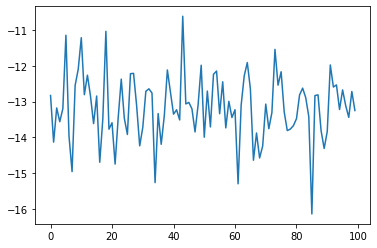

In [58]:
plt.plot(means)

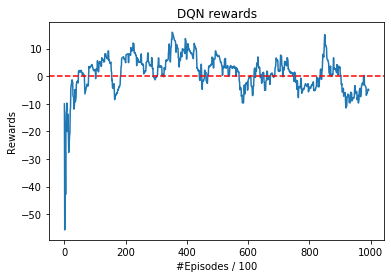

In [2]:
dqn_rew = pd.read_csv('saved_agents/DQN/run-.-tag-Rewards_DQN_epi_reward_2.csv')
dqn_rew = dqn_rew.Value
a = dqn_rew.ewm(alpha=0.03)
plt.plot(a.mean())
plt.title('DQN rewards')
plt.ylabel('Rewards')
plt.xlabel('#Episodes / 100')
plt.axhline(y=0, c='red', linestyle='--')
plt.savefig('saved_agents/DQN/dqn_rewards.png')


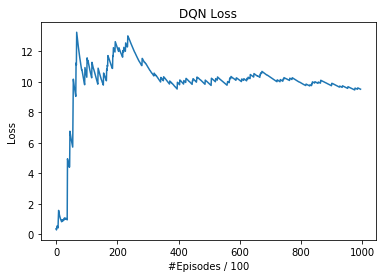

In [3]:
dqn_loss = pd.read_csv('saved_agents/DQN/run-.-tag-Loss_dqn_loss_2.csv')
dqn_loss = dqn_loss.Value
a = dqn_loss.ewm(alpha=0.0001)
plt.plot(a.mean())
plt.title('DQN Loss')
plt.ylabel('Loss')
plt.xlabel('#Episodes / 100')
plt.savefig('saved_agents/DQN/dqn_loss.png')

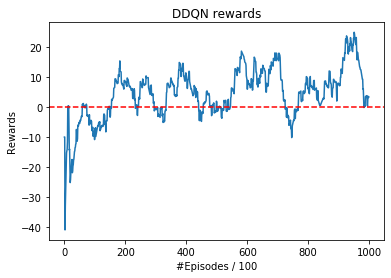

In [2]:
dqn_rew = pd.read_csv('saved_agents/DDQN/run-.-tag-Rewards_DDQN_epi_reward_2.csv')
dqn_rew = dqn_rew.Value
a = dqn_rew.ewm(alpha=0.03)
plt.plot(a.mean())
plt.title('DDQN rewards')
plt.ylabel('Rewards')
plt.xlabel('#Episodes / 100')
plt.axhline(y=0, c='red', linestyle='--')
plt.savefig('saved_agents/DDQN/ddqn_rewards.png')


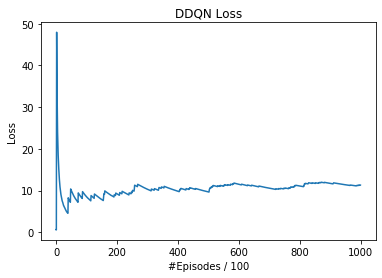

In [3]:
dqn_loss = pd.read_csv('saved_agents/DDQN/run-.-tag-Loss_loss_2.csv')
dqn_loss = dqn_loss.Value
a = dqn_loss.ewm(alpha=0.0001)
plt.plot(a.mean())
plt.title('DDQN Loss')
plt.ylabel('Loss')
plt.xlabel('#Episodes / 100')
plt.savefig('saved_agents/DDQN/ddqn_loss.png')


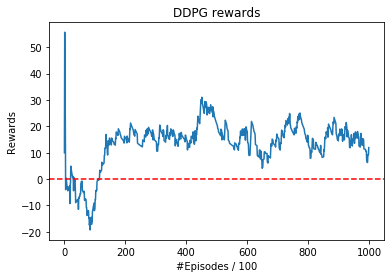

In [4]:
dqn_rew = pd.read_csv('saved_agents/DDPG/run-.-tag-Rewards_epi_reward_2.csv')
dqn_rew = dqn_rew.Value
a = dqn_rew.ewm(alpha=0.03)
plt.plot(a.mean())
plt.title('DDPG rewards')
plt.ylabel('Rewards')
plt.xlabel('#Episodes / 100')
plt.axhline(y=0, c='red', linestyle='--')
plt.savefig('saved_agents/DDPG/ddpg_rewards.png')


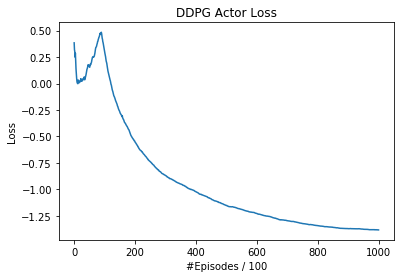

In [5]:
dqn_loss = pd.read_csv('saved_agents/DDPG/run-.-tag-Loss_ddpg_actor_loss.csv')
dqn_loss = dqn_loss.Value
a = dqn_loss.ewm(alpha=0.0001)
plt.plot(a.mean())
plt.title('DDPG Actor Loss')
plt.ylabel('Loss')
plt.xlabel('#Episodes / 100')
plt.savefig('saved_agents/DDPG/ddpg_actor_loss.png')


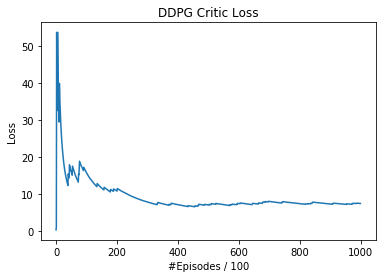

In [6]:
dqn_loss = pd.read_csv('saved_agents/DDPG/run-.-tag-Loss_ddpg_critic_loss.csv')
dqn_loss = dqn_loss.Value
a = dqn_loss.ewm(alpha=0.0001)
plt.plot(a.mean())
plt.title('DDPG Critic Loss')
plt.ylabel('Loss')
plt.xlabel('#Episodes / 100')
plt.savefig('saved_agents/DDPG/ddpg_critic_loss.png')
